# Preliminary settings
All output files will be appended with shelve_name to distinguish different runs of the notebook.

In [1]:
shelve_name='scipyGlobalOpt_'

If set to 'True', unnecessary evaluations & plots are skipped to facilitate codes development.  

In [2]:
development= False
inspectRate=True

Import libraries

In [3]:
from IPython.display import display
import pandas as pd
from KineticLearning.plot import *
import seaborn as sns
import math

# Empirical metabolomics & proteomics data files

Provide technical replicates for all 9 pathway enzymes & 10 metabolites

In [4]:
##### Metabolite replicates
metaboliteData_Rep1_path='data/0rep_0noiseLevel_Convenience_4strains_METABOLITE.csv.csv'
metaboliteData_Rep2_path='data/0rep_0noiseLevel_Convenience_4strains_METABOLITE.csv.csv'
metaboliteData_Rep3_path='data/0rep_0noiseLevel_Convenience_4strains_METABOLITE.csv.csv'

# Enzyme replicates
enzymeData_Rep1_path='data/0rep_0noiseLevel_Convenience_4strains_ENZYME.csv'
enzymeData_Rep2_path='data/0rep_0noiseLevel_Convenience_4strains_ENZYME.csv'
enzymeData_Rep3_path='data/0rep_0noiseLevel_Convenience_4strains_ENZYME.csv'

# no. datapoints required including augmented ones 

IMPORTANT:

no. datapoints should be in multiples of experimental data points

'hours' should be less than or equal to duration of experiment.


In [5]:
hours=24
datapointsPerhour = 4
numberDataPtsNeeded=hours*datapointsPerhour + 1 # include data for time=0

# Specify molecular participants

Participants must be in same order as their input into subsequent kinetic_model.
Names must be identical to imported empirical data

Machine learning of dynamics

Also required for preprocessing 

In [6]:
controls = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites

Empirically measured

In [7]:
measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']#10

# Read in raw enzymes & metabolites datasets
Row multi indices based on strain & time

Column multi indices based on controls (enzymes), states (metabolites), derivatives (rates of net production)

In [8]:
from KineticLearning import read_enzymeRawData,read_metaboliteRawData

# Enzyme replicate data
df_enzymeRaw_Rep1=read_enzymeRawData(enzymeData_Rep1_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep2=read_enzymeRawData(enzymeData_Rep2_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep3=read_enzymeRawData(enzymeData_Rep3_path,controls,time='Time/hours',strain='Strain')

# Metabolite replicate data
df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

In [9]:
df_metaboliteRaw_Rep1.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.300000        0.200000  0.050000  0.300000  0.020000   
       0.25   0.309024        0.200910  0.050625  0.282856  0.036674   
       0.50   0.314998        0.201694  0.051938  0.248202  0.068270   
       0.75   0.319643        0.202074  0.053558  0.211119  0.098298   
       1.00   0.323500        0.202147  0.055336  0.177911  0.120674   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.200000  0.010000  0.040000  0.050000  0.000000  
       0.25  0.198163  0.008009  0.039752  0.052301  0.000301  
       0.50  0.195577  0.006902  0.038297  0.056433  0.001051  
       0.75  0.194766  0.007115  0.036048  0.061353  0.002141  
       1.00  0.195942  0.007820  0.033196  0.067118  0.003531

In [10]:
df_metaboliteRaw_Rep2.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.300000        0.200000  0.050000  0.300000  0.020000   
       0.25   0.309024        0.200910  0.050625  0.282856  0.036674   
       0.50   0.314998        0.201694  0.051938  0.248202  0.068270   
       0.75   0.319643        0.202074  0.053558  0.211119  0.098298   
       1.00   0.323500        0.202147  0.055336  0.177911  0.120674   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.200000  0.010000  0.040000  0.050000  0.000000  
       0.25  0.198163  0.008009  0.039752  0.052301  0.000301  
       0.50  0.195577  0.006902  0.038297  0.056433  0.001051  
       0.75  0.194766  0.007115  0.036048  0.061353  0.002141  
       1.00  0.195942  0.007820  0.033196  0.067118  0.003531

In [11]:
df_metaboliteRaw_Rep3.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.300000        0.200000  0.050000  0.300000  0.020000   
       0.25   0.309024        0.200910  0.050625  0.282856  0.036674   
       0.50   0.314998        0.201694  0.051938  0.248202  0.068270   
       0.75   0.319643        0.202074  0.053558  0.211119  0.098298   
       1.00   0.323500        0.202147  0.055336  0.177911  0.120674   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.200000  0.010000  0.040000  0.050000  0.000000  
       0.25  0.198163  0.008009  0.039752  0.052301  0.000301  
       0.50  0.195577  0.006902  0.038297  0.056433  0.001051  
       0.75  0.194766  0.007115  0.036048  0.061353  0.002141  
       1.00  0.195942  0.007820  0.033196  0.067118  0.003531

# Average of replicate values

Metabolites

In [12]:
#Stack replicate data on top of each other
df_metaboliteRaw_concat = pd.concat(
    (df_metaboliteRaw_Rep1, 
     df_metaboliteRaw_Rep2, 
     df_metaboliteRaw_Rep3)
)
#df_metaboliteRaw_concat.to_csv('df_metaboliteRaw_concat.csv')

# Create dataframe from average of 3 replicates
df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
#df_metaboliteRaw.to_csv('metabolite_average.csv')

df_metaboliteRaw.head()

states                                                \
              Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                            
Strain 1 0.00   0.300000        0.200000  0.050000  0.300000  0.020000   
         0.25   0.303889        0.202239  0.052901  0.257973  0.060732   
         0.50   0.300366        0.204051  0.059318  0.185505  0.126153   
         0.75   0.293825        0.204705  0.067553  0.125893  0.171899   
         1.00   0.285682        0.204435  0.076846  0.085674  0.193388   

                                                                 
                  MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                    
Strain 1 0.00  0.200000  0.010000  0.040000  0.050000  0.000000  
         0.25  0.194292  0.011434  0.039765  0.052914  0.000130  
         0.50  0.184541  0.014747  0.037935  0.060579  0.000468  
         0.75  0.174893  0.018155  0.034722  0.072187  0.000997  
         1.00  0.164537  0.021526  0.030790  0.086852  0.001739

Enzymes

In [13]:
#Stack replicate data on top of each other
df_enzymeRaw_concat = pd.concat(
    (df_enzymeRaw_Rep1, 
     df_enzymeRaw_Rep2, 
     df_enzymeRaw_Rep3)
)

# Create dataframe from average of 3 replicates
df_enzymeRaw = df_enzymeRaw_concat.groupby(['Strain','Time']).mean()
df_enzymeRaw.head()

controls                                             \
                       AtoB          HMGS           HMGR            MK   
Strain   Time                                                            
Strain 1 0.00  5.946962e+01  3.973013e+01      36.968921  5.762279e+01   
         0.25  4.568047e+06  2.339239e+06  216501.990022  1.413483e+06   
         0.50  5.471875e+06  3.482933e+06  339448.988190  2.217158e+06   
         0.75  5.858245e+06  4.161080e+06  418715.475569  2.735644e+06   
         1.00  6.072640e+06  4.609864e+06  474068.251127  3.097868e+06   

                                                                         \
                         PMK           PMD          GPPS            Idi   
Strain   Time                                                             
Strain 1 0.00      26.599588  5.448132e+01  5.547215e+01      18.687782   
         0.25  473518.755617  2.301051e+06  2.600509e+06  428799.016790   
         0.50  724132.403320  3.761395e+06  3.265182e+06  639992.856400   
         0.75  879253.836051  4.770619e+06  3.569278e+06  765704.580833   
         1.00  984727.523254  5.509792e+06  3.743605e+06  849097.962158   

                                 
              Limonene Synthase  
Strain   Time                    
Strain 1 0.00         30.341080  
         0.25     183705.772400  
         0.50     286614.273964  
         0.75     352427.155323  
         1.00     398139.231561

In [14]:
# # Testing
# from KineticLearning import read_metaboliteRawData
# import pandas as pd
# states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites
# metaboliteData_Rep1_path='data/rep_1_TEST.csv'
# metaboliteData_Rep2_path='data/rep_2_TEST.csv'
# metaboliteData_Rep3_path='data/rep_3_TEST.csv'
# df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

# #Stack replicate data on top of each other
# df_metaboliteRaw_concat = pd.concat(
#     (df_metaboliteRaw_Rep1, 
#      df_metaboliteRaw_Rep2, 
#      df_metaboliteRaw_Rep3)
# )
# df_metaboliteRaw_concat.to_csv('df_TEST_concat.csv')

# # Create dataframe from average of 3 replicates
# df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
# df_metaboliteRaw.to_csv('TEST_average.csv')

# Read strain list from enzyme data file

In [15]:
strainList=[]
for strain in df_enzymeRaw.index:
    if strain[0] not in strainList:
        strainList.append(strain[0])
print ('List of ' +str(len(strainList)) + ' strains read in.')

List of 4 strains read in.


# Assess missing data

In [16]:
from KineticLearning import NaN_table

if development==True:
    pass
else:
    # generate NaN summary table
    print('Enzymes:')
    df_NaN_enzymeRaw=NaN_table(df_enzymeRaw) # enzymes
    print('\nMetabolites:')
    df_NaN_metaboliteRaw=NaN_table(df_metaboliteRaw) # metabolites

    #display tables
    display(df_NaN_enzymeRaw) # enzymes
    df_enzymeRaw.head()
    display(df_NaN_metaboliteRaw) # metabolites
    df_metaboliteRaw.head()

Enzymes:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.

Metabolites:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.


Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

# Impute missing data

In [17]:
df_metaboliteImputed = df_metaboliteRaw.groupby('Strain').apply(lambda group: group.interpolate()) # metabolites
df_enzymeImputed = df_enzymeRaw.groupby('Strain').apply(lambda group: group.interpolate()) # enzymes

# Assess effect of imputation on missing data

In [18]:
from KineticLearning import compareTimeSeriesAfterPreprocess

if development==True:
    pass
else:
    # generate NaN summary table
    print('Metabolites data:')
    df_NaN_metaboliteImputed=NaN_table(df_metaboliteImputed)
    print('\nEnzymes data:')
    df_NaN_enzymeImputed=NaN_table(df_enzymeImputed)
    
    # display(df_metaboliteImputed)
    
    #print ('\n----------------------------------------------------\nMetabolites plots before & after imputation:\n')
    #compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteImputed,'states',
    #                             strainList,preprocessLabel='After Imputation')

    # display(df_enzymeImputed)

Metabolites data:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.

Enzymes data:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.


# Smoothen & augment data using non-parametric approach

M-spline method is used.

In [19]:
from KineticLearning import smoothenTimeSeries2

# Metabolites
df_metaboliteSmooth=smoothenTimeSeries2('states',df_metaboliteImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)
# Enzymes
df_enzymeSmooth=smoothenTimeSeries2('controls',df_enzymeImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)

# Inspect outcome of data smoothening & augmentation 

metabolites

Strain Strain 1


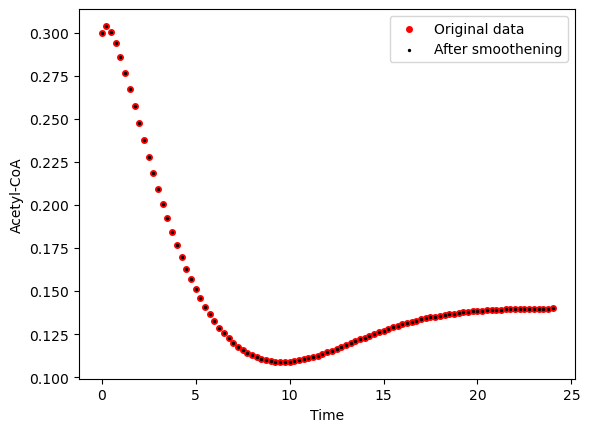

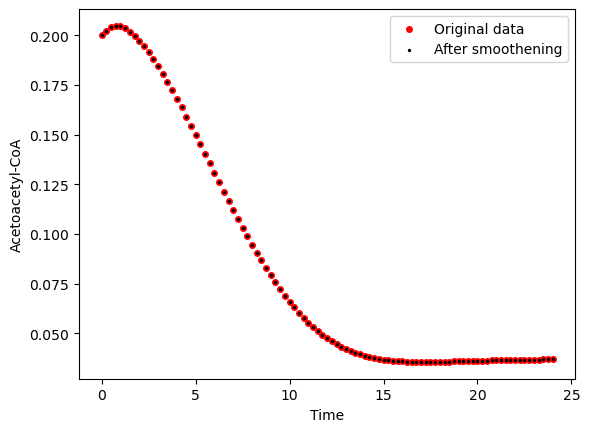

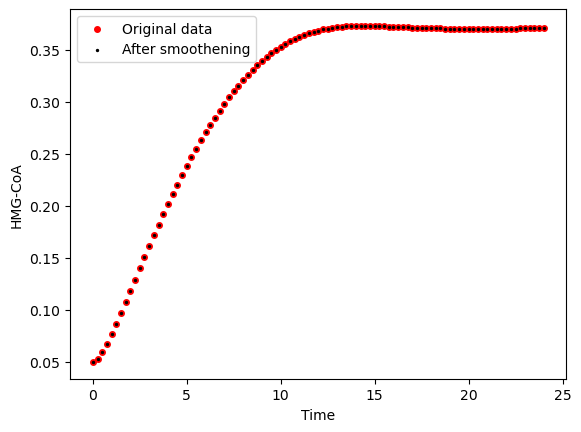

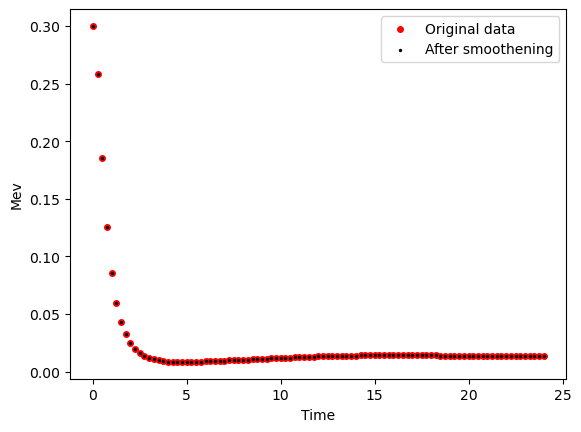

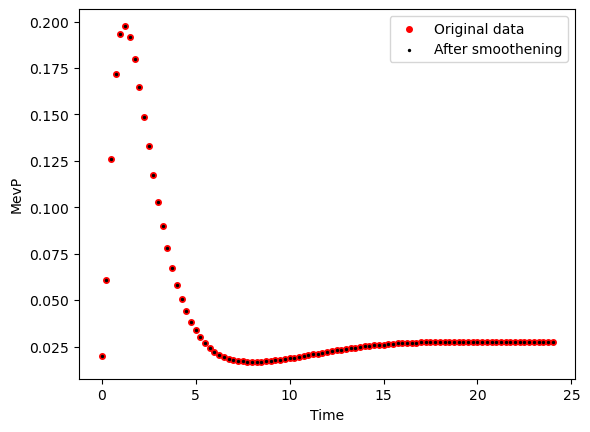

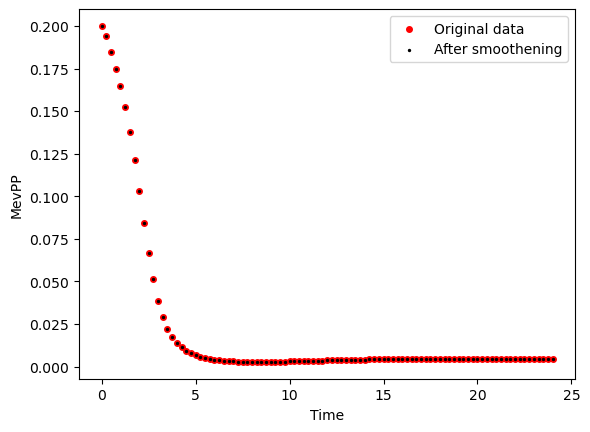

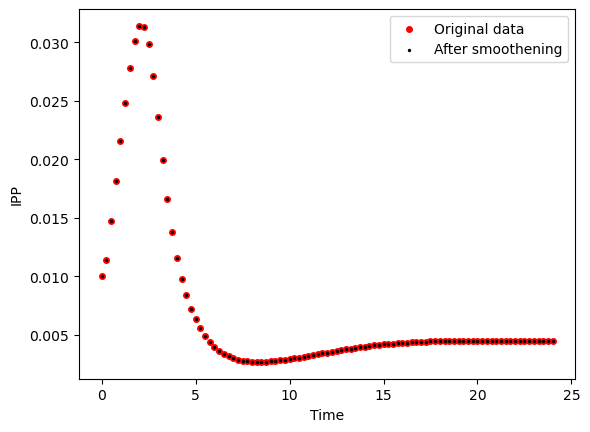

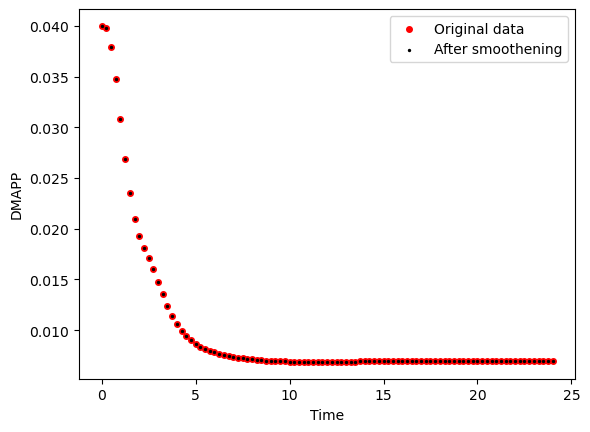

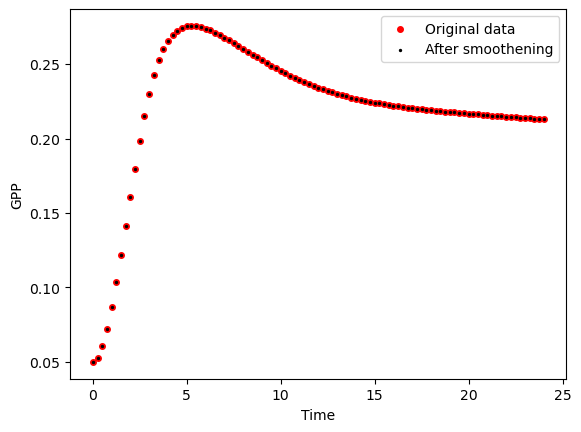

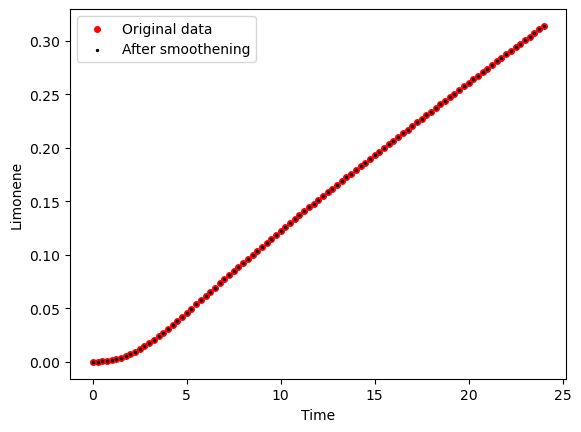

Strain Strain 2


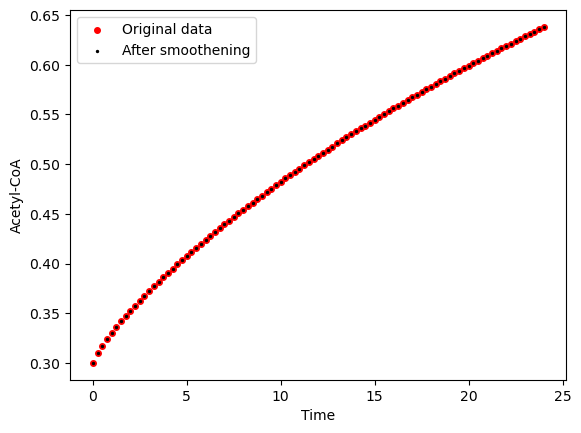

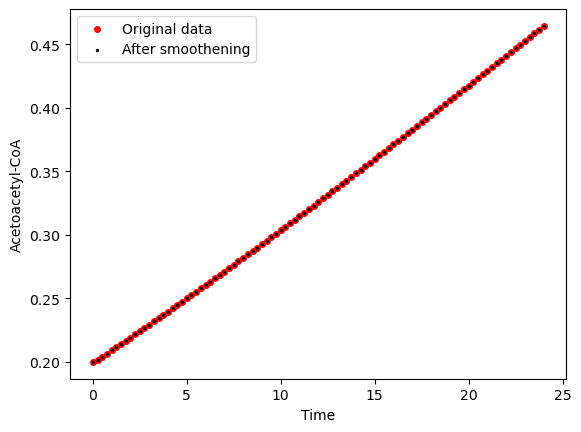

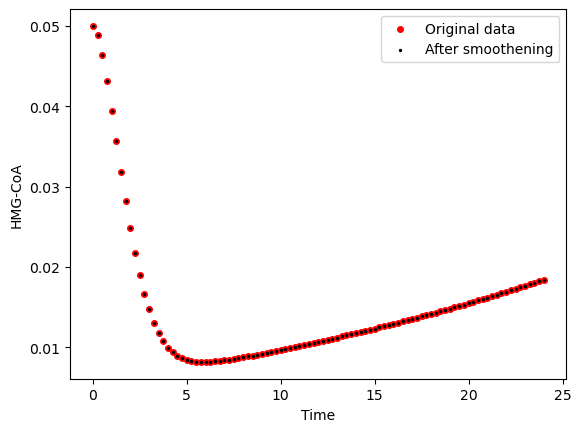

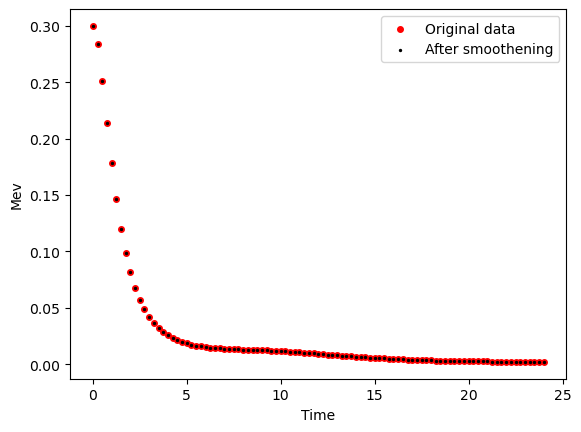

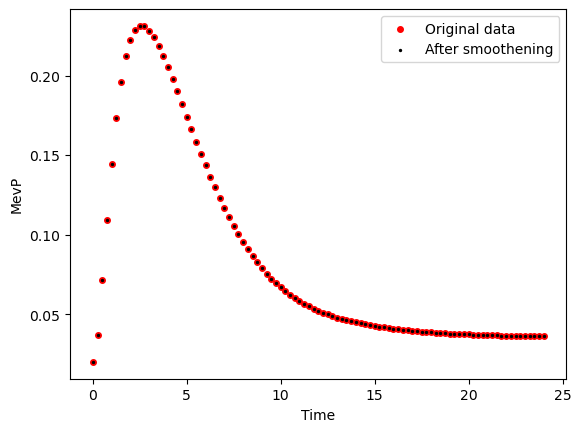

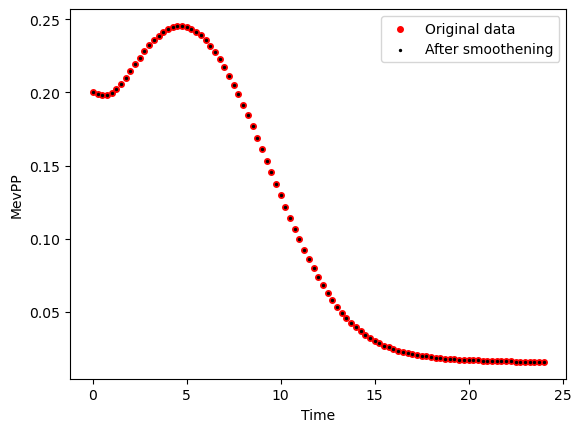

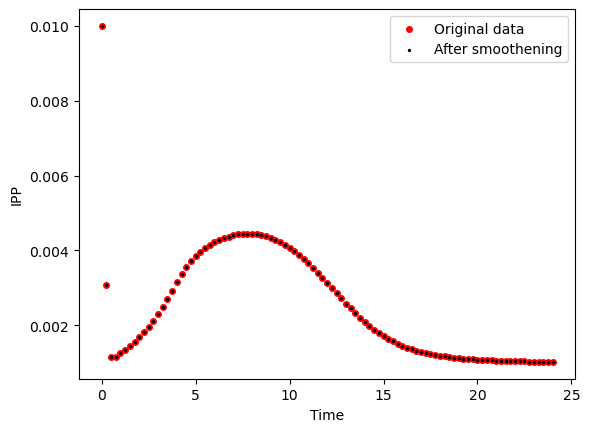

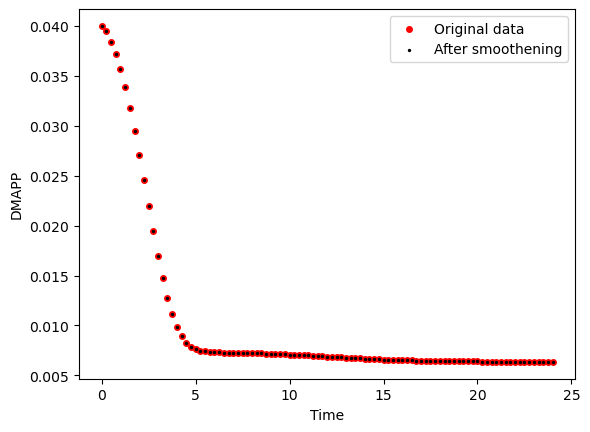

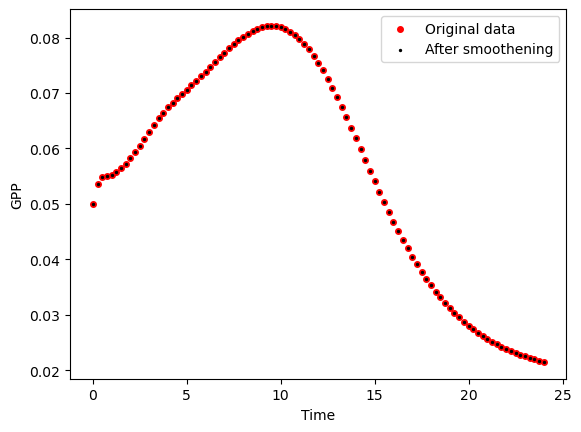

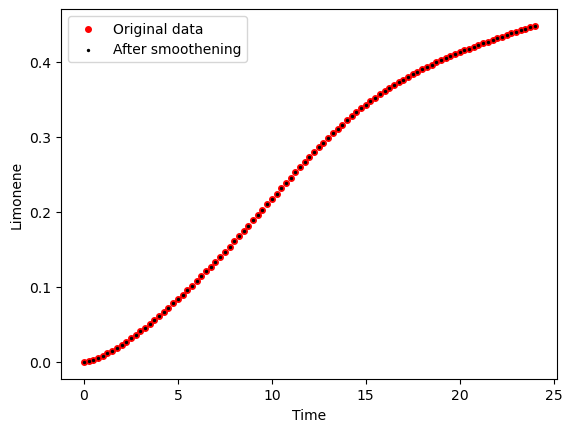

Strain Strain 3


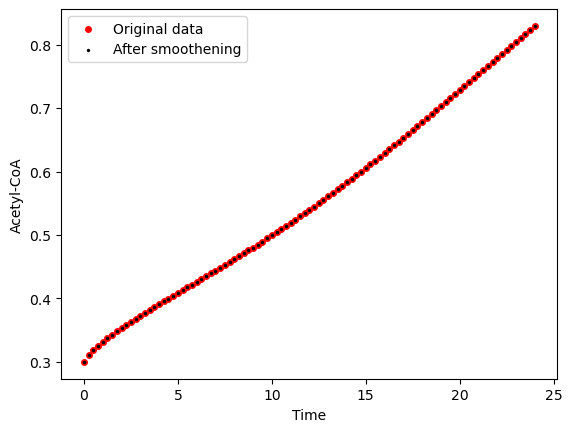

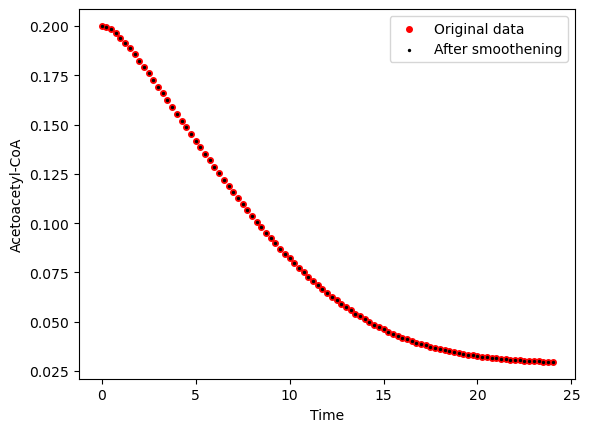

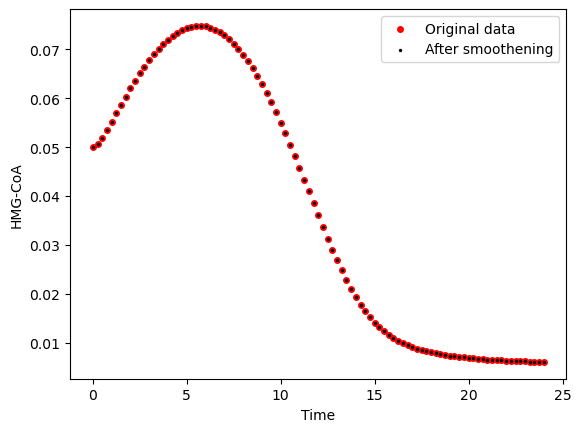

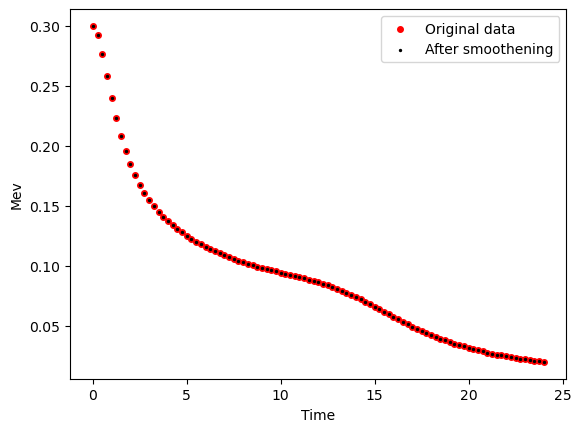

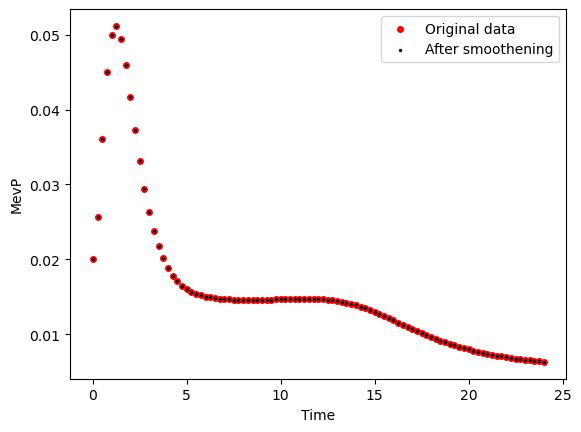

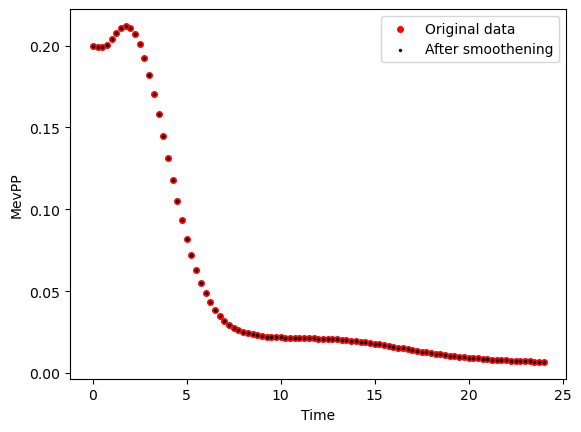

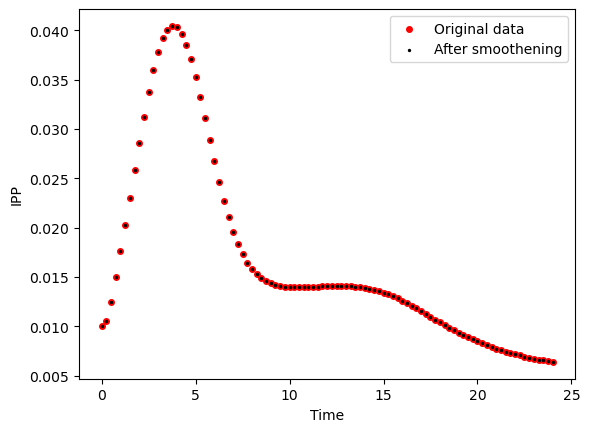

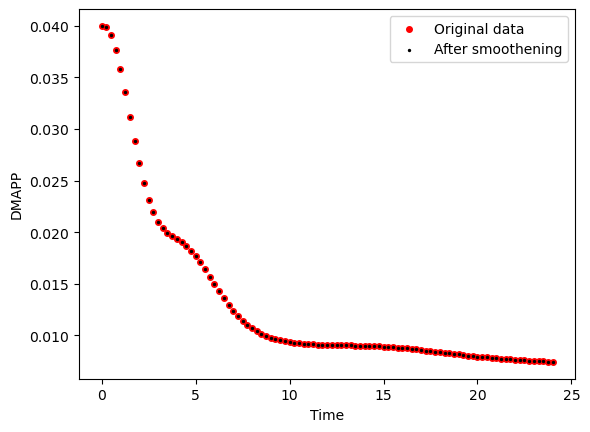

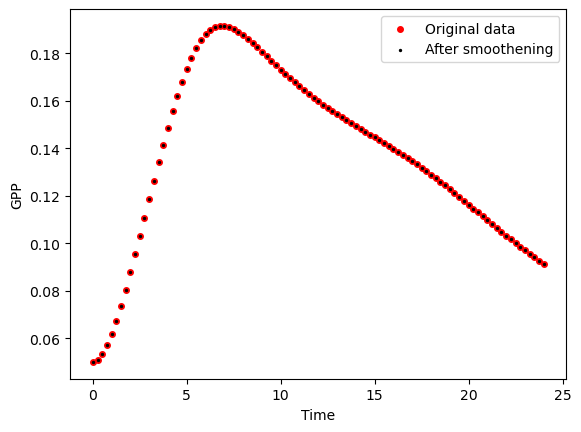

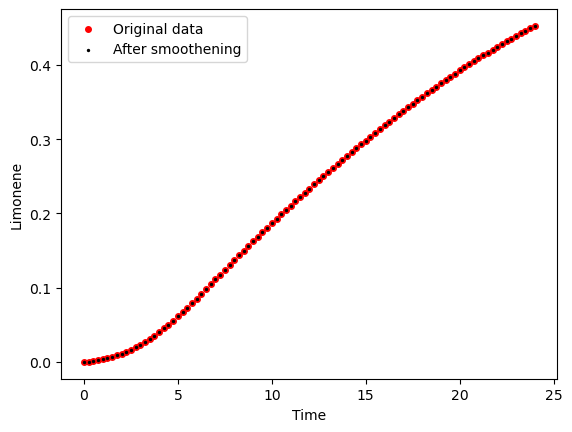

Strain WT


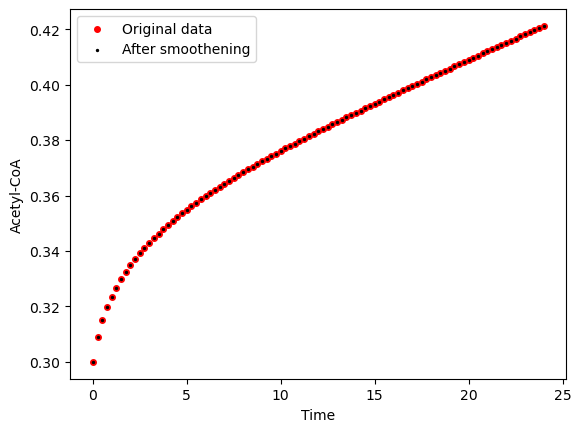

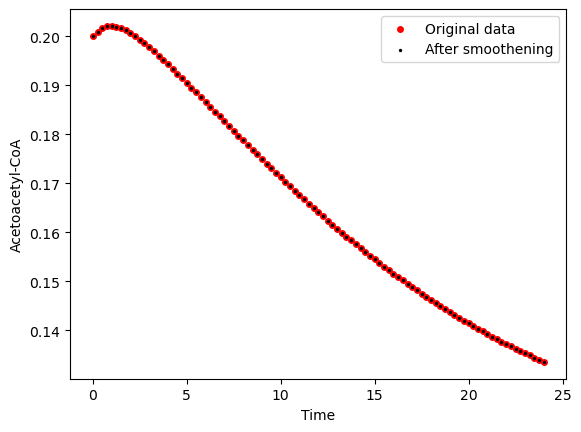

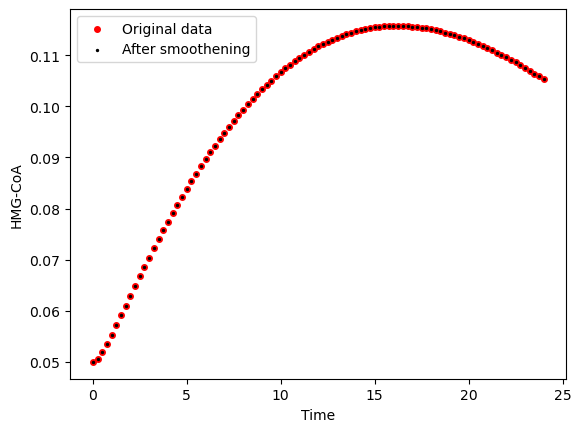

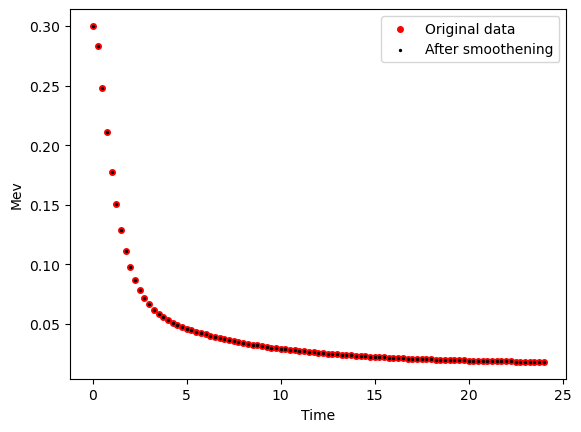

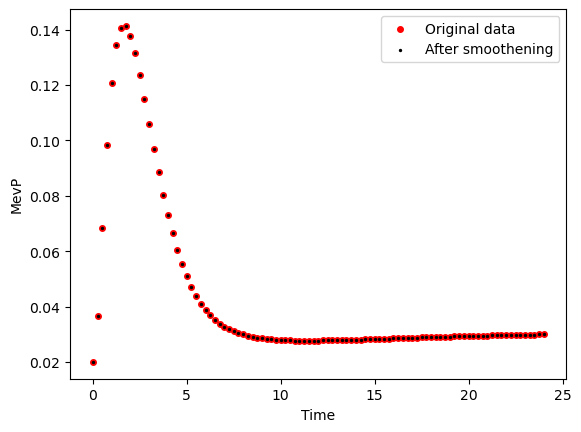

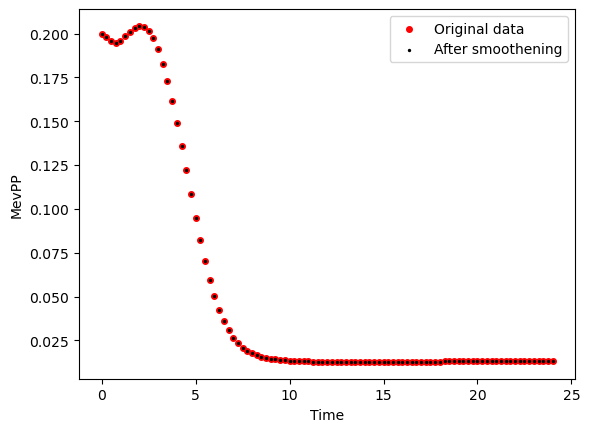

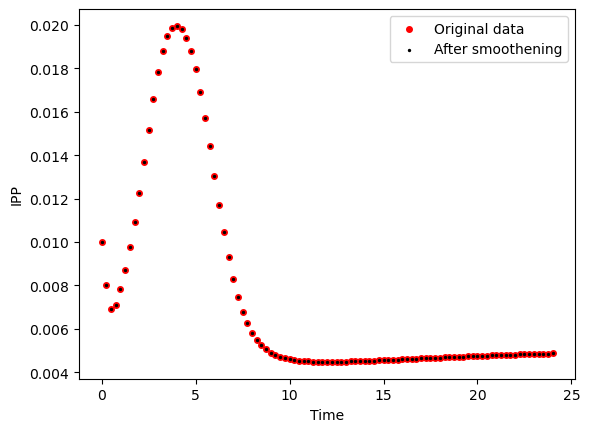

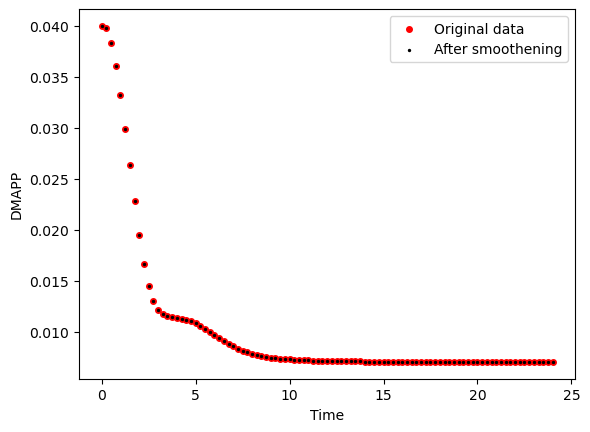

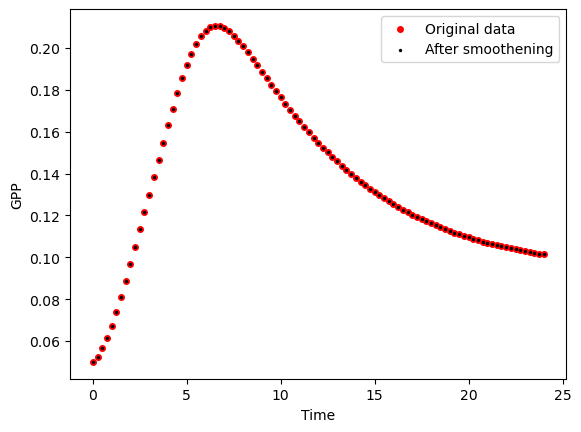

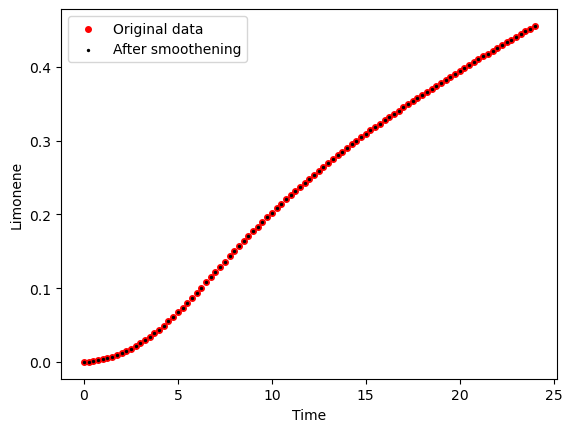

In [20]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteSmooth,'states',
                                 strainList,preprocessLabel='After smoothening')

enzymes

Strain Strain 1


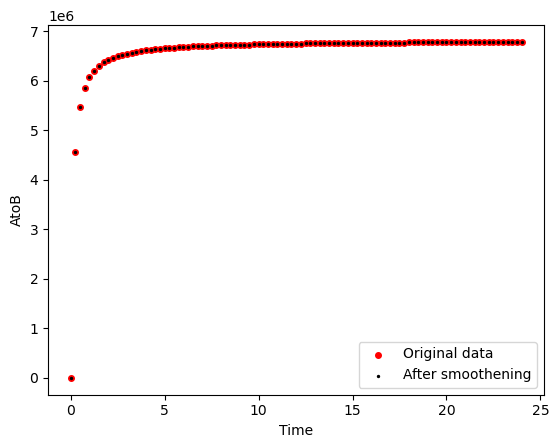

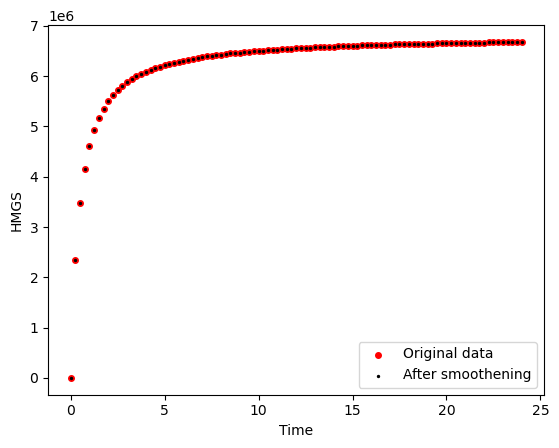

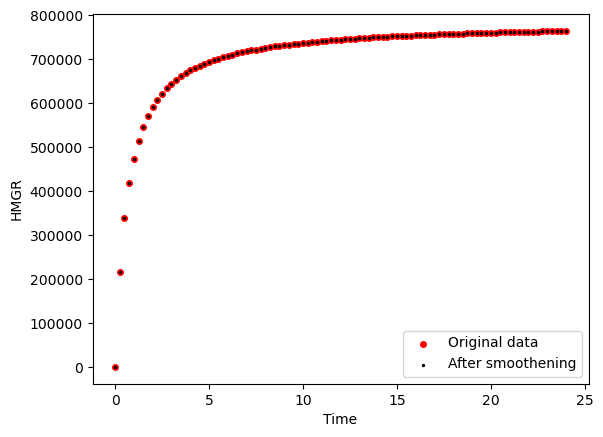

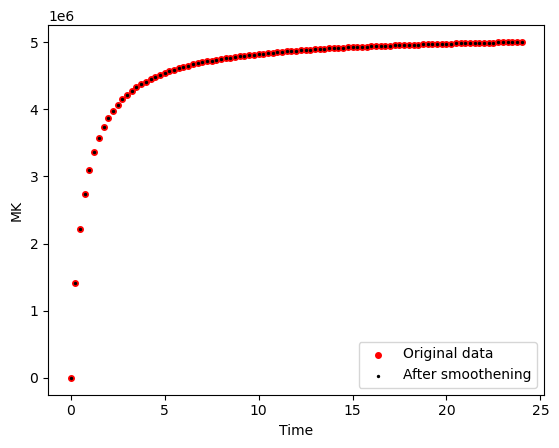

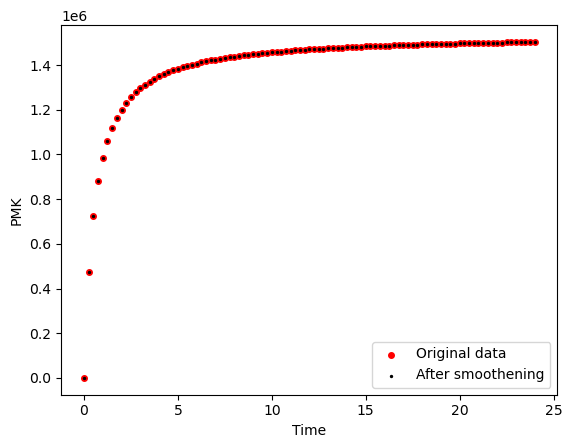

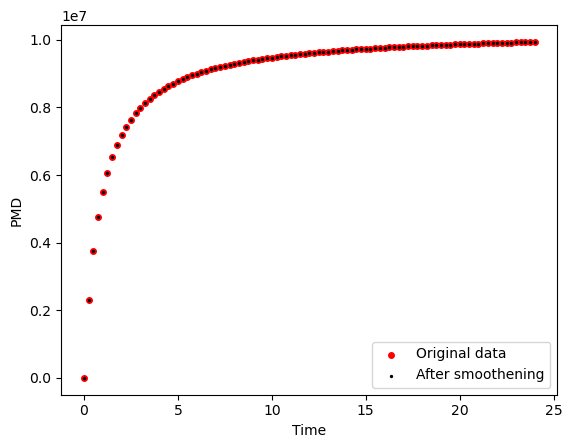

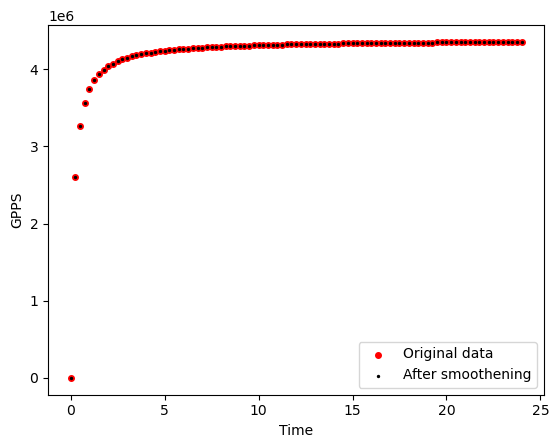

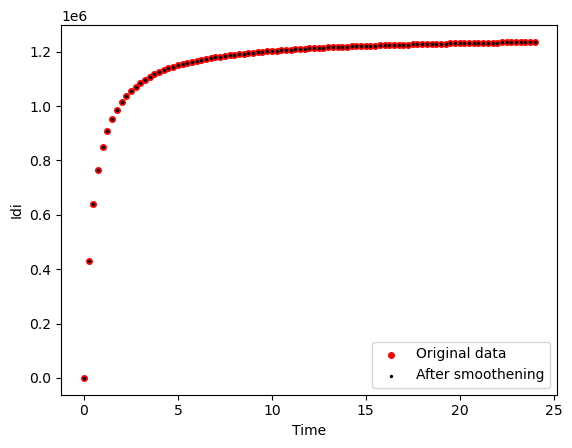

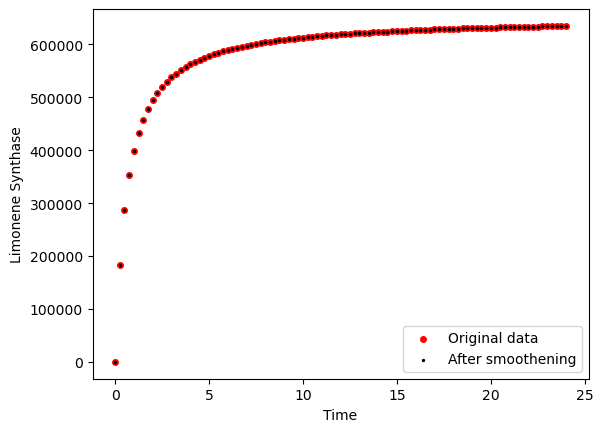

Strain Strain 2


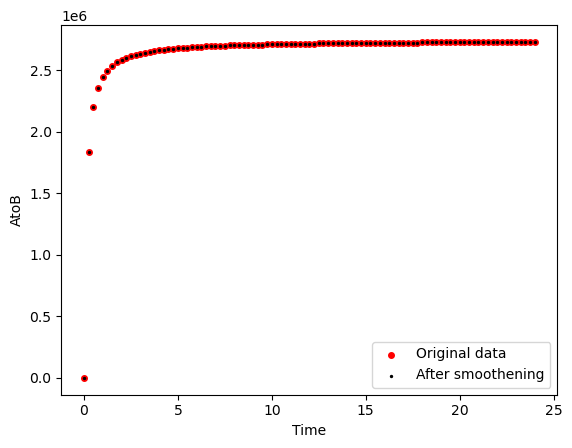

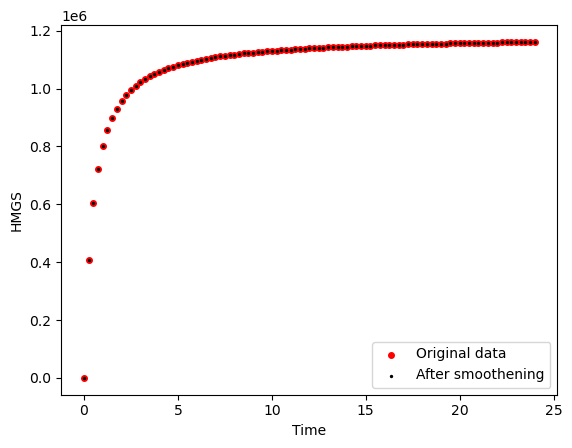

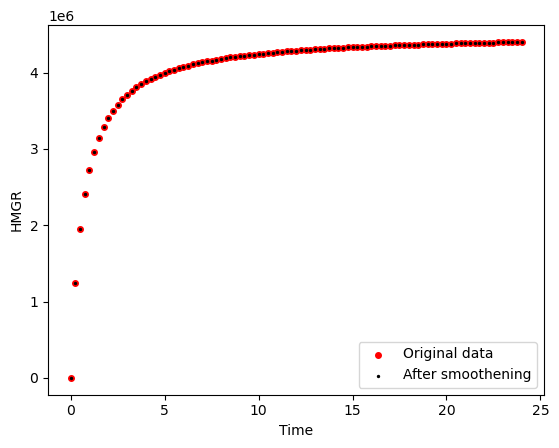

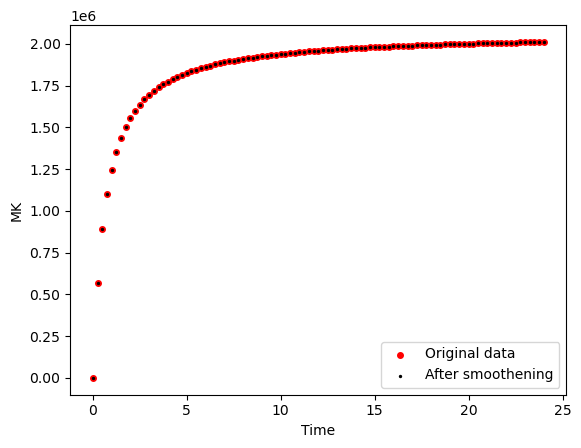

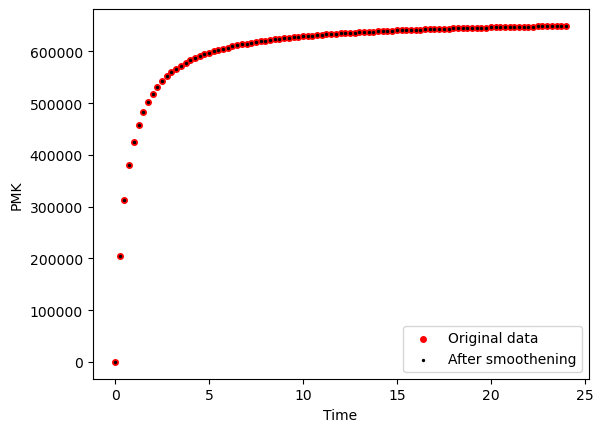

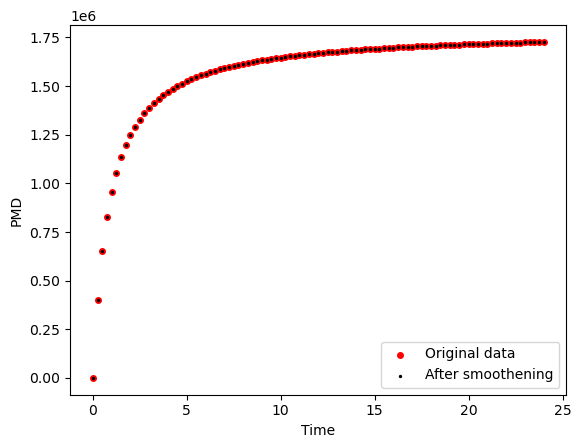

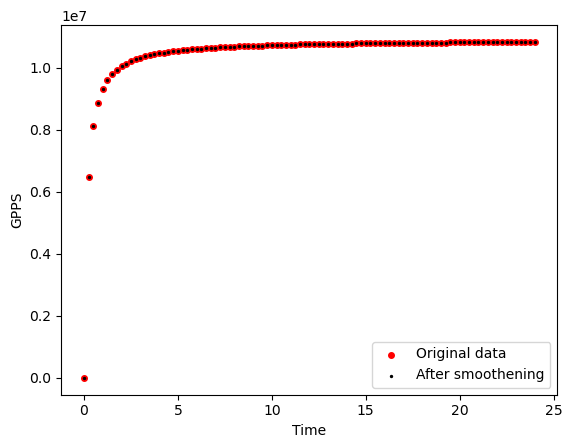

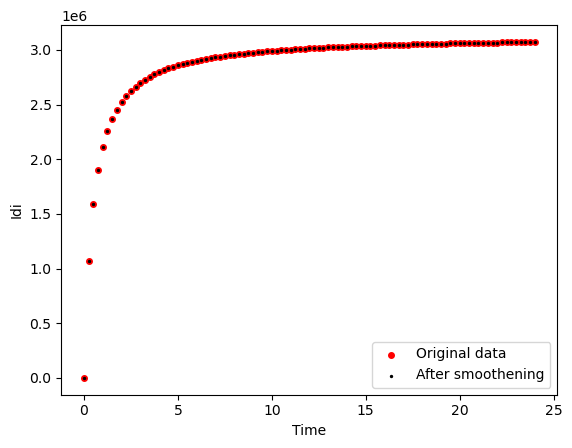

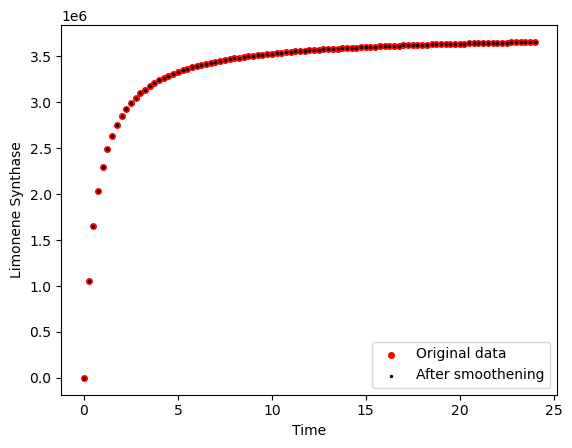

Strain Strain 3


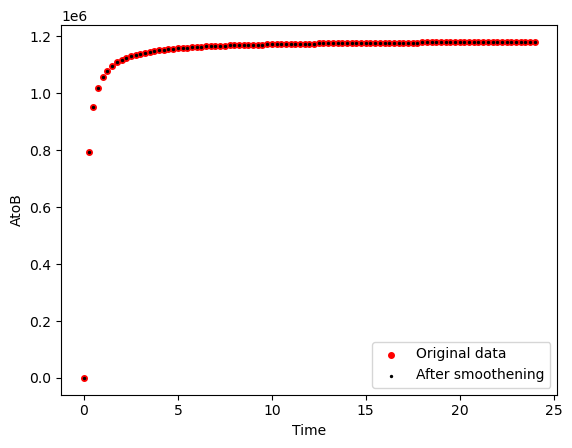

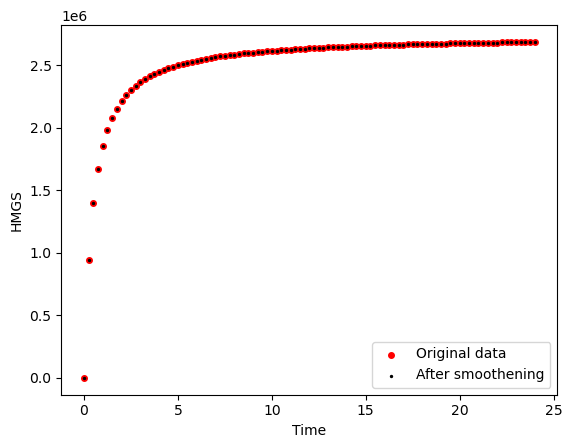

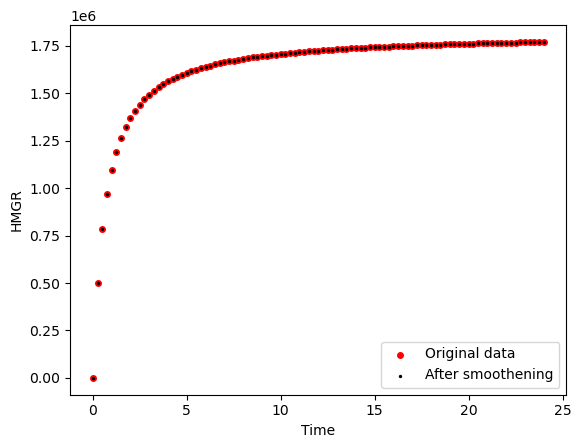

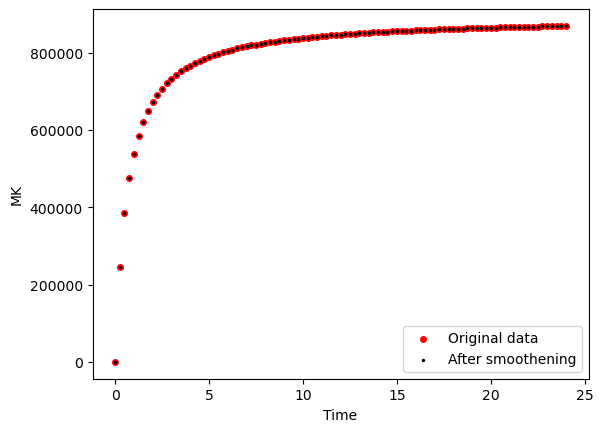

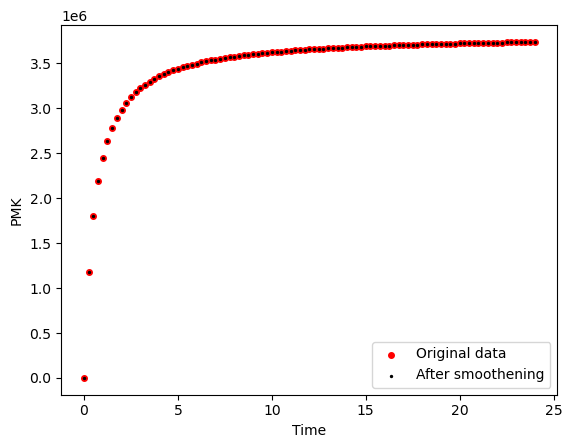

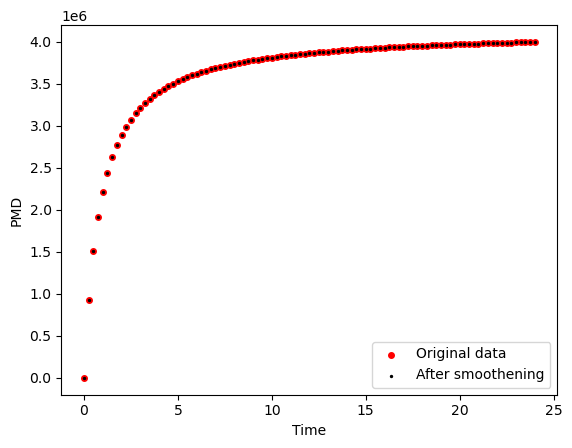

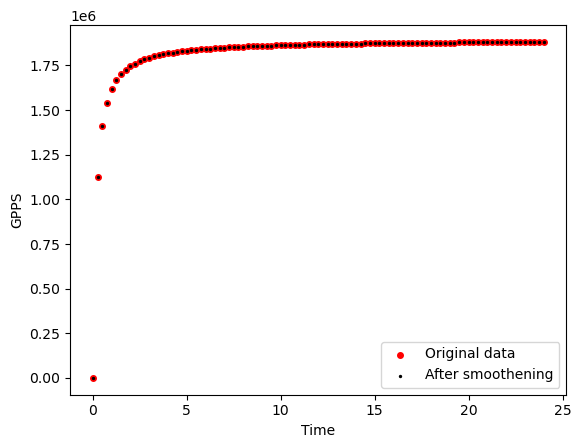

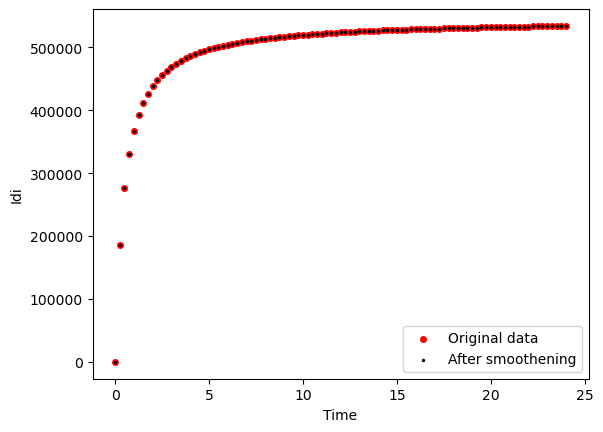

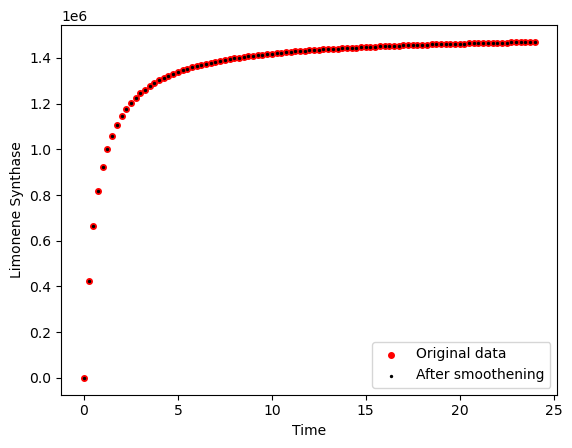

Strain WT


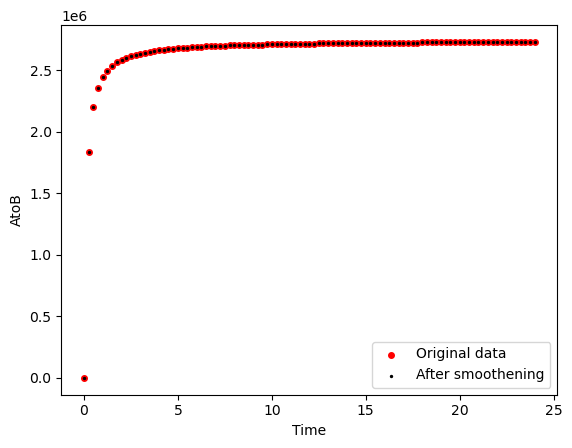

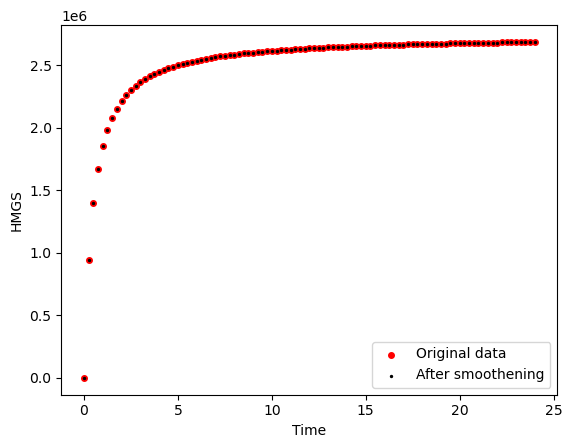

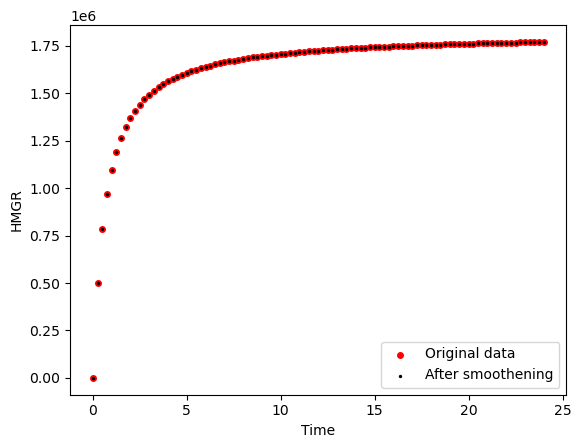

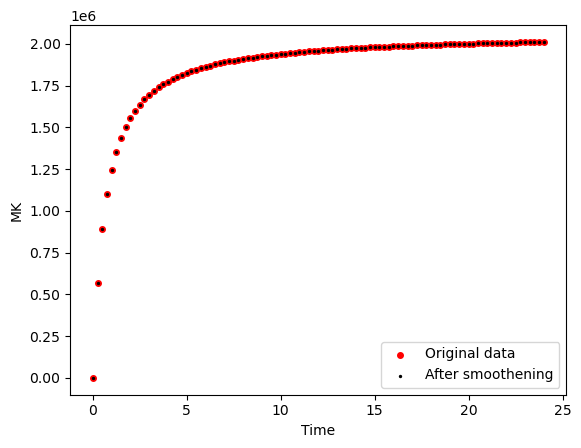

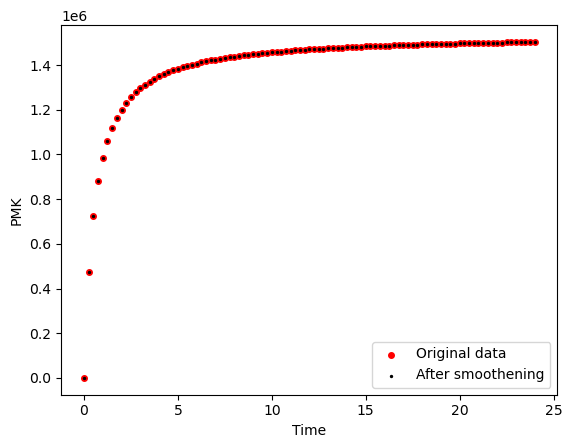

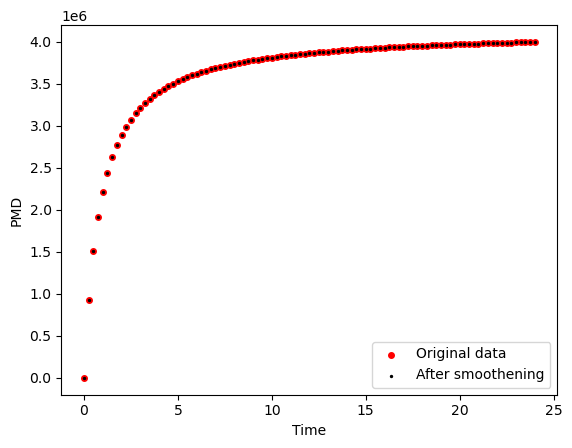

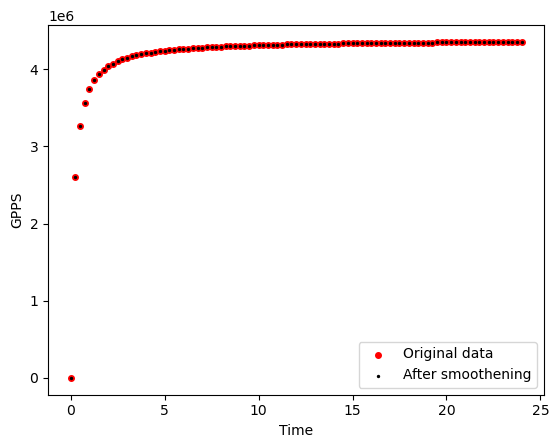

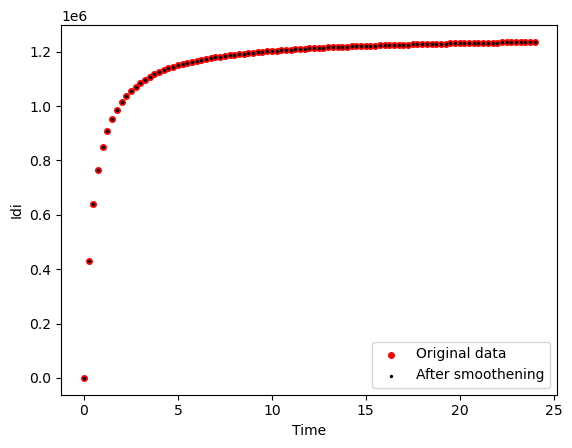

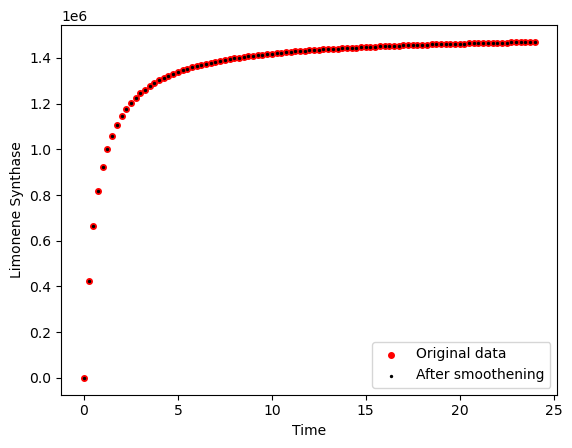

In [21]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_enzymeRaw,df_enzymeSmooth,'controls',
                                 strainList,preprocessLabel='After smoothening')

# Combine metabolites & enzymes dataframes

In [22]:
df_allSmooth=pd.concat([df_metaboliteSmooth,df_enzymeSmooth],axis=1)

if development==True:
    pass
else:
    df_allSmooth.head()

# Compute rate of reaction

In [23]:
from KineticLearning import estimate_state_derivative73

df_allSmooth=estimate_state_derivative73(df_allSmooth)

if development==True:
    pass
else:
    display(df_allSmooth) #new
    df_allSmooth.to_csv(shelve_name + '_df_allSmooth.csv')

states                                                \
               Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                             
Strain 1 0.00    0.300000        0.200000  0.050000  0.300000  0.020000   
         0.25    0.303889        0.202239  0.052901  0.257973  0.060732   
         0.50    0.300366        0.204051  0.059318  0.185505  0.126153   
         0.75    0.293825        0.204705  0.067553  0.125893  0.171899   
         1.00    0.285682        0.204435  0.076846  0.085674  0.193388   
...                   ...             ...       ...       ...       ...   
WT       23.00   0.418135        0.135344  0.107524  0.018433  0.029820   
         23.25   0.418894        0.134891  0.106975  0.018376  0.029853   
         23.50   0.419652        0.134446  0.106413  0.018321  0.029884   
         23.75   0.420408        0.134009  0.105838  0.018268  0.029914   
         24.00   0.421163        0.133581  0.105252  0.018217  0.029943   

                                                                  ...  \
                   MevPP       IPP     DMAPP       GPP  Limonene  ...   
Strain   Time                                                     ...   
Strain 1 0.00   0.200000  0.010000  0.040000  0.050000  0.000000  ...   
         0.25   0.194292  0.011434  0.039765  0.052914  0.000130  ...   
         0.50   0.184541  0.014747  0.037935  0.060579  0.000468  ...   
         0.75   0.174893  0.018155  0.034722  0.072187  0.000997  ...   
         1.00   0.164537  0.021526  0.030790  0.086852  0.001739  ...   
...                  ...       ...       ...       ...       ...  ...   
WT       23.00  0.013294  0.004839  0.007023  0.102943  0.440720  ...   
         23.25  0.013307  0.004846  0.007023  0.102536  0.444453  ...   
         23.50  0.013319  0.004852  0.007023  0.102148  0.448172  ...   
         23.75  0.013331  0.004858  0.007022  0.101776  0.451879  ...   
         24.00  0.013342  0.004864  0.007022  0.101420  0.455574  ...   

               derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00     0.024056        0.011807  0.006596 -0.203422  0.217911   
         0.25    -0.000307        0.008010  0.019158 -0.234048  0.216216   
         0.50    -0.018662        0.004401  0.028864 -0.237215  0.192786   
         0.75    -0.031009        0.000980  0.035716 -0.212924  0.147623   
         1.00    -0.034961       -0.002637  0.038781 -0.133242  0.051775   
...                    ...             ...       ...       ...       ...   
WT       23.00    0.003039       -0.001829 -0.002172 -0.000234  0.000133   
         23.25    0.003034       -0.001796 -0.002224 -0.000225  0.000128   
         23.50    0.003028       -0.001764 -0.002274 -0.000216  0.000123   
         23.75    0.003022       -0.001731 -0.002322 -0.000208  0.000117   
         24.00    0.003017       -0.001699 -0.002367 -0.000200  0.000112   

                                                                  
                   MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                     
Strain 1 0.00  -0.025532  0.005014  0.003988  0.001041  0.000215  
         0.25  -0.030620  0.009670 -0.004554  0.021740  0.000923  
         0.50  -0.035884  0.012750 -0.010733  0.039083  0.001698  
         0.75  -0.041325  0.014255 -0.014547  0.053067  0.002541  
         1.00  -0.044974  0.013478 -0.016064  0.063589  0.003433  
...                  ...       ...       ...       ...       ...  
WT       23.00  0.000053  0.000026 -0.000001 -0.001663  0.014958  
         23.25  0.000051  0.000025 -0.000001 -0.001590  0.014904  
         23.50  0.000049  0.000024 -0.000001 -0.001521  0.014852  
         23.75  0.000047  0.000023 -0.000001 -0.001454  0.014803  
         

# Inspect quality of reaction rates

Check if derivatives are reliable enough to regenerate metabolite time profiles.

'Time profile from derivative vs. actual profile for Strain 1'

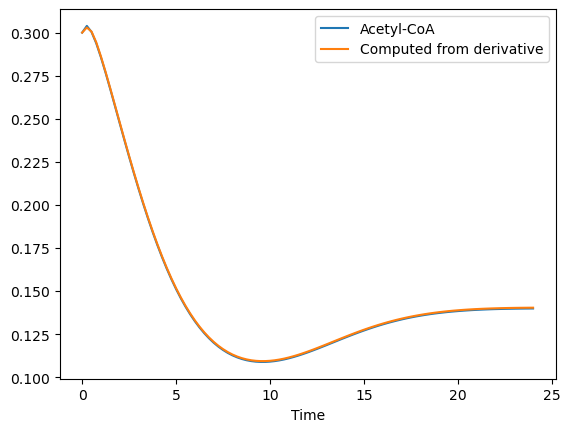

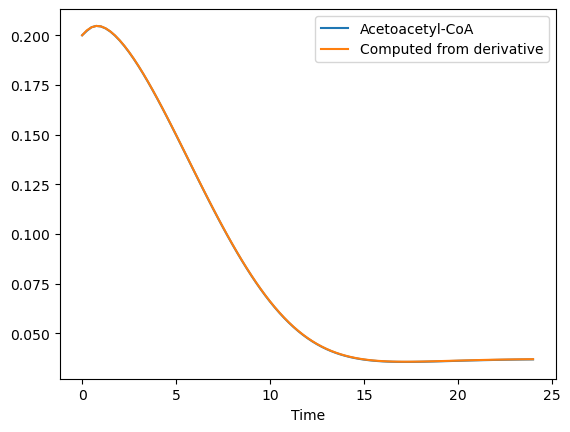

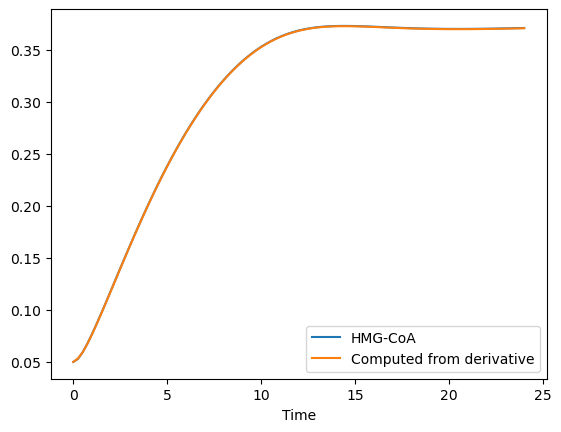

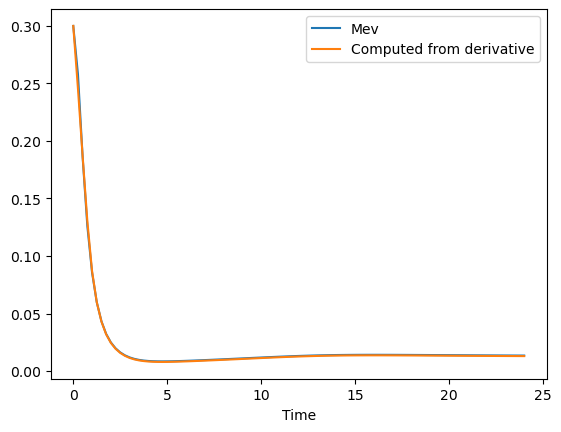

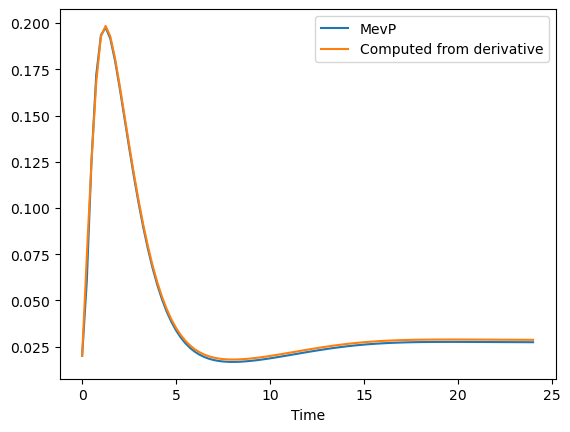

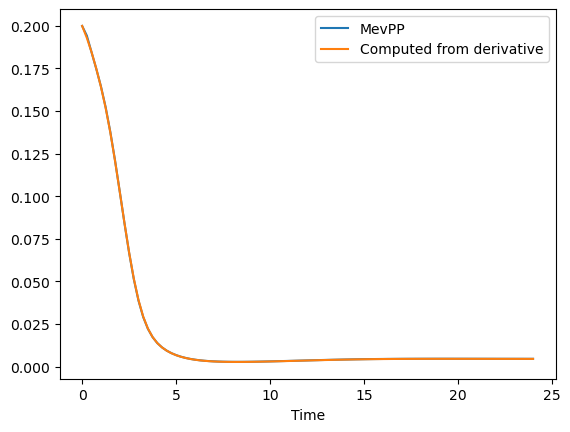

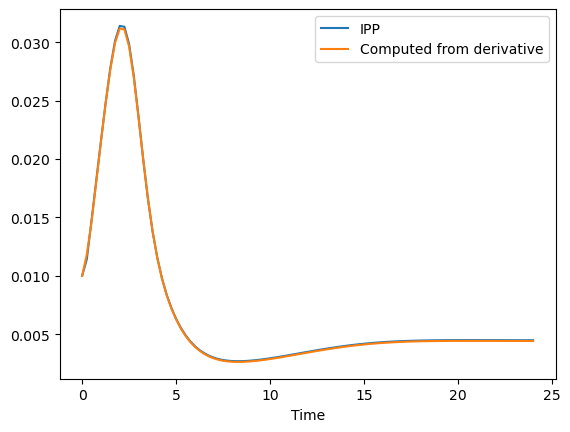

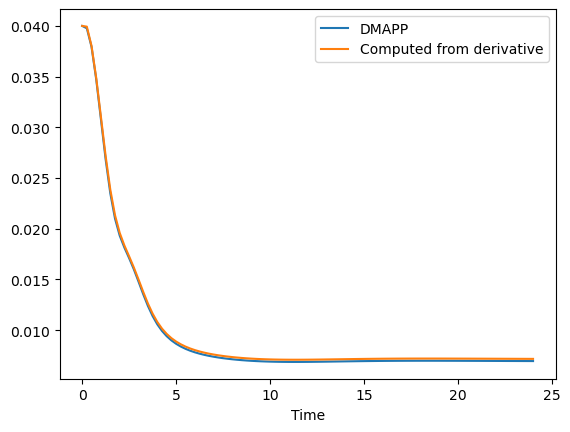

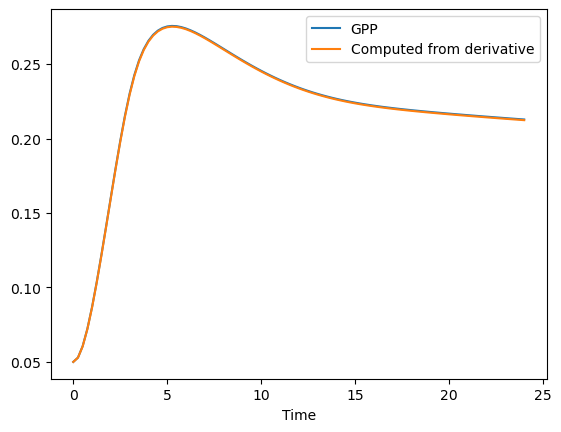

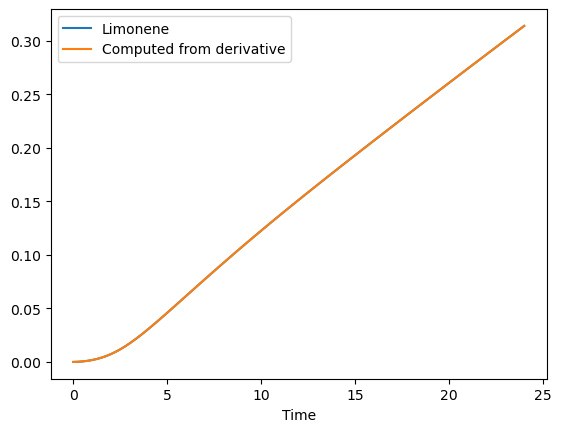

'Time profile from derivative vs. actual profile for Strain 2'

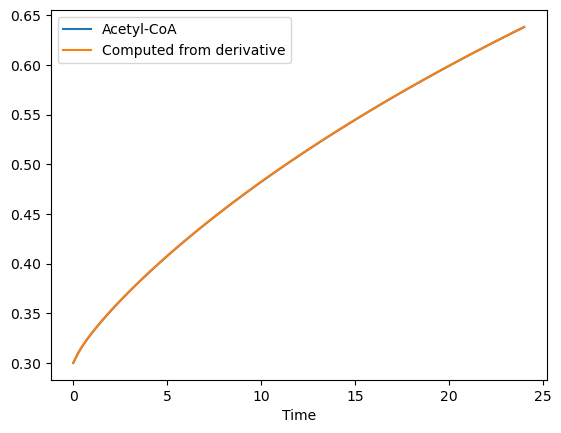

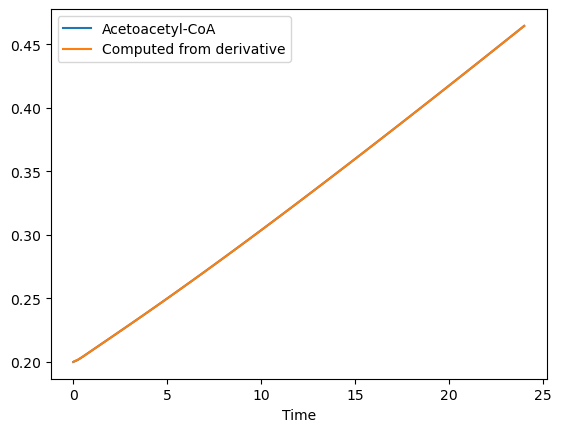

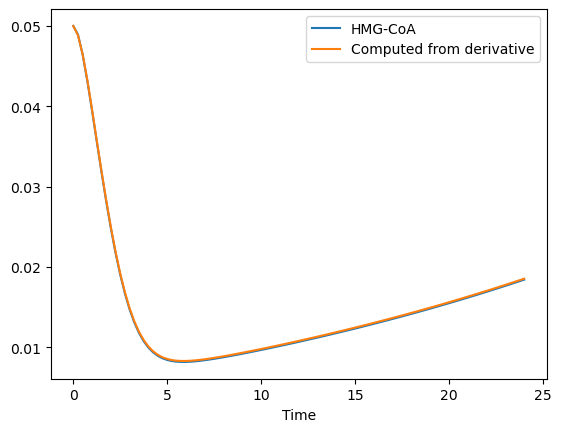

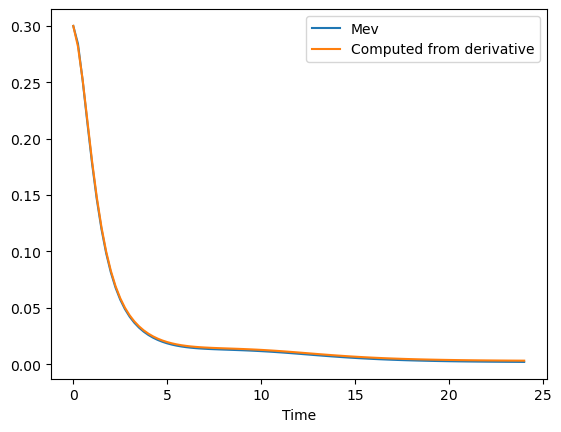

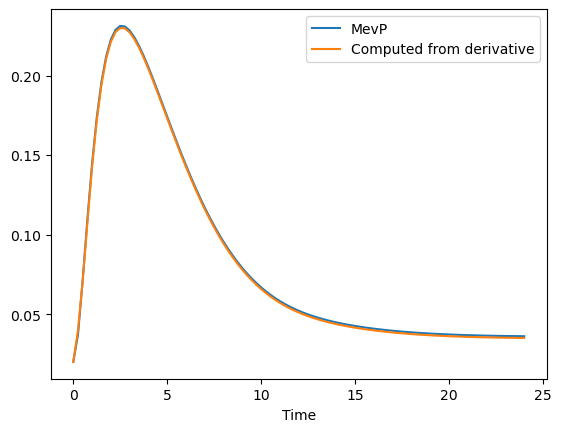

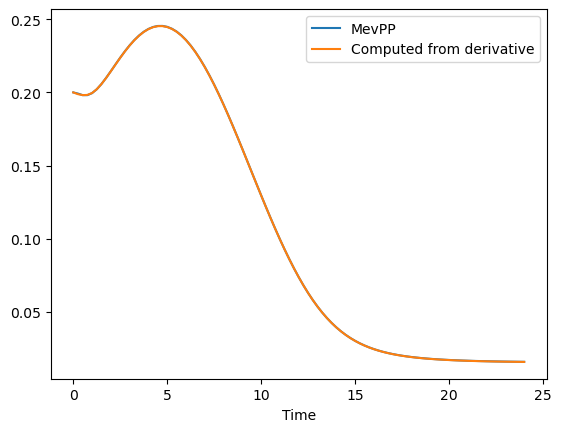

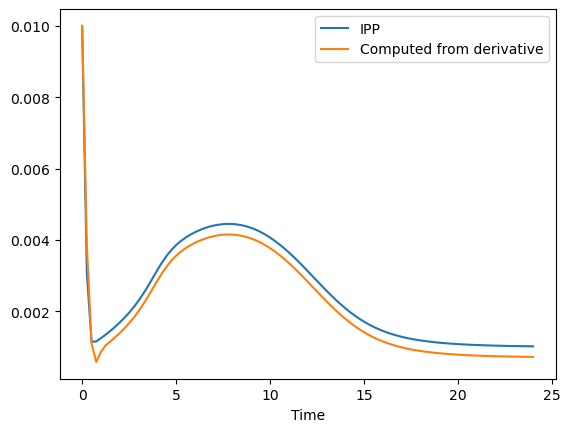

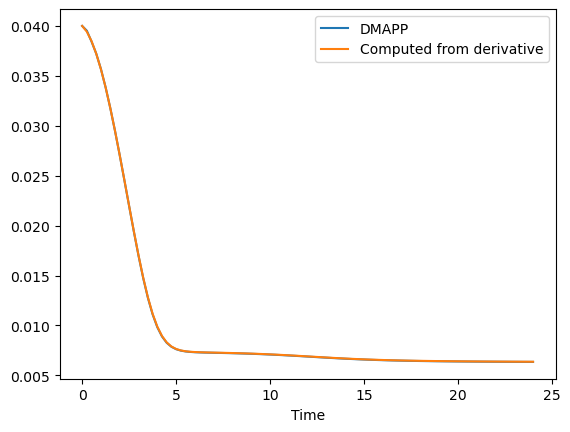

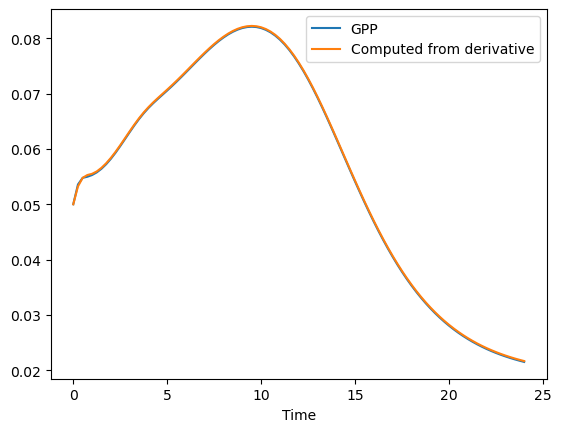

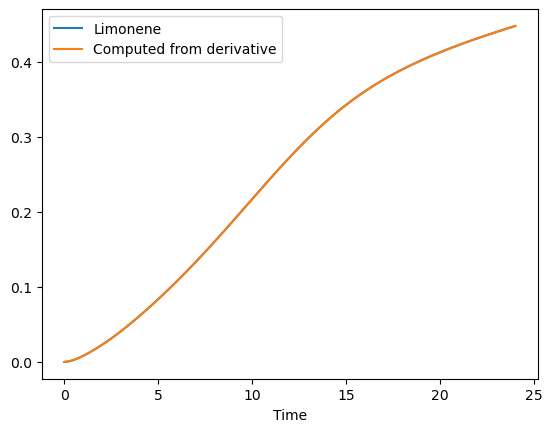

'Time profile from derivative vs. actual profile for Strain 3'

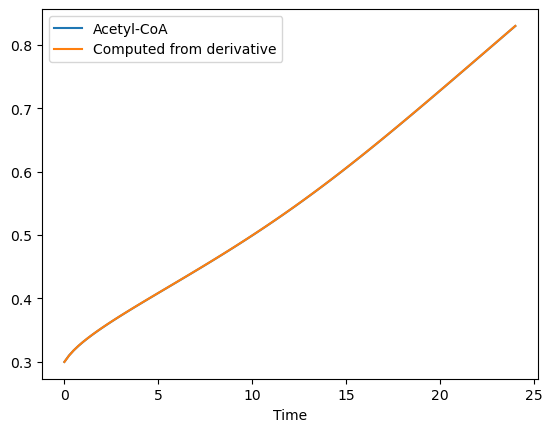

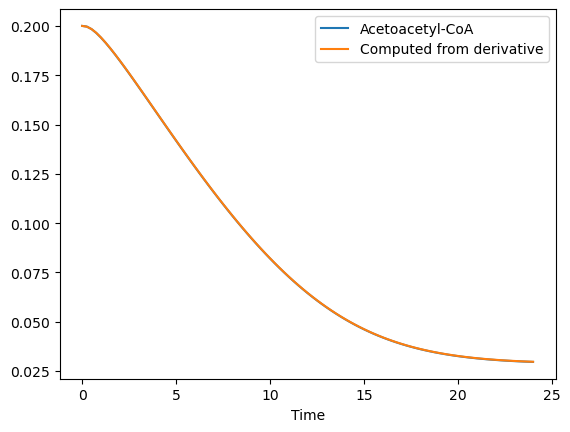

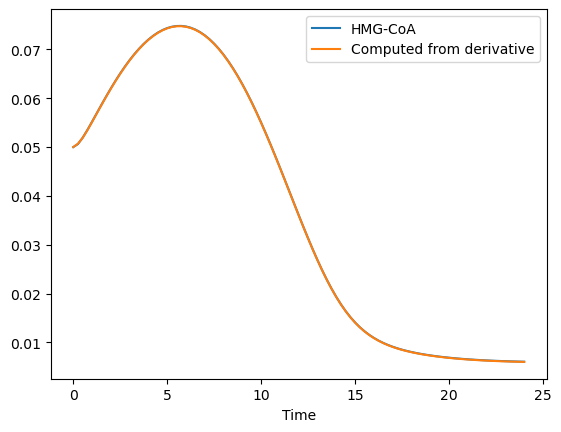

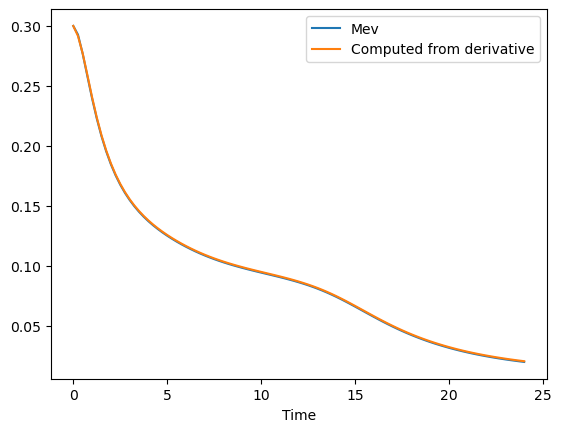

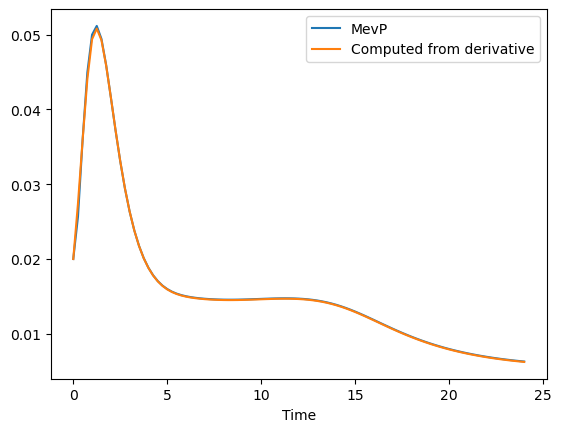

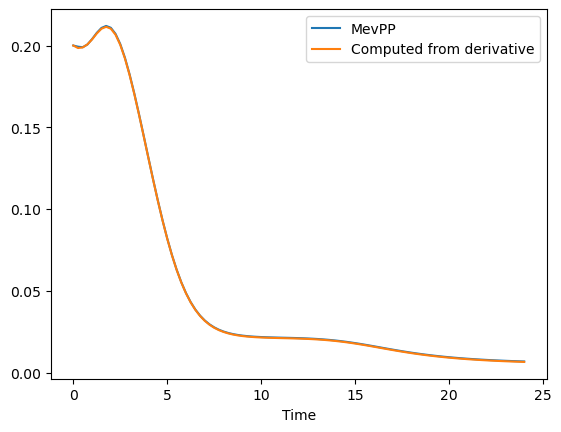

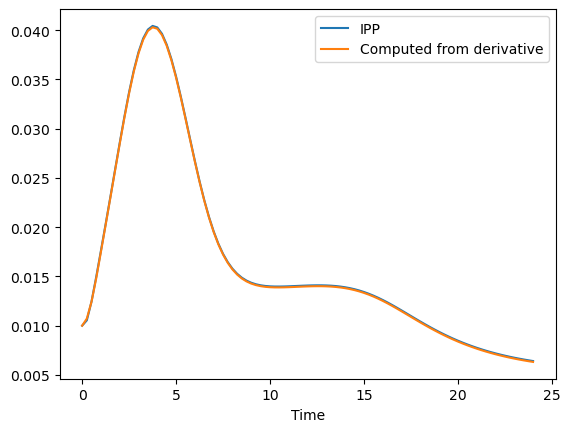

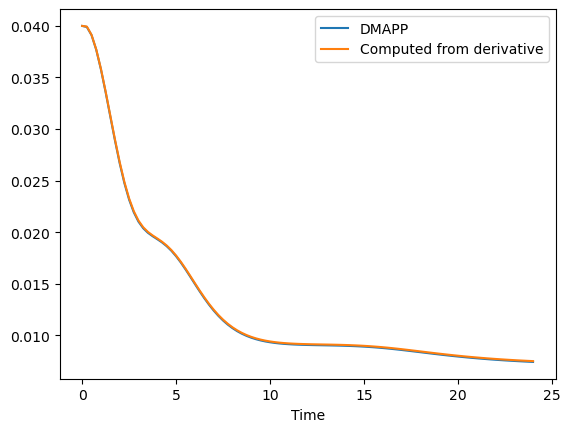

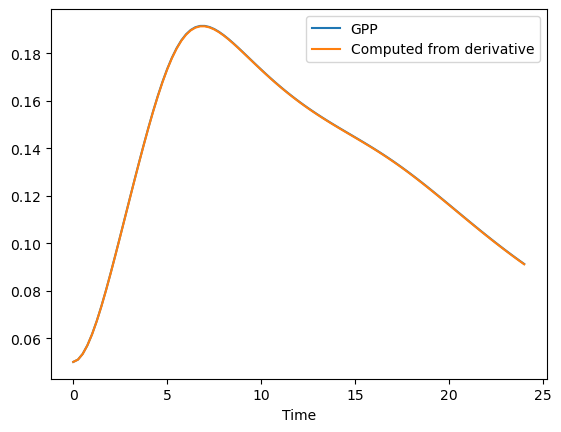

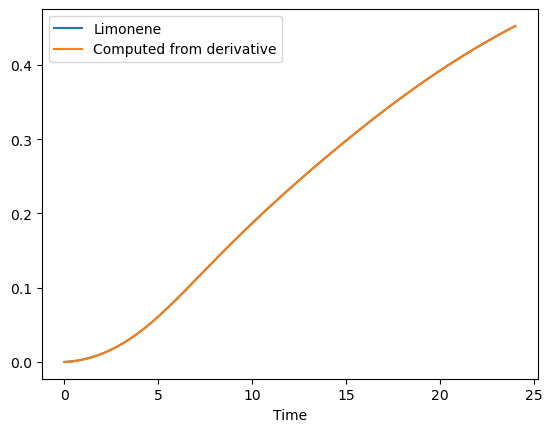

'Time profile from derivative vs. actual profile for WT'

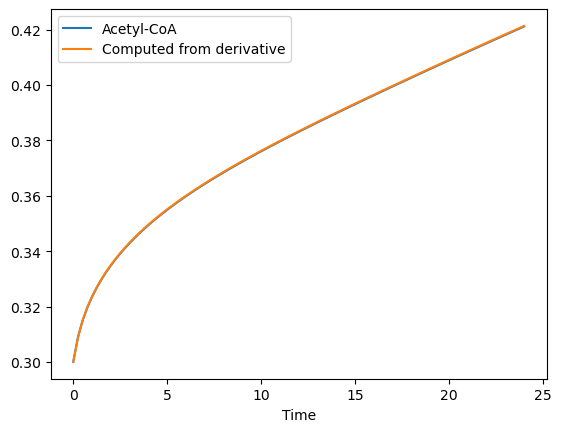

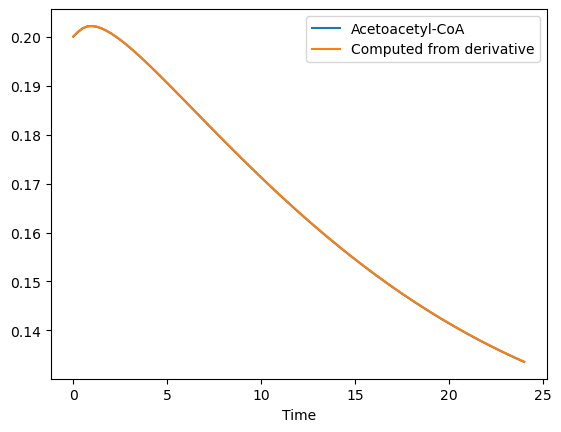

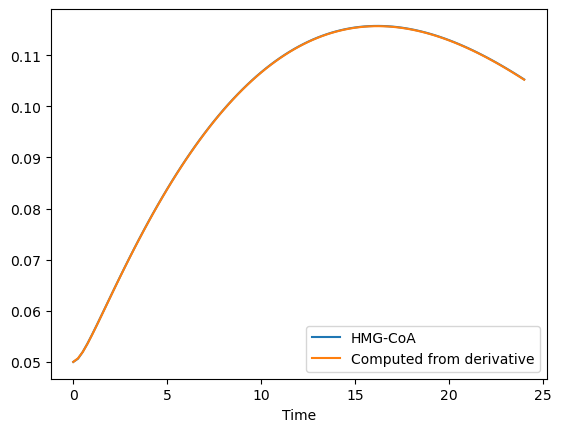

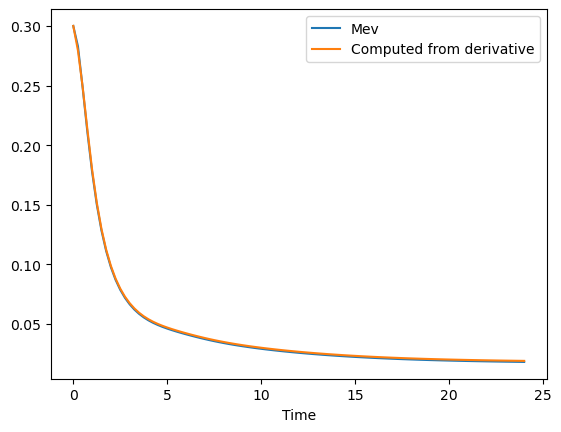

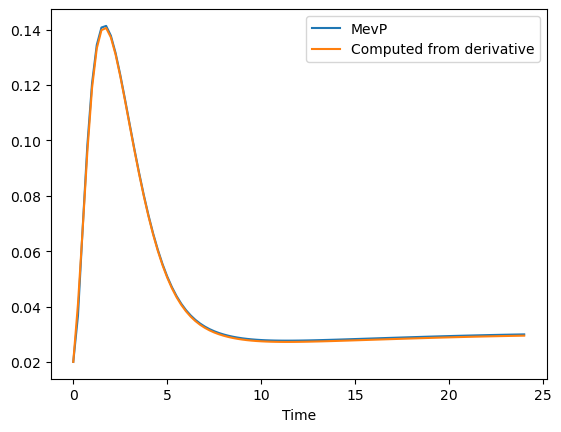

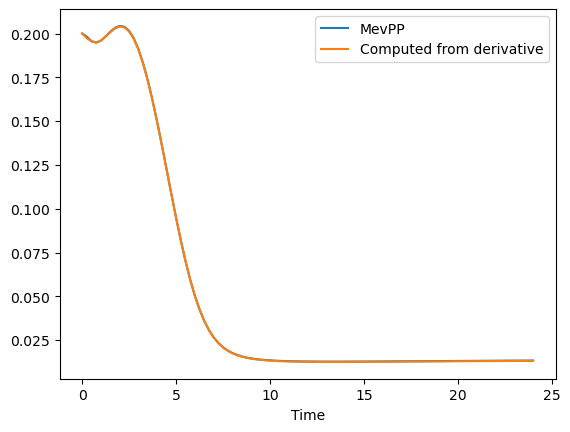

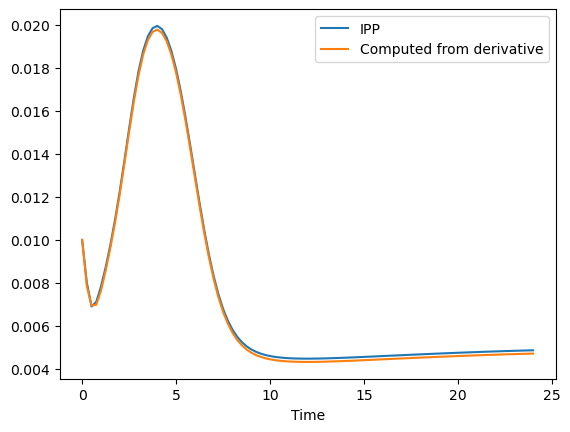

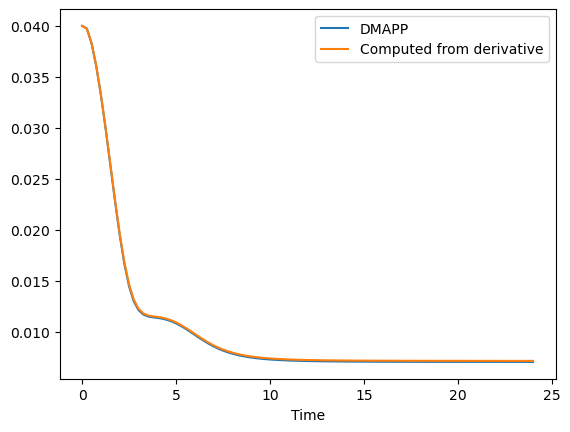

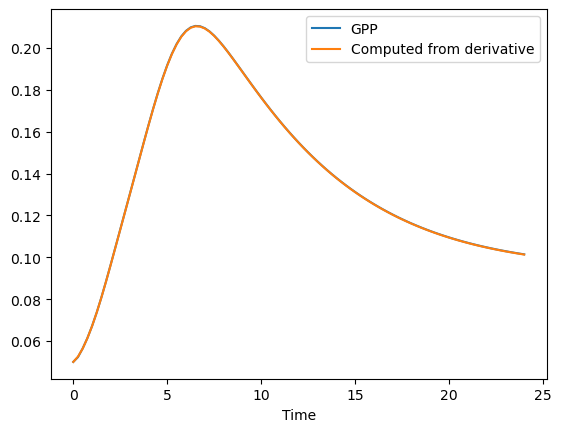

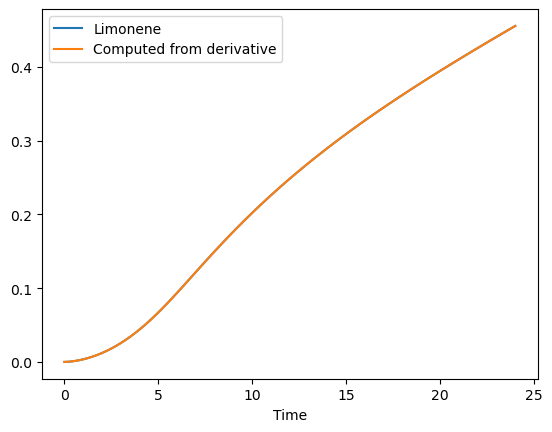

In [24]:
if inspectRate==True:
    from KineticLearning import check_derivative
    check_derivative(df_allSmooth)
    
#HC: synthetic data has sharp conc changes for HMG-CoA, Mev, IPP, DMAPP that are not well estimated by savgol filter 

# Prepare dataframes for model fitting (kr optimization)

enzymes, metabolites

Again:

measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase']

measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']

In [25]:
# 9 enzymes conc measurement used for fitting model
x_controls = [('controls',control) for control in measured_enzymes]
controls_df = df_allSmooth[x_controls] # dataframe format

# 10 substrates conc measurement used for fitting model
x_states = [('states',state) for state in measured_substrates]
states_df = df_allSmooth[x_states] # dataframe format

# merge enzymes & substrates measurement as single feature dataframe
features_df = pd.merge(controls_df, states_df,left_index=True, right_index=True,how='left')
print('Enzyme & metabolite timepoint data to be used for model fitting')
display (features_df) # check total no. time-series datapoints (all strains)

Enzyme & metabolite timepoint data to be used for model fitting


controls                                            \
                        AtoB          HMGS          HMGR            MK   
Strain   Time                                                            
Strain 1 0.00   5.946962e+01  3.973013e+01  3.696892e+01  5.762279e+01   
         0.25   4.568047e+06  2.339239e+06  2.165020e+05  1.413483e+06   
         0.50   5.471875e+06  3.482933e+06  3.394490e+05  2.217158e+06   
         0.75   5.858245e+06  4.161080e+06  4.187155e+05  2.735644e+06   
         1.00   6.072640e+06  4.609864e+06  4.740683e+05  3.097868e+06   
...                      ...           ...           ...           ...   
WT       23.00  2.729403e+06  2.685480e+06  1.768100e+06  2.009782e+06   
         23.25  2.729560e+06  2.686069e+06  1.768628e+06  2.010384e+06   
         23.50  2.729713e+06  2.686645e+06  1.769146e+06  2.010974e+06   
         23.75  2.729863e+06  2.687209e+06  1.769653e+06  2.011551e+06   
         24.00  2.730010e+06  2.687762e+06  1.770149e+06  2.012117e+06   

                                                                        \
                         PMK           PMD          GPPS           Idi   
Strain   Time                                                            
Strain 1 0.00   2.659959e+01  5.448132e+01  5.547215e+01  1.868778e+01   
         0.25   4.735188e+05  2.301051e+06  2.600509e+06  4.287990e+05   
         0.50   7.241324e+05  3.761395e+06  3.265182e+06  6.399929e+05   
         0.75   8.792538e+05  4.770619e+06  3.569278e+06  7.657046e+05   
         1.00   9.847275e+05  5.509792e+06  3.743605e+06  8.490980e+05   
...                      ...           ...           ...           ...   
WT       23.00  1.501640e+06  3.990692e+06  4.353803e+06  1.235104e+06   
         23.25  1.502026e+06  3.992254e+06  4.354150e+06  1.235378e+06   
         23.50  1.502403e+06  3.993784e+06  4.354490e+06  1.235647e+06   
         23.75  1.502773e+06  3.995283e+06  4.354822e+06  1.235910e+06   
         24.00  1.503135e+06  3.996752e+06  4.355148e+06  1.236168e+06   

                                     states                            \
               Limonene Synthase Acetyl-CoA Acetoacetyl-CoA   HMG-CoA   
Strain   Time                                                           
Strain 1 0.00       3.034108e+01   0.300000        0.200000  0.050000   
         0.25       1.837058e+05   0.303889        0.202239  0.052901   
         0.50       2.866143e+05   0.300366        0.204051  0.059318   
         0.75       3.524272e+05   0.293825        0.204705  0.067553   
         1.00       3.981392e+05   0.285682        0.204435  0.076846   
...                          ...        ...             ...       ...   
WT       23.00      1.468009e+06   0.418135        0.135344  0.107524   
         23.25      1.468435e+06   0.418894        0.134891  0.106975   
         23.50      1.468851e+06   0.419652        0.134446  0.106413   
         23.75      1.469260e+06   0.420408        0.134009  0.105838   
         24.00      1.469659e+06   0.421163        0.133581  0.105252   

                                                                            \
                     Mev      MevP     MevPP       IPP     DMAPP       GPP   
Strain   Time                                                                
Strain 1 0.00   0.300000  0.020000  0.200000  0.010000  0.040000  0.050000   
         0.25   0.257973  0.060732  0.194292  0.011434  0.039765  0.052914   
         0.50   0.185505  0.126153  0.184541  0.014747  0.037935  0.060579   
         0.75   0.125893  0.171899  0.174893  0.018155  0.034722  0.072187   
         1.00   0.085674  0.193388  0.164537  0.021526  0.030790  0.086852   
...                  ...       ...       ...       ...       ...       ...   
WT       23.00  0.018433  0.029820  0.013294  0.004839  0.007023  0.102943   
         23.25  0.018376  0.029853  0.013307  0.004846  0.007023  0.102536   
         23.50  0.018321  0.029884  0.013319  0.004852  0.007023 

rate of reaction

In [26]:
# get rate of reaction for selected metabolites
y_derivatives = [('derivatives',derivative) for derivative in measured_substrates]
y_derivatives_df=df_allSmooth[y_derivatives]

# print ('Sample size of X & y should match:')
# print ('Sample size of X:'+ str(features_df.shape[0])) # df is 'array-like' NOT list
# print ('Sample size of y:'+ str(y_derivatives_df.shape[0])+'\n----------------\n')

print('Rate of reaction time datapoints to be used for model fitting')
display (y_derivatives_df) # check total no. time-series datapoints (all strains), sld be SAME as features_df

Rate of reaction time datapoints to be used for model fitting


derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00     0.024056        0.011807  0.006596 -0.203422  0.217911   
         0.25    -0.000307        0.008010  0.019158 -0.234048  0.216216   
         0.50    -0.018662        0.004401  0.028864 -0.237215  0.192786   
         0.75    -0.031009        0.000980  0.035716 -0.212924  0.147623   
         1.00    -0.034961       -0.002637  0.038781 -0.133242  0.051775   
...                    ...             ...       ...       ...       ...   
WT       23.00    0.003039       -0.001829 -0.002172 -0.000234  0.000133   
         23.25    0.003034       -0.001796 -0.002224 -0.000225  0.000128   
         23.50    0.003028       -0.001764 -0.002274 -0.000216  0.000123   
         23.75    0.003022       -0.001731 -0.002322 -0.000208  0.000117   
         24.00    0.003017       -0.001699 -0.002367 -0.000200  0.000112   

                                                                  
                   MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                     
Strain 1 0.00  -0.025532  0.005014  0.003988  0.001041  0.000215  
         0.25  -0.030620  0.009670 -0.004554  0.021740  0.000923  
         0.50  -0.035884  0.012750 -0.010733  0.039083  0.001698  
         0.75  -0.041325  0.014255 -0.014547  0.053067  0.002541  
         1.00  -0.044974  0.013478 -0.016064  0.063589  0.003433  
...                  ...       ...       ...       ...       ...  
WT       23.00  0.000053  0.000026 -0.000001 -0.001663  0.014958  
         23.25  0.000051  0.000025 -0.000001 -0.001590  0.014904  
         23.50  0.000049  0.000024 -0.000001 -0.001521  0.014852  
         23.75  0.000047  0.000023 -0.000001 -0.001454  0.014803  
         24.00  0.000044  0.000023 -0.000001 -0.001390  0.014756  

[388 rows x 10 columns]

# Prepare X, y for fitting

In [27]:
import random
random.seed(a='anyString')

# Get X,y for fitting
X=features_df.to_numpy() # dataframe to array
y=y_derivatives_df.to_numpy()


# Evaluate rate constants

In [28]:
from pymoo.core.problem import ElementwiseProblem

class MyProblem(ElementwiseProblem):
    
    def __init__(self, **kwargs):
        super().__init__(n_var=27, # no. of free parameters
                         n_obj=1, # weighted squared error
                         n_ieq_constr=0, # no inequality
                         xl=np.array([
                             -12.0,-12.0,
                             -12.0,-12.0,-12.0,
                             -12.0,0.0,-12.0,-12.0,
                             0.0,-12.0,-12.0,0.0,
                             -12.0,-12.0,
                             -12.0,-12.0,-12.0,-12.0,
                             0.0,0.0,
                             -12.0,-12.0,-12.0,
                             0.0,-12.0,
                             -1.30103]), # lower bounds
                         xu=np.array([
                             0.0,0.0,
                             0.0,0.0,0.0,
                             0.0,12.0,0.0,0.0,
                             12.0,0.0,0.0,12.0,
                             0.0,0.0,
                             0.0,0.0,0.0,0.0,
                             12.0,12.0,
                             0.0,0.0,0.0,
                             12.0,0.0,
                             -1.301029]) # upper bounds
                        )
        
    def _kinetic_model(self, e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
                       kma11,kcat1,
                       kma21,kma22,kcat2,
                       kma33,kI31,kI32,kcat3,
                       kma44,kI46,kI49,kcat4,
                       kma55,kcat5,
                       kma66,kI64,kI65,kcat6,
                       kma77,kcat7,
                       kma87,kma88,kcat8,
                       kma99,kcat9,
                       Vin): #HC: 27
    
        s11_hat = s1 / (10**kma11)
        r1 = e1 *(10**kcat1) *(s11_hat**2)/(1 + s11_hat + s11_hat**2)  # AtoB
        
        s21_hat = s1 / (10**kma21)
        s22_hat = s2 / (10**kma22)
        r2 = e2 *(10**kcat2) *s21_hat *s22_hat/(1 +s21_hat +s22_hat +s21_hat*s22_hat) # HMGS
        
        s33_hat = s3/ (10**kma33)
        h31 = (10**kI31) /( (10**kI31) + s1)
        h32 = (10**kI32) /( (10**kI32) + s2)
        r3 = h31 *h32 *e3 * (10**kcat3) *s33_hat / (1 + s33_hat) # HMGR

        s44_hat = s4/ (10**kma44)
        h46 = (10**kI46) /( (10**kI46) + s6)
        h49 = (10**kI49) /( (10**kI49) + s9)
        r4 = h46 *h49 *e4 * (10**kcat4) *s44_hat / (1 + s44_hat) # MK

        s55_hat = s5/ (10**kma55)
        r5 = e5 *(10**kcat5) *s55_hat / (1 + s55_hat) # PMK

        s66_hat = s6/ (10**kma66)
        h64 = (10**kI64) /( (10**kI64) + s4)
        h65 = (10**kI65) /( (10**kI65) + s5)
        r6 = h64 *h65 *e6 *(10**kcat6) *s66_hat / (1 + s66_hat) # PMD

        s77_hat = s7/ (10**kma77)
        r7 = e7 *(10**kcat7) *s77_hat / (1 + s77_hat) # IDI

        s87_hat = s7 / (10**kma87)
        s88_hat = s8 / (10**kma88)
        r8 = e8 *(10**kcat8) *s87_hat *s88_hat/(1 +s87_hat +s88_hat +s87_hat*s88_hat) # GPPS

        s99_hat = s9/ (10**kma99)
        r9 = e9 *(10**kcat9) *s99_hat / (1 + s99_hat) # LS           

        r10 = 10**Vin # AcCoA supply
                
        # net metabolite turnover in Costello et al.
        rs1 = r10 - r1 - r2     
        rs2 = r1 - r2
        rs3 = r2 - r3
        rs4 = r3 - r4
        rs5 = r4 - r5
        rs6 = r5 - r6
        rs7 = r6 - r7 - r8
        rs8 = r7 - r8
        rs9 = r8 - r9
        rs10 = r9
        
        return [rs1,rs2,rs3,rs4,rs5,rs6,rs7,rs8,rs9,rs10]
     
    def _derivatives_error_fcn_gen(self, X, y):
        """
        Returns a defined function (NOT numerical value) 
        that reports the error score for given set of model parameters as argument
        X, y: for defining the function
        """

        # Convert array-like data to list for defining error function
        XX = X.tolist() # order according to measured_enzymes, then measured_substrates
        yy = y.tolist()
        #print(str(len(X)))
        #print(str(len(y)))        
        #print ('Sample size of XX & yy should match:')
        #print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
        #print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


        # THE FUNCTION BEING DEFINED & TO BE RETURNED
        def _derivatives_error_fcn(free_params):
            # Error evaluation
            derivatives_error = 0 # initialize
            count = 0
            for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

                # Prepare argument for 'model' function in the same order
                params = []
                params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
                params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
                params.extend(free_params)    # take in SAME argument values for free kinetic parameters

                # Print the instances for each function call
                '''
                print('len x_val:' + str(len(x_val))+'\n')
                print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
                print('len y_vals:' + str(len(y_vals))+'\n')
                print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
                print ('len free_params:' + str(len(free_params))+'\n')
                #print (free_params)
                print ('len params:' + str(len(params))+'\n')
                #print (params)
                '''

                #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
                #print (free_params)

                ### Get list of predicted metabolite production rates for THE timepoint/strain  
                mp = self._kinetic_model(*params)
                prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
                
                # Update total error between predicted & measured reaction rates
                # by including error for current timepoint/strain
                # Again, same free params value is used
                derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
                count = count + 1
                #derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
            MSE = (10**5)*derivatives_error/( count*len(prediction) )
            #print ('count: ' + str(count))
            return MSE #derivatives_error # return numerical value

        return _derivatives_error_fcn

    def _evaluate(self, x, out, *args, **kwargs):
        '''
        x: one-dimensional NumPy array of length n_var, i.e., 34 kr parameter values
        '''
        
        #print ('no. x' + str( len(x) ) )
        #print (x)

        #print (len(X))
        #print (X)
        #print (len(y))
        #print (y)
        self._derivatives_error_fcn = self._derivatives_error_fcn_gen(X, y)
        f = self._derivatives_error_fcn(x) # objective error func
        out["F"] = [f] 


In [29]:
import multiprocessing
from pymoo.core.problem import StarmapParallelization

n_cores = 4
pool = multiprocessing.Pool(n_cores)
runner = StarmapParallelization(pool.starmap)
problem=MyProblem(elementwise_runner=runner)


# --- Optimization algorithm

In [30]:
algo = 'SRES'

from pymoo.operators.sampling.lhs import LHS
if algo == 'SRES':
    from pymoo.algorithms.soo.nonconvex.sres import SRES
    algorithm = SRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'CMAES':
    from pymoo.algorithms.soo.nonconvex.cmaes import CMAES
    algorithm = CMAES(popsize=64)
elif algo == 'DE':
    from pymoo.algorithms.soo.nonconvex.de import DE
    algorithm = DE(pop_size=64, sampling=LHS(),
    variant="DE/rand/1/bin", CR=0.3, 
    dither="vector", jitter=False)
elif algo == 'ISRES':
    from pymoo.algorithms.soo.nonconvex.isres import ISRES
    algorithm = ISRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'G3PCX':
    from pymoo.algorithms.soo.nonconvex.g3pcx import G3PCX
    algorithm = G3PCX(pop_size=64,sampling=LHS())
else:
    print ('No such algo: ' + algo + '\n')
    
from pymoo.termination import get_termination
termination = get_termination("n_gen", 1e5)

In [31]:
# Callback function to update f_min_log during optimization
f_min_log = []

def callback(res):
     f_min_log.append(res.opt.get("F").min())

from pymoo.optimize import minimize
print ('Algorithm in use: ' + algo + '\n')
res = minimize(problem,
               algorithm,
               termination,
               callback=callback,
               seed=10,
               verbose=True)

print('Time required:', res.exec_time)
pool.close()
print("Best solution found: \nX = %s\nF = %s\nCV = %s" % (res.X, res.F, res.CV))

Algorithm in use: SRES

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 |  3.525803E+27 |  1.976704E+08
     2 |       74 |  6.368236E+09 |  8.538816E+03
     3 |      138 |  3.507964E+05 |  1.749254E+02
     4 |      202 |  3.800339E+03 |  1.749254E+02
     5 |      266 |  1.501825E+03 |  4.898975E+01
     6 |      330 |  6.360738E+01 |  4.763643E+01
     7 |      394 |  4.995789E+01 |  4.602704E+01
     8 |      458 |  4.721345E+01 |  4.352752E+01
     9 |      522 |  4.492588E+01 |  4.352752E+01
    10 |      586 |  4.526275E+01 |  3.866002E+01
    11 |      650 |  4.687262E+01 |  3.843474E+01
    12 |      714 |  4.796111E+01 |  3.747613E+01
    13 |      778 |  4.853064E+01 |  3.747613E+01
    14 |      842 |  4.642761E+01 |  3.747613E+01
    15 |      906 |  4.403200E+01 |  3.747613E+01
    16 |      970 |  4.390637E+01 |  3.747613E+01
    17 |     1034 |  4.689697E+01 |  3.747613E+01
    18 |     1098 |  4.483711E+01 |  3.747613E+01
    19 |     1162 |  4.430

   162 |    10314 |  2.093515E+01 |  1.934476E+01
   163 |    10378 |  2.124683E+01 |  1.934476E+01
   164 |    10442 |  2.084183E+01 |  1.934476E+01
   165 |    10506 |  2.089111E+01 |  1.934476E+01
   166 |    10570 |  2.061354E+01 |  1.934476E+01
   167 |    10634 |  2.041369E+01 |  1.934476E+01
   168 |    10698 |  2.025034E+01 |  1.934476E+01
   169 |    10762 |  2.032079E+01 |  1.934476E+01
   170 |    10826 |  2.039038E+01 |  1.934476E+01
   171 |    10890 |  2.053846E+01 |  1.934476E+01
   172 |    10954 |  2.023553E+01 |  1.934476E+01
   173 |    11018 |  1.996368E+01 |  1.934476E+01
   174 |    11082 |  1.997134E+01 |  1.922210E+01
   175 |    11146 |  1.971200E+01 |  1.849869E+01
   176 |    11210 |  1.969911E+01 |  1.849869E+01
   177 |    11274 |  1.978574E+01 |  1.849869E+01
   178 |    11338 |  1.972297E+01 |  1.849869E+01
   179 |    11402 |  1.969031E+01 |  1.849869E+01
   180 |    11466 |  1.985737E+01 |  1.849869E+01
   181 |    11530 |  2.015578E+01 |  1.849869E+01


   326 |    20810 |  1.608222E+01 |  1.606406E+01
   327 |    20874 |  1.607069E+01 |  1.604784E+01
   328 |    20938 |  1.605772E+01 |  1.604036E+01
   329 |    21002 |  1.604690E+01 |  1.603338E+01
   330 |    21066 |  1.604038E+01 |  1.603338E+01
   331 |    21130 |  1.603378E+01 |  1.602222E+01
   332 |    21194 |  1.601783E+01 |  1.598500E+01
   333 |    21258 |  1.600489E+01 |  1.598500E+01
   334 |    21322 |  1.600246E+01 |  1.598500E+01
   335 |    21386 |  1.599222E+01 |  1.598015E+01
   336 |    21450 |  1.598134E+01 |  1.596317E+01
   337 |    21514 |  1.597530E+01 |  1.596125E+01
   338 |    21578 |  1.596992E+01 |  1.596125E+01
   339 |    21642 |  1.596299E+01 |  1.595184E+01
   340 |    21706 |  1.595130E+01 |  1.593884E+01
   341 |    21770 |  1.594747E+01 |  1.593884E+01
   342 |    21834 |  1.594291E+01 |  1.593258E+01
   343 |    21898 |  1.593909E+01 |  1.592920E+01
   344 |    21962 |  1.593814E+01 |  1.592920E+01
   345 |    22026 |  1.593514E+01 |  1.592920E+01


   490 |    31306 |  1.343240E+01 |  1.323607E+01
   491 |    31370 |  1.328358E+01 |  1.303950E+01
   492 |    31434 |  1.323258E+01 |  1.302269E+01
   493 |    31498 |  1.318029E+01 |  1.301764E+01
   494 |    31562 |  1.303228E+01 |  1.273973E+01
   495 |    31626 |  1.315917E+01 |  1.273973E+01
   496 |    31690 |  1.309917E+01 |  1.273973E+01
   497 |    31754 |  1.305356E+01 |  1.273973E+01
   498 |    31818 |  1.318841E+01 |  1.273973E+01
   499 |    31882 |  1.313037E+01 |  1.273973E+01
   500 |    31946 |  1.307007E+01 |  1.273126E+01
   501 |    32010 |  1.287808E+01 |  1.266748E+01
   502 |    32074 |  1.283963E+01 |  1.264613E+01
   503 |    32138 |  1.279892E+01 |  1.250537E+01
   504 |    32202 |  1.270604E+01 |  1.250537E+01
   505 |    32266 |  1.258175E+01 |  1.242295E+01
   506 |    32330 |  1.250656E+01 |  1.228533E+01
   507 |    32394 |  1.252836E+01 |  1.228533E+01
   508 |    32458 |  1.243193E+01 |  1.226702E+01
   509 |    32522 |  1.241291E+01 |  1.218928E+01


   654 |    41802 |  1.112674E+01 |  1.112487E+01
   655 |    41866 |  1.112582E+01 |  1.112487E+01
   656 |    41930 |  1.112549E+01 |  1.112327E+01
   657 |    41994 |  1.112421E+01 |  1.112234E+01
   658 |    42058 |  1.112227E+01 |  1.111814E+01
   659 |    42122 |  1.112028E+01 |  1.111814E+01
   660 |    42186 |  1.111859E+01 |  1.111637E+01
   661 |    42250 |  1.111610E+01 |  1.111241E+01
   662 |    42314 |  1.111459E+01 |  1.111226E+01
   663 |    42378 |  1.111396E+01 |  1.111219E+01
   664 |    42442 |  1.111276E+01 |  1.111012E+01
   665 |    42506 |  1.111152E+01 |  1.110795E+01
   666 |    42570 |  1.110876E+01 |  1.110591E+01
   667 |    42634 |  1.110757E+01 |  1.110561E+01
   668 |    42698 |  1.110680E+01 |  1.110561E+01
   669 |    42762 |  1.110608E+01 |  1.110405E+01
   670 |    42826 |  1.110496E+01 |  1.110358E+01
   671 |    42890 |  1.110231E+01 |  1.109965E+01
   672 |    42954 |  1.109942E+01 |  1.109532E+01
   673 |    43018 |  1.109724E+01 |  1.109532E+01


   818 |    52298 |  9.9740376527 |  9.9688740407
   819 |    52362 |  9.9719050452 |  9.9674628030
   820 |    52426 |  9.9712102481 |  9.9659055388
   821 |    52490 |  9.9688585448 |  9.9635713870
   822 |    52554 |  9.9661477110 |  9.9635713870
   823 |    52618 |  9.9659294225 |  9.9630904950
   824 |    52682 |  9.9645449875 |  9.9630904950
   825 |    52746 |  9.9641747698 |  9.9623856805
   826 |    52810 |  9.9623529148 |  9.9587312832
   827 |    52874 |  9.9611617481 |  9.9587312832
   828 |    52938 |  9.9597082534 |  9.9560031845
   829 |    53002 |  9.9578784903 |  9.9560031845
   830 |    53066 |  9.9559518897 |  9.9528168261
   831 |    53130 |  9.9524216242 |  9.9479603505
   832 |    53194 |  9.9503161713 |  9.9475475292
   833 |    53258 |  9.9495646228 |  9.9462313401
   834 |    53322 |  9.9461408212 |  9.9430288918
   835 |    53386 |  9.9436910313 |  9.9407165675
   836 |    53450 |  9.9411324211 |  9.9375352033
   837 |    53514 |  9.9383829371 |  9.9362420283


   982 |    62794 |  9.6252736473 |  9.6214724438
   983 |    62858 |  9.6245599702 |  9.6208587649
   984 |    62922 |  9.6227796863 |  9.6208587649
   985 |    62986 |  9.6231975184 |  9.6208587649
   986 |    63050 |  9.6225243461 |  9.6208587649
   987 |    63114 |  9.6224141910 |  9.6206910642
   988 |    63178 |  9.6227144590 |  9.6201229602
   989 |    63242 |  9.6239553487 |  9.6201229602
   990 |    63306 |  9.6250576951 |  9.6201229602
   991 |    63370 |  9.6229300902 |  9.6201229602
   992 |    63434 |  9.6228849325 |  9.6201229602
   993 |    63498 |  9.6216578093 |  9.6183301510
   994 |    63562 |  9.6210714207 |  9.6183301510
   995 |    63626 |  9.6197253005 |  9.6182126427
   996 |    63690 |  9.6198666912 |  9.6177465351
   997 |    63754 |  9.6191846260 |  9.6177465351
   998 |    63818 |  9.6190767046 |  9.6168510800
   999 |    63882 |  9.6166283878 |  9.6145647300
  1000 |    63946 |  9.6156166047 |  9.6131529669
  1001 |    64010 |  9.6143376390 |  9.6127062356


  1146 |    73290 |  9.5747469735 |  9.5747080730
  1147 |    73354 |  9.5747235937 |  9.5746764781
  1148 |    73418 |  9.5747046098 |  9.5746764781
  1149 |    73482 |  9.5747052482 |  9.5746764781
  1150 |    73546 |  9.5746972512 |  9.5746449777
  1151 |    73610 |  9.5746772213 |  9.5746036469
  1152 |    73674 |  9.5746288144 |  9.5746036469
  1153 |    73738 |  9.5746273931 |  9.5746024125
  1154 |    73802 |  9.5746059938 |  9.5745833504
  1155 |    73866 |  9.5745986295 |  9.5745833504
  1156 |    73930 |  9.5745896556 |  9.5745641416
  1157 |    73994 |  9.5745968890 |  9.5745641416
  1158 |    74058 |  9.5745794843 |  9.5745619287
  1159 |    74122 |  9.5745739622 |  9.5745246492
  1160 |    74186 |  9.5745576184 |  9.5745089159
  1161 |    74250 |  9.5745451363 |  9.5745089159
  1162 |    74314 |  9.5745189060 |  9.5744884788
  1163 |    74378 |  9.5745019204 |  9.5744703040
  1164 |    74442 |  9.5744801111 |  9.5744283466
  1165 |    74506 |  9.5744640684 |  9.5744283466


  1310 |    83786 |  9.5642046654 |  9.5641669048
  1311 |    83850 |  9.5641812619 |  9.5641642657
  1312 |    83914 |  9.5641558474 |  9.5641369501
  1313 |    83978 |  9.5641465976 |  9.5641234254
  1314 |    84042 |  9.5641221078 |  9.5640957169
  1315 |    84106 |  9.5641018374 |  9.5640681687
  1316 |    84170 |  9.5640838546 |  9.5640453485
  1317 |    84234 |  9.5640664605 |  9.5640385299
  1318 |    84298 |  9.5640460388 |  9.5640289063
  1319 |    84362 |  9.5640390917 |  9.5640206511
  1320 |    84426 |  9.5640203796 |  9.5639993783
  1321 |    84490 |  9.5640156738 |  9.5639990168
  1322 |    84554 |  9.5640075720 |  9.5639949888
  1323 |    84618 |  9.5640008486 |  9.5639737604
  1324 |    84682 |  9.5639921212 |  9.5639737604
  1325 |    84746 |  9.5639823056 |  9.5639683650
  1326 |    84810 |  9.5639778279 |  9.5639649088
  1327 |    84874 |  9.5639676665 |  9.5639507573
  1328 |    84938 |  9.5639615590 |  9.5639507573
  1329 |    85002 |  9.5639509102 |  9.5639330471


  1474 |    94282 |  9.5630626606 |  9.5630593763
  1475 |    94346 |  9.5630596424 |  9.5630567655
  1476 |    94410 |  9.5630577632 |  9.5630552898
  1477 |    94474 |  9.5630560482 |  9.5630532388
  1478 |    94538 |  9.5630562012 |  9.5630502131
  1479 |    94602 |  9.5630565075 |  9.5630502131
  1480 |    94666 |  9.5630548623 |  9.5630502131
  1481 |    94730 |  9.5630508548 |  9.5630460751
  1482 |    94794 |  9.5630490049 |  9.5630453121
  1483 |    94858 |  9.5630474825 |  9.5630453121
  1484 |    94922 |  9.5630451887 |  9.5630423851
  1485 |    94986 |  9.5630445218 |  9.5630423851
  1486 |    95050 |  9.5630433667 |  9.5630404419
  1487 |    95114 |  9.5630408188 |  9.5630377104
  1488 |    95178 |  9.5630395806 |  9.5630356298
  1489 |    95242 |  9.5630382934 |  9.5630320220
  1490 |    95306 |  9.5630368085 |  9.5630320220
  1491 |    95370 |  9.5630350159 |  9.5630285927
  1492 |    95434 |  9.5630312272 |  9.5630282787
  1493 |    95498 |  9.5630289059 |  9.5630245894


  1638 |   104778 |  9.5628460958 |  9.5628447967
  1639 |   104842 |  9.5628454649 |  9.5628423034
  1640 |   104906 |  9.5628441507 |  9.5628420618
  1641 |   104970 |  9.5628429686 |  9.5628414688
  1642 |   105034 |  9.5628417695 |  9.5628401088
  1643 |   105098 |  9.5628400135 |  9.5628384724
  1644 |   105162 |  9.5628390013 |  9.5628366444
  1645 |   105226 |  9.5628378508 |  9.5628356237
  1646 |   105290 |  9.5628371230 |  9.5628356237
  1647 |   105354 |  9.5628363160 |  9.5628356237
  1648 |   105418 |  9.5628358177 |  9.5628348417
  1649 |   105482 |  9.5628348853 |  9.5628335031
  1650 |   105546 |  9.5628335881 |  9.5628316873
  1651 |   105610 |  9.5628323862 |  9.5628304482
  1652 |   105674 |  9.5628312780 |  9.5628295914
  1653 |   105738 |  9.5628294898 |  9.5628278380
  1654 |   105802 |  9.5628280853 |  9.5628255300
  1655 |   105866 |  9.5628261712 |  9.5628248529
  1656 |   105930 |  9.5628252104 |  9.5628238996
  1657 |   105994 |  9.5628246824 |  9.5628235701


  1802 |   115274 |  9.5624946638 |  9.5624919828
  1803 |   115338 |  9.5624924595 |  9.5624893470
  1804 |   115402 |  9.5624914017 |  9.5624873997
  1805 |   115466 |  9.5624892096 |  9.5624867865
  1806 |   115530 |  9.5624883750 |  9.5624850465
  1807 |   115594 |  9.5624891092 |  9.5624850465
  1808 |   115658 |  9.5624883439 |  9.5624850465
  1809 |   115722 |  9.5624871572 |  9.5624850465
  1810 |   115786 |  9.5624858100 |  9.5624826386
  1811 |   115850 |  9.5624861835 |  9.5624826386
  1812 |   115914 |  9.5624872420 |  9.5624826386
  1813 |   115978 |  9.5624865647 |  9.5624826386
  1814 |   116042 |  9.5624844873 |  9.5624826386
  1815 |   116106 |  9.5624843177 |  9.5624807210
  1816 |   116170 |  9.5624833754 |  9.5624799628
  1817 |   116234 |  9.5624822420 |  9.5624791777
  1818 |   116298 |  9.5624809081 |  9.5624773025
  1819 |   116362 |  9.5624808218 |  9.5624773025
  1820 |   116426 |  9.5624795289 |  9.5624773025
  1821 |   116490 |  9.5624793366 |  9.5624772454


  1966 |   125770 |  9.5623207542 |  9.5623161109
  1967 |   125834 |  9.5623161029 |  9.5623131163
  1968 |   125898 |  9.5623151314 |  9.5623131163
  1969 |   125962 |  9.5623132449 |  9.5623099542
  1970 |   126026 |  9.5623099987 |  9.5623087256
  1971 |   126090 |  9.5623072927 |  9.5623037618
  1972 |   126154 |  9.5623049984 |  9.5623024485
  1973 |   126218 |  9.5623036375 |  9.5623024485
  1974 |   126282 |  9.5623035152 |  9.5623019061
  1975 |   126346 |  9.5623040832 |  9.5623013236
  1976 |   126410 |  9.5623012797 |  9.5622961998
  1977 |   126474 |  9.5622982573 |  9.5622949019
  1978 |   126538 |  9.5622957398 |  9.5622931168
  1979 |   126602 |  9.5622925508 |  9.5622882985
  1980 |   126666 |  9.5622893666 |  9.5622869507
  1981 |   126730 |  9.5622856989 |  9.5622804346
  1982 |   126794 |  9.5622826188 |  9.5622792020
  1983 |   126858 |  9.5622802029 |  9.5622788977
  1984 |   126922 |  9.5622796072 |  9.5622775616
  1985 |   126986 |  9.5622817989 |  9.5622775616


  2130 |   136266 |  9.5616429948 |  9.5616412649
  2131 |   136330 |  9.5616418678 |  9.5616409325
  2132 |   136394 |  9.5616416226 |  9.5616405900
  2133 |   136458 |  9.5616413029 |  9.5616401742
  2134 |   136522 |  9.5616408538 |  9.5616396261
  2135 |   136586 |  9.5616406808 |  9.5616391393
  2136 |   136650 |  9.5616399063 |  9.5616391393
  2137 |   136714 |  9.5616393654 |  9.5616373025
  2138 |   136778 |  9.5616384497 |  9.5616373025
  2139 |   136842 |  9.5616376886 |  9.5616371098
  2140 |   136906 |  9.5616370103 |  9.5616364909
  2141 |   136970 |  9.5616362436 |  9.5616356104
  2142 |   137034 |  9.5616357362 |  9.5616352388
  2143 |   137098 |  9.5616350184 |  9.5616342785
  2144 |   137162 |  9.5616343613 |  9.5616331847
  2145 |   137226 |  9.5616334289 |  9.5616328012
  2146 |   137290 |  9.5616331101 |  9.5616325245
  2147 |   137354 |  9.5616328267 |  9.5616320795
  2148 |   137418 |  9.5616321554 |  9.5616314692
  2149 |   137482 |  9.5616319116 |  9.5616311828


  2294 |   146762 |  9.5615569658 |  9.5615560641
  2295 |   146826 |  9.5615565057 |  9.5615557256
  2296 |   146890 |  9.5615560480 |  9.5615552682
  2297 |   146954 |  9.5615555734 |  9.5615552157
  2298 |   147018 |  9.5615549074 |  9.5615544861
  2299 |   147082 |  9.5615545028 |  9.5615541362
  2300 |   147146 |  9.5615539803 |  9.5615531684
  2301 |   147210 |  9.5615533383 |  9.5615527550
  2302 |   147274 |  9.5615526583 |  9.5615512097
  2303 |   147338 |  9.5615517916 |  9.5615508548
  2304 |   147402 |  9.5615513183 |  9.5615504670
  2305 |   147466 |  9.5615509343 |  9.5615502764
  2306 |   147530 |  9.5615505160 |  9.5615491316
  2307 |   147594 |  9.5615498208 |  9.5615485233
  2308 |   147658 |  9.5615495344 |  9.5615485233
  2309 |   147722 |  9.5615486641 |  9.5615477721
  2310 |   147786 |  9.5615479141 |  9.5615473428
  2311 |   147850 |  9.5615478521 |  9.5615469592
  2312 |   147914 |  9.5615473790 |  9.5615466240
  2313 |   147978 |  9.5615468799 |  9.5615459174


  2458 |   157258 |  9.5613562064 |  9.5613527210
  2459 |   157322 |  9.5613541958 |  9.5613522949
  2460 |   157386 |  9.5613525529 |  9.5613498158
  2461 |   157450 |  9.5613514666 |  9.5613480369
  2462 |   157514 |  9.5613466220 |  9.5613438198
  2463 |   157578 |  9.5613442442 |  9.5613401246
  2464 |   157642 |  9.5613412242 |  9.5613377242
  2465 |   157706 |  9.5613390034 |  9.5613306599
  2466 |   157770 |  9.5613344881 |  9.5613275733
  2467 |   157834 |  9.5613282891 |  9.5613247896
  2468 |   157898 |  9.5613270107 |  9.5613231818
  2469 |   157962 |  9.5613243107 |  9.5613199627
  2470 |   158026 |  9.5613234487 |  9.5613167128
  2471 |   158090 |  9.5613191003 |  9.5613102655
  2472 |   158154 |  9.5613139692 |  9.5613099280
  2473 |   158218 |  9.5613111940 |  9.5613039486
  2474 |   158282 |  9.5613094453 |  9.5612965624
  2475 |   158346 |  9.5613039506 |  9.5612965624
  2476 |   158410 |  9.5613014131 |  9.5612965624
  2477 |   158474 |  9.5612973902 |  9.5612950819


  2622 |   167754 |  9.5610930461 |  9.5610926964
  2623 |   167818 |  9.5610930411 |  9.5610924605
  2624 |   167882 |  9.5610930178 |  9.5610923336
  2625 |   167946 |  9.5610928022 |  9.5610920275
  2626 |   168010 |  9.5610923151 |  9.5610917218
  2627 |   168074 |  9.5610920632 |  9.5610916003
  2628 |   168138 |  9.5610918703 |  9.5610915790
  2629 |   168202 |  9.5610917404 |  9.5610913476
  2630 |   168266 |  9.5610914458 |  9.5610910248
  2631 |   168330 |  9.5610911892 |  9.5610908938
  2632 |   168394 |  9.5610909695 |  9.5610907170
  2633 |   168458 |  9.5610906335 |  9.5610902554
  2634 |   168522 |  9.5610905082 |  9.5610901064
  2635 |   168586 |  9.5610903321 |  9.5610900844
  2636 |   168650 |  9.5610901260 |  9.5610899360
  2637 |   168714 |  9.5610899986 |  9.5610898388
  2638 |   168778 |  9.5610898785 |  9.5610895764
  2639 |   168842 |  9.5610897495 |  9.5610895764
  2640 |   168906 |  9.5610897525 |  9.5610895764
  2641 |   168970 |  9.5610895941 |  9.5610893526


  2786 |   178250 |  9.5609920692 |  9.5609891844
  2787 |   178314 |  9.5609903589 |  9.5609888578
  2788 |   178378 |  9.5609894503 |  9.5609879302
  2789 |   178442 |  9.5609880898 |  9.5609862623
  2790 |   178506 |  9.5609863126 |  9.5609839220
  2791 |   178570 |  9.5609850091 |  9.5609828629
  2792 |   178634 |  9.5609838316 |  9.5609807140
  2793 |   178698 |  9.5609822190 |  9.5609799651
  2794 |   178762 |  9.5609805339 |  9.5609758680
  2795 |   178826 |  9.5609784419 |  9.5609758680
  2796 |   178890 |  9.5609768772 |  9.5609745530
  2797 |   178954 |  9.5609750936 |  9.5609734229
  2798 |   179018 |  9.5609732510 |  9.5609706608
  2799 |   179082 |  9.5609709188 |  9.5609682964
  2800 |   179146 |  9.5609685989 |  9.5609661036
  2801 |   179210 |  9.5609662283 |  9.5609642875
  2802 |   179274 |  9.5609651514 |  9.5609613634
  2803 |   179338 |  9.5609627515 |  9.5609604197
  2804 |   179402 |  9.5609616293 |  9.5609600189
  2805 |   179466 |  9.5609600421 |  9.5609586282


  2950 |   188746 |  9.5608738045 |  9.5608730196
  2951 |   188810 |  9.5608730688 |  9.5608720103
  2952 |   188874 |  9.5608723175 |  9.5608712048
  2953 |   188938 |  9.5608719544 |  9.5608712048
  2954 |   189002 |  9.5608712576 |  9.5608706066
  2955 |   189066 |  9.5608708885 |  9.5608701237
  2956 |   189130 |  9.5608705108 |  9.5608697858
  2957 |   189194 |  9.5608702807 |  9.5608697146
  2958 |   189258 |  9.5608696415 |  9.5608689779
  2959 |   189322 |  9.5608688658 |  9.5608678661
  2960 |   189386 |  9.5608679530 |  9.5608675685
  2961 |   189450 |  9.5608670599 |  9.5608661933
  2962 |   189514 |  9.5608663419 |  9.5608647459
  2963 |   189578 |  9.5608652416 |  9.5608646608
  2964 |   189642 |  9.5608639379 |  9.5608627120
  2965 |   189706 |  9.5608632134 |  9.5608622043
  2966 |   189770 |  9.5608621766 |  9.5608610691
  2967 |   189834 |  9.5608611753 |  9.5608600528
  2968 |   189898 |  9.5608602719 |  9.5608587989
  2969 |   189962 |  9.5608593380 |  9.5608580683


  3114 |   199242 |  9.5607443085 |  9.5607430923
  3115 |   199306 |  9.5607434392 |  9.5607424403
  3116 |   199370 |  9.5607427681 |  9.5607416305
  3117 |   199434 |  9.5607422409 |  9.5607405901
  3118 |   199498 |  9.5607415224 |  9.5607405901
  3119 |   199562 |  9.5607413629 |  9.5607405901
  3120 |   199626 |  9.5607407277 |  9.5607398662
  3121 |   199690 |  9.5607407194 |  9.5607397533
  3122 |   199754 |  9.5607401880 |  9.5607392186
  3123 |   199818 |  9.5607396475 |  9.5607381814
  3124 |   199882 |  9.5607389214 |  9.5607375662
  3125 |   199946 |  9.5607382337 |  9.5607369838
  3126 |   200010 |  9.5607374829 |  9.5607369838
  3127 |   200074 |  9.5607365660 |  9.5607356134
  3128 |   200138 |  9.5607369057 |  9.5607356134
  3129 |   200202 |  9.5607366853 |  9.5607351383
  3130 |   200266 |  9.5607358607 |  9.5607346334
  3131 |   200330 |  9.5607353281 |  9.5607344453
  3132 |   200394 |  9.5607344319 |  9.5607317191
  3133 |   200458 |  9.5607332064 |  9.5607317191


  3278 |   209738 |  9.5606421545 |  9.5606411044
  3279 |   209802 |  9.5606410435 |  9.5606395435
  3280 |   209866 |  9.5606402527 |  9.5606394750
  3281 |   209930 |  9.5606387976 |  9.5606379649
  3282 |   209994 |  9.5606376359 |  9.5606366540
  3283 |   210058 |  9.5606366809 |  9.5606358605
  3284 |   210122 |  9.5606362235 |  9.5606356390
  3285 |   210186 |  9.5606358126 |  9.5606346550
  3286 |   210250 |  9.5606353340 |  9.5606340969
  3287 |   210314 |  9.5606339538 |  9.5606331207
  3288 |   210378 |  9.5606331495 |  9.5606322727
  3289 |   210442 |  9.5606328103 |  9.5606319566
  3290 |   210506 |  9.5606323216 |  9.5606316248
  3291 |   210570 |  9.5606309915 |  9.5606289126
  3292 |   210634 |  9.5606296250 |  9.5606287077
  3293 |   210698 |  9.5606286784 |  9.5606284245
  3294 |   210762 |  9.5606273891 |  9.5606260910
  3295 |   210826 |  9.5606262436 |  9.5606240752
  3296 |   210890 |  9.5606242977 |  9.5606229237
  3297 |   210954 |  9.5606231742 |  9.5606212175


  3442 |   220234 |  9.5604754863 |  9.5604737730
  3443 |   220298 |  9.5604755253 |  9.5604737730
  3444 |   220362 |  9.5604745890 |  9.5604723387
  3445 |   220426 |  9.5604740632 |  9.5604720415
  3446 |   220490 |  9.5604733535 |  9.5604699977
  3447 |   220554 |  9.5604697825 |  9.5604663586
  3448 |   220618 |  9.5604678432 |  9.5604661858
  3449 |   220682 |  9.5604673630 |  9.5604654095
  3450 |   220746 |  9.5604663997 |  9.5604644723
  3451 |   220810 |  9.5604627832 |  9.5604598427
  3452 |   220874 |  9.5604625388 |  9.5604598427
  3453 |   220938 |  9.5604622090 |  9.5604598427
  3454 |   221002 |  9.5604615151 |  9.5604588088
  3455 |   221066 |  9.5604601547 |  9.5604565902
  3456 |   221130 |  9.5604578603 |  9.5604549407
  3457 |   221194 |  9.5604568459 |  9.5604549407
  3458 |   221258 |  9.5604560610 |  9.5604525429
  3459 |   221322 |  9.5604551583 |  9.5604525429
  3460 |   221386 |  9.5604533113 |  9.5604520326
  3461 |   221450 |  9.5604530326 |  9.5604510891


  3606 |   230730 |  9.5604113974 |  9.5604111146
  3607 |   230794 |  9.5604113126 |  9.5604109061
  3608 |   230858 |  9.5604110180 |  9.5604108074
  3609 |   230922 |  9.5604107570 |  9.5604103938
  3610 |   230986 |  9.5604106225 |  9.5604103938
  3611 |   231050 |  9.5604105774 |  9.5604103938
  3612 |   231114 |  9.5604104473 |  9.5604102444
  3613 |   231178 |  9.5604102253 |  9.5604097302
  3614 |   231242 |  9.5604097723 |  9.5604094497
  3615 |   231306 |  9.5604095422 |  9.5604091027
  3616 |   231370 |  9.5604092890 |  9.5604090972
  3617 |   231434 |  9.5604089833 |  9.5604087250
  3618 |   231498 |  9.5604085642 |  9.5604081414
  3619 |   231562 |  9.5604081685 |  9.5604077159
  3620 |   231626 |  9.5604078991 |  9.5604075357
  3621 |   231690 |  9.5604074393 |  9.5604070889
  3622 |   231754 |  9.5604070162 |  9.5604063385
  3623 |   231818 |  9.5604065743 |  9.5604062108
  3624 |   231882 |  9.5604060565 |  9.5604052986
  3625 |   231946 |  9.5604053340 |  9.5604051037


  3770 |   241226 |  9.5603398825 |  9.5603389697
  3771 |   241290 |  9.5603396651 |  9.5603387274
  3772 |   241354 |  9.5603390841 |  9.5603379824
  3773 |   241418 |  9.5603386093 |  9.5603376744
  3774 |   241482 |  9.5603380164 |  9.5603370277
  3775 |   241546 |  9.5603371940 |  9.5603362841
  3776 |   241610 |  9.5603366645 |  9.5603361674
  3777 |   241674 |  9.5603363359 |  9.5603359750
  3778 |   241738 |  9.5603357942 |  9.5603351942
  3779 |   241802 |  9.5603355774 |  9.5603348118
  3780 |   241866 |  9.5603353973 |  9.5603348118
  3781 |   241930 |  9.5603350362 |  9.5603342275
  3782 |   241994 |  9.5603344598 |  9.5603340027
  3783 |   242058 |  9.5603344628 |  9.5603336337
  3784 |   242122 |  9.5603344109 |  9.5603330729
  3785 |   242186 |  9.5603339748 |  9.5603330729
  3786 |   242250 |  9.5603334725 |  9.5603327862
  3787 |   242314 |  9.5603328778 |  9.5603320543
  3788 |   242378 |  9.5603325123 |  9.5603316081
  3789 |   242442 |  9.5603323155 |  9.5603316081


  3934 |   251722 |  9.5602670908 |  9.5602658495
  3935 |   251786 |  9.5602662376 |  9.5602654138
  3936 |   251850 |  9.5602654568 |  9.5602646082
  3937 |   251914 |  9.5602648036 |  9.5602642131
  3938 |   251978 |  9.5602637516 |  9.5602627739
  3939 |   252042 |  9.5602630867 |  9.5602619509
  3940 |   252106 |  9.5602624219 |  9.5602614574
  3941 |   252170 |  9.5602616026 |  9.5602606540
  3942 |   252234 |  9.5602604837 |  9.5602592539
  3943 |   252298 |  9.5602596391 |  9.5602583985
  3944 |   252362 |  9.5602586607 |  9.5602574756
  3945 |   252426 |  9.5602577734 |  9.5602561563
  3946 |   252490 |  9.5602574736 |  9.5602561563
  3947 |   252554 |  9.5602567444 |  9.5602554002
  3948 |   252618 |  9.5602563501 |  9.5602542442
  3949 |   252682 |  9.5602553589 |  9.5602535422
  3950 |   252746 |  9.5602544044 |  9.5602515082
  3951 |   252810 |  9.5602534447 |  9.5602515082
  3952 |   252874 |  9.5602515861 |  9.5602476406
  3953 |   252938 |  9.5602495415 |  9.5602476370


  4098 |   262218 |  9.5601407240 |  9.5601405063
  4099 |   262282 |  9.5601405915 |  9.5601401524
  4100 |   262346 |  9.5601404179 |  9.5601398934
  4101 |   262410 |  9.5601400382 |  9.5601397808
  4102 |   262474 |  9.5601397588 |  9.5601393621
  4103 |   262538 |  9.5601395189 |  9.5601393621
  4104 |   262602 |  9.5601394840 |  9.5601390797
  4105 |   262666 |  9.5601392355 |  9.5601390797
  4106 |   262730 |  9.5601390540 |  9.5601388909
  4107 |   262794 |  9.5601389475 |  9.5601387218
  4108 |   262858 |  9.5601388542 |  9.5601386570
  4109 |   262922 |  9.5601388086 |  9.5601386472
  4110 |   262986 |  9.5601386643 |  9.5601384817
  4111 |   263050 |  9.5601384836 |  9.5601379633
  4112 |   263114 |  9.5601382502 |  9.5601379633
  4113 |   263178 |  9.5601380632 |  9.5601377915
  4114 |   263242 |  9.5601378604 |  9.5601375941
  4115 |   263306 |  9.5601377427 |  9.5601375369
  4116 |   263370 |  9.5601377012 |  9.5601375369
  4117 |   263434 |  9.5601376033 |  9.5601375148


  4262 |   272714 |  9.5600812666 |  9.5600803634
  4263 |   272778 |  9.5600808510 |  9.5600801014
  4264 |   272842 |  9.5600799397 |  9.5600785119
  4265 |   272906 |  9.5600787561 |  9.5600781385
  4266 |   272970 |  9.5600781533 |  9.5600770062
  4267 |   273034 |  9.5600776999 |  9.5600765960
  4268 |   273098 |  9.5600769415 |  9.5600762149
  4269 |   273162 |  9.5600766224 |  9.5600758772
  4270 |   273226 |  9.5600762727 |  9.5600758552
  4271 |   273290 |  9.5600764113 |  9.5600758552
  4272 |   273354 |  9.5600760643 |  9.5600754851
  4273 |   273418 |  9.5600753706 |  9.5600748944
  4274 |   273482 |  9.5600753929 |  9.5600748944
  4275 |   273546 |  9.5600751951 |  9.5600740697
  4276 |   273610 |  9.5600743683 |  9.5600738607
  4277 |   273674 |  9.5600740545 |  9.5600736954
  4278 |   273738 |  9.5600733186 |  9.5600727161
  4279 |   273802 |  9.5600733094 |  9.5600727161
  4280 |   273866 |  9.5600730837 |  9.5600723177
  4281 |   273930 |  9.5600731531 |  9.5600722037


  4426 |   283210 |  9.5600607264 |  9.5600603422
  4427 |   283274 |  9.5600605947 |  9.5600603422
  4428 |   283338 |  9.5600604288 |  9.5600602097
  4429 |   283402 |  9.5600603358 |  9.5600599373
  4430 |   283466 |  9.5600601335 |  9.5600598890
  4431 |   283530 |  9.5600599553 |  9.5600595872
  4432 |   283594 |  9.5600598967 |  9.5600595512
  4433 |   283658 |  9.5600597145 |  9.5600594677
  4434 |   283722 |  9.5600597031 |  9.5600594677
  4435 |   283786 |  9.5600595343 |  9.5600592007
  4436 |   283850 |  9.5600594302 |  9.5600590543
  4437 |   283914 |  9.5600592679 |  9.5600585738
  4438 |   283978 |  9.5600589453 |  9.5600584989
  4439 |   284042 |  9.5600587551 |  9.5600584989
  4440 |   284106 |  9.5600587280 |  9.5600584989
  4441 |   284170 |  9.5600586336 |  9.5600583031
  4442 |   284234 |  9.5600583541 |  9.5600581194
  4443 |   284298 |  9.5600581745 |  9.5600579536
  4444 |   284362 |  9.5600580561 |  9.5600578419
  4445 |   284426 |  9.5600579231 |  9.5600577368


  4590 |   293706 |  9.5600097848 |  9.5600080629
  4591 |   293770 |  9.5600094262 |  9.5600080629
  4592 |   293834 |  9.5600089879 |  9.5600080629
  4593 |   293898 |  9.5600083418 |  9.5600060144
  4594 |   293962 |  9.5600073755 |  9.5600047476
  4595 |   294026 |  9.5600066616 |  9.5600047476
  4596 |   294090 |  9.5600062290 |  9.5600047476
  4597 |   294154 |  9.5600053359 |  9.5600045447
  4598 |   294218 |  9.5600049878 |  9.5600045447
  4599 |   294282 |  9.5600044940 |  9.5600032415
  4600 |   294346 |  9.5600032221 |  9.5600007771
  4601 |   294410 |  9.5600016373 |  9.5599999347
  4602 |   294474 |  9.5600001572 |  9.5599994225
  4603 |   294538 |  9.5600000167 |  9.5599985621
  4604 |   294602 |  9.5599991946 |  9.5599977575
  4605 |   294666 |  9.5599985208 |  9.5599971880
  4606 |   294730 |  9.5599977544 |  9.5599971880
  4607 |   294794 |  9.5599976869 |  9.5599968307
  4608 |   294858 |  9.5599970330 |  9.5599963492
  4609 |   294922 |  9.5599962127 |  9.5599954096


  4754 |   304202 |  9.5599598904 |  9.5599597233
  4755 |   304266 |  9.5599597899 |  9.5599597065
  4756 |   304330 |  9.5599597227 |  9.5599596111
  4757 |   304394 |  9.5599596358 |  9.5599595605
  4758 |   304458 |  9.5599595487 |  9.5599594949
  4759 |   304522 |  9.5599594907 |  9.5599592798
  4760 |   304586 |  9.5599593951 |  9.5599592362
  4761 |   304650 |  9.5599592831 |  9.5599591783
  4762 |   304714 |  9.5599592199 |  9.5599591136
  4763 |   304778 |  9.5599591075 |  9.5599590434
  4764 |   304842 |  9.5599590590 |  9.5599589410
  4765 |   304906 |  9.5599589624 |  9.5599587072
  4766 |   304970 |  9.5599587504 |  9.5599584648
  4767 |   305034 |  9.5599585503 |  9.5599582967
  4768 |   305098 |  9.5599584829 |  9.5599582954
  4769 |   305162 |  9.5599583115 |  9.5599581788
  4770 |   305226 |  9.5599582567 |  9.5599580985
  4771 |   305290 |  9.5599582117 |  9.5599580022
  4772 |   305354 |  9.5599581580 |  9.5599578583
  4773 |   305418 |  9.5599580002 |  9.5599578583


  4918 |   314698 |  9.5599472377 |  9.5599471903
  4919 |   314762 |  9.5599471782 |  9.5599471302
  4920 |   314826 |  9.5599471150 |  9.5599470701
  4921 |   314890 |  9.5599470525 |  9.5599469610
  4922 |   314954 |  9.5599469828 |  9.5599469285
  4923 |   315018 |  9.5599469198 |  9.5599468644
  4924 |   315082 |  9.5599468816 |  9.5599468246
  4925 |   315146 |  9.5599468515 |  9.5599467977
  4926 |   315210 |  9.5599468284 |  9.5599467450
  4927 |   315274 |  9.5599467633 |  9.5599466980
  4928 |   315338 |  9.5599467364 |  9.5599466699
  4929 |   315402 |  9.5599467104 |  9.5599466447
  4930 |   315466 |  9.5599466989 |  9.5599466447
  4931 |   315530 |  9.5599466815 |  9.5599466375
  4932 |   315594 |  9.5599466405 |  9.5599465499
  4933 |   315658 |  9.5599465786 |  9.5599465245
  4934 |   315722 |  9.5599465091 |  9.5599464268
  4935 |   315786 |  9.5599464549 |  9.5599464227
  4936 |   315850 |  9.5599464304 |  9.5599463253
  4937 |   315914 |  9.5599463621 |  9.5599462978


  5082 |   325194 |  9.5599327953 |  9.5599326065
  5083 |   325258 |  9.5599327004 |  9.5599322536
  5084 |   325322 |  9.5599323822 |  9.5599320939
  5085 |   325386 |  9.5599322788 |  9.5599320939
  5086 |   325450 |  9.5599322532 |  9.5599320939
  5087 |   325514 |  9.5599321478 |  9.5599320168
  5088 |   325578 |  9.5599321078 |  9.5599317874
  5089 |   325642 |  9.5599319261 |  9.5599317194
  5090 |   325706 |  9.5599315776 |  9.5599313617
  5091 |   325770 |  9.5599313783 |  9.5599307583
  5092 |   325834 |  9.5599309293 |  9.5599307583
  5093 |   325898 |  9.5599307169 |  9.5599304423
  5094 |   325962 |  9.5599304274 |  9.5599301016
  5095 |   326026 |  9.5599302267 |  9.5599299979
  5096 |   326090 |  9.5599301558 |  9.5599298881
  5097 |   326154 |  9.5599299134 |  9.5599295611
  5098 |   326218 |  9.5599297240 |  9.5599295611
  5099 |   326282 |  9.5599295126 |  9.5599291007
  5100 |   326346 |  9.5599293850 |  9.5599291007
  5101 |   326410 |  9.5599292816 |  9.5599290592


  5246 |   335690 |  9.5598542491 |  9.5598519769
  5247 |   335754 |  9.5598529205 |  9.5598516729
  5248 |   335818 |  9.5598515062 |  9.5598503044
  5249 |   335882 |  9.5598497336 |  9.5598486416
  5250 |   335946 |  9.5598481795 |  9.5598468635
  5251 |   336010 |  9.5598471286 |  9.5598448373
  5252 |   336074 |  9.5598456227 |  9.5598445104
  5253 |   336138 |  9.5598462621 |  9.5598445104
  5254 |   336202 |  9.5598449848 |  9.5598399672
  5255 |   336266 |  9.5598421990 |  9.5598382930
  5256 |   336330 |  9.5598414372 |  9.5598382930
  5257 |   336394 |  9.5598400126 |  9.5598366091
  5258 |   336458 |  9.5598374307 |  9.5598350468
  5259 |   336522 |  9.5598365617 |  9.5598321417
  5260 |   336586 |  9.5598343653 |  9.5598304569
  5261 |   336650 |  9.5598316912 |  9.5598266245
  5262 |   336714 |  9.5598294984 |  9.5598247304
  5263 |   336778 |  9.5598269007 |  9.5598235093
  5264 |   336842 |  9.5598244807 |  9.5598211199
  5265 |   336906 |  9.5598207804 |  9.5598164691


  5410 |   346186 |  9.5597824038 |  9.5597820180
  5411 |   346250 |  9.5597822577 |  9.5597818987
  5412 |   346314 |  9.5597819934 |  9.5597817925
  5413 |   346378 |  9.5597819267 |  9.5597816760
  5414 |   346442 |  9.5597817589 |  9.5597815959
  5415 |   346506 |  9.5597816059 |  9.5597813233
  5416 |   346570 |  9.5597813708 |  9.5597811048
  5417 |   346634 |  9.5597812204 |  9.5597808891
  5418 |   346698 |  9.5597810490 |  9.5597808363
  5419 |   346762 |  9.5597808700 |  9.5597804841
  5420 |   346826 |  9.5597806709 |  9.5597804294
  5421 |   346890 |  9.5597805341 |  9.5597803512
  5422 |   346954 |  9.5597804086 |  9.5597800020
  5423 |   347018 |  9.5597802447 |  9.5597800020
  5424 |   347082 |  9.5597801392 |  9.5597798520
  5425 |   347146 |  9.5597800513 |  9.5597798508
  5426 |   347210 |  9.5597798555 |  9.5597796182
  5427 |   347274 |  9.5597796787 |  9.5597794695
  5428 |   347338 |  9.5597795163 |  9.5597793029
  5429 |   347402 |  9.5597793295 |  9.5597791694


  5574 |   356682 |  9.5597080959 |  9.5597056992
  5575 |   356746 |  9.5597087637 |  9.5597056992
  5576 |   356810 |  9.5597081414 |  9.5597056992
  5577 |   356874 |  9.5597069836 |  9.5597050566
  5578 |   356938 |  9.5597063903 |  9.5597050566
  5579 |   357002 |  9.5597058853 |  9.5597050566
  5580 |   357066 |  9.5597054514 |  9.5597046665
  5581 |   357130 |  9.5597054772 |  9.5597046665
  5582 |   357194 |  9.5597062285 |  9.5597046665
  5583 |   357258 |  9.5597056508 |  9.5597037404
  5584 |   357322 |  9.5597044474 |  9.5597034346
  5585 |   357386 |  9.5597040605 |  9.5597031769
  5586 |   357450 |  9.5597045921 |  9.5597031769
  5587 |   357514 |  9.5597043646 |  9.5597022793
  5588 |   357578 |  9.5597040538 |  9.5597022793
  5589 |   357642 |  9.5597040516 |  9.5597022793
  5590 |   357706 |  9.5597038471 |  9.5597022793
  5591 |   357770 |  9.5597037756 |  9.5597022793
  5592 |   357834 |  9.5597033123 |  9.5597018882
  5593 |   357898 |  9.5597024090 |  9.5597007145


  5738 |   367178 |  9.5596792962 |  9.5596790181
  5739 |   367242 |  9.5596790748 |  9.5596787072
  5740 |   367306 |  9.5596787836 |  9.5596784483
  5741 |   367370 |  9.5596784729 |  9.5596780119
  5742 |   367434 |  9.5596781783 |  9.5596777973
  5743 |   367498 |  9.5596778964 |  9.5596772351
  5744 |   367562 |  9.5596774302 |  9.5596770437
  5745 |   367626 |  9.5596771996 |  9.5596766662
  5746 |   367690 |  9.5596768820 |  9.5596766292
  5747 |   367754 |  9.5596766995 |  9.5596765770
  5748 |   367818 |  9.5596765130 |  9.5596759914
  5749 |   367882 |  9.5596760966 |  9.5596752487
  5750 |   367946 |  9.5596755211 |  9.5596750002
  5751 |   368010 |  9.5596748650 |  9.5596745124
  5752 |   368074 |  9.5596746331 |  9.5596742916
  5753 |   368138 |  9.5596742291 |  9.5596737398
  5754 |   368202 |  9.5596738459 |  9.5596734176
  5755 |   368266 |  9.5596732608 |  9.5596720162
  5756 |   368330 |  9.5596721837 |  9.5596702957
  5757 |   368394 |  9.5596707681 |  9.5596697395


  5902 |   377674 |  9.5595931006 |  9.5595925349
  5903 |   377738 |  9.5595928285 |  9.5595924272
  5904 |   377802 |  9.5595926763 |  9.5595915187
  5905 |   377866 |  9.5595917240 |  9.5595902164
  5906 |   377930 |  9.5595906407 |  9.5595894498
  5907 |   377994 |  9.5595898488 |  9.5595891529
  5908 |   378058 |  9.5595893499 |  9.5595887305
  5909 |   378122 |  9.5595890944 |  9.5595884687
  5910 |   378186 |  9.5595886865 |  9.5595881214
  5911 |   378250 |  9.5595886144 |  9.5595879920
  5912 |   378314 |  9.5595881881 |  9.5595875881
  5913 |   378378 |  9.5595879606 |  9.5595875881
  5914 |   378442 |  9.5595878044 |  9.5595875881
  5915 |   378506 |  9.5595873245 |  9.5595863940
  5916 |   378570 |  9.5595871700 |  9.5595861311
  5917 |   378634 |  9.5595867835 |  9.5595856177
  5918 |   378698 |  9.5595860621 |  9.5595849204
  5919 |   378762 |  9.5595855748 |  9.5595849204
  5920 |   378826 |  9.5595851872 |  9.5595849059
  5921 |   378890 |  9.5595848618 |  9.5595845471


  6066 |   388170 |  9.5595604185 |  9.5595601934
  6067 |   388234 |  9.5595602349 |  9.5595598713
  6068 |   388298 |  9.5595600976 |  9.5595598568
  6069 |   388362 |  9.5595600352 |  9.5595598403
  6070 |   388426 |  9.5595596788 |  9.5595594236
  6071 |   388490 |  9.5595594695 |  9.5595592044
  6072 |   388554 |  9.5595592319 |  9.5595590514
  6073 |   388618 |  9.5595591775 |  9.5595590079
  6074 |   388682 |  9.5595590348 |  9.5595587842
  6075 |   388746 |  9.5595589708 |  9.5595587673
  6076 |   388810 |  9.5595589508 |  9.5595584474
  6077 |   388874 |  9.5595587644 |  9.5595584055
  6078 |   388938 |  9.5595586662 |  9.5595583346
  6079 |   389002 |  9.5595585759 |  9.5595583346
  6080 |   389066 |  9.5595584937 |  9.5595579059
  6081 |   389130 |  9.5595582518 |  9.5595578908
  6082 |   389194 |  9.5595579687 |  9.5595575872
  6083 |   389258 |  9.5595577131 |  9.5595569658
  6084 |   389322 |  9.5595575133 |  9.5595569658
  6085 |   389386 |  9.5595570312 |  9.5595564415


  6230 |   398666 |  9.5595270329 |  9.5595267449
  6231 |   398730 |  9.5595269645 |  9.5595266936
  6232 |   398794 |  9.5595269014 |  9.5595266936
  6233 |   398858 |  9.5595269665 |  9.5595266936
  6234 |   398922 |  9.5595267983 |  9.5595266102
  6235 |   398986 |  9.5595267326 |  9.5595261675
  6236 |   399050 |  9.5595263402 |  9.5595259121
  6237 |   399114 |  9.5595260902 |  9.5595256941
  6238 |   399178 |  9.5595257835 |  9.5595251522
  6239 |   399242 |  9.5595255163 |  9.5595251522
  6240 |   399306 |  9.5595252963 |  9.5595248287
  6241 |   399370 |  9.5595251100 |  9.5595245139
  6242 |   399434 |  9.5595248251 |  9.5595245084
  6243 |   399498 |  9.5595245458 |  9.5595242245
  6244 |   399562 |  9.5595244232 |  9.5595240473
  6245 |   399626 |  9.5595241257 |  9.5595229472
  6246 |   399690 |  9.5595236363 |  9.5595227397
  6247 |   399754 |  9.5595229181 |  9.5595221239
  6248 |   399818 |  9.5595225996 |  9.5595218020
  6249 |   399882 |  9.5595220203 |  9.5595214305


  6394 |   409162 |  9.5594735006 |  9.5594730867
  6395 |   409226 |  9.5594734831 |  9.5594728587
  6396 |   409290 |  9.5594733301 |  9.5594728587
  6397 |   409354 |  9.5594730908 |  9.5594723606
  6398 |   409418 |  9.5594729026 |  9.5594721003
  6399 |   409482 |  9.5594723299 |  9.5594719962
  6400 |   409546 |  9.5594723361 |  9.5594717690
  6401 |   409610 |  9.5594721375 |  9.5594715196
  6402 |   409674 |  9.5594717567 |  9.5594714240
  6403 |   409738 |  9.5594715729 |  9.5594712567
  6404 |   409802 |  9.5594713135 |  9.5594711149
  6405 |   409866 |  9.5594712622 |  9.5594710675
  6406 |   409930 |  9.5594712994 |  9.5594710179
  6407 |   409994 |  9.5594712480 |  9.5594709655
  6408 |   410058 |  9.5594709050 |  9.5594700785
  6409 |   410122 |  9.5594706139 |  9.5594700785
  6410 |   410186 |  9.5594704074 |  9.5594699440
  6411 |   410250 |  9.5594701139 |  9.5594697812
  6412 |   410314 |  9.5594700134 |  9.5594696399
  6413 |   410378 |  9.5594699266 |  9.5594696399


  6558 |   419658 |  9.5594571436 |  9.5594568731
  6559 |   419722 |  9.5594570597 |  9.5594567083
  6560 |   419786 |  9.5594569297 |  9.5594567083
  6561 |   419850 |  9.5594569645 |  9.5594567083
  6562 |   419914 |  9.5594568197 |  9.5594566753
  6563 |   419978 |  9.5594568706 |  9.5594566753
  6564 |   420042 |  9.5594568495 |  9.5594566516
  6565 |   420106 |  9.5594567451 |  9.5594564671
  6566 |   420170 |  9.5594567646 |  9.5594564671
  6567 |   420234 |  9.5594567598 |  9.5594564671
  6568 |   420298 |  9.5594566999 |  9.5594564671
  6569 |   420362 |  9.5594564839 |  9.5594564131
  6570 |   420426 |  9.5594564558 |  9.5594563566
  6571 |   420490 |  9.5594564335 |  9.5594563131
  6572 |   420554 |  9.5594563896 |  9.5594563131
  6573 |   420618 |  9.5594563990 |  9.5594562665
  6574 |   420682 |  9.5594563701 |  9.5594562127
  6575 |   420746 |  9.5594562859 |  9.5594561797
  6576 |   420810 |  9.5594562747 |  9.5594560965
  6577 |   420874 |  9.5594562533 |  9.5594560965


  6722 |   430154 |  9.5594555624 |  9.5594555540
  6723 |   430218 |  9.5594555530 |  9.5594555435
  6724 |   430282 |  9.5594555472 |  9.5594555430
  6725 |   430346 |  9.5594555417 |  9.5594555281
  6726 |   430410 |  9.5594555326 |  9.5594555160
  6727 |   430474 |  9.5594555182 |  9.5594555076
  6728 |   430538 |  9.5594554980 |  9.5594554679
  6729 |   430602 |  9.5594554706 |  9.5594554531
  6730 |   430666 |  9.5594554564 |  9.5594554426
  6731 |   430730 |  9.5594554402 |  9.5594554166
  6732 |   430794 |  9.5594554185 |  9.5594553932
  6733 |   430858 |  9.5594554048 |  9.5594553932
  6734 |   430922 |  9.5594553947 |  9.5594553778
  6735 |   430986 |  9.5594553785 |  9.5594553563
  6736 |   431050 |  9.5594553601 |  9.5594553405
  6737 |   431114 |  9.5594553402 |  9.5594553271
  6738 |   431178 |  9.5594553190 |  9.5594552986
  6739 |   431242 |  9.5594552981 |  9.5594552906
  6740 |   431306 |  9.5594552870 |  9.5594552706
  6741 |   431370 |  9.5594552705 |  9.5594552546


  6886 |   440650 |  9.5594538092 |  9.5594537563
  6887 |   440714 |  9.5594537640 |  9.5594537028
  6888 |   440778 |  9.5594537206 |  9.5594536596
  6889 |   440842 |  9.5594536602 |  9.5594536165
  6890 |   440906 |  9.5594536189 |  9.5594535694
  6891 |   440970 |  9.5594535425 |  9.5594534599
  6892 |   441034 |  9.5594534757 |  9.5594534036
  6893 |   441098 |  9.5594533987 |  9.5594533652
  6894 |   441162 |  9.5594533545 |  9.5594532865
  6895 |   441226 |  9.5594532782 |  9.5594532356
  6896 |   441290 |  9.5594532114 |  9.5594531515
  6897 |   441354 |  9.5594531630 |  9.5594531300
  6898 |   441418 |  9.5594530839 |  9.5594530213
  6899 |   441482 |  9.5594530137 |  9.5594529506
  6900 |   441546 |  9.5594529530 |  9.5594528888
  6901 |   441610 |  9.5594528460 |  9.5594527385
  6902 |   441674 |  9.5594527467 |  9.5594526646
  6903 |   441738 |  9.5594526149 |  9.5594524564
  6904 |   441802 |  9.5594524785 |  9.5594523756
  6905 |   441866 |  9.5594523549 |  9.5594522706


  7050 |   451146 |  9.5594419170 |  9.5594418266
  7051 |   451210 |  9.5594418549 |  9.5594418069
  7052 |   451274 |  9.5594417895 |  9.5594415341
  7053 |   451338 |  9.5594416471 |  9.5594415175
  7054 |   451402 |  9.5594415126 |  9.5594414099
  7055 |   451466 |  9.5594413792 |  9.5594412403
  7056 |   451530 |  9.5594412851 |  9.5594412191
  7057 |   451594 |  9.5594411867 |  9.5594410899
  7058 |   451658 |  9.5594410586 |  9.5594409233
  7059 |   451722 |  9.5594409310 |  9.5594407290
  7060 |   451786 |  9.5594407629 |  9.5594405540
  7061 |   451850 |  9.5594406183 |  9.5594405356
  7062 |   451914 |  9.5594405093 |  9.5594403717
  7063 |   451978 |  9.5594403921 |  9.5594402448
  7064 |   452042 |  9.5594401950 |  9.5594400187
  7065 |   452106 |  9.5594401275 |  9.5594400187
  7066 |   452170 |  9.5594399831 |  9.5594397598
  7067 |   452234 |  9.5594398667 |  9.5594396585
  7068 |   452298 |  9.5594396946 |  9.5594393369
  7069 |   452362 |  9.5594394492 |  9.5594393369


  7214 |   461642 |  9.5594175423 |  9.5594173892
  7215 |   461706 |  9.5594174698 |  9.5594173892
  7216 |   461770 |  9.5594174291 |  9.5594172978
  7217 |   461834 |  9.5594174066 |  9.5594172750
  7218 |   461898 |  9.5594173785 |  9.5594172041
  7219 |   461962 |  9.5594173717 |  9.5594171937
  7220 |   462026 |  9.5594173568 |  9.5594171937
  7221 |   462090 |  9.5594172941 |  9.5594171937
  7222 |   462154 |  9.5594172721 |  9.5594171937
  7223 |   462218 |  9.5594172733 |  9.5594171937
  7224 |   462282 |  9.5594172210 |  9.5594171850
  7225 |   462346 |  9.5594172277 |  9.5594171450
  7226 |   462410 |  9.5594172411 |  9.5594171450
  7227 |   462474 |  9.5594172002 |  9.5594170229
  7228 |   462538 |  9.5594171360 |  9.5594170229
  7229 |   462602 |  9.5594170858 |  9.5594169722
  7230 |   462666 |  9.5594170702 |  9.5594169722
  7231 |   462730 |  9.5594170187 |  9.5594169083
  7232 |   462794 |  9.5594169384 |  9.5594168150
  7233 |   462858 |  9.5594168983 |  9.5594168150


  7378 |   472138 |  9.5594084251 |  9.5594083366
  7379 |   472202 |  9.5594083109 |  9.5594081172
  7380 |   472266 |  9.5594081184 |  9.5594078462
  7381 |   472330 |  9.5594078903 |  9.5594075621
  7382 |   472394 |  9.5594075794 |  9.5594072951
  7383 |   472458 |  9.5594072881 |  9.5594069717
  7384 |   472522 |  9.5594070639 |  9.5594067644
  7385 |   472586 |  9.5594069660 |  9.5594067644
  7386 |   472650 |  9.5594066494 |  9.5594064201
  7387 |   472714 |  9.5594064539 |  9.5594062126
  7388 |   472778 |  9.5594061604 |  9.5594056089
  7389 |   472842 |  9.5594057696 |  9.5594056089
  7390 |   472906 |  9.5594056348 |  9.5594053963
  7391 |   472970 |  9.5594054277 |  9.5594052510
  7392 |   473034 |  9.5594051550 |  9.5594048769
  7393 |   473098 |  9.5594048913 |  9.5594046639
  7394 |   473162 |  9.5594047076 |  9.5594045011
  7395 |   473226 |  9.5594045562 |  9.5594041102
  7396 |   473290 |  9.5594042378 |  9.5594040725
  7397 |   473354 |  9.5594040159 |  9.5594038085


  7542 |   482634 |  9.5593765457 |  9.5593764288
  7543 |   482698 |  9.5593764189 |  9.5593762787
  7544 |   482762 |  9.5593763069 |  9.5593760096
  7545 |   482826 |  9.5593761801 |  9.5593759843
  7546 |   482890 |  9.5593761164 |  9.5593759395
  7547 |   482954 |  9.5593759836 |  9.5593758663
  7548 |   483018 |  9.5593759941 |  9.5593758663
  7549 |   483082 |  9.5593759554 |  9.5593758303
  7550 |   483146 |  9.5593758990 |  9.5593756229
  7551 |   483210 |  9.5593758424 |  9.5593755982
  7552 |   483274 |  9.5593756149 |  9.5593753758
  7553 |   483338 |  9.5593754633 |  9.5593753479
  7554 |   483402 |  9.5593753903 |  9.5593752008
  7555 |   483466 |  9.5593753044 |  9.5593751158
  7556 |   483530 |  9.5593752746 |  9.5593751158
  7557 |   483594 |  9.5593752392 |  9.5593750257
  7558 |   483658 |  9.5593750802 |  9.5593749104
  7559 |   483722 |  9.5593749907 |  9.5593748155
  7560 |   483786 |  9.5593748817 |  9.5593747864
  7561 |   483850 |  9.5593749007 |  9.5593747468


  7706 |   493130 |  9.5593495448 |  9.5593493313
  7707 |   493194 |  9.5593493262 |  9.5593491241
  7708 |   493258 |  9.5593491621 |  9.5593489491
  7709 |   493322 |  9.5593490289 |  9.5593487973
  7710 |   493386 |  9.5593488461 |  9.5593486632
  7711 |   493450 |  9.5593487298 |  9.5593485441
  7712 |   493514 |  9.5593485493 |  9.5593483797
  7713 |   493578 |  9.5593484668 |  9.5593483636
  7714 |   493642 |  9.5593482627 |  9.5593480784
  7715 |   493706 |  9.5593481645 |  9.5593478650
  7716 |   493770 |  9.5593479876 |  9.5593477646
  7717 |   493834 |  9.5593478037 |  9.5593476399
  7718 |   493898 |  9.5593475609 |  9.5593474312
  7719 |   493962 |  9.5593473719 |  9.5593470570
  7720 |   494026 |  9.5593471323 |  9.5593468635
  7721 |   494090 |  9.5593469774 |  9.5593468510
  7722 |   494154 |  9.5593468964 |  9.5593467311
  7723 |   494218 |  9.5593467628 |  9.5593464971
  7724 |   494282 |  9.5593466885 |  9.5593464771
  7725 |   494346 |  9.5593465580 |  9.5593463911


  7870 |   503626 |  9.5593173445 |  9.5593170232
  7871 |   503690 |  9.5593171174 |  9.5593168396
  7872 |   503754 |  9.5593168787 |  9.5593163839
  7873 |   503818 |  9.5593164890 |  9.5593160000
  7874 |   503882 |  9.5593158894 |  9.5593154394
  7875 |   503946 |  9.5593157275 |  9.5593150809
  7876 |   504010 |  9.5593150975 |  9.5593148926
  7877 |   504074 |  9.5593147767 |  9.5593144540
  7878 |   504138 |  9.5593145618 |  9.5593144540
  7879 |   504202 |  9.5593144803 |  9.5593141484
  7880 |   504266 |  9.5593142805 |  9.5593137909
  7881 |   504330 |  9.5593139902 |  9.5593137909
  7882 |   504394 |  9.5593138053 |  9.5593136314
  7883 |   504458 |  9.5593135979 |  9.5593134845
  7884 |   504522 |  9.5593133418 |  9.5593130655
  7885 |   504586 |  9.5593130399 |  9.5593126096
  7886 |   504650 |  9.5593127180 |  9.5593125096
  7887 |   504714 |  9.5593124813 |  9.5593122874
  7888 |   504778 |  9.5593122087 |  9.5593117521
  7889 |   504842 |  9.5593119137 |  9.5593117274


  8034 |   514122 |  9.5592936202 |  9.5592935229
  8035 |   514186 |  9.5592935017 |  9.5592934274
  8036 |   514250 |  9.5592934861 |  9.5592934274
  8037 |   514314 |  9.5592934303 |  9.5592932793
  8038 |   514378 |  9.5592933271 |  9.5592932477
  8039 |   514442 |  9.5592932300 |  9.5592931676
  8040 |   514506 |  9.5592932128 |  9.5592931507
  8041 |   514570 |  9.5592931647 |  9.5592931017
  8042 |   514634 |  9.5592931107 |  9.5592930479
  8043 |   514698 |  9.5592930811 |  9.5592929998
  8044 |   514762 |  9.5592930258 |  9.5592929809
  8045 |   514826 |  9.5592930110 |  9.5592929113
  8046 |   514890 |  9.5592929389 |  9.5592929100
  8047 |   514954 |  9.5592928974 |  9.5592928466
  8048 |   515018 |  9.5592929137 |  9.5592928249
  8049 |   515082 |  9.5592929064 |  9.5592928028
  8050 |   515146 |  9.5592928743 |  9.5592927517
  8051 |   515210 |  9.5592928698 |  9.5592927172
  8052 |   515274 |  9.5592928342 |  9.5592927131
  8053 |   515338 |  9.5592927925 |  9.5592927065


  8198 |   524618 |  9.5592761767 |  9.5592757092
  8199 |   524682 |  9.5592757346 |  9.5592749626
  8200 |   524746 |  9.5592756110 |  9.5592748752
  8201 |   524810 |  9.5592754167 |  9.5592748752
  8202 |   524874 |  9.5592749031 |  9.5592743484
  8203 |   524938 |  9.5592743038 |  9.5592737554
  8204 |   525002 |  9.5592738868 |  9.5592735581
  8205 |   525066 |  9.5592734844 |  9.5592724833
  8206 |   525130 |  9.5592730733 |  9.5592724833
  8207 |   525194 |  9.5592727985 |  9.5592719890
  8208 |   525258 |  9.5592722789 |  9.5592719386
  8209 |   525322 |  9.5592719664 |  9.5592711585
  8210 |   525386 |  9.5592710312 |  9.5592697442
  8211 |   525450 |  9.5592701944 |  9.5592697306
  8212 |   525514 |  9.5592695113 |  9.5592686980
  8213 |   525578 |  9.5592688591 |  9.5592679122
  8214 |   525642 |  9.5592683457 |  9.5592676948
  8215 |   525706 |  9.5592679760 |  9.5592672292
  8216 |   525770 |  9.5592673184 |  9.5592663856
  8217 |   525834 |  9.5592663073 |  9.5592658178


  8362 |   535114 |  9.5591498116 |  9.5591490444
  8363 |   535178 |  9.5591492503 |  9.5591484927
  8364 |   535242 |  9.5591486708 |  9.5591474758
  8365 |   535306 |  9.5591480357 |  9.5591465413
  8366 |   535370 |  9.5591475413 |  9.5591458748
  8367 |   535434 |  9.5591470835 |  9.5591458748
  8368 |   535498 |  9.5591466460 |  9.5591456490
  8369 |   535562 |  9.5591462218 |  9.5591443319
  8370 |   535626 |  9.5591456083 |  9.5591439765
  8371 |   535690 |  9.5591445891 |  9.5591430240
  8372 |   535754 |  9.5591443917 |  9.5591430240
  8373 |   535818 |  9.5591439937 |  9.5591422403
  8374 |   535882 |  9.5591439656 |  9.5591413657
  8375 |   535946 |  9.5591433415 |  9.5591413657
  8376 |   536010 |  9.5591427363 |  9.5591413657
  8377 |   536074 |  9.5591421872 |  9.5591412057
  8378 |   536138 |  9.5591419937 |  9.5591408775
  8379 |   536202 |  9.5591411193 |  9.5591396683
  8380 |   536266 |  9.5591404825 |  9.5591395152
  8381 |   536330 |  9.5591404090 |  9.5591388542


  8526 |   545610 |  9.5591135694 |  9.5591134635
  8527 |   545674 |  9.5591135403 |  9.5591132617
  8528 |   545738 |  9.5591133801 |  9.5591131977
  8529 |   545802 |  9.5591132526 |  9.5591131977
  8530 |   545866 |  9.5591132567 |  9.5591131891
  8531 |   545930 |  9.5591132161 |  9.5591131517
  8532 |   545994 |  9.5591131790 |  9.5591131177
  8533 |   546058 |  9.5591131771 |  9.5591131160
  8534 |   546122 |  9.5591131495 |  9.5591130687
  8535 |   546186 |  9.5591131245 |  9.5591130564
  8536 |   546250 |  9.5591130944 |  9.5591129985
  8537 |   546314 |  9.5591130641 |  9.5591129985
  8538 |   546378 |  9.5591130543 |  9.5591129985
  8539 |   546442 |  9.5591130143 |  9.5591129855
  8540 |   546506 |  9.5591130121 |  9.5591129386
  8541 |   546570 |  9.5591129765 |  9.5591128978
  8542 |   546634 |  9.5591129473 |  9.5591128688
  8543 |   546698 |  9.5591129049 |  9.5591128448
  8544 |   546762 |  9.5591128873 |  9.5591128448
  8545 |   546826 |  9.5591128762 |  9.5591128448


  8690 |   556106 |  9.5590574924 |  9.5590564464
  8691 |   556170 |  9.5590569251 |  9.5590549547
  8692 |   556234 |  9.5590557120 |  9.5590545664
  8693 |   556298 |  9.5590544146 |  9.5590523296
  8694 |   556362 |  9.5590542723 |  9.5590523296
  8695 |   556426 |  9.5590540390 |  9.5590523296
  8696 |   556490 |  9.5590534927 |  9.5590514123
  8697 |   556554 |  9.5590531513 |  9.5590514123
  8698 |   556618 |  9.5590527285 |  9.5590513872
  8699 |   556682 |  9.5590526497 |  9.5590513872
  8700 |   556746 |  9.5590513628 |  9.5590501380
  8701 |   556810 |  9.5590502482 |  9.5590489395
  8702 |   556874 |  9.5590493639 |  9.5590487441
  8703 |   556938 |  9.5590484325 |  9.5590473106
  8704 |   557002 |  9.5590474028 |  9.5590471083
  8705 |   557066 |  9.5590469818 |  9.5590460903
  8706 |   557130 |  9.5590465662 |  9.5590454080
  8707 |   557194 |  9.5590458823 |  9.5590449624
  8708 |   557258 |  9.5590453337 |  9.5590446346
  8709 |   557322 |  9.5590443785 |  9.5590438192


  8854 |   566602 |  9.5590022293 |  9.5590018152
  8855 |   566666 |  9.5590020904 |  9.5590018091
  8856 |   566730 |  9.5590019714 |  9.5590017677
  8857 |   566794 |  9.5590018913 |  9.5590016305
  8858 |   566858 |  9.5590017739 |  9.5590014025
  8859 |   566922 |  9.5590016515 |  9.5590014025
  8860 |   566986 |  9.5590016204 |  9.5590014025
  8861 |   567050 |  9.5590014803 |  9.5590013269
  8862 |   567114 |  9.5590014034 |  9.5590012495
  8863 |   567178 |  9.5590013457 |  9.5590011548
  8864 |   567242 |  9.5590011910 |  9.5590008851
  8865 |   567306 |  9.5590011373 |  9.5590008851
  8866 |   567370 |  9.5590010535 |  9.5590007750
  8867 |   567434 |  9.5590010130 |  9.5590007487
  8868 |   567498 |  9.5590007336 |  9.5590005278
  8869 |   567562 |  9.5590006830 |  9.5590005015
  8870 |   567626 |  9.5590005963 |  9.5590002159
  8871 |   567690 |  9.5590005010 |  9.5590001677
  8872 |   567754 |  9.5590002623 |  9.5590000570
  8873 |   567818 |  9.5590003139 |  9.5590000570


  9018 |   577098 |  9.5589750935 |  9.5589750149
  9019 |   577162 |  9.5589750910 |  9.5589750149
  9020 |   577226 |  9.5589750711 |  9.5589748513
  9021 |   577290 |  9.5589749958 |  9.5589748513
  9022 |   577354 |  9.5589749627 |  9.5589748199
  9023 |   577418 |  9.5589749326 |  9.5589747995
  9024 |   577482 |  9.5589749078 |  9.5589747678
  9025 |   577546 |  9.5589748152 |  9.5589746590
  9026 |   577610 |  9.5589747437 |  9.5589746159
  9027 |   577674 |  9.5589747285 |  9.5589746159
  9028 |   577738 |  9.5589746800 |  9.5589745738
  9029 |   577802 |  9.5589745817 |  9.5589744359
  9030 |   577866 |  9.5589745611 |  9.5589744359
  9031 |   577930 |  9.5589744936 |  9.5589743460
  9032 |   577994 |  9.5589744307 |  9.5589743444
  9033 |   578058 |  9.5589743614 |  9.5589742215
  9034 |   578122 |  9.5589742788 |  9.5589742132
  9035 |   578186 |  9.5589742682 |  9.5589742132
  9036 |   578250 |  9.5589741655 |  9.5589739227
  9037 |   578314 |  9.5589740482 |  9.5589738942


  9182 |   587594 |  9.5589526872 |  9.5589525106
  9183 |   587658 |  9.5589525891 |  9.5589522075
  9184 |   587722 |  9.5589522413 |  9.5589520866
  9185 |   587786 |  9.5589521237 |  9.5589518939
  9186 |   587850 |  9.5589518883 |  9.5589514269
  9187 |   587914 |  9.5589516733 |  9.5589512441
  9188 |   587978 |  9.5589513648 |  9.5589508840
  9189 |   588042 |  9.5589509626 |  9.5589504460
  9190 |   588106 |  9.5589505374 |  9.5589499743
  9191 |   588170 |  9.5589500809 |  9.5589496459
  9192 |   588234 |  9.5589497765 |  9.5589493175
  9193 |   588298 |  9.5589496518 |  9.5589489912
  9194 |   588362 |  9.5589492085 |  9.5589487241
  9195 |   588426 |  9.5589489806 |  9.5589487241
  9196 |   588490 |  9.5589487864 |  9.5589486579
  9197 |   588554 |  9.5589484770 |  9.5589477885
  9198 |   588618 |  9.5589482975 |  9.5589473989
  9199 |   588682 |  9.5589477653 |  9.5589469658
  9200 |   588746 |  9.5589472934 |  9.5589462261
  9201 |   588810 |  9.5589467576 |  9.5589460838


  9346 |   598090 |  9.5588911213 |  9.5588905690
  9347 |   598154 |  9.5588907973 |  9.5588903221
  9348 |   598218 |  9.5588904705 |  9.5588901194
  9349 |   598282 |  9.5588901462 |  9.5588897884
  9350 |   598346 |  9.5588898916 |  9.5588889592
  9351 |   598410 |  9.5588896078 |  9.5588889592
  9352 |   598474 |  9.5588890574 |  9.5588882181
  9353 |   598538 |  9.5588885707 |  9.5588882181
  9354 |   598602 |  9.5588883078 |  9.5588879779
  9355 |   598666 |  9.5588880027 |  9.5588870316
  9356 |   598730 |  9.5588873057 |  9.5588867886
  9357 |   598794 |  9.5588869460 |  9.5588866169
  9358 |   598858 |  9.5588865147 |  9.5588860321
  9359 |   598922 |  9.5588860407 |  9.5588851072
  9360 |   598986 |  9.5588856123 |  9.5588848896
  9361 |   599050 |  9.5588852486 |  9.5588848467
  9362 |   599114 |  9.5588850249 |  9.5588844536
  9363 |   599178 |  9.5588848811 |  9.5588844536
  9364 |   599242 |  9.5588846730 |  9.5588841894
  9365 |   599306 |  9.5588846224 |  9.5588841894


  9510 |   608586 |  9.5588400989 |  9.5588398783
  9511 |   608650 |  9.5588398452 |  9.5588396779
  9512 |   608714 |  9.5588397041 |  9.5588393952
  9513 |   608778 |  9.5588395205 |  9.5588392507
  9514 |   608842 |  9.5588393520 |  9.5588391820
  9515 |   608906 |  9.5588390705 |  9.5588385036
  9516 |   608970 |  9.5588387386 |  9.5588383468
  9517 |   609034 |  9.5588383337 |  9.5588378813
  9518 |   609098 |  9.5588380385 |  9.5588376436
  9519 |   609162 |  9.5588376755 |  9.5588374705
  9520 |   609226 |  9.5588376222 |  9.5588374058
  9521 |   609290 |  9.5588374786 |  9.5588372979
  9522 |   609354 |  9.5588373328 |  9.5588372030
  9523 |   609418 |  9.5588372318 |  9.5588370378
  9524 |   609482 |  9.5588370047 |  9.5588367541
  9525 |   609546 |  9.5588367655 |  9.5588364661
  9526 |   609610 |  9.5588364862 |  9.5588361239
  9527 |   609674 |  9.5588361901 |  9.5588358823
  9528 |   609738 |  9.5588359059 |  9.5588352681
  9529 |   609802 |  9.5588355157 |  9.5588350861


  9674 |   619082 |  9.5587805068 |  9.5587797360
  9675 |   619146 |  9.5587801066 |  9.5587792635
  9676 |   619210 |  9.5587799042 |  9.5587792523
  9677 |   619274 |  9.5587795318 |  9.5587785855
  9678 |   619338 |  9.5587790947 |  9.5587785855
  9679 |   619402 |  9.5587788998 |  9.5587785855
  9680 |   619466 |  9.5587787942 |  9.5587785855
  9681 |   619530 |  9.5587787666 |  9.5587782964
  9682 |   619594 |  9.5587784640 |  9.5587777956
  9683 |   619658 |  9.5587783273 |  9.5587777956
  9684 |   619722 |  9.5587781305 |  9.5587777841
  9685 |   619786 |  9.5587780418 |  9.5587777841
  9686 |   619850 |  9.5587780252 |  9.5587777841
  9687 |   619914 |  9.5587779907 |  9.5587776251
  9688 |   619978 |  9.5587776933 |  9.5587771287
  9689 |   620042 |  9.5587774519 |  9.5587771287
  9690 |   620106 |  9.5587773880 |  9.5587771287
  9691 |   620170 |  9.5587771125 |  9.5587766629
  9692 |   620234 |  9.5587769498 |  9.5587766629
  9693 |   620298 |  9.5587767204 |  9.5587762796


  9838 |   629578 |  9.5587413327 |  9.5587412344
  9839 |   629642 |  9.5587412537 |  9.5587410675
  9840 |   629706 |  9.5587411938 |  9.5587410647
  9841 |   629770 |  9.5587411456 |  9.5587410097
  9842 |   629834 |  9.5587411107 |  9.5587410097
  9843 |   629898 |  9.5587410028 |  9.5587407143
  9844 |   629962 |  9.5587409112 |  9.5587406547
  9845 |   630026 |  9.5587408166 |  9.5587406418
  9846 |   630090 |  9.5587407306 |  9.5587405975
  9847 |   630154 |  9.5587407644 |  9.5587404857
  9848 |   630218 |  9.5587407154 |  9.5587404857
  9849 |   630282 |  9.5587406878 |  9.5587404857
  9850 |   630346 |  9.5587406209 |  9.5587404857
  9851 |   630410 |  9.5587404900 |  9.5587403642
  9852 |   630474 |  9.5587404376 |  9.5587403346
  9853 |   630538 |  9.5587403997 |  9.5587402722
  9854 |   630602 |  9.5587403376 |  9.5587400802
  9855 |   630666 |  9.5587401964 |  9.5587400241
  9856 |   630730 |  9.5587401580 |  9.5587400241
  9857 |   630794 |  9.5587401390 |  9.5587399979


 10002 |   640074 |  9.5587175368 |  9.5587171476
 10003 |   640138 |  9.5587174293 |  9.5587169996
 10004 |   640202 |  9.5587172066 |  9.5587165635
 10005 |   640266 |  9.5587168317 |  9.5587164515
 10006 |   640330 |  9.5587165640 |  9.5587157404
 10007 |   640394 |  9.5587160284 |  9.5587155480
 10008 |   640458 |  9.5587155225 |  9.5587149785
 10009 |   640522 |  9.5587149039 |  9.5587141185
 10010 |   640586 |  9.5587141747 |  9.5587137989
 10011 |   640650 |  9.5587139850 |  9.5587132745
 10012 |   640714 |  9.5587134379 |  9.5587125952
 10013 |   640778 |  9.5587130879 |  9.5587122205
 10014 |   640842 |  9.5587127168 |  9.5587121276
 10015 |   640906 |  9.5587125332 |  9.5587120098
 10016 |   640970 |  9.5587120543 |  9.5587114573
 10017 |   641034 |  9.5587114680 |  9.5587110039
 10018 |   641098 |  9.5587107510 |  9.5587100727
 10019 |   641162 |  9.5587105239 |  9.5587100727
 10020 |   641226 |  9.5587100708 |  9.5587095680
 10021 |   641290 |  9.5587100388 |  9.5587090088


 10166 |   650570 |  9.5586496337 |  9.5586492840
 10167 |   650634 |  9.5586493627 |  9.5586490850
 10168 |   650698 |  9.5586490976 |  9.5586486464
 10169 |   650762 |  9.5586488643 |  9.5586485240
 10170 |   650826 |  9.5586486395 |  9.5586482070
 10171 |   650890 |  9.5586481637 |  9.5586476794
 10172 |   650954 |  9.5586480162 |  9.5586476794
 10173 |   651018 |  9.5586477204 |  9.5586474184
 10174 |   651082 |  9.5586474911 |  9.5586472398
 10175 |   651146 |  9.5586475067 |  9.5586472336
 10176 |   651210 |  9.5586470739 |  9.5586466887
 10177 |   651274 |  9.5586466847 |  9.5586465478
 10178 |   651338 |  9.5586465371 |  9.5586464149
 10179 |   651402 |  9.5586465418 |  9.5586462694
 10180 |   651466 |  9.5586463144 |  9.5586460280
 10181 |   651530 |  9.5586461140 |  9.5586457572
 10182 |   651594 |  9.5586459264 |  9.5586455652
 10183 |   651658 |  9.5586456941 |  9.5586454030
 10184 |   651722 |  9.5586455263 |  9.5586454025
 10185 |   651786 |  9.5586455508 |  9.5586454025


 10330 |   661066 |  9.5586294810 |  9.5586290084
 10331 |   661130 |  9.5586291399 |  9.5586289446
 10332 |   661194 |  9.5586289507 |  9.5586285931
 10333 |   661258 |  9.5586286989 |  9.5586284599
 10334 |   661322 |  9.5586284868 |  9.5586282715
 10335 |   661386 |  9.5586282672 |  9.5586280184
 10336 |   661450 |  9.5586280295 |  9.5586277852
 10337 |   661514 |  9.5586277611 |  9.5586276703
 10338 |   661578 |  9.5586276371 |  9.5586275305
 10339 |   661642 |  9.5586275017 |  9.5586273310
 10340 |   661706 |  9.5586273651 |  9.5586272694
 10341 |   661770 |  9.5586272061 |  9.5586269922
 10342 |   661834 |  9.5586270655 |  9.5586269653
 10343 |   661898 |  9.5586268907 |  9.5586267924
 10344 |   661962 |  9.5586267167 |  9.5586266162
 10345 |   662026 |  9.5586266083 |  9.5586265204
 10346 |   662090 |  9.5586264555 |  9.5586262477
 10347 |   662154 |  9.5586262135 |  9.5586260009
 10348 |   662218 |  9.5586260474 |  9.5586259055
 10349 |   662282 |  9.5586257965 |  9.5586256619


 10494 |   671562 |  9.5585574722 |  9.5585571311
 10495 |   671626 |  9.5585571130 |  9.5585566469
 10496 |   671690 |  9.5585568240 |  9.5585561213
 10497 |   671754 |  9.5585563735 |  9.5585560890
 10498 |   671818 |  9.5585563527 |  9.5585557949
 10499 |   671882 |  9.5585559890 |  9.5585557438
 10500 |   671946 |  9.5585558029 |  9.5585554904
 10501 |   672010 |  9.5585556469 |  9.5585554704
 10502 |   672074 |  9.5585555643 |  9.5585553607
 10503 |   672138 |  9.5585552448 |  9.5585546469
 10504 |   672202 |  9.5585546613 |  9.5585542118
 10505 |   672266 |  9.5585543733 |  9.5585540764
 10506 |   672330 |  9.5585540657 |  9.5585538802
 10507 |   672394 |  9.5585538843 |  9.5585536285
 10508 |   672458 |  9.5585537517 |  9.5585536057
 10509 |   672522 |  9.5585536244 |  9.5585534145
 10510 |   672586 |  9.5585534819 |  9.5585532647
 10511 |   672650 |  9.5585533783 |  9.5585532549
 10512 |   672714 |  9.5585532449 |  9.5585527826
 10513 |   672778 |  9.5585530249 |  9.5585527826


 10658 |   682058 |  9.5585259773 |  9.5585258762
 10659 |   682122 |  9.5585257142 |  9.5585255504
 10660 |   682186 |  9.5585255328 |  9.5585254236
 10661 |   682250 |  9.5585253999 |  9.5585252406
 10662 |   682314 |  9.5585252274 |  9.5585251474
 10663 |   682378 |  9.5585251214 |  9.5585245854
 10664 |   682442 |  9.5585247637 |  9.5585243575
 10665 |   682506 |  9.5585244635 |  9.5585242742
 10666 |   682570 |  9.5585242886 |  9.5585241229
 10667 |   682634 |  9.5585240738 |  9.5585235079
 10668 |   682698 |  9.5585236770 |  9.5585231981
 10669 |   682762 |  9.5585233539 |  9.5585231648
 10670 |   682826 |  9.5585231243 |  9.5585224319
 10671 |   682890 |  9.5585225927 |  9.5585222862
 10672 |   682954 |  9.5585222925 |  9.5585218926
 10673 |   683018 |  9.5585220278 |  9.5585218794
 10674 |   683082 |  9.5585218627 |  9.5585215318
 10675 |   683146 |  9.5585217074 |  9.5585211886
 10676 |   683210 |  9.5585212790 |  9.5585209239
 10677 |   683274 |  9.5585210483 |  9.5585208260


 10822 |   692554 |  9.5584383670 |  9.5584377104
 10823 |   692618 |  9.5584380532 |  9.5584377104
 10824 |   692682 |  9.5584380136 |  9.5584376999
 10825 |   692746 |  9.5584378508 |  9.5584373449
 10826 |   692810 |  9.5584376629 |  9.5584371510
 10827 |   692874 |  9.5584376908 |  9.5584368931
 10828 |   692938 |  9.5584371350 |  9.5584367761
 10829 |   693002 |  9.5584371592 |  9.5584367761
 10830 |   693066 |  9.5584369061 |  9.5584362646
 10831 |   693130 |  9.5584365475 |  9.5584358218
 10832 |   693194 |  9.5584362066 |  9.5584358218
 10833 |   693258 |  9.5584358524 |  9.5584352514
 10834 |   693322 |  9.5584355208 |  9.5584352514
 10835 |   693386 |  9.5584356111 |  9.5584352514
 10836 |   693450 |  9.5584355408 |  9.5584343540
 10837 |   693514 |  9.5584353520 |  9.5584343540
 10838 |   693578 |  9.5584352800 |  9.5584343540
 10839 |   693642 |  9.5584349086 |  9.5584338450
 10840 |   693706 |  9.5584342299 |  9.5584329781
 10841 |   693770 |  9.5584337838 |  9.5584329781


 10986 |   703050 |  9.5583844176 |  9.5583840269
 10987 |   703114 |  9.5583842208 |  9.5583837158
 10988 |   703178 |  9.5583839905 |  9.5583837158
 10989 |   703242 |  9.5583839195 |  9.5583837158
 10990 |   703306 |  9.5583838302 |  9.5583835615
 10991 |   703370 |  9.5583837476 |  9.5583835316
 10992 |   703434 |  9.5583836506 |  9.5583832998
 10993 |   703498 |  9.5583835024 |  9.5583832998
 10994 |   703562 |  9.5583833661 |  9.5583830879
 10995 |   703626 |  9.5583832508 |  9.5583830378
 10996 |   703690 |  9.5583831751 |  9.5583829737
 10997 |   703754 |  9.5583830559 |  9.5583828704
 10998 |   703818 |  9.5583830033 |  9.5583828257
 10999 |   703882 |  9.5583828584 |  9.5583826001
 11000 |   703946 |  9.5583825492 |  9.5583821877
 11001 |   704010 |  9.5583824361 |  9.5583821672
 11002 |   704074 |  9.5583822584 |  9.5583817319
 11003 |   704138 |  9.5583820384 |  9.5583816098
 11004 |   704202 |  9.5583818217 |  9.5583813556
 11005 |   704266 |  9.5583817603 |  9.5583813556


 11150 |   713546 |  9.5583208996 |  9.5583202213
 11151 |   713610 |  9.5583208169 |  9.5583202213
 11152 |   713674 |  9.5583205742 |  9.5583195872
 11153 |   713738 |  9.5583201234 |  9.5583193634
 11154 |   713802 |  9.5583197950 |  9.5583190473
 11155 |   713866 |  9.5583190731 |  9.5583180729
 11156 |   713930 |  9.5583185546 |  9.5583180729
 11157 |   713994 |  9.5583179345 |  9.5583170611
 11158 |   714058 |  9.5583173882 |  9.5583169518
 11159 |   714122 |  9.5583166871 |  9.5583163124
 11160 |   714186 |  9.5583164455 |  9.5583157399
 11161 |   714250 |  9.5583158561 |  9.5583148928
 11162 |   714314 |  9.5583153351 |  9.5583136606
 11163 |   714378 |  9.5583143490 |  9.5583136438
 11164 |   714442 |  9.5583138096 |  9.5583132530
 11165 |   714506 |  9.5583131590 |  9.5583120401
 11166 |   714570 |  9.5583128417 |  9.5583120401
 11167 |   714634 |  9.5583126365 |  9.5583120401
 11168 |   714698 |  9.5583125991 |  9.5583116100
 11169 |   714762 |  9.5583121309 |  9.5583116100


 11314 |   724042 |  9.5582584267 |  9.5582581600
 11315 |   724106 |  9.5582582803 |  9.5582579644
 11316 |   724170 |  9.5582581674 |  9.5582579644
 11317 |   724234 |  9.5582580900 |  9.5582578423
 11318 |   724298 |  9.5582580352 |  9.5582578423
 11319 |   724362 |  9.5582580299 |  9.5582575831
 11320 |   724426 |  9.5582578831 |  9.5582575831
 11321 |   724490 |  9.5582576337 |  9.5582570658
 11322 |   724554 |  9.5582573281 |  9.5582570602
 11323 |   724618 |  9.5582572056 |  9.5582569587
 11324 |   724682 |  9.5582571246 |  9.5582569587
 11325 |   724746 |  9.5582570843 |  9.5582568103
 11326 |   724810 |  9.5582568698 |  9.5582565360
 11327 |   724874 |  9.5582567268 |  9.5582565360
 11328 |   724938 |  9.5582566299 |  9.5582564539
 11329 |   725002 |  9.5582563804 |  9.5582559730
 11330 |   725066 |  9.5582562268 |  9.5582559730
 11331 |   725130 |  9.5582561282 |  9.5582558989
 11332 |   725194 |  9.5582559583 |  9.5582556398
 11333 |   725258 |  9.5582559315 |  9.5582556398


 11478 |   734538 |  9.5582043756 |  9.5582027065
 11479 |   734602 |  9.5582032731 |  9.5581995284
 11480 |   734666 |  9.5582019842 |  9.5581993454
 11481 |   734730 |  9.5582003768 |  9.5581988118
 11482 |   734794 |  9.5581981686 |  9.5581964736
 11483 |   734858 |  9.5581965915 |  9.5581957528
 11484 |   734922 |  9.5581955165 |  9.5581945472
 11485 |   734986 |  9.5581948899 |  9.5581937504
 11486 |   735050 |  9.5581938459 |  9.5581916138
 11487 |   735114 |  9.5581931602 |  9.5581916138
 11488 |   735178 |  9.5581922435 |  9.5581903443
 11489 |   735242 |  9.5581902424 |  9.5581884219
 11490 |   735306 |  9.5581888473 |  9.5581865079
 11491 |   735370 |  9.5581878131 |  9.5581865079
 11492 |   735434 |  9.5581872603 |  9.5581854427
 11493 |   735498 |  9.5581856015 |  9.5581841692
 11494 |   735562 |  9.5581840775 |  9.5581817468
 11495 |   735626 |  9.5581814058 |  9.5581769139
 11496 |   735690 |  9.5581789864 |  9.5581769139
 11497 |   735754 |  9.5581779362 |  9.5581764225


 11642 |   745034 |  9.5579869218 |  9.5579861435
 11643 |   745098 |  9.5579867210 |  9.5579861435
 11644 |   745162 |  9.5579864352 |  9.5579861435
 11645 |   745226 |  9.5579864085 |  9.5579860844
 11646 |   745290 |  9.5579862118 |  9.5579859808
 11647 |   745354 |  9.5579860984 |  9.5579858056
 11648 |   745418 |  9.5579860010 |  9.5579856065
 11649 |   745482 |  9.5579859025 |  9.5579856065
 11650 |   745546 |  9.5579859146 |  9.5579856065
 11651 |   745610 |  9.5579858021 |  9.5579855283
 11652 |   745674 |  9.5579856850 |  9.5579855128
 11653 |   745738 |  9.5579855751 |  9.5579853297
 11654 |   745802 |  9.5579855182 |  9.5579853297
 11655 |   745866 |  9.5579853012 |  9.5579851407
 11656 |   745930 |  9.5579852898 |  9.5579851407
 11657 |   745994 |  9.5579851967 |  9.5579850265
 11658 |   746058 |  9.5579850765 |  9.5579847089
 11659 |   746122 |  9.5579848779 |  9.5579846210
 11660 |   746186 |  9.5579847415 |  9.5579844116
 11661 |   746250 |  9.5579845011 |  9.5579843582


 11806 |   755530 |  9.5579732121 |  9.5579730513
 11807 |   755594 |  9.5579730004 |  9.5579726384
 11808 |   755658 |  9.5579727648 |  9.5579726096
 11809 |   755722 |  9.5579726017 |  9.5579721128
 11810 |   755786 |  9.5579724283 |  9.5579721128
 11811 |   755850 |  9.5579723175 |  9.5579721128
 11812 |   755914 |  9.5579721783 |  9.5579718835
 11813 |   755978 |  9.5579718811 |  9.5579715600
 11814 |   756042 |  9.5579717634 |  9.5579715361
 11815 |   756106 |  9.5579715732 |  9.5579714370
 11816 |   756170 |  9.5579714611 |  9.5579712498
 11817 |   756234 |  9.5579713328 |  9.5579710776
 11818 |   756298 |  9.5579711231 |  9.5579708988
 11819 |   756362 |  9.5579709255 |  9.5579705911
 11820 |   756426 |  9.5579706985 |  9.5579704150
 11821 |   756490 |  9.5579705386 |  9.5579703508
 11822 |   756554 |  9.5579704344 |  9.5579699930
 11823 |   756618 |  9.5579701681 |  9.5579699398
 11824 |   756682 |  9.5579700330 |  9.5579698947
 11825 |   756746 |  9.5579699982 |  9.5579697897


 11970 |   766026 |  9.5579349870 |  9.5579346116
 11971 |   766090 |  9.5579348063 |  9.5579343154
 11972 |   766154 |  9.5579347003 |  9.5579343154
 11973 |   766218 |  9.5579345439 |  9.5579343154
 11974 |   766282 |  9.5579343576 |  9.5579341226
 11975 |   766346 |  9.5579342839 |  9.5579339791
 11976 |   766410 |  9.5579341311 |  9.5579338479
 11977 |   766474 |  9.5579340510 |  9.5579337129
 11978 |   766538 |  9.5579339249 |  9.5579336941
 11979 |   766602 |  9.5579339731 |  9.5579336941
 11980 |   766666 |  9.5579338527 |  9.5579336436
 11981 |   766730 |  9.5579337073 |  9.5579335922
 11982 |   766794 |  9.5579336234 |  9.5579334705
 11983 |   766858 |  9.5579335764 |  9.5579333875
 11984 |   766922 |  9.5579333018 |  9.5579331372
 11985 |   766986 |  9.5579332857 |  9.5579330409
 11986 |   767050 |  9.5579331757 |  9.5579330409
 11987 |   767114 |  9.5579330514 |  9.5579329046
 11988 |   767178 |  9.5579329423 |  9.5579327885
 11989 |   767242 |  9.5579328366 |  9.5579326509


 12134 |   776522 |  9.5578816109 |  9.5578802375
 12135 |   776586 |  9.5578807066 |  9.5578797981
 12136 |   776650 |  9.5578798326 |  9.5578787071
 12137 |   776714 |  9.5578791389 |  9.5578785052
 12138 |   776778 |  9.5578781757 |  9.5578771445
 12139 |   776842 |  9.5578764351 |  9.5578748921
 12140 |   776906 |  9.5578750238 |  9.5578742883
 12141 |   776970 |  9.5578743091 |  9.5578735171
 12142 |   777034 |  9.5578738501 |  9.5578735082
 12143 |   777098 |  9.5578734890 |  9.5578723732
 12144 |   777162 |  9.5578727817 |  9.5578720865
 12145 |   777226 |  9.5578724499 |  9.5578715579
 12146 |   777290 |  9.5578723100 |  9.5578715579
 12147 |   777354 |  9.5578717151 |  9.5578712853
 12148 |   777418 |  9.5578713661 |  9.5578710333
 12149 |   777482 |  9.5578708799 |  9.5578701507
 12150 |   777546 |  9.5578705856 |  9.5578701507
 12151 |   777610 |  9.5578704771 |  9.5578698721
 12152 |   777674 |  9.5578702109 |  9.5578696160
 12153 |   777738 |  9.5578700328 |  9.5578692131


 12298 |   787018 |  9.5577935429 |  9.5577932138
 12299 |   787082 |  9.5577931993 |  9.5577928459
 12300 |   787146 |  9.5577929381 |  9.5577924922
 12301 |   787210 |  9.5577926298 |  9.5577922762
 12302 |   787274 |  9.5577923680 |  9.5577920094
 12303 |   787338 |  9.5577919897 |  9.5577916866
 12304 |   787402 |  9.5577917154 |  9.5577914261
 12305 |   787466 |  9.5577915638 |  9.5577913534
 12306 |   787530 |  9.5577913180 |  9.5577911336
 12307 |   787594 |  9.5577912042 |  9.5577909533
 12308 |   787658 |  9.5577910882 |  9.5577909449
 12309 |   787722 |  9.5577909604 |  9.5577903835
 12310 |   787786 |  9.5577904809 |  9.5577896727
 12311 |   787850 |  9.5577897133 |  9.5577887646
 12312 |   787914 |  9.5577889030 |  9.5577885726
 12313 |   787978 |  9.5577887026 |  9.5577884211
 12314 |   788042 |  9.5577883480 |  9.5577877010
 12315 |   788106 |  9.5577879554 |  9.5577877010
 12316 |   788170 |  9.5577876225 |  9.5577874097
 12317 |   788234 |  9.5577872227 |  9.5577860940


 12462 |   797514 |  9.5576550623 |  9.5576542945
 12463 |   797578 |  9.5576545049 |  9.5576528524
 12464 |   797642 |  9.5576534686 |  9.5576522065
 12465 |   797706 |  9.5576529617 |  9.5576519903
 12466 |   797770 |  9.5576523384 |  9.5576518813
 12467 |   797834 |  9.5576517728 |  9.5576506686
 12468 |   797898 |  9.5576515186 |  9.5576506686
 12469 |   797962 |  9.5576509293 |  9.5576499387
 12470 |   798026 |  9.5576503058 |  9.5576495749
 12471 |   798090 |  9.5576497314 |  9.5576483211
 12472 |   798154 |  9.5576491838 |  9.5576483211
 12473 |   798218 |  9.5576488780 |  9.5576480381
 12474 |   798282 |  9.5576482798 |  9.5576475404
 12475 |   798346 |  9.5576482477 |  9.5576475404
 12476 |   798410 |  9.5576482764 |  9.5576475404
 12477 |   798474 |  9.5576478771 |  9.5576474723
 12478 |   798538 |  9.5576478834 |  9.5576474723
 12479 |   798602 |  9.5576476562 |  9.5576473598
 12480 |   798666 |  9.5576478020 |  9.5576472514
 12481 |   798730 |  9.5576475185 |  9.5576470881


 12626 |   808010 |  9.5575983530 |  9.5575977116
 12627 |   808074 |  9.5575979041 |  9.5575965177
 12628 |   808138 |  9.5575966687 |  9.5575946445
 12629 |   808202 |  9.5575953299 |  9.5575944729
 12630 |   808266 |  9.5575949491 |  9.5575935853
 12631 |   808330 |  9.5575939525 |  9.5575926145
 12632 |   808394 |  9.5575936329 |  9.5575926145
 12633 |   808458 |  9.5575930528 |  9.5575920846
 12634 |   808522 |  9.5575926805 |  9.5575919570
 12635 |   808586 |  9.5575920210 |  9.5575909537
 12636 |   808650 |  9.5575913579 |  9.5575907184
 12637 |   808714 |  9.5575913567 |  9.5575900031
 12638 |   808778 |  9.5575906201 |  9.5575893453
 12639 |   808842 |  9.5575894786 |  9.5575884287
 12640 |   808906 |  9.5575887768 |  9.5575875218
 12641 |   808970 |  9.5575876728 |  9.5575867546
 12642 |   809034 |  9.5575873353 |  9.5575862507
 12643 |   809098 |  9.5575866618 |  9.5575860368
 12644 |   809162 |  9.5575860257 |  9.5575852091
 12645 |   809226 |  9.5575857429 |  9.5575852091


 12790 |   818506 |  9.5575171596 |  9.5575161953
 12791 |   818570 |  9.5575165735 |  9.5575159749
 12792 |   818634 |  9.5575158693 |  9.5575146929
 12793 |   818698 |  9.5575151421 |  9.5575146929
 12794 |   818762 |  9.5575147477 |  9.5575137234
 12795 |   818826 |  9.5575141322 |  9.5575133375
 12796 |   818890 |  9.5575134150 |  9.5575129261
 12797 |   818954 |  9.5575135184 |  9.5575129261
 12798 |   819018 |  9.5575132405 |  9.5575122517
 12799 |   819082 |  9.5575124146 |  9.5575117929
 12800 |   819146 |  9.5575122895 |  9.5575117929
 12801 |   819210 |  9.5575118671 |  9.5575111011
 12802 |   819274 |  9.5575116157 |  9.5575107445
 12803 |   819338 |  9.5575109573 |  9.5575095806
 12804 |   819402 |  9.5575099284 |  9.5575094276
 12805 |   819466 |  9.5575096862 |  9.5575088337
 12806 |   819530 |  9.5575094238 |  9.5575088337
 12807 |   819594 |  9.5575092377 |  9.5575083978
 12808 |   819658 |  9.5575086727 |  9.5575081617
 12809 |   819722 |  9.5575084290 |  9.5575080203


 12954 |   829002 |  9.5574476298 |  9.5574471206
 12955 |   829066 |  9.5574473830 |  9.5574468611
 12956 |   829130 |  9.5574470812 |  9.5574467350
 12957 |   829194 |  9.5574469272 |  9.5574464619
 12958 |   829258 |  9.5574465367 |  9.5574459535
 12959 |   829322 |  9.5574460097 |  9.5574453665
 12960 |   829386 |  9.5574455396 |  9.5574450490
 12961 |   829450 |  9.5574451787 |  9.5574447174
 12962 |   829514 |  9.5574448816 |  9.5574444283
 12963 |   829578 |  9.5574445461 |  9.5574441066
 12964 |   829642 |  9.5574443095 |  9.5574439647
 12965 |   829706 |  9.5574442557 |  9.5574439647
 12966 |   829770 |  9.5574439866 |  9.5574433157
 12967 |   829834 |  9.5574436902 |  9.5574433157
 12968 |   829898 |  9.5574436944 |  9.5574432877
 12969 |   829962 |  9.5574433507 |  9.5574427646
 12970 |   830026 |  9.5574429257 |  9.5574425267
 12971 |   830090 |  9.5574428527 |  9.5574425267
 12972 |   830154 |  9.5574426665 |  9.5574421454
 12973 |   830218 |  9.5574425000 |  9.5574417888


 13118 |   839498 |  9.5574085474 |  9.5574076883
 13119 |   839562 |  9.5574082329 |  9.5574076883
 13120 |   839626 |  9.5574080300 |  9.5574072742
 13121 |   839690 |  9.5574075478 |  9.5574067288
 13122 |   839754 |  9.5574071747 |  9.5574065765
 13123 |   839818 |  9.5574069914 |  9.5574065191
 13124 |   839882 |  9.5574065697 |  9.5574060012
 13125 |   839946 |  9.5574062003 |  9.5574054850
 13126 |   840010 |  9.5574059238 |  9.5574054850
 13127 |   840074 |  9.5574053847 |  9.5574050646
 13128 |   840138 |  9.5574047661 |  9.5574040426
 13129 |   840202 |  9.5574039517 |  9.5574030239
 13130 |   840266 |  9.5574032217 |  9.5574016893
 13131 |   840330 |  9.5574024419 |  9.5574016893
 13132 |   840394 |  9.5574017816 |  9.5574007467
 13133 |   840458 |  9.5574008331 |  9.5574002980
 13134 |   840522 |  9.5574001831 |  9.5573996485
 13135 |   840586 |  9.5573993564 |  9.5573986110
 13136 |   840650 |  9.5573987399 |  9.5573975187
 13137 |   840714 |  9.5573980357 |  9.5573966683


 13282 |   849994 |  9.5573706400 |  9.5573701872
 13283 |   850058 |  9.5573702213 |  9.5573700153
 13284 |   850122 |  9.5573699692 |  9.5573696404
 13285 |   850186 |  9.5573697256 |  9.5573692846
 13286 |   850250 |  9.5573692515 |  9.5573686905
 13287 |   850314 |  9.5573686501 |  9.5573674133
 13288 |   850378 |  9.5573677702 |  9.5573670177
 13289 |   850442 |  9.5573671943 |  9.5573665588
 13290 |   850506 |  9.5573666934 |  9.5573654473
 13291 |   850570 |  9.5573659425 |  9.5573654473
 13292 |   850634 |  9.5573658131 |  9.5573652686
 13293 |   850698 |  9.5573652657 |  9.5573643543
 13294 |   850762 |  9.5573648258 |  9.5573637308
 13295 |   850826 |  9.5573641437 |  9.5573628404
 13296 |   850890 |  9.5573633576 |  9.5573619646
 13297 |   850954 |  9.5573625052 |  9.5573617978
 13298 |   851018 |  9.5573616688 |  9.5573608407
 13299 |   851082 |  9.5573612070 |  9.5573602431
 13300 |   851146 |  9.5573605680 |  9.5573597503
 13301 |   851210 |  9.5573596024 |  9.5573586879


 13446 |   860490 |  9.5572409563 |  9.5572385525
 13447 |   860554 |  9.5572398485 |  9.5572383063
 13448 |   860618 |  9.5572393260 |  9.5572375099
 13449 |   860682 |  9.5572381463 |  9.5572368072
 13450 |   860746 |  9.5572369034 |  9.5572358603
 13451 |   860810 |  9.5572358260 |  9.5572340310
 13452 |   860874 |  9.5572341705 |  9.5572317122
 13453 |   860938 |  9.5572324031 |  9.5572311402
 13454 |   861002 |  9.5572313860 |  9.5572306579
 13455 |   861066 |  9.5572313449 |  9.5572297417
 13456 |   861130 |  9.5572302072 |  9.5572283241
 13457 |   861194 |  9.5572292904 |  9.5572276913
 13458 |   861258 |  9.5572289556 |  9.5572276913
 13459 |   861322 |  9.5572280295 |  9.5572261240
 13460 |   861386 |  9.5572264865 |  9.5572256674
 13461 |   861450 |  9.5572264649 |  9.5572252808
 13462 |   861514 |  9.5572259718 |  9.5572248591
 13463 |   861578 |  9.5572254814 |  9.5572229938
 13464 |   861642 |  9.5572248626 |  9.5572229938
 13465 |   861706 |  9.5572239687 |  9.5572226347


 13610 |   870986 |  9.5571790246 |  9.5571788253
 13611 |   871050 |  9.5571788730 |  9.5571783796
 13612 |   871114 |  9.5571785961 |  9.5571783691
 13613 |   871178 |  9.5571783489 |  9.5571779371
 13614 |   871242 |  9.5571782031 |  9.5571778807
 13615 |   871306 |  9.5571779684 |  9.5571778266
 13616 |   871370 |  9.5571778841 |  9.5571777360
 13617 |   871434 |  9.5571778397 |  9.5571776635
 13618 |   871498 |  9.5571777619 |  9.5571775130
 13619 |   871562 |  9.5571776697 |  9.5571775130
 13620 |   871626 |  9.5571775992 |  9.5571773221
 13621 |   871690 |  9.5571775307 |  9.5571773221
 13622 |   871754 |  9.5571774638 |  9.5571773015
 13623 |   871818 |  9.5571773920 |  9.5571773015
 13624 |   871882 |  9.5571772529 |  9.5571771769
 13625 |   871946 |  9.5571772379 |  9.5571771769
 13626 |   872010 |  9.5571772045 |  9.5571770977
 13627 |   872074 |  9.5571771942 |  9.5571770977
 13628 |   872138 |  9.5571771305 |  9.5571769408
 13629 |   872202 |  9.5571770910 |  9.5571769408


 13774 |   881482 |  9.5570470829 |  9.5570459922
 13775 |   881546 |  9.5570464763 |  9.5570445269
 13776 |   881610 |  9.5570454399 |  9.5570444082
 13777 |   881674 |  9.5570446636 |  9.5570423271
 13778 |   881738 |  9.5570441454 |  9.5570423271
 13779 |   881802 |  9.5570430616 |  9.5570410091
 13780 |   881866 |  9.5570415522 |  9.5570393114
 13781 |   881930 |  9.5570396886 |  9.5570366388
 13782 |   881994 |  9.5570376291 |  9.5570356988
 13783 |   882058 |  9.5570365823 |  9.5570354712
 13784 |   882122 |  9.5570358488 |  9.5570348882
 13785 |   882186 |  9.5570357267 |  9.5570337817
 13786 |   882250 |  9.5570340862 |  9.5570334149
 13787 |   882314 |  9.5570334051 |  9.5570320730
 13788 |   882378 |  9.5570327022 |  9.5570311091
 13789 |   882442 |  9.5570313822 |  9.5570280945
 13790 |   882506 |  9.5570293590 |  9.5570260888
 13791 |   882570 |  9.5570263500 |  9.5570244156
 13792 |   882634 |  9.5570251801 |  9.5570217862
 13793 |   882698 |  9.5570235953 |  9.5570217862


 13938 |   891978 |  9.5568833165 |  9.5568813219
 13939 |   892042 |  9.5568825652 |  9.5568813219
 13940 |   892106 |  9.5568814639 |  9.5568798279
 13941 |   892170 |  9.5568803492 |  9.5568769776
 13942 |   892234 |  9.5568785031 |  9.5568769776
 13943 |   892298 |  9.5568772884 |  9.5568757582
 13944 |   892362 |  9.5568766832 |  9.5568754439
 13945 |   892426 |  9.5568759454 |  9.5568753249
 13946 |   892490 |  9.5568757035 |  9.5568743458
 13947 |   892554 |  9.5568748016 |  9.5568734344
 13948 |   892618 |  9.5568742768 |  9.5568734344
 13949 |   892682 |  9.5568736161 |  9.5568729759
 13950 |   892746 |  9.5568732691 |  9.5568723449
 13951 |   892810 |  9.5568719470 |  9.5568710956
 13952 |   892874 |  9.5568709643 |  9.5568701294
 13953 |   892938 |  9.5568703941 |  9.5568697980
 13954 |   893002 |  9.5568698676 |  9.5568686411
 13955 |   893066 |  9.5568695363 |  9.5568686411
 13956 |   893130 |  9.5568693811 |  9.5568686411
 13957 |   893194 |  9.5568687477 |  9.5568678577


 14102 |   902474 |  9.5567624375 |  9.5567614974
 14103 |   902538 |  9.5567618382 |  9.5567598178
 14104 |   902602 |  9.5567611177 |  9.5567594694
 14105 |   902666 |  9.5567605555 |  9.5567593103
 14106 |   902730 |  9.5567603895 |  9.5567593103
 14107 |   902794 |  9.5567598769 |  9.5567578284
 14108 |   902858 |  9.5567591241 |  9.5567578284
 14109 |   902922 |  9.5567583765 |  9.5567573673
 14110 |   902986 |  9.5567574803 |  9.5567559422
 14111 |   903050 |  9.5567571632 |  9.5567559422
 14112 |   903114 |  9.5567561854 |  9.5567536704
 14113 |   903178 |  9.5567550714 |  9.5567536704
 14114 |   903242 |  9.5567540679 |  9.5567525460
 14115 |   903306 |  9.5567535669 |  9.5567525456
 14116 |   903370 |  9.5567530026 |  9.5567522401
 14117 |   903434 |  9.5567520025 |  9.5567508457
 14118 |   903498 |  9.5567513334 |  9.5567506568
 14119 |   903562 |  9.5567512915 |  9.5567500364
 14120 |   903626 |  9.5567510505 |  9.5567498667
 14121 |   903690 |  9.5567503870 |  9.5567493111


 14266 |   912970 |  9.5566492645 |  9.5566474225
 14267 |   913034 |  9.5566482177 |  9.5566472952
 14268 |   913098 |  9.5566477650 |  9.5566463247
 14269 |   913162 |  9.5566471583 |  9.5566455290
 14270 |   913226 |  9.5566471403 |  9.5566455290
 14271 |   913290 |  9.5566467402 |  9.5566455290
 14272 |   913354 |  9.5566455912 |  9.5566448883
 14273 |   913418 |  9.5566451124 |  9.5566445975
 14274 |   913482 |  9.5566446128 |  9.5566439154
 14275 |   913546 |  9.5566441189 |  9.5566437071
 14276 |   913610 |  9.5566433895 |  9.5566424721
 14277 |   913674 |  9.5566433302 |  9.5566424721
 14278 |   913738 |  9.5566430073 |  9.5566424721
 14279 |   913802 |  9.5566427301 |  9.5566423245
 14280 |   913866 |  9.5566424108 |  9.5566418564
 14281 |   913930 |  9.5566421757 |  9.5566414690
 14282 |   913994 |  9.5566417770 |  9.5566409689
 14283 |   914058 |  9.5566411377 |  9.5566402170
 14284 |   914122 |  9.5566407554 |  9.5566402170
 14285 |   914186 |  9.5566404049 |  9.5566395394


 14430 |   923466 |  9.5565545315 |  9.5565540362
 14431 |   923530 |  9.5565535353 |  9.5565529969
 14432 |   923594 |  9.5565520096 |  9.5565509130
 14433 |   923658 |  9.5565517698 |  9.5565506078
 14434 |   923722 |  9.5565503773 |  9.5565494917
 14435 |   923786 |  9.5565497321 |  9.5565480666
 14436 |   923850 |  9.5565487508 |  9.5565470066
 14437 |   923914 |  9.5565471119 |  9.5565458767
 14438 |   923978 |  9.5565465099 |  9.5565450995
 14439 |   924042 |  9.5565453772 |  9.5565444299
 14440 |   924106 |  9.5565445197 |  9.5565435135
 14441 |   924170 |  9.5565436723 |  9.5565427820
 14442 |   924234 |  9.5565425761 |  9.5565418760
 14443 |   924298 |  9.5565410546 |  9.5565393112
 14444 |   924362 |  9.5565397129 |  9.5565379694
 14445 |   924426 |  9.5565379533 |  9.5565364335
 14446 |   924490 |  9.5565365131 |  9.5565323086
 14447 |   924554 |  9.5565345981 |  9.5565323086
 14448 |   924618 |  9.5565326580 |  9.5565292630
 14449 |   924682 |  9.5565302326 |  9.5565283929


 14594 |   933962 |  9.5563834473 |  9.5563814016
 14595 |   934026 |  9.5563829879 |  9.5563807619
 14596 |   934090 |  9.5563815820 |  9.5563798630
 14597 |   934154 |  9.5563814289 |  9.5563798630
 14598 |   934218 |  9.5563806312 |  9.5563777223
 14599 |   934282 |  9.5563792726 |  9.5563777223
 14600 |   934346 |  9.5563786600 |  9.5563777223
 14601 |   934410 |  9.5563784154 |  9.5563775653
 14602 |   934474 |  9.5563777978 |  9.5563768637
 14603 |   934538 |  9.5563778427 |  9.5563759414
 14604 |   934602 |  9.5563768045 |  9.5563738168
 14605 |   934666 |  9.5563757311 |  9.5563738168
 14606 |   934730 |  9.5563757033 |  9.5563738168
 14607 |   934794 |  9.5563753238 |  9.5563738168
 14608 |   934858 |  9.5563750738 |  9.5563738168
 14609 |   934922 |  9.5563755233 |  9.5563732262
 14610 |   934986 |  9.5563746824 |  9.5563732262
 14611 |   935050 |  9.5563738916 |  9.5563726521
 14612 |   935114 |  9.5563733767 |  9.5563722129
 14613 |   935178 |  9.5563734496 |  9.5563719914


 14758 |   944458 |  9.5562484953 |  9.5562444749
 14759 |   944522 |  9.5562464710 |  9.5562444749
 14760 |   944586 |  9.5562450578 |  9.5562440250
 14761 |   944650 |  9.5562435872 |  9.5562406676
 14762 |   944714 |  9.5562417559 |  9.5562391141
 14763 |   944778 |  9.5562413335 |  9.5562391141
 14764 |   944842 |  9.5562405084 |  9.5562385612
 14765 |   944906 |  9.5562387693 |  9.5562357025
 14766 |   944970 |  9.5562375373 |  9.5562357025
 14767 |   945034 |  9.5562365423 |  9.5562339194
 14768 |   945098 |  9.5562349870 |  9.5562310247
 14769 |   945162 |  9.5562324865 |  9.5562310247
 14770 |   945226 |  9.5562282856 |  9.5562232684
 14771 |   945290 |  9.5562256547 |  9.5562224959
 14772 |   945354 |  9.5562231752 |  9.5562195778
 14773 |   945418 |  9.5562205614 |  9.5562176902
 14774 |   945482 |  9.5562176834 |  9.5562145734
 14775 |   945546 |  9.5562154950 |  9.5562118249
 14776 |   945610 |  9.5562111085 |  9.5562033404
 14777 |   945674 |  9.5562047383 |  9.5561963288


 14922 |   954954 |  9.5560178791 |  9.5560168394
 14923 |   955018 |  9.5560173423 |  9.5560168325
 14924 |   955082 |  9.5560167154 |  9.5560161406
 14925 |   955146 |  9.5560163097 |  9.5560158818
 14926 |   955210 |  9.5560163219 |  9.5560156978
 14927 |   955274 |  9.5560161173 |  9.5560156978
 14928 |   955338 |  9.5560159757 |  9.5560153914
 14929 |   955402 |  9.5560156399 |  9.5560153338
 14930 |   955466 |  9.5560158028 |  9.5560153338
 14931 |   955530 |  9.5560156749 |  9.5560152923
 14932 |   955594 |  9.5560153244 |  9.5560148753
 14933 |   955658 |  9.5560147911 |  9.5560141634
 14934 |   955722 |  9.5560143877 |  9.5560136891
 14935 |   955786 |  9.5560139984 |  9.5560133584
 14936 |   955850 |  9.5560137062 |  9.5560133524
 14937 |   955914 |  9.5560137638 |  9.5560131545
 14938 |   955978 |  9.5560133054 |  9.5560129878
 14939 |   956042 |  9.5560132486 |  9.5560127591
 14940 |   956106 |  9.5560130107 |  9.5560121026
 14941 |   956170 |  9.5560124195 |  9.5560119378


 15086 |   965450 |  9.5558995342 |  9.5558988058
 15087 |   965514 |  9.5558995050 |  9.5558988058
 15088 |   965578 |  9.5558991251 |  9.5558988058
 15089 |   965642 |  9.5558990287 |  9.5558987962
 15090 |   965706 |  9.5558987651 |  9.5558982583
 15091 |   965770 |  9.5558985675 |  9.5558979917
 15092 |   965834 |  9.5558982651 |  9.5558974887
 15093 |   965898 |  9.5558975616 |  9.5558966727
 15094 |   965962 |  9.5558972770 |  9.5558966727
 15095 |   966026 |  9.5558975424 |  9.5558966727
 15096 |   966090 |  9.5558975084 |  9.5558966727
 15097 |   966154 |  9.5558972702 |  9.5558963102
 15098 |   966218 |  9.5558970897 |  9.5558963102
 15099 |   966282 |  9.5558965127 |  9.5558956906
 15100 |   966346 |  9.5558966079 |  9.5558956906
 15101 |   966410 |  9.5558961736 |  9.5558956906
 15102 |   966474 |  9.5558958289 |  9.5558954808
 15103 |   966538 |  9.5558958002 |  9.5558952598
 15104 |   966602 |  9.5558955527 |  9.5558945960
 15105 |   966666 |  9.5558949343 |  9.5558943575


 15250 |   975946 |  9.5557389616 |  9.5557356929
 15251 |   976010 |  9.5557367215 |  9.5557333146
 15252 |   976074 |  9.5557332079 |  9.5557311291
 15253 |   976138 |  9.5557323046 |  9.5557306910
 15254 |   976202 |  9.5557314225 |  9.5557236074
 15255 |   976266 |  9.5557294972 |  9.5557233162
 15256 |   976330 |  9.5557263460 |  9.5557233162
 15257 |   976394 |  9.5557257189 |  9.5557211097
 15258 |   976458 |  9.5557245305 |  9.5557211097
 15259 |   976522 |  9.5557229765 |  9.5557211097
 15260 |   976586 |  9.5557224254 |  9.5557206612
 15261 |   976650 |  9.5557214458 |  9.5557194216
 15262 |   976714 |  9.5557206340 |  9.5557186100
 15263 |   976778 |  9.5557177761 |  9.5557158183
 15264 |   976842 |  9.5557170663 |  9.5557152228
 15265 |   976906 |  9.5557156782 |  9.5557132024
 15266 |   976970 |  9.5557146642 |  9.5557129174
 15267 |   977034 |  9.5557130690 |  9.5557121465
 15268 |   977098 |  9.5557123680 |  9.5557114799
 15269 |   977162 |  9.5557118991 |  9.5557103143


 15414 |   986442 |  9.5555700037 |  9.5555661424
 15415 |   986506 |  9.5555685442 |  9.5555661424
 15416 |   986570 |  9.5555681989 |  9.5555652535
 15417 |   986634 |  9.5555678809 |  9.5555648530
 15418 |   986698 |  9.5555653485 |  9.5555615294
 15419 |   986762 |  9.5555639592 |  9.5555615294
 15420 |   986826 |  9.5555623476 |  9.5555603405
 15421 |   986890 |  9.5555617740 |  9.5555597287
 15422 |   986954 |  9.5555609825 |  9.5555568880
 15423 |   987018 |  9.5555579169 |  9.5555543522
 15424 |   987082 |  9.5555567222 |  9.5555543522
 15425 |   987146 |  9.5555564052 |  9.5555543522
 15426 |   987210 |  9.5555557570 |  9.5555543522
 15427 |   987274 |  9.5555558732 |  9.5555543522
 15428 |   987338 |  9.5555556394 |  9.5555531629
 15429 |   987402 |  9.5555551085 |  9.5555531629
 15430 |   987466 |  9.5555548314 |  9.5555531629
 15431 |   987530 |  9.5555556542 |  9.5555531629
 15432 |   987594 |  9.5555543997 |  9.5555516936
 15433 |   987658 |  9.5555529578 |  9.5555492612


 15578 |   996938 |  9.5553589542 |  9.5553581689
 15579 |   997002 |  9.5553584496 |  9.5553571132
 15580 |   997066 |  9.5553575130 |  9.5553563489
 15581 |   997130 |  9.5553570276 |  9.5553557402
 15582 |   997194 |  9.5553561027 |  9.5553549197
 15583 |   997258 |  9.5553546280 |  9.5553534349
 15584 |   997322 |  9.5553539936 |  9.5553531451
 15585 |   997386 |  9.5553535701 |  9.5553518741
 15586 |   997450 |  9.5553522401 |  9.5553502291
 15587 |   997514 |  9.5553511172 |  9.5553482211
 15588 |   997578 |  9.5553494234 |  9.5553480643
 15589 |   997642 |  9.5553476464 |  9.5553455012
 15590 |   997706 |  9.5553460049 |  9.5553441391
 15591 |   997770 |  9.5553449013 |  9.5553437900
 15592 |   997834 |  9.5553439115 |  9.5553416458
 15593 |   997898 |  9.5553433630 |  9.5553415403
 15594 |   997962 |  9.5553417869 |  9.5553403492
 15595 |   998026 |  9.5553401641 |  9.5553386299
 15596 |   998090 |  9.5553394925 |  9.5553385381
 15597 |   998154 |  9.5553390968 |  9.5553382147


 15742 |  1007434 |  9.5550781343 |  9.5550732338
 15743 |  1007498 |  9.5550737822 |  9.5550701937
 15744 |  1007562 |  9.5550720559 |  9.5550663346
 15745 |  1007626 |  9.5550677406 |  9.5550637468
 15746 |  1007690 |  9.5550668032 |  9.5550637468
 15747 |  1007754 |  9.5550651773 |  9.5550622080
 15748 |  1007818 |  9.5550635889 |  9.5550602393
 15749 |  1007882 |  9.5550579857 |  9.5550528898
 15750 |  1007946 |  9.5550542338 |  9.5550528461
 15751 |  1008010 |  9.5550525755 |  9.5550500107
 15752 |  1008074 |  9.5550522790 |  9.5550498218
 15753 |  1008138 |  9.5550508693 |  9.5550482060
 15754 |  1008202 |  9.5550494380 |  9.5550477926
 15755 |  1008266 |  9.5550467947 |  9.5550443945
 15756 |  1008330 |  9.5550455446 |  9.5550432825
 15757 |  1008394 |  9.5550444954 |  9.5550424343
 15758 |  1008458 |  9.5550434367 |  9.5550383082
 15759 |  1008522 |  9.5550398055 |  9.5550375243
 15760 |  1008586 |  9.5550374261 |  9.5550335984
 15761 |  1008650 |  9.5550358689 |  9.5550335984


 15906 |  1017930 |  9.5545511386 |  9.5545476586
 15907 |  1017994 |  9.5545492244 |  9.5545458012
 15908 |  1018058 |  9.5545474110 |  9.5545449608
 15909 |  1018122 |  9.5545471752 |  9.5545440791
 15910 |  1018186 |  9.5545455163 |  9.5545398278
 15911 |  1018250 |  9.5545437979 |  9.5545381323
 15912 |  1018314 |  9.5545398531 |  9.5545350982
 15913 |  1018378 |  9.5545377344 |  9.5545300032
 15914 |  1018442 |  9.5545344871 |  9.5545300032
 15915 |  1018506 |  9.5545316624 |  9.5545270220
 15916 |  1018570 |  9.5545292956 |  9.5545237827
 15917 |  1018634 |  9.5545292145 |  9.5545237140
 15918 |  1018698 |  9.5545241552 |  9.5545194129
 15919 |  1018762 |  9.5545232606 |  9.5545194129
 15920 |  1018826 |  9.5545225404 |  9.5545177250
 15921 |  1018890 |  9.5545203748 |  9.5545147229
 15922 |  1018954 |  9.5545182444 |  9.5545144799
 15923 |  1019018 |  9.5545152565 |  9.5545073524
 15924 |  1019082 |  9.5545128570 |  9.5545065756
 15925 |  1019146 |  9.5545132607 |  9.5545039057


 16070 |  1028426 |  9.5539250307 |  9.5539152592
 16071 |  1028490 |  9.5539209032 |  9.5539116481
 16072 |  1028554 |  9.5539170003 |  9.5539071208
 16073 |  1028618 |  9.5539122746 |  9.5539048999
 16074 |  1028682 |  9.5539103193 |  9.5538938621
 16075 |  1028746 |  9.5539051120 |  9.5538911606
 16076 |  1028810 |  9.5538979697 |  9.5538888234
 16077 |  1028874 |  9.5538932475 |  9.5538821205
 16078 |  1028938 |  9.5538879152 |  9.5538805282
 16079 |  1029002 |  9.5538846749 |  9.5538788326
 16080 |  1029066 |  9.5538774173 |  9.5538677510
 16081 |  1029130 |  9.5538690354 |  9.5538615536
 16082 |  1029194 |  9.5538671244 |  9.5538615536
 16083 |  1029258 |  9.5538620662 |  9.5538571597
 16084 |  1029322 |  9.5538597348 |  9.5538525360
 16085 |  1029386 |  9.5538601924 |  9.5538499609
 16086 |  1029450 |  9.5538554670 |  9.5538477966
 16087 |  1029514 |  9.5538528154 |  9.5538475079
 16088 |  1029578 |  9.5538518828 |  9.5538463210
 16089 |  1029642 |  9.5538501651 |  9.5538412745


 16234 |  1038922 |  9.5537248431 |  9.5537238448
 16235 |  1038986 |  9.5537222248 |  9.5537191942
 16236 |  1039050 |  9.5537202477 |  9.5537191313
 16237 |  1039114 |  9.5537189561 |  9.5537174566
 16238 |  1039178 |  9.5537172698 |  9.5537151277
 16239 |  1039242 |  9.5537151140 |  9.5537121944
 16240 |  1039306 |  9.5537124207 |  9.5537090444
 16241 |  1039370 |  9.5537105929 |  9.5537090444
 16242 |  1039434 |  9.5537093047 |  9.5537068758
 16243 |  1039498 |  9.5537067945 |  9.5537037347
 16244 |  1039562 |  9.5537038291 |  9.5536999629
 16245 |  1039626 |  9.5537004583 |  9.5536976187
 16246 |  1039690 |  9.5536978225 |  9.5536944304
 16247 |  1039754 |  9.5536938180 |  9.5536895422
 16248 |  1039818 |  9.5536915962 |  9.5536889920
 16249 |  1039882 |  9.5536895090 |  9.5536860503
 16250 |  1039946 |  9.5536868299 |  9.5536820494
 16251 |  1040010 |  9.5536846475 |  9.5536815321
 16252 |  1040074 |  9.5536828326 |  9.5536812404
 16253 |  1040138 |  9.5536802916 |  9.5536794572


 16398 |  1049418 |  9.5534463197 |  9.5534440243
 16399 |  1049482 |  9.5534446946 |  9.5534378766
 16400 |  1049546 |  9.5534416723 |  9.5534377528
 16401 |  1049610 |  9.5534359701 |  9.5534313213
 16402 |  1049674 |  9.5534313269 |  9.5534273961
 16403 |  1049738 |  9.5534274377 |  9.5534212736
 16404 |  1049802 |  9.5534233197 |  9.5534204831
 16405 |  1049866 |  9.5534212639 |  9.5534173681
 16406 |  1049930 |  9.5534163872 |  9.5534125866
 16407 |  1049994 |  9.5534124525 |  9.5534080107
 16408 |  1050058 |  9.5534085503 |  9.5534000985
 16409 |  1050122 |  9.5534032912 |  9.5533981247
 16410 |  1050186 |  9.5534003212 |  9.5533981247
 16411 |  1050250 |  9.5533988465 |  9.5533964397
 16412 |  1050314 |  9.5533939828 |  9.5533902385
 16413 |  1050378 |  9.5533917800 |  9.5533878071
 16414 |  1050442 |  9.5533881200 |  9.5533857996
 16415 |  1050506 |  9.5533864986 |  9.5533835392
 16416 |  1050570 |  9.5533835435 |  9.5533816477
 16417 |  1050634 |  9.5533816445 |  9.5533799450


 16562 |  1059914 |  9.5529357177 |  9.5529336278
 16563 |  1059978 |  9.5529335443 |  9.5529310790
 16564 |  1060042 |  9.5529318116 |  9.5529310223
 16565 |  1060106 |  9.5529300921 |  9.5529290693
 16566 |  1060170 |  9.5529274890 |  9.5529240705
 16567 |  1060234 |  9.5529240790 |  9.5529226193
 16568 |  1060298 |  9.5529228168 |  9.5529208330
 16569 |  1060362 |  9.5529211582 |  9.5529180904
 16570 |  1060426 |  9.5529196222 |  9.5529176628
 16571 |  1060490 |  9.5529171872 |  9.5529141519
 16572 |  1060554 |  9.5529155282 |  9.5529125017
 16573 |  1060618 |  9.5529131867 |  9.5529103548
 16574 |  1060682 |  9.5529102865 |  9.5529062466
 16575 |  1060746 |  9.5529072970 |  9.5529032479
 16576 |  1060810 |  9.5529045721 |  9.5529022742
 16577 |  1060874 |  9.5529018158 |  9.5528998381
 16578 |  1060938 |  9.5528990050 |  9.5528953082
 16579 |  1061002 |  9.5528958032 |  9.5528921517
 16580 |  1061066 |  9.5528932168 |  9.5528898485
 16581 |  1061130 |  9.5528913022 |  9.5528863459


 16726 |  1070410 |  9.5521493653 |  9.5521455366
 16727 |  1070474 |  9.5521477649 |  9.5521431621
 16728 |  1070538 |  9.5521464981 |  9.5521431621
 16729 |  1070602 |  9.5521449305 |  9.5521416550
 16730 |  1070666 |  9.5521435291 |  9.5521416550
 16731 |  1070730 |  9.5521421588 |  9.5521410881
 16732 |  1070794 |  9.5521408114 |  9.5521381813
 16733 |  1070858 |  9.5521399466 |  9.5521381813
 16734 |  1070922 |  9.5521385131 |  9.5521353564
 16735 |  1070986 |  9.5521370519 |  9.5521336675
 16736 |  1071050 |  9.5521354241 |  9.5521323160
 16737 |  1071114 |  9.5521324408 |  9.5521301047
 16738 |  1071178 |  9.5521305722 |  9.5521287386
 16739 |  1071242 |  9.5521294882 |  9.5521265460
 16740 |  1071306 |  9.5521284204 |  9.5521251374
 16741 |  1071370 |  9.5521248395 |  9.5521218753
 16742 |  1071434 |  9.5521236045 |  9.5521210988
 16743 |  1071498 |  9.5521219192 |  9.5521205519
 16744 |  1071562 |  9.5521209225 |  9.5521200621
 16745 |  1071626 |  9.5521193771 |  9.5521155326


 16890 |  1080906 |  9.5516657934 |  9.5516603265
 16891 |  1080970 |  9.5516619895 |  9.5516581022
 16892 |  1081034 |  9.5516574233 |  9.5516515821
 16893 |  1081098 |  9.5516484528 |  9.5516417328
 16894 |  1081162 |  9.5516438828 |  9.5516363642
 16895 |  1081226 |  9.5516381727 |  9.5516336949
 16896 |  1081290 |  9.5516329929 |  9.5516272398
 16897 |  1081354 |  9.5516291432 |  9.5516259375
 16898 |  1081418 |  9.5516258576 |  9.5516187968
 16899 |  1081482 |  9.5516212934 |  9.5516124075
 16900 |  1081546 |  9.5516182613 |  9.5516124075
 16901 |  1081610 |  9.5516155010 |  9.5516114477
 16902 |  1081674 |  9.5516123800 |  9.5516066688
 16903 |  1081738 |  9.5516119573 |  9.5516024017
 16904 |  1081802 |  9.5516078562 |  9.5516024017
 16905 |  1081866 |  9.5516056977 |  9.5516022586
 16906 |  1081930 |  9.5516011884 |  9.5515970160
 16907 |  1081994 |  9.5515971983 |  9.5515913694
 16908 |  1082058 |  9.5515923332 |  9.5515889368
 16909 |  1082122 |  9.5515885466 |  9.5515814160


 17054 |  1091402 |  9.5512838868 |  9.5512813136
 17055 |  1091466 |  9.5512818515 |  9.5512790231
 17056 |  1091530 |  9.5512802034 |  9.5512780075
 17057 |  1091594 |  9.5512789385 |  9.5512767005
 17058 |  1091658 |  9.5512787328 |  9.5512751939
 17059 |  1091722 |  9.5512771885 |  9.5512726216
 17060 |  1091786 |  9.5512765225 |  9.5512726216
 17061 |  1091850 |  9.5512734849 |  9.5512681774
 17062 |  1091914 |  9.5512709025 |  9.5512666094
 17063 |  1091978 |  9.5512676191 |  9.5512655435
 17064 |  1092042 |  9.5512653760 |  9.5512638004
 17065 |  1092106 |  9.5512640928 |  9.5512620597
 17066 |  1092170 |  9.5512623074 |  9.5512564422
 17067 |  1092234 |  9.5512577655 |  9.5512541071
 17068 |  1092298 |  9.5512554419 |  9.5512535943
 17069 |  1092362 |  9.5512517518 |  9.5512458530
 17070 |  1092426 |  9.5512486394 |  9.5512454356
 17071 |  1092490 |  9.5512465550 |  9.5512430748
 17072 |  1092554 |  9.5512444033 |  9.5512417358
 17073 |  1092618 |  9.5512438012 |  9.5512417358


 17218 |  1101898 |  9.5507249934 |  9.5507212492
 17219 |  1101962 |  9.5507230267 |  9.5507156550
 17220 |  1102026 |  9.5507187220 |  9.5507125504
 17221 |  1102090 |  9.5507164848 |  9.5507106195
 17222 |  1102154 |  9.5507125566 |  9.5507102905
 17223 |  1102218 |  9.5507091326 |  9.5507063197
 17224 |  1102282 |  9.5507073312 |  9.5507053456
 17225 |  1102346 |  9.5507065402 |  9.5507026335
 17226 |  1102410 |  9.5507017375 |  9.5506982141
 17227 |  1102474 |  9.5506985979 |  9.5506970051
 17228 |  1102538 |  9.5506957954 |  9.5506937200
 17229 |  1102602 |  9.5506932861 |  9.5506892877
 17230 |  1102666 |  9.5506901629 |  9.5506862666
 17231 |  1102730 |  9.5506841538 |  9.5506790377
 17232 |  1102794 |  9.5506820168 |  9.5506771782
 17233 |  1102858 |  9.5506767626 |  9.5506728213
 17234 |  1102922 |  9.5506734833 |  9.5506694284
 17235 |  1102986 |  9.5506723610 |  9.5506694284
 17236 |  1103050 |  9.5506698571 |  9.5506638759
 17237 |  1103114 |  9.5506673698 |  9.5506638759


 17382 |  1112394 |  9.5500382627 |  9.5500261296
 17383 |  1112458 |  9.5500332388 |  9.5500261296
 17384 |  1112522 |  9.5500273523 |  9.5500196188
 17385 |  1112586 |  9.5500235440 |  9.5500196188
 17386 |  1112650 |  9.5500217989 |  9.5500171842
 17387 |  1112714 |  9.5500181646 |  9.5500038819
 17388 |  1112778 |  9.5500147140 |  9.5500038819
 17389 |  1112842 |  9.5500048514 |  9.5499957315
 17390 |  1112906 |  9.5500014760 |  9.5499952415
 17391 |  1112970 |  9.5499984587 |  9.5499942077
 17392 |  1113034 |  9.5499968628 |  9.5499896696
 17393 |  1113098 |  9.5499944041 |  9.5499896696
 17394 |  1113162 |  9.5499936496 |  9.5499865050
 17395 |  1113226 |  9.5499923318 |  9.5499865050
 17396 |  1113290 |  9.5499899674 |  9.5499858283
 17397 |  1113354 |  9.5499887883 |  9.5499858283
 17398 |  1113418 |  9.5499866690 |  9.5499826060
 17399 |  1113482 |  9.5499839064 |  9.5499806783
 17400 |  1113546 |  9.5499830137 |  9.5499796189
 17401 |  1113610 |  9.5499821843 |  9.5499796189


 17546 |  1122890 |  9.5496976670 |  9.5496885455
 17547 |  1122954 |  9.5496954029 |  9.5496885455
 17548 |  1123018 |  9.5496884700 |  9.5496707007
 17549 |  1123082 |  9.5496762319 |  9.5496661348
 17550 |  1123146 |  9.5496701613 |  9.5496581980
 17551 |  1123210 |  9.5496601968 |  9.5496393326
 17552 |  1123274 |  9.5496490424 |  9.5496296325
 17553 |  1123338 |  9.5496349653 |  9.5496179056
 17554 |  1123402 |  9.5496211623 |  9.5496135822
 17555 |  1123466 |  9.5496141021 |  9.5495847824
 17556 |  1123530 |  9.5496021009 |  9.5495821823
 17557 |  1123594 |  9.5495864215 |  9.5495717981
 17558 |  1123658 |  9.5495801743 |  9.5495536177
 17559 |  1123722 |  9.5495705103 |  9.5495536177
 17560 |  1123786 |  9.5495610774 |  9.5495468790
 17561 |  1123850 |  9.5495484015 |  9.5495381077
 17562 |  1123914 |  9.5495470810 |  9.5495325407
 17563 |  1123978 |  9.5495309752 |  9.5495082742
 17564 |  1124042 |  9.5495236644 |  9.5495072613
 17565 |  1124106 |  9.5495094812 |  9.5494894636


 17710 |  1133386 |  9.5482445882 |  9.5481729924
 17711 |  1133450 |  9.5482182789 |  9.5481729924
 17712 |  1133514 |  9.5481896633 |  9.5481617463
 17713 |  1133578 |  9.5481652615 |  9.5481291574
 17714 |  1133642 |  9.5481433085 |  9.5481088383
 17715 |  1133706 |  9.5481324553 |  9.5481024397
 17716 |  1133770 |  9.5480990250 |  9.5480828307
 17717 |  1133834 |  9.5480921912 |  9.5480677280
 17718 |  1133898 |  9.5480638947 |  9.5480347323
 17719 |  1133962 |  9.5480455549 |  9.5479933313
 17720 |  1134026 |  9.5480303583 |  9.5479890046
 17721 |  1134090 |  9.5479989060 |  9.5479711834
 17722 |  1134154 |  9.5479874290 |  9.5479678887
 17723 |  1134218 |  9.5479731413 |  9.5479199220
 17724 |  1134282 |  9.5479566575 |  9.5479057160
 17725 |  1134346 |  9.5479236378 |  9.5478933239
 17726 |  1134410 |  9.5479043879 |  9.5478866535
 17727 |  1134474 |  9.5478947511 |  9.5478751355
 17728 |  1134538 |  9.5478799353 |  9.5478422182
 17729 |  1134602 |  9.5478569042 |  9.5478192868


 17874 |  1143882 |  9.5471434549 |  9.5471401589
 17875 |  1143946 |  9.5471402593 |  9.5471341693
 17876 |  1144010 |  9.5471338797 |  9.5471294939
 17877 |  1144074 |  9.5471296721 |  9.5471243335
 17878 |  1144138 |  9.5471214835 |  9.5471175728
 17879 |  1144202 |  9.5471194783 |  9.5471134758
 17880 |  1144266 |  9.5471139042 |  9.5471033619
 17881 |  1144330 |  9.5471082341 |  9.5471030957
 17882 |  1144394 |  9.5471049036 |  9.5470984276
 17883 |  1144458 |  9.5471007949 |  9.5470895495
 17884 |  1144522 |  9.5470987097 |  9.5470869005
 17885 |  1144586 |  9.5470903980 |  9.5470816662
 17886 |  1144650 |  9.5470830747 |  9.5470754050
 17887 |  1144714 |  9.5470750817 |  9.5470598306
 17888 |  1144778 |  9.5470650210 |  9.5470566048
 17889 |  1144842 |  9.5470577546 |  9.5470498702
 17890 |  1144906 |  9.5470534283 |  9.5470493332
 17891 |  1144970 |  9.5470487472 |  9.5470447848
 17892 |  1145034 |  9.5470453349 |  9.5470415742
 17893 |  1145098 |  9.5470441547 |  9.5470392930


 18038 |  1154378 |  9.5467024871 |  9.5467000158
 18039 |  1154442 |  9.5467019739 |  9.5467000158
 18040 |  1154506 |  9.5467010128 |  9.5466999200
 18041 |  1154570 |  9.5467008137 |  9.5466991869
 18042 |  1154634 |  9.5467003895 |  9.5466991869
 18043 |  1154698 |  9.5466996275 |  9.5466987615
 18044 |  1154762 |  9.5466995920 |  9.5466984421
 18045 |  1154826 |  9.5466992753 |  9.5466978146
 18046 |  1154890 |  9.5466979891 |  9.5466963355
 18047 |  1154954 |  9.5466969623 |  9.5466957120
 18048 |  1155018 |  9.5466960417 |  9.5466935076
 18049 |  1155082 |  9.5466947935 |  9.5466927675
 18050 |  1155146 |  9.5466936966 |  9.5466924937
 18051 |  1155210 |  9.5466924120 |  9.5466910891
 18052 |  1155274 |  9.5466918531 |  9.5466908963
 18053 |  1155338 |  9.5466908240 |  9.5466901327
 18054 |  1155402 |  9.5466899661 |  9.5466886229
 18055 |  1155466 |  9.5466889695 |  9.5466876488
 18056 |  1155530 |  9.5466879461 |  9.5466867041
 18057 |  1155594 |  9.5466869421 |  9.5466858814


 18202 |  1164874 |  9.5455927415 |  9.5455808574
 18203 |  1164938 |  9.5455889357 |  9.5455808574
 18204 |  1165002 |  9.5455857552 |  9.5455808574
 18205 |  1165066 |  9.5455807896 |  9.5455751368
 18206 |  1165130 |  9.5455762365 |  9.5455666684
 18207 |  1165194 |  9.5455736218 |  9.5455666684
 18208 |  1165258 |  9.5455713420 |  9.5455666684
 18209 |  1165322 |  9.5455702622 |  9.5455622622
 18210 |  1165386 |  9.5455641073 |  9.5455586646
 18211 |  1165450 |  9.5455617967 |  9.5455582197
 18212 |  1165514 |  9.5455588413 |  9.5455534489
 18213 |  1165578 |  9.5455578386 |  9.5455479632
 18214 |  1165642 |  9.5455563445 |  9.5455479632
 18215 |  1165706 |  9.5455540113 |  9.5455479632
 18216 |  1165770 |  9.5455515126 |  9.5455463574
 18217 |  1165834 |  9.5455495919 |  9.5455446358
 18218 |  1165898 |  9.5455464037 |  9.5455404013
 18219 |  1165962 |  9.5455433772 |  9.5455347583
 18220 |  1166026 |  9.5455390789 |  9.5455286816
 18221 |  1166090 |  9.5455287440 |  9.5455231929


 18366 |  1175370 |  9.5434534158 |  9.5434175762
 18367 |  1175434 |  9.5434442741 |  9.5434175762
 18368 |  1175498 |  9.5434297659 |  9.5433796450
 18369 |  1175562 |  9.5434059087 |  9.5433763383
 18370 |  1175626 |  9.5433842958 |  9.5433634310
 18371 |  1175690 |  9.5433748033 |  9.5433566025
 18372 |  1175754 |  9.5433647714 |  9.5433544300
 18373 |  1175818 |  9.5433597187 |  9.5433485722
 18374 |  1175882 |  9.5433331638 |  9.5433005007
 18375 |  1175946 |  9.5433184763 |  9.5433005007
 18376 |  1176010 |  9.5433038299 |  9.5432787221
 18377 |  1176074 |  9.5432780692 |  9.5432645534
 18378 |  1176138 |  9.5432629594 |  9.5432442037
 18379 |  1176202 |  9.5432547925 |  9.5432160885
 18380 |  1176266 |  9.5432346368 |  9.5432016660
 18381 |  1176330 |  9.5432167496 |  9.5431998485
 18382 |  1176394 |  9.5432167059 |  9.5431966164
 18383 |  1176458 |  9.5432147020 |  9.5431966164
 18384 |  1176522 |  9.5432037717 |  9.5431839279
 18385 |  1176586 |  9.5431895629 |  9.5431781341


 18530 |  1185866 |  9.5425064415 |  9.5424876677
 18531 |  1185930 |  9.5424977938 |  9.5424876677
 18532 |  1185994 |  9.5424878789 |  9.5424761662
 18533 |  1186058 |  9.5424784346 |  9.5424675736
 18534 |  1186122 |  9.5424726741 |  9.5424630473
 18535 |  1186186 |  9.5424639590 |  9.5424498603
 18536 |  1186250 |  9.5424522187 |  9.5424427201
 18537 |  1186314 |  9.5424486106 |  9.5424427201
 18538 |  1186378 |  9.5424384197 |  9.5424286723
 18539 |  1186442 |  9.5424295859 |  9.5424204726
 18540 |  1186506 |  9.5424201766 |  9.5424063386
 18541 |  1186570 |  9.5424083129 |  9.5423943225
 18542 |  1186634 |  9.5423974976 |  9.5423819183
 18543 |  1186698 |  9.5423892956 |  9.5423703347
 18544 |  1186762 |  9.5423771483 |  9.5423459601
 18545 |  1186826 |  9.5423686789 |  9.5423459601
 18546 |  1186890 |  9.5423532386 |  9.5423275477
 18547 |  1186954 |  9.5423289881 |  9.5423021003
 18548 |  1187018 |  9.5423131491 |  9.5422886637
 18549 |  1187082 |  9.5422965795 |  9.5422829629


 18694 |  1196362 |  9.5406018364 |  9.5405773351
 18695 |  1196426 |  9.5405866712 |  9.5405728552
 18696 |  1196490 |  9.5405852295 |  9.5405655382
 18697 |  1196554 |  9.5405704207 |  9.5405492011
 18698 |  1196618 |  9.5405540756 |  9.5405340968
 18699 |  1196682 |  9.5405440166 |  9.5405340968
 18700 |  1196746 |  9.5405390748 |  9.5405328858
 18701 |  1196810 |  9.5405359481 |  9.5405193238
 18702 |  1196874 |  9.5405322050 |  9.5405193238
 18703 |  1196938 |  9.5405275086 |  9.5405175409
 18704 |  1197002 |  9.5405211769 |  9.5405152074
 18705 |  1197066 |  9.5405138520 |  9.5405097308
 18706 |  1197130 |  9.5405067988 |  9.5405010522
 18707 |  1197194 |  9.5405024003 |  9.5404899786
 18708 |  1197258 |  9.5404977793 |  9.5404880523
 18709 |  1197322 |  9.5404935814 |  9.5404772008
 18710 |  1197386 |  9.5404896684 |  9.5404772008
 18711 |  1197450 |  9.5404822401 |  9.5404736064
 18712 |  1197514 |  9.5404756425 |  9.5404614448
 18713 |  1197578 |  9.5404686748 |  9.5404570288


 18858 |  1206858 |  9.5388703512 |  9.5388412669
 18859 |  1206922 |  9.5388472393 |  9.5388265636
 18860 |  1206986 |  9.5388352151 |  9.5388166209
 18861 |  1207050 |  9.5388034721 |  9.5387868016
 18862 |  1207114 |  9.5387781957 |  9.5387296905
 18863 |  1207178 |  9.5387476527 |  9.5387244924
 18864 |  1207242 |  9.5387326019 |  9.5387026666
 18865 |  1207306 |  9.5387204344 |  9.5387026666
 18866 |  1207370 |  9.5387064542 |  9.5386910589
 18867 |  1207434 |  9.5386925471 |  9.5386692688
 18868 |  1207498 |  9.5386944133 |  9.5386692688
 18869 |  1207562 |  9.5386726767 |  9.5386318758
 18870 |  1207626 |  9.5386421720 |  9.5386264021
 18871 |  1207690 |  9.5386400480 |  9.5386030006
 18872 |  1207754 |  9.5386311570 |  9.5386030006
 18873 |  1207818 |  9.5386172889 |  9.5386002159
 18874 |  1207882 |  9.5385965568 |  9.5385613671
 18875 |  1207946 |  9.5385748955 |  9.5385527908
 18876 |  1208010 |  9.5385455163 |  9.5385278561
 18877 |  1208074 |  9.5385349709 |  9.5385010211


 19022 |  1217354 |  9.5370374599 |  9.5370132612
 19023 |  1217418 |  9.5370271783 |  9.5369975343
 19024 |  1217482 |  9.5370166697 |  9.5369975343
 19025 |  1217546 |  9.5370046308 |  9.5369815324
 19026 |  1217610 |  9.5369847335 |  9.5369576329
 19027 |  1217674 |  9.5369718001 |  9.5369563826
 19028 |  1217738 |  9.5369573479 |  9.5369303167
 19029 |  1217802 |  9.5369457768 |  9.5369186728
 19030 |  1217866 |  9.5369210027 |  9.5369053675
 19031 |  1217930 |  9.5369117516 |  9.5368979815
 19032 |  1217994 |  9.5368996898 |  9.5368825826
 19033 |  1218058 |  9.5368873213 |  9.5368618911
 19034 |  1218122 |  9.5368699676 |  9.5368451555
 19035 |  1218186 |  9.5368622588 |  9.5368377129
 19036 |  1218250 |  9.5368623543 |  9.5368377129
 19037 |  1218314 |  9.5368500732 |  9.5368191407
 19038 |  1218378 |  9.5368118577 |  9.5367604103
 19039 |  1218442 |  9.5367651449 |  9.5367409523
 19040 |  1218506 |  9.5367555739 |  9.5367409523
 19041 |  1218570 |  9.5367416065 |  9.5367176761


 19186 |  1227850 |  9.5332590744 |  9.5331701429
 19187 |  1227914 |  9.5332211740 |  9.5331188088
 19188 |  1227978 |  9.5331412221 |  9.5330756472
 19189 |  1228042 |  9.5331033456 |  9.5330677362
 19190 |  1228106 |  9.5330651515 |  9.5330174947
 19191 |  1228170 |  9.5330318032 |  9.5329410358
 19192 |  1228234 |  9.5329958402 |  9.5329410358
 19193 |  1228298 |  9.5329259280 |  9.5328421236
 19194 |  1228362 |  9.5328300402 |  9.5327347908
 19195 |  1228426 |  9.5327741267 |  9.5327156633
 19196 |  1228490 |  9.5327359951 |  9.5326761796
 19197 |  1228554 |  9.5326869721 |  9.5326496767
 19198 |  1228618 |  9.5326632144 |  9.5326346978
 19199 |  1228682 |  9.5326668112 |  9.5326346978
 19200 |  1228746 |  9.5326676638 |  9.5326346978
 19201 |  1228810 |  9.5326374940 |  9.5325474789
 19202 |  1228874 |  9.5326137266 |  9.5325391428
 19203 |  1228938 |  9.5325617290 |  9.5325274895
 19204 |  1229002 |  9.5325462033 |  9.5325274895
 19205 |  1229066 |  9.5325354272 |  9.5325127623


 19350 |  1238346 |  9.5306301348 |  9.5305887156
 19351 |  1238410 |  9.5305987878 |  9.5305709367
 19352 |  1238474 |  9.5305830688 |  9.5305571303
 19353 |  1238538 |  9.5305353409 |  9.5304949740
 19354 |  1238602 |  9.5305171004 |  9.5304728873
 19355 |  1238666 |  9.5305054322 |  9.5304728873
 19356 |  1238730 |  9.5304867879 |  9.5304696901
 19357 |  1238794 |  9.5304680808 |  9.5304365962
 19358 |  1238858 |  9.5304457879 |  9.5304224467
 19359 |  1238922 |  9.5304395986 |  9.5304204941
 19360 |  1238986 |  9.5304274217 |  9.5303974690
 19361 |  1239050 |  9.5304339023 |  9.5303974690
 19362 |  1239114 |  9.5304138611 |  9.5303877895
 19363 |  1239178 |  9.5303940311 |  9.5303551729
 19364 |  1239242 |  9.5303691922 |  9.5303361176
 19365 |  1239306 |  9.5303557918 |  9.5303361176
 19366 |  1239370 |  9.5303530169 |  9.5303361176
 19367 |  1239434 |  9.5303522593 |  9.5303251961
 19368 |  1239498 |  9.5303465718 |  9.5303160586
 19369 |  1239562 |  9.5303354226 |  9.5303160586


 19514 |  1248842 |  9.5275031517 |  9.5274634328
 19515 |  1248906 |  9.5274861830 |  9.5274634328
 19516 |  1248970 |  9.5274805087 |  9.5274492220
 19517 |  1249034 |  9.5274722635 |  9.5274492220
 19518 |  1249098 |  9.5274649799 |  9.5274374009
 19519 |  1249162 |  9.5274293371 |  9.5274112189
 19520 |  1249226 |  9.5274150818 |  9.5273495689
 19521 |  1249290 |  9.5273850181 |  9.5273396846
 19522 |  1249354 |  9.5273821467 |  9.5273396846
 19523 |  1249418 |  9.5273748603 |  9.5273396846
 19524 |  1249482 |  9.5273673773 |  9.5273396846
 19525 |  1249546 |  9.5273517342 |  9.5273338320
 19526 |  1249610 |  9.5273443834 |  9.5273338320
 19527 |  1249674 |  9.5273393728 |  9.5273196646
 19528 |  1249738 |  9.5273364651 |  9.5273184198
 19529 |  1249802 |  9.5273217963 |  9.5272977228
 19530 |  1249866 |  9.5273077549 |  9.5272819977
 19531 |  1249930 |  9.5273017235 |  9.5272818446
 19532 |  1249994 |  9.5272919825 |  9.5272713854
 19533 |  1250058 |  9.5272801803 |  9.5272511124


 19678 |  1259338 |  9.5183835029 |  9.5181101112
 19679 |  1259402 |  9.5181866495 |  9.5180463727
 19680 |  1259466 |  9.5180672729 |  9.5178944787
 19681 |  1259530 |  9.5179988549 |  9.5178944787
 19682 |  1259594 |  9.5179781431 |  9.5178705048
 19683 |  1259658 |  9.5178389461 |  9.5177246499
 19684 |  1259722 |  9.5176780493 |  9.5174199779
 19685 |  1259786 |  9.5175122900 |  9.5174164326
 19686 |  1259850 |  9.5174070790 |  9.5172753934
 19687 |  1259914 |  9.5172384468 |  9.5171499529
 19688 |  1259978 |  9.5171739013 |  9.5170841263
 19689 |  1260042 |  9.5170955568 |  9.5170460611
 19690 |  1260106 |  9.5170456983 |  9.5168915170
 19691 |  1260170 |  9.5169844132 |  9.5168602664
 19692 |  1260234 |  9.5169301760 |  9.5168553460
 19693 |  1260298 |  9.5168641613 |  9.5167305010
 19694 |  1260362 |  9.5168264309 |  9.5165952111
 19695 |  1260426 |  9.5167120135 |  9.5165225458
 19696 |  1260490 |  9.5165925392 |  9.5164249237
 19697 |  1260554 |  9.5164483923 |  9.5163261381


 19842 |  1269834 |  9.5110241251 |  9.5109526867
 19843 |  1269898 |  9.5109683294 |  9.5108340052
 19844 |  1269962 |  9.5108468617 |  9.5107772641
 19845 |  1270026 |  9.5107986408 |  9.5107005831
 19846 |  1270090 |  9.5107399246 |  9.5106748621
 19847 |  1270154 |  9.5106817922 |  9.5106274195
 19848 |  1270218 |  9.5106309542 |  9.5105663102
 19849 |  1270282 |  9.5105571327 |  9.5104173193
 19850 |  1270346 |  9.5105091124 |  9.5104009674
 19851 |  1270410 |  9.5103422605 |  9.5101148996
 19852 |  1270474 |  9.5101873319 |  9.5100832312
 19853 |  1270538 |  9.5101215074 |  9.5100822519
 19854 |  1270602 |  9.5100719366 |  9.5099627474
 19855 |  1270666 |  9.5100808834 |  9.5099469002
 19856 |  1270730 |  9.5100306850 |  9.5098693312
 19857 |  1270794 |  9.5099568067 |  9.5097839430
 19858 |  1270858 |  9.5099346370 |  9.5097839430
 19859 |  1270922 |  9.5098545848 |  9.5097499649
 19860 |  1270986 |  9.5097996529 |  9.5096016749
 19861 |  1271050 |  9.5097480843 |  9.5096016749


 20006 |  1280330 |  9.4958019133 |  9.4956712410
 20007 |  1280394 |  9.4956726124 |  9.4955186024
 20008 |  1280458 |  9.4955473804 |  9.4954053519
 20009 |  1280522 |  9.4954341686 |  9.4952979630
 20010 |  1280586 |  9.4953900967 |  9.4952572221
 20011 |  1280650 |  9.4952684337 |  9.4950963510
 20012 |  1280714 |  9.4952184538 |  9.4950963510
 20013 |  1280778 |  9.4951707735 |  9.4950963510
 20014 |  1280842 |  9.4951275503 |  9.4950408076
 20015 |  1280906 |  9.4950739091 |  9.4950174499
 20016 |  1280970 |  9.4950408084 |  9.4949746184
 20017 |  1281034 |  9.4950432077 |  9.4949193826
 20018 |  1281098 |  9.4949769044 |  9.4948761178
 20019 |  1281162 |  9.4949228288 |  9.4948761178
 20020 |  1281226 |  9.4949405141 |  9.4948324007
 20021 |  1281290 |  9.4948268854 |  9.4946658496
 20022 |  1281354 |  9.4947416919 |  9.4946658496
 20023 |  1281418 |  9.4947028573 |  9.4946575891
 20024 |  1281482 |  9.4946697016 |  9.4945943673
 20025 |  1281546 |  9.4946363032 |  9.4945323744


 20170 |  1290826 |  9.4841228981 |  9.4840601303
 20171 |  1290890 |  9.4840313178 |  9.4839520872
 20172 |  1290954 |  9.4839861096 |  9.4839269688
 20173 |  1291018 |  9.4839143919 |  9.4838530741
 20174 |  1291082 |  9.4838600595 |  9.4838052952
 20175 |  1291146 |  9.4837947539 |  9.4837469814
 20176 |  1291210 |  9.4837563330 |  9.4836897144
 20177 |  1291274 |  9.4837195649 |  9.4836680254
 20178 |  1291338 |  9.4836534528 |  9.4835819186
 20179 |  1291402 |  9.4835665971 |  9.4834231772
 20180 |  1291466 |  9.4834490252 |  9.4833922493
 20181 |  1291530 |  9.4833364756 |  9.4832014398
 20182 |  1291594 |  9.4831896082 |  9.4831053690
 20183 |  1291658 |  9.4831238007 |  9.4830810008
 20184 |  1291722 |  9.4830046728 |  9.4828898976
 20185 |  1291786 |  9.4828179941 |  9.4826297570
 20186 |  1291850 |  9.4826175512 |  9.4825194624
 20187 |  1291914 |  9.4824961711 |  9.4822935053
 20188 |  1291978 |  9.4823748108 |  9.4820686457
 20189 |  1292042 |  9.4822417998 |  9.4820686457


 20334 |  1301322 |  9.3563695579 |  9.3554553790
 20335 |  1301386 |  9.3562546340 |  9.3554553790
 20336 |  1301450 |  9.3564038087 |  9.3550275590
 20337 |  1301514 |  9.3563236416 |  9.3550275590
 20338 |  1301578 |  9.3563061470 |  9.3550275590
 20339 |  1301642 |  9.3562321695 |  9.3550275590
 20340 |  1301706 |  9.3559526607 |  9.3550275590
 20341 |  1301770 |  9.3558160549 |  9.3535955766
 20342 |  1301834 |  9.3557785031 |  9.3535955766
 20343 |  1301898 |  9.3556506471 |  9.3535955766
 20344 |  1301962 |  9.3559567384 |  9.3535955766
 20345 |  1302026 |  9.3551244557 |  9.3535955766
 20346 |  1302090 |  9.3548504600 |  9.3535955766
 20347 |  1302154 |  9.3548959418 |  9.3535955766
 20348 |  1302218 |  9.3547081528 |  9.3535955766
 20349 |  1302282 |  9.3550374731 |  9.3535955766
 20350 |  1302346 |  9.3549981691 |  9.3535955766
 20351 |  1302410 |  9.3544715418 |  9.3525092333
 20352 |  1302474 |  9.3538806237 |  9.3525092333
 20353 |  1302538 |  9.3540952213 |  9.3525092333


 20498 |  1311818 |  8.9933427569 |  8.9697571488
 20499 |  1311882 |  8.9714467963 |  8.9421770687
 20500 |  1311946 |  8.9540204246 |  8.9286915498
 20501 |  1312010 |  8.9302088149 |  8.8912586384
 20502 |  1312074 |  8.8958731067 |  8.8826650993
 20503 |  1312138 |  8.8773798038 |  8.8623121260
 20504 |  1312202 |  8.8527344186 |  8.8369377903
 20505 |  1312266 |  8.8310944496 |  8.8023961358
 20506 |  1312330 |  8.7926876537 |  8.7294981338
 20507 |  1312394 |  8.7423785646 |  8.7236324162
 20508 |  1312458 |  8.7163101188 |  8.6703183267
 20509 |  1312522 |  8.6756277357 |  8.6312754549
 20510 |  1312586 |  8.6366143471 |  8.6113407747
 20511 |  1312650 |  8.6104754700 |  8.5715485540
 20512 |  1312714 |  8.5837229712 |  8.5671635879
 20513 |  1312778 |  8.5290825490 |  8.4402192070
 20514 |  1312842 |  8.4650113652 |  8.4204526668
 20515 |  1312906 |  8.4039998295 |  8.3235411620
 20516 |  1312970 |  8.3385647095 |  8.3036108432
 20517 |  1313034 |  8.2822438713 |  8.1827446385


 20662 |  1322314 |  4.3650739344 |  4.3558142399
 20663 |  1322378 |  4.3564087030 |  4.3465328275
 20664 |  1322442 |  4.3504227076 |  4.3465328275
 20665 |  1322506 |  4.3452875874 |  4.3376251551
 20666 |  1322570 |  4.3422390751 |  4.3280520062
 20667 |  1322634 |  4.3327929888 |  4.3219196230
 20668 |  1322698 |  4.3294049671 |  4.3211499204
 20669 |  1322762 |  4.3268516753 |  4.3195284313
 20670 |  1322826 |  4.3246162582 |  4.3190435437
 20671 |  1322890 |  4.3223033905 |  4.3141213905
 20672 |  1322954 |  4.3180840958 |  4.3115079329
 20673 |  1323018 |  4.3192494265 |  4.3084713591
 20674 |  1323082 |  4.3155777124 |  4.3083793582
 20675 |  1323146 |  4.3127543826 |  4.3060835660
 20676 |  1323210 |  4.3092586397 |  4.3031882557
 20677 |  1323274 |  4.3050888872 |  4.2962861205
 20678 |  1323338 |  4.3017649799 |  4.2928492793
 20679 |  1323402 |  4.2969274888 |  4.2891811940
 20680 |  1323466 |  4.2938925209 |  4.2891811940
 20681 |  1323530 |  4.2906054959 |  4.2769559030


 20826 |  1332810 |  4.0687495934 |  4.0680016461
 20827 |  1332874 |  4.0684383917 |  4.0676418328
 20828 |  1332938 |  4.0684307967 |  4.0676418328
 20829 |  1333002 |  4.0683223313 |  4.0676418328
 20830 |  1333066 |  4.0679862786 |  4.0666541904
 20831 |  1333130 |  4.0678371163 |  4.0666541904
 20832 |  1333194 |  4.0672342259 |  4.0661407276
 20833 |  1333258 |  4.0672231644 |  4.0661407276
 20834 |  1333322 |  4.0671954882 |  4.0661407276
 20835 |  1333386 |  4.0669408603 |  4.0657284750
 20836 |  1333450 |  4.0669880574 |  4.0657284750
 20837 |  1333514 |  4.0661667716 |  4.0650225007
 20838 |  1333578 |  4.0660244784 |  4.0650225007
 20839 |  1333642 |  4.0660086965 |  4.0647954967
 20840 |  1333706 |  4.0657958803 |  4.0647264745
 20841 |  1333770 |  4.0651862889 |  4.0627868798
 20842 |  1333834 |  4.0640669972 |  4.0627868798
 20843 |  1333898 |  4.0638929506 |  4.0627868798
 20844 |  1333962 |  4.0635952609 |  4.0627868798
 20845 |  1334026 |  4.0628955069 |  4.0622508244


 20990 |  1343306 |  3.7568210051 |  3.7539488800
 20991 |  1343370 |  3.7533818546 |  3.7508578835
 20992 |  1343434 |  3.7510174965 |  3.7484808376
 20993 |  1343498 |  3.7490416827 |  3.7468117041
 20994 |  1343562 |  3.7474741726 |  3.7459808478
 20995 |  1343626 |  3.7467245215 |  3.7457285056
 20996 |  1343690 |  3.7455459235 |  3.7435648233
 20997 |  1343754 |  3.7450032200 |  3.7431511745
 20998 |  1343818 |  3.7452825050 |  3.7431511745
 20999 |  1343882 |  3.7428633513 |  3.7404831364
 21000 |  1343946 |  3.7405957985 |  3.7393321376
 21001 |  1344010 |  3.7392112020 |  3.7376647803
 21002 |  1344074 |  3.7386741234 |  3.7364755819
 21003 |  1344138 |  3.7373818681 |  3.7347695515
 21004 |  1344202 |  3.7347337669 |  3.7335179041
 21005 |  1344266 |  3.7347514776 |  3.7328557310
 21006 |  1344330 |  3.7327851601 |  3.7297179263
 21007 |  1344394 |  3.7302798974 |  3.7287380118
 21008 |  1344458 |  3.7289244257 |  3.7269795987
 21009 |  1344522 |  3.7275837490 |  3.7245450249


 21154 |  1353802 |  3.4182986703 |  3.4150017900
 21155 |  1353866 |  3.4169666642 |  3.4150017900
 21156 |  1353930 |  3.4158028719 |  3.4137475548
 21157 |  1353994 |  3.4147076600 |  3.4112163670
 21158 |  1354058 |  3.4125039563 |  3.4082123869
 21159 |  1354122 |  3.4101959004 |  3.4080436140
 21160 |  1354186 |  3.4097931703 |  3.4079173651
 21161 |  1354250 |  3.4091033233 |  3.4065265585
 21162 |  1354314 |  3.4069491210 |  3.4039849462
 21163 |  1354378 |  3.4038643336 |  3.4004693469
 21164 |  1354442 |  3.3994624777 |  3.3937845156
 21165 |  1354506 |  3.3966450780 |  3.3921962894
 21166 |  1354570 |  3.3961938188 |  3.3921962894
 21167 |  1354634 |  3.3933272309 |  3.3906636883
 21168 |  1354698 |  3.3896766074 |  3.3873108814
 21169 |  1354762 |  3.3863086422 |  3.3830555098
 21170 |  1354826 |  3.3835324513 |  3.3811379892
 21171 |  1354890 |  3.3811635142 |  3.3792337253
 21172 |  1354954 |  3.3802462569 |  3.3761063242
 21173 |  1355018 |  3.3772189177 |  3.3730483824


 21318 |  1364298 |  3.1727914588 |  3.1707047761
 21319 |  1364362 |  3.1722916297 |  3.1707047761
 21320 |  1364426 |  3.1713529412 |  3.1698866071
 21321 |  1364490 |  3.1700370406 |  3.1684336749
 21322 |  1364554 |  3.1693298574 |  3.1682401174
 21323 |  1364618 |  3.1691956166 |  3.1677614053
 21324 |  1364682 |  3.1693665077 |  3.1677614053
 21325 |  1364746 |  3.1686206621 |  3.1663682602
 21326 |  1364810 |  3.1680018758 |  3.1661467207
 21327 |  1364874 |  3.1672873793 |  3.1661467207
 21328 |  1364938 |  3.1660728461 |  3.1649022178
 21329 |  1365002 |  3.1652626240 |  3.1644785786
 21330 |  1365066 |  3.1647425059 |  3.1641498811
 21331 |  1365130 |  3.1643404832 |  3.1625873697
 21332 |  1365194 |  3.1637057635 |  3.1625873697
 21333 |  1365258 |  3.1635453325 |  3.1625873697
 21334 |  1365322 |  3.1628345261 |  3.1609729119
 21335 |  1365386 |  3.1611411517 |  3.1597372471
 21336 |  1365450 |  3.1604197770 |  3.1592006911
 21337 |  1365514 |  3.1586850930 |  3.1579413392


 21482 |  1374794 |  3.1000606443 |  3.0997420066
 21483 |  1374858 |  3.1000707870 |  3.0997420066
 21484 |  1374922 |  3.1001091655 |  3.0997420066
 21485 |  1374986 |  3.0998337960 |  3.0996408442
 21486 |  1375050 |  3.0995632394 |  3.0991176170
 21487 |  1375114 |  3.0993421068 |  3.0991176170
 21488 |  1375178 |  3.0991356980 |  3.0989562214
 21489 |  1375242 |  3.0989669026 |  3.0987010028
 21490 |  1375306 |  3.0989558417 |  3.0987010028
 21491 |  1375370 |  3.0987866038 |  3.0984703099
 21492 |  1375434 |  3.0986906104 |  3.0983746052
 21493 |  1375498 |  3.0984904859 |  3.0982858313
 21494 |  1375562 |  3.0984394944 |  3.0979919507
 21495 |  1375626 |  3.0982619541 |  3.0978410945
 21496 |  1375690 |  3.0980793600 |  3.0977574021
 21497 |  1375754 |  3.0979408528 |  3.0976927988
 21498 |  1375818 |  3.0977243142 |  3.0972258904
 21499 |  1375882 |  3.0976295037 |  3.0972258904
 21500 |  1375946 |  3.0975470880 |  3.0972258904
 21501 |  1376010 |  3.0974410841 |  3.0970576567


 21646 |  1385290 |  3.0815356313 |  3.0813043292
 21647 |  1385354 |  3.0814332972 |  3.0812273929
 21648 |  1385418 |  3.0813274202 |  3.0812212706
 21649 |  1385482 |  3.0812664696 |  3.0811081940
 21650 |  1385546 |  3.0812042936 |  3.0809908804
 21651 |  1385610 |  3.0811621572 |  3.0809908804
 21652 |  1385674 |  3.0810900445 |  3.0809656870
 21653 |  1385738 |  3.0809884963 |  3.0808628536
 21654 |  1385802 |  3.0809309243 |  3.0808307858
 21655 |  1385866 |  3.0808899502 |  3.0808185918
 21656 |  1385930 |  3.0808853874 |  3.0808004227
 21657 |  1385994 |  3.0808600510 |  3.0808004227
 21658 |  1386058 |  3.0808520594 |  3.0807435999
 21659 |  1386122 |  3.0808172270 |  3.0807022127
 21660 |  1386186 |  3.0807674018 |  3.0806770822
 21661 |  1386250 |  3.0807075265 |  3.0806362845
 21662 |  1386314 |  3.0806120332 |  3.0805192356
 21663 |  1386378 |  3.0805677070 |  3.0804932033
 21664 |  1386442 |  3.0805582013 |  3.0804932033
 21665 |  1386506 |  3.0805169370 |  3.0804624071


 21810 |  1395786 |  3.0741410202 |  3.0741079566
 21811 |  1395850 |  3.0741193425 |  3.0740862025
 21812 |  1395914 |  3.0740942544 |  3.0740381842
 21813 |  1395978 |  3.0740616447 |  3.0740356684
 21814 |  1396042 |  3.0740408213 |  3.0740246555
 21815 |  1396106 |  3.0740319390 |  3.0740180228
 21816 |  1396170 |  3.0740301538 |  3.0740078895
 21817 |  1396234 |  3.0740220994 |  3.0740056883
 21818 |  1396298 |  3.0740277633 |  3.0740056883
 21819 |  1396362 |  3.0740188722 |  3.0739923031
 21820 |  1396426 |  3.0740097273 |  3.0739767017
 21821 |  1396490 |  3.0739899890 |  3.0739632819
 21822 |  1396554 |  3.0739665649 |  3.0739443985
 21823 |  1396618 |  3.0739471245 |  3.0739272142
 21824 |  1396682 |  3.0739492706 |  3.0739122025
 21825 |  1396746 |  3.0739258491 |  3.0739007967
 21826 |  1396810 |  3.0738999424 |  3.0738823084
 21827 |  1396874 |  3.0738685403 |  3.0738206470
 21828 |  1396938 |  3.0738393146 |  3.0738032187
 21829 |  1397002 |  3.0738129361 |  3.0737855490


 21974 |  1406282 |  3.0693915598 |  3.0693423347
 21975 |  1406346 |  3.0693306755 |  3.0692516036
 21976 |  1406410 |  3.0693134636 |  3.0692349121
 21977 |  1406474 |  3.0692884768 |  3.0692183240
 21978 |  1406538 |  3.0692654968 |  3.0692032410
 21979 |  1406602 |  3.0692470061 |  3.0691715091
 21980 |  1406666 |  3.0691723142 |  3.0690683586
 21981 |  1406730 |  3.0690867624 |  3.0689913953
 21982 |  1406794 |  3.0690212477 |  3.0689358546
 21983 |  1406858 |  3.0689655480 |  3.0689091263
 21984 |  1406922 |  3.0689006097 |  3.0687937523
 21985 |  1406986 |  3.0688140690 |  3.0686787457
 21986 |  1407050 |  3.0687980858 |  3.0686787457
 21987 |  1407114 |  3.0687920299 |  3.0686545783
 21988 |  1407178 |  3.0687668822 |  3.0686545783
 21989 |  1407242 |  3.0687179534 |  3.0685947607
 21990 |  1407306 |  3.0686676624 |  3.0685739367
 21991 |  1407370 |  3.0686204369 |  3.0685121874
 21992 |  1407434 |  3.0685540533 |  3.0684168162
 21993 |  1407498 |  3.0684284208 |  3.0682615318


 22138 |  1416778 |  3.0653934009 |  3.0653767978
 22139 |  1416842 |  3.0653888048 |  3.0653641896
 22140 |  1416906 |  3.0653821794 |  3.0653641896
 22141 |  1416970 |  3.0653887546 |  3.0653641896
 22142 |  1417034 |  3.0653831939 |  3.0653641896
 22143 |  1417098 |  3.0653764990 |  3.0653585261
 22144 |  1417162 |  3.0653740909 |  3.0653550170
 22145 |  1417226 |  3.0653656949 |  3.0653432947
 22146 |  1417290 |  3.0653583474 |  3.0653432947
 22147 |  1417354 |  3.0653526433 |  3.0653208118
 22148 |  1417418 |  3.0653423546 |  3.0653208118
 22149 |  1417482 |  3.0653357464 |  3.0653190367
 22150 |  1417546 |  3.0653285749 |  3.0653093801
 22151 |  1417610 |  3.0653279293 |  3.0653093801
 22152 |  1417674 |  3.0653205391 |  3.0653093801
 22153 |  1417738 |  3.0653186394 |  3.0653070330
 22154 |  1417802 |  3.0653118553 |  3.0653007492
 22155 |  1417866 |  3.0653019891 |  3.0652888172
 22156 |  1417930 |  3.0652906745 |  3.0652786768
 22157 |  1417994 |  3.0652803018 |  3.0652645811


 22302 |  1427274 |  3.0599973470 |  3.0599189859
 22303 |  1427338 |  3.0598969651 |  3.0597793846
 22304 |  1427402 |  3.0597853545 |  3.0596841870
 22305 |  1427466 |  3.0597064611 |  3.0595627635
 22306 |  1427530 |  3.0596214945 |  3.0595295181
 22307 |  1427594 |  3.0595795764 |  3.0594138464
 22308 |  1427658 |  3.0594597212 |  3.0593819706
 22309 |  1427722 |  3.0594076431 |  3.0593494926
 22310 |  1427786 |  3.0593394065 |  3.0591998748
 22311 |  1427850 |  3.0592710682 |  3.0590292773
 22312 |  1427914 |  3.0591831705 |  3.0590292773
 22313 |  1427978 |  3.0590936300 |  3.0589006639
 22314 |  1428042 |  3.0590360786 |  3.0589006639
 22315 |  1428106 |  3.0590143319 |  3.0589006639
 22316 |  1428170 |  3.0589884664 |  3.0588806344
 22317 |  1428234 |  3.0588989510 |  3.0587349249
 22318 |  1428298 |  3.0588114206 |  3.0587220861
 22319 |  1428362 |  3.0587876214 |  3.0587220861
 22320 |  1428426 |  3.0586813187 |  3.0585857949
 22321 |  1428490 |  3.0585454122 |  3.0584013608


 22466 |  1437770 |  3.0537762155 |  3.0537650747
 22467 |  1437834 |  3.0537726064 |  3.0537650747
 22468 |  1437898 |  3.0537663558 |  3.0537580924
 22469 |  1437962 |  3.0537641397 |  3.0537483890
 22470 |  1438026 |  3.0537603442 |  3.0537468401
 22471 |  1438090 |  3.0537515858 |  3.0537468401
 22472 |  1438154 |  3.0537437941 |  3.0537295559
 22473 |  1438218 |  3.0537381931 |  3.0537274682
 22474 |  1438282 |  3.0537341362 |  3.0537259564
 22475 |  1438346 |  3.0537300550 |  3.0537257537
 22476 |  1438410 |  3.0537287879 |  3.0537183231
 22477 |  1438474 |  3.0537253798 |  3.0537075495
 22478 |  1438538 |  3.0537183876 |  3.0537075495
 22479 |  1438602 |  3.0537146171 |  3.0537075495
 22480 |  1438666 |  3.0537138327 |  3.0537075495
 22481 |  1438730 |  3.0537093341 |  3.0537032267
 22482 |  1438794 |  3.0537089368 |  3.0537019567
 22483 |  1438858 |  3.0537038141 |  3.0536985595
 22484 |  1438922 |  3.0537051480 |  3.0536952593
 22485 |  1438986 |  3.0537000222 |  3.0536937172


 22630 |  1448266 |  3.0512651525 |  3.0510616660
 22631 |  1448330 |  3.0510911791 |  3.0508619009
 22632 |  1448394 |  3.0509495789 |  3.0508619009
 22633 |  1448458 |  3.0509202926 |  3.0507972557
 22634 |  1448522 |  3.0508094357 |  3.0506636955
 22635 |  1448586 |  3.0507522481 |  3.0506327464
 22636 |  1448650 |  3.0506594243 |  3.0504684164
 22637 |  1448714 |  3.0505775827 |  3.0504684164
 22638 |  1448778 |  3.0505365907 |  3.0504453511
 22639 |  1448842 |  3.0505083705 |  3.0504301326
 22640 |  1448906 |  3.0504720657 |  3.0504206968
 22641 |  1448970 |  3.0504090490 |  3.0503150617
 22642 |  1449034 |  3.0503711555 |  3.0502867312
 22643 |  1449098 |  3.0503431030 |  3.0502620351
 22644 |  1449162 |  3.0503179700 |  3.0502441493
 22645 |  1449226 |  3.0502399610 |  3.0501895614
 22646 |  1449290 |  3.0501907422 |  3.0501475907
 22647 |  1449354 |  3.0501610592 |  3.0501005904
 22648 |  1449418 |  3.0501316292 |  3.0500861249
 22649 |  1449482 |  3.0500852564 |  3.0499141998


 22794 |  1458762 |  3.0458165071 |  3.0457932169
 22795 |  1458826 |  3.0458090809 |  3.0457932169
 22796 |  1458890 |  3.0458036237 |  3.0457932169
 22797 |  1458954 |  3.0457959308 |  3.0457799335
 22798 |  1459018 |  3.0457960997 |  3.0457744851
 22799 |  1459082 |  3.0457825852 |  3.0457687500
 22800 |  1459146 |  3.0457716608 |  3.0457595905
 22801 |  1459210 |  3.0457562033 |  3.0457435049
 22802 |  1459274 |  3.0457463642 |  3.0457285550
 22803 |  1459338 |  3.0457322769 |  3.0457157655
 22804 |  1459402 |  3.0457240603 |  3.0457088164
 22805 |  1459466 |  3.0457136503 |  3.0456932149
 22806 |  1459530 |  3.0457009269 |  3.0456785655
 22807 |  1459594 |  3.0456762610 |  3.0456278341
 22808 |  1459658 |  3.0456473994 |  3.0456250068
 22809 |  1459722 |  3.0456312305 |  3.0456140850
 22810 |  1459786 |  3.0456006989 |  3.0455616342
 22811 |  1459850 |  3.0455601802 |  3.0455269894
 22812 |  1459914 |  3.0455391039 |  3.0455074828
 22813 |  1459978 |  3.0455130032 |  3.0454623451


 22958 |  1469258 |  3.0405419044 |  3.0404541885
 22959 |  1469322 |  3.0404933495 |  3.0404534977
 22960 |  1469386 |  3.0404321538 |  3.0403604380
 22961 |  1469450 |  3.0403397347 |  3.0402570833
 22962 |  1469514 |  3.0402837864 |  3.0402380085
 22963 |  1469578 |  3.0402372254 |  3.0401422714
 22964 |  1469642 |  3.0401713576 |  3.0400827981
 22965 |  1469706 |  3.0401114290 |  3.0400607705
 22966 |  1469770 |  3.0400627674 |  3.0400402129
 22967 |  1469834 |  3.0400207220 |  3.0399565186
 22968 |  1469898 |  3.0399766199 |  3.0398897343
 22969 |  1469962 |  3.0399276575 |  3.0398869742
 22970 |  1470026 |  3.0398664199 |  3.0398197009
 22971 |  1470090 |  3.0398164361 |  3.0397841888
 22972 |  1470154 |  3.0397477494 |  3.0397021145
 22973 |  1470218 |  3.0396378598 |  3.0394513893
 22974 |  1470282 |  3.0395061982 |  3.0394024934
 22975 |  1470346 |  3.0394364137 |  3.0393248827
 22976 |  1470410 |  3.0393921966 |  3.0393071206
 22977 |  1470474 |  3.0392971905 |  3.0392496230


 23122 |  1479754 |  3.0059778188 |  3.0057198291
 23123 |  1479818 |  3.0059071826 |  3.0054804874
 23124 |  1479882 |  3.0057553612 |  3.0053889412
 23125 |  1479946 |  3.0056855910 |  3.0053889412
 23126 |  1480010 |  3.0055745536 |  3.0053529712
 23127 |  1480074 |  3.0054820484 |  3.0052745531
 23128 |  1480138 |  3.0053694329 |  3.0050334654
 23129 |  1480202 |  3.0051612929 |  3.0047337688
 23130 |  1480266 |  3.0050433391 |  3.0045412134
 23131 |  1480330 |  3.0048215931 |  3.0042795410
 23132 |  1480394 |  3.0046609338 |  3.0042795410
 23133 |  1480458 |  3.0045215546 |  3.0042795410
 23134 |  1480522 |  3.0044604293 |  3.0042795410
 23135 |  1480586 |  3.0044216929 |  3.0041830629
 23136 |  1480650 |  3.0042411017 |  3.0038042424
 23137 |  1480714 |  3.0041337052 |  3.0038014256
 23138 |  1480778 |  3.0040150414 |  3.0037515128
 23139 |  1480842 |  3.0037231683 |  3.0033644377
 23140 |  1480906 |  3.0035075675 |  3.0029080254
 23141 |  1480970 |  3.0032645380 |  3.0027710456


 23286 |  1490250 |  2.9905159430 |  2.9904356939
 23287 |  1490314 |  2.9904539092 |  2.9903660883
 23288 |  1490378 |  2.9903876617 |  2.9902847320
 23289 |  1490442 |  2.9902069032 |  2.9901076144
 23290 |  1490506 |  2.9901065696 |  2.9900428972
 23291 |  1490570 |  2.9900336807 |  2.9898445783
 23292 |  1490634 |  2.9898987273 |  2.9897625194
 23293 |  1490698 |  2.9898097794 |  2.9896354530
 23294 |  1490762 |  2.9897060831 |  2.9894540414
 23295 |  1490826 |  2.9895100780 |  2.9894441202
 23296 |  1490890 |  2.9893802244 |  2.9893461534
 23297 |  1490954 |  2.9892501678 |  2.9891263772
 23298 |  1491018 |  2.9889875603 |  2.9887469312
 23299 |  1491082 |  2.9888728498 |  2.9886674428
 23300 |  1491146 |  2.9887055537 |  2.9886096029
 23301 |  1491210 |  2.9886031950 |  2.9884946069
 23302 |  1491274 |  2.9884792699 |  2.9882799797
 23303 |  1491338 |  2.9883097644 |  2.9882331972
 23304 |  1491402 |  2.9881277253 |  2.9879602956
 23305 |  1491466 |  2.9879890833 |  2.9877378671


 23450 |  1500746 |  2.9436858996 |  2.9432987221
 23451 |  1500810 |  2.9434058175 |  2.9426607881
 23452 |  1500874 |  2.9430045875 |  2.9426607881
 23453 |  1500938 |  2.9428696549 |  2.9423464192
 23454 |  1501002 |  2.9425886426 |  2.9423464192
 23455 |  1501066 |  2.9424507030 |  2.9421704735
 23456 |  1501130 |  2.9422527023 |  2.9417668436
 23457 |  1501194 |  2.9419085947 |  2.9414636401
 23458 |  1501258 |  2.9416152348 |  2.9411500541
 23459 |  1501322 |  2.9414343436 |  2.9406241354
 23460 |  1501386 |  2.9408398594 |  2.9406241354
 23461 |  1501450 |  2.9405303375 |  2.9402202636
 23462 |  1501514 |  2.9403014165 |  2.9400288855
 23463 |  1501578 |  2.9400868730 |  2.9398571203
 23464 |  1501642 |  2.9399665534 |  2.9395618760
 23465 |  1501706 |  2.9398836638 |  2.9394231900
 23466 |  1501770 |  2.9396665746 |  2.9391963638
 23467 |  1501834 |  2.9396592747 |  2.9391963638
 23468 |  1501898 |  2.9393885446 |  2.9386912423
 23469 |  1501962 |  2.9391009224 |  2.9386912423


 23614 |  1511242 |  2.9047541353 |  2.9045842068
 23615 |  1511306 |  2.9046485376 |  2.9045113717
 23616 |  1511370 |  2.9046317864 |  2.9044483817
 23617 |  1511434 |  2.9045519456 |  2.9043777831
 23618 |  1511498 |  2.9044482965 |  2.9043455313
 23619 |  1511562 |  2.9044517877 |  2.9043326928
 23620 |  1511626 |  2.9045022458 |  2.9042912769
 23621 |  1511690 |  2.9045064048 |  2.9042912769
 23622 |  1511754 |  2.9044740215 |  2.9042912769
 23623 |  1511818 |  2.9045173684 |  2.9042912769
 23624 |  1511882 |  2.9045336239 |  2.9042912769
 23625 |  1511946 |  2.9045354079 |  2.9042912769
 23626 |  1512010 |  2.9045376049 |  2.9042912769
 23627 |  1512074 |  2.9044937446 |  2.9042653325
 23628 |  1512138 |  2.9043541067 |  2.9040383023
 23629 |  1512202 |  2.9042960538 |  2.9040383023
 23630 |  1512266 |  2.9041534597 |  2.9040343813
 23631 |  1512330 |  2.9041304046 |  2.9040343813
 23632 |  1512394 |  2.9040691352 |  2.9037829589
 23633 |  1512458 |  2.9040078839 |  2.9037829589


 23778 |  1521738 |  2.8992414550 |  2.8991402155
 23779 |  1521802 |  2.8991584925 |  2.8990683791
 23780 |  1521866 |  2.8991036081 |  2.8990440738
 23781 |  1521930 |  2.8990602658 |  2.8989826456
 23782 |  1521994 |  2.8989668382 |  2.8988606226
 23783 |  1522058 |  2.8989036248 |  2.8988101444
 23784 |  1522122 |  2.8988018780 |  2.8986205236
 23785 |  1522186 |  2.8986450185 |  2.8984809453
 23786 |  1522250 |  2.8985368393 |  2.8984330051
 23787 |  1522314 |  2.8984466064 |  2.8983878577
 23788 |  1522378 |  2.8984380501 |  2.8983686876
 23789 |  1522442 |  2.8983861579 |  2.8982701160
 23790 |  1522506 |  2.8982548632 |  2.8981539423
 23791 |  1522570 |  2.8981908839 |  2.8980049475
 23792 |  1522634 |  2.8981248586 |  2.8979909307
 23793 |  1522698 |  2.8979943899 |  2.8978964755
 23794 |  1522762 |  2.8979368851 |  2.8978848598
 23795 |  1522826 |  2.8979014381 |  2.8978713084
 23796 |  1522890 |  2.8978850888 |  2.8977888497
 23797 |  1522954 |  2.8978680803 |  2.8977772897


 23942 |  1532234 |  2.8951156616 |  2.8951121489
 23943 |  1532298 |  2.8951144931 |  2.8951121489
 23944 |  1532362 |  2.8951126938 |  2.8951106037
 23945 |  1532426 |  2.8951119205 |  2.8951105995
 23946 |  1532490 |  2.8951120806 |  2.8951098102
 23947 |  1532554 |  2.8951110958 |  2.8951082652
 23948 |  1532618 |  2.8951103826 |  2.8951077518
 23949 |  1532682 |  2.8951078340 |  2.8951061336
 23950 |  1532746 |  2.8951059983 |  2.8951043840
 23951 |  1532810 |  2.8951053734 |  2.8951020358
 23952 |  1532874 |  2.8951038793 |  2.8951011452
 23953 |  1532938 |  2.8951039870 |  2.8950994685
 23954 |  1533002 |  2.8950997073 |  2.8950979248
 23955 |  1533066 |  2.8950988302 |  2.8950964661
 23956 |  1533130 |  2.8950991674 |  2.8950955909
 23957 |  1533194 |  2.8950984255 |  2.8950955909
 23958 |  1533258 |  2.8950963300 |  2.8950914276
 23959 |  1533322 |  2.8950944543 |  2.8950914276
 23960 |  1533386 |  2.8950925119 |  2.8950891113
 23961 |  1533450 |  2.8950903695 |  2.8950871562


 24106 |  1542730 |  2.8944377356 |  2.8944291533
 24107 |  1542794 |  2.8944338209 |  2.8944237289
 24108 |  1542858 |  2.8944238429 |  2.8944146421
 24109 |  1542922 |  2.8944189255 |  2.8944146421
 24110 |  1542986 |  2.8944121793 |  2.8944030117
 24111 |  1543050 |  2.8944073367 |  2.8944030117
 24112 |  1543114 |  2.8944006122 |  2.8943954850
 24113 |  1543178 |  2.8943972978 |  2.8943894156
 24114 |  1543242 |  2.8943904778 |  2.8943760282
 24115 |  1543306 |  2.8943840746 |  2.8943678004
 24116 |  1543370 |  2.8943775281 |  2.8943617855
 24117 |  1543434 |  2.8943677044 |  2.8943519071
 24118 |  1543498 |  2.8943618102 |  2.8943442627
 24119 |  1543562 |  2.8943574941 |  2.8943442627
 24120 |  1543626 |  2.8943581284 |  2.8943442627
 24121 |  1543690 |  2.8943456570 |  2.8943347264
 24122 |  1543754 |  2.8943361525 |  2.8943261031
 24123 |  1543818 |  2.8943367449 |  2.8943261031
 24124 |  1543882 |  2.8943334914 |  2.8943250505
 24125 |  1543946 |  2.8943292799 |  2.8943144814


 24270 |  1553226 |  2.8936597769 |  2.8936525692
 24271 |  1553290 |  2.8936602658 |  2.8936525275
 24272 |  1553354 |  2.8936585410 |  2.8936511595
 24273 |  1553418 |  2.8936600206 |  2.8936511595
 24274 |  1553482 |  2.8936573671 |  2.8936511595
 24275 |  1553546 |  2.8936580882 |  2.8936511595
 24276 |  1553610 |  2.8936578363 |  2.8936511595
 24277 |  1553674 |  2.8936552446 |  2.8936505002
 24278 |  1553738 |  2.8936542323 |  2.8936498578
 24279 |  1553802 |  2.8936536804 |  2.8936495984
 24280 |  1553866 |  2.8936543252 |  2.8936495984
 24281 |  1553930 |  2.8936538608 |  2.8936479103
 24282 |  1553994 |  2.8936525903 |  2.8936479103
 24283 |  1554058 |  2.8936520412 |  2.8936479103
 24284 |  1554122 |  2.8936482929 |  2.8936463303
 24285 |  1554186 |  2.8936440794 |  2.8936412691
 24286 |  1554250 |  2.8936439689 |  2.8936378394
 24287 |  1554314 |  2.8936417018 |  2.8936356288
 24288 |  1554378 |  2.8936393058 |  2.8936356288
 24289 |  1554442 |  2.8936374814 |  2.8936318808


 24434 |  1563722 |  2.8934339638 |  2.8934323577
 24435 |  1563786 |  2.8934331891 |  2.8934289825
 24436 |  1563850 |  2.8934294144 |  2.8934243912
 24437 |  1563914 |  2.8934260229 |  2.8934240049
 24438 |  1563978 |  2.8934250179 |  2.8934233784
 24439 |  1564042 |  2.8934255271 |  2.8934232786
 24440 |  1564106 |  2.8934249831 |  2.8934220079
 24441 |  1564170 |  2.8934241077 |  2.8934209194
 24442 |  1564234 |  2.8934237875 |  2.8934209194
 24443 |  1564298 |  2.8934228188 |  2.8934209194
 24444 |  1564362 |  2.8934219129 |  2.8934196822
 24445 |  1564426 |  2.8934207883 |  2.8934196777
 24446 |  1564490 |  2.8934198326 |  2.8934190278
 24447 |  1564554 |  2.8934196731 |  2.8934188980
 24448 |  1564618 |  2.8934189450 |  2.8934174442
 24449 |  1564682 |  2.8934190313 |  2.8934172360
 24450 |  1564746 |  2.8934180118 |  2.8934169278
 24451 |  1564810 |  2.8934169080 |  2.8934139045
 24452 |  1564874 |  2.8934156479 |  2.8934139045
 24453 |  1564938 |  2.8934151221 |  2.8934124016


 24598 |  1574218 |  2.8930581406 |  2.8930411967
 24599 |  1574282 |  2.8930507956 |  2.8930411967
 24600 |  1574346 |  2.8930429261 |  2.8930276400
 24601 |  1574410 |  2.8930323203 |  2.8930202117
 24602 |  1574474 |  2.8930237260 |  2.8930164623
 24603 |  1574538 |  2.8930231598 |  2.8930053635
 24604 |  1574602 |  2.8930167227 |  2.8930053635
 24605 |  1574666 |  2.8930166904 |  2.8930035129
 24606 |  1574730 |  2.8930172369 |  2.8930035129
 24607 |  1574794 |  2.8930104828 |  2.8929964307
 24608 |  1574858 |  2.8930068447 |  2.8929939090
 24609 |  1574922 |  2.8930089095 |  2.8929939090
 24610 |  1574986 |  2.8930127949 |  2.8929939090
 24611 |  1575050 |  2.8930049329 |  2.8929892405
 24612 |  1575114 |  2.8930041578 |  2.8929859741
 24613 |  1575178 |  2.8930046551 |  2.8929808964
 24614 |  1575242 |  2.8930063644 |  2.8929808964
 24615 |  1575306 |  2.8930035410 |  2.8929808964
 24616 |  1575370 |  2.8929947803 |  2.8929808964
 24617 |  1575434 |  2.8929923058 |  2.8929808964


 24762 |  1584714 |  2.8929388265 |  2.8929384502
 24763 |  1584778 |  2.8929385844 |  2.8929378242
 24764 |  1584842 |  2.8929383007 |  2.8929378242
 24765 |  1584906 |  2.8929380341 |  2.8929372881
 24766 |  1584970 |  2.8929378245 |  2.8929372265
 24767 |  1585034 |  2.8929374723 |  2.8929371359
 24768 |  1585098 |  2.8929373636 |  2.8929371359
 24769 |  1585162 |  2.8929370044 |  2.8929367731
 24770 |  1585226 |  2.8929368212 |  2.8929365971
 24771 |  1585290 |  2.8929366621 |  2.8929363387
 24772 |  1585354 |  2.8929362231 |  2.8929355140
 24773 |  1585418 |  2.8929358323 |  2.8929353230
 24774 |  1585482 |  2.8929356397 |  2.8929352308
 24775 |  1585546 |  2.8929353322 |  2.8929347591
 24776 |  1585610 |  2.8929348207 |  2.8929346773
 24777 |  1585674 |  2.8929345779 |  2.8929341576
 24778 |  1585738 |  2.8929343844 |  2.8929339444
 24779 |  1585802 |  2.8929342184 |  2.8929338617
 24780 |  1585866 |  2.8929339781 |  2.8929336403
 24781 |  1585930 |  2.8929338150 |  2.8929336403


 24926 |  1595210 |  2.8929226729 |  2.8929226242
 24927 |  1595274 |  2.8929226530 |  2.8929226242
 24928 |  1595338 |  2.8929226363 |  2.8929225965
 24929 |  1595402 |  2.8929226211 |  2.8929225965
 24930 |  1595466 |  2.8929226173 |  2.8929225965
 24931 |  1595530 |  2.8929225939 |  2.8929225641
 24932 |  1595594 |  2.8929225656 |  2.8929225416
 24933 |  1595658 |  2.8929225534 |  2.8929225355
 24934 |  1595722 |  2.8929225244 |  2.8929225049
 24935 |  1595786 |  2.8929225070 |  2.8929224840
 24936 |  1595850 |  2.8929224891 |  2.8929224620
 24937 |  1595914 |  2.8929224783 |  2.8929224510
 24938 |  1595978 |  2.8929224681 |  2.8929224448
 24939 |  1596042 |  2.8929224427 |  2.8929224242
 24940 |  1596106 |  2.8929224322 |  2.8929224149
 24941 |  1596170 |  2.8929224217 |  2.8929224094
 24942 |  1596234 |  2.8929223876 |  2.8929223636
 24943 |  1596298 |  2.8929223689 |  2.8929223442
 24944 |  1596362 |  2.8929223575 |  2.8929223392
 24945 |  1596426 |  2.8929223394 |  2.8929223300


 25090 |  1605706 |  2.8929053872 |  2.8929053396
 25091 |  1605770 |  2.8929053387 |  2.8929052971
 25092 |  1605834 |  2.8929053033 |  2.8929052143
 25093 |  1605898 |  2.8929052538 |  2.8929051671
 25094 |  1605962 |  2.8929052066 |  2.8929051374
 25095 |  1606026 |  2.8929051777 |  2.8929051182
 25096 |  1606090 |  2.8929051305 |  2.8929050672
 25097 |  1606154 |  2.8929050980 |  2.8929050578
 25098 |  1606218 |  2.8929050609 |  2.8929050304
 25099 |  1606282 |  2.8929050538 |  2.8929049950
 25100 |  1606346 |  2.8929050045 |  2.8929049455
 25101 |  1606410 |  2.8929049758 |  2.8929049166
 25102 |  1606474 |  2.8929049046 |  2.8929048433
 25103 |  1606538 |  2.8929048690 |  2.8929048288
 25104 |  1606602 |  2.8929048529 |  2.8929047707
 25105 |  1606666 |  2.8929048391 |  2.8929047707
 25106 |  1606730 |  2.8929048194 |  2.8929047209
 25107 |  1606794 |  2.8929047868 |  2.8929047075
 25108 |  1606858 |  2.8929047491 |  2.8929046675
 25109 |  1606922 |  2.8929047325 |  2.8929046675


 25254 |  1616202 |  2.8929021222 |  2.8929021103
 25255 |  1616266 |  2.8929021177 |  2.8929021103
 25256 |  1616330 |  2.8929021128 |  2.8929021078
 25257 |  1616394 |  2.8929021069 |  2.8929020995
 25258 |  1616458 |  2.8929021008 |  2.8929020934
 25259 |  1616522 |  2.8929020906 |  2.8929020683
 25260 |  1616586 |  2.8929020803 |  2.8929020630
 25261 |  1616650 |  2.8929020645 |  2.8929020509
 25262 |  1616714 |  2.8929020571 |  2.8929020462
 25263 |  1616778 |  2.8929020532 |  2.8929020462
 25264 |  1616842 |  2.8929020481 |  2.8929020428
 25265 |  1616906 |  2.8929020351 |  2.8929020164
 25266 |  1616970 |  2.8929020253 |  2.8929020128
 25267 |  1617034 |  2.8929020191 |  2.8929020102
 25268 |  1617098 |  2.8929020136 |  2.8929019999
 25269 |  1617162 |  2.8929020048 |  2.8929019837
 25270 |  1617226 |  2.8929019959 |  2.8929019832
 25271 |  1617290 |  2.8929019914 |  2.8929019822
 25272 |  1617354 |  2.8929019843 |  2.8929019590
 25273 |  1617418 |  2.8929019718 |  2.8929019409


 25418 |  1626698 |  2.8929009590 |  2.8929009560
 25419 |  1626762 |  2.8929009566 |  2.8929009528
 25420 |  1626826 |  2.8929009538 |  2.8929009477
 25421 |  1626890 |  2.8929009500 |  2.8929009440
 25422 |  1626954 |  2.8929009438 |  2.8929009353
 25423 |  1627018 |  2.8929009410 |  2.8929009353
 25424 |  1627082 |  2.8929009367 |  2.8929009310
 25425 |  1627146 |  2.8929009340 |  2.8929009277
 25426 |  1627210 |  2.8929009288 |  2.8929009227
 25427 |  1627274 |  2.8929009235 |  2.8929009210
 25428 |  1627338 |  2.8929009226 |  2.8929009207
 25429 |  1627402 |  2.8929009200 |  2.8929009179
 25430 |  1627466 |  2.8929009198 |  2.8929009143
 25431 |  1627530 |  2.8929009162 |  2.8929009117
 25432 |  1627594 |  2.8929009134 |  2.8929009090
 25433 |  1627658 |  2.8929009098 |  2.8929009063
 25434 |  1627722 |  2.8929009089 |  2.8929009036
 25435 |  1627786 |  2.8929009030 |  2.8929008977
 25436 |  1627850 |  2.8929008995 |  2.8929008873
 25437 |  1627914 |  2.8929008919 |  2.8929008776


 25582 |  1637194 |  2.8928997900 |  2.8928997513
 25583 |  1637258 |  2.8928997944 |  2.8928997436
 25584 |  1637322 |  2.8928997633 |  2.8928997282
 25585 |  1637386 |  2.8928997691 |  2.8928997282
 25586 |  1637450 |  2.8928997201 |  2.8928996571
 25587 |  1637514 |  2.8928996855 |  2.8928996252
 25588 |  1637578 |  2.8928996675 |  2.8928995833
 25589 |  1637642 |  2.8928996185 |  2.8928995833
 25590 |  1637706 |  2.8928996038 |  2.8928995486
 25591 |  1637770 |  2.8928995837 |  2.8928995418
 25592 |  1637834 |  2.8928995354 |  2.8928994999
 25593 |  1637898 |  2.8928995124 |  2.8928994601
 25594 |  1637962 |  2.8928995049 |  2.8928994601
 25595 |  1638026 |  2.8928995017 |  2.8928994601
 25596 |  1638090 |  2.8928994904 |  2.8928994601
 25597 |  1638154 |  2.8928994730 |  2.8928994351
 25598 |  1638218 |  2.8928994716 |  2.8928994246
 25599 |  1638282 |  2.8928994909 |  2.8928994246
 25600 |  1638346 |  2.8928994522 |  2.8928994167
 25601 |  1638410 |  2.8928994262 |  2.8928993684


 25746 |  1647690 |  2.8928988323 |  2.8928988096
 25747 |  1647754 |  2.8928988124 |  2.8928987769
 25748 |  1647818 |  2.8928988021 |  2.8928987769
 25749 |  1647882 |  2.8928987746 |  2.8928987531
 25750 |  1647946 |  2.8928987655 |  2.8928987531
 25751 |  1648010 |  2.8928987547 |  2.8928987364
 25752 |  1648074 |  2.8928987372 |  2.8928987249
 25753 |  1648138 |  2.8928987299 |  2.8928987138
 25754 |  1648202 |  2.8928987130 |  2.8928986992
 25755 |  1648266 |  2.8928987059 |  2.8928986973
 25756 |  1648330 |  2.8928986940 |  2.8928986630
 25757 |  1648394 |  2.8928986805 |  2.8928986608
 25758 |  1648458 |  2.8928986689 |  2.8928986382
 25759 |  1648522 |  2.8928986518 |  2.8928986247
 25760 |  1648586 |  2.8928986388 |  2.8928986236
 25761 |  1648650 |  2.8928986256 |  2.8928986076
 25762 |  1648714 |  2.8928986103 |  2.8928985534
 25763 |  1648778 |  2.8928985916 |  2.8928985457
 25764 |  1648842 |  2.8928985753 |  2.8928985398
 25765 |  1648906 |  2.8928985566 |  2.8928985157


 25910 |  1658186 |  2.8928979384 |  2.8928979338
 25911 |  1658250 |  2.8928979393 |  2.8928979338
 25912 |  1658314 |  2.8928979389 |  2.8928979338
 25913 |  1658378 |  2.8928979354 |  2.8928979317
 25914 |  1658442 |  2.8928979339 |  2.8928979317
 25915 |  1658506 |  2.8928979336 |  2.8928979317
 25916 |  1658570 |  2.8928979347 |  2.8928979317
 25917 |  1658634 |  2.8928979342 |  2.8928979302
 25918 |  1658698 |  2.8928979328 |  2.8928979286
 25919 |  1658762 |  2.8928979308 |  2.8928979266
 25920 |  1658826 |  2.8928979290 |  2.8928979263
 25921 |  1658890 |  2.8928979266 |  2.8928979234
 25922 |  1658954 |  2.8928979262 |  2.8928979234
 25923 |  1659018 |  2.8928979246 |  2.8928979223
 25924 |  1659082 |  2.8928979231 |  2.8928979206
 25925 |  1659146 |  2.8928979226 |  2.8928979187
 25926 |  1659210 |  2.8928979209 |  2.8928979184
 25927 |  1659274 |  2.8928979207 |  2.8928979184
 25928 |  1659338 |  2.8928979202 |  2.8928979183
 25929 |  1659402 |  2.8928979195 |  2.8928979177


 26074 |  1668682 |  2.8928978047 |  2.8928978037
 26075 |  1668746 |  2.8928978037 |  2.8928978022
 26076 |  1668810 |  2.8928978034 |  2.8928978015
 26077 |  1668874 |  2.8928978022 |  2.8928978003
 26078 |  1668938 |  2.8928978007 |  2.8928977989
 26079 |  1669002 |  2.8928977992 |  2.8928977970
 26080 |  1669066 |  2.8928977982 |  2.8928977970
 26081 |  1669130 |  2.8928977958 |  2.8928977932
 26082 |  1669194 |  2.8928977935 |  2.8928977923
 26083 |  1669258 |  2.8928977922 |  2.8928977911
 26084 |  1669322 |  2.8928977914 |  2.8928977895
 26085 |  1669386 |  2.8928977905 |  2.8928977890
 26086 |  1669450 |  2.8928977901 |  2.8928977890
 26087 |  1669514 |  2.8928977891 |  2.8928977872
 26088 |  1669578 |  2.8928977859 |  2.8928977837
 26089 |  1669642 |  2.8928977836 |  2.8928977826
 26090 |  1669706 |  2.8928977821 |  2.8928977803
 26091 |  1669770 |  2.8928977808 |  2.8928977787
 26092 |  1669834 |  2.8928977787 |  2.8928977761
 26093 |  1669898 |  2.8928977777 |  2.8928977746


 26238 |  1679178 |  2.8928974874 |  2.8928974831
 26239 |  1679242 |  2.8928974847 |  2.8928974820
 26240 |  1679306 |  2.8928974832 |  2.8928974804
 26241 |  1679370 |  2.8928974824 |  2.8928974804
 26242 |  1679434 |  2.8928974809 |  2.8928974779
 26243 |  1679498 |  2.8928974804 |  2.8928974775
 26244 |  1679562 |  2.8928974784 |  2.8928974750
 26245 |  1679626 |  2.8928974775 |  2.8928974746
 26246 |  1679690 |  2.8928974765 |  2.8928974746
 26247 |  1679754 |  2.8928974771 |  2.8928974746
 26248 |  1679818 |  2.8928974759 |  2.8928974730
 26249 |  1679882 |  2.8928974754 |  2.8928974726
 26250 |  1679946 |  2.8928974735 |  2.8928974715
 26251 |  1680010 |  2.8928974730 |  2.8928974715
 26252 |  1680074 |  2.8928974722 |  2.8928974699
 26253 |  1680138 |  2.8928974716 |  2.8928974685
 26254 |  1680202 |  2.8928974703 |  2.8928974661
 26255 |  1680266 |  2.8928974685 |  2.8928974651
 26256 |  1680330 |  2.8928974664 |  2.8928974628
 26257 |  1680394 |  2.8928974654 |  2.8928974628


 26402 |  1689674 |  2.8928973278 |  2.8928973267
 26403 |  1689738 |  2.8928973273 |  2.8928973261
 26404 |  1689802 |  2.8928973272 |  2.8928973261
 26405 |  1689866 |  2.8928973270 |  2.8928973259
 26406 |  1689930 |  2.8928973265 |  2.8928973257
 26407 |  1689994 |  2.8928973265 |  2.8928973249
 26408 |  1690058 |  2.8928973264 |  2.8928973249
 26409 |  1690122 |  2.8928973267 |  2.8928973249
 26410 |  1690186 |  2.8928973262 |  2.8928973249
 26411 |  1690250 |  2.8928973264 |  2.8928973240
 26412 |  1690314 |  2.8928973260 |  2.8928973235
 26413 |  1690378 |  2.8928973256 |  2.8928973235
 26414 |  1690442 |  2.8928973258 |  2.8928973235
 26415 |  1690506 |  2.8928973253 |  2.8928973235
 26416 |  1690570 |  2.8928973244 |  2.8928973228
 26417 |  1690634 |  2.8928973235 |  2.8928973220
 26418 |  1690698 |  2.8928973227 |  2.8928973209
 26419 |  1690762 |  2.8928973220 |  2.8928973209
 26420 |  1690826 |  2.8928973214 |  2.8928973196
 26421 |  1690890 |  2.8928973212 |  2.8928973196


 26566 |  1700170 |  2.8928972377 |  2.8928972367
 26567 |  1700234 |  2.8928972371 |  2.8928972360
 26568 |  1700298 |  2.8928972366 |  2.8928972353
 26569 |  1700362 |  2.8928972361 |  2.8928972349
 26570 |  1700426 |  2.8928972354 |  2.8928972349
 26571 |  1700490 |  2.8928972353 |  2.8928972338
 26572 |  1700554 |  2.8928972347 |  2.8928972338
 26573 |  1700618 |  2.8928972343 |  2.8928972338
 26574 |  1700682 |  2.8928972342 |  2.8928972338
 26575 |  1700746 |  2.8928972336 |  2.8928972333
 26576 |  1700810 |  2.8928972333 |  2.8928972325
 26577 |  1700874 |  2.8928972328 |  2.8928972322
 26578 |  1700938 |  2.8928972322 |  2.8928972312
 26579 |  1701002 |  2.8928972315 |  2.8928972311
 26580 |  1701066 |  2.8928972312 |  2.8928972308
 26581 |  1701130 |  2.8928972310 |  2.8928972303
 26582 |  1701194 |  2.8928972306 |  2.8928972302
 26583 |  1701258 |  2.8928972303 |  2.8928972298
 26584 |  1701322 |  2.8928972301 |  2.8928972292
 26585 |  1701386 |  2.8928972296 |  2.8928972288


 26730 |  1710666 |  2.8928971897 |  2.8928971893
 26731 |  1710730 |  2.8928971895 |  2.8928971893
 26732 |  1710794 |  2.8928971895 |  2.8928971893
 26733 |  1710858 |  2.8928971893 |  2.8928971892
 26734 |  1710922 |  2.8928971892 |  2.8928971888
 26735 |  1710986 |  2.8928971889 |  2.8928971886
 26736 |  1711050 |  2.8928971887 |  2.8928971884
 26737 |  1711114 |  2.8928971885 |  2.8928971881
 26738 |  1711178 |  2.8928971882 |  2.8928971880
 26739 |  1711242 |  2.8928971881 |  2.8928971879
 26740 |  1711306 |  2.8928971880 |  2.8928971875
 26741 |  1711370 |  2.8928971879 |  2.8928971875
 26742 |  1711434 |  2.8928971878 |  2.8928971874
 26743 |  1711498 |  2.8928971875 |  2.8928971872
 26744 |  1711562 |  2.8928971873 |  2.8928971870
 26745 |  1711626 |  2.8928971870 |  2.8928971862
 26746 |  1711690 |  2.8928971866 |  2.8928971862
 26747 |  1711754 |  2.8928971868 |  2.8928971862
 26748 |  1711818 |  2.8928971866 |  2.8928971862
 26749 |  1711882 |  2.8928971861 |  2.8928971859


 26894 |  1721162 |  2.8928971431 |  2.8928971429
 26895 |  1721226 |  2.8928971431 |  2.8928971429
 26896 |  1721290 |  2.8928971429 |  2.8928971427
 26897 |  1721354 |  2.8928971427 |  2.8928971420
 26898 |  1721418 |  2.8928971424 |  2.8928971420
 26899 |  1721482 |  2.8928971421 |  2.8928971420
 26900 |  1721546 |  2.8928971420 |  2.8928971419
 26901 |  1721610 |  2.8928971419 |  2.8928971417
 26902 |  1721674 |  2.8928971418 |  2.8928971416
 26903 |  1721738 |  2.8928971417 |  2.8928971413
 26904 |  1721802 |  2.8928971417 |  2.8928971412
 26905 |  1721866 |  2.8928971415 |  2.8928971412
 26906 |  1721930 |  2.8928971414 |  2.8928971412
 26907 |  1721994 |  2.8928971411 |  2.8928971407
 26908 |  1722058 |  2.8928971409 |  2.8928971404
 26909 |  1722122 |  2.8928971405 |  2.8928971402
 26910 |  1722186 |  2.8928971402 |  2.8928971395
 26911 |  1722250 |  2.8928971400 |  2.8928971395
 26912 |  1722314 |  2.8928971398 |  2.8928971395
 26913 |  1722378 |  2.8928971394 |  2.8928971390


 27058 |  1731658 |  2.8928971134 |  2.8928971133
 27059 |  1731722 |  2.8928971133 |  2.8928971132
 27060 |  1731786 |  2.8928971132 |  2.8928971131
 27061 |  1731850 |  2.8928971130 |  2.8928971128
 27062 |  1731914 |  2.8928971130 |  2.8928971128
 27063 |  1731978 |  2.8928971129 |  2.8928971127
 27064 |  1732042 |  2.8928971127 |  2.8928971125
 27065 |  1732106 |  2.8928971125 |  2.8928971123
 27066 |  1732170 |  2.8928971124 |  2.8928971123
 27067 |  1732234 |  2.8928971122 |  2.8928971119
 27068 |  1732298 |  2.8928971119 |  2.8928971117
 27069 |  1732362 |  2.8928971117 |  2.8928971116
 27070 |  1732426 |  2.8928971116 |  2.8928971115
 27071 |  1732490 |  2.8928971115 |  2.8928971113
 27072 |  1732554 |  2.8928971113 |  2.8928971111
 27073 |  1732618 |  2.8928971111 |  2.8928971110
 27074 |  1732682 |  2.8928971110 |  2.8928971109
 27075 |  1732746 |  2.8928971109 |  2.8928971106
 27076 |  1732810 |  2.8928971106 |  2.8928971101
 27077 |  1732874 |  2.8928971102 |  2.8928971100


 27222 |  1742154 |  2.8928970833 |  2.8928970831
 27223 |  1742218 |  2.8928970833 |  2.8928970831
 27224 |  1742282 |  2.8928970831 |  2.8928970826
 27225 |  1742346 |  2.8928970828 |  2.8928970825
 27226 |  1742410 |  2.8928970826 |  2.8928970823
 27227 |  1742474 |  2.8928970823 |  2.8928970821
 27228 |  1742538 |  2.8928970823 |  2.8928970821
 27229 |  1742602 |  2.8928970821 |  2.8928970817
 27230 |  1742666 |  2.8928970820 |  2.8928970817
 27231 |  1742730 |  2.8928970819 |  2.8928970816
 27232 |  1742794 |  2.8928970818 |  2.8928970815
 27233 |  1742858 |  2.8928970816 |  2.8928970813
 27234 |  1742922 |  2.8928970815 |  2.8928970813
 27235 |  1742986 |  2.8928970813 |  2.8928970812
 27236 |  1743050 |  2.8928970812 |  2.8928970809
 27237 |  1743114 |  2.8928970811 |  2.8928970808
 27238 |  1743178 |  2.8928970809 |  2.8928970807
 27239 |  1743242 |  2.8928970806 |  2.8928970805
 27240 |  1743306 |  2.8928970806 |  2.8928970804
 27241 |  1743370 |  2.8928970805 |  2.8928970802


 27386 |  1752650 |  2.8928970508 |  2.8928970506
 27387 |  1752714 |  2.8928970507 |  2.8928970504
 27388 |  1752778 |  2.8928970505 |  2.8928970504
 27389 |  1752842 |  2.8928970503 |  2.8928970502
 27390 |  1752906 |  2.8928970503 |  2.8928970500
 27391 |  1752970 |  2.8928970501 |  2.8928970499
 27392 |  1753034 |  2.8928970499 |  2.8928970496
 27393 |  1753098 |  2.8928970498 |  2.8928970496
 27394 |  1753162 |  2.8928970496 |  2.8928970494
 27395 |  1753226 |  2.8928970494 |  2.8928970494
 27396 |  1753290 |  2.8928970494 |  2.8928970490
 27397 |  1753354 |  2.8928970491 |  2.8928970489
 27398 |  1753418 |  2.8928970490 |  2.8928970488
 27399 |  1753482 |  2.8928970488 |  2.8928970484
 27400 |  1753546 |  2.8928970486 |  2.8928970483
 27401 |  1753610 |  2.8928970485 |  2.8928970481
 27402 |  1753674 |  2.8928970483 |  2.8928970480
 27403 |  1753738 |  2.8928970483 |  2.8928970478
 27404 |  1753802 |  2.8928970481 |  2.8928970477
 27405 |  1753866 |  2.8928970478 |  2.8928970475


 27550 |  1763146 |  2.8928969955 |  2.8928969951
 27551 |  1763210 |  2.8928969951 |  2.8928969946
 27552 |  1763274 |  2.8928969947 |  2.8928969941
 27553 |  1763338 |  2.8928969942 |  2.8928969936
 27554 |  1763402 |  2.8928969940 |  2.8928969936
 27555 |  1763466 |  2.8928969940 |  2.8928969936
 27556 |  1763530 |  2.8928969934 |  2.8928969928
 27557 |  1763594 |  2.8928969930 |  2.8928969926
 27558 |  1763658 |  2.8928969924 |  2.8928969915
 27559 |  1763722 |  2.8928969917 |  2.8928969912
 27560 |  1763786 |  2.8928969912 |  2.8928969905
 27561 |  1763850 |  2.8928969909 |  2.8928969904
 27562 |  1763914 |  2.8928969902 |  2.8928969893
 27563 |  1763978 |  2.8928969894 |  2.8928969881
 27564 |  1764042 |  2.8928969889 |  2.8928969881
 27565 |  1764106 |  2.8928969886 |  2.8928969876
 27566 |  1764170 |  2.8928969881 |  2.8928969871
 27567 |  1764234 |  2.8928969876 |  2.8928969871
 27568 |  1764298 |  2.8928969873 |  2.8928969866
 27569 |  1764362 |  2.8928969872 |  2.8928969864


 27714 |  1773642 |  2.8928968789 |  2.8928968784
 27715 |  1773706 |  2.8928968788 |  2.8928968784
 27716 |  1773770 |  2.8928968786 |  2.8928968783
 27717 |  1773834 |  2.8928968784 |  2.8928968772
 27718 |  1773898 |  2.8928968783 |  2.8928968770
 27719 |  1773962 |  2.8928968776 |  2.8928968767
 27720 |  1774026 |  2.8928968775 |  2.8928968767
 27721 |  1774090 |  2.8928968773 |  2.8928968767
 27722 |  1774154 |  2.8928968771 |  2.8928968764
 27723 |  1774218 |  2.8928968764 |  2.8928968755
 27724 |  1774282 |  2.8928968758 |  2.8928968751
 27725 |  1774346 |  2.8928968754 |  2.8928968746
 27726 |  1774410 |  2.8928968749 |  2.8928968745
 27727 |  1774474 |  2.8928968745 |  2.8928968741
 27728 |  1774538 |  2.8928968745 |  2.8928968737
 27729 |  1774602 |  2.8928968741 |  2.8928968731
 27730 |  1774666 |  2.8928968737 |  2.8928968731
 27731 |  1774730 |  2.8928968733 |  2.8928968729
 27732 |  1774794 |  2.8928968730 |  2.8928968722
 27733 |  1774858 |  2.8928968724 |  2.8928968719


 27878 |  1784138 |  2.8928968236 |  2.8928968219
 27879 |  1784202 |  2.8928968227 |  2.8928968219
 27880 |  1784266 |  2.8928968225 |  2.8928968213
 27881 |  1784330 |  2.8928968215 |  2.8928968196
 27882 |  1784394 |  2.8928968207 |  2.8928968193
 27883 |  1784458 |  2.8928968191 |  2.8928968179
 27884 |  1784522 |  2.8928968182 |  2.8928968168
 27885 |  1784586 |  2.8928968172 |  2.8928968156
 27886 |  1784650 |  2.8928968166 |  2.8928968152
 27887 |  1784714 |  2.8928968160 |  2.8928968132
 27888 |  1784778 |  2.8928968154 |  2.8928968132
 27889 |  1784842 |  2.8928968151 |  2.8928968132
 27890 |  1784906 |  2.8928968142 |  2.8928968130
 27891 |  1784970 |  2.8928968130 |  2.8928968102
 27892 |  1785034 |  2.8928968120 |  2.8928968095
 27893 |  1785098 |  2.8928968110 |  2.8928968095
 27894 |  1785162 |  2.8928968099 |  2.8928968080
 27895 |  1785226 |  2.8928968090 |  2.8928968070
 27896 |  1785290 |  2.8928968081 |  2.8928968065
 27897 |  1785354 |  2.8928968066 |  2.8928968050


 28042 |  1794634 |  2.8928967475 |  2.8928967469
 28043 |  1794698 |  2.8928967469 |  2.8928967461
 28044 |  1794762 |  2.8928967460 |  2.8928967449
 28045 |  1794826 |  2.8928967452 |  2.8928967444
 28046 |  1794890 |  2.8928967444 |  2.8928967433
 28047 |  1794954 |  2.8928967434 |  2.8928967421
 28048 |  1795018 |  2.8928967426 |  2.8928967414
 28049 |  1795082 |  2.8928967421 |  2.8928967413
 28050 |  1795146 |  2.8928967419 |  2.8928967409
 28051 |  1795210 |  2.8928967414 |  2.8928967409
 28052 |  1795274 |  2.8928967407 |  2.8928967400
 28053 |  1795338 |  2.8928967396 |  2.8928967384
 28054 |  1795402 |  2.8928967386 |  2.8928967376
 28055 |  1795466 |  2.8928967381 |  2.8928967376
 28056 |  1795530 |  2.8928967371 |  2.8928967364
 28057 |  1795594 |  2.8928967365 |  2.8928967357
 28058 |  1795658 |  2.8928967363 |  2.8928967354
 28059 |  1795722 |  2.8928967358 |  2.8928967354
 28060 |  1795786 |  2.8928967353 |  2.8928967348
 28061 |  1795850 |  2.8928967347 |  2.8928967341


 28206 |  1805130 |  2.8928966513 |  2.8928966500
 28207 |  1805194 |  2.8928966507 |  2.8928966500
 28208 |  1805258 |  2.8928966496 |  2.8928966491
 28209 |  1805322 |  2.8928966487 |  2.8928966481
 28210 |  1805386 |  2.8928966481 |  2.8928966468
 28211 |  1805450 |  2.8928966472 |  2.8928966461
 28212 |  1805514 |  2.8928966461 |  2.8928966447
 28213 |  1805578 |  2.8928966455 |  2.8928966447
 28214 |  1805642 |  2.8928966450 |  2.8928966443
 28215 |  1805706 |  2.8928966446 |  2.8928966435
 28216 |  1805770 |  2.8928966440 |  2.8928966434
 28217 |  1805834 |  2.8928966435 |  2.8928966420
 28218 |  1805898 |  2.8928966429 |  2.8928966420
 28219 |  1805962 |  2.8928966423 |  2.8928966414
 28220 |  1806026 |  2.8928966416 |  2.8928966405
 28221 |  1806090 |  2.8928966407 |  2.8928966396
 28222 |  1806154 |  2.8928966404 |  2.8928966396
 28223 |  1806218 |  2.8928966397 |  2.8928966371
 28224 |  1806282 |  2.8928966380 |  2.8928966367
 28225 |  1806346 |  2.8928966380 |  2.8928966367


 28370 |  1815626 |  2.8928965925 |  2.8928965919
 28371 |  1815690 |  2.8928965921 |  2.8928965911
 28372 |  1815754 |  2.8928965917 |  2.8928965908
 28373 |  1815818 |  2.8928965914 |  2.8928965908
 28374 |  1815882 |  2.8928965912 |  2.8928965907
 28375 |  1815946 |  2.8928965907 |  2.8928965903
 28376 |  1816010 |  2.8928965904 |  2.8928965897
 28377 |  1816074 |  2.8928965900 |  2.8928965896
 28378 |  1816138 |  2.8928965898 |  2.8928965886
 28379 |  1816202 |  2.8928965892 |  2.8928965882
 28380 |  1816266 |  2.8928965888 |  2.8928965882
 28381 |  1816330 |  2.8928965886 |  2.8928965882
 28382 |  1816394 |  2.8928965881 |  2.8928965875
 28383 |  1816458 |  2.8928965880 |  2.8928965870
 28384 |  1816522 |  2.8928965875 |  2.8928965867
 28385 |  1816586 |  2.8928965870 |  2.8928965863
 28386 |  1816650 |  2.8928965866 |  2.8928965858
 28387 |  1816714 |  2.8928965862 |  2.8928965858
 28388 |  1816778 |  2.8928965860 |  2.8928965853
 28389 |  1816842 |  2.8928965856 |  2.8928965850


 28534 |  1826122 |  2.8928965467 |  2.8928965465
 28535 |  1826186 |  2.8928965466 |  2.8928965464
 28536 |  1826250 |  2.8928965465 |  2.8928965463
 28537 |  1826314 |  2.8928965463 |  2.8928965460
 28538 |  1826378 |  2.8928965462 |  2.8928965460
 28539 |  1826442 |  2.8928965460 |  2.8928965455
 28540 |  1826506 |  2.8928965457 |  2.8928965455
 28541 |  1826570 |  2.8928965455 |  2.8928965453
 28542 |  1826634 |  2.8928965452 |  2.8928965448
 28543 |  1826698 |  2.8928965449 |  2.8928965443
 28544 |  1826762 |  2.8928965447 |  2.8928965443
 28545 |  1826826 |  2.8928965445 |  2.8928965441
 28546 |  1826890 |  2.8928965442 |  2.8928965437
 28547 |  1826954 |  2.8928965438 |  2.8928965436
 28548 |  1827018 |  2.8928965438 |  2.8928965436
 28549 |  1827082 |  2.8928965437 |  2.8928965433
 28550 |  1827146 |  2.8928965435 |  2.8928965432
 28551 |  1827210 |  2.8928965432 |  2.8928965427
 28552 |  1827274 |  2.8928965430 |  2.8928965425
 28553 |  1827338 |  2.8928965427 |  2.8928965423


 28698 |  1836618 |  2.8928964956 |  2.8928964945
 28699 |  1836682 |  2.8928964947 |  2.8928964933
 28700 |  1836746 |  2.8928964935 |  2.8928964925
 28701 |  1836810 |  2.8928964928 |  2.8928964924
 28702 |  1836874 |  2.8928964925 |  2.8928964920
 28703 |  1836938 |  2.8928964919 |  2.8928964912
 28704 |  1837002 |  2.8928964914 |  2.8928964902
 28705 |  1837066 |  2.8928964907 |  2.8928964901
 28706 |  1837130 |  2.8928964906 |  2.8928964899
 28707 |  1837194 |  2.8928964901 |  2.8928964896
 28708 |  1837258 |  2.8928964896 |  2.8928964890
 28709 |  1837322 |  2.8928964894 |  2.8928964889
 28710 |  1837386 |  2.8928964894 |  2.8928964884
 28711 |  1837450 |  2.8928964887 |  2.8928964872
 28712 |  1837514 |  2.8928964880 |  2.8928964870
 28713 |  1837578 |  2.8928964876 |  2.8928964870
 28714 |  1837642 |  2.8928964873 |  2.8928964869
 28715 |  1837706 |  2.8928964873 |  2.8928964869
 28716 |  1837770 |  2.8928964872 |  2.8928964868
 28717 |  1837834 |  2.8928964869 |  2.8928964865


 28862 |  1847114 |  2.8928964176 |  2.8928964169
 28863 |  1847178 |  2.8928964170 |  2.8928964165
 28864 |  1847242 |  2.8928964167 |  2.8928964162
 28865 |  1847306 |  2.8928964164 |  2.8928964156
 28866 |  1847370 |  2.8928964161 |  2.8928964154
 28867 |  1847434 |  2.8928964156 |  2.8928964153
 28868 |  1847498 |  2.8928964156 |  2.8928964151
 28869 |  1847562 |  2.8928964152 |  2.8928964146
 28870 |  1847626 |  2.8928964152 |  2.8928964146
 28871 |  1847690 |  2.8928964151 |  2.8928964146
 28872 |  1847754 |  2.8928964146 |  2.8928964136
 28873 |  1847818 |  2.8928964139 |  2.8928964134
 28874 |  1847882 |  2.8928964140 |  2.8928964129
 28875 |  1847946 |  2.8928964140 |  2.8928964129
 28876 |  1848010 |  2.8928964136 |  2.8928964123
 28877 |  1848074 |  2.8928964129 |  2.8928964123
 28878 |  1848138 |  2.8928964126 |  2.8928964118
 28879 |  1848202 |  2.8928964119 |  2.8928964115
 28880 |  1848266 |  2.8928964115 |  2.8928964104
 28881 |  1848330 |  2.8928964112 |  2.8928964104


 29026 |  1857610 |  2.8928963773 |  2.8928963769
 29027 |  1857674 |  2.8928963771 |  2.8928963769
 29028 |  1857738 |  2.8928963770 |  2.8928963769
 29029 |  1857802 |  2.8928963769 |  2.8928963767
 29030 |  1857866 |  2.8928963767 |  2.8928963765
 29031 |  1857930 |  2.8928963765 |  2.8928963762
 29032 |  1857994 |  2.8928963764 |  2.8928963762
 29033 |  1858058 |  2.8928963763 |  2.8928963762
 29034 |  1858122 |  2.8928963762 |  2.8928963761
 29035 |  1858186 |  2.8928963761 |  2.8928963759
 29036 |  1858250 |  2.8928963760 |  2.8928963758
 29037 |  1858314 |  2.8928963758 |  2.8928963757
 29038 |  1858378 |  2.8928963757 |  2.8928963756
 29039 |  1858442 |  2.8928963756 |  2.8928963754
 29040 |  1858506 |  2.8928963755 |  2.8928963753
 29041 |  1858570 |  2.8928963753 |  2.8928963750
 29042 |  1858634 |  2.8928963752 |  2.8928963750
 29043 |  1858698 |  2.8928963749 |  2.8928963746
 29044 |  1858762 |  2.8928963748 |  2.8928963746
 29045 |  1858826 |  2.8928963746 |  2.8928963744


 29190 |  1868106 |  2.8928963454 |  2.8928963452
 29191 |  1868170 |  2.8928963453 |  2.8928963450
 29192 |  1868234 |  2.8928963451 |  2.8928963450
 29193 |  1868298 |  2.8928963450 |  2.8928963446
 29194 |  1868362 |  2.8928963448 |  2.8928963446
 29195 |  1868426 |  2.8928963445 |  2.8928963443
 29196 |  1868490 |  2.8928963443 |  2.8928963442
 29197 |  1868554 |  2.8928963442 |  2.8928963441
 29198 |  1868618 |  2.8928963441 |  2.8928963438
 29199 |  1868682 |  2.8928963439 |  2.8928963435
 29200 |  1868746 |  2.8928963436 |  2.8928963435
 29201 |  1868810 |  2.8928963434 |  2.8928963433
 29202 |  1868874 |  2.8928963432 |  2.8928963427
 29203 |  1868938 |  2.8928963429 |  2.8928963425
 29204 |  1869002 |  2.8928963425 |  2.8928963423
 29205 |  1869066 |  2.8928963423 |  2.8928963419
 29206 |  1869130 |  2.8928963421 |  2.8928963417
 29207 |  1869194 |  2.8928963418 |  2.8928963416
 29208 |  1869258 |  2.8928963416 |  2.8928963414
 29209 |  1869322 |  2.8928963414 |  2.8928963412


 29354 |  1878602 |  2.8928963252 |  2.8928963247
 29355 |  1878666 |  2.8928963250 |  2.8928963244
 29356 |  1878730 |  2.8928963247 |  2.8928963242
 29357 |  1878794 |  2.8928963245 |  2.8928963240
 29358 |  1878858 |  2.8928963243 |  2.8928963238
 29359 |  1878922 |  2.8928963241 |  2.8928963236
 29360 |  1878986 |  2.8928963237 |  2.8928963232
 29361 |  1879050 |  2.8928963236 |  2.8928963232
 29362 |  1879114 |  2.8928963236 |  2.8928963229
 29363 |  1879178 |  2.8928963232 |  2.8928963224
 29364 |  1879242 |  2.8928963227 |  2.8928963218
 29365 |  1879306 |  2.8928963225 |  2.8928963218
 29366 |  1879370 |  2.8928963225 |  2.8928963217
 29367 |  1879434 |  2.8928963225 |  2.8928963208
 29368 |  1879498 |  2.8928963220 |  2.8928963208
 29369 |  1879562 |  2.8928963213 |  2.8928963205
 29370 |  1879626 |  2.8928963212 |  2.8928963205
 29371 |  1879690 |  2.8928963210 |  2.8928963204
 29372 |  1879754 |  2.8928963206 |  2.8928963198
 29373 |  1879818 |  2.8928963199 |  2.8928963191


 29518 |  1889098 |  2.8928962598 |  2.8928962593
 29519 |  1889162 |  2.8928962593 |  2.8928962588
 29520 |  1889226 |  2.8928962589 |  2.8928962586
 29521 |  1889290 |  2.8928962587 |  2.8928962583
 29522 |  1889354 |  2.8928962583 |  2.8928962581
 29523 |  1889418 |  2.8928962582 |  2.8928962577
 29524 |  1889482 |  2.8928962579 |  2.8928962576
 29525 |  1889546 |  2.8928962578 |  2.8928962569
 29526 |  1889610 |  2.8928962574 |  2.8928962567
 29527 |  1889674 |  2.8928962567 |  2.8928962564
 29528 |  1889738 |  2.8928962565 |  2.8928962560
 29529 |  1889802 |  2.8928962563 |  2.8928962560
 29530 |  1889866 |  2.8928962562 |  2.8928962559
 29531 |  1889930 |  2.8928962558 |  2.8928962553
 29532 |  1889994 |  2.8928962555 |  2.8928962553
 29533 |  1890058 |  2.8928962552 |  2.8928962542
 29534 |  1890122 |  2.8928962544 |  2.8928962535
 29535 |  1890186 |  2.8928962538 |  2.8928962531
 29536 |  1890250 |  2.8928962535 |  2.8928962531
 29537 |  1890314 |  2.8928962533 |  2.8928962527


 29682 |  1899594 |  2.8928961916 |  2.8928961913
 29683 |  1899658 |  2.8928961914 |  2.8928961913
 29684 |  1899722 |  2.8928961914 |  2.8928961913
 29685 |  1899786 |  2.8928961912 |  2.8928961911
 29686 |  1899850 |  2.8928961912 |  2.8928961910
 29687 |  1899914 |  2.8928961911 |  2.8928961908
 29688 |  1899978 |  2.8928961909 |  2.8928961908
 29689 |  1900042 |  2.8928961909 |  2.8928961905
 29690 |  1900106 |  2.8928961907 |  2.8928961904
 29691 |  1900170 |  2.8928961906 |  2.8928961902
 29692 |  1900234 |  2.8928961903 |  2.8928961900
 29693 |  1900298 |  2.8928961902 |  2.8928961899
 29694 |  1900362 |  2.8928961900 |  2.8928961896
 29695 |  1900426 |  2.8928961900 |  2.8928961896
 29696 |  1900490 |  2.8928961896 |  2.8928961892
 29697 |  1900554 |  2.8928961893 |  2.8928961890
 29698 |  1900618 |  2.8928961893 |  2.8928961890
 29699 |  1900682 |  2.8928961891 |  2.8928961886
 29700 |  1900746 |  2.8928961888 |  2.8928961885
 29701 |  1900810 |  2.8928961888 |  2.8928961881


 29846 |  1910090 |  2.8928961308 |  2.8928961291
 29847 |  1910154 |  2.8928961304 |  2.8928961291
 29848 |  1910218 |  2.8928961304 |  2.8928961291
 29849 |  1910282 |  2.8928961304 |  2.8928961284
 29850 |  1910346 |  2.8928961296 |  2.8928961284
 29851 |  1910410 |  2.8928961292 |  2.8928961284
 29852 |  1910474 |  2.8928961291 |  2.8928961281
 29853 |  1910538 |  2.8928961278 |  2.8928961266
 29854 |  1910602 |  2.8928961276 |  2.8928961266
 29855 |  1910666 |  2.8928961272 |  2.8928961264
 29856 |  1910730 |  2.8928961271 |  2.8928961261
 29857 |  1910794 |  2.8928961267 |  2.8928961261
 29858 |  1910858 |  2.8928961264 |  2.8928961254
 29859 |  1910922 |  2.8928961260 |  2.8928961254
 29860 |  1910986 |  2.8928961260 |  2.8928961244
 29861 |  1911050 |  2.8928961255 |  2.8928961244
 29862 |  1911114 |  2.8928961253 |  2.8928961243
 29863 |  1911178 |  2.8928961249 |  2.8928961237
 29864 |  1911242 |  2.8928961251 |  2.8928961237
 29865 |  1911306 |  2.8928961245 |  2.8928961233


 30010 |  1920586 |  2.8928960446 |  2.8928960421
 30011 |  1920650 |  2.8928960431 |  2.8928960415
 30012 |  1920714 |  2.8928960418 |  2.8928960402
 30013 |  1920778 |  2.8928960407 |  2.8928960400
 30014 |  1920842 |  2.8928960406 |  2.8928960394
 30015 |  1920906 |  2.8928960399 |  2.8928960385
 30016 |  1920970 |  2.8928960387 |  2.8928960373
 30017 |  1921034 |  2.8928960377 |  2.8928960367
 30018 |  1921098 |  2.8928960374 |  2.8928960363
 30019 |  1921162 |  2.8928960365 |  2.8928960357
 30020 |  1921226 |  2.8928960364 |  2.8928960352
 30021 |  1921290 |  2.8928960359 |  2.8928960344
 30022 |  1921354 |  2.8928960353 |  2.8928960340
 30023 |  1921418 |  2.8928960344 |  2.8928960336
 30024 |  1921482 |  2.8928960336 |  2.8928960327
 30025 |  1921546 |  2.8928960330 |  2.8928960321
 30026 |  1921610 |  2.8928960322 |  2.8928960316
 30027 |  1921674 |  2.8928960321 |  2.8928960315
 30028 |  1921738 |  2.8928960327 |  2.8928960315
 30029 |  1921802 |  2.8928960318 |  2.8928960302


 30174 |  1931082 |  2.8928959407 |  2.8928959399
 30175 |  1931146 |  2.8928959403 |  2.8928959398
 30176 |  1931210 |  2.8928959399 |  2.8928959391
 30177 |  1931274 |  2.8928959394 |  2.8928959388
 30178 |  1931338 |  2.8928959390 |  2.8928959386
 30179 |  1931402 |  2.8928959390 |  2.8928959386
 30180 |  1931466 |  2.8928959388 |  2.8928959381
 30181 |  1931530 |  2.8928959383 |  2.8928959376
 30182 |  1931594 |  2.8928959378 |  2.8928959371
 30183 |  1931658 |  2.8928959376 |  2.8928959368
 30184 |  1931722 |  2.8928959372 |  2.8928959368
 30185 |  1931786 |  2.8928959371 |  2.8928959368
 30186 |  1931850 |  2.8928959369 |  2.8928959357
 30187 |  1931914 |  2.8928959364 |  2.8928959353
 30188 |  1931978 |  2.8928959360 |  2.8928959353
 30189 |  1932042 |  2.8928959355 |  2.8928959348
 30190 |  1932106 |  2.8928959352 |  2.8928959341
 30191 |  1932170 |  2.8928959346 |  2.8928959335
 30192 |  1932234 |  2.8928959342 |  2.8928959335
 30193 |  1932298 |  2.8928959339 |  2.8928959332


 30338 |  1941578 |  2.8928958511 |  2.8928958483
 30339 |  1941642 |  2.8928958508 |  2.8928958483
 30340 |  1941706 |  2.8928958478 |  2.8928958450
 30341 |  1941770 |  2.8928958462 |  2.8928958449
 30342 |  1941834 |  2.8928958457 |  2.8928958421
 30343 |  1941898 |  2.8928958428 |  2.8928958410
 30344 |  1941962 |  2.8928958408 |  2.8928958384
 30345 |  1942026 |  2.8928958393 |  2.8928958381
 30346 |  1942090 |  2.8928958380 |  2.8928958366
 30347 |  1942154 |  2.8928958371 |  2.8928958358
 30348 |  1942218 |  2.8928958363 |  2.8928958356
 30349 |  1942282 |  2.8928958356 |  2.8928958341
 30350 |  1942346 |  2.8928958349 |  2.8928958335
 30351 |  1942410 |  2.8928958336 |  2.8928958329
 30352 |  1942474 |  2.8928958333 |  2.8928958310
 30353 |  1942538 |  2.8928958321 |  2.8928958309
 30354 |  1942602 |  2.8928958315 |  2.8928958302
 30355 |  1942666 |  2.8928958307 |  2.8928958300
 30356 |  1942730 |  2.8928958299 |  2.8928958287
 30357 |  1942794 |  2.8928958290 |  2.8928958280


 30502 |  1952074 |  2.8928956812 |  2.8928956793
 30503 |  1952138 |  2.8928956810 |  2.8928956793
 30504 |  1952202 |  2.8928956810 |  2.8928956793
 30505 |  1952266 |  2.8928956803 |  2.8928956793
 30506 |  1952330 |  2.8928956795 |  2.8928956784
 30507 |  1952394 |  2.8928956785 |  2.8928956776
 30508 |  1952458 |  2.8928956776 |  2.8928956763
 30509 |  1952522 |  2.8928956772 |  2.8928956757
 30510 |  1952586 |  2.8928956765 |  2.8928956745
 30511 |  1952650 |  2.8928956758 |  2.8928956741
 30512 |  1952714 |  2.8928956752 |  2.8928956741
 30513 |  1952778 |  2.8928956750 |  2.8928956736
 30514 |  1952842 |  2.8928956748 |  2.8928956736
 30515 |  1952906 |  2.8928956746 |  2.8928956736
 30516 |  1952970 |  2.8928956736 |  2.8928956728
 30517 |  1953034 |  2.8928956730 |  2.8928956720
 30518 |  1953098 |  2.8928956725 |  2.8928956720
 30519 |  1953162 |  2.8928956721 |  2.8928956718
 30520 |  1953226 |  2.8928956724 |  2.8928956718
 30521 |  1953290 |  2.8928956716 |  2.8928956708


 30666 |  1962570 |  2.8928955905 |  2.8928955902
 30667 |  1962634 |  2.8928955903 |  2.8928955897
 30668 |  1962698 |  2.8928955899 |  2.8928955896
 30669 |  1962762 |  2.8928955896 |  2.8928955894
 30670 |  1962826 |  2.8928955892 |  2.8928955888
 30671 |  1962890 |  2.8928955892 |  2.8928955888
 30672 |  1962954 |  2.8928955887 |  2.8928955883
 30673 |  1963018 |  2.8928955882 |  2.8928955878
 30674 |  1963082 |  2.8928955877 |  2.8928955875
 30675 |  1963146 |  2.8928955874 |  2.8928955866
 30676 |  1963210 |  2.8928955870 |  2.8928955863
 30677 |  1963274 |  2.8928955866 |  2.8928955858
 30678 |  1963338 |  2.8928955861 |  2.8928955856
 30679 |  1963402 |  2.8928955860 |  2.8928955852
 30680 |  1963466 |  2.8928955854 |  2.8928955849
 30681 |  1963530 |  2.8928955852 |  2.8928955849
 30682 |  1963594 |  2.8928955847 |  2.8928955840
 30683 |  1963658 |  2.8928955845 |  2.8928955840
 30684 |  1963722 |  2.8928955843 |  2.8928955832
 30685 |  1963786 |  2.8928955835 |  2.8928955827


 30830 |  1973066 |  2.8928955321 |  2.8928955316
 30831 |  1973130 |  2.8928955320 |  2.8928955313
 30832 |  1973194 |  2.8928955319 |  2.8928955313
 30833 |  1973258 |  2.8928955315 |  2.8928955306
 30834 |  1973322 |  2.8928955313 |  2.8928955306
 30835 |  1973386 |  2.8928955309 |  2.8928955306
 30836 |  1973450 |  2.8928955307 |  2.8928955301
 30837 |  1973514 |  2.8928955305 |  2.8928955301
 30838 |  1973578 |  2.8928955303 |  2.8928955296
 30839 |  1973642 |  2.8928955299 |  2.8928955296
 30840 |  1973706 |  2.8928955297 |  2.8928955293
 30841 |  1973770 |  2.8928955296 |  2.8928955293
 30842 |  1973834 |  2.8928955296 |  2.8928955292
 30843 |  1973898 |  2.8928955297 |  2.8928955292
 30844 |  1973962 |  2.8928955296 |  2.8928955292
 30845 |  1974026 |  2.8928955296 |  2.8928955292
 30846 |  1974090 |  2.8928955294 |  2.8928955292
 30847 |  1974154 |  2.8928955290 |  2.8928955286
 30848 |  1974218 |  2.8928955288 |  2.8928955284
 30849 |  1974282 |  2.8928955288 |  2.8928955284


 30994 |  1983562 |  2.8928955075 |  2.8928955071
 30995 |  1983626 |  2.8928955075 |  2.8928955071
 30996 |  1983690 |  2.8928955074 |  2.8928955067
 30997 |  1983754 |  2.8928955072 |  2.8928955067
 30998 |  1983818 |  2.8928955072 |  2.8928955067
 30999 |  1983882 |  2.8928955070 |  2.8928955067
 31000 |  1983946 |  2.8928955070 |  2.8928955065
 31001 |  1984010 |  2.8928955068 |  2.8928955065
 31002 |  1984074 |  2.8928955069 |  2.8928955065
 31003 |  1984138 |  2.8928955069 |  2.8928955061
 31004 |  1984202 |  2.8928955066 |  2.8928955060
 31005 |  1984266 |  2.8928955064 |  2.8928955060
 31006 |  1984330 |  2.8928955064 |  2.8928955060
 31007 |  1984394 |  2.8928955064 |  2.8928955059
 31008 |  1984458 |  2.8928955063 |  2.8928955058
 31009 |  1984522 |  2.8928955061 |  2.8928955058
 31010 |  1984586 |  2.8928955060 |  2.8928955058
 31011 |  1984650 |  2.8928955060 |  2.8928955056
 31012 |  1984714 |  2.8928955059 |  2.8928955055
 31013 |  1984778 |  2.8928955057 |  2.8928955052


 31158 |  1994058 |  2.8928954658 |  2.8928954652
 31159 |  1994122 |  2.8928954653 |  2.8928954646
 31160 |  1994186 |  2.8928954650 |  2.8928954643
 31161 |  1994250 |  2.8928954647 |  2.8928954643
 31162 |  1994314 |  2.8928954644 |  2.8928954639
 31163 |  1994378 |  2.8928954642 |  2.8928954634
 31164 |  1994442 |  2.8928954636 |  2.8928954631
 31165 |  1994506 |  2.8928954629 |  2.8928954623
 31166 |  1994570 |  2.8928954625 |  2.8928954621
 31167 |  1994634 |  2.8928954622 |  2.8928954618
 31168 |  1994698 |  2.8928954619 |  2.8928954615
 31169 |  1994762 |  2.8928954617 |  2.8928954615
 31170 |  1994826 |  2.8928954616 |  2.8928954611
 31171 |  1994890 |  2.8928954612 |  2.8928954608
 31172 |  1994954 |  2.8928954607 |  2.8928954604
 31173 |  1995018 |  2.8928954604 |  2.8928954598
 31174 |  1995082 |  2.8928954600 |  2.8928954593
 31175 |  1995146 |  2.8928954594 |  2.8928954591
 31176 |  1995210 |  2.8928954593 |  2.8928954588
 31177 |  1995274 |  2.8928954589 |  2.8928954585


 31322 |  2004554 |  2.8928953968 |  2.8928953964
 31323 |  2004618 |  2.8928953967 |  2.8928953964
 31324 |  2004682 |  2.8928953965 |  2.8928953961
 31325 |  2004746 |  2.8928953965 |  2.8928953961
 31326 |  2004810 |  2.8928953963 |  2.8928953961
 31327 |  2004874 |  2.8928953962 |  2.8928953959
 31328 |  2004938 |  2.8928953961 |  2.8928953959
 31329 |  2005002 |  2.8928953960 |  2.8928953958
 31330 |  2005066 |  2.8928953959 |  2.8928953956
 31331 |  2005130 |  2.8928953956 |  2.8928953952
 31332 |  2005194 |  2.8928953954 |  2.8928953947
 31333 |  2005258 |  2.8928953952 |  2.8928953947
 31334 |  2005322 |  2.8928953952 |  2.8928953947
 31335 |  2005386 |  2.8928953950 |  2.8928953947
 31336 |  2005450 |  2.8928953948 |  2.8928953946
 31337 |  2005514 |  2.8928953947 |  2.8928953945
 31338 |  2005578 |  2.8928953946 |  2.8928953945
 31339 |  2005642 |  2.8928953946 |  2.8928953943
 31340 |  2005706 |  2.8928953945 |  2.8928953943
 31341 |  2005770 |  2.8928953944 |  2.8928953941


 31486 |  2015050 |  2.8928953717 |  2.8928953715
 31487 |  2015114 |  2.8928953715 |  2.8928953714
 31488 |  2015178 |  2.8928953714 |  2.8928953712
 31489 |  2015242 |  2.8928953712 |  2.8928953711
 31490 |  2015306 |  2.8928953711 |  2.8928953708
 31491 |  2015370 |  2.8928953710 |  2.8928953708
 31492 |  2015434 |  2.8928953709 |  2.8928953707
 31493 |  2015498 |  2.8928953707 |  2.8928953703
 31494 |  2015562 |  2.8928953705 |  2.8928953703
 31495 |  2015626 |  2.8928953704 |  2.8928953701
 31496 |  2015690 |  2.8928953702 |  2.8928953701
 31497 |  2015754 |  2.8928953701 |  2.8928953699
 31498 |  2015818 |  2.8928953699 |  2.8928953698
 31499 |  2015882 |  2.8928953699 |  2.8928953697
 31500 |  2015946 |  2.8928953697 |  2.8928953695
 31501 |  2016010 |  2.8928953694 |  2.8928953691
 31502 |  2016074 |  2.8928953693 |  2.8928953690
 31503 |  2016138 |  2.8928953691 |  2.8928953689
 31504 |  2016202 |  2.8928953687 |  2.8928953682
 31505 |  2016266 |  2.8928953685 |  2.8928953682


 31650 |  2025546 |  2.8928953091 |  2.8928953083
 31651 |  2025610 |  2.8928953084 |  2.8928953080
 31652 |  2025674 |  2.8928953080 |  2.8928953074
 31653 |  2025738 |  2.8928953076 |  2.8928953069
 31654 |  2025802 |  2.8928953071 |  2.8928953065
 31655 |  2025866 |  2.8928953067 |  2.8928953062
 31656 |  2025930 |  2.8928953061 |  2.8928953056
 31657 |  2025994 |  2.8928953059 |  2.8928953055
 31658 |  2026058 |  2.8928953055 |  2.8928953049
 31659 |  2026122 |  2.8928953050 |  2.8928953047
 31660 |  2026186 |  2.8928953047 |  2.8928953040
 31661 |  2026250 |  2.8928953041 |  2.8928953031
 31662 |  2026314 |  2.8928953032 |  2.8928953027
 31663 |  2026378 |  2.8928953028 |  2.8928953022
 31664 |  2026442 |  2.8928953020 |  2.8928953011
 31665 |  2026506 |  2.8928953012 |  2.8928953009
 31666 |  2026570 |  2.8928953006 |  2.8928952991
 31667 |  2026634 |  2.8928952995 |  2.8928952990
 31668 |  2026698 |  2.8928952991 |  2.8928952984
 31669 |  2026762 |  2.8928952985 |  2.8928952972


 31814 |  2036042 |  2.8928951974 |  2.8928951966
 31815 |  2036106 |  2.8928951971 |  2.8928951963
 31816 |  2036170 |  2.8928951967 |  2.8928951955
 31817 |  2036234 |  2.8928951958 |  2.8928951945
 31818 |  2036298 |  2.8928951953 |  2.8928951944
 31819 |  2036362 |  2.8928951946 |  2.8928951938
 31820 |  2036426 |  2.8928951943 |  2.8928951936
 31821 |  2036490 |  2.8928951937 |  2.8928951927
 31822 |  2036554 |  2.8928951932 |  2.8928951926
 31823 |  2036618 |  2.8928951926 |  2.8928951918
 31824 |  2036682 |  2.8928951919 |  2.8928951911
 31825 |  2036746 |  2.8928951911 |  2.8928951901
 31826 |  2036810 |  2.8928951905 |  2.8928951898
 31827 |  2036874 |  2.8928951896 |  2.8928951888
 31828 |  2036938 |  2.8928951892 |  2.8928951887
 31829 |  2037002 |  2.8928951887 |  2.8928951882
 31830 |  2037066 |  2.8928951883 |  2.8928951879
 31831 |  2037130 |  2.8928951878 |  2.8928951873
 31832 |  2037194 |  2.8928951874 |  2.8928951873
 31833 |  2037258 |  2.8928951873 |  2.8928951871


 31978 |  2046538 |  2.8928950934 |  2.8928950918
 31979 |  2046602 |  2.8928950924 |  2.8928950914
 31980 |  2046666 |  2.8928950921 |  2.8928950909
 31981 |  2046730 |  2.8928950918 |  2.8928950902
 31982 |  2046794 |  2.8928950912 |  2.8928950902
 31983 |  2046858 |  2.8928950901 |  2.8928950887
 31984 |  2046922 |  2.8928950894 |  2.8928950887
 31985 |  2046986 |  2.8928950891 |  2.8928950881
 31986 |  2047050 |  2.8928950890 |  2.8928950880
 31987 |  2047114 |  2.8928950883 |  2.8928950876
 31988 |  2047178 |  2.8928950878 |  2.8928950868
 31989 |  2047242 |  2.8928950880 |  2.8928950867
 31990 |  2047306 |  2.8928950873 |  2.8928950865
 31991 |  2047370 |  2.8928950868 |  2.8928950857
 31992 |  2047434 |  2.8928950867 |  2.8928950857
 31993 |  2047498 |  2.8928950863 |  2.8928950857
 31994 |  2047562 |  2.8928950862 |  2.8928950853
 31995 |  2047626 |  2.8928950858 |  2.8928950851
 31996 |  2047690 |  2.8928950853 |  2.8928950846
 31997 |  2047754 |  2.8928950850 |  2.8928950845


 32142 |  2057034 |  2.8928950500 |  2.8928950497
 32143 |  2057098 |  2.8928950498 |  2.8928950495
 32144 |  2057162 |  2.8928950498 |  2.8928950495
 32145 |  2057226 |  2.8928950496 |  2.8928950491
 32146 |  2057290 |  2.8928950490 |  2.8928950482
 32147 |  2057354 |  2.8928950488 |  2.8928950482
 32148 |  2057418 |  2.8928950484 |  2.8928950478
 32149 |  2057482 |  2.8928950480 |  2.8928950477
 32150 |  2057546 |  2.8928950477 |  2.8928950472
 32151 |  2057610 |  2.8928950474 |  2.8928950470
 32152 |  2057674 |  2.8928950471 |  2.8928950467
 32153 |  2057738 |  2.8928950469 |  2.8928950466
 32154 |  2057802 |  2.8928950466 |  2.8928950461
 32155 |  2057866 |  2.8928950461 |  2.8928950458
 32156 |  2057930 |  2.8928950458 |  2.8928950452
 32157 |  2057994 |  2.8928950456 |  2.8928950451
 32158 |  2058058 |  2.8928950450 |  2.8928950440
 32159 |  2058122 |  2.8928950443 |  2.8928950439
 32160 |  2058186 |  2.8928950440 |  2.8928950436
 32161 |  2058250 |  2.8928950437 |  2.8928950431


 32306 |  2067530 |  2.8928949608 |  2.8928949602
 32307 |  2067594 |  2.8928949606 |  2.8928949591
 32308 |  2067658 |  2.8928949596 |  2.8928949583
 32309 |  2067722 |  2.8928949588 |  2.8928949580
 32310 |  2067786 |  2.8928949580 |  2.8928949574
 32311 |  2067850 |  2.8928949574 |  2.8928949570
 32312 |  2067914 |  2.8928949571 |  2.8928949559
 32313 |  2067978 |  2.8928949564 |  2.8928949555
 32314 |  2068042 |  2.8928949558 |  2.8928949551
 32315 |  2068106 |  2.8928949553 |  2.8928949546
 32316 |  2068170 |  2.8928949547 |  2.8928949540
 32317 |  2068234 |  2.8928949540 |  2.8928949531
 32318 |  2068298 |  2.8928949535 |  2.8928949524
 32319 |  2068362 |  2.8928949530 |  2.8928949518
 32320 |  2068426 |  2.8928949524 |  2.8928949516
 32321 |  2068490 |  2.8928949516 |  2.8928949497
 32322 |  2068554 |  2.8928949506 |  2.8928949492
 32323 |  2068618 |  2.8928949497 |  2.8928949489
 32324 |  2068682 |  2.8928949494 |  2.8928949477
 32325 |  2068746 |  2.8928949488 |  2.8928949474


 32470 |  2078026 |  2.8928948812 |  2.8928948798
 32471 |  2078090 |  2.8928948811 |  2.8928948798
 32472 |  2078154 |  2.8928948800 |  2.8928948788
 32473 |  2078218 |  2.8928948803 |  2.8928948788
 32474 |  2078282 |  2.8928948791 |  2.8928948777
 32475 |  2078346 |  2.8928948794 |  2.8928948770
 32476 |  2078410 |  2.8928948783 |  2.8928948767
 32477 |  2078474 |  2.8928948768 |  2.8928948756
 32478 |  2078538 |  2.8928948765 |  2.8928948754
 32479 |  2078602 |  2.8928948768 |  2.8928948754
 32480 |  2078666 |  2.8928948756 |  2.8928948742
 32481 |  2078730 |  2.8928948754 |  2.8928948742
 32482 |  2078794 |  2.8928948748 |  2.8928948728
 32483 |  2078858 |  2.8928948740 |  2.8928948728
 32484 |  2078922 |  2.8928948737 |  2.8928948725
 32485 |  2078986 |  2.8928948734 |  2.8928948723
 32486 |  2079050 |  2.8928948725 |  2.8928948720
 32487 |  2079114 |  2.8928948725 |  2.8928948719
 32488 |  2079178 |  2.8928948720 |  2.8928948712
 32489 |  2079242 |  2.8928948714 |  2.8928948706


 32634 |  2088522 |  2.8928948243 |  2.8928948234
 32635 |  2088586 |  2.8928948239 |  2.8928948232
 32636 |  2088650 |  2.8928948237 |  2.8928948232
 32637 |  2088714 |  2.8928948236 |  2.8928948232
 32638 |  2088778 |  2.8928948235 |  2.8928948231
 32639 |  2088842 |  2.8928948231 |  2.8928948226
 32640 |  2088906 |  2.8928948228 |  2.8928948226
 32641 |  2088970 |  2.8928948226 |  2.8928948219
 32642 |  2089034 |  2.8928948224 |  2.8928948219
 32643 |  2089098 |  2.8928948220 |  2.8928948214
 32644 |  2089162 |  2.8928948217 |  2.8928948212
 32645 |  2089226 |  2.8928948216 |  2.8928948209
 32646 |  2089290 |  2.8928948214 |  2.8928948206
 32647 |  2089354 |  2.8928948207 |  2.8928948201
 32648 |  2089418 |  2.8928948206 |  2.8928948196
 32649 |  2089482 |  2.8928948201 |  2.8928948194
 32650 |  2089546 |  2.8928948201 |  2.8928948194
 32651 |  2089610 |  2.8928948200 |  2.8928948194
 32652 |  2089674 |  2.8928948196 |  2.8928948189
 32653 |  2089738 |  2.8928948190 |  2.8928948178


 32798 |  2099018 |  2.8928947762 |  2.8928947753
 32799 |  2099082 |  2.8928947758 |  2.8928947753
 32800 |  2099146 |  2.8928947756 |  2.8928947747
 32801 |  2099210 |  2.8928947752 |  2.8928947746
 32802 |  2099274 |  2.8928947748 |  2.8928947746
 32803 |  2099338 |  2.8928947745 |  2.8928947735
 32804 |  2099402 |  2.8928947740 |  2.8928947733
 32805 |  2099466 |  2.8928947734 |  2.8928947725
 32806 |  2099530 |  2.8928947733 |  2.8928947725
 32807 |  2099594 |  2.8928947728 |  2.8928947717
 32808 |  2099658 |  2.8928947721 |  2.8928947717
 32809 |  2099722 |  2.8928947720 |  2.8928947707
 32810 |  2099786 |  2.8928947712 |  2.8928947707
 32811 |  2099850 |  2.8928947705 |  2.8928947697
 32812 |  2099914 |  2.8928947704 |  2.8928947697
 32813 |  2099978 |  2.8928947702 |  2.8928947695
 32814 |  2100042 |  2.8928947695 |  2.8928947686
 32815 |  2100106 |  2.8928947689 |  2.8928947685
 32816 |  2100170 |  2.8928947686 |  2.8928947683
 32817 |  2100234 |  2.8928947680 |  2.8928947666


 32962 |  2109514 |  2.8928946996 |  2.8928946987
 32963 |  2109578 |  2.8928946988 |  2.8928946973
 32964 |  2109642 |  2.8928946977 |  2.8928946963
 32965 |  2109706 |  2.8928946965 |  2.8928946945
 32966 |  2109770 |  2.8928946959 |  2.8928946943
 32967 |  2109834 |  2.8928946948 |  2.8928946935
 32968 |  2109898 |  2.8928946943 |  2.8928946925
 32969 |  2109962 |  2.8928946935 |  2.8928946923
 32970 |  2110026 |  2.8928946928 |  2.8928946912
 32971 |  2110090 |  2.8928946919 |  2.8928946902
 32972 |  2110154 |  2.8928946910 |  2.8928946887
 32973 |  2110218 |  2.8928946894 |  2.8928946887
 32974 |  2110282 |  2.8928946887 |  2.8928946879
 32975 |  2110346 |  2.8928946886 |  2.8928946874
 32976 |  2110410 |  2.8928946877 |  2.8928946871
 32977 |  2110474 |  2.8928946875 |  2.8928946871
 32978 |  2110538 |  2.8928946872 |  2.8928946861
 32979 |  2110602 |  2.8928946866 |  2.8928946850
 32980 |  2110666 |  2.8928946859 |  2.8928946850
 32981 |  2110730 |  2.8928946853 |  2.8928946847


 33126 |  2120010 |  2.8928946302 |  2.8928946294
 33127 |  2120074 |  2.8928946299 |  2.8928946287
 33128 |  2120138 |  2.8928946294 |  2.8928946287
 33129 |  2120202 |  2.8928946290 |  2.8928946282
 33130 |  2120266 |  2.8928946286 |  2.8928946278
 33131 |  2120330 |  2.8928946283 |  2.8928946276
 33132 |  2120394 |  2.8928946279 |  2.8928946273
 33133 |  2120458 |  2.8928946268 |  2.8928946257
 33134 |  2120522 |  2.8928946264 |  2.8928946255
 33135 |  2120586 |  2.8928946261 |  2.8928946255
 33136 |  2120650 |  2.8928946254 |  2.8928946238
 33137 |  2120714 |  2.8928946251 |  2.8928946238
 33138 |  2120778 |  2.8928946242 |  2.8928946230
 33139 |  2120842 |  2.8928946223 |  2.8928946191
 33140 |  2120906 |  2.8928946203 |  2.8928946190
 33141 |  2120970 |  2.8928946197 |  2.8928946184
 33142 |  2121034 |  2.8928946194 |  2.8928946171
 33143 |  2121098 |  2.8928946186 |  2.8928946171
 33144 |  2121162 |  2.8928946180 |  2.8928946168
 33145 |  2121226 |  2.8928946171 |  2.8928946161


 33290 |  2130506 |  2.8928945473 |  2.8928945465
 33291 |  2130570 |  2.8928945470 |  2.8928945459
 33292 |  2130634 |  2.8928945466 |  2.8928945456
 33293 |  2130698 |  2.8928945463 |  2.8928945454
 33294 |  2130762 |  2.8928945458 |  2.8928945445
 33295 |  2130826 |  2.8928945452 |  2.8928945445
 33296 |  2130890 |  2.8928945446 |  2.8928945439
 33297 |  2130954 |  2.8928945439 |  2.8928945432
 33298 |  2131018 |  2.8928945437 |  2.8928945427
 33299 |  2131082 |  2.8928945433 |  2.8928945421
 33300 |  2131146 |  2.8928945425 |  2.8928945416
 33301 |  2131210 |  2.8928945420 |  2.8928945416
 33302 |  2131274 |  2.8928945420 |  2.8928945409
 33303 |  2131338 |  2.8928945415 |  2.8928945406
 33304 |  2131402 |  2.8928945408 |  2.8928945395
 33305 |  2131466 |  2.8928945400 |  2.8928945392
 33306 |  2131530 |  2.8928945399 |  2.8928945391
 33307 |  2131594 |  2.8928945399 |  2.8928945388
 33308 |  2131658 |  2.8928945395 |  2.8928945387
 33309 |  2131722 |  2.8928945392 |  2.8928945385


 33454 |  2141002 |  2.8928944786 |  2.8928944785
 33455 |  2141066 |  2.8928944786 |  2.8928944784
 33456 |  2141130 |  2.8928944785 |  2.8928944782
 33457 |  2141194 |  2.8928944783 |  2.8928944780
 33458 |  2141258 |  2.8928944782 |  2.8928944780
 33459 |  2141322 |  2.8928944780 |  2.8928944780
 33460 |  2141386 |  2.8928944779 |  2.8928944777
 33461 |  2141450 |  2.8928944778 |  2.8928944777
 33462 |  2141514 |  2.8928944778 |  2.8928944776
 33463 |  2141578 |  2.8928944777 |  2.8928944774
 33464 |  2141642 |  2.8928944775 |  2.8928944771
 33465 |  2141706 |  2.8928944772 |  2.8928944768
 33466 |  2141770 |  2.8928944771 |  2.8928944768
 33467 |  2141834 |  2.8928944771 |  2.8928944766
 33468 |  2141898 |  2.8928944770 |  2.8928944766
 33469 |  2141962 |  2.8928944768 |  2.8928944765
 33470 |  2142026 |  2.8928944769 |  2.8928944765
 33471 |  2142090 |  2.8928944767 |  2.8928944762
 33472 |  2142154 |  2.8928944766 |  2.8928944762
 33473 |  2142218 |  2.8928944767 |  2.8928944762


 33618 |  2151498 |  2.8928943989 |  2.8928943974
 33619 |  2151562 |  2.8928943976 |  2.8928943960
 33620 |  2151626 |  2.8928943968 |  2.8928943960
 33621 |  2151690 |  2.8928943965 |  2.8928943955
 33622 |  2151754 |  2.8928943961 |  2.8928943951
 33623 |  2151818 |  2.8928943952 |  2.8928943946
 33624 |  2151882 |  2.8928943949 |  2.8928943939
 33625 |  2151946 |  2.8928943945 |  2.8928943925
 33626 |  2152010 |  2.8928943930 |  2.8928943913
 33627 |  2152074 |  2.8928943919 |  2.8928943909
 33628 |  2152138 |  2.8928943913 |  2.8928943904
 33629 |  2152202 |  2.8928943903 |  2.8928943890
 33630 |  2152266 |  2.8928943890 |  2.8928943881
 33631 |  2152330 |  2.8928943880 |  2.8928943863
 33632 |  2152394 |  2.8928943873 |  2.8928943856
 33633 |  2152458 |  2.8928943867 |  2.8928943840
 33634 |  2152522 |  2.8928943852 |  2.8928943831
 33635 |  2152586 |  2.8928943845 |  2.8928943831
 33636 |  2152650 |  2.8928943836 |  2.8928943828
 33637 |  2152714 |  2.8928943830 |  2.8928943824


 33782 |  2161994 |  2.8928942833 |  2.8928942828
 33783 |  2162058 |  2.8928942829 |  2.8928942824
 33784 |  2162122 |  2.8928942829 |  2.8928942824
 33785 |  2162186 |  2.8928942825 |  2.8928942817
 33786 |  2162250 |  2.8928942821 |  2.8928942817
 33787 |  2162314 |  2.8928942819 |  2.8928942815
 33788 |  2162378 |  2.8928942817 |  2.8928942814
 33789 |  2162442 |  2.8928942816 |  2.8928942814
 33790 |  2162506 |  2.8928942815 |  2.8928942810
 33791 |  2162570 |  2.8928942814 |  2.8928942807
 33792 |  2162634 |  2.8928942811 |  2.8928942805
 33793 |  2162698 |  2.8928942810 |  2.8928942805
 33794 |  2162762 |  2.8928942806 |  2.8928942801
 33795 |  2162826 |  2.8928942799 |  2.8928942791
 33796 |  2162890 |  2.8928942799 |  2.8928942790
 33797 |  2162954 |  2.8928942797 |  2.8928942783
 33798 |  2163018 |  2.8928942788 |  2.8928942782
 33799 |  2163082 |  2.8928942786 |  2.8928942782
 33800 |  2163146 |  2.8928942784 |  2.8928942778
 33801 |  2163210 |  2.8928942782 |  2.8928942776


 33946 |  2172490 |  2.8928942554 |  2.8928942553
 33947 |  2172554 |  2.8928942553 |  2.8928942551
 33948 |  2172618 |  2.8928942552 |  2.8928942550
 33949 |  2172682 |  2.8928942551 |  2.8928942550
 33950 |  2172746 |  2.8928942550 |  2.8928942549
 33951 |  2172810 |  2.8928942549 |  2.8928942548
 33952 |  2172874 |  2.8928942547 |  2.8928942545
 33953 |  2172938 |  2.8928942546 |  2.8928942545
 33954 |  2173002 |  2.8928942545 |  2.8928942543
 33955 |  2173066 |  2.8928942542 |  2.8928942539
 33956 |  2173130 |  2.8928942539 |  2.8928942536
 33957 |  2173194 |  2.8928942535 |  2.8928942533
 33958 |  2173258 |  2.8928942532 |  2.8928942530
 33959 |  2173322 |  2.8928942530 |  2.8928942528
 33960 |  2173386 |  2.8928942528 |  2.8928942525
 33961 |  2173450 |  2.8928942525 |  2.8928942518
 33962 |  2173514 |  2.8928942521 |  2.8928942516
 33963 |  2173578 |  2.8928942518 |  2.8928942515
 33964 |  2173642 |  2.8928942515 |  2.8928942514
 33965 |  2173706 |  2.8928942513 |  2.8928942506


 34110 |  2182986 |  2.8928942132 |  2.8928942129
 34111 |  2183050 |  2.8928942128 |  2.8928942125
 34112 |  2183114 |  2.8928942125 |  2.8928942121
 34113 |  2183178 |  2.8928942120 |  2.8928942117
 34114 |  2183242 |  2.8928942119 |  2.8928942114
 34115 |  2183306 |  2.8928942116 |  2.8928942112
 34116 |  2183370 |  2.8928942111 |  2.8928942104
 34117 |  2183434 |  2.8928942108 |  2.8928942103
 34118 |  2183498 |  2.8928942104 |  2.8928942096
 34119 |  2183562 |  2.8928942101 |  2.8928942096
 34120 |  2183626 |  2.8928942096 |  2.8928942090
 34121 |  2183690 |  2.8928942093 |  2.8928942088
 34122 |  2183754 |  2.8928942092 |  2.8928942088
 34123 |  2183818 |  2.8928942089 |  2.8928942077
 34124 |  2183882 |  2.8928942082 |  2.8928942064
 34125 |  2183946 |  2.8928942075 |  2.8928942064
 34126 |  2184010 |  2.8928942070 |  2.8928942060
 34127 |  2184074 |  2.8928942064 |  2.8928942046
 34128 |  2184138 |  2.8928942057 |  2.8928942044
 34129 |  2184202 |  2.8928942049 |  2.8928942042


 34274 |  2193482 |  2.8928941134 |  2.8928941119
 34275 |  2193546 |  2.8928941131 |  2.8928941119
 34276 |  2193610 |  2.8928941125 |  2.8928941108
 34277 |  2193674 |  2.8928941109 |  2.8928941094
 34278 |  2193738 |  2.8928941103 |  2.8928941092
 34279 |  2193802 |  2.8928941097 |  2.8928941087
 34280 |  2193866 |  2.8928941088 |  2.8928941082
 34281 |  2193930 |  2.8928941084 |  2.8928941078
 34282 |  2193994 |  2.8928941079 |  2.8928941073
 34283 |  2194058 |  2.8928941073 |  2.8928941058
 34284 |  2194122 |  2.8928941063 |  2.8928941052
 34285 |  2194186 |  2.8928941055 |  2.8928941047
 34286 |  2194250 |  2.8928941047 |  2.8928941033
 34287 |  2194314 |  2.8928941046 |  2.8928941033
 34288 |  2194378 |  2.8928941043 |  2.8928941033
 34289 |  2194442 |  2.8928941035 |  2.8928941031
 34290 |  2194506 |  2.8928941031 |  2.8928941024
 34291 |  2194570 |  2.8928941027 |  2.8928941017
 34292 |  2194634 |  2.8928941018 |  2.8928941010
 34293 |  2194698 |  2.8928941010 |  2.8928941002


 34438 |  2203978 |  2.8928940696 |  2.8928940692
 34439 |  2204042 |  2.8928940693 |  2.8928940688
 34440 |  2204106 |  2.8928940691 |  2.8928940686
 34441 |  2204170 |  2.8928940687 |  2.8928940686
 34442 |  2204234 |  2.8928940686 |  2.8928940685
 34443 |  2204298 |  2.8928940685 |  2.8928940680
 34444 |  2204362 |  2.8928940681 |  2.8928940675
 34445 |  2204426 |  2.8928940677 |  2.8928940674
 34446 |  2204490 |  2.8928940674 |  2.8928940673
 34447 |  2204554 |  2.8928940672 |  2.8928940670
 34448 |  2204618 |  2.8928940671 |  2.8928940666
 34449 |  2204682 |  2.8928940667 |  2.8928940652
 34450 |  2204746 |  2.8928940658 |  2.8928940651
 34451 |  2204810 |  2.8928940654 |  2.8928940651
 34452 |  2204874 |  2.8928940650 |  2.8928940630
 34453 |  2204938 |  2.8928940640 |  2.8928940630
 34454 |  2205002 |  2.8928940631 |  2.8928940624
 34455 |  2205066 |  2.8928940628 |  2.8928940622
 34456 |  2205130 |  2.8928940622 |  2.8928940609
 34457 |  2205194 |  2.8928940613 |  2.8928940606


 34602 |  2214474 |  2.8928940090 |  2.8928940080
 34603 |  2214538 |  2.8928940085 |  2.8928940071
 34604 |  2214602 |  2.8928940079 |  2.8928940071
 34605 |  2214666 |  2.8928940075 |  2.8928940071
 34606 |  2214730 |  2.8928940075 |  2.8928940071
 34607 |  2214794 |  2.8928940070 |  2.8928940061
 34608 |  2214858 |  2.8928940067 |  2.8928940061
 34609 |  2214922 |  2.8928940063 |  2.8928940058
 34610 |  2214986 |  2.8928940058 |  2.8928940050
 34611 |  2215050 |  2.8928940054 |  2.8928940049
 34612 |  2215114 |  2.8928940048 |  2.8928940035
 34613 |  2215178 |  2.8928940044 |  2.8928940035
 34614 |  2215242 |  2.8928940042 |  2.8928940035
 34615 |  2215306 |  2.8928940036 |  2.8928940033
 34616 |  2215370 |  2.8928940034 |  2.8928940027
 34617 |  2215434 |  2.8928940029 |  2.8928940023
 34618 |  2215498 |  2.8928940028 |  2.8928940023
 34619 |  2215562 |  2.8928940023 |  2.8928940017
 34620 |  2215626 |  2.8928940021 |  2.8928940015
 34621 |  2215690 |  2.8928940016 |  2.8928940009


 34766 |  2224970 |  2.8928939250 |  2.8928939245
 34767 |  2225034 |  2.8928939246 |  2.8928939242
 34768 |  2225098 |  2.8928939243 |  2.8928939238
 34769 |  2225162 |  2.8928939242 |  2.8928939238
 34770 |  2225226 |  2.8928939235 |  2.8928939230
 34771 |  2225290 |  2.8928939233 |  2.8928939227
 34772 |  2225354 |  2.8928939230 |  2.8928939225
 34773 |  2225418 |  2.8928939229 |  2.8928939223
 34774 |  2225482 |  2.8928939225 |  2.8928939215
 34775 |  2225546 |  2.8928939222 |  2.8928939215
 34776 |  2225610 |  2.8928939215 |  2.8928939205
 34777 |  2225674 |  2.8928939208 |  2.8928939197
 34778 |  2225738 |  2.8928939205 |  2.8928939196
 34779 |  2225802 |  2.8928939203 |  2.8928939193
 34780 |  2225866 |  2.8928939198 |  2.8928939192
 34781 |  2225930 |  2.8928939196 |  2.8928939190
 34782 |  2225994 |  2.8928939191 |  2.8928939183
 34783 |  2226058 |  2.8928939183 |  2.8928939170
 34784 |  2226122 |  2.8928939176 |  2.8928939164
 34785 |  2226186 |  2.8928939168 |  2.8928939161


 34930 |  2235466 |  2.8928938301 |  2.8928938294
 34931 |  2235530 |  2.8928938292 |  2.8928938278
 34932 |  2235594 |  2.8928938283 |  2.8928938270
 34933 |  2235658 |  2.8928938271 |  2.8928938263
 34934 |  2235722 |  2.8928938268 |  2.8928938263
 34935 |  2235786 |  2.8928938260 |  2.8928938253
 34936 |  2235850 |  2.8928938257 |  2.8928938248
 34937 |  2235914 |  2.8928938251 |  2.8928938248
 34938 |  2235978 |  2.8928938245 |  2.8928938236
 34939 |  2236042 |  2.8928938239 |  2.8928938234
 34940 |  2236106 |  2.8928938232 |  2.8928938226
 34941 |  2236170 |  2.8928938228 |  2.8928938221
 34942 |  2236234 |  2.8928938224 |  2.8928938218
 34943 |  2236298 |  2.8928938223 |  2.8928938218
 34944 |  2236362 |  2.8928938215 |  2.8928938202
 34945 |  2236426 |  2.8928938207 |  2.8928938196
 34946 |  2236490 |  2.8928938201 |  2.8928938193
 34947 |  2236554 |  2.8928938197 |  2.8928938183
 34948 |  2236618 |  2.8928938192 |  2.8928938182
 34949 |  2236682 |  2.8928938188 |  2.8928938181


 35094 |  2245962 |  2.8928937673 |  2.8928937671
 35095 |  2246026 |  2.8928937672 |  2.8928937671
 35096 |  2246090 |  2.8928937671 |  2.8928937670
 35097 |  2246154 |  2.8928937670 |  2.8928937669
 35098 |  2246218 |  2.8928937668 |  2.8928937667
 35099 |  2246282 |  2.8928937667 |  2.8928937665
 35100 |  2246346 |  2.8928937666 |  2.8928937664
 35101 |  2246410 |  2.8928937665 |  2.8928937663
 35102 |  2246474 |  2.8928937663 |  2.8928937660
 35103 |  2246538 |  2.8928937662 |  2.8928937660
 35104 |  2246602 |  2.8928937661 |  2.8928937660
 35105 |  2246666 |  2.8928937659 |  2.8928937657
 35106 |  2246730 |  2.8928937659 |  2.8928937656
 35107 |  2246794 |  2.8928937657 |  2.8928937656
 35108 |  2246858 |  2.8928937656 |  2.8928937655
 35109 |  2246922 |  2.8928937655 |  2.8928937654
 35110 |  2246986 |  2.8928937654 |  2.8928937652
 35111 |  2247050 |  2.8928937653 |  2.8928937652
 35112 |  2247114 |  2.8928937652 |  2.8928937651
 35113 |  2247178 |  2.8928937651 |  2.8928937648


 35258 |  2256458 |  2.8928937325 |  2.8928937318
 35259 |  2256522 |  2.8928937325 |  2.8928937316
 35260 |  2256586 |  2.8928937322 |  2.8928937313
 35261 |  2256650 |  2.8928937315 |  2.8928937311
 35262 |  2256714 |  2.8928937311 |  2.8928937307
 35263 |  2256778 |  2.8928937308 |  2.8928937305
 35264 |  2256842 |  2.8928937308 |  2.8928937305
 35265 |  2256906 |  2.8928937307 |  2.8928937300
 35266 |  2256970 |  2.8928937303 |  2.8928937293
 35267 |  2257034 |  2.8928937301 |  2.8928937291
 35268 |  2257098 |  2.8928937296 |  2.8928937287
 35269 |  2257162 |  2.8928937291 |  2.8928937287
 35270 |  2257226 |  2.8928937286 |  2.8928937281
 35271 |  2257290 |  2.8928937283 |  2.8928937280
 35272 |  2257354 |  2.8928937280 |  2.8928937275
 35273 |  2257418 |  2.8928937277 |  2.8928937273
 35274 |  2257482 |  2.8928937276 |  2.8928937272
 35275 |  2257546 |  2.8928937275 |  2.8928937272
 35276 |  2257610 |  2.8928937275 |  2.8928937272
 35277 |  2257674 |  2.8928937272 |  2.8928937269


 35422 |  2266954 |  2.8928937069 |  2.8928937066
 35423 |  2267018 |  2.8928937067 |  2.8928937062
 35424 |  2267082 |  2.8928937066 |  2.8928937062
 35425 |  2267146 |  2.8928937064 |  2.8928937061
 35426 |  2267210 |  2.8928937063 |  2.8928937061
 35427 |  2267274 |  2.8928937062 |  2.8928937061
 35428 |  2267338 |  2.8928937062 |  2.8928937060
 35429 |  2267402 |  2.8928937061 |  2.8928937058
 35430 |  2267466 |  2.8928937060 |  2.8928937057
 35431 |  2267530 |  2.8928937058 |  2.8928937056
 35432 |  2267594 |  2.8928937057 |  2.8928937054
 35433 |  2267658 |  2.8928937055 |  2.8928937052
 35434 |  2267722 |  2.8928937053 |  2.8928937052
 35435 |  2267786 |  2.8928937052 |  2.8928937051
 35436 |  2267850 |  2.8928937050 |  2.8928937048
 35437 |  2267914 |  2.8928937049 |  2.8928937044
 35438 |  2267978 |  2.8928937049 |  2.8928937044
 35439 |  2268042 |  2.8928937047 |  2.8928937041
 35440 |  2268106 |  2.8928937046 |  2.8928937041
 35441 |  2268170 |  2.8928937043 |  2.8928937040


 35586 |  2277450 |  2.8928936078 |  2.8928936065
 35587 |  2277514 |  2.8928936071 |  2.8928936055
 35588 |  2277578 |  2.8928936065 |  2.8928936051
 35589 |  2277642 |  2.8928936051 |  2.8928936033
 35590 |  2277706 |  2.8928936046 |  2.8928936033
 35591 |  2277770 |  2.8928936040 |  2.8928936028
 35592 |  2277834 |  2.8928936036 |  2.8928936028
 35593 |  2277898 |  2.8928936031 |  2.8928936020
 35594 |  2277962 |  2.8928936024 |  2.8928936007
 35595 |  2278026 |  2.8928936016 |  2.8928936002
 35596 |  2278090 |  2.8928936008 |  2.8928935990
 35597 |  2278154 |  2.8928936006 |  2.8928935990
 35598 |  2278218 |  2.8928935998 |  2.8928935982
 35599 |  2278282 |  2.8928935989 |  2.8928935981
 35600 |  2278346 |  2.8928935986 |  2.8928935981
 35601 |  2278410 |  2.8928935988 |  2.8928935981
 35602 |  2278474 |  2.8928935985 |  2.8928935971
 35603 |  2278538 |  2.8928935979 |  2.8928935965
 35604 |  2278602 |  2.8928935976 |  2.8928935965
 35605 |  2278666 |  2.8928935972 |  2.8928935959


 35750 |  2287946 |  2.8928935122 |  2.8928935118
 35751 |  2288010 |  2.8928935118 |  2.8928935114
 35752 |  2288074 |  2.8928935116 |  2.8928935111
 35753 |  2288138 |  2.8928935114 |  2.8928935111
 35754 |  2288202 |  2.8928935112 |  2.8928935107
 35755 |  2288266 |  2.8928935112 |  2.8928935107
 35756 |  2288330 |  2.8928935110 |  2.8928935106
 35757 |  2288394 |  2.8928935109 |  2.8928935103
 35758 |  2288458 |  2.8928935104 |  2.8928935097
 35759 |  2288522 |  2.8928935101 |  2.8928935097
 35760 |  2288586 |  2.8928935097 |  2.8928935091
 35761 |  2288650 |  2.8928935094 |  2.8928935089
 35762 |  2288714 |  2.8928935091 |  2.8928935089
 35763 |  2288778 |  2.8928935088 |  2.8928935083
 35764 |  2288842 |  2.8928935086 |  2.8928935079
 35765 |  2288906 |  2.8928935082 |  2.8928935078
 35766 |  2288970 |  2.8928935078 |  2.8928935075
 35767 |  2289034 |  2.8928935076 |  2.8928935071
 35768 |  2289098 |  2.8928935074 |  2.8928935071
 35769 |  2289162 |  2.8928935072 |  2.8928935069


 35914 |  2298442 |  2.8928934640 |  2.8928934634
 35915 |  2298506 |  2.8928934637 |  2.8928934628
 35916 |  2298570 |  2.8928934629 |  2.8928934622
 35917 |  2298634 |  2.8928934622 |  2.8928934615
 35918 |  2298698 |  2.8928934619 |  2.8928934614
 35919 |  2298762 |  2.8928934615 |  2.8928934608
 35920 |  2298826 |  2.8928934613 |  2.8928934607
 35921 |  2298890 |  2.8928934612 |  2.8928934604
 35922 |  2298954 |  2.8928934607 |  2.8928934596
 35923 |  2299018 |  2.8928934601 |  2.8928934592
 35924 |  2299082 |  2.8928934598 |  2.8928934590
 35925 |  2299146 |  2.8928934593 |  2.8928934589
 35926 |  2299210 |  2.8928934592 |  2.8928934589
 35927 |  2299274 |  2.8928934589 |  2.8928934585
 35928 |  2299338 |  2.8928934588 |  2.8928934580
 35929 |  2299402 |  2.8928934586 |  2.8928934580
 35930 |  2299466 |  2.8928934584 |  2.8928934579
 35931 |  2299530 |  2.8928934581 |  2.8928934579
 35932 |  2299594 |  2.8928934577 |  2.8928934573
 35933 |  2299658 |  2.8928934575 |  2.8928934571


 36078 |  2308938 |  2.8928934149 |  2.8928934147
 36079 |  2309002 |  2.8928934146 |  2.8928934142
 36080 |  2309066 |  2.8928934143 |  2.8928934136
 36081 |  2309130 |  2.8928934137 |  2.8928934130
 36082 |  2309194 |  2.8928934133 |  2.8928934126
 36083 |  2309258 |  2.8928934132 |  2.8928934126
 36084 |  2309322 |  2.8928934132 |  2.8928934126
 36085 |  2309386 |  2.8928934127 |  2.8928934120
 36086 |  2309450 |  2.8928934122 |  2.8928934114
 36087 |  2309514 |  2.8928934115 |  2.8928934110
 36088 |  2309578 |  2.8928934111 |  2.8928934102
 36089 |  2309642 |  2.8928934108 |  2.8928934099
 36090 |  2309706 |  2.8928934104 |  2.8928934096
 36091 |  2309770 |  2.8928934097 |  2.8928934090
 36092 |  2309834 |  2.8928934093 |  2.8928934087
 36093 |  2309898 |  2.8928934092 |  2.8928934081
 36094 |  2309962 |  2.8928934088 |  2.8928934076
 36095 |  2310026 |  2.8928934081 |  2.8928934076
 36096 |  2310090 |  2.8928934078 |  2.8928934073
 36097 |  2310154 |  2.8928934077 |  2.8928934072


 36242 |  2319434 |  2.8928933839 |  2.8928933836
 36243 |  2319498 |  2.8928933836 |  2.8928933833
 36244 |  2319562 |  2.8928933833 |  2.8928933831
 36245 |  2319626 |  2.8928933830 |  2.8928933826
 36246 |  2319690 |  2.8928933825 |  2.8928933823
 36247 |  2319754 |  2.8928933821 |  2.8928933815
 36248 |  2319818 |  2.8928933816 |  2.8928933813
 36249 |  2319882 |  2.8928933814 |  2.8928933810
 36250 |  2319946 |  2.8928933810 |  2.8928933809
 36251 |  2320010 |  2.8928933807 |  2.8928933803
 36252 |  2320074 |  2.8928933803 |  2.8928933799
 36253 |  2320138 |  2.8928933799 |  2.8928933794
 36254 |  2320202 |  2.8928933795 |  2.8928933792
 36255 |  2320266 |  2.8928933792 |  2.8928933789
 36256 |  2320330 |  2.8928933787 |  2.8928933786
 36257 |  2320394 |  2.8928933784 |  2.8928933780
 36258 |  2320458 |  2.8928933781 |  2.8928933776
 36259 |  2320522 |  2.8928933776 |  2.8928933771
 36260 |  2320586 |  2.8928933772 |  2.8928933769
 36261 |  2320650 |  2.8928933769 |  2.8928933765


 36406 |  2329930 |  2.8928932686 |  2.8928932674
 36407 |  2329994 |  2.8928932676 |  2.8928932649
 36408 |  2330058 |  2.8928932660 |  2.8928932649
 36409 |  2330122 |  2.8928932659 |  2.8928932645
 36410 |  2330186 |  2.8928932644 |  2.8928932629
 36411 |  2330250 |  2.8928932635 |  2.8928932624
 36412 |  2330314 |  2.8928932627 |  2.8928932606
 36413 |  2330378 |  2.8928932615 |  2.8928932604
 36414 |  2330442 |  2.8928932609 |  2.8928932596
 36415 |  2330506 |  2.8928932604 |  2.8928932596
 36416 |  2330570 |  2.8928932603 |  2.8928932585
 36417 |  2330634 |  2.8928932591 |  2.8928932575
 36418 |  2330698 |  2.8928932577 |  2.8928932568
 36419 |  2330762 |  2.8928932571 |  2.8928932554
 36420 |  2330826 |  2.8928932559 |  2.8928932545
 36421 |  2330890 |  2.8928932547 |  2.8928932540
 36422 |  2330954 |  2.8928932544 |  2.8928932538
 36423 |  2331018 |  2.8928932544 |  2.8928932534
 36424 |  2331082 |  2.8928932536 |  2.8928932523
 36425 |  2331146 |  2.8928932528 |  2.8928932520


 36570 |  2340426 |  2.8928931968 |  2.8928931965
 36571 |  2340490 |  2.8928931965 |  2.8928931959
 36572 |  2340554 |  2.8928931960 |  2.8928931955
 36573 |  2340618 |  2.8928931953 |  2.8928931944
 36574 |  2340682 |  2.8928931948 |  2.8928931943
 36575 |  2340746 |  2.8928931943 |  2.8928931940
 36576 |  2340810 |  2.8928931940 |  2.8928931937
 36577 |  2340874 |  2.8928931937 |  2.8928931931
 36578 |  2340938 |  2.8928931930 |  2.8928931927
 36579 |  2341002 |  2.8928931928 |  2.8928931926
 36580 |  2341066 |  2.8928931926 |  2.8928931923
 36581 |  2341130 |  2.8928931925 |  2.8928931923
 36582 |  2341194 |  2.8928931922 |  2.8928931916
 36583 |  2341258 |  2.8928931917 |  2.8928931914
 36584 |  2341322 |  2.8928931915 |  2.8928931910
 36585 |  2341386 |  2.8928931910 |  2.8928931907
 36586 |  2341450 |  2.8928931909 |  2.8928931904
 36587 |  2341514 |  2.8928931905 |  2.8928931894
 36588 |  2341578 |  2.8928931901 |  2.8928931893
 36589 |  2341642 |  2.8928931896 |  2.8928931886


 36734 |  2350922 |  2.8928931245 |  2.8928931237
 36735 |  2350986 |  2.8928931239 |  2.8928931223
 36736 |  2351050 |  2.8928931234 |  2.8928931223
 36737 |  2351114 |  2.8928931229 |  2.8928931218
 36738 |  2351178 |  2.8928931222 |  2.8928931205
 36739 |  2351242 |  2.8928931215 |  2.8928931205
 36740 |  2351306 |  2.8928931208 |  2.8928931201
 36741 |  2351370 |  2.8928931203 |  2.8928931197
 36742 |  2351434 |  2.8928931199 |  2.8928931187
 36743 |  2351498 |  2.8928931191 |  2.8928931183
 36744 |  2351562 |  2.8928931188 |  2.8928931180
 36745 |  2351626 |  2.8928931186 |  2.8928931180
 36746 |  2351690 |  2.8928931181 |  2.8928931171
 36747 |  2351754 |  2.8928931181 |  2.8928931171
 36748 |  2351818 |  2.8928931175 |  2.8928931168
 36749 |  2351882 |  2.8928931172 |  2.8928931163
 36750 |  2351946 |  2.8928931171 |  2.8928931163
 36751 |  2352010 |  2.8928931163 |  2.8928931159
 36752 |  2352074 |  2.8928931160 |  2.8928931151
 36753 |  2352138 |  2.8928931159 |  2.8928931150


 36898 |  2361418 |  2.8928930106 |  2.8928930104
 36899 |  2361482 |  2.8928930106 |  2.8928930102
 36900 |  2361546 |  2.8928930103 |  2.8928930096
 36901 |  2361610 |  2.8928930101 |  2.8928930096
 36902 |  2361674 |  2.8928930099 |  2.8928930095
 36903 |  2361738 |  2.8928930097 |  2.8928930094
 36904 |  2361802 |  2.8928930096 |  2.8928930094
 36905 |  2361866 |  2.8928930096 |  2.8928930094
 36906 |  2361930 |  2.8928930094 |  2.8928930087
 36907 |  2361994 |  2.8928930092 |  2.8928930087
 36908 |  2362058 |  2.8928930089 |  2.8928930085
 36909 |  2362122 |  2.8928930087 |  2.8928930083
 36910 |  2362186 |  2.8928930085 |  2.8928930083
 36911 |  2362250 |  2.8928930082 |  2.8928930076
 36912 |  2362314 |  2.8928930079 |  2.8928930076
 36913 |  2362378 |  2.8928930074 |  2.8928930070
 36914 |  2362442 |  2.8928930072 |  2.8928930065
 36915 |  2362506 |  2.8928930070 |  2.8928930065
 36916 |  2362570 |  2.8928930068 |  2.8928930065
 36917 |  2362634 |  2.8928930068 |  2.8928930062


 37062 |  2371914 |  2.8928929311 |  2.8928929304
 37063 |  2371978 |  2.8928929309 |  2.8928929302
 37064 |  2372042 |  2.8928929303 |  2.8928929294
 37065 |  2372106 |  2.8928929295 |  2.8928929284
 37066 |  2372170 |  2.8928929294 |  2.8928929283
 37067 |  2372234 |  2.8928929287 |  2.8928929281
 37068 |  2372298 |  2.8928929286 |  2.8928929281
 37069 |  2372362 |  2.8928929282 |  2.8928929272
 37070 |  2372426 |  2.8928929275 |  2.8928929265
 37071 |  2372490 |  2.8928929275 |  2.8928929265
 37072 |  2372554 |  2.8928929274 |  2.8928929264
 37073 |  2372618 |  2.8928929277 |  2.8928929262
 37074 |  2372682 |  2.8928929271 |  2.8928929256
 37075 |  2372746 |  2.8928929267 |  2.8928929256
 37076 |  2372810 |  2.8928929263 |  2.8928929253
 37077 |  2372874 |  2.8928929259 |  2.8928929247
 37078 |  2372938 |  2.8928929260 |  2.8928929247
 37079 |  2373002 |  2.8928929263 |  2.8928929247
 37080 |  2373066 |  2.8928929261 |  2.8928929247
 37081 |  2373130 |  2.8928929259 |  2.8928929247


 37226 |  2382410 |  2.8928928782 |  2.8928928779
 37227 |  2382474 |  2.8928928780 |  2.8928928777
 37228 |  2382538 |  2.8928928777 |  2.8928928774
 37229 |  2382602 |  2.8928928775 |  2.8928928774
 37230 |  2382666 |  2.8928928775 |  2.8928928773
 37231 |  2382730 |  2.8928928773 |  2.8928928771
 37232 |  2382794 |  2.8928928772 |  2.8928928769
 37233 |  2382858 |  2.8928928770 |  2.8928928766
 37234 |  2382922 |  2.8928928767 |  2.8928928763
 37235 |  2382986 |  2.8928928765 |  2.8928928761
 37236 |  2383050 |  2.8928928764 |  2.8928928760
 37237 |  2383114 |  2.8928928762 |  2.8928928760
 37238 |  2383178 |  2.8928928761 |  2.8928928756
 37239 |  2383242 |  2.8928928759 |  2.8928928755
 37240 |  2383306 |  2.8928928757 |  2.8928928755
 37241 |  2383370 |  2.8928928754 |  2.8928928751
 37242 |  2383434 |  2.8928928752 |  2.8928928749
 37243 |  2383498 |  2.8928928750 |  2.8928928747
 37244 |  2383562 |  2.8928928747 |  2.8928928745
 37245 |  2383626 |  2.8928928746 |  2.8928928744


 37390 |  2392906 |  2.8928927967 |  2.8928927960
 37391 |  2392970 |  2.8928927962 |  2.8928927952
 37392 |  2393034 |  2.8928927957 |  2.8928927948
 37393 |  2393098 |  2.8928927952 |  2.8928927942
 37394 |  2393162 |  2.8928927942 |  2.8928927935
 37395 |  2393226 |  2.8928927938 |  2.8928927929
 37396 |  2393290 |  2.8928927928 |  2.8928927919
 37397 |  2393354 |  2.8928927928 |  2.8928927919
 37398 |  2393418 |  2.8928927925 |  2.8928927919
 37399 |  2393482 |  2.8928927925 |  2.8928927919
 37400 |  2393546 |  2.8928927921 |  2.8928927912
 37401 |  2393610 |  2.8928927914 |  2.8928927904
 37402 |  2393674 |  2.8928927909 |  2.8928927899
 37403 |  2393738 |  2.8928927897 |  2.8928927880
 37404 |  2393802 |  2.8928927888 |  2.8928927880
 37405 |  2393866 |  2.8928927884 |  2.8928927875
 37406 |  2393930 |  2.8928927884 |  2.8928927875
 37407 |  2393994 |  2.8928927879 |  2.8928927875
 37408 |  2394058 |  2.8928927876 |  2.8928927867
 37409 |  2394122 |  2.8928927871 |  2.8928927863


 37554 |  2403402 |  2.8928927309 |  2.8928927298
 37555 |  2403466 |  2.8928927302 |  2.8928927295
 37556 |  2403530 |  2.8928927298 |  2.8928927294
 37557 |  2403594 |  2.8928927295 |  2.8928927287
 37558 |  2403658 |  2.8928927289 |  2.8928927273
 37559 |  2403722 |  2.8928927281 |  2.8928927269
 37560 |  2403786 |  2.8928927273 |  2.8928927261
 37561 |  2403850 |  2.8928927268 |  2.8928927261
 37562 |  2403914 |  2.8928927261 |  2.8928927252
 37563 |  2403978 |  2.8928927254 |  2.8928927244
 37564 |  2404042 |  2.8928927248 |  2.8928927240
 37565 |  2404106 |  2.8928927242 |  2.8928927228
 37566 |  2404170 |  2.8928927236 |  2.8928927228
 37567 |  2404234 |  2.8928927230 |  2.8928927221
 37568 |  2404298 |  2.8928927223 |  2.8928927218
 37569 |  2404362 |  2.8928927220 |  2.8928927214
 37570 |  2404426 |  2.8928927212 |  2.8928927205
 37571 |  2404490 |  2.8928927207 |  2.8928927203
 37572 |  2404554 |  2.8928927204 |  2.8928927200
 37573 |  2404618 |  2.8928927199 |  2.8928927193


 37718 |  2413898 |  2.8928926817 |  2.8928926812
 37719 |  2413962 |  2.8928926814 |  2.8928926810
 37720 |  2414026 |  2.8928926813 |  2.8928926810
 37721 |  2414090 |  2.8928926811 |  2.8928926801
 37722 |  2414154 |  2.8928926807 |  2.8928926801
 37723 |  2414218 |  2.8928926805 |  2.8928926800
 37724 |  2414282 |  2.8928926803 |  2.8928926800
 37725 |  2414346 |  2.8928926803 |  2.8928926797
 37726 |  2414410 |  2.8928926798 |  2.8928926793
 37727 |  2414474 |  2.8928926797 |  2.8928926792
 37728 |  2414538 |  2.8928926796 |  2.8928926792
 37729 |  2414602 |  2.8928926794 |  2.8928926791
 37730 |  2414666 |  2.8928926792 |  2.8928926788
 37731 |  2414730 |  2.8928926790 |  2.8928926784
 37732 |  2414794 |  2.8928926786 |  2.8928926782
 37733 |  2414858 |  2.8928926785 |  2.8928926776
 37734 |  2414922 |  2.8928926784 |  2.8928926776
 37735 |  2414986 |  2.8928926780 |  2.8928926772
 37736 |  2415050 |  2.8928926777 |  2.8928926770
 37737 |  2415114 |  2.8928926773 |  2.8928926761


 37882 |  2424394 |  2.8928926338 |  2.8928926334
 37883 |  2424458 |  2.8928926334 |  2.8928926327
 37884 |  2424522 |  2.8928926332 |  2.8928926325
 37885 |  2424586 |  2.8928926330 |  2.8928926325
 37886 |  2424650 |  2.8928926326 |  2.8928926317
 37887 |  2424714 |  2.8928926320 |  2.8928926308
 37888 |  2424778 |  2.8928926314 |  2.8928926308
 37889 |  2424842 |  2.8928926309 |  2.8928926298
 37890 |  2424906 |  2.8928926303 |  2.8928926298
 37891 |  2424970 |  2.8928926299 |  2.8928926291
 37892 |  2425034 |  2.8928926296 |  2.8928926291
 37893 |  2425098 |  2.8928926293 |  2.8928926288
 37894 |  2425162 |  2.8928926290 |  2.8928926286
 37895 |  2425226 |  2.8928926288 |  2.8928926282
 37896 |  2425290 |  2.8928926287 |  2.8928926282
 37897 |  2425354 |  2.8928926286 |  2.8928926282
 37898 |  2425418 |  2.8928926286 |  2.8928926279
 37899 |  2425482 |  2.8928926281 |  2.8928926276
 37900 |  2425546 |  2.8928926279 |  2.8928926272
 37901 |  2425610 |  2.8928926273 |  2.8928926263


 38046 |  2434890 |  2.8928925508 |  2.8928925497
 38047 |  2434954 |  2.8928925507 |  2.8928925488
 38048 |  2435018 |  2.8928925497 |  2.8928925474
 38049 |  2435082 |  2.8928925484 |  2.8928925454
 38050 |  2435146 |  2.8928925478 |  2.8928925443
 38051 |  2435210 |  2.8928925456 |  2.8928925426
 38052 |  2435274 |  2.8928925440 |  2.8928925414
 38053 |  2435338 |  2.8928925417 |  2.8928925400
 38054 |  2435402 |  2.8928925418 |  2.8928925400
 38055 |  2435466 |  2.8928925415 |  2.8928925373
 38056 |  2435530 |  2.8928925392 |  2.8928925373
 38057 |  2435594 |  2.8928925392 |  2.8928925349
 38058 |  2435658 |  2.8928925375 |  2.8928925349
 38059 |  2435722 |  2.8928925357 |  2.8928925334
 38060 |  2435786 |  2.8928925332 |  2.8928925315
 38061 |  2435850 |  2.8928925337 |  2.8928925315
 38062 |  2435914 |  2.8928925324 |  2.8928925305
 38063 |  2435978 |  2.8928925330 |  2.8928925299
 38064 |  2436042 |  2.8928925321 |  2.8928925281
 38065 |  2436106 |  2.8928925299 |  2.8928925279


 38210 |  2445386 |  2.8928924707 |  2.8928924695
 38211 |  2445450 |  2.8928924711 |  2.8928924695
 38212 |  2445514 |  2.8928924704 |  2.8928924695
 38213 |  2445578 |  2.8928924697 |  2.8928924676
 38214 |  2445642 |  2.8928924691 |  2.8928924676
 38215 |  2445706 |  2.8928924685 |  2.8928924675
 38216 |  2445770 |  2.8928924677 |  2.8928924669
 38217 |  2445834 |  2.8928924668 |  2.8928924658
 38218 |  2445898 |  2.8928924661 |  2.8928924642
 38219 |  2445962 |  2.8928924655 |  2.8928924642
 38220 |  2446026 |  2.8928924648 |  2.8928924629
 38221 |  2446090 |  2.8928924639 |  2.8928924627
 38222 |  2446154 |  2.8928924634 |  2.8928924626
 38223 |  2446218 |  2.8928924632 |  2.8928924622
 38224 |  2446282 |  2.8928924625 |  2.8928924617
 38225 |  2446346 |  2.8928924620 |  2.8928924614
 38226 |  2446410 |  2.8928924616 |  2.8928924612
 38227 |  2446474 |  2.8928924612 |  2.8928924606
 38228 |  2446538 |  2.8928924608 |  2.8928924601
 38229 |  2446602 |  2.8928924600 |  2.8928924594


 38374 |  2455882 |  2.8928921928 |  2.8928921867
 38375 |  2455946 |  2.8928921887 |  2.8928921837
 38376 |  2456010 |  2.8928921883 |  2.8928921812
 38377 |  2456074 |  2.8928921888 |  2.8928921812
 38378 |  2456138 |  2.8928921862 |  2.8928921812
 38379 |  2456202 |  2.8928921846 |  2.8928921763
 38380 |  2456266 |  2.8928921795 |  2.8928921736
 38381 |  2456330 |  2.8928921795 |  2.8928921736
 38382 |  2456394 |  2.8928921799 |  2.8928921696
 38383 |  2456458 |  2.8928921804 |  2.8928921696
 38384 |  2456522 |  2.8928921774 |  2.8928921682
 38385 |  2456586 |  2.8928921778 |  2.8928921681
 38386 |  2456650 |  2.8928921721 |  2.8928921624
 38387 |  2456714 |  2.8928921697 |  2.8928921606
 38388 |  2456778 |  2.8928921644 |  2.8928921544
 38389 |  2456842 |  2.8928921598 |  2.8928921544
 38390 |  2456906 |  2.8928921555 |  2.8928921496
 38391 |  2456970 |  2.8928921533 |  2.8928921427
 38392 |  2457034 |  2.8928921522 |  2.8928921427
 38393 |  2457098 |  2.8928921515 |  2.8928921427


 38538 |  2466378 |  2.8928920481 |  2.8928920471
 38539 |  2466442 |  2.8928920475 |  2.8928920471
 38540 |  2466506 |  2.8928920473 |  2.8928920464
 38541 |  2466570 |  2.8928920468 |  2.8928920461
 38542 |  2466634 |  2.8928920465 |  2.8928920460
 38543 |  2466698 |  2.8928920460 |  2.8928920446
 38544 |  2466762 |  2.8928920450 |  2.8928920444
 38545 |  2466826 |  2.8928920449 |  2.8928920442
 38546 |  2466890 |  2.8928920444 |  2.8928920438
 38547 |  2466954 |  2.8928920440 |  2.8928920429
 38548 |  2467018 |  2.8928920435 |  2.8928920428
 38549 |  2467082 |  2.8928920429 |  2.8928920418
 38550 |  2467146 |  2.8928920423 |  2.8928920415
 38551 |  2467210 |  2.8928920417 |  2.8928920404
 38552 |  2467274 |  2.8928920410 |  2.8928920400
 38553 |  2467338 |  2.8928920402 |  2.8928920391
 38554 |  2467402 |  2.8928920398 |  2.8928920383
 38555 |  2467466 |  2.8928920393 |  2.8928920382
 38556 |  2467530 |  2.8928920387 |  2.8928920378
 38557 |  2467594 |  2.8928920380 |  2.8928920370


 38702 |  2476874 |  2.8928919611 |  2.8928919605
 38703 |  2476938 |  2.8928919608 |  2.8928919604
 38704 |  2477002 |  2.8928919603 |  2.8928919600
 38705 |  2477066 |  2.8928919601 |  2.8928919586
 38706 |  2477130 |  2.8928919591 |  2.8928919584
 38707 |  2477194 |  2.8928919586 |  2.8928919578
 38708 |  2477258 |  2.8928919583 |  2.8928919578
 38709 |  2477322 |  2.8928919579 |  2.8928919576
 38710 |  2477386 |  2.8928919575 |  2.8928919570
 38711 |  2477450 |  2.8928919573 |  2.8928919557
 38712 |  2477514 |  2.8928919569 |  2.8928919550
 38713 |  2477578 |  2.8928919562 |  2.8928919550
 38714 |  2477642 |  2.8928919557 |  2.8928919545
 38715 |  2477706 |  2.8928919552 |  2.8928919545
 38716 |  2477770 |  2.8928919547 |  2.8928919544
 38717 |  2477834 |  2.8928919544 |  2.8928919537
 38718 |  2477898 |  2.8928919542 |  2.8928919531
 38719 |  2477962 |  2.8928919543 |  2.8928919531
 38720 |  2478026 |  2.8928919543 |  2.8928919531
 38721 |  2478090 |  2.8928919541 |  2.8928919531


 38866 |  2487370 |  2.8928919154 |  2.8928919147
 38867 |  2487434 |  2.8928919149 |  2.8928919138
 38868 |  2487498 |  2.8928919142 |  2.8928919135
 38869 |  2487562 |  2.8928919135 |  2.8928919126
 38870 |  2487626 |  2.8928919127 |  2.8928919110
 38871 |  2487690 |  2.8928919117 |  2.8928919107
 38872 |  2487754 |  2.8928919107 |  2.8928919101
 38873 |  2487818 |  2.8928919106 |  2.8928919098
 38874 |  2487882 |  2.8928919101 |  2.8928919096
 38875 |  2487946 |  2.8928919094 |  2.8928919085
 38876 |  2488010 |  2.8928919090 |  2.8928919082
 38877 |  2488074 |  2.8928919089 |  2.8928919082
 38878 |  2488138 |  2.8928919082 |  2.8928919072
 38879 |  2488202 |  2.8928919076 |  2.8928919066
 38880 |  2488266 |  2.8928919073 |  2.8928919066
 38881 |  2488330 |  2.8928919066 |  2.8928919051
 38882 |  2488394 |  2.8928919056 |  2.8928919043
 38883 |  2488458 |  2.8928919049 |  2.8928919042
 38884 |  2488522 |  2.8928919045 |  2.8928919040
 38885 |  2488586 |  2.8928919040 |  2.8928919033


 39030 |  2497866 |  2.8928918317 |  2.8928918314
 39031 |  2497930 |  2.8928918313 |  2.8928918305
 39032 |  2497994 |  2.8928918307 |  2.8928918299
 39033 |  2498058 |  2.8928918303 |  2.8928918298
 39034 |  2498122 |  2.8928918298 |  2.8928918293
 39035 |  2498186 |  2.8928918293 |  2.8928918289
 39036 |  2498250 |  2.8928918290 |  2.8928918284
 39037 |  2498314 |  2.8928918287 |  2.8928918283
 39038 |  2498378 |  2.8928918283 |  2.8928918275
 39039 |  2498442 |  2.8928918278 |  2.8928918273
 39040 |  2498506 |  2.8928918275 |  2.8928918273
 39041 |  2498570 |  2.8928918273 |  2.8928918269
 39042 |  2498634 |  2.8928918269 |  2.8928918266
 39043 |  2498698 |  2.8928918269 |  2.8928918266
 39044 |  2498762 |  2.8928918267 |  2.8928918265
 39045 |  2498826 |  2.8928918267 |  2.8928918265
 39046 |  2498890 |  2.8928918267 |  2.8928918263
 39047 |  2498954 |  2.8928918266 |  2.8928918263
 39048 |  2499018 |  2.8928918265 |  2.8928918263
 39049 |  2499082 |  2.8928918263 |  2.8928918260


 39194 |  2508362 |  2.8928917265 |  2.8928917247
 39195 |  2508426 |  2.8928917252 |  2.8928917222
 39196 |  2508490 |  2.8928917234 |  2.8928917217
 39197 |  2508554 |  2.8928917221 |  2.8928917198
 39198 |  2508618 |  2.8928917202 |  2.8928917181
 39199 |  2508682 |  2.8928917193 |  2.8928917180
 39200 |  2508746 |  2.8928917177 |  2.8928917145
 39201 |  2508810 |  2.8928917157 |  2.8928917142
 39202 |  2508874 |  2.8928917144 |  2.8928917119
 39203 |  2508938 |  2.8928917135 |  2.8928917119
 39204 |  2509002 |  2.8928917120 |  2.8928917105
 39205 |  2509066 |  2.8928917110 |  2.8928917093
 39206 |  2509130 |  2.8928917097 |  2.8928917089
 39207 |  2509194 |  2.8928917086 |  2.8928917081
 39208 |  2509258 |  2.8928917081 |  2.8928917062
 39209 |  2509322 |  2.8928917061 |  2.8928917043
 39210 |  2509386 |  2.8928917050 |  2.8928917025
 39211 |  2509450 |  2.8928917039 |  2.8928917025
 39212 |  2509514 |  2.8928917027 |  2.8928917008
 39213 |  2509578 |  2.8928917023 |  2.8928917008


 39358 |  2518858 |  2.8928915706 |  2.8928915698
 39359 |  2518922 |  2.8928915697 |  2.8928915691
 39360 |  2518986 |  2.8928915693 |  2.8928915684
 39361 |  2519050 |  2.8928915689 |  2.8928915684
 39362 |  2519114 |  2.8928915687 |  2.8928915677
 39363 |  2519178 |  2.8928915677 |  2.8928915663
 39364 |  2519242 |  2.8928915670 |  2.8928915663
 39365 |  2519306 |  2.8928915666 |  2.8928915658
 39366 |  2519370 |  2.8928915662 |  2.8928915653
 39367 |  2519434 |  2.8928915659 |  2.8928915649
 39368 |  2519498 |  2.8928915657 |  2.8928915647
 39369 |  2519562 |  2.8928915648 |  2.8928915639
 39370 |  2519626 |  2.8928915643 |  2.8928915629
 39371 |  2519690 |  2.8928915639 |  2.8928915629
 39372 |  2519754 |  2.8928915633 |  2.8928915617
 39373 |  2519818 |  2.8928915630 |  2.8928915617
 39374 |  2519882 |  2.8928915623 |  2.8928915613
 39375 |  2519946 |  2.8928915617 |  2.8928915612
 39376 |  2520010 |  2.8928915616 |  2.8928915605
 39377 |  2520074 |  2.8928915613 |  2.8928915605


 39522 |  2529354 |  2.8928914850 |  2.8928914848
 39523 |  2529418 |  2.8928914850 |  2.8928914848
 39524 |  2529482 |  2.8928914849 |  2.8928914847
 39525 |  2529546 |  2.8928914847 |  2.8928914844
 39526 |  2529610 |  2.8928914847 |  2.8928914842
 39527 |  2529674 |  2.8928914845 |  2.8928914842
 39528 |  2529738 |  2.8928914844 |  2.8928914842
 39529 |  2529802 |  2.8928914844 |  2.8928914841
 39530 |  2529866 |  2.8928914843 |  2.8928914841
 39531 |  2529930 |  2.8928914843 |  2.8928914841
 39532 |  2529994 |  2.8928914841 |  2.8928914839
 39533 |  2530058 |  2.8928914841 |  2.8928914839
 39534 |  2530122 |  2.8928914839 |  2.8928914838
 39535 |  2530186 |  2.8928914840 |  2.8928914838
 39536 |  2530250 |  2.8928914839 |  2.8928914837
 39537 |  2530314 |  2.8928914837 |  2.8928914832
 39538 |  2530378 |  2.8928914834 |  2.8928914830
 39539 |  2530442 |  2.8928914834 |  2.8928914830
 39540 |  2530506 |  2.8928914831 |  2.8928914826
 39541 |  2530570 |  2.8928914828 |  2.8928914821


 39686 |  2539850 |  2.8928914570 |  2.8928914567
 39687 |  2539914 |  2.8928914568 |  2.8928914566
 39688 |  2539978 |  2.8928914566 |  2.8928914566
 39689 |  2540042 |  2.8928914565 |  2.8928914564
 39690 |  2540106 |  2.8928914563 |  2.8928914561
 39691 |  2540170 |  2.8928914562 |  2.8928914560
 39692 |  2540234 |  2.8928914560 |  2.8928914558
 39693 |  2540298 |  2.8928914557 |  2.8928914555
 39694 |  2540362 |  2.8928914555 |  2.8928914553
 39695 |  2540426 |  2.8928914553 |  2.8928914550
 39696 |  2540490 |  2.8928914552 |  2.8928914549
 39697 |  2540554 |  2.8928914549 |  2.8928914547
 39698 |  2540618 |  2.8928914548 |  2.8928914545
 39699 |  2540682 |  2.8928914546 |  2.8928914545
 39700 |  2540746 |  2.8928914546 |  2.8928914545
 39701 |  2540810 |  2.8928914545 |  2.8928914543
 39702 |  2540874 |  2.8928914544 |  2.8928914541
 39703 |  2540938 |  2.8928914542 |  2.8928914541
 39704 |  2541002 |  2.8928914542 |  2.8928914540
 39705 |  2541066 |  2.8928914541 |  2.8928914538


 39850 |  2550346 |  2.8928914164 |  2.8928914159
 39851 |  2550410 |  2.8928914162 |  2.8928914155
 39852 |  2550474 |  2.8928914158 |  2.8928914150
 39853 |  2550538 |  2.8928914152 |  2.8928914140
 39854 |  2550602 |  2.8928914146 |  2.8928914139
 39855 |  2550666 |  2.8928914139 |  2.8928914125
 39856 |  2550730 |  2.8928914132 |  2.8928914120
 39857 |  2550794 |  2.8928914119 |  2.8928914113
 39858 |  2550858 |  2.8928914118 |  2.8928914112
 39859 |  2550922 |  2.8928914122 |  2.8928914112
 39860 |  2550986 |  2.8928914115 |  2.8928914102
 39861 |  2551050 |  2.8928914111 |  2.8928914102
 39862 |  2551114 |  2.8928914107 |  2.8928914094
 39863 |  2551178 |  2.8928914103 |  2.8928914086
 39864 |  2551242 |  2.8928914094 |  2.8928914082
 39865 |  2551306 |  2.8928914084 |  2.8928914075
 39866 |  2551370 |  2.8928914075 |  2.8928914070
 39867 |  2551434 |  2.8928914073 |  2.8928914069
 39868 |  2551498 |  2.8928914067 |  2.8928914058
 39869 |  2551562 |  2.8928914062 |  2.8928914057


 40014 |  2560842 |  2.8928913050 |  2.8928913028
 40015 |  2560906 |  2.8928913038 |  2.8928913023
 40016 |  2560970 |  2.8928913027 |  2.8928913020
 40017 |  2561034 |  2.8928913026 |  2.8928913011
 40018 |  2561098 |  2.8928913015 |  2.8928913008
 40019 |  2561162 |  2.8928913007 |  2.8928913000
 40020 |  2561226 |  2.8928913003 |  2.8928912980
 40021 |  2561290 |  2.8928912992 |  2.8928912972
 40022 |  2561354 |  2.8928912977 |  2.8928912961
 40023 |  2561418 |  2.8928912975 |  2.8928912961
 40024 |  2561482 |  2.8928912964 |  2.8928912952
 40025 |  2561546 |  2.8928912952 |  2.8928912937
 40026 |  2561610 |  2.8928912950 |  2.8928912937
 40027 |  2561674 |  2.8928912942 |  2.8928912930
 40028 |  2561738 |  2.8928912935 |  2.8928912925
 40029 |  2561802 |  2.8928912932 |  2.8928912916
 40030 |  2561866 |  2.8928912924 |  2.8928912913
 40031 |  2561930 |  2.8928912919 |  2.8928912912
 40032 |  2561994 |  2.8928912911 |  2.8928912892
 40033 |  2562058 |  2.8928912907 |  2.8928912886


 40178 |  2571338 |  2.8928912356 |  2.8928912353
 40179 |  2571402 |  2.8928912356 |  2.8928912353
 40180 |  2571466 |  2.8928912354 |  2.8928912351
 40181 |  2571530 |  2.8928912353 |  2.8928912351
 40182 |  2571594 |  2.8928912351 |  2.8928912348
 40183 |  2571658 |  2.8928912350 |  2.8928912348
 40184 |  2571722 |  2.8928912350 |  2.8928912346
 40185 |  2571786 |  2.8928912348 |  2.8928912346
 40186 |  2571850 |  2.8928912346 |  2.8928912343
 40187 |  2571914 |  2.8928912345 |  2.8928912341
 40188 |  2571978 |  2.8928912343 |  2.8928912341
 40189 |  2572042 |  2.8928912342 |  2.8928912340
 40190 |  2572106 |  2.8928912340 |  2.8928912338
 40191 |  2572170 |  2.8928912340 |  2.8928912338
 40192 |  2572234 |  2.8928912338 |  2.8928912335
 40193 |  2572298 |  2.8928912336 |  2.8928912333
 40194 |  2572362 |  2.8928912334 |  2.8928912330
 40195 |  2572426 |  2.8928912332 |  2.8928912328
 40196 |  2572490 |  2.8928912331 |  2.8928912327
 40197 |  2572554 |  2.8928912330 |  2.8928912327


 40342 |  2581834 |  2.8928911911 |  2.8928911896
 40343 |  2581898 |  2.8928911907 |  2.8928911891
 40344 |  2581962 |  2.8928911898 |  2.8928911876
 40345 |  2582026 |  2.8928911893 |  2.8928911876
 40346 |  2582090 |  2.8928911887 |  2.8928911875
 40347 |  2582154 |  2.8928911882 |  2.8928911875
 40348 |  2582218 |  2.8928911879 |  2.8928911870
 40349 |  2582282 |  2.8928911877 |  2.8928911865
 40350 |  2582346 |  2.8928911872 |  2.8928911864
 40351 |  2582410 |  2.8928911869 |  2.8928911851
 40352 |  2582474 |  2.8928911861 |  2.8928911851
 40353 |  2582538 |  2.8928911862 |  2.8928911851
 40354 |  2582602 |  2.8928911858 |  2.8928911845
 40355 |  2582666 |  2.8928911858 |  2.8928911845
 40356 |  2582730 |  2.8928911854 |  2.8928911842
 40357 |  2582794 |  2.8928911847 |  2.8928911830
 40358 |  2582858 |  2.8928911844 |  2.8928911830
 40359 |  2582922 |  2.8928911845 |  2.8928911830
 40360 |  2582986 |  2.8928911840 |  2.8928911830
 40361 |  2583050 |  2.8928911839 |  2.8928911828


 40506 |  2592330 |  2.8928911616 |  2.8928911613
 40507 |  2592394 |  2.8928911613 |  2.8928911601
 40508 |  2592458 |  2.8928911607 |  2.8928911601
 40509 |  2592522 |  2.8928911602 |  2.8928911599
 40510 |  2592586 |  2.8928911598 |  2.8928911592
 40511 |  2592650 |  2.8928911593 |  2.8928911589
 40512 |  2592714 |  2.8928911590 |  2.8928911586
 40513 |  2592778 |  2.8928911586 |  2.8928911580
 40514 |  2592842 |  2.8928911584 |  2.8928911580
 40515 |  2592906 |  2.8928911581 |  2.8928911578
 40516 |  2592970 |  2.8928911578 |  2.8928911568
 40517 |  2593034 |  2.8928911572 |  2.8928911565
 40518 |  2593098 |  2.8928911567 |  2.8928911563
 40519 |  2593162 |  2.8928911561 |  2.8928911558
 40520 |  2593226 |  2.8928911558 |  2.8928911550
 40521 |  2593290 |  2.8928911553 |  2.8928911545
 40522 |  2593354 |  2.8928911548 |  2.8928911544
 40523 |  2593418 |  2.8928911548 |  2.8928911544
 40524 |  2593482 |  2.8928911546 |  2.8928911536
 40525 |  2593546 |  2.8928911541 |  2.8928911531


 40670 |  2602826 |  2.8928910502 |  2.8928910497
 40671 |  2602890 |  2.8928910499 |  2.8928910493
 40672 |  2602954 |  2.8928910493 |  2.8928910489
 40673 |  2603018 |  2.8928910486 |  2.8928910479
 40674 |  2603082 |  2.8928910480 |  2.8928910470
 40675 |  2603146 |  2.8928910472 |  2.8928910464
 40676 |  2603210 |  2.8928910465 |  2.8928910455
 40677 |  2603274 |  2.8928910456 |  2.8928910447
 40678 |  2603338 |  2.8928910450 |  2.8928910441
 40679 |  2603402 |  2.8928910441 |  2.8928910436
 40680 |  2603466 |  2.8928910435 |  2.8928910420
 40681 |  2603530 |  2.8928910429 |  2.8928910420
 40682 |  2603594 |  2.8928910425 |  2.8928910410
 40683 |  2603658 |  2.8928910420 |  2.8928910405
 40684 |  2603722 |  2.8928910412 |  2.8928910405
 40685 |  2603786 |  2.8928910408 |  2.8928910401
 40686 |  2603850 |  2.8928910405 |  2.8928910400
 40687 |  2603914 |  2.8928910400 |  2.8928910393
 40688 |  2603978 |  2.8928910394 |  2.8928910389
 40689 |  2604042 |  2.8928910391 |  2.8928910385


 40834 |  2613322 |  2.8928910050 |  2.8928910044
 40835 |  2613386 |  2.8928910046 |  2.8928910042
 40836 |  2613450 |  2.8928910043 |  2.8928910040
 40837 |  2613514 |  2.8928910040 |  2.8928910036
 40838 |  2613578 |  2.8928910036 |  2.8928910032
 40839 |  2613642 |  2.8928910032 |  2.8928910025
 40840 |  2613706 |  2.8928910027 |  2.8928910025
 40841 |  2613770 |  2.8928910024 |  2.8928910016
 40842 |  2613834 |  2.8928910018 |  2.8928910011
 40843 |  2613898 |  2.8928910012 |  2.8928910007
 40844 |  2613962 |  2.8928910005 |  2.8928909996
 40845 |  2614026 |  2.8928910000 |  2.8928909996
 40846 |  2614090 |  2.8928909997 |  2.8928909993
 40847 |  2614154 |  2.8928909994 |  2.8928909990
 40848 |  2614218 |  2.8928909991 |  2.8928909986
 40849 |  2614282 |  2.8928909988 |  2.8928909984
 40850 |  2614346 |  2.8928909983 |  2.8928909975
 40851 |  2614410 |  2.8928909979 |  2.8928909973
 40852 |  2614474 |  2.8928909977 |  2.8928909973
 40853 |  2614538 |  2.8928909974 |  2.8928909971


 40998 |  2623818 |  2.8928908885 |  2.8928908854
 40999 |  2623882 |  2.8928908857 |  2.8928908830
 41000 |  2623946 |  2.8928908835 |  2.8928908817
 41001 |  2624010 |  2.8928908827 |  2.8928908804
 41002 |  2624074 |  2.8928908815 |  2.8928908768
 41003 |  2624138 |  2.8928908793 |  2.8928908768
 41004 |  2624202 |  2.8928908774 |  2.8928908756
 41005 |  2624266 |  2.8928908771 |  2.8928908753
 41006 |  2624330 |  2.8928908769 |  2.8928908753
 41007 |  2624394 |  2.8928908771 |  2.8928908753
 41008 |  2624458 |  2.8928908768 |  2.8928908753
 41009 |  2624522 |  2.8928908747 |  2.8928908725
 41010 |  2624586 |  2.8928908733 |  2.8928908717
 41011 |  2624650 |  2.8928908716 |  2.8928908706
 41012 |  2624714 |  2.8928908706 |  2.8928908680
 41013 |  2624778 |  2.8928908706 |  2.8928908677
 41014 |  2624842 |  2.8928908676 |  2.8928908623
 41015 |  2624906 |  2.8928908658 |  2.8928908614
 41016 |  2624970 |  2.8928908645 |  2.8928908614
 41017 |  2625034 |  2.8928908644 |  2.8928908614


 41162 |  2634314 |  2.8928907752 |  2.8928907749
 41163 |  2634378 |  2.8928907751 |  2.8928907749
 41164 |  2634442 |  2.8928907750 |  2.8928907747
 41165 |  2634506 |  2.8928907749 |  2.8928907746
 41166 |  2634570 |  2.8928907747 |  2.8928907746
 41167 |  2634634 |  2.8928907747 |  2.8928907746
 41168 |  2634698 |  2.8928907746 |  2.8928907742
 41169 |  2634762 |  2.8928907745 |  2.8928907742
 41170 |  2634826 |  2.8928907744 |  2.8928907742
 41171 |  2634890 |  2.8928907742 |  2.8928907740
 41172 |  2634954 |  2.8928907741 |  2.8928907739
 41173 |  2635018 |  2.8928907741 |  2.8928907739
 41174 |  2635082 |  2.8928907740 |  2.8928907739
 41175 |  2635146 |  2.8928907739 |  2.8928907738
 41176 |  2635210 |  2.8928907738 |  2.8928907737
 41177 |  2635274 |  2.8928907738 |  2.8928907736
 41178 |  2635338 |  2.8928907737 |  2.8928907734
 41179 |  2635402 |  2.8928907735 |  2.8928907731
 41180 |  2635466 |  2.8928907734 |  2.8928907731
 41181 |  2635530 |  2.8928907733 |  2.8928907731


 41326 |  2644810 |  2.8928907181 |  2.8928907174
 41327 |  2644874 |  2.8928907177 |  2.8928907169
 41328 |  2644938 |  2.8928907173 |  2.8928907167
 41329 |  2645002 |  2.8928907174 |  2.8928907167
 41330 |  2645066 |  2.8928907172 |  2.8928907167
 41331 |  2645130 |  2.8928907169 |  2.8928907161
 41332 |  2645194 |  2.8928907164 |  2.8928907156
 41333 |  2645258 |  2.8928907161 |  2.8928907156
 41334 |  2645322 |  2.8928907157 |  2.8928907147
 41335 |  2645386 |  2.8928907150 |  2.8928907141
 41336 |  2645450 |  2.8928907146 |  2.8928907141
 41337 |  2645514 |  2.8928907142 |  2.8928907132
 41338 |  2645578 |  2.8928907140 |  2.8928907132
 41339 |  2645642 |  2.8928907137 |  2.8928907132
 41340 |  2645706 |  2.8928907137 |  2.8928907132
 41341 |  2645770 |  2.8928907135 |  2.8928907130
 41342 |  2645834 |  2.8928907134 |  2.8928907129
 41343 |  2645898 |  2.8928907131 |  2.8928907123
 41344 |  2645962 |  2.8928907125 |  2.8928907121
 41345 |  2646026 |  2.8928907125 |  2.8928907120


 41490 |  2655306 |  2.8928906444 |  2.8928906439
 41491 |  2655370 |  2.8928906443 |  2.8928906439
 41492 |  2655434 |  2.8928906441 |  2.8928906438
 41493 |  2655498 |  2.8928906437 |  2.8928906433
 41494 |  2655562 |  2.8928906436 |  2.8928906430
 41495 |  2655626 |  2.8928906429 |  2.8928906421
 41496 |  2655690 |  2.8928906423 |  2.8928906419
 41497 |  2655754 |  2.8928906420 |  2.8928906411
 41498 |  2655818 |  2.8928906416 |  2.8928906411
 41499 |  2655882 |  2.8928906412 |  2.8928906408
 41500 |  2655946 |  2.8928906408 |  2.8928906404
 41501 |  2656010 |  2.8928906403 |  2.8928906391
 41502 |  2656074 |  2.8928906399 |  2.8928906391
 41503 |  2656138 |  2.8928906398 |  2.8928906391
 41504 |  2656202 |  2.8928906391 |  2.8928906385
 41505 |  2656266 |  2.8928906386 |  2.8928906379
 41506 |  2656330 |  2.8928906382 |  2.8928906372
 41507 |  2656394 |  2.8928906376 |  2.8928906372
 41508 |  2656458 |  2.8928906373 |  2.8928906367
 41509 |  2656522 |  2.8928906367 |  2.8928906360


 41654 |  2665802 |  2.8928906055 |  2.8928906052
 41655 |  2665866 |  2.8928906053 |  2.8928906050
 41656 |  2665930 |  2.8928906050 |  2.8928906046
 41657 |  2665994 |  2.8928906047 |  2.8928906045
 41658 |  2666058 |  2.8928906045 |  2.8928906042
 41659 |  2666122 |  2.8928906044 |  2.8928906042
 41660 |  2666186 |  2.8928906043 |  2.8928906042
 41661 |  2666250 |  2.8928906042 |  2.8928906041
 41662 |  2666314 |  2.8928906041 |  2.8928906039
 41663 |  2666378 |  2.8928906040 |  2.8928906038
 41664 |  2666442 |  2.8928906038 |  2.8928906037
 41665 |  2666506 |  2.8928906037 |  2.8928906036
 41666 |  2666570 |  2.8928906036 |  2.8928906034
 41667 |  2666634 |  2.8928906034 |  2.8928906032
 41668 |  2666698 |  2.8928906032 |  2.8928906030
 41669 |  2666762 |  2.8928906031 |  2.8928906030
 41670 |  2666826 |  2.8928906029 |  2.8928906026
 41671 |  2666890 |  2.8928906028 |  2.8928906025
 41672 |  2666954 |  2.8928906026 |  2.8928906023
 41673 |  2667018 |  2.8928906025 |  2.8928906023


 41818 |  2676298 |  2.8928905276 |  2.8928905265
 41819 |  2676362 |  2.8928905268 |  2.8928905259
 41820 |  2676426 |  2.8928905261 |  2.8928905243
 41821 |  2676490 |  2.8928905258 |  2.8928905243
 41822 |  2676554 |  2.8928905254 |  2.8928905238
 41823 |  2676618 |  2.8928905243 |  2.8928905227
 41824 |  2676682 |  2.8928905233 |  2.8928905219
 41825 |  2676746 |  2.8928905227 |  2.8928905213
 41826 |  2676810 |  2.8928905221 |  2.8928905212
 41827 |  2676874 |  2.8928905212 |  2.8928905193
 41828 |  2676938 |  2.8928905195 |  2.8928905188
 41829 |  2677002 |  2.8928905189 |  2.8928905177
 41830 |  2677066 |  2.8928905176 |  2.8928905141
 41831 |  2677130 |  2.8928905156 |  2.8928905134
 41832 |  2677194 |  2.8928905143 |  2.8928905118
 41833 |  2677258 |  2.8928905134 |  2.8928905112
 41834 |  2677322 |  2.8928905130 |  2.8928905112
 41835 |  2677386 |  2.8928905121 |  2.8928905108
 41836 |  2677450 |  2.8928905118 |  2.8928905104
 41837 |  2677514 |  2.8928905112 |  2.8928905096


 41982 |  2686794 |  2.8928904308 |  2.8928904298
 41983 |  2686858 |  2.8928904300 |  2.8928904283
 41984 |  2686922 |  2.8928904293 |  2.8928904283
 41985 |  2686986 |  2.8928904286 |  2.8928904275
 41986 |  2687050 |  2.8928904282 |  2.8928904273
 41987 |  2687114 |  2.8928904276 |  2.8928904270
 41988 |  2687178 |  2.8928904272 |  2.8928904264
 41989 |  2687242 |  2.8928904263 |  2.8928904254
 41990 |  2687306 |  2.8928904254 |  2.8928904250
 41991 |  2687370 |  2.8928904252 |  2.8928904245
 41992 |  2687434 |  2.8928904246 |  2.8928904240
 41993 |  2687498 |  2.8928904239 |  2.8928904232
 41994 |  2687562 |  2.8928904233 |  2.8928904225
 41995 |  2687626 |  2.8928904227 |  2.8928904212
 41996 |  2687690 |  2.8928904219 |  2.8928904201
 41997 |  2687754 |  2.8928904207 |  2.8928904197
 41998 |  2687818 |  2.8928904195 |  2.8928904170
 41999 |  2687882 |  2.8928904179 |  2.8928904149
 42000 |  2687946 |  2.8928904161 |  2.8928904149
 42001 |  2688010 |  2.8928904153 |  2.8928904121


 42146 |  2697290 |  2.8928903146 |  2.8928903145
 42147 |  2697354 |  2.8928903146 |  2.8928903145
 42148 |  2697418 |  2.8928903145 |  2.8928903144
 42149 |  2697482 |  2.8928903145 |  2.8928903143
 42150 |  2697546 |  2.8928903144 |  2.8928903142
 42151 |  2697610 |  2.8928903143 |  2.8928903142
 42152 |  2697674 |  2.8928903143 |  2.8928903142
 42153 |  2697738 |  2.8928903143 |  2.8928903142
 42154 |  2697802 |  2.8928903142 |  2.8928903141
 42155 |  2697866 |  2.8928903141 |  2.8928903140
 42156 |  2697930 |  2.8928903141 |  2.8928903140
 42157 |  2697994 |  2.8928903141 |  2.8928903140
 42158 |  2698058 |  2.8928903141 |  2.8928903139
 42159 |  2698122 |  2.8928903140 |  2.8928903139
 42160 |  2698186 |  2.8928903140 |  2.8928903139
 42161 |  2698250 |  2.8928903139 |  2.8928903138
 42162 |  2698314 |  2.8928903138 |  2.8928903138
 42163 |  2698378 |  2.8928903138 |  2.8928903137
 42164 |  2698442 |  2.8928903138 |  2.8928903137
 42165 |  2698506 |  2.8928903137 |  2.8928903136


 42310 |  2707786 |  2.8928902575 |  2.8928902573
 42311 |  2707850 |  2.8928902575 |  2.8928902571
 42312 |  2707914 |  2.8928902573 |  2.8928902569
 42313 |  2707978 |  2.8928902571 |  2.8928902566
 42314 |  2708042 |  2.8928902569 |  2.8928902564
 42315 |  2708106 |  2.8928902567 |  2.8928902564
 42316 |  2708170 |  2.8928902565 |  2.8928902563
 42317 |  2708234 |  2.8928902561 |  2.8928902554
 42318 |  2708298 |  2.8928902556 |  2.8928902552
 42319 |  2708362 |  2.8928902553 |  2.8928902548
 42320 |  2708426 |  2.8928902551 |  2.8928902548
 42321 |  2708490 |  2.8928902550 |  2.8928902548
 42322 |  2708554 |  2.8928902548 |  2.8928902546
 42323 |  2708618 |  2.8928902547 |  2.8928902545
 42324 |  2708682 |  2.8928902545 |  2.8928902541
 42325 |  2708746 |  2.8928902543 |  2.8928902541
 42326 |  2708810 |  2.8928902542 |  2.8928902541
 42327 |  2708874 |  2.8928902541 |  2.8928902539
 42328 |  2708938 |  2.8928902541 |  2.8928902539
 42329 |  2709002 |  2.8928902540 |  2.8928902539


 42474 |  2718282 |  2.8928901980 |  2.8928901973
 42475 |  2718346 |  2.8928901980 |  2.8928901972
 42476 |  2718410 |  2.8928901978 |  2.8928901967
 42477 |  2718474 |  2.8928901975 |  2.8928901965
 42478 |  2718538 |  2.8928901972 |  2.8928901965
 42479 |  2718602 |  2.8928901972 |  2.8928901965
 42480 |  2718666 |  2.8928901973 |  2.8928901965
 42481 |  2718730 |  2.8928901968 |  2.8928901965
 42482 |  2718794 |  2.8928901968 |  2.8928901963
 42483 |  2718858 |  2.8928901964 |  2.8928901959
 42484 |  2718922 |  2.8928901962 |  2.8928901958
 42485 |  2718986 |  2.8928901959 |  2.8928901952
 42486 |  2719050 |  2.8928901957 |  2.8928901952
 42487 |  2719114 |  2.8928901957 |  2.8928901952
 42488 |  2719178 |  2.8928901955 |  2.8928901952
 42489 |  2719242 |  2.8928901954 |  2.8928901949
 42490 |  2719306 |  2.8928901952 |  2.8928901949
 42491 |  2719370 |  2.8928901949 |  2.8928901946
 42492 |  2719434 |  2.8928901947 |  2.8928901945
 42493 |  2719498 |  2.8928901945 |  2.8928901940


 42638 |  2728778 |  2.8928901797 |  2.8928901796
 42639 |  2728842 |  2.8928901796 |  2.8928901793
 42640 |  2728906 |  2.8928901795 |  2.8928901793
 42641 |  2728970 |  2.8928901793 |  2.8928901791
 42642 |  2729034 |  2.8928901792 |  2.8928901790
 42643 |  2729098 |  2.8928901790 |  2.8928901788
 42644 |  2729162 |  2.8928901789 |  2.8928901787
 42645 |  2729226 |  2.8928901788 |  2.8928901785
 42646 |  2729290 |  2.8928901786 |  2.8928901784
 42647 |  2729354 |  2.8928901783 |  2.8928901781
 42648 |  2729418 |  2.8928901781 |  2.8928901779
 42649 |  2729482 |  2.8928901780 |  2.8928901778
 42650 |  2729546 |  2.8928901779 |  2.8928901776
 42651 |  2729610 |  2.8928901777 |  2.8928901775
 42652 |  2729674 |  2.8928901776 |  2.8928901774
 42653 |  2729738 |  2.8928901775 |  2.8928901773
 42654 |  2729802 |  2.8928901775 |  2.8928901773
 42655 |  2729866 |  2.8928901774 |  2.8928901773
 42656 |  2729930 |  2.8928901773 |  2.8928901771
 42657 |  2729994 |  2.8928901772 |  2.8928901771


 42802 |  2739274 |  2.8928901591 |  2.8928901589
 42803 |  2739338 |  2.8928901590 |  2.8928901588
 42804 |  2739402 |  2.8928901588 |  2.8928901584
 42805 |  2739466 |  2.8928901585 |  2.8928901582
 42806 |  2739530 |  2.8928901583 |  2.8928901576
 42807 |  2739594 |  2.8928901578 |  2.8928901574
 42808 |  2739658 |  2.8928901575 |  2.8928901571
 42809 |  2739722 |  2.8928901571 |  2.8928901567
 42810 |  2739786 |  2.8928901567 |  2.8928901563
 42811 |  2739850 |  2.8928901564 |  2.8928901559
 42812 |  2739914 |  2.8928901560 |  2.8928901553
 42813 |  2739978 |  2.8928901556 |  2.8928901548
 42814 |  2740042 |  2.8928901551 |  2.8928901546
 42815 |  2740106 |  2.8928901549 |  2.8928901542
 42816 |  2740170 |  2.8928901543 |  2.8928901535
 42817 |  2740234 |  2.8928901537 |  2.8928901533
 42818 |  2740298 |  2.8928901534 |  2.8928901529
 42819 |  2740362 |  2.8928901532 |  2.8928901529
 42820 |  2740426 |  2.8928901531 |  2.8928901529
 42821 |  2740490 |  2.8928901529 |  2.8928901527


 42966 |  2749770 |  2.8928901240 |  2.8928901239
 42967 |  2749834 |  2.8928901238 |  2.8928901235
 42968 |  2749898 |  2.8928901236 |  2.8928901235
 42969 |  2749962 |  2.8928901233 |  2.8928901230
 42970 |  2750026 |  2.8928901230 |  2.8928901229
 42971 |  2750090 |  2.8928901228 |  2.8928901227
 42972 |  2750154 |  2.8928901228 |  2.8928901227
 42973 |  2750218 |  2.8928901228 |  2.8928901227
 42974 |  2750282 |  2.8928901227 |  2.8928901224
 42975 |  2750346 |  2.8928901226 |  2.8928901224
 42976 |  2750410 |  2.8928901224 |  2.8928901221
 42977 |  2750474 |  2.8928901224 |  2.8928901221
 42978 |  2750538 |  2.8928901222 |  2.8928901221
 42979 |  2750602 |  2.8928901221 |  2.8928901219
 42980 |  2750666 |  2.8928901219 |  2.8928901218
 42981 |  2750730 |  2.8928901217 |  2.8928901216
 42982 |  2750794 |  2.8928901216 |  2.8928901211
 42983 |  2750858 |  2.8928901213 |  2.8928901210
 42984 |  2750922 |  2.8928901209 |  2.8928901204
 42985 |  2750986 |  2.8928901205 |  2.8928901201


 43130 |  2760266 |  2.8928900877 |  2.8928900875
 43131 |  2760330 |  2.8928900875 |  2.8928900870
 43132 |  2760394 |  2.8928900874 |  2.8928900870
 43133 |  2760458 |  2.8928900872 |  2.8928900867
 43134 |  2760522 |  2.8928900871 |  2.8928900867
 43135 |  2760586 |  2.8928900869 |  2.8928900864
 43136 |  2760650 |  2.8928900865 |  2.8928900861
 43137 |  2760714 |  2.8928900861 |  2.8928900855
 43138 |  2760778 |  2.8928900857 |  2.8928900854
 43139 |  2760842 |  2.8928900854 |  2.8928900851
 43140 |  2760906 |  2.8928900852 |  2.8928900851
 43141 |  2760970 |  2.8928900850 |  2.8928900848
 43142 |  2761034 |  2.8928900849 |  2.8928900845
 43143 |  2761098 |  2.8928900847 |  2.8928900845
 43144 |  2761162 |  2.8928900845 |  2.8928900840
 43145 |  2761226 |  2.8928900843 |  2.8928900840
 43146 |  2761290 |  2.8928900842 |  2.8928900835
 43147 |  2761354 |  2.8928900841 |  2.8928900835
 43148 |  2761418 |  2.8928900838 |  2.8928900835
 43149 |  2761482 |  2.8928900836 |  2.8928900830


 43294 |  2770762 |  2.8928900332 |  2.8928900330
 43295 |  2770826 |  2.8928900330 |  2.8928900329
 43296 |  2770890 |  2.8928900330 |  2.8928900328
 43297 |  2770954 |  2.8928900328 |  2.8928900325
 43298 |  2771018 |  2.8928900327 |  2.8928900325
 43299 |  2771082 |  2.8928900325 |  2.8928900325
 43300 |  2771146 |  2.8928900325 |  2.8928900325
 43301 |  2771210 |  2.8928900325 |  2.8928900323
 43302 |  2771274 |  2.8928900323 |  2.8928900322
 43303 |  2771338 |  2.8928900322 |  2.8928900321
 43304 |  2771402 |  2.8928900321 |  2.8928900320
 43305 |  2771466 |  2.8928900320 |  2.8928900318
 43306 |  2771530 |  2.8928900318 |  2.8928900317
 43307 |  2771594 |  2.8928900317 |  2.8928900315
 43308 |  2771658 |  2.8928900316 |  2.8928900314
 43309 |  2771722 |  2.8928900314 |  2.8928900313
 43310 |  2771786 |  2.8928900312 |  2.8928900311
 43311 |  2771850 |  2.8928900310 |  2.8928900309
 43312 |  2771914 |  2.8928900308 |  2.8928900305
 43313 |  2771978 |  2.8928900306 |  2.8928900304


 43458 |  2781258 |  2.8928899297 |  2.8928899293
 43459 |  2781322 |  2.8928899292 |  2.8928899285
 43460 |  2781386 |  2.8928899285 |  2.8928899279
 43461 |  2781450 |  2.8928899278 |  2.8928899273
 43462 |  2781514 |  2.8928899273 |  2.8928899269
 43463 |  2781578 |  2.8928899268 |  2.8928899264
 43464 |  2781642 |  2.8928899265 |  2.8928899256
 43465 |  2781706 |  2.8928899255 |  2.8928899242
 43466 |  2781770 |  2.8928899246 |  2.8928899230
 43467 |  2781834 |  2.8928899234 |  2.8928899223
 43468 |  2781898 |  2.8928899222 |  2.8928899208
 43469 |  2781962 |  2.8928899213 |  2.8928899205
 43470 |  2782026 |  2.8928899203 |  2.8928899196
 43471 |  2782090 |  2.8928899194 |  2.8928899182
 43472 |  2782154 |  2.8928899181 |  2.8928899167
 43473 |  2782218 |  2.8928899171 |  2.8928899154
 43474 |  2782282 |  2.8928899162 |  2.8928899143
 43475 |  2782346 |  2.8928899150 |  2.8928899132
 43476 |  2782410 |  2.8928899141 |  2.8928899132
 43477 |  2782474 |  2.8928899128 |  2.8928899118


 43622 |  2791754 |  2.8928898463 |  2.8928898459
 43623 |  2791818 |  2.8928898458 |  2.8928898452
 43624 |  2791882 |  2.8928898456 |  2.8928898449
 43625 |  2791946 |  2.8928898452 |  2.8928898448
 43626 |  2792010 |  2.8928898445 |  2.8928898438
 43627 |  2792074 |  2.8928898439 |  2.8928898423
 43628 |  2792138 |  2.8928898430 |  2.8928898423
 43629 |  2792202 |  2.8928898424 |  2.8928898408
 43630 |  2792266 |  2.8928898416 |  2.8928898408
 43631 |  2792330 |  2.8928898412 |  2.8928898405
 43632 |  2792394 |  2.8928898404 |  2.8928898400
 43633 |  2792458 |  2.8928898403 |  2.8928898396
 43634 |  2792522 |  2.8928898399 |  2.8928898393
 43635 |  2792586 |  2.8928898394 |  2.8928898387
 43636 |  2792650 |  2.8928898386 |  2.8928898375
 43637 |  2792714 |  2.8928898375 |  2.8928898363
 43638 |  2792778 |  2.8928898364 |  2.8928898350
 43639 |  2792842 |  2.8928898353 |  2.8928898339
 43640 |  2792906 |  2.8928898346 |  2.8928898338
 43641 |  2792970 |  2.8928898336 |  2.8928898324


 43786 |  2802250 |  2.8928897446 |  2.8928897443
 43787 |  2802314 |  2.8928897445 |  2.8928897440
 43788 |  2802378 |  2.8928897444 |  2.8928897440
 43789 |  2802442 |  2.8928897444 |  2.8928897439
 43790 |  2802506 |  2.8928897441 |  2.8928897437
 43791 |  2802570 |  2.8928897439 |  2.8928897435
 43792 |  2802634 |  2.8928897439 |  2.8928897435
 43793 |  2802698 |  2.8928897437 |  2.8928897429
 43794 |  2802762 |  2.8928897433 |  2.8928897426
 43795 |  2802826 |  2.8928897428 |  2.8928897425
 43796 |  2802890 |  2.8928897426 |  2.8928897419
 43797 |  2802954 |  2.8928897425 |  2.8928897419
 43798 |  2803018 |  2.8928897423 |  2.8928897417
 43799 |  2803082 |  2.8928897420 |  2.8928897416
 43800 |  2803146 |  2.8928897420 |  2.8928897416
 43801 |  2803210 |  2.8928897418 |  2.8928897416
 43802 |  2803274 |  2.8928897418 |  2.8928897414
 43803 |  2803338 |  2.8928897415 |  2.8928897412
 43804 |  2803402 |  2.8928897414 |  2.8928897409
 43805 |  2803466 |  2.8928897413 |  2.8928897409


 43950 |  2812746 |  2.8928896835 |  2.8928896818
 43951 |  2812810 |  2.8928896825 |  2.8928896809
 43952 |  2812874 |  2.8928896824 |  2.8928896807
 43953 |  2812938 |  2.8928896814 |  2.8928896794
 43954 |  2813002 |  2.8928896801 |  2.8928896785
 43955 |  2813066 |  2.8928896793 |  2.8928896782
 43956 |  2813130 |  2.8928896782 |  2.8928896769
 43957 |  2813194 |  2.8928896776 |  2.8928896766
 43958 |  2813258 |  2.8928896767 |  2.8928896759
 43959 |  2813322 |  2.8928896757 |  2.8928896744
 43960 |  2813386 |  2.8928896748 |  2.8928896742
 43961 |  2813450 |  2.8928896737 |  2.8928896729
 43962 |  2813514 |  2.8928896737 |  2.8928896725
 43963 |  2813578 |  2.8928896727 |  2.8928896702
 43964 |  2813642 |  2.8928896715 |  2.8928896693
 43965 |  2813706 |  2.8928896699 |  2.8928896691
 43966 |  2813770 |  2.8928896690 |  2.8928896679
 43967 |  2813834 |  2.8928896683 |  2.8928896677
 43968 |  2813898 |  2.8928896676 |  2.8928896666
 43969 |  2813962 |  2.8928896672 |  2.8928896665


 44114 |  2823242 |  2.8928895512 |  2.8928895510
 44115 |  2823306 |  2.8928895511 |  2.8928895506
 44116 |  2823370 |  2.8928895510 |  2.8928895506
 44117 |  2823434 |  2.8928895507 |  2.8928895501
 44118 |  2823498 |  2.8928895505 |  2.8928895501
 44119 |  2823562 |  2.8928895502 |  2.8928895497
 44120 |  2823626 |  2.8928895500 |  2.8928895497
 44121 |  2823690 |  2.8928895498 |  2.8928895496
 44122 |  2823754 |  2.8928895498 |  2.8928895494
 44123 |  2823818 |  2.8928895493 |  2.8928895489
 44124 |  2823882 |  2.8928895490 |  2.8928895485
 44125 |  2823946 |  2.8928895487 |  2.8928895484
 44126 |  2824010 |  2.8928895485 |  2.8928895480
 44127 |  2824074 |  2.8928895483 |  2.8928895480
 44128 |  2824138 |  2.8928895480 |  2.8928895474
 44129 |  2824202 |  2.8928895478 |  2.8928895474
 44130 |  2824266 |  2.8928895475 |  2.8928895471
 44131 |  2824330 |  2.8928895474 |  2.8928895470
 44132 |  2824394 |  2.8928895472 |  2.8928895468
 44133 |  2824458 |  2.8928895471 |  2.8928895468


 44278 |  2833738 |  2.8928895048 |  2.8928895031
 44279 |  2833802 |  2.8928895037 |  2.8928895023
 44280 |  2833866 |  2.8928895031 |  2.8928895020
 44281 |  2833930 |  2.8928895026 |  2.8928895011
 44282 |  2833994 |  2.8928895018 |  2.8928895011
 44283 |  2834058 |  2.8928895017 |  2.8928895010
 44284 |  2834122 |  2.8928895009 |  2.8928895001
 44285 |  2834186 |  2.8928895003 |  2.8928894999
 44286 |  2834250 |  2.8928894998 |  2.8928894988
 44287 |  2834314 |  2.8928894991 |  2.8928894984
 44288 |  2834378 |  2.8928894990 |  2.8928894984
 44289 |  2834442 |  2.8928894989 |  2.8928894984
 44290 |  2834506 |  2.8928894986 |  2.8928894976
 44291 |  2834570 |  2.8928894985 |  2.8928894976
 44292 |  2834634 |  2.8928894982 |  2.8928894964
 44293 |  2834698 |  2.8928894975 |  2.8928894964
 44294 |  2834762 |  2.8928894970 |  2.8928894960
 44295 |  2834826 |  2.8928894969 |  2.8928894960
 44296 |  2834890 |  2.8928894961 |  2.8928894952
 44297 |  2834954 |  2.8928894956 |  2.8928894951


 44442 |  2844234 |  2.8928894324 |  2.8928894318
 44443 |  2844298 |  2.8928894321 |  2.8928894316
 44444 |  2844362 |  2.8928894316 |  2.8928894313
 44445 |  2844426 |  2.8928894311 |  2.8928894308
 44446 |  2844490 |  2.8928894309 |  2.8928894304
 44447 |  2844554 |  2.8928894307 |  2.8928894300
 44448 |  2844618 |  2.8928894304 |  2.8928894291
 44449 |  2844682 |  2.8928894293 |  2.8928894284
 44450 |  2844746 |  2.8928894282 |  2.8928894276
 44451 |  2844810 |  2.8928894278 |  2.8928894267
 44452 |  2844874 |  2.8928894271 |  2.8928894265
 44453 |  2844938 |  2.8928894272 |  2.8928894259
 44454 |  2845002 |  2.8928894268 |  2.8928894257
 44455 |  2845066 |  2.8928894255 |  2.8928894246
 44456 |  2845130 |  2.8928894247 |  2.8928894238
 44457 |  2845194 |  2.8928894235 |  2.8928894220
 44458 |  2845258 |  2.8928894224 |  2.8928894219
 44459 |  2845322 |  2.8928894220 |  2.8928894205
 44460 |  2845386 |  2.8928894215 |  2.8928894205
 44461 |  2845450 |  2.8928894214 |  2.8928894201


 44606 |  2854730 |  2.8928893533 |  2.8928893527
 44607 |  2854794 |  2.8928893527 |  2.8928893507
 44608 |  2854858 |  2.8928893517 |  2.8928893500
 44609 |  2854922 |  2.8928893507 |  2.8928893496
 44610 |  2854986 |  2.8928893500 |  2.8928893488
 44611 |  2855050 |  2.8928893493 |  2.8928893482
 44612 |  2855114 |  2.8928893490 |  2.8928893474
 44613 |  2855178 |  2.8928893485 |  2.8928893465
 44614 |  2855242 |  2.8928893480 |  2.8928893465
 44615 |  2855306 |  2.8928893474 |  2.8928893465
 44616 |  2855370 |  2.8928893470 |  2.8928893465
 44617 |  2855434 |  2.8928893467 |  2.8928893461
 44618 |  2855498 |  2.8928893464 |  2.8928893456
 44619 |  2855562 |  2.8928893462 |  2.8928893456
 44620 |  2855626 |  2.8928893460 |  2.8928893454
 44621 |  2855690 |  2.8928893458 |  2.8928893452
 44622 |  2855754 |  2.8928893455 |  2.8928893444
 44623 |  2855818 |  2.8928893452 |  2.8928893444
 44624 |  2855882 |  2.8928893449 |  2.8928893444
 44625 |  2855946 |  2.8928893445 |  2.8928893437


 44770 |  2865226 |  2.8928892974 |  2.8928892972
 44771 |  2865290 |  2.8928892969 |  2.8928892963
 44772 |  2865354 |  2.8928892967 |  2.8928892962
 44773 |  2865418 |  2.8928892962 |  2.8928892954
 44774 |  2865482 |  2.8928892957 |  2.8928892949
 44775 |  2865546 |  2.8928892952 |  2.8928892943
 44776 |  2865610 |  2.8928892948 |  2.8928892940
 44777 |  2865674 |  2.8928892943 |  2.8928892936
 44778 |  2865738 |  2.8928892941 |  2.8928892930
 44779 |  2865802 |  2.8928892937 |  2.8928892930
 44780 |  2865866 |  2.8928892935 |  2.8928892929
 44781 |  2865930 |  2.8928892935 |  2.8928892928
 44782 |  2865994 |  2.8928892932 |  2.8928892928
 44783 |  2866058 |  2.8928892930 |  2.8928892923
 44784 |  2866122 |  2.8928892922 |  2.8928892915
 44785 |  2866186 |  2.8928892918 |  2.8928892912
 44786 |  2866250 |  2.8928892918 |  2.8928892908
 44787 |  2866314 |  2.8928892913 |  2.8928892905
 44788 |  2866378 |  2.8928892909 |  2.8928892897
 44789 |  2866442 |  2.8928892903 |  2.8928892892


 44934 |  2875722 |  2.8928892684 |  2.8928892683
 44935 |  2875786 |  2.8928892684 |  2.8928892683
 44936 |  2875850 |  2.8928892683 |  2.8928892682
 44937 |  2875914 |  2.8928892682 |  2.8928892680
 44938 |  2875978 |  2.8928892681 |  2.8928892680
 44939 |  2876042 |  2.8928892680 |  2.8928892679
 44940 |  2876106 |  2.8928892679 |  2.8928892677
 44941 |  2876170 |  2.8928892678 |  2.8928892676
 44942 |  2876234 |  2.8928892677 |  2.8928892673
 44943 |  2876298 |  2.8928892674 |  2.8928892672
 44944 |  2876362 |  2.8928892673 |  2.8928892669
 44945 |  2876426 |  2.8928892669 |  2.8928892662
 44946 |  2876490 |  2.8928892665 |  2.8928892660
 44947 |  2876554 |  2.8928892662 |  2.8928892659
 44948 |  2876618 |  2.8928892659 |  2.8928892656
 44949 |  2876682 |  2.8928892657 |  2.8928892654
 44950 |  2876746 |  2.8928892655 |  2.8928892652
 44951 |  2876810 |  2.8928892652 |  2.8928892650
 44952 |  2876874 |  2.8928892649 |  2.8928892648
 44953 |  2876938 |  2.8928892647 |  2.8928892646


 45098 |  2886218 |  2.8928892132 |  2.8928892126
 45099 |  2886282 |  2.8928892127 |  2.8928892121
 45100 |  2886346 |  2.8928892124 |  2.8928892111
 45101 |  2886410 |  2.8928892119 |  2.8928892111
 45102 |  2886474 |  2.8928892117 |  2.8928892111
 45103 |  2886538 |  2.8928892118 |  2.8928892110
 45104 |  2886602 |  2.8928892117 |  2.8928892103
 45105 |  2886666 |  2.8928892117 |  2.8928892103
 45106 |  2886730 |  2.8928892113 |  2.8928892103
 45107 |  2886794 |  2.8928892112 |  2.8928892103
 45108 |  2886858 |  2.8928892109 |  2.8928892103
 45109 |  2886922 |  2.8928892111 |  2.8928892103
 45110 |  2886986 |  2.8928892110 |  2.8928892102
 45111 |  2887050 |  2.8928892111 |  2.8928892102
 45112 |  2887114 |  2.8928892113 |  2.8928892102
 45113 |  2887178 |  2.8928892106 |  2.8928892099
 45114 |  2887242 |  2.8928892103 |  2.8928892097
 45115 |  2887306 |  2.8928892102 |  2.8928892096
 45116 |  2887370 |  2.8928892100 |  2.8928892093
 45117 |  2887434 |  2.8928892101 |  2.8928892092


 45262 |  2896714 |  2.8928891715 |  2.8928891713
 45263 |  2896778 |  2.8928891714 |  2.8928891712
 45264 |  2896842 |  2.8928891714 |  2.8928891712
 45265 |  2896906 |  2.8928891713 |  2.8928891712
 45266 |  2896970 |  2.8928891712 |  2.8928891711
 45267 |  2897034 |  2.8928891711 |  2.8928891711
 45268 |  2897098 |  2.8928891711 |  2.8928891711
 45269 |  2897162 |  2.8928891711 |  2.8928891710
 45270 |  2897226 |  2.8928891710 |  2.8928891710
 45271 |  2897290 |  2.8928891711 |  2.8928891709
 45272 |  2897354 |  2.8928891710 |  2.8928891709
 45273 |  2897418 |  2.8928891709 |  2.8928891709
 45274 |  2897482 |  2.8928891709 |  2.8928891708
 45275 |  2897546 |  2.8928891708 |  2.8928891708
 45276 |  2897610 |  2.8928891708 |  2.8928891707
 45277 |  2897674 |  2.8928891708 |  2.8928891707
 45278 |  2897738 |  2.8928891708 |  2.8928891707
 45279 |  2897802 |  2.8928891707 |  2.8928891706
 45280 |  2897866 |  2.8928891707 |  2.8928891706
 45281 |  2897930 |  2.8928891706 |  2.8928891705


 45426 |  2907210 |  2.8928891407 |  2.8928891398
 45427 |  2907274 |  2.8928891408 |  2.8928891397
 45428 |  2907338 |  2.8928891410 |  2.8928891397
 45429 |  2907402 |  2.8928891411 |  2.8928891397
 45430 |  2907466 |  2.8928891409 |  2.8928891397
 45431 |  2907530 |  2.8928891407 |  2.8928891397
 45432 |  2907594 |  2.8928891408 |  2.8928891397
 45433 |  2907658 |  2.8928891401 |  2.8928891391
 45434 |  2907722 |  2.8928891395 |  2.8928891389
 45435 |  2907786 |  2.8928891394 |  2.8928891389
 45436 |  2907850 |  2.8928891387 |  2.8928891378
 45437 |  2907914 |  2.8928891384 |  2.8928891376
 45438 |  2907978 |  2.8928891381 |  2.8928891371
 45439 |  2908042 |  2.8928891379 |  2.8928891371
 45440 |  2908106 |  2.8928891372 |  2.8928891366
 45441 |  2908170 |  2.8928891368 |  2.8928891362
 45442 |  2908234 |  2.8928891366 |  2.8928891361
 45443 |  2908298 |  2.8928891366 |  2.8928891357
 45444 |  2908362 |  2.8928891361 |  2.8928891356
 45445 |  2908426 |  2.8928891358 |  2.8928891351


 45590 |  2917706 |  2.8928890315 |  2.8928890298
 45591 |  2917770 |  2.8928890308 |  2.8928890291
 45592 |  2917834 |  2.8928890300 |  2.8928890289
 45593 |  2917898 |  2.8928890292 |  2.8928890284
 45594 |  2917962 |  2.8928890290 |  2.8928890279
 45595 |  2918026 |  2.8928890282 |  2.8928890265
 45596 |  2918090 |  2.8928890275 |  2.8928890265
 45597 |  2918154 |  2.8928890271 |  2.8928890249
 45598 |  2918218 |  2.8928890262 |  2.8928890249
 45599 |  2918282 |  2.8928890252 |  2.8928890243
 45600 |  2918346 |  2.8928890248 |  2.8928890241
 45601 |  2918410 |  2.8928890246 |  2.8928890233
 45602 |  2918474 |  2.8928890241 |  2.8928890227
 45603 |  2918538 |  2.8928890234 |  2.8928890226
 45604 |  2918602 |  2.8928890234 |  2.8928890226
 45605 |  2918666 |  2.8928890228 |  2.8928890221
 45606 |  2918730 |  2.8928890224 |  2.8928890212
 45607 |  2918794 |  2.8928890218 |  2.8928890206
 45608 |  2918858 |  2.8928890212 |  2.8928890201
 45609 |  2918922 |  2.8928890207 |  2.8928890198


 45754 |  2928202 |  2.8928889111 |  2.8928889091
 45755 |  2928266 |  2.8928889108 |  2.8928889088
 45756 |  2928330 |  2.8928889099 |  2.8928889088
 45757 |  2928394 |  2.8928889097 |  2.8928889088
 45758 |  2928458 |  2.8928889093 |  2.8928889080
 45759 |  2928522 |  2.8928889084 |  2.8928889073
 45760 |  2928586 |  2.8928889076 |  2.8928889058
 45761 |  2928650 |  2.8928889069 |  2.8928889058
 45762 |  2928714 |  2.8928889060 |  2.8928889043
 45763 |  2928778 |  2.8928889053 |  2.8928889043
 45764 |  2928842 |  2.8928889045 |  2.8928889028
 45765 |  2928906 |  2.8928889030 |  2.8928889022
 45766 |  2928970 |  2.8928889034 |  2.8928889018
 45767 |  2929034 |  2.8928889026 |  2.8928889016
 45768 |  2929098 |  2.8928889024 |  2.8928889015
 45769 |  2929162 |  2.8928889023 |  2.8928889015
 45770 |  2929226 |  2.8928889018 |  2.8928889012
 45771 |  2929290 |  2.8928889013 |  2.8928889002
 45772 |  2929354 |  2.8928889010 |  2.8928889000
 45773 |  2929418 |  2.8928889007 |  2.8928889000


 45918 |  2938698 |  2.8928888258 |  2.8928888247
 45919 |  2938762 |  2.8928888255 |  2.8928888243
 45920 |  2938826 |  2.8928888249 |  2.8928888243
 45921 |  2938890 |  2.8928888248 |  2.8928888237
 45922 |  2938954 |  2.8928888249 |  2.8928888237
 45923 |  2939018 |  2.8928888242 |  2.8928888232
 45924 |  2939082 |  2.8928888236 |  2.8928888225
 45925 |  2939146 |  2.8928888232 |  2.8928888225
 45926 |  2939210 |  2.8928888228 |  2.8928888221
 45927 |  2939274 |  2.8928888223 |  2.8928888215
 45928 |  2939338 |  2.8928888214 |  2.8928888204
 45929 |  2939402 |  2.8928888208 |  2.8928888202
 45930 |  2939466 |  2.8928888201 |  2.8928888194
 45931 |  2939530 |  2.8928888200 |  2.8928888185
 45932 |  2939594 |  2.8928888192 |  2.8928888184
 45933 |  2939658 |  2.8928888191 |  2.8928888182
 45934 |  2939722 |  2.8928888188 |  2.8928888182
 45935 |  2939786 |  2.8928888187 |  2.8928888181
 45936 |  2939850 |  2.8928888185 |  2.8928888181
 45937 |  2939914 |  2.8928888181 |  2.8928888177


 46082 |  2949194 |  2.8928887407 |  2.8928887377
 46083 |  2949258 |  2.8928887390 |  2.8928887369
 46084 |  2949322 |  2.8928887373 |  2.8928887349
 46085 |  2949386 |  2.8928887362 |  2.8928887349
 46086 |  2949450 |  2.8928887356 |  2.8928887343
 46087 |  2949514 |  2.8928887348 |  2.8928887337
 46088 |  2949578 |  2.8928887346 |  2.8928887332
 46089 |  2949642 |  2.8928887341 |  2.8928887309
 46090 |  2949706 |  2.8928887334 |  2.8928887309
 46091 |  2949770 |  2.8928887322 |  2.8928887302
 46092 |  2949834 |  2.8928887318 |  2.8928887302
 46093 |  2949898 |  2.8928887314 |  2.8928887302
 46094 |  2949962 |  2.8928887311 |  2.8928887294
 46095 |  2950026 |  2.8928887304 |  2.8928887293
 46096 |  2950090 |  2.8928887299 |  2.8928887289
 46097 |  2950154 |  2.8928887297 |  2.8928887280
 46098 |  2950218 |  2.8928887292 |  2.8928887280
 46099 |  2950282 |  2.8928887282 |  2.8928887273
 46100 |  2950346 |  2.8928887280 |  2.8928887273
 46101 |  2950410 |  2.8928887274 |  2.8928887267


 46246 |  2959690 |  2.8928886705 |  2.8928886699
 46247 |  2959754 |  2.8928886705 |  2.8928886699
 46248 |  2959818 |  2.8928886703 |  2.8928886691
 46249 |  2959882 |  2.8928886697 |  2.8928886691
 46250 |  2959946 |  2.8928886691 |  2.8928886686
 46251 |  2960010 |  2.8928886689 |  2.8928886686
 46252 |  2960074 |  2.8928886687 |  2.8928886682
 46253 |  2960138 |  2.8928886683 |  2.8928886679
 46254 |  2960202 |  2.8928886682 |  2.8928886676
 46255 |  2960266 |  2.8928886678 |  2.8928886671
 46256 |  2960330 |  2.8928886673 |  2.8928886663
 46257 |  2960394 |  2.8928886669 |  2.8928886661
 46258 |  2960458 |  2.8928886663 |  2.8928886648
 46259 |  2960522 |  2.8928886658 |  2.8928886647
 46260 |  2960586 |  2.8928886651 |  2.8928886647
 46261 |  2960650 |  2.8928886650 |  2.8928886647
 46262 |  2960714 |  2.8928886643 |  2.8928886638
 46263 |  2960778 |  2.8928886641 |  2.8928886634
 46264 |  2960842 |  2.8928886635 |  2.8928886624
 46265 |  2960906 |  2.8928886632 |  2.8928886624


 46410 |  2970186 |  2.8928886128 |  2.8928886126
 46411 |  2970250 |  2.8928886126 |  2.8928886124
 46412 |  2970314 |  2.8928886123 |  2.8928886119
 46413 |  2970378 |  2.8928886119 |  2.8928886117
 46414 |  2970442 |  2.8928886116 |  2.8928886111
 46415 |  2970506 |  2.8928886114 |  2.8928886110
 46416 |  2970570 |  2.8928886112 |  2.8928886109
 46417 |  2970634 |  2.8928886109 |  2.8928886101
 46418 |  2970698 |  2.8928886106 |  2.8928886101
 46419 |  2970762 |  2.8928886105 |  2.8928886101
 46420 |  2970826 |  2.8928886102 |  2.8928886098
 46421 |  2970890 |  2.8928886100 |  2.8928886095
 46422 |  2970954 |  2.8928886098 |  2.8928886094
 46423 |  2971018 |  2.8928886096 |  2.8928886086
 46424 |  2971082 |  2.8928886092 |  2.8928886086
 46425 |  2971146 |  2.8928886089 |  2.8928886080
 46426 |  2971210 |  2.8928886084 |  2.8928886077
 46427 |  2971274 |  2.8928886077 |  2.8928886068
 46428 |  2971338 |  2.8928886074 |  2.8928886063
 46429 |  2971402 |  2.8928886068 |  2.8928886061


 46574 |  2980682 |  2.8928885750 |  2.8928885747
 46575 |  2980746 |  2.8928885750 |  2.8928885747
 46576 |  2980810 |  2.8928885748 |  2.8928885745
 46577 |  2980874 |  2.8928885746 |  2.8928885743
 46578 |  2980938 |  2.8928885743 |  2.8928885741
 46579 |  2981002 |  2.8928885740 |  2.8928885737
 46580 |  2981066 |  2.8928885739 |  2.8928885736
 46581 |  2981130 |  2.8928885736 |  2.8928885734
 46582 |  2981194 |  2.8928885735 |  2.8928885729
 46583 |  2981258 |  2.8928885731 |  2.8928885727
 46584 |  2981322 |  2.8928885730 |  2.8928885727
 46585 |  2981386 |  2.8928885728 |  2.8928885722
 46586 |  2981450 |  2.8928885726 |  2.8928885721
 46587 |  2981514 |  2.8928885724 |  2.8928885719
 46588 |  2981578 |  2.8928885719 |  2.8928885712
 46589 |  2981642 |  2.8928885715 |  2.8928885709
 46590 |  2981706 |  2.8928885710 |  2.8928885702
 46591 |  2981770 |  2.8928885707 |  2.8928885699
 46592 |  2981834 |  2.8928885704 |  2.8928885699
 46593 |  2981898 |  2.8928885703 |  2.8928885699


 46738 |  2991178 |  2.8928885184 |  2.8928885182
 46739 |  2991242 |  2.8928885182 |  2.8928885179
 46740 |  2991306 |  2.8928885181 |  2.8928885178
 46741 |  2991370 |  2.8928885180 |  2.8928885176
 46742 |  2991434 |  2.8928885178 |  2.8928885174
 46743 |  2991498 |  2.8928885176 |  2.8928885174
 46744 |  2991562 |  2.8928885174 |  2.8928885172
 46745 |  2991626 |  2.8928885172 |  2.8928885170
 46746 |  2991690 |  2.8928885171 |  2.8928885169
 46747 |  2991754 |  2.8928885169 |  2.8928885163
 46748 |  2991818 |  2.8928885166 |  2.8928885159
 46749 |  2991882 |  2.8928885163 |  2.8928885158
 46750 |  2991946 |  2.8928885160 |  2.8928885156
 46751 |  2992010 |  2.8928885157 |  2.8928885153
 46752 |  2992074 |  2.8928885155 |  2.8928885152
 46753 |  2992138 |  2.8928885155 |  2.8928885152
 46754 |  2992202 |  2.8928885154 |  2.8928885149
 46755 |  2992266 |  2.8928885151 |  2.8928885146
 46756 |  2992330 |  2.8928885148 |  2.8928885145
 46757 |  2992394 |  2.8928885147 |  2.8928885144


 46902 |  3001674 |  2.8928884793 |  2.8928884789
 46903 |  3001738 |  2.8928884793 |  2.8928884789
 46904 |  3001802 |  2.8928884792 |  2.8928884789
 46905 |  3001866 |  2.8928884793 |  2.8928884789
 46906 |  3001930 |  2.8928884791 |  2.8928884785
 46907 |  3001994 |  2.8928884785 |  2.8928884781
 46908 |  3002058 |  2.8928884781 |  2.8928884777
 46909 |  3002122 |  2.8928884778 |  2.8928884776
 46910 |  3002186 |  2.8928884778 |  2.8928884774
 46911 |  3002250 |  2.8928884776 |  2.8928884774
 46912 |  3002314 |  2.8928884774 |  2.8928884770
 46913 |  3002378 |  2.8928884773 |  2.8928884768
 46914 |  3002442 |  2.8928884770 |  2.8928884768
 46915 |  3002506 |  2.8928884770 |  2.8928884768
 46916 |  3002570 |  2.8928884769 |  2.8928884765
 46917 |  3002634 |  2.8928884767 |  2.8928884764
 46918 |  3002698 |  2.8928884765 |  2.8928884763
 46919 |  3002762 |  2.8928884764 |  2.8928884760
 46920 |  3002826 |  2.8928884763 |  2.8928884760
 46921 |  3002890 |  2.8928884763 |  2.8928884758


 47066 |  3012170 |  2.8928884136 |  2.8928884127
 47067 |  3012234 |  2.8928884134 |  2.8928884127
 47068 |  3012298 |  2.8928884131 |  2.8928884125
 47069 |  3012362 |  2.8928884127 |  2.8928884120
 47070 |  3012426 |  2.8928884126 |  2.8928884117
 47071 |  3012490 |  2.8928884125 |  2.8928884117
 47072 |  3012554 |  2.8928884121 |  2.8928884113
 47073 |  3012618 |  2.8928884115 |  2.8928884107
 47074 |  3012682 |  2.8928884112 |  2.8928884107
 47075 |  3012746 |  2.8928884112 |  2.8928884107
 47076 |  3012810 |  2.8928884109 |  2.8928884105
 47077 |  3012874 |  2.8928884109 |  2.8928884105
 47078 |  3012938 |  2.8928884109 |  2.8928884105
 47079 |  3013002 |  2.8928884107 |  2.8928884102
 47080 |  3013066 |  2.8928884104 |  2.8928884098
 47081 |  3013130 |  2.8928884101 |  2.8928884095
 47082 |  3013194 |  2.8928884100 |  2.8928884095
 47083 |  3013258 |  2.8928884100 |  2.8928884095
 47084 |  3013322 |  2.8928884101 |  2.8928884095
 47085 |  3013386 |  2.8928884101 |  2.8928884095


 47230 |  3022666 |  2.8928883963 |  2.8928883960
 47231 |  3022730 |  2.8928883960 |  2.8928883958
 47232 |  3022794 |  2.8928883958 |  2.8928883954
 47233 |  3022858 |  2.8928883955 |  2.8928883953
 47234 |  3022922 |  2.8928883953 |  2.8928883948
 47235 |  3022986 |  2.8928883951 |  2.8928883947
 47236 |  3023050 |  2.8928883949 |  2.8928883945
 47237 |  3023114 |  2.8928883945 |  2.8928883942
 47238 |  3023178 |  2.8928883945 |  2.8928883942
 47239 |  3023242 |  2.8928883942 |  2.8928883939
 47240 |  3023306 |  2.8928883939 |  2.8928883936
 47241 |  3023370 |  2.8928883938 |  2.8928883933
 47242 |  3023434 |  2.8928883936 |  2.8928883933
 47243 |  3023498 |  2.8928883935 |  2.8928883930
 47244 |  3023562 |  2.8928883935 |  2.8928883926
 47245 |  3023626 |  2.8928883932 |  2.8928883925
 47246 |  3023690 |  2.8928883928 |  2.8928883921
 47247 |  3023754 |  2.8928883925 |  2.8928883921
 47248 |  3023818 |  2.8928883922 |  2.8928883916
 47249 |  3023882 |  2.8928883919 |  2.8928883914


 47394 |  3033162 |  2.8928883413 |  2.8928883411
 47395 |  3033226 |  2.8928883411 |  2.8928883407
 47396 |  3033290 |  2.8928883407 |  2.8928883403
 47397 |  3033354 |  2.8928883405 |  2.8928883401
 47398 |  3033418 |  2.8928883402 |  2.8928883395
 47399 |  3033482 |  2.8928883400 |  2.8928883393
 47400 |  3033546 |  2.8928883394 |  2.8928883392
 47401 |  3033610 |  2.8928883393 |  2.8928883387
 47402 |  3033674 |  2.8928883388 |  2.8928883383
 47403 |  3033738 |  2.8928883382 |  2.8928883376
 47404 |  3033802 |  2.8928883378 |  2.8928883374
 47405 |  3033866 |  2.8928883372 |  2.8928883367
 47406 |  3033930 |  2.8928883367 |  2.8928883361
 47407 |  3033994 |  2.8928883356 |  2.8928883344
 47408 |  3034058 |  2.8928883349 |  2.8928883343
 47409 |  3034122 |  2.8928883344 |  2.8928883342
 47410 |  3034186 |  2.8928883344 |  2.8928883341
 47411 |  3034250 |  2.8928883339 |  2.8928883326
 47412 |  3034314 |  2.8928883333 |  2.8928883322
 47413 |  3034378 |  2.8928883327 |  2.8928883322


 47558 |  3043658 |  2.8928882624 |  2.8928882618
 47559 |  3043722 |  2.8928882618 |  2.8928882606
 47560 |  3043786 |  2.8928882616 |  2.8928882606
 47561 |  3043850 |  2.8928882611 |  2.8928882601
 47562 |  3043914 |  2.8928882605 |  2.8928882596
 47563 |  3043978 |  2.8928882600 |  2.8928882590
 47564 |  3044042 |  2.8928882598 |  2.8928882587
 47565 |  3044106 |  2.8928882599 |  2.8928882587
 47566 |  3044170 |  2.8928882597 |  2.8928882587
 47567 |  3044234 |  2.8928882592 |  2.8928882579
 47568 |  3044298 |  2.8928882585 |  2.8928882571
 47569 |  3044362 |  2.8928882580 |  2.8928882569
 47570 |  3044426 |  2.8928882571 |  2.8928882562
 47571 |  3044490 |  2.8928882562 |  2.8928882559
 47572 |  3044554 |  2.8928882560 |  2.8928882553
 47573 |  3044618 |  2.8928882555 |  2.8928882548
 47574 |  3044682 |  2.8928882554 |  2.8928882548
 47575 |  3044746 |  2.8928882549 |  2.8928882539
 47576 |  3044810 |  2.8928882547 |  2.8928882539
 47577 |  3044874 |  2.8928882544 |  2.8928882530


 47722 |  3054154 |  2.8928882185 |  2.8928882182
 47723 |  3054218 |  2.8928882184 |  2.8928882181
 47724 |  3054282 |  2.8928882183 |  2.8928882180
 47725 |  3054346 |  2.8928882181 |  2.8928882179
 47726 |  3054410 |  2.8928882180 |  2.8928882178
 47727 |  3054474 |  2.8928882178 |  2.8928882175
 47728 |  3054538 |  2.8928882177 |  2.8928882175
 47729 |  3054602 |  2.8928882176 |  2.8928882173
 47730 |  3054666 |  2.8928882176 |  2.8928882171
 47731 |  3054730 |  2.8928882174 |  2.8928882171
 47732 |  3054794 |  2.8928882172 |  2.8928882168
 47733 |  3054858 |  2.8928882170 |  2.8928882168
 47734 |  3054922 |  2.8928882169 |  2.8928882167
 47735 |  3054986 |  2.8928882169 |  2.8928882165
 47736 |  3055050 |  2.8928882164 |  2.8928882161
 47737 |  3055114 |  2.8928882162 |  2.8928882160
 47738 |  3055178 |  2.8928882161 |  2.8928882160
 47739 |  3055242 |  2.8928882159 |  2.8928882158
 47740 |  3055306 |  2.8928882157 |  2.8928882151
 47741 |  3055370 |  2.8928882154 |  2.8928882149


 47886 |  3064650 |  2.8928881819 |  2.8928881817
 47887 |  3064714 |  2.8928881816 |  2.8928881814
 47888 |  3064778 |  2.8928881814 |  2.8928881812
 47889 |  3064842 |  2.8928881813 |  2.8928881809
 47890 |  3064906 |  2.8928881809 |  2.8928881806
 47891 |  3064970 |  2.8928881806 |  2.8928881803
 47892 |  3065034 |  2.8928881804 |  2.8928881802
 47893 |  3065098 |  2.8928881802 |  2.8928881799
 47894 |  3065162 |  2.8928881801 |  2.8928881799
 47895 |  3065226 |  2.8928881800 |  2.8928881798
 47896 |  3065290 |  2.8928881800 |  2.8928881798
 47897 |  3065354 |  2.8928881799 |  2.8928881798
 47898 |  3065418 |  2.8928881798 |  2.8928881793
 47899 |  3065482 |  2.8928881793 |  2.8928881790
 47900 |  3065546 |  2.8928881790 |  2.8928881783
 47901 |  3065610 |  2.8928881782 |  2.8928881777
 47902 |  3065674 |  2.8928881780 |  2.8928881777
 47903 |  3065738 |  2.8928881773 |  2.8928881768
 47904 |  3065802 |  2.8928881770 |  2.8928881767
 47905 |  3065866 |  2.8928881768 |  2.8928881767


 48050 |  3075146 |  2.8928881274 |  2.8928881271
 48051 |  3075210 |  2.8928881272 |  2.8928881270
 48052 |  3075274 |  2.8928881271 |  2.8928881266
 48053 |  3075338 |  2.8928881270 |  2.8928881266
 48054 |  3075402 |  2.8928881268 |  2.8928881264
 48055 |  3075466 |  2.8928881266 |  2.8928881263
 48056 |  3075530 |  2.8928881265 |  2.8928881263
 48057 |  3075594 |  2.8928881263 |  2.8928881261
 48058 |  3075658 |  2.8928881260 |  2.8928881255
 48059 |  3075722 |  2.8928881257 |  2.8928881253
 48060 |  3075786 |  2.8928881251 |  2.8928881246
 48061 |  3075850 |  2.8928881249 |  2.8928881246
 48062 |  3075914 |  2.8928881248 |  2.8928881245
 48063 |  3075978 |  2.8928881246 |  2.8928881241
 48064 |  3076042 |  2.8928881244 |  2.8928881240
 48065 |  3076106 |  2.8928881241 |  2.8928881237
 48066 |  3076170 |  2.8928881239 |  2.8928881234
 48067 |  3076234 |  2.8928881235 |  2.8928881231
 48068 |  3076298 |  2.8928881233 |  2.8928881231
 48069 |  3076362 |  2.8928881232 |  2.8928881229


 48214 |  3085642 |  2.8928880869 |  2.8928880865
 48215 |  3085706 |  2.8928880868 |  2.8928880865
 48216 |  3085770 |  2.8928880867 |  2.8928880862
 48217 |  3085834 |  2.8928880866 |  2.8928880859
 48218 |  3085898 |  2.8928880864 |  2.8928880859
 48219 |  3085962 |  2.8928880864 |  2.8928880859
 48220 |  3086026 |  2.8928880864 |  2.8928880858
 48221 |  3086090 |  2.8928880860 |  2.8928880856
 48222 |  3086154 |  2.8928880858 |  2.8928880856
 48223 |  3086218 |  2.8928880857 |  2.8928880850
 48224 |  3086282 |  2.8928880855 |  2.8928880849
 48225 |  3086346 |  2.8928880854 |  2.8928880849
 48226 |  3086410 |  2.8928880852 |  2.8928880847
 48227 |  3086474 |  2.8928880847 |  2.8928880840
 48228 |  3086538 |  2.8928880844 |  2.8928880838
 48229 |  3086602 |  2.8928880838 |  2.8928880835
 48230 |  3086666 |  2.8928880837 |  2.8928880835
 48231 |  3086730 |  2.8928880833 |  2.8928880825
 48232 |  3086794 |  2.8928880829 |  2.8928880819
 48233 |  3086858 |  2.8928880822 |  2.8928880816


 48378 |  3096138 |  2.8928880222 |  2.8928880218
 48379 |  3096202 |  2.8928880219 |  2.8928880216
 48380 |  3096266 |  2.8928880217 |  2.8928880207
 48381 |  3096330 |  2.8928880214 |  2.8928880204
 48382 |  3096394 |  2.8928880207 |  2.8928880197
 48383 |  3096458 |  2.8928880201 |  2.8928880197
 48384 |  3096522 |  2.8928880199 |  2.8928880190
 48385 |  3096586 |  2.8928880195 |  2.8928880188
 48386 |  3096650 |  2.8928880191 |  2.8928880182
 48387 |  3096714 |  2.8928880184 |  2.8928880175
 48388 |  3096778 |  2.8928880179 |  2.8928880171
 48389 |  3096842 |  2.8928880178 |  2.8928880171
 48390 |  3096906 |  2.8928880174 |  2.8928880165
 48391 |  3096970 |  2.8928880168 |  2.8928880164
 48392 |  3097034 |  2.8928880158 |  2.8928880151
 48393 |  3097098 |  2.8928880152 |  2.8928880139
 48394 |  3097162 |  2.8928880144 |  2.8928880124
 48395 |  3097226 |  2.8928880140 |  2.8928880124
 48396 |  3097290 |  2.8928880132 |  2.8928880124
 48397 |  3097354 |  2.8928880126 |  2.8928880119


 48542 |  3106634 |  2.8928879213 |  2.8928879190
 48543 |  3106698 |  2.8928879199 |  2.8928879183
 48544 |  3106762 |  2.8928879192 |  2.8928879174
 48545 |  3106826 |  2.8928879186 |  2.8928879174
 48546 |  3106890 |  2.8928879183 |  2.8928879170
 48547 |  3106954 |  2.8928879179 |  2.8928879170
 48548 |  3107018 |  2.8928879182 |  2.8928879170
 48549 |  3107082 |  2.8928879177 |  2.8928879164
 48550 |  3107146 |  2.8928879170 |  2.8928879159
 48551 |  3107210 |  2.8928879166 |  2.8928879146
 48552 |  3107274 |  2.8928879161 |  2.8928879146
 48553 |  3107338 |  2.8928879160 |  2.8928879146
 48554 |  3107402 |  2.8928879147 |  2.8928879129
 48555 |  3107466 |  2.8928879139 |  2.8928879121
 48556 |  3107530 |  2.8928879121 |  2.8928879105
 48557 |  3107594 |  2.8928879107 |  2.8928879096
 48558 |  3107658 |  2.8928879110 |  2.8928879086
 48559 |  3107722 |  2.8928879104 |  2.8928879086
 48560 |  3107786 |  2.8928879106 |  2.8928879086
 48561 |  3107850 |  2.8928879101 |  2.8928879086


 48706 |  3117130 |  2.8928878532 |  2.8928878530
 48707 |  3117194 |  2.8928878529 |  2.8928878524
 48708 |  3117258 |  2.8928878525 |  2.8928878521
 48709 |  3117322 |  2.8928878520 |  2.8928878516
 48710 |  3117386 |  2.8928878518 |  2.8928878516
 48711 |  3117450 |  2.8928878515 |  2.8928878513
 48712 |  3117514 |  2.8928878513 |  2.8928878511
 48713 |  3117578 |  2.8928878511 |  2.8928878508
 48714 |  3117642 |  2.8928878509 |  2.8928878506
 48715 |  3117706 |  2.8928878507 |  2.8928878503
 48716 |  3117770 |  2.8928878504 |  2.8928878503
 48717 |  3117834 |  2.8928878501 |  2.8928878498
 48718 |  3117898 |  2.8928878499 |  2.8928878495
 48719 |  3117962 |  2.8928878496 |  2.8928878488
 48720 |  3118026 |  2.8928878490 |  2.8928878479
 48721 |  3118090 |  2.8928878483 |  2.8928878476
 48722 |  3118154 |  2.8928878478 |  2.8928878474
 48723 |  3118218 |  2.8928878474 |  2.8928878472
 48724 |  3118282 |  2.8928878471 |  2.8928878468
 48725 |  3118346 |  2.8928878468 |  2.8928878463


 48870 |  3127626 |  2.8928877442 |  2.8928877436
 48871 |  3127690 |  2.8928877434 |  2.8928877426
 48872 |  3127754 |  2.8928877429 |  2.8928877417
 48873 |  3127818 |  2.8928877418 |  2.8928877396
 48874 |  3127882 |  2.8928877405 |  2.8928877394
 48875 |  3127946 |  2.8928877401 |  2.8928877388
 48876 |  3128010 |  2.8928877387 |  2.8928877371
 48877 |  3128074 |  2.8928877369 |  2.8928877358
 48878 |  3128138 |  2.8928877360 |  2.8928877350
 48879 |  3128202 |  2.8928877352 |  2.8928877341
 48880 |  3128266 |  2.8928877344 |  2.8928877338
 48881 |  3128330 |  2.8928877336 |  2.8928877325
 48882 |  3128394 |  2.8928877332 |  2.8928877316
 48883 |  3128458 |  2.8928877324 |  2.8928877307
 48884 |  3128522 |  2.8928877314 |  2.8928877297
 48885 |  3128586 |  2.8928877303 |  2.8928877289
 48886 |  3128650 |  2.8928877294 |  2.8928877282
 48887 |  3128714 |  2.8928877288 |  2.8928877281
 48888 |  3128778 |  2.8928877284 |  2.8928877269
 48889 |  3128842 |  2.8928877279 |  2.8928877269


 49034 |  3138122 |  2.8928876279 |  2.8928876273
 49035 |  3138186 |  2.8928876275 |  2.8928876263
 49036 |  3138250 |  2.8928876269 |  2.8928876255
 49037 |  3138314 |  2.8928876259 |  2.8928876246
 49038 |  3138378 |  2.8928876252 |  2.8928876245
 49039 |  3138442 |  2.8928876246 |  2.8928876241
 49040 |  3138506 |  2.8928876244 |  2.8928876234
 49041 |  3138570 |  2.8928876238 |  2.8928876229
 49042 |  3138634 |  2.8928876236 |  2.8928876229
 49043 |  3138698 |  2.8928876235 |  2.8928876226
 49044 |  3138762 |  2.8928876236 |  2.8928876226
 49045 |  3138826 |  2.8928876232 |  2.8928876226
 49046 |  3138890 |  2.8928876233 |  2.8928876224
 49047 |  3138954 |  2.8928876230 |  2.8928876224
 49048 |  3139018 |  2.8928876228 |  2.8928876221
 49049 |  3139082 |  2.8928876228 |  2.8928876221
 49050 |  3139146 |  2.8928876227 |  2.8928876221
 49051 |  3139210 |  2.8928876220 |  2.8928876212
 49052 |  3139274 |  2.8928876215 |  2.8928876209
 49053 |  3139338 |  2.8928876212 |  2.8928876209


 49198 |  3148618 |  2.8928875875 |  2.8928875872
 49199 |  3148682 |  2.8928875876 |  2.8928875872
 49200 |  3148746 |  2.8928875875 |  2.8928875865
 49201 |  3148810 |  2.8928875871 |  2.8928875861
 49202 |  3148874 |  2.8928875865 |  2.8928875861
 49203 |  3148938 |  2.8928875862 |  2.8928875854
 49204 |  3149002 |  2.8928875858 |  2.8928875853
 49205 |  3149066 |  2.8928875856 |  2.8928875849
 49206 |  3149130 |  2.8928875851 |  2.8928875848
 49207 |  3149194 |  2.8928875850 |  2.8928875847
 49208 |  3149258 |  2.8928875850 |  2.8928875847
 49209 |  3149322 |  2.8928875849 |  2.8928875844
 49210 |  3149386 |  2.8928875846 |  2.8928875844
 49211 |  3149450 |  2.8928875844 |  2.8928875841
 49212 |  3149514 |  2.8928875841 |  2.8928875834
 49213 |  3149578 |  2.8928875838 |  2.8928875832
 49214 |  3149642 |  2.8928875833 |  2.8928875828
 49215 |  3149706 |  2.8928875830 |  2.8928875825
 49216 |  3149770 |  2.8928875829 |  2.8928875825
 49217 |  3149834 |  2.8928875829 |  2.8928875823


 49362 |  3159114 |  2.8928875171 |  2.8928875144
 49363 |  3159178 |  2.8928875161 |  2.8928875144
 49364 |  3159242 |  2.8928875154 |  2.8928875141
 49365 |  3159306 |  2.8928875146 |  2.8928875133
 49366 |  3159370 |  2.8928875140 |  2.8928875127
 49367 |  3159434 |  2.8928875135 |  2.8928875114
 49368 |  3159498 |  2.8928875130 |  2.8928875114
 49369 |  3159562 |  2.8928875120 |  2.8928875113
 49370 |  3159626 |  2.8928875118 |  2.8928875102
 49371 |  3159690 |  2.8928875109 |  2.8928875096
 49372 |  3159754 |  2.8928875105 |  2.8928875096
 49373 |  3159818 |  2.8928875098 |  2.8928875088
 49374 |  3159882 |  2.8928875092 |  2.8928875082
 49375 |  3159946 |  2.8928875089 |  2.8928875075
 49376 |  3160010 |  2.8928875082 |  2.8928875073
 49377 |  3160074 |  2.8928875076 |  2.8928875062
 49378 |  3160138 |  2.8928875070 |  2.8928875062
 49379 |  3160202 |  2.8928875060 |  2.8928875042
 49380 |  3160266 |  2.8928875051 |  2.8928875035
 49381 |  3160330 |  2.8928875044 |  2.8928875035


 49526 |  3169610 |  2.8928874265 |  2.8928874261
 49527 |  3169674 |  2.8928874259 |  2.8928874250
 49528 |  3169738 |  2.8928874254 |  2.8928874246
 49529 |  3169802 |  2.8928874251 |  2.8928874246
 49530 |  3169866 |  2.8928874249 |  2.8928874244
 49531 |  3169930 |  2.8928874245 |  2.8928874240
 49532 |  3169994 |  2.8928874239 |  2.8928874234
 49533 |  3170058 |  2.8928874235 |  2.8928874229
 49534 |  3170122 |  2.8928874231 |  2.8928874226
 49535 |  3170186 |  2.8928874228 |  2.8928874223
 49536 |  3170250 |  2.8928874226 |  2.8928874222
 49537 |  3170314 |  2.8928874223 |  2.8928874220
 49538 |  3170378 |  2.8928874221 |  2.8928874219
 49539 |  3170442 |  2.8928874218 |  2.8928874210
 49540 |  3170506 |  2.8928874215 |  2.8928874205
 49541 |  3170570 |  2.8928874208 |  2.8928874202
 49542 |  3170634 |  2.8928874204 |  2.8928874198
 49543 |  3170698 |  2.8928874199 |  2.8928874195
 49544 |  3170762 |  2.8928874194 |  2.8928874182
 49545 |  3170826 |  2.8928874187 |  2.8928874177


 49690 |  3180106 |  2.8928873493 |  2.8928873486
 49691 |  3180170 |  2.8928873488 |  2.8928873476
 49692 |  3180234 |  2.8928873484 |  2.8928873476
 49693 |  3180298 |  2.8928873481 |  2.8928873474
 49694 |  3180362 |  2.8928873473 |  2.8928873461
 49695 |  3180426 |  2.8928873467 |  2.8928873458
 49696 |  3180490 |  2.8928873466 |  2.8928873458
 49697 |  3180554 |  2.8928873460 |  2.8928873452
 49698 |  3180618 |  2.8928873461 |  2.8928873452
 49699 |  3180682 |  2.8928873458 |  2.8928873452
 49700 |  3180746 |  2.8928873457 |  2.8928873452
 49701 |  3180810 |  2.8928873456 |  2.8928873448
 49702 |  3180874 |  2.8928873451 |  2.8928873445
 49703 |  3180938 |  2.8928873449 |  2.8928873444
 49704 |  3181002 |  2.8928873447 |  2.8928873442
 49705 |  3181066 |  2.8928873444 |  2.8928873436
 49706 |  3181130 |  2.8928873439 |  2.8928873434
 49707 |  3181194 |  2.8928873437 |  2.8928873428
 49708 |  3181258 |  2.8928873434 |  2.8928873426
 49709 |  3181322 |  2.8928873428 |  2.8928873421


 49854 |  3190602 |  2.8928872986 |  2.8928872979
 49855 |  3190666 |  2.8928872982 |  2.8928872974
 49856 |  3190730 |  2.8928872977 |  2.8928872973
 49857 |  3190794 |  2.8928872973 |  2.8928872969
 49858 |  3190858 |  2.8928872967 |  2.8928872957
 49859 |  3190922 |  2.8928872957 |  2.8928872948
 49860 |  3190986 |  2.8928872951 |  2.8928872946
 49861 |  3191050 |  2.8928872946 |  2.8928872942
 49862 |  3191114 |  2.8928872944 |  2.8928872940
 49863 |  3191178 |  2.8928872939 |  2.8928872930
 49864 |  3191242 |  2.8928872934 |  2.8928872930
 49865 |  3191306 |  2.8928872931 |  2.8928872924
 49866 |  3191370 |  2.8928872929 |  2.8928872924
 49867 |  3191434 |  2.8928872926 |  2.8928872919
 49868 |  3191498 |  2.8928872924 |  2.8928872919
 49869 |  3191562 |  2.8928872921 |  2.8928872917
 49870 |  3191626 |  2.8928872919 |  2.8928872915
 49871 |  3191690 |  2.8928872915 |  2.8928872912
 49872 |  3191754 |  2.8928872913 |  2.8928872909
 49873 |  3191818 |  2.8928872910 |  2.8928872905


 50018 |  3201098 |  2.8928872151 |  2.8928872126
 50019 |  3201162 |  2.8928872142 |  2.8928872124
 50020 |  3201226 |  2.8928872132 |  2.8928872119
 50021 |  3201290 |  2.8928872129 |  2.8928872111
 50022 |  3201354 |  2.8928872121 |  2.8928872108
 50023 |  3201418 |  2.8928872113 |  2.8928872101
 50024 |  3201482 |  2.8928872109 |  2.8928872098
 50025 |  3201546 |  2.8928872105 |  2.8928872097
 50026 |  3201610 |  2.8928872098 |  2.8928872093
 50027 |  3201674 |  2.8928872091 |  2.8928872083
 50028 |  3201738 |  2.8928872084 |  2.8928872078
 50029 |  3201802 |  2.8928872080 |  2.8928872062
 50030 |  3201866 |  2.8928872068 |  2.8928872062
 50031 |  3201930 |  2.8928872069 |  2.8928872052
 50032 |  3201994 |  2.8928872065 |  2.8928872052
 50033 |  3202058 |  2.8928872071 |  2.8928872050
 50034 |  3202122 |  2.8928872066 |  2.8928872050
 50035 |  3202186 |  2.8928872053 |  2.8928872029
 50036 |  3202250 |  2.8928872043 |  2.8928872025
 50037 |  3202314 |  2.8928872028 |  2.8928872018


 50182 |  3211594 |  2.8928871124 |  2.8928871115
 50183 |  3211658 |  2.8928871116 |  2.8928871112
 50184 |  3211722 |  2.8928871113 |  2.8928871109
 50185 |  3211786 |  2.8928871111 |  2.8928871109
 50186 |  3211850 |  2.8928871107 |  2.8928871104
 50187 |  3211914 |  2.8928871103 |  2.8928871097
 50188 |  3211978 |  2.8928871098 |  2.8928871093
 50189 |  3212042 |  2.8928871095 |  2.8928871093
 50190 |  3212106 |  2.8928871090 |  2.8928871084
 50191 |  3212170 |  2.8928871086 |  2.8928871083
 50192 |  3212234 |  2.8928871084 |  2.8928871082
 50193 |  3212298 |  2.8928871081 |  2.8928871074
 50194 |  3212362 |  2.8928871073 |  2.8928871068
 50195 |  3212426 |  2.8928871069 |  2.8928871063
 50196 |  3212490 |  2.8928871066 |  2.8928871062
 50197 |  3212554 |  2.8928871062 |  2.8928871057
 50198 |  3212618 |  2.8928871058 |  2.8928871056
 50199 |  3212682 |  2.8928871057 |  2.8928871052
 50200 |  3212746 |  2.8928871051 |  2.8928871047
 50201 |  3212810 |  2.8928871047 |  2.8928871035


 50346 |  3222090 |  2.8928870199 |  2.8928870196
 50347 |  3222154 |  2.8928870198 |  2.8928870195
 50348 |  3222218 |  2.8928870195 |  2.8928870189
 50349 |  3222282 |  2.8928870190 |  2.8928870187
 50350 |  3222346 |  2.8928870188 |  2.8928870186
 50351 |  3222410 |  2.8928870187 |  2.8928870185
 50352 |  3222474 |  2.8928870185 |  2.8928870182
 50353 |  3222538 |  2.8928870183 |  2.8928870179
 50354 |  3222602 |  2.8928870179 |  2.8928870176
 50355 |  3222666 |  2.8928870175 |  2.8928870171
 50356 |  3222730 |  2.8928870172 |  2.8928870170
 50357 |  3222794 |  2.8928870168 |  2.8928870165
 50358 |  3222858 |  2.8928870165 |  2.8928870160
 50359 |  3222922 |  2.8928870161 |  2.8928870157
 50360 |  3222986 |  2.8928870156 |  2.8928870151
 50361 |  3223050 |  2.8928870153 |  2.8928870146
 50362 |  3223114 |  2.8928870149 |  2.8928870139
 50363 |  3223178 |  2.8928870146 |  2.8928870139
 50364 |  3223242 |  2.8928870140 |  2.8928870138
 50365 |  3223306 |  2.8928870134 |  2.8928870124


 50510 |  3232586 |  2.8928869647 |  2.8928869639
 50511 |  3232650 |  2.8928869644 |  2.8928869639
 50512 |  3232714 |  2.8928869642 |  2.8928869639
 50513 |  3232778 |  2.8928869636 |  2.8928869627
 50514 |  3232842 |  2.8928869634 |  2.8928869627
 50515 |  3232906 |  2.8928869634 |  2.8928869627
 50516 |  3232970 |  2.8928869633 |  2.8928869627
 50517 |  3233034 |  2.8928869631 |  2.8928869624
 50518 |  3233098 |  2.8928869630 |  2.8928869624
 50519 |  3233162 |  2.8928869628 |  2.8928869624
 50520 |  3233226 |  2.8928869625 |  2.8928869620
 50521 |  3233290 |  2.8928869622 |  2.8928869612
 50522 |  3233354 |  2.8928869615 |  2.8928869609
 50523 |  3233418 |  2.8928869612 |  2.8928869608
 50524 |  3233482 |  2.8928869610 |  2.8928869608
 50525 |  3233546 |  2.8928869609 |  2.8928869601
 50526 |  3233610 |  2.8928869606 |  2.8928869601
 50527 |  3233674 |  2.8928869601 |  2.8928869592
 50528 |  3233738 |  2.8928869599 |  2.8928869592
 50529 |  3233802 |  2.8928869596 |  2.8928869591


 50674 |  3243082 |  2.8928868723 |  2.8928868709
 50675 |  3243146 |  2.8928868714 |  2.8928868688
 50676 |  3243210 |  2.8928868688 |  2.8928868651
 50677 |  3243274 |  2.8928868651 |  2.8928868622
 50678 |  3243338 |  2.8928868642 |  2.8928868619
 50679 |  3243402 |  2.8928868634 |  2.8928868608
 50680 |  3243466 |  2.8928868615 |  2.8928868576
 50681 |  3243530 |  2.8928868607 |  2.8928868574
 50682 |  3243594 |  2.8928868597 |  2.8928868559
 50683 |  3243658 |  2.8928868573 |  2.8928868522
 50684 |  3243722 |  2.8928868581 |  2.8928868522
 50685 |  3243786 |  2.8928868539 |  2.8928868494
 50686 |  3243850 |  2.8928868477 |  2.8928868426
 50687 |  3243914 |  2.8928868453 |  2.8928868426
 50688 |  3243978 |  2.8928868431 |  2.8928868392
 50689 |  3244042 |  2.8928868414 |  2.8928868386
 50690 |  3244106 |  2.8928868406 |  2.8928868358
 50691 |  3244170 |  2.8928868371 |  2.8928868355
 50692 |  3244234 |  2.8928868367 |  2.8928868350
 50693 |  3244298 |  2.8928868339 |  2.8928868304


 50838 |  3253578 |  2.8928867225 |  2.8928867217
 50839 |  3253642 |  2.8928867219 |  2.8928867212
 50840 |  3253706 |  2.8928867213 |  2.8928867202
 50841 |  3253770 |  2.8928867206 |  2.8928867200
 50842 |  3253834 |  2.8928867201 |  2.8928867197
 50843 |  3253898 |  2.8928867198 |  2.8928867192
 50844 |  3253962 |  2.8928867191 |  2.8928867180
 50845 |  3254026 |  2.8928867183 |  2.8928867177
 50846 |  3254090 |  2.8928867180 |  2.8928867173
 50847 |  3254154 |  2.8928867176 |  2.8928867173
 50848 |  3254218 |  2.8928867170 |  2.8928867161
 50849 |  3254282 |  2.8928867166 |  2.8928867161
 50850 |  3254346 |  2.8928867164 |  2.8928867156
 50851 |  3254410 |  2.8928867155 |  2.8928867139
 50852 |  3254474 |  2.8928867147 |  2.8928867138
 50853 |  3254538 |  2.8928867143 |  2.8928867136
 50854 |  3254602 |  2.8928867137 |  2.8928867131
 50855 |  3254666 |  2.8928867131 |  2.8928867126
 50856 |  3254730 |  2.8928867128 |  2.8928867120
 50857 |  3254794 |  2.8928867125 |  2.8928867120


 51002 |  3264074 |  2.8928866717 |  2.8928866712
 51003 |  3264138 |  2.8928866714 |  2.8928866711
 51004 |  3264202 |  2.8928866711 |  2.8928866704
 51005 |  3264266 |  2.8928866707 |  2.8928866702
 51006 |  3264330 |  2.8928866705 |  2.8928866701
 51007 |  3264394 |  2.8928866701 |  2.8928866698
 51008 |  3264458 |  2.8928866697 |  2.8928866693
 51009 |  3264522 |  2.8928866695 |  2.8928866692
 51010 |  3264586 |  2.8928866693 |  2.8928866690
 51011 |  3264650 |  2.8928866692 |  2.8928866688
 51012 |  3264714 |  2.8928866688 |  2.8928866686
 51013 |  3264778 |  2.8928866685 |  2.8928866682
 51014 |  3264842 |  2.8928866682 |  2.8928866679
 51015 |  3264906 |  2.8928866680 |  2.8928866678
 51016 |  3264970 |  2.8928866678 |  2.8928866675
 51017 |  3265034 |  2.8928866676 |  2.8928866674
 51018 |  3265098 |  2.8928866674 |  2.8928866671
 51019 |  3265162 |  2.8928866672 |  2.8928866668
 51020 |  3265226 |  2.8928866668 |  2.8928866662
 51021 |  3265290 |  2.8928866663 |  2.8928866660


 51166 |  3274570 |  2.8928866085 |  2.8928866082
 51167 |  3274634 |  2.8928866084 |  2.8928866081
 51168 |  3274698 |  2.8928866083 |  2.8928866081
 51169 |  3274762 |  2.8928866082 |  2.8928866078
 51170 |  3274826 |  2.8928866080 |  2.8928866074
 51171 |  3274890 |  2.8928866078 |  2.8928866072
 51172 |  3274954 |  2.8928866076 |  2.8928866072
 51173 |  3275018 |  2.8928866073 |  2.8928866071
 51174 |  3275082 |  2.8928866072 |  2.8928866070
 51175 |  3275146 |  2.8928866072 |  2.8928866066
 51176 |  3275210 |  2.8928866069 |  2.8928866065
 51177 |  3275274 |  2.8928866068 |  2.8928866064
 51178 |  3275338 |  2.8928866066 |  2.8928866062
 51179 |  3275402 |  2.8928866065 |  2.8928866062
 51180 |  3275466 |  2.8928866063 |  2.8928866061
 51181 |  3275530 |  2.8928866062 |  2.8928866058
 51182 |  3275594 |  2.8928866060 |  2.8928866057
 51183 |  3275658 |  2.8928866059 |  2.8928866054
 51184 |  3275722 |  2.8928866056 |  2.8928866053
 51185 |  3275786 |  2.8928866055 |  2.8928866053


 51330 |  3285066 |  2.8928865592 |  2.8928865588
 51331 |  3285130 |  2.8928865589 |  2.8928865586
 51332 |  3285194 |  2.8928865588 |  2.8928865586
 51333 |  3285258 |  2.8928865588 |  2.8928865586
 51334 |  3285322 |  2.8928865587 |  2.8928865585
 51335 |  3285386 |  2.8928865583 |  2.8928865580
 51336 |  3285450 |  2.8928865582 |  2.8928865580
 51337 |  3285514 |  2.8928865580 |  2.8928865579
 51338 |  3285578 |  2.8928865579 |  2.8928865577
 51339 |  3285642 |  2.8928865578 |  2.8928865575
 51340 |  3285706 |  2.8928865576 |  2.8928865574
 51341 |  3285770 |  2.8928865574 |  2.8928865573
 51342 |  3285834 |  2.8928865572 |  2.8928865569
 51343 |  3285898 |  2.8928865572 |  2.8928865569
 51344 |  3285962 |  2.8928865571 |  2.8928865569
 51345 |  3286026 |  2.8928865570 |  2.8928865569
 51346 |  3286090 |  2.8928865570 |  2.8928865566
 51347 |  3286154 |  2.8928865570 |  2.8928865566
 51348 |  3286218 |  2.8928865568 |  2.8928865565
 51349 |  3286282 |  2.8928865567 |  2.8928865565


 51494 |  3295562 |  2.8928865381 |  2.8928865379
 51495 |  3295626 |  2.8928865378 |  2.8928865374
 51496 |  3295690 |  2.8928865374 |  2.8928865370
 51497 |  3295754 |  2.8928865372 |  2.8928865368
 51498 |  3295818 |  2.8928865367 |  2.8928865360
 51499 |  3295882 |  2.8928865363 |  2.8928865360
 51500 |  3295946 |  2.8928865360 |  2.8928865356
 51501 |  3296010 |  2.8928865358 |  2.8928865353
 51502 |  3296074 |  2.8928865352 |  2.8928865347
 51503 |  3296138 |  2.8928865346 |  2.8928865344
 51504 |  3296202 |  2.8928865341 |  2.8928865326
 51505 |  3296266 |  2.8928865324 |  2.8928865314
 51506 |  3296330 |  2.8928865315 |  2.8928865311
 51507 |  3296394 |  2.8928865311 |  2.8928865308
 51508 |  3296458 |  2.8928865306 |  2.8928865298
 51509 |  3296522 |  2.8928865298 |  2.8928865290
 51510 |  3296586 |  2.8928865291 |  2.8928865287
 51511 |  3296650 |  2.8928865286 |  2.8928865281
 51512 |  3296714 |  2.8928865283 |  2.8928865281
 51513 |  3296778 |  2.8928865280 |  2.8928865274


 51658 |  3306058 |  2.8928864613 |  2.8928864605
 51659 |  3306122 |  2.8928864609 |  2.8928864601
 51660 |  3306186 |  2.8928864601 |  2.8928864584
 51661 |  3306250 |  2.8928864593 |  2.8928864584
 51662 |  3306314 |  2.8928864585 |  2.8928864576
 51663 |  3306378 |  2.8928864577 |  2.8928864558
 51664 |  3306442 |  2.8928864565 |  2.8928864547
 51665 |  3306506 |  2.8928864555 |  2.8928864543
 51666 |  3306570 |  2.8928864550 |  2.8928864543
 51667 |  3306634 |  2.8928864545 |  2.8928864541
 51668 |  3306698 |  2.8928864542 |  2.8928864538
 51669 |  3306762 |  2.8928864539 |  2.8928864528
 51670 |  3306826 |  2.8928864532 |  2.8928864524
 51671 |  3306890 |  2.8928864526 |  2.8928864518
 51672 |  3306954 |  2.8928864521 |  2.8928864513
 51673 |  3307018 |  2.8928864516 |  2.8928864510
 51674 |  3307082 |  2.8928864507 |  2.8928864493
 51675 |  3307146 |  2.8928864494 |  2.8928864460
 51676 |  3307210 |  2.8928864470 |  2.8928864458
 51677 |  3307274 |  2.8928864457 |  2.8928864447


 51822 |  3316554 |  2.8928863253 |  2.8928863243
 51823 |  3316618 |  2.8928863256 |  2.8928863231
 51824 |  3316682 |  2.8928863244 |  2.8928863231
 51825 |  3316746 |  2.8928863240 |  2.8928863225
 51826 |  3316810 |  2.8928863230 |  2.8928863221
 51827 |  3316874 |  2.8928863225 |  2.8928863205
 51828 |  3316938 |  2.8928863216 |  2.8928863201
 51829 |  3317002 |  2.8928863196 |  2.8928863174
 51830 |  3317066 |  2.8928863182 |  2.8928863153
 51831 |  3317130 |  2.8928863165 |  2.8928863122
 51832 |  3317194 |  2.8928863139 |  2.8928863113
 51833 |  3317258 |  2.8928863125 |  2.8928863110
 51834 |  3317322 |  2.8928863120 |  2.8928863107
 51835 |  3317386 |  2.8928863115 |  2.8928863107
 51836 |  3317450 |  2.8928863103 |  2.8928863084
 51837 |  3317514 |  2.8928863097 |  2.8928863081
 51838 |  3317578 |  2.8928863090 |  2.8928863078
 51839 |  3317642 |  2.8928863079 |  2.8928863066
 51840 |  3317706 |  2.8928863077 |  2.8928863066
 51841 |  3317770 |  2.8928863073 |  2.8928863064


 51986 |  3327050 |  2.8928862529 |  2.8928862525
 51987 |  3327114 |  2.8928862526 |  2.8928862524
 51988 |  3327178 |  2.8928862525 |  2.8928862520
 51989 |  3327242 |  2.8928862521 |  2.8928862519
 51990 |  3327306 |  2.8928862518 |  2.8928862515
 51991 |  3327370 |  2.8928862516 |  2.8928862510
 51992 |  3327434 |  2.8928862514 |  2.8928862510
 51993 |  3327498 |  2.8928862512 |  2.8928862510
 51994 |  3327562 |  2.8928862511 |  2.8928862507
 51995 |  3327626 |  2.8928862509 |  2.8928862505
 51996 |  3327690 |  2.8928862508 |  2.8928862505
 51997 |  3327754 |  2.8928862507 |  2.8928862500
 51998 |  3327818 |  2.8928862502 |  2.8928862497
 51999 |  3327882 |  2.8928862498 |  2.8928862494
 52000 |  3327946 |  2.8928862496 |  2.8928862494
 52001 |  3328010 |  2.8928862495 |  2.8928862492
 52002 |  3328074 |  2.8928862493 |  2.8928862489
 52003 |  3328138 |  2.8928862490 |  2.8928862487
 52004 |  3328202 |  2.8928862490 |  2.8928862486
 52005 |  3328266 |  2.8928862485 |  2.8928862479


 52150 |  3337546 |  2.8928861849 |  2.8928861845
 52151 |  3337610 |  2.8928861845 |  2.8928861840
 52152 |  3337674 |  2.8928861841 |  2.8928861830
 52153 |  3337738 |  2.8928861836 |  2.8928861828
 52154 |  3337802 |  2.8928861830 |  2.8928861823
 52155 |  3337866 |  2.8928861826 |  2.8928861823
 52156 |  3337930 |  2.8928861819 |  2.8928861813
 52157 |  3337994 |  2.8928861814 |  2.8928861808
 52158 |  3338058 |  2.8928861809 |  2.8928861806
 52159 |  3338122 |  2.8928861806 |  2.8928861800
 52160 |  3338186 |  2.8928861802 |  2.8928861796
 52161 |  3338250 |  2.8928861799 |  2.8928861796
 52162 |  3338314 |  2.8928861795 |  2.8928861790
 52163 |  3338378 |  2.8928861789 |  2.8928861783
 52164 |  3338442 |  2.8928861787 |  2.8928861781
 52165 |  3338506 |  2.8928861785 |  2.8928861781
 52166 |  3338570 |  2.8928861779 |  2.8928861776
 52167 |  3338634 |  2.8928861778 |  2.8928861766
 52168 |  3338698 |  2.8928861773 |  2.8928861766
 52169 |  3338762 |  2.8928861768 |  2.8928861763


 52314 |  3348042 |  2.8928861344 |  2.8928861343
 52315 |  3348106 |  2.8928861343 |  2.8928861342
 52316 |  3348170 |  2.8928861342 |  2.8928861340
 52317 |  3348234 |  2.8928861341 |  2.8928861340
 52318 |  3348298 |  2.8928861340 |  2.8928861339
 52319 |  3348362 |  2.8928861340 |  2.8928861338
 52320 |  3348426 |  2.8928861340 |  2.8928861338
 52321 |  3348490 |  2.8928861339 |  2.8928861338
 52322 |  3348554 |  2.8928861338 |  2.8928861337
 52323 |  3348618 |  2.8928861338 |  2.8928861336
 52324 |  3348682 |  2.8928861337 |  2.8928861336
 52325 |  3348746 |  2.8928861336 |  2.8928861336
 52326 |  3348810 |  2.8928861336 |  2.8928861335
 52327 |  3348874 |  2.8928861336 |  2.8928861334
 52328 |  3348938 |  2.8928861334 |  2.8928861334
 52329 |  3349002 |  2.8928861334 |  2.8928861334
 52330 |  3349066 |  2.8928861334 |  2.8928861333
 52331 |  3349130 |  2.8928861333 |  2.8928861332
 52332 |  3349194 |  2.8928861333 |  2.8928861332
 52333 |  3349258 |  2.8928861332 |  2.8928861332


 52478 |  3358538 |  2.8928860616 |  2.8928860606
 52479 |  3358602 |  2.8928860616 |  2.8928860606
 52480 |  3358666 |  2.8928860612 |  2.8928860606
 52481 |  3358730 |  2.8928860611 |  2.8928860603
 52482 |  3358794 |  2.8928860606 |  2.8928860601
 52483 |  3358858 |  2.8928860606 |  2.8928860600
 52484 |  3358922 |  2.8928860604 |  2.8928860600
 52485 |  3358986 |  2.8928860604 |  2.8928860600
 52486 |  3359050 |  2.8928860601 |  2.8928860597
 52487 |  3359114 |  2.8928860600 |  2.8928860595
 52488 |  3359178 |  2.8928860599 |  2.8928860595
 52489 |  3359242 |  2.8928860596 |  2.8928860592
 52490 |  3359306 |  2.8928860595 |  2.8928860591
 52491 |  3359370 |  2.8928860594 |  2.8928860590
 52492 |  3359434 |  2.8928860592 |  2.8928860590
 52493 |  3359498 |  2.8928860590 |  2.8928860589
 52494 |  3359562 |  2.8928860589 |  2.8928860588
 52495 |  3359626 |  2.8928860588 |  2.8928860586
 52496 |  3359690 |  2.8928860587 |  2.8928860585
 52497 |  3359754 |  2.8928860586 |  2.8928860582


 52642 |  3369034 |  2.8928859953 |  2.8928859931
 52643 |  3369098 |  2.8928859935 |  2.8928859925
 52644 |  3369162 |  2.8928859926 |  2.8928859919
 52645 |  3369226 |  2.8928859917 |  2.8928859908
 52646 |  3369290 |  2.8928859912 |  2.8928859901
 52647 |  3369354 |  2.8928859906 |  2.8928859894
 52648 |  3369418 |  2.8928859895 |  2.8928859885
 52649 |  3369482 |  2.8928859887 |  2.8928859876
 52650 |  3369546 |  2.8928859882 |  2.8928859876
 52651 |  3369610 |  2.8928859878 |  2.8928859872
 52652 |  3369674 |  2.8928859874 |  2.8928859868
 52653 |  3369738 |  2.8928859868 |  2.8928859856
 52654 |  3369802 |  2.8928859859 |  2.8928859854
 52655 |  3369866 |  2.8928859852 |  2.8928859847
 52656 |  3369930 |  2.8928859847 |  2.8928859840
 52657 |  3369994 |  2.8928859841 |  2.8928859836
 52658 |  3370058 |  2.8928859836 |  2.8928859829
 52659 |  3370122 |  2.8928859830 |  2.8928859819
 52660 |  3370186 |  2.8928859827 |  2.8928859819
 52661 |  3370250 |  2.8928859822 |  2.8928859815


 52806 |  3379530 |  2.8928859259 |  2.8928859252
 52807 |  3379594 |  2.8928859257 |  2.8928859249
 52808 |  3379658 |  2.8928859248 |  2.8928859237
 52809 |  3379722 |  2.8928859242 |  2.8928859235
 52810 |  3379786 |  2.8928859234 |  2.8928859219
 52811 |  3379850 |  2.8928859219 |  2.8928859205
 52812 |  3379914 |  2.8928859212 |  2.8928859205
 52813 |  3379978 |  2.8928859210 |  2.8928859197
 52814 |  3380042 |  2.8928859207 |  2.8928859197
 52815 |  3380106 |  2.8928859202 |  2.8928859195
 52816 |  3380170 |  2.8928859197 |  2.8928859191
 52817 |  3380234 |  2.8928859191 |  2.8928859183
 52818 |  3380298 |  2.8928859190 |  2.8928859180
 52819 |  3380362 |  2.8928859190 |  2.8928859178
 52820 |  3380426 |  2.8928859186 |  2.8928859178
 52821 |  3380490 |  2.8928859181 |  2.8928859172
 52822 |  3380554 |  2.8928859176 |  2.8928859165
 52823 |  3380618 |  2.8928859168 |  2.8928859160
 52824 |  3380682 |  2.8928859164 |  2.8928859154
 52825 |  3380746 |  2.8928859159 |  2.8928859153


 52970 |  3390026 |  2.8928858534 |  2.8928858528
 52971 |  3390090 |  2.8928858531 |  2.8928858522
 52972 |  3390154 |  2.8928858525 |  2.8928858521
 52973 |  3390218 |  2.8928858520 |  2.8928858515
 52974 |  3390282 |  2.8928858515 |  2.8928858508
 52975 |  3390346 |  2.8928858510 |  2.8928858506
 52976 |  3390410 |  2.8928858506 |  2.8928858498
 52977 |  3390474 |  2.8928858501 |  2.8928858497
 52978 |  3390538 |  2.8928858497 |  2.8928858493
 52979 |  3390602 |  2.8928858495 |  2.8928858487
 52980 |  3390666 |  2.8928858490 |  2.8928858486
 52981 |  3390730 |  2.8928858485 |  2.8928858482
 52982 |  3390794 |  2.8928858483 |  2.8928858479
 52983 |  3390858 |  2.8928858478 |  2.8928858472
 52984 |  3390922 |  2.8928858474 |  2.8928858466
 52985 |  3390986 |  2.8928858469 |  2.8928858464
 52986 |  3391050 |  2.8928858466 |  2.8928858452
 52987 |  3391114 |  2.8928858457 |  2.8928858439
 52988 |  3391178 |  2.8928858446 |  2.8928858429
 52989 |  3391242 |  2.8928858434 |  2.8928858424


 53134 |  3400522 |  2.8928857197 |  2.8928857183
 53135 |  3400586 |  2.8928857190 |  2.8928857174
 53136 |  3400650 |  2.8928857180 |  2.8928857167
 53137 |  3400714 |  2.8928857169 |  2.8928857154
 53138 |  3400778 |  2.8928857158 |  2.8928857138
 53139 |  3400842 |  2.8928857149 |  2.8928857135
 53140 |  3400906 |  2.8928857144 |  2.8928857135
 53141 |  3400970 |  2.8928857126 |  2.8928857107
 53142 |  3401034 |  2.8928857106 |  2.8928857094
 53143 |  3401098 |  2.8928857093 |  2.8928857086
 53144 |  3401162 |  2.8928857081 |  2.8928857069
 53145 |  3401226 |  2.8928857072 |  2.8928857059
 53146 |  3401290 |  2.8928857068 |  2.8928857053
 53147 |  3401354 |  2.8928857063 |  2.8928857052
 53148 |  3401418 |  2.8928857058 |  2.8928857040
 53149 |  3401482 |  2.8928857049 |  2.8928857027
 53150 |  3401546 |  2.8928857041 |  2.8928857020
 53151 |  3401610 |  2.8928857032 |  2.8928857020
 53152 |  3401674 |  2.8928857029 |  2.8928857019
 53153 |  3401738 |  2.8928857031 |  2.8928857019


 53298 |  3411018 |  2.8928856311 |  2.8928856294
 53299 |  3411082 |  2.8928856302 |  2.8928856294
 53300 |  3411146 |  2.8928856298 |  2.8928856291
 53301 |  3411210 |  2.8928856290 |  2.8928856284
 53302 |  3411274 |  2.8928856284 |  2.8928856277
 53303 |  3411338 |  2.8928856278 |  2.8928856269
 53304 |  3411402 |  2.8928856273 |  2.8928856264
 53305 |  3411466 |  2.8928856267 |  2.8928856261
 53306 |  3411530 |  2.8928856260 |  2.8928856247
 53307 |  3411594 |  2.8928856252 |  2.8928856245
 53308 |  3411658 |  2.8928856246 |  2.8928856237
 53309 |  3411722 |  2.8928856241 |  2.8928856232
 53310 |  3411786 |  2.8928856235 |  2.8928856225
 53311 |  3411850 |  2.8928856226 |  2.8928856210
 53312 |  3411914 |  2.8928856216 |  2.8928856209
 53313 |  3411978 |  2.8928856211 |  2.8928856202
 53314 |  3412042 |  2.8928856205 |  2.8928856189
 53315 |  3412106 |  2.8928856198 |  2.8928856183
 53316 |  3412170 |  2.8928856192 |  2.8928856183
 53317 |  3412234 |  2.8928856188 |  2.8928856177


 53462 |  3421514 |  2.8928855283 |  2.8928855273
 53463 |  3421578 |  2.8928855272 |  2.8928855253
 53464 |  3421642 |  2.8928855260 |  2.8928855250
 53465 |  3421706 |  2.8928855252 |  2.8928855244
 53466 |  3421770 |  2.8928855243 |  2.8928855234
 53467 |  3421834 |  2.8928855236 |  2.8928855229
 53468 |  3421898 |  2.8928855229 |  2.8928855223
 53469 |  3421962 |  2.8928855230 |  2.8928855222
 53470 |  3422026 |  2.8928855221 |  2.8928855209
 53471 |  3422090 |  2.8928855214 |  2.8928855193
 53472 |  3422154 |  2.8928855206 |  2.8928855189
 53473 |  3422218 |  2.8928855191 |  2.8928855174
 53474 |  3422282 |  2.8928855182 |  2.8928855174
 53475 |  3422346 |  2.8928855167 |  2.8928855151
 53476 |  3422410 |  2.8928855162 |  2.8928855148
 53477 |  3422474 |  2.8928855155 |  2.8928855147
 53478 |  3422538 |  2.8928855146 |  2.8928855139
 53479 |  3422602 |  2.8928855142 |  2.8928855132
 53480 |  3422666 |  2.8928855138 |  2.8928855129
 53481 |  3422730 |  2.8928855131 |  2.8928855114


 53626 |  3432010 |  2.8928853960 |  2.8928853951
 53627 |  3432074 |  2.8928853953 |  2.8928853935
 53628 |  3432138 |  2.8928853938 |  2.8928853913
 53629 |  3432202 |  2.8928853932 |  2.8928853913
 53630 |  3432266 |  2.8928853920 |  2.8928853898
 53631 |  3432330 |  2.8928853910 |  2.8928853896
 53632 |  3432394 |  2.8928853900 |  2.8928853879
 53633 |  3432458 |  2.8928853886 |  2.8928853866
 53634 |  3432522 |  2.8928853874 |  2.8928853846
 53635 |  3432586 |  2.8928853865 |  2.8928853846
 53636 |  3432650 |  2.8928853849 |  2.8928853831
 53637 |  3432714 |  2.8928853829 |  2.8928853794
 53638 |  3432778 |  2.8928853816 |  2.8928853794
 53639 |  3432842 |  2.8928853816 |  2.8928853794
 53640 |  3432906 |  2.8928853809 |  2.8928853794
 53641 |  3432970 |  2.8928853801 |  2.8928853776
 53642 |  3433034 |  2.8928853791 |  2.8928853774
 53643 |  3433098 |  2.8928853780 |  2.8928853768
 53644 |  3433162 |  2.8928853771 |  2.8928853763
 53645 |  3433226 |  2.8928853770 |  2.8928853754


 53790 |  3442506 |  2.8928853022 |  2.8928853010
 53791 |  3442570 |  2.8928853018 |  2.8928853002
 53792 |  3442634 |  2.8928853014 |  2.8928853002
 53793 |  3442698 |  2.8928853012 |  2.8928853002
 53794 |  3442762 |  2.8928853006 |  2.8928852999
 53795 |  3442826 |  2.8928853001 |  2.8928852992
 53796 |  3442890 |  2.8928852999 |  2.8928852992
 53797 |  3442954 |  2.8928852999 |  2.8928852989
 53798 |  3443018 |  2.8928852995 |  2.8928852985
 53799 |  3443082 |  2.8928852993 |  2.8928852985
 53800 |  3443146 |  2.8928852991 |  2.8928852985
 53801 |  3443210 |  2.8928852984 |  2.8928852973
 53802 |  3443274 |  2.8928852980 |  2.8928852973
 53803 |  3443338 |  2.8928852977 |  2.8928852970
 53804 |  3443402 |  2.8928852973 |  2.8928852958
 53805 |  3443466 |  2.8928852967 |  2.8928852958
 53806 |  3443530 |  2.8928852965 |  2.8928852958
 53807 |  3443594 |  2.8928852965 |  2.8928852958
 53808 |  3443658 |  2.8928852959 |  2.8928852952
 53809 |  3443722 |  2.8928852958 |  2.8928852952


 53954 |  3453002 |  2.8928852722 |  2.8928852720
 53955 |  3453066 |  2.8928852720 |  2.8928852717
 53956 |  3453130 |  2.8928852718 |  2.8928852716
 53957 |  3453194 |  2.8928852717 |  2.8928852716
 53958 |  3453258 |  2.8928852715 |  2.8928852713
 53959 |  3453322 |  2.8928852713 |  2.8928852711
 53960 |  3453386 |  2.8928852711 |  2.8928852707
 53961 |  3453450 |  2.8928852706 |  2.8928852703
 53962 |  3453514 |  2.8928852702 |  2.8928852701
 53963 |  3453578 |  2.8928852699 |  2.8928852696
 53964 |  3453642 |  2.8928852695 |  2.8928852693
 53965 |  3453706 |  2.8928852692 |  2.8928852689
 53966 |  3453770 |  2.8928852690 |  2.8928852686
 53967 |  3453834 |  2.8928852685 |  2.8928852675
 53968 |  3453898 |  2.8928852677 |  2.8928852670
 53969 |  3453962 |  2.8928852673 |  2.8928852667
 53970 |  3454026 |  2.8928852667 |  2.8928852659
 53971 |  3454090 |  2.8928852659 |  2.8928852650
 53972 |  3454154 |  2.8928852656 |  2.8928852650
 53973 |  3454218 |  2.8928852652 |  2.8928852648


 54118 |  3463498 |  2.8928851851 |  2.8928851848
 54119 |  3463562 |  2.8928851848 |  2.8928851838
 54120 |  3463626 |  2.8928851845 |  2.8928851836
 54121 |  3463690 |  2.8928851837 |  2.8928851830
 54122 |  3463754 |  2.8928851832 |  2.8928851822
 54123 |  3463818 |  2.8928851828 |  2.8928851822
 54124 |  3463882 |  2.8928851830 |  2.8928851819
 54125 |  3463946 |  2.8928851821 |  2.8928851809
 54126 |  3464010 |  2.8928851814 |  2.8928851804
 54127 |  3464074 |  2.8928851808 |  2.8928851804
 54128 |  3464138 |  2.8928851804 |  2.8928851792
 54129 |  3464202 |  2.8928851800 |  2.8928851788
 54130 |  3464266 |  2.8928851794 |  2.8928851781
 54131 |  3464330 |  2.8928851784 |  2.8928851772
 54132 |  3464394 |  2.8928851776 |  2.8928851761
 54133 |  3464458 |  2.8928851768 |  2.8928851754
 54134 |  3464522 |  2.8928851757 |  2.8928851733
 54135 |  3464586 |  2.8928851737 |  2.8928851720
 54136 |  3464650 |  2.8928851725 |  2.8928851707
 54137 |  3464714 |  2.8928851706 |  2.8928851676


 54282 |  3473994 |  2.8928850909 |  2.8928850904
 54283 |  3474058 |  2.8928850907 |  2.8928850903
 54284 |  3474122 |  2.8928850903 |  2.8928850896
 54285 |  3474186 |  2.8928850902 |  2.8928850896
 54286 |  3474250 |  2.8928850898 |  2.8928850894
 54287 |  3474314 |  2.8928850896 |  2.8928850890
 54288 |  3474378 |  2.8928850891 |  2.8928850887
 54289 |  3474442 |  2.8928850889 |  2.8928850883
 54290 |  3474506 |  2.8928850888 |  2.8928850883
 54291 |  3474570 |  2.8928850886 |  2.8928850882
 54292 |  3474634 |  2.8928850883 |  2.8928850878
 54293 |  3474698 |  2.8928850880 |  2.8928850877
 54294 |  3474762 |  2.8928850878 |  2.8928850873
 54295 |  3474826 |  2.8928850874 |  2.8928850868
 54296 |  3474890 |  2.8928850870 |  2.8928850866
 54297 |  3474954 |  2.8928850867 |  2.8928850864
 54298 |  3475018 |  2.8928850865 |  2.8928850863
 54299 |  3475082 |  2.8928850862 |  2.8928850859
 54300 |  3475146 |  2.8928850861 |  2.8928850858
 54301 |  3475210 |  2.8928850859 |  2.8928850855


 54446 |  3484490 |  2.8928850305 |  2.8928850299
 54447 |  3484554 |  2.8928850296 |  2.8928850286
 54448 |  3484618 |  2.8928850290 |  2.8928850276
 54449 |  3484682 |  2.8928850280 |  2.8928850273
 54450 |  3484746 |  2.8928850274 |  2.8928850263
 54451 |  3484810 |  2.8928850270 |  2.8928850263
 54452 |  3484874 |  2.8928850262 |  2.8928850251
 54453 |  3484938 |  2.8928850252 |  2.8928850247
 54454 |  3485002 |  2.8928850243 |  2.8928850224
 54455 |  3485066 |  2.8928850229 |  2.8928850218
 54456 |  3485130 |  2.8928850226 |  2.8928850218
 54457 |  3485194 |  2.8928850221 |  2.8928850217
 54458 |  3485258 |  2.8928850215 |  2.8928850192
 54459 |  3485322 |  2.8928850204 |  2.8928850175
 54460 |  3485386 |  2.8928850184 |  2.8928850164
 54461 |  3485450 |  2.8928850169 |  2.8928850156
 54462 |  3485514 |  2.8928850161 |  2.8928850148
 54463 |  3485578 |  2.8928850152 |  2.8928850133
 54464 |  3485642 |  2.8928850136 |  2.8928850092
 54465 |  3485706 |  2.8928850124 |  2.8928850092


 54610 |  3494986 |  2.8928848964 |  2.8928848953
 54611 |  3495050 |  2.8928848961 |  2.8928848947
 54612 |  3495114 |  2.8928848957 |  2.8928848947
 54613 |  3495178 |  2.8928848956 |  2.8928848947
 54614 |  3495242 |  2.8928848949 |  2.8928848939
 54615 |  3495306 |  2.8928848948 |  2.8928848938
 54616 |  3495370 |  2.8928848943 |  2.8928848933
 54617 |  3495434 |  2.8928848941 |  2.8928848933
 54618 |  3495498 |  2.8928848939 |  2.8928848933
 54619 |  3495562 |  2.8928848935 |  2.8928848931
 54620 |  3495626 |  2.8928848934 |  2.8928848928
 54621 |  3495690 |  2.8928848933 |  2.8928848927
 54622 |  3495754 |  2.8928848931 |  2.8928848920
 54623 |  3495818 |  2.8928848927 |  2.8928848920
 54624 |  3495882 |  2.8928848924 |  2.8928848920
 54625 |  3495946 |  2.8928848921 |  2.8928848918
 54626 |  3496010 |  2.8928848918 |  2.8928848913
 54627 |  3496074 |  2.8928848916 |  2.8928848913
 54628 |  3496138 |  2.8928848915 |  2.8928848912
 54629 |  3496202 |  2.8928848915 |  2.8928848909


 54774 |  3505482 |  2.8928848711 |  2.8928848709
 54775 |  3505546 |  2.8928848710 |  2.8928848708
 54776 |  3505610 |  2.8928848709 |  2.8928848707
 54777 |  3505674 |  2.8928848707 |  2.8928848705
 54778 |  3505738 |  2.8928848707 |  2.8928848705
 54779 |  3505802 |  2.8928848705 |  2.8928848702
 54780 |  3505866 |  2.8928848704 |  2.8928848702
 54781 |  3505930 |  2.8928848703 |  2.8928848702
 54782 |  3505994 |  2.8928848701 |  2.8928848698
 54783 |  3506058 |  2.8928848700 |  2.8928848698
 54784 |  3506122 |  2.8928848699 |  2.8928848697
 54785 |  3506186 |  2.8928848698 |  2.8928848696
 54786 |  3506250 |  2.8928848697 |  2.8928848695
 54787 |  3506314 |  2.8928848696 |  2.8928848693
 54788 |  3506378 |  2.8928848695 |  2.8928848692
 54789 |  3506442 |  2.8928848694 |  2.8928848690
 54790 |  3506506 |  2.8928848693 |  2.8928848690
 54791 |  3506570 |  2.8928848690 |  2.8928848685
 54792 |  3506634 |  2.8928848688 |  2.8928848685
 54793 |  3506698 |  2.8928848687 |  2.8928848685


 54938 |  3515978 |  2.8928848508 |  2.8928848506
 54939 |  3516042 |  2.8928848508 |  2.8928848506
 54940 |  3516106 |  2.8928848508 |  2.8928848506
 54941 |  3516170 |  2.8928848507 |  2.8928848506
 54942 |  3516234 |  2.8928848506 |  2.8928848505
 54943 |  3516298 |  2.8928848505 |  2.8928848504
 54944 |  3516362 |  2.8928848505 |  2.8928848503
 54945 |  3516426 |  2.8928848504 |  2.8928848503
 54946 |  3516490 |  2.8928848503 |  2.8928848502
 54947 |  3516554 |  2.8928848503 |  2.8928848501
 54948 |  3516618 |  2.8928848503 |  2.8928848501
 54949 |  3516682 |  2.8928848502 |  2.8928848501
 54950 |  3516746 |  2.8928848502 |  2.8928848501
 54951 |  3516810 |  2.8928848502 |  2.8928848501
 54952 |  3516874 |  2.8928848502 |  2.8928848501
 54953 |  3516938 |  2.8928848501 |  2.8928848499
 54954 |  3517002 |  2.8928848500 |  2.8928848498
 54955 |  3517066 |  2.8928848499 |  2.8928848498
 54956 |  3517130 |  2.8928848499 |  2.8928848498
 54957 |  3517194 |  2.8928848499 |  2.8928848498


 55102 |  3526474 |  2.8928848415 |  2.8928848411
 55103 |  3526538 |  2.8928848412 |  2.8928848410
 55104 |  3526602 |  2.8928848410 |  2.8928848409
 55105 |  3526666 |  2.8928848409 |  2.8928848406
 55106 |  3526730 |  2.8928848407 |  2.8928848404
 55107 |  3526794 |  2.8928848404 |  2.8928848402
 55108 |  3526858 |  2.8928848402 |  2.8928848400
 55109 |  3526922 |  2.8928848399 |  2.8928848397
 55110 |  3526986 |  2.8928848397 |  2.8928848396
 55111 |  3527050 |  2.8928848396 |  2.8928848394
 55112 |  3527114 |  2.8928848394 |  2.8928848393
 55113 |  3527178 |  2.8928848392 |  2.8928848389
 55114 |  3527242 |  2.8928848390 |  2.8928848388
 55115 |  3527306 |  2.8928848388 |  2.8928848386
 55116 |  3527370 |  2.8928848386 |  2.8928848385
 55117 |  3527434 |  2.8928848385 |  2.8928848383
 55118 |  3527498 |  2.8928848383 |  2.8928848379
 55119 |  3527562 |  2.8928848379 |  2.8928848376
 55120 |  3527626 |  2.8928848377 |  2.8928848373
 55121 |  3527690 |  2.8928848374 |  2.8928848372


 55266 |  3536970 |  2.8928847679 |  2.8928847676
 55267 |  3537034 |  2.8928847676 |  2.8928847673
 55268 |  3537098 |  2.8928847674 |  2.8928847673
 55269 |  3537162 |  2.8928847674 |  2.8928847670
 55270 |  3537226 |  2.8928847673 |  2.8928847670
 55271 |  3537290 |  2.8928847673 |  2.8928847669
 55272 |  3537354 |  2.8928847670 |  2.8928847664
 55273 |  3537418 |  2.8928847665 |  2.8928847662
 55274 |  3537482 |  2.8928847662 |  2.8928847657
 55275 |  3537546 |  2.8928847658 |  2.8928847657
 55276 |  3537610 |  2.8928847658 |  2.8928847655
 55277 |  3537674 |  2.8928847657 |  2.8928847655
 55278 |  3537738 |  2.8928847655 |  2.8928847651
 55279 |  3537802 |  2.8928847652 |  2.8928847649
 55280 |  3537866 |  2.8928847650 |  2.8928847649
 55281 |  3537930 |  2.8928847649 |  2.8928847645
 55282 |  3537994 |  2.8928847647 |  2.8928847644
 55283 |  3538058 |  2.8928847644 |  2.8928847642
 55284 |  3538122 |  2.8928847643 |  2.8928847640
 55285 |  3538186 |  2.8928847639 |  2.8928847635


 55430 |  3547466 |  2.8928846560 |  2.8928846553
 55431 |  3547530 |  2.8928846557 |  2.8928846549
 55432 |  3547594 |  2.8928846553 |  2.8928846549
 55433 |  3547658 |  2.8928846549 |  2.8928846542
 55434 |  3547722 |  2.8928846545 |  2.8928846542
 55435 |  3547786 |  2.8928846543 |  2.8928846538
 55436 |  3547850 |  2.8928846539 |  2.8928846532
 55437 |  3547914 |  2.8928846537 |  2.8928846529
 55438 |  3547978 |  2.8928846533 |  2.8928846529
 55439 |  3548042 |  2.8928846532 |  2.8928846528
 55440 |  3548106 |  2.8928846528 |  2.8928846525
 55441 |  3548170 |  2.8928846527 |  2.8928846522
 55442 |  3548234 |  2.8928846524 |  2.8928846520
 55443 |  3548298 |  2.8928846519 |  2.8928846517
 55444 |  3548362 |  2.8928846518 |  2.8928846514
 55445 |  3548426 |  2.8928846519 |  2.8928846514
 55446 |  3548490 |  2.8928846517 |  2.8928846509
 55447 |  3548554 |  2.8928846514 |  2.8928846509
 55448 |  3548618 |  2.8928846510 |  2.8928846507
 55449 |  3548682 |  2.8928846508 |  2.8928846505


 55594 |  3557962 |  2.8928846104 |  2.8928846096
 55595 |  3558026 |  2.8928846099 |  2.8928846096
 55596 |  3558090 |  2.8928846097 |  2.8928846095
 55597 |  3558154 |  2.8928846095 |  2.8928846090
 55598 |  3558218 |  2.8928846092 |  2.8928846089
 55599 |  3558282 |  2.8928846090 |  2.8928846085
 55600 |  3558346 |  2.8928846088 |  2.8928846084
 55601 |  3558410 |  2.8928846087 |  2.8928846084
 55602 |  3558474 |  2.8928846086 |  2.8928846084
 55603 |  3558538 |  2.8928846085 |  2.8928846083
 55604 |  3558602 |  2.8928846083 |  2.8928846080
 55605 |  3558666 |  2.8928846081 |  2.8928846076
 55606 |  3558730 |  2.8928846080 |  2.8928846076
 55607 |  3558794 |  2.8928846079 |  2.8928846075
 55608 |  3558858 |  2.8928846077 |  2.8928846075
 55609 |  3558922 |  2.8928846075 |  2.8928846073
 55610 |  3558986 |  2.8928846073 |  2.8928846071
 55611 |  3559050 |  2.8928846072 |  2.8928846070
 55612 |  3559114 |  2.8928846071 |  2.8928846069
 55613 |  3559178 |  2.8928846069 |  2.8928846066


 55758 |  3568458 |  2.8928845406 |  2.8928845403
 55759 |  3568522 |  2.8928845402 |  2.8928845392
 55760 |  3568586 |  2.8928845392 |  2.8928845382
 55761 |  3568650 |  2.8928845386 |  2.8928845380
 55762 |  3568714 |  2.8928845379 |  2.8928845371
 55763 |  3568778 |  2.8928845369 |  2.8928845358
 55764 |  3568842 |  2.8928845361 |  2.8928845353
 55765 |  3568906 |  2.8928845354 |  2.8928845343
 55766 |  3568970 |  2.8928845351 |  2.8928845343
 55767 |  3569034 |  2.8928845349 |  2.8928845343
 55768 |  3569098 |  2.8928845347 |  2.8928845340
 55769 |  3569162 |  2.8928845342 |  2.8928845331
 55770 |  3569226 |  2.8928845336 |  2.8928845324
 55771 |  3569290 |  2.8928845327 |  2.8928845319
 55772 |  3569354 |  2.8928845323 |  2.8928845316
 55773 |  3569418 |  2.8928845312 |  2.8928845302
 55774 |  3569482 |  2.8928845306 |  2.8928845297
 55775 |  3569546 |  2.8928845299 |  2.8928845286
 55776 |  3569610 |  2.8928845288 |  2.8928845272
 55777 |  3569674 |  2.8928845279 |  2.8928845266


 55922 |  3578954 |  2.8928844425 |  2.8928844418
 55923 |  3579018 |  2.8928844421 |  2.8928844408
 55924 |  3579082 |  2.8928844415 |  2.8928844407
 55925 |  3579146 |  2.8928844411 |  2.8928844407
 55926 |  3579210 |  2.8928844408 |  2.8928844403
 55927 |  3579274 |  2.8928844403 |  2.8928844398
 55928 |  3579338 |  2.8928844399 |  2.8928844396
 55929 |  3579402 |  2.8928844393 |  2.8928844389
 55930 |  3579466 |  2.8928844389 |  2.8928844386
 55931 |  3579530 |  2.8928844388 |  2.8928844386
 55932 |  3579594 |  2.8928844385 |  2.8928844381
 55933 |  3579658 |  2.8928844381 |  2.8928844371
 55934 |  3579722 |  2.8928844376 |  2.8928844371
 55935 |  3579786 |  2.8928844374 |  2.8928844371
 55936 |  3579850 |  2.8928844369 |  2.8928844365
 55937 |  3579914 |  2.8928844367 |  2.8928844365
 55938 |  3579978 |  2.8928844363 |  2.8928844349
 55939 |  3580042 |  2.8928844354 |  2.8928844342
 55940 |  3580106 |  2.8928844348 |  2.8928844338
 55941 |  3580170 |  2.8928844344 |  2.8928844338


 56086 |  3589450 |  2.8928843661 |  2.8928843657
 56087 |  3589514 |  2.8928843658 |  2.8928843642
 56088 |  3589578 |  2.8928843657 |  2.8928843635
 56089 |  3589642 |  2.8928843644 |  2.8928843633
 56090 |  3589706 |  2.8928843642 |  2.8928843633
 56091 |  3589770 |  2.8928843628 |  2.8928843608
 56092 |  3589834 |  2.8928843609 |  2.8928843585
 56093 |  3589898 |  2.8928843588 |  2.8928843569
 56094 |  3589962 |  2.8928843577 |  2.8928843568
 56095 |  3590026 |  2.8928843573 |  2.8928843554
 56096 |  3590090 |  2.8928843565 |  2.8928843554
 56097 |  3590154 |  2.8928843563 |  2.8928843548
 56098 |  3590218 |  2.8928843556 |  2.8928843545
 56099 |  3590282 |  2.8928843553 |  2.8928843545
 56100 |  3590346 |  2.8928843547 |  2.8928843542
 56101 |  3590410 |  2.8928843544 |  2.8928843533
 56102 |  3590474 |  2.8928843541 |  2.8928843530
 56103 |  3590538 |  2.8928843529 |  2.8928843522
 56104 |  3590602 |  2.8928843521 |  2.8928843515
 56105 |  3590666 |  2.8928843518 |  2.8928843512


 56250 |  3599946 |  2.8928843056 |  2.8928843046
 56251 |  3600010 |  2.8928843047 |  2.8928843037
 56252 |  3600074 |  2.8928843044 |  2.8928843035
 56253 |  3600138 |  2.8928843044 |  2.8928843034
 56254 |  3600202 |  2.8928843030 |  2.8928843019
 56255 |  3600266 |  2.8928843030 |  2.8928843019
 56256 |  3600330 |  2.8928843016 |  2.8928843005
 56257 |  3600394 |  2.8928843013 |  2.8928843005
 56258 |  3600458 |  2.8928843008 |  2.8928842994
 56259 |  3600522 |  2.8928842997 |  2.8928842986
 56260 |  3600586 |  2.8928842992 |  2.8928842985
 56261 |  3600650 |  2.8928842982 |  2.8928842968
 56262 |  3600714 |  2.8928842975 |  2.8928842959
 56263 |  3600778 |  2.8928842966 |  2.8928842955
 56264 |  3600842 |  2.8928842958 |  2.8928842950
 56265 |  3600906 |  2.8928842953 |  2.8928842939
 56266 |  3600970 |  2.8928842944 |  2.8928842939
 56267 |  3601034 |  2.8928842934 |  2.8928842925
 56268 |  3601098 |  2.8928842928 |  2.8928842915
 56269 |  3601162 |  2.8928842925 |  2.8928842915


 56414 |  3610442 |  2.8928842416 |  2.8928842413
 56415 |  3610506 |  2.8928842415 |  2.8928842410
 56416 |  3610570 |  2.8928842411 |  2.8928842403
 56417 |  3610634 |  2.8928842408 |  2.8928842403
 56418 |  3610698 |  2.8928842404 |  2.8928842400
 56419 |  3610762 |  2.8928842401 |  2.8928842397
 56420 |  3610826 |  2.8928842398 |  2.8928842395
 56421 |  3610890 |  2.8928842395 |  2.8928842388
 56422 |  3610954 |  2.8928842391 |  2.8928842385
 56423 |  3611018 |  2.8928842388 |  2.8928842384
 56424 |  3611082 |  2.8928842385 |  2.8928842381
 56425 |  3611146 |  2.8928842382 |  2.8928842379
 56426 |  3611210 |  2.8928842381 |  2.8928842379
 56427 |  3611274 |  2.8928842381 |  2.8928842376
 56428 |  3611338 |  2.8928842378 |  2.8928842374
 56429 |  3611402 |  2.8928842375 |  2.8928842373
 56430 |  3611466 |  2.8928842374 |  2.8928842370
 56431 |  3611530 |  2.8928842372 |  2.8928842370
 56432 |  3611594 |  2.8928842371 |  2.8928842369
 56433 |  3611658 |  2.8928842369 |  2.8928842368


 56578 |  3620938 |  2.8928841621 |  2.8928841617
 56579 |  3621002 |  2.8928841619 |  2.8928841615
 56580 |  3621066 |  2.8928841618 |  2.8928841605
 56581 |  3621130 |  2.8928841611 |  2.8928841603
 56582 |  3621194 |  2.8928841605 |  2.8928841597
 56583 |  3621258 |  2.8928841602 |  2.8928841597
 56584 |  3621322 |  2.8928841602 |  2.8928841597
 56585 |  3621386 |  2.8928841596 |  2.8928841588
 56586 |  3621450 |  2.8928841591 |  2.8928841584
 56587 |  3621514 |  2.8928841587 |  2.8928841578
 56588 |  3621578 |  2.8928841584 |  2.8928841578
 56589 |  3621642 |  2.8928841583 |  2.8928841578
 56590 |  3621706 |  2.8928841581 |  2.8928841576
 56591 |  3621770 |  2.8928841577 |  2.8928841571
 56592 |  3621834 |  2.8928841575 |  2.8928841571
 56593 |  3621898 |  2.8928841573 |  2.8928841568
 56594 |  3621962 |  2.8928841567 |  2.8928841557
 56595 |  3622026 |  2.8928841562 |  2.8928841555
 56596 |  3622090 |  2.8928841558 |  2.8928841551
 56597 |  3622154 |  2.8928841559 |  2.8928841551


 56742 |  3631434 |  2.8928841219 |  2.8928841212
 56743 |  3631498 |  2.8928841217 |  2.8928841209
 56744 |  3631562 |  2.8928841214 |  2.8928841206
 56745 |  3631626 |  2.8928841208 |  2.8928841200
 56746 |  3631690 |  2.8928841202 |  2.8928841191
 56747 |  3631754 |  2.8928841197 |  2.8928841185
 56748 |  3631818 |  2.8928841190 |  2.8928841174
 56749 |  3631882 |  2.8928841184 |  2.8928841171
 56750 |  3631946 |  2.8928841176 |  2.8928841166
 56751 |  3632010 |  2.8928841169 |  2.8928841162
 56752 |  3632074 |  2.8928841163 |  2.8928841157
 56753 |  3632138 |  2.8928841158 |  2.8928841151
 56754 |  3632202 |  2.8928841156 |  2.8928841150
 56755 |  3632266 |  2.8928841151 |  2.8928841147
 56756 |  3632330 |  2.8928841140 |  2.8928841127
 56757 |  3632394 |  2.8928841131 |  2.8928841126
 56758 |  3632458 |  2.8928841128 |  2.8928841117
 56759 |  3632522 |  2.8928841124 |  2.8928841111
 56760 |  3632586 |  2.8928841119 |  2.8928841111
 56761 |  3632650 |  2.8928841107 |  2.8928841100


 56906 |  3641930 |  2.8928840217 |  2.8928840205
 56907 |  3641994 |  2.8928840208 |  2.8928840194
 56908 |  3642058 |  2.8928840204 |  2.8928840188
 56909 |  3642122 |  2.8928840183 |  2.8928840150
 56910 |  3642186 |  2.8928840166 |  2.8928840149
 56911 |  3642250 |  2.8928840160 |  2.8928840147
 56912 |  3642314 |  2.8928840132 |  2.8928840120
 56913 |  3642378 |  2.8928840121 |  2.8928840115
 56914 |  3642442 |  2.8928840109 |  2.8928840098
 56915 |  3642506 |  2.8928840092 |  2.8928840065
 56916 |  3642570 |  2.8928840079 |  2.8928840063
 56917 |  3642634 |  2.8928840066 |  2.8928840046
 56918 |  3642698 |  2.8928840055 |  2.8928840046
 56919 |  3642762 |  2.8928840048 |  2.8928840039
 56920 |  3642826 |  2.8928840036 |  2.8928840023
 56921 |  3642890 |  2.8928840030 |  2.8928840014
 56922 |  3642954 |  2.8928840018 |  2.8928840002
 56923 |  3643018 |  2.8928840015 |  2.8928840002
 56924 |  3643082 |  2.8928840012 |  2.8928840002
 56925 |  3643146 |  2.8928840002 |  2.8928839990


 57070 |  3652426 |  2.8928838535 |  2.8928838514
 57071 |  3652490 |  2.8928838528 |  2.8928838508
 57072 |  3652554 |  2.8928838513 |  2.8928838467
 57073 |  3652618 |  2.8928838489 |  2.8928838467
 57074 |  3652682 |  2.8928838471 |  2.8928838441
 57075 |  3652746 |  2.8928838454 |  2.8928838424
 57076 |  3652810 |  2.8928838440 |  2.8928838414
 57077 |  3652874 |  2.8928838429 |  2.8928838398
 57078 |  3652938 |  2.8928838425 |  2.8928838398
 57079 |  3653002 |  2.8928838419 |  2.8928838398
 57080 |  3653066 |  2.8928838415 |  2.8928838383
 57081 |  3653130 |  2.8928838412 |  2.8928838383
 57082 |  3653194 |  2.8928838400 |  2.8928838383
 57083 |  3653258 |  2.8928838386 |  2.8928838373
 57084 |  3653322 |  2.8928838374 |  2.8928838370
 57085 |  3653386 |  2.8928838374 |  2.8928838363
 57086 |  3653450 |  2.8928838369 |  2.8928838354
 57087 |  3653514 |  2.8928838360 |  2.8928838348
 57088 |  3653578 |  2.8928838361 |  2.8928838348
 57089 |  3653642 |  2.8928838352 |  2.8928838339


 57234 |  3662922 |  2.8928837256 |  2.8928837252
 57235 |  3662986 |  2.8928837254 |  2.8928837250
 57236 |  3663050 |  2.8928837250 |  2.8928837245
 57237 |  3663114 |  2.8928837245 |  2.8928837237
 57238 |  3663178 |  2.8928837240 |  2.8928837234
 57239 |  3663242 |  2.8928837236 |  2.8928837230
 57240 |  3663306 |  2.8928837232 |  2.8928837224
 57241 |  3663370 |  2.8928837230 |  2.8928837223
 57242 |  3663434 |  2.8928837226 |  2.8928837220
 57243 |  3663498 |  2.8928837222 |  2.8928837217
 57244 |  3663562 |  2.8928837216 |  2.8928837209
 57245 |  3663626 |  2.8928837211 |  2.8928837205
 57246 |  3663690 |  2.8928837209 |  2.8928837204
 57247 |  3663754 |  2.8928837206 |  2.8928837201
 57248 |  3663818 |  2.8928837205 |  2.8928837201
 57249 |  3663882 |  2.8928837205 |  2.8928837198
 57250 |  3663946 |  2.8928837202 |  2.8928837198
 57251 |  3664010 |  2.8928837201 |  2.8928837198
 57252 |  3664074 |  2.8928837198 |  2.8928837192
 57253 |  3664138 |  2.8928837193 |  2.8928837190


 57398 |  3673418 |  2.8928836530 |  2.8928836513
 57399 |  3673482 |  2.8928836514 |  2.8928836507
 57400 |  3673546 |  2.8928836509 |  2.8928836497
 57401 |  3673610 |  2.8928836504 |  2.8928836489
 57402 |  3673674 |  2.8928836492 |  2.8928836458
 57403 |  3673738 |  2.8928836475 |  2.8928836456
 57404 |  3673802 |  2.8928836463 |  2.8928836437
 57405 |  3673866 |  2.8928836452 |  2.8928836408
 57406 |  3673930 |  2.8928836434 |  2.8928836405
 57407 |  3673994 |  2.8928836418 |  2.8928836404
 57408 |  3674058 |  2.8928836407 |  2.8928836380
 57409 |  3674122 |  2.8928836390 |  2.8928836377
 57410 |  3674186 |  2.8928836390 |  2.8928836370
 57411 |  3674250 |  2.8928836376 |  2.8928836365
 57412 |  3674314 |  2.8928836369 |  2.8928836343
 57413 |  3674378 |  2.8928836368 |  2.8928836343
 57414 |  3674442 |  2.8928836358 |  2.8928836342
 57415 |  3674506 |  2.8928836364 |  2.8928836342
 57416 |  3674570 |  2.8928836356 |  2.8928836321
 57417 |  3674634 |  2.8928836347 |  2.8928836321


 57562 |  3683914 |  2.8928835809 |  2.8928835800
 57563 |  3683978 |  2.8928835805 |  2.8928835791
 57564 |  3684042 |  2.8928835805 |  2.8928835791
 57565 |  3684106 |  2.8928835805 |  2.8928835791
 57566 |  3684170 |  2.8928835797 |  2.8928835790
 57567 |  3684234 |  2.8928835792 |  2.8928835777
 57568 |  3684298 |  2.8928835786 |  2.8928835777
 57569 |  3684362 |  2.8928835780 |  2.8928835768
 57570 |  3684426 |  2.8928835777 |  2.8928835760
 57571 |  3684490 |  2.8928835774 |  2.8928835760
 57572 |  3684554 |  2.8928835768 |  2.8928835759
 57573 |  3684618 |  2.8928835766 |  2.8928835753
 57574 |  3684682 |  2.8928835760 |  2.8928835749
 57575 |  3684746 |  2.8928835753 |  2.8928835745
 57576 |  3684810 |  2.8928835751 |  2.8928835738
 57577 |  3684874 |  2.8928835741 |  2.8928835728
 57578 |  3684938 |  2.8928835734 |  2.8928835720
 57579 |  3685002 |  2.8928835730 |  2.8928835715
 57580 |  3685066 |  2.8928835722 |  2.8928835711
 57581 |  3685130 |  2.8928835718 |  2.8928835710


 57726 |  3694410 |  2.8928835240 |  2.8928835223
 57727 |  3694474 |  2.8928835234 |  2.8928835223
 57728 |  3694538 |  2.8928835218 |  2.8928835200
 57729 |  3694602 |  2.8928835209 |  2.8928835199
 57730 |  3694666 |  2.8928835204 |  2.8928835193
 57731 |  3694730 |  2.8928835197 |  2.8928835185
 57732 |  3694794 |  2.8928835190 |  2.8928835173
 57733 |  3694858 |  2.8928835188 |  2.8928835173
 57734 |  3694922 |  2.8928835175 |  2.8928835166
 57735 |  3694986 |  2.8928835171 |  2.8928835163
 57736 |  3695050 |  2.8928835164 |  2.8928835149
 57737 |  3695114 |  2.8928835155 |  2.8928835147
 57738 |  3695178 |  2.8928835154 |  2.8928835142
 57739 |  3695242 |  2.8928835144 |  2.8928835133
 57740 |  3695306 |  2.8928835139 |  2.8928835125
 57741 |  3695370 |  2.8928835133 |  2.8928835125
 57742 |  3695434 |  2.8928835129 |  2.8928835119
 57743 |  3695498 |  2.8928835125 |  2.8928835119
 57744 |  3695562 |  2.8928835123 |  2.8928835115
 57745 |  3695626 |  2.8928835119 |  2.8928835109


 57890 |  3704906 |  2.8928834752 |  2.8928834746
 57891 |  3704970 |  2.8928834749 |  2.8928834746
 57892 |  3705034 |  2.8928834745 |  2.8928834741
 57893 |  3705098 |  2.8928834742 |  2.8928834734
 57894 |  3705162 |  2.8928834738 |  2.8928834734
 57895 |  3705226 |  2.8928834736 |  2.8928834729
 57896 |  3705290 |  2.8928834733 |  2.8928834729
 57897 |  3705354 |  2.8928834734 |  2.8928834729
 57898 |  3705418 |  2.8928834730 |  2.8928834726
 57899 |  3705482 |  2.8928834729 |  2.8928834725
 57900 |  3705546 |  2.8928834726 |  2.8928834717
 57901 |  3705610 |  2.8928834721 |  2.8928834713
 57902 |  3705674 |  2.8928834717 |  2.8928834711
 57903 |  3705738 |  2.8928834714 |  2.8928834709
 57904 |  3705802 |  2.8928834711 |  2.8928834705
 57905 |  3705866 |  2.8928834709 |  2.8928834704
 57906 |  3705930 |  2.8928834708 |  2.8928834702
 57907 |  3705994 |  2.8928834706 |  2.8928834702
 57908 |  3706058 |  2.8928834706 |  2.8928834702
 57909 |  3706122 |  2.8928834703 |  2.8928834700


 58054 |  3715402 |  2.8928833725 |  2.8928833722
 58055 |  3715466 |  2.8928833722 |  2.8928833719
 58056 |  3715530 |  2.8928833720 |  2.8928833718
 58057 |  3715594 |  2.8928833718 |  2.8928833715
 58058 |  3715658 |  2.8928833715 |  2.8928833712
 58059 |  3715722 |  2.8928833712 |  2.8928833709
 58060 |  3715786 |  2.8928833709 |  2.8928833704
 58061 |  3715850 |  2.8928833704 |  2.8928833701
 58062 |  3715914 |  2.8928833701 |  2.8928833699
 58063 |  3715978 |  2.8928833697 |  2.8928833694
 58064 |  3716042 |  2.8928833695 |  2.8928833690
 58065 |  3716106 |  2.8928833692 |  2.8928833689
 58066 |  3716170 |  2.8928833691 |  2.8928833688
 58067 |  3716234 |  2.8928833688 |  2.8928833686
 58068 |  3716298 |  2.8928833687 |  2.8928833684
 58069 |  3716362 |  2.8928833685 |  2.8928833682
 58070 |  3716426 |  2.8928833681 |  2.8928833676
 58071 |  3716490 |  2.8928833677 |  2.8928833673
 58072 |  3716554 |  2.8928833674 |  2.8928833670
 58073 |  3716618 |  2.8928833669 |  2.8928833665


 58218 |  3725898 |  2.8928833470 |  2.8928833468
 58219 |  3725962 |  2.8928833470 |  2.8928833468
 58220 |  3726026 |  2.8928833469 |  2.8928833467
 58221 |  3726090 |  2.8928833468 |  2.8928833465
 58222 |  3726154 |  2.8928833466 |  2.8928833465
 58223 |  3726218 |  2.8928833466 |  2.8928833465
 58224 |  3726282 |  2.8928833465 |  2.8928833463
 58225 |  3726346 |  2.8928833464 |  2.8928833463
 58226 |  3726410 |  2.8928833463 |  2.8928833463
 58227 |  3726474 |  2.8928833463 |  2.8928833460
 58228 |  3726538 |  2.8928833462 |  2.8928833459
 58229 |  3726602 |  2.8928833460 |  2.8928833458
 58230 |  3726666 |  2.8928833460 |  2.8928833458
 58231 |  3726730 |  2.8928833459 |  2.8928833456
 58232 |  3726794 |  2.8928833457 |  2.8928833455
 58233 |  3726858 |  2.8928833457 |  2.8928833455
 58234 |  3726922 |  2.8928833457 |  2.8928833454
 58235 |  3726986 |  2.8928833455 |  2.8928833453
 58236 |  3727050 |  2.8928833453 |  2.8928833450
 58237 |  3727114 |  2.8928833452 |  2.8928833450


 58382 |  3736394 |  2.8928833040 |  2.8928833035
 58383 |  3736458 |  2.8928833032 |  2.8928833022
 58384 |  3736522 |  2.8928833027 |  2.8928833018
 58385 |  3736586 |  2.8928833022 |  2.8928833009
 58386 |  3736650 |  2.8928833013 |  2.8928833008
 58387 |  3736714 |  2.8928833010 |  2.8928833004
 58388 |  3736778 |  2.8928833007 |  2.8928833001
 58389 |  3736842 |  2.8928832998 |  2.8928832989
 58390 |  3736906 |  2.8928832996 |  2.8928832989
 58391 |  3736970 |  2.8928832990 |  2.8928832986
 58392 |  3737034 |  2.8928832987 |  2.8928832976
 58393 |  3737098 |  2.8928832980 |  2.8928832975
 58394 |  3737162 |  2.8928832976 |  2.8928832967
 58395 |  3737226 |  2.8928832970 |  2.8928832961
 58396 |  3737290 |  2.8928832963 |  2.8928832954
 58397 |  3737354 |  2.8928832963 |  2.8928832954
 58398 |  3737418 |  2.8928832959 |  2.8928832952
 58399 |  3737482 |  2.8928832959 |  2.8928832952
 58400 |  3737546 |  2.8928832958 |  2.8928832949
 58401 |  3737610 |  2.8928832952 |  2.8928832945


 58546 |  3746890 |  2.8928832284 |  2.8928832278
 58547 |  3746954 |  2.8928832281 |  2.8928832264
 58548 |  3747018 |  2.8928832276 |  2.8928832264
 58549 |  3747082 |  2.8928832270 |  2.8928832263
 58550 |  3747146 |  2.8928832262 |  2.8928832255
 58551 |  3747210 |  2.8928832253 |  2.8928832240
 58552 |  3747274 |  2.8928832247 |  2.8928832236
 58553 |  3747338 |  2.8928832237 |  2.8928832226
 58554 |  3747402 |  2.8928832229 |  2.8928832218
 58555 |  3747466 |  2.8928832220 |  2.8928832206
 58556 |  3747530 |  2.8928832214 |  2.8928832202
 58557 |  3747594 |  2.8928832208 |  2.8928832192
 58558 |  3747658 |  2.8928832206 |  2.8928832192
 58559 |  3747722 |  2.8928832202 |  2.8928832191
 58560 |  3747786 |  2.8928832197 |  2.8928832183
 58561 |  3747850 |  2.8928832187 |  2.8928832167
 58562 |  3747914 |  2.8928832174 |  2.8928832166
 58563 |  3747978 |  2.8928832175 |  2.8928832161
 58564 |  3748042 |  2.8928832170 |  2.8928832159
 58565 |  3748106 |  2.8928832160 |  2.8928832144


 58710 |  3757386 |  2.8928831619 |  2.8928831609
 58711 |  3757450 |  2.8928831614 |  2.8928831609
 58712 |  3757514 |  2.8928831612 |  2.8928831608
 58713 |  3757578 |  2.8928831607 |  2.8928831598
 58714 |  3757642 |  2.8928831602 |  2.8928831596
 58715 |  3757706 |  2.8928831594 |  2.8928831590
 58716 |  3757770 |  2.8928831589 |  2.8928831581
 58717 |  3757834 |  2.8928831583 |  2.8928831577
 58718 |  3757898 |  2.8928831574 |  2.8928831558
 58719 |  3757962 |  2.8928831559 |  2.8928831546
 58720 |  3758026 |  2.8928831551 |  2.8928831538
 58721 |  3758090 |  2.8928831547 |  2.8928831536
 58722 |  3758154 |  2.8928831540 |  2.8928831522
 58723 |  3758218 |  2.8928831530 |  2.8928831522
 58724 |  3758282 |  2.8928831527 |  2.8928831522
 58725 |  3758346 |  2.8928831519 |  2.8928831511
 58726 |  3758410 |  2.8928831509 |  2.8928831502
 58727 |  3758474 |  2.8928831503 |  2.8928831494
 58728 |  3758538 |  2.8928831491 |  2.8928831485
 58729 |  3758602 |  2.8928831488 |  2.8928831482


 58874 |  3767882 |  2.8928830040 |  2.8928830032
 58875 |  3767946 |  2.8928830033 |  2.8928830025
 58876 |  3768010 |  2.8928830026 |  2.8928830012
 58877 |  3768074 |  2.8928830023 |  2.8928830009
 58878 |  3768138 |  2.8928830016 |  2.8928830008
 58879 |  3768202 |  2.8928830013 |  2.8928830005
 58880 |  3768266 |  2.8928830000 |  2.8928829958
 58881 |  3768330 |  2.8928829979 |  2.8928829958
 58882 |  3768394 |  2.8928829972 |  2.8928829958
 58883 |  3768458 |  2.8928829968 |  2.8928829958
 58884 |  3768522 |  2.8928829953 |  2.8928829931
 58885 |  3768586 |  2.8928829946 |  2.8928829930
 58886 |  3768650 |  2.8928829937 |  2.8928829922
 58887 |  3768714 |  2.8928829934 |  2.8928829922
 58888 |  3768778 |  2.8928829926 |  2.8928829911
 58889 |  3768842 |  2.8928829916 |  2.8928829897
 58890 |  3768906 |  2.8928829908 |  2.8928829897
 58891 |  3768970 |  2.8928829905 |  2.8928829890
 58892 |  3769034 |  2.8928829899 |  2.8928829890
 58893 |  3769098 |  2.8928829890 |  2.8928829879


 59038 |  3778378 |  2.8928829158 |  2.8928829147
 59039 |  3778442 |  2.8928829151 |  2.8928829142
 59040 |  3778506 |  2.8928829146 |  2.8928829141
 59041 |  3778570 |  2.8928829138 |  2.8928829124
 59042 |  3778634 |  2.8928829131 |  2.8928829122
 59043 |  3778698 |  2.8928829126 |  2.8928829120
 59044 |  3778762 |  2.8928829120 |  2.8928829104
 59045 |  3778826 |  2.8928829115 |  2.8928829099
 59046 |  3778890 |  2.8928829099 |  2.8928829085
 59047 |  3778954 |  2.8928829092 |  2.8928829085
 59048 |  3779018 |  2.8928829084 |  2.8928829078
 59049 |  3779082 |  2.8928829078 |  2.8928829075
 59050 |  3779146 |  2.8928829075 |  2.8928829069
 59051 |  3779210 |  2.8928829074 |  2.8928829066
 59052 |  3779274 |  2.8928829071 |  2.8928829059
 59053 |  3779338 |  2.8928829072 |  2.8928829059
 59054 |  3779402 |  2.8928829067 |  2.8928829059
 59055 |  3779466 |  2.8928829062 |  2.8928829054
 59056 |  3779530 |  2.8928829057 |  2.8928829050
 59057 |  3779594 |  2.8928829054 |  2.8928829046


 59202 |  3788874 |  2.8928827931 |  2.8928827925
 59203 |  3788938 |  2.8928827933 |  2.8928827924
 59204 |  3789002 |  2.8928827928 |  2.8928827899
 59205 |  3789066 |  2.8928827917 |  2.8928827881
 59206 |  3789130 |  2.8928827903 |  2.8928827881
 59207 |  3789194 |  2.8928827900 |  2.8928827881
 59208 |  3789258 |  2.8928827900 |  2.8928827881
 59209 |  3789322 |  2.8928827896 |  2.8928827881
 59210 |  3789386 |  2.8928827882 |  2.8928827855
 59211 |  3789450 |  2.8928827878 |  2.8928827855
 59212 |  3789514 |  2.8928827872 |  2.8928827855
 59213 |  3789578 |  2.8928827865 |  2.8928827852
 59214 |  3789642 |  2.8928827852 |  2.8928827835
 59215 |  3789706 |  2.8928827849 |  2.8928827825
 59216 |  3789770 |  2.8928827838 |  2.8928827823
 59217 |  3789834 |  2.8928827833 |  2.8928827823
 59218 |  3789898 |  2.8928827822 |  2.8928827804
 59219 |  3789962 |  2.8928827816 |  2.8928827804
 59220 |  3790026 |  2.8928827812 |  2.8928827804
 59221 |  3790090 |  2.8928827813 |  2.8928827782


 59366 |  3799370 |  2.8928827594 |  2.8928827590
 59367 |  3799434 |  2.8928827593 |  2.8928827590
 59368 |  3799498 |  2.8928827593 |  2.8928827588
 59369 |  3799562 |  2.8928827590 |  2.8928827588
 59370 |  3799626 |  2.8928827588 |  2.8928827585
 59371 |  3799690 |  2.8928827586 |  2.8928827583
 59372 |  3799754 |  2.8928827585 |  2.8928827582
 59373 |  3799818 |  2.8928827583 |  2.8928827579
 59374 |  3799882 |  2.8928827581 |  2.8928827579
 59375 |  3799946 |  2.8928827581 |  2.8928827578
 59376 |  3800010 |  2.8928827579 |  2.8928827576
 59377 |  3800074 |  2.8928827578 |  2.8928827575
 59378 |  3800138 |  2.8928827574 |  2.8928827569
 59379 |  3800202 |  2.8928827571 |  2.8928827567
 59380 |  3800266 |  2.8928827569 |  2.8928827566
 59381 |  3800330 |  2.8928827567 |  2.8928827563
 59382 |  3800394 |  2.8928827565 |  2.8928827560
 59383 |  3800458 |  2.8928827561 |  2.8928827557
 59384 |  3800522 |  2.8928827560 |  2.8928827555
 59385 |  3800586 |  2.8928827560 |  2.8928827555


 59530 |  3809866 |  2.8928826612 |  2.8928826587
 59531 |  3809930 |  2.8928826598 |  2.8928826567
 59532 |  3809994 |  2.8928826564 |  2.8928826531
 59533 |  3810058 |  2.8928826534 |  2.8928826523
 59534 |  3810122 |  2.8928826517 |  2.8928826501
 59535 |  3810186 |  2.8928826505 |  2.8928826499
 59536 |  3810250 |  2.8928826501 |  2.8928826497
 59537 |  3810314 |  2.8928826492 |  2.8928826474
 59538 |  3810378 |  2.8928826481 |  2.8928826471
 59539 |  3810442 |  2.8928826476 |  2.8928826460
 59540 |  3810506 |  2.8928826466 |  2.8928826455
 59541 |  3810570 |  2.8928826461 |  2.8928826449
 59542 |  3810634 |  2.8928826453 |  2.8928826444
 59543 |  3810698 |  2.8928826452 |  2.8928826444
 59544 |  3810762 |  2.8928826450 |  2.8928826437
 59545 |  3810826 |  2.8928826446 |  2.8928826434
 59546 |  3810890 |  2.8928826431 |  2.8928826414
 59547 |  3810954 |  2.8928826425 |  2.8928826393
 59548 |  3811018 |  2.8928826404 |  2.8928826387
 59549 |  3811082 |  2.8928826389 |  2.8928826376


 59694 |  3820362 |  2.8928824327 |  2.8928824317
 59695 |  3820426 |  2.8928824323 |  2.8928824315
 59696 |  3820490 |  2.8928824317 |  2.8928824311
 59697 |  3820554 |  2.8928824312 |  2.8928824308
 59698 |  3820618 |  2.8928824308 |  2.8928824301
 59699 |  3820682 |  2.8928824306 |  2.8928824301
 59700 |  3820746 |  2.8928824302 |  2.8928824295
 59701 |  3820810 |  2.8928824299 |  2.8928824288
 59702 |  3820874 |  2.8928824295 |  2.8928824288
 59703 |  3820938 |  2.8928824293 |  2.8928824287
 59704 |  3821002 |  2.8928824292 |  2.8928824279
 59705 |  3821066 |  2.8928824286 |  2.8928824279
 59706 |  3821130 |  2.8928824280 |  2.8928824268
 59707 |  3821194 |  2.8928824275 |  2.8928824266
 59708 |  3821258 |  2.8928824270 |  2.8928824256
 59709 |  3821322 |  2.8928824261 |  2.8928824248
 59710 |  3821386 |  2.8928824257 |  2.8928824248
 59711 |  3821450 |  2.8928824256 |  2.8928824248
 59712 |  3821514 |  2.8928824250 |  2.8928824242
 59713 |  3821578 |  2.8928824246 |  2.8928824237


 59858 |  3830858 |  2.8928823193 |  2.8928823188
 59859 |  3830922 |  2.8928823189 |  2.8928823186
 59860 |  3830986 |  2.8928823183 |  2.8928823178
 59861 |  3831050 |  2.8928823175 |  2.8928823172
 59862 |  3831114 |  2.8928823173 |  2.8928823165
 59863 |  3831178 |  2.8928823168 |  2.8928823160
 59864 |  3831242 |  2.8928823164 |  2.8928823159
 59865 |  3831306 |  2.8928823156 |  2.8928823149
 59866 |  3831370 |  2.8928823153 |  2.8928823144
 59867 |  3831434 |  2.8928823148 |  2.8928823143
 59868 |  3831498 |  2.8928823144 |  2.8928823139
 59869 |  3831562 |  2.8928823141 |  2.8928823134
 59870 |  3831626 |  2.8928823134 |  2.8928823123
 59871 |  3831690 |  2.8928823128 |  2.8928823123
 59872 |  3831754 |  2.8928823121 |  2.8928823115
 59873 |  3831818 |  2.8928823114 |  2.8928823107
 59874 |  3831882 |  2.8928823107 |  2.8928823099
 59875 |  3831946 |  2.8928823100 |  2.8928823095
 59876 |  3832010 |  2.8928823096 |  2.8928823092
 59877 |  3832074 |  2.8928823093 |  2.8928823090


 60022 |  3841354 |  2.8928822169 |  2.8928822155
 60023 |  3841418 |  2.8928822164 |  2.8928822150
 60024 |  3841482 |  2.8928822158 |  2.8928822150
 60025 |  3841546 |  2.8928822151 |  2.8928822137
 60026 |  3841610 |  2.8928822145 |  2.8928822127
 60027 |  3841674 |  2.8928822136 |  2.8928822118
 60028 |  3841738 |  2.8928822124 |  2.8928822110
 60029 |  3841802 |  2.8928822115 |  2.8928822094
 60030 |  3841866 |  2.8928822108 |  2.8928822094
 60031 |  3841930 |  2.8928822102 |  2.8928822091
 60032 |  3841994 |  2.8928822092 |  2.8928822084
 60033 |  3842058 |  2.8928822087 |  2.8928822082
 60034 |  3842122 |  2.8928822086 |  2.8928822074
 60035 |  3842186 |  2.8928822082 |  2.8928822057
 60036 |  3842250 |  2.8928822070 |  2.8928822057
 60037 |  3842314 |  2.8928822062 |  2.8928822053
 60038 |  3842378 |  2.8928822053 |  2.8928822017
 60039 |  3842442 |  2.8928822030 |  2.8928822014
 60040 |  3842506 |  2.8928822011 |  2.8928821991
 60041 |  3842570 |  2.8928822006 |  2.8928821991


 60186 |  3851850 |  2.8928821162 |  2.8928821159
 60187 |  3851914 |  2.8928821158 |  2.8928821155
 60188 |  3851978 |  2.8928821157 |  2.8928821153
 60189 |  3852042 |  2.8928821154 |  2.8928821150
 60190 |  3852106 |  2.8928821152 |  2.8928821148
 60191 |  3852170 |  2.8928821146 |  2.8928821138
 60192 |  3852234 |  2.8928821139 |  2.8928821133
 60193 |  3852298 |  2.8928821131 |  2.8928821122
 60194 |  3852362 |  2.8928821123 |  2.8928821111
 60195 |  3852426 |  2.8928821110 |  2.8928821104
 60196 |  3852490 |  2.8928821109 |  2.8928821094
 60197 |  3852554 |  2.8928821097 |  2.8928821088
 60198 |  3852618 |  2.8928821091 |  2.8928821088
 60199 |  3852682 |  2.8928821085 |  2.8928821073
 60200 |  3852746 |  2.8928821078 |  2.8928821067
 60201 |  3852810 |  2.8928821068 |  2.8928821054
 60202 |  3852874 |  2.8928821056 |  2.8928821039
 60203 |  3852938 |  2.8928821042 |  2.8928821032
 60204 |  3853002 |  2.8928821036 |  2.8928821030
 60205 |  3853066 |  2.8928821030 |  2.8928821024


 60350 |  3862346 |  2.8928820193 |  2.8928820178
 60351 |  3862410 |  2.8928820186 |  2.8928820174
 60352 |  3862474 |  2.8928820182 |  2.8928820174
 60353 |  3862538 |  2.8928820178 |  2.8928820174
 60354 |  3862602 |  2.8928820176 |  2.8928820169
 60355 |  3862666 |  2.8928820174 |  2.8928820168
 60356 |  3862730 |  2.8928820171 |  2.8928820164
 60357 |  3862794 |  2.8928820169 |  2.8928820163
 60358 |  3862858 |  2.8928820166 |  2.8928820162
 60359 |  3862922 |  2.8928820162 |  2.8928820153
 60360 |  3862986 |  2.8928820156 |  2.8928820148
 60361 |  3863050 |  2.8928820147 |  2.8928820140
 60362 |  3863114 |  2.8928820142 |  2.8928820134
 60363 |  3863178 |  2.8928820142 |  2.8928820129
 60364 |  3863242 |  2.8928820137 |  2.8928820129
 60365 |  3863306 |  2.8928820138 |  2.8928820129
 60366 |  3863370 |  2.8928820133 |  2.8928820127
 60367 |  3863434 |  2.8928820131 |  2.8928820123
 60368 |  3863498 |  2.8928820127 |  2.8928820122
 60369 |  3863562 |  2.8928820124 |  2.8928820120


 60514 |  3872842 |  2.8928819876 |  2.8928819874
 60515 |  3872906 |  2.8928819876 |  2.8928819874
 60516 |  3872970 |  2.8928819875 |  2.8928819871
 60517 |  3873034 |  2.8928819874 |  2.8928819869
 60518 |  3873098 |  2.8928819872 |  2.8928819869
 60519 |  3873162 |  2.8928819871 |  2.8928819867
 60520 |  3873226 |  2.8928819865 |  2.8928819854
 60521 |  3873290 |  2.8928819858 |  2.8928819851
 60522 |  3873354 |  2.8928819856 |  2.8928819851
 60523 |  3873418 |  2.8928819855 |  2.8928819850
 60524 |  3873482 |  2.8928819854 |  2.8928819850
 60525 |  3873546 |  2.8928819850 |  2.8928819843
 60526 |  3873610 |  2.8928819847 |  2.8928819842
 60527 |  3873674 |  2.8928819844 |  2.8928819838
 60528 |  3873738 |  2.8928819841 |  2.8928819833
 60529 |  3873802 |  2.8928819836 |  2.8928819831
 60530 |  3873866 |  2.8928819833 |  2.8928819828
 60531 |  3873930 |  2.8928819830 |  2.8928819825
 60532 |  3873994 |  2.8928819825 |  2.8928819820
 60533 |  3874058 |  2.8928819821 |  2.8928819815


 60678 |  3883338 |  2.8928819258 |  2.8928819246
 60679 |  3883402 |  2.8928819253 |  2.8928819230
 60680 |  3883466 |  2.8928819243 |  2.8928819230
 60681 |  3883530 |  2.8928819242 |  2.8928819229
 60682 |  3883594 |  2.8928819232 |  2.8928819214
 60683 |  3883658 |  2.8928819228 |  2.8928819214
 60684 |  3883722 |  2.8928819230 |  2.8928819214
 60685 |  3883786 |  2.8928819230 |  2.8928819213
 60686 |  3883850 |  2.8928819225 |  2.8928819198
 60687 |  3883914 |  2.8928819217 |  2.8928819181
 60688 |  3883978 |  2.8928819209 |  2.8928819181
 60689 |  3884042 |  2.8928819207 |  2.8928819181
 60690 |  3884106 |  2.8928819202 |  2.8928819181
 60691 |  3884170 |  2.8928819191 |  2.8928819178
 60692 |  3884234 |  2.8928819192 |  2.8928819177
 60693 |  3884298 |  2.8928819192 |  2.8928819177
 60694 |  3884362 |  2.8928819191 |  2.8928819168
 60695 |  3884426 |  2.8928819183 |  2.8928819168
 60696 |  3884490 |  2.8928819176 |  2.8928819162
 60697 |  3884554 |  2.8928819171 |  2.8928819156


 60842 |  3893834 |  2.8928818854 |  2.8928818853
 60843 |  3893898 |  2.8928818853 |  2.8928818850
 60844 |  3893962 |  2.8928818851 |  2.8928818848
 60845 |  3894026 |  2.8928818849 |  2.8928818847
 60846 |  3894090 |  2.8928818845 |  2.8928818843
 60847 |  3894154 |  2.8928818843 |  2.8928818841
 60848 |  3894218 |  2.8928818842 |  2.8928818840
 60849 |  3894282 |  2.8928818840 |  2.8928818838
 60850 |  3894346 |  2.8928818838 |  2.8928818836
 60851 |  3894410 |  2.8928818835 |  2.8928818833
 60852 |  3894474 |  2.8928818834 |  2.8928818830
 60853 |  3894538 |  2.8928818831 |  2.8928818828
 60854 |  3894602 |  2.8928818828 |  2.8928818826
 60855 |  3894666 |  2.8928818827 |  2.8928818825
 60856 |  3894730 |  2.8928818824 |  2.8928818822
 60857 |  3894794 |  2.8928818823 |  2.8928818821
 60858 |  3894858 |  2.8928818820 |  2.8928818818
 60859 |  3894922 |  2.8928818816 |  2.8928818809
 60860 |  3894986 |  2.8928818810 |  2.8928818806
 60861 |  3895050 |  2.8928818807 |  2.8928818805


 61006 |  3904330 |  2.8928818095 |  2.8928818086
 61007 |  3904394 |  2.8928818087 |  2.8928818077
 61008 |  3904458 |  2.8928818077 |  2.8928818055
 61009 |  3904522 |  2.8928818062 |  2.8928818053
 61010 |  3904586 |  2.8928818056 |  2.8928818044
 61011 |  3904650 |  2.8928818049 |  2.8928818034
 61012 |  3904714 |  2.8928818038 |  2.8928818028
 61013 |  3904778 |  2.8928818037 |  2.8928818028
 61014 |  3904842 |  2.8928818029 |  2.8928818019
 61015 |  3904906 |  2.8928818017 |  2.8928817992
 61016 |  3904970 |  2.8928818006 |  2.8928817979
 61017 |  3905034 |  2.8928817994 |  2.8928817976
 61018 |  3905098 |  2.8928817985 |  2.8928817969
 61019 |  3905162 |  2.8928817984 |  2.8928817969
 61020 |  3905226 |  2.8928817982 |  2.8928817967
 61021 |  3905290 |  2.8928817975 |  2.8928817961
 61022 |  3905354 |  2.8928817973 |  2.8928817961
 61023 |  3905418 |  2.8928817971 |  2.8928817960
 61024 |  3905482 |  2.8928817963 |  2.8928817952
 61025 |  3905546 |  2.8928817961 |  2.8928817952


 61170 |  3914826 |  2.8928817044 |  2.8928817038
 61171 |  3914890 |  2.8928817040 |  2.8928817037
 61172 |  3914954 |  2.8928817037 |  2.8928817029
 61173 |  3915018 |  2.8928817035 |  2.8928817029
 61174 |  3915082 |  2.8928817029 |  2.8928817022
 61175 |  3915146 |  2.8928817027 |  2.8928817021
 61176 |  3915210 |  2.8928817024 |  2.8928817020
 61177 |  3915274 |  2.8928817023 |  2.8928817016
 61178 |  3915338 |  2.8928817027 |  2.8928817016
 61179 |  3915402 |  2.8928817025 |  2.8928817010
 61180 |  3915466 |  2.8928817018 |  2.8928817009
 61181 |  3915530 |  2.8928817018 |  2.8928817008
 61182 |  3915594 |  2.8928817015 |  2.8928817002
 61183 |  3915658 |  2.8928817010 |  2.8928816998
 61184 |  3915722 |  2.8928817005 |  2.8928816998
 61185 |  3915786 |  2.8928817000 |  2.8928816986
 61186 |  3915850 |  2.8928816998 |  2.8928816986
 61187 |  3915914 |  2.8928816995 |  2.8928816982
 61188 |  3915978 |  2.8928816989 |  2.8928816982
 61189 |  3916042 |  2.8928816985 |  2.8928816979


 61334 |  3925322 |  2.8928815846 |  2.8928815838
 61335 |  3925386 |  2.8928815842 |  2.8928815838
 61336 |  3925450 |  2.8928815838 |  2.8928815834
 61337 |  3925514 |  2.8928815835 |  2.8928815829
 61338 |  3925578 |  2.8928815830 |  2.8928815827
 61339 |  3925642 |  2.8928815829 |  2.8928815827
 61340 |  3925706 |  2.8928815828 |  2.8928815826
 61341 |  3925770 |  2.8928815825 |  2.8928815823
 61342 |  3925834 |  2.8928815823 |  2.8928815820
 61343 |  3925898 |  2.8928815821 |  2.8928815819
 61344 |  3925962 |  2.8928815820 |  2.8928815817
 61345 |  3926026 |  2.8928815818 |  2.8928815816
 61346 |  3926090 |  2.8928815817 |  2.8928815816
 61347 |  3926154 |  2.8928815816 |  2.8928815813
 61348 |  3926218 |  2.8928815814 |  2.8928815813
 61349 |  3926282 |  2.8928815812 |  2.8928815809
 61350 |  3926346 |  2.8928815811 |  2.8928815809
 61351 |  3926410 |  2.8928815809 |  2.8928815806
 61352 |  3926474 |  2.8928815807 |  2.8928815804
 61353 |  3926538 |  2.8928815805 |  2.8928815804


 61498 |  3935818 |  2.8928815466 |  2.8928815461
 61499 |  3935882 |  2.8928815458 |  2.8928815445
 61500 |  3935946 |  2.8928815445 |  2.8928815435
 61501 |  3936010 |  2.8928815436 |  2.8928815423
 61502 |  3936074 |  2.8928815429 |  2.8928815423
 61503 |  3936138 |  2.8928815423 |  2.8928815412
 61504 |  3936202 |  2.8928815417 |  2.8928815408
 61505 |  3936266 |  2.8928815415 |  2.8928815401
 61506 |  3936330 |  2.8928815405 |  2.8928815395
 61507 |  3936394 |  2.8928815398 |  2.8928815394
 61508 |  3936458 |  2.8928815394 |  2.8928815386
 61509 |  3936522 |  2.8928815388 |  2.8928815382
 61510 |  3936586 |  2.8928815384 |  2.8928815376
 61511 |  3936650 |  2.8928815380 |  2.8928815375
 61512 |  3936714 |  2.8928815375 |  2.8928815370
 61513 |  3936778 |  2.8928815373 |  2.8928815366
 61514 |  3936842 |  2.8928815367 |  2.8928815363
 61515 |  3936906 |  2.8928815359 |  2.8928815352
 61516 |  3936970 |  2.8928815351 |  2.8928815342
 61517 |  3937034 |  2.8928815346 |  2.8928815337


 61662 |  3946314 |  2.8928814846 |  2.8928814833
 61663 |  3946378 |  2.8928814840 |  2.8928814820
 61664 |  3946442 |  2.8928814827 |  2.8928814808
 61665 |  3946506 |  2.8928814812 |  2.8928814805
 61666 |  3946570 |  2.8928814806 |  2.8928814794
 61667 |  3946634 |  2.8928814797 |  2.8928814784
 61668 |  3946698 |  2.8928814793 |  2.8928814784
 61669 |  3946762 |  2.8928814777 |  2.8928814760
 61670 |  3946826 |  2.8928814773 |  2.8928814751
 61671 |  3946890 |  2.8928814761 |  2.8928814746
 61672 |  3946954 |  2.8928814752 |  2.8928814733
 61673 |  3947018 |  2.8928814742 |  2.8928814733
 61674 |  3947082 |  2.8928814733 |  2.8928814712
 61675 |  3947146 |  2.8928814725 |  2.8928814710
 61676 |  3947210 |  2.8928814714 |  2.8928814702
 61677 |  3947274 |  2.8928814708 |  2.8928814694
 61678 |  3947338 |  2.8928814701 |  2.8928814682
 61679 |  3947402 |  2.8928814687 |  2.8928814674
 61680 |  3947466 |  2.8928814684 |  2.8928814674
 61681 |  3947530 |  2.8928814675 |  2.8928814660


 61826 |  3956810 |  2.8928814204 |  2.8928814190
 61827 |  3956874 |  2.8928814196 |  2.8928814184
 61828 |  3956938 |  2.8928814189 |  2.8928814182
 61829 |  3957002 |  2.8928814184 |  2.8928814180
 61830 |  3957066 |  2.8928814183 |  2.8928814180
 61831 |  3957130 |  2.8928814178 |  2.8928814168
 61832 |  3957194 |  2.8928814171 |  2.8928814161
 61833 |  3957258 |  2.8928814165 |  2.8928814156
 61834 |  3957322 |  2.8928814154 |  2.8928814146
 61835 |  3957386 |  2.8928814154 |  2.8928814146
 61836 |  3957450 |  2.8928814149 |  2.8928814138
 61837 |  3957514 |  2.8928814141 |  2.8928814131
 61838 |  3957578 |  2.8928814136 |  2.8928814124
 61839 |  3957642 |  2.8928814128 |  2.8928814115
 61840 |  3957706 |  2.8928814121 |  2.8928814115
 61841 |  3957770 |  2.8928814113 |  2.8928814099
 61842 |  3957834 |  2.8928814099 |  2.8928814089
 61843 |  3957898 |  2.8928814092 |  2.8928814089
 61844 |  3957962 |  2.8928814084 |  2.8928814077
 61845 |  3958026 |  2.8928814079 |  2.8928814073


 61990 |  3967306 |  2.8928812778 |  2.8928812768
 61991 |  3967370 |  2.8928812776 |  2.8928812768
 61992 |  3967434 |  2.8928812770 |  2.8928812754
 61993 |  3967498 |  2.8928812763 |  2.8928812745
 61994 |  3967562 |  2.8928812750 |  2.8928812735
 61995 |  3967626 |  2.8928812740 |  2.8928812730
 61996 |  3967690 |  2.8928812730 |  2.8928812718
 61997 |  3967754 |  2.8928812722 |  2.8928812713
 61998 |  3967818 |  2.8928812717 |  2.8928812706
 61999 |  3967882 |  2.8928812713 |  2.8928812698
 62000 |  3967946 |  2.8928812703 |  2.8928812697
 62001 |  3968010 |  2.8928812702 |  2.8928812696
 62002 |  3968074 |  2.8928812699 |  2.8928812696
 62003 |  3968138 |  2.8928812697 |  2.8928812692
 62004 |  3968202 |  2.8928812695 |  2.8928812690
 62005 |  3968266 |  2.8928812697 |  2.8928812690
 62006 |  3968330 |  2.8928812697 |  2.8928812690
 62007 |  3968394 |  2.8928812692 |  2.8928812684
 62008 |  3968458 |  2.8928812688 |  2.8928812683
 62009 |  3968522 |  2.8928812687 |  2.8928812683


 62154 |  3977802 |  2.8928812064 |  2.8928812060
 62155 |  3977866 |  2.8928812064 |  2.8928812056
 62156 |  3977930 |  2.8928812060 |  2.8928812056
 62157 |  3977994 |  2.8928812057 |  2.8928812052
 62158 |  3978058 |  2.8928812054 |  2.8928812048
 62159 |  3978122 |  2.8928812052 |  2.8928812045
 62160 |  3978186 |  2.8928812049 |  2.8928812039
 62161 |  3978250 |  2.8928812046 |  2.8928812039
 62162 |  3978314 |  2.8928812046 |  2.8928812039
 62163 |  3978378 |  2.8928812044 |  2.8928812037
 62164 |  3978442 |  2.8928812040 |  2.8928812034
 62165 |  3978506 |  2.8928812033 |  2.8928812030
 62166 |  3978570 |  2.8928812029 |  2.8928812018
 62167 |  3978634 |  2.8928812023 |  2.8928812013
 62168 |  3978698 |  2.8928812017 |  2.8928812011
 62169 |  3978762 |  2.8928812012 |  2.8928812005
 62170 |  3978826 |  2.8928812005 |  2.8928812001
 62171 |  3978890 |  2.8928812002 |  2.8928811997
 62172 |  3978954 |  2.8928811995 |  2.8928811987
 62173 |  3979018 |  2.8928811990 |  2.8928811981


 62318 |  3988298 |  2.8928811215 |  2.8928811212
 62319 |  3988362 |  2.8928811213 |  2.8928811210
 62320 |  3988426 |  2.8928811210 |  2.8928811207
 62321 |  3988490 |  2.8928811208 |  2.8928811205
 62322 |  3988554 |  2.8928811206 |  2.8928811201
 62323 |  3988618 |  2.8928811205 |  2.8928811201
 62324 |  3988682 |  2.8928811202 |  2.8928811196
 62325 |  3988746 |  2.8928811201 |  2.8928811196
 62326 |  3988810 |  2.8928811197 |  2.8928811192
 62327 |  3988874 |  2.8928811194 |  2.8928811190
 62328 |  3988938 |  2.8928811192 |  2.8928811186
 62329 |  3989002 |  2.8928811188 |  2.8928811183
 62330 |  3989066 |  2.8928811185 |  2.8928811178
 62331 |  3989130 |  2.8928811181 |  2.8928811172
 62332 |  3989194 |  2.8928811174 |  2.8928811165
 62333 |  3989258 |  2.8928811170 |  2.8928811165
 62334 |  3989322 |  2.8928811166 |  2.8928811159
 62335 |  3989386 |  2.8928811163 |  2.8928811157
 62336 |  3989450 |  2.8928811160 |  2.8928811156
 62337 |  3989514 |  2.8928811158 |  2.8928811150


 62482 |  3998794 |  2.8928810552 |  2.8928810540
 62483 |  3998858 |  2.8928810546 |  2.8928810537
 62484 |  3998922 |  2.8928810544 |  2.8928810537
 62485 |  3998986 |  2.8928810544 |  2.8928810537
 62486 |  3999050 |  2.8928810541 |  2.8928810532
 62487 |  3999114 |  2.8928810536 |  2.8928810531
 62488 |  3999178 |  2.8928810534 |  2.8928810527
 62489 |  3999242 |  2.8928810531 |  2.8928810523
 62490 |  3999306 |  2.8928810529 |  2.8928810520
 62491 |  3999370 |  2.8928810521 |  2.8928810512
 62492 |  3999434 |  2.8928810519 |  2.8928810512
 62493 |  3999498 |  2.8928810518 |  2.8928810505
 62494 |  3999562 |  2.8928810510 |  2.8928810504
 62495 |  3999626 |  2.8928810508 |  2.8928810503
 62496 |  3999690 |  2.8928810504 |  2.8928810495
 62497 |  3999754 |  2.8928810504 |  2.8928810495
 62498 |  3999818 |  2.8928810502 |  2.8928810495
 62499 |  3999882 |  2.8928810499 |  2.8928810491
 62500 |  3999946 |  2.8928810497 |  2.8928810489
 62501 |  4000010 |  2.8928810491 |  2.8928810485


 62646 |  4009290 |  2.8928810056 |  2.8928810045
 62647 |  4009354 |  2.8928810047 |  2.8928810034
 62648 |  4009418 |  2.8928810039 |  2.8928810029
 62649 |  4009482 |  2.8928810031 |  2.8928810024
 62650 |  4009546 |  2.8928810026 |  2.8928810019
 62651 |  4009610 |  2.8928810023 |  2.8928810017
 62652 |  4009674 |  2.8928810022 |  2.8928810013
 62653 |  4009738 |  2.8928810019 |  2.8928810009
 62654 |  4009802 |  2.8928810013 |  2.8928810009
 62655 |  4009866 |  2.8928810008 |  2.8928809992
 62656 |  4009930 |  2.8928810000 |  2.8928809989
 62657 |  4009994 |  2.8928809994 |  2.8928809985
 62658 |  4010058 |  2.8928809991 |  2.8928809975
 62659 |  4010122 |  2.8928809987 |  2.8928809975
 62660 |  4010186 |  2.8928809979 |  2.8928809970
 62661 |  4010250 |  2.8928809975 |  2.8928809966
 62662 |  4010314 |  2.8928809965 |  2.8928809945
 62663 |  4010378 |  2.8928809949 |  2.8928809939
 62664 |  4010442 |  2.8928809944 |  2.8928809935
 62665 |  4010506 |  2.8928809932 |  2.8928809913


 62810 |  4019786 |  2.8928809551 |  2.8928809549
 62811 |  4019850 |  2.8928809549 |  2.8928809545
 62812 |  4019914 |  2.8928809544 |  2.8928809535
 62813 |  4019978 |  2.8928809540 |  2.8928809533
 62814 |  4020042 |  2.8928809537 |  2.8928809533
 62815 |  4020106 |  2.8928809531 |  2.8928809522
 62816 |  4020170 |  2.8928809527 |  2.8928809522
 62817 |  4020234 |  2.8928809525 |  2.8928809520
 62818 |  4020298 |  2.8928809521 |  2.8928809517
 62819 |  4020362 |  2.8928809513 |  2.8928809495
 62820 |  4020426 |  2.8928809503 |  2.8928809491
 62821 |  4020490 |  2.8928809495 |  2.8928809486
 62822 |  4020554 |  2.8928809490 |  2.8928809486
 62823 |  4020618 |  2.8928809487 |  2.8928809481
 62824 |  4020682 |  2.8928809485 |  2.8928809475
 62825 |  4020746 |  2.8928809481 |  2.8928809475
 62826 |  4020810 |  2.8928809479 |  2.8928809469
 62827 |  4020874 |  2.8928809471 |  2.8928809464
 62828 |  4020938 |  2.8928809466 |  2.8928809452
 62829 |  4021002 |  2.8928809455 |  2.8928809444


 62974 |  4030282 |  2.8928808396 |  2.8928808377
 62975 |  4030346 |  2.8928808394 |  2.8928808357
 62976 |  4030410 |  2.8928808370 |  2.8928808351
 62977 |  4030474 |  2.8928808353 |  2.8928808336
 62978 |  4030538 |  2.8928808348 |  2.8928808336
 62979 |  4030602 |  2.8928808341 |  2.8928808319
 62980 |  4030666 |  2.8928808332 |  2.8928808319
 62981 |  4030730 |  2.8928808336 |  2.8928808319
 62982 |  4030794 |  2.8928808324 |  2.8928808314
 62983 |  4030858 |  2.8928808317 |  2.8928808311
 62984 |  4030922 |  2.8928808313 |  2.8928808307
 62985 |  4030986 |  2.8928808309 |  2.8928808301
 62986 |  4031050 |  2.8928808304 |  2.8928808298
 62987 |  4031114 |  2.8928808301 |  2.8928808287
 62988 |  4031178 |  2.8928808294 |  2.8928808276
 62989 |  4031242 |  2.8928808286 |  2.8928808276
 62990 |  4031306 |  2.8928808277 |  2.8928808268
 62991 |  4031370 |  2.8928808279 |  2.8928808261
 62992 |  4031434 |  2.8928808268 |  2.8928808252
 62993 |  4031498 |  2.8928808260 |  2.8928808243


 63138 |  4040778 |  2.8928807637 |  2.8928807626
 63139 |  4040842 |  2.8928807631 |  2.8928807625
 63140 |  4040906 |  2.8928807627 |  2.8928807619
 63141 |  4040970 |  2.8928807622 |  2.8928807619
 63142 |  4041034 |  2.8928807616 |  2.8928807607
 63143 |  4041098 |  2.8928807612 |  2.8928807604
 63144 |  4041162 |  2.8928807606 |  2.8928807599
 63145 |  4041226 |  2.8928807603 |  2.8928807595
 63146 |  4041290 |  2.8928807597 |  2.8928807593
 63147 |  4041354 |  2.8928807591 |  2.8928807580
 63148 |  4041418 |  2.8928807585 |  2.8928807580
 63149 |  4041482 |  2.8928807585 |  2.8928807574
 63150 |  4041546 |  2.8928807578 |  2.8928807574
 63151 |  4041610 |  2.8928807572 |  2.8928807559
 63152 |  4041674 |  2.8928807562 |  2.8928807550
 63153 |  4041738 |  2.8928807556 |  2.8928807547
 63154 |  4041802 |  2.8928807553 |  2.8928807543
 63155 |  4041866 |  2.8928807545 |  2.8928807536
 63156 |  4041930 |  2.8928807536 |  2.8928807524
 63157 |  4041994 |  2.8928807528 |  2.8928807523


 63302 |  4051274 |  2.8928806279 |  2.8928806270
 63303 |  4051338 |  2.8928806277 |  2.8928806270
 63304 |  4051402 |  2.8928806274 |  2.8928806270
 63305 |  4051466 |  2.8928806270 |  2.8928806268
 63306 |  4051530 |  2.8928806268 |  2.8928806261
 63307 |  4051594 |  2.8928806261 |  2.8928806254
 63308 |  4051658 |  2.8928806254 |  2.8928806247
 63309 |  4051722 |  2.8928806251 |  2.8928806247
 63310 |  4051786 |  2.8928806247 |  2.8928806243
 63311 |  4051850 |  2.8928806240 |  2.8928806235
 63312 |  4051914 |  2.8928806236 |  2.8928806230
 63313 |  4051978 |  2.8928806230 |  2.8928806227
 63314 |  4052042 |  2.8928806227 |  2.8928806223
 63315 |  4052106 |  2.8928806222 |  2.8928806215
 63316 |  4052170 |  2.8928806214 |  2.8928806204
 63317 |  4052234 |  2.8928806205 |  2.8928806195
 63318 |  4052298 |  2.8928806196 |  2.8928806181
 63319 |  4052362 |  2.8928806186 |  2.8928806173
 63320 |  4052426 |  2.8928806171 |  2.8928806163
 63321 |  4052490 |  2.8928806165 |  2.8928806156


 63466 |  4061770 |  2.8928804935 |  2.8928804924
 63467 |  4061834 |  2.8928804928 |  2.8928804911
 63468 |  4061898 |  2.8928804920 |  2.8928804911
 63469 |  4061962 |  2.8928804908 |  2.8928804896
 63470 |  4062026 |  2.8928804904 |  2.8928804892
 63471 |  4062090 |  2.8928804899 |  2.8928804877
 63472 |  4062154 |  2.8928804890 |  2.8928804877
 63473 |  4062218 |  2.8928804883 |  2.8928804864
 63474 |  4062282 |  2.8928804874 |  2.8928804861
 63475 |  4062346 |  2.8928804866 |  2.8928804853
 63476 |  4062410 |  2.8928804858 |  2.8928804838
 63477 |  4062474 |  2.8928804845 |  2.8928804835
 63478 |  4062538 |  2.8928804839 |  2.8928804812
 63479 |  4062602 |  2.8928804838 |  2.8928804812
 63480 |  4062666 |  2.8928804836 |  2.8928804812
 63481 |  4062730 |  2.8928804822 |  2.8928804801
 63482 |  4062794 |  2.8928804812 |  2.8928804793
 63483 |  4062858 |  2.8928804794 |  2.8928804775
 63484 |  4062922 |  2.8928804773 |  2.8928804760
 63485 |  4062986 |  2.8928804763 |  2.8928804753


 63630 |  4072266 |  2.8928803853 |  2.8928803844
 63631 |  4072330 |  2.8928803853 |  2.8928803839
 63632 |  4072394 |  2.8928803847 |  2.8928803839
 63633 |  4072458 |  2.8928803846 |  2.8928803839
 63634 |  4072522 |  2.8928803844 |  2.8928803835
 63635 |  4072586 |  2.8928803842 |  2.8928803823
 63636 |  4072650 |  2.8928803832 |  2.8928803823
 63637 |  4072714 |  2.8928803828 |  2.8928803821
 63638 |  4072778 |  2.8928803826 |  2.8928803821
 63639 |  4072842 |  2.8928803824 |  2.8928803820
 63640 |  4072906 |  2.8928803825 |  2.8928803820
 63641 |  4072970 |  2.8928803824 |  2.8928803817
 63642 |  4073034 |  2.8928803822 |  2.8928803814
 63643 |  4073098 |  2.8928803818 |  2.8928803814
 63644 |  4073162 |  2.8928803816 |  2.8928803812
 63645 |  4073226 |  2.8928803816 |  2.8928803808
 63646 |  4073290 |  2.8928803813 |  2.8928803806
 63647 |  4073354 |  2.8928803811 |  2.8928803806
 63648 |  4073418 |  2.8928803808 |  2.8928803805
 63649 |  4073482 |  2.8928803805 |  2.8928803797


 63794 |  4082762 |  2.8928803259 |  2.8928803246
 63795 |  4082826 |  2.8928803252 |  2.8928803239
 63796 |  4082890 |  2.8928803242 |  2.8928803235
 63797 |  4082954 |  2.8928803239 |  2.8928803234
 63798 |  4083018 |  2.8928803236 |  2.8928803230
 63799 |  4083082 |  2.8928803230 |  2.8928803221
 63800 |  4083146 |  2.8928803224 |  2.8928803220
 63801 |  4083210 |  2.8928803224 |  2.8928803219
 63802 |  4083274 |  2.8928803221 |  2.8928803213
 63803 |  4083338 |  2.8928803219 |  2.8928803213
 63804 |  4083402 |  2.8928803215 |  2.8928803211
 63805 |  4083466 |  2.8928803211 |  2.8928803205
 63806 |  4083530 |  2.8928803204 |  2.8928803197
 63807 |  4083594 |  2.8928803201 |  2.8928803193
 63808 |  4083658 |  2.8928803198 |  2.8928803188
 63809 |  4083722 |  2.8928803194 |  2.8928803188
 63810 |  4083786 |  2.8928803195 |  2.8928803188
 63811 |  4083850 |  2.8928803194 |  2.8928803186
 63812 |  4083914 |  2.8928803188 |  2.8928803177
 63813 |  4083978 |  2.8928803182 |  2.8928803174


 63958 |  4093258 |  2.8928802518 |  2.8928802512
 63959 |  4093322 |  2.8928802515 |  2.8928802511
 63960 |  4093386 |  2.8928802511 |  2.8928802507
 63961 |  4093450 |  2.8928802509 |  2.8928802507
 63962 |  4093514 |  2.8928802507 |  2.8928802504
 63963 |  4093578 |  2.8928802505 |  2.8928802502
 63964 |  4093642 |  2.8928802501 |  2.8928802498
 63965 |  4093706 |  2.8928802499 |  2.8928802495
 63966 |  4093770 |  2.8928802495 |  2.8928802493
 63967 |  4093834 |  2.8928802492 |  2.8928802487
 63968 |  4093898 |  2.8928802486 |  2.8928802483
 63969 |  4093962 |  2.8928802481 |  2.8928802478
 63970 |  4094026 |  2.8928802478 |  2.8928802474
 63971 |  4094090 |  2.8928802475 |  2.8928802472
 63972 |  4094154 |  2.8928802472 |  2.8928802468
 63973 |  4094218 |  2.8928802468 |  2.8928802464
 63974 |  4094282 |  2.8928802464 |  2.8928802461
 63975 |  4094346 |  2.8928802463 |  2.8928802460
 63976 |  4094410 |  2.8928802460 |  2.8928802457
 63977 |  4094474 |  2.8928802456 |  2.8928802453


 64122 |  4103754 |  2.8928801978 |  2.8928801966
 64123 |  4103818 |  2.8928801972 |  2.8928801965
 64124 |  4103882 |  2.8928801968 |  2.8928801965
 64125 |  4103946 |  2.8928801963 |  2.8928801957
 64126 |  4104010 |  2.8928801958 |  2.8928801950
 64127 |  4104074 |  2.8928801947 |  2.8928801938
 64128 |  4104138 |  2.8928801944 |  2.8928801938
 64129 |  4104202 |  2.8928801937 |  2.8928801925
 64130 |  4104266 |  2.8928801930 |  2.8928801924
 64131 |  4104330 |  2.8928801927 |  2.8928801919
 64132 |  4104394 |  2.8928801922 |  2.8928801916
 64133 |  4104458 |  2.8928801918 |  2.8928801915
 64134 |  4104522 |  2.8928801916 |  2.8928801905
 64135 |  4104586 |  2.8928801914 |  2.8928801905
 64136 |  4104650 |  2.8928801909 |  2.8928801900
 64137 |  4104714 |  2.8928801904 |  2.8928801891
 64138 |  4104778 |  2.8928801898 |  2.8928801890
 64139 |  4104842 |  2.8928801897 |  2.8928801890
 64140 |  4104906 |  2.8928801894 |  2.8928801885
 64141 |  4104970 |  2.8928801891 |  2.8928801877


 64286 |  4114250 |  2.8928801120 |  2.8928801115
 64287 |  4114314 |  2.8928801118 |  2.8928801110
 64288 |  4114378 |  2.8928801111 |  2.8928801107
 64289 |  4114442 |  2.8928801111 |  2.8928801107
 64290 |  4114506 |  2.8928801108 |  2.8928801101
 64291 |  4114570 |  2.8928801107 |  2.8928801101
 64292 |  4114634 |  2.8928801102 |  2.8928801097
 64293 |  4114698 |  2.8928801097 |  2.8928801089
 64294 |  4114762 |  2.8928801095 |  2.8928801087
 64295 |  4114826 |  2.8928801090 |  2.8928801085
 64296 |  4114890 |  2.8928801083 |  2.8928801071
 64297 |  4114954 |  2.8928801072 |  2.8928801067
 64298 |  4115018 |  2.8928801069 |  2.8928801059
 64299 |  4115082 |  2.8928801065 |  2.8928801058
 64300 |  4115146 |  2.8928801061 |  2.8928801052
 64301 |  4115210 |  2.8928801059 |  2.8928801052
 64302 |  4115274 |  2.8928801056 |  2.8928801052
 64303 |  4115338 |  2.8928801053 |  2.8928801037
 64304 |  4115402 |  2.8928801043 |  2.8928801030
 64305 |  4115466 |  2.8928801036 |  2.8928801026


 64450 |  4124746 |  2.8928800594 |  2.8928800590
 64451 |  4124810 |  2.8928800593 |  2.8928800589
 64452 |  4124874 |  2.8928800590 |  2.8928800585
 64453 |  4124938 |  2.8928800586 |  2.8928800582
 64454 |  4125002 |  2.8928800583 |  2.8928800578
 64455 |  4125066 |  2.8928800580 |  2.8928800577
 64456 |  4125130 |  2.8928800576 |  2.8928800574
 64457 |  4125194 |  2.8928800576 |  2.8928800574
 64458 |  4125258 |  2.8928800575 |  2.8928800572
 64459 |  4125322 |  2.8928800572 |  2.8928800569
 64460 |  4125386 |  2.8928800570 |  2.8928800562
 64461 |  4125450 |  2.8928800567 |  2.8928800561
 64462 |  4125514 |  2.8928800563 |  2.8928800558
 64463 |  4125578 |  2.8928800560 |  2.8928800557
 64464 |  4125642 |  2.8928800559 |  2.8928800552
 64465 |  4125706 |  2.8928800557 |  2.8928800551
 64466 |  4125770 |  2.8928800556 |  2.8928800551
 64467 |  4125834 |  2.8928800548 |  2.8928800535
 64468 |  4125898 |  2.8928800536 |  2.8928800521
 64469 |  4125962 |  2.8928800527 |  2.8928800518


 64614 |  4135242 |  2.8928800229 |  2.8928800227
 64615 |  4135306 |  2.8928800228 |  2.8928800227
 64616 |  4135370 |  2.8928800227 |  2.8928800226
 64617 |  4135434 |  2.8928800227 |  2.8928800225
 64618 |  4135498 |  2.8928800226 |  2.8928800223
 64619 |  4135562 |  2.8928800224 |  2.8928800222
 64620 |  4135626 |  2.8928800223 |  2.8928800221
 64621 |  4135690 |  2.8928800221 |  2.8928800219
 64622 |  4135754 |  2.8928800219 |  2.8928800217
 64623 |  4135818 |  2.8928800217 |  2.8928800216
 64624 |  4135882 |  2.8928800217 |  2.8928800215
 64625 |  4135946 |  2.8928800216 |  2.8928800214
 64626 |  4136010 |  2.8928800215 |  2.8928800212
 64627 |  4136074 |  2.8928800213 |  2.8928800212
 64628 |  4136138 |  2.8928800212 |  2.8928800209
 64629 |  4136202 |  2.8928800211 |  2.8928800209
 64630 |  4136266 |  2.8928800210 |  2.8928800209
 64631 |  4136330 |  2.8928800209 |  2.8928800207
 64632 |  4136394 |  2.8928800208 |  2.8928800207
 64633 |  4136458 |  2.8928800207 |  2.8928800206


 64778 |  4145738 |  2.8928799649 |  2.8928799642
 64779 |  4145802 |  2.8928799640 |  2.8928799616
 64780 |  4145866 |  2.8928799628 |  2.8928799614
 64781 |  4145930 |  2.8928799613 |  2.8928799590
 64782 |  4145994 |  2.8928799595 |  2.8928799579
 64783 |  4146058 |  2.8928799582 |  2.8928799567
 64784 |  4146122 |  2.8928799578 |  2.8928799566
 64785 |  4146186 |  2.8928799570 |  2.8928799560
 64786 |  4146250 |  2.8928799563 |  2.8928799555
 64787 |  4146314 |  2.8928799556 |  2.8928799550
 64788 |  4146378 |  2.8928799549 |  2.8928799536
 64789 |  4146442 |  2.8928799542 |  2.8928799526
 64790 |  4146506 |  2.8928799534 |  2.8928799526
 64791 |  4146570 |  2.8928799529 |  2.8928799514
 64792 |  4146634 |  2.8928799519 |  2.8928799502
 64793 |  4146698 |  2.8928799507 |  2.8928799499
 64794 |  4146762 |  2.8928799499 |  2.8928799491
 64795 |  4146826 |  2.8928799494 |  2.8928799489
 64796 |  4146890 |  2.8928799489 |  2.8928799483
 64797 |  4146954 |  2.8928799486 |  2.8928799477


 64942 |  4156234 |  2.8928798727 |  2.8928798721
 64943 |  4156298 |  2.8928798724 |  2.8928798716
 64944 |  4156362 |  2.8928798723 |  2.8928798712
 64945 |  4156426 |  2.8928798720 |  2.8928798708
 64946 |  4156490 |  2.8928798710 |  2.8928798701
 64947 |  4156554 |  2.8928798704 |  2.8928798698
 64948 |  4156618 |  2.8928798701 |  2.8928798693
 64949 |  4156682 |  2.8928798700 |  2.8928798693
 64950 |  4156746 |  2.8928798698 |  2.8928798689
 64951 |  4156810 |  2.8928798696 |  2.8928798688
 64952 |  4156874 |  2.8928798695 |  2.8928798688
 64953 |  4156938 |  2.8928798690 |  2.8928798686
 64954 |  4157002 |  2.8928798688 |  2.8928798684
 64955 |  4157066 |  2.8928798690 |  2.8928798684
 64956 |  4157130 |  2.8928798689 |  2.8928798683
 64957 |  4157194 |  2.8928798689 |  2.8928798683
 64958 |  4157258 |  2.8928798686 |  2.8928798683
 64959 |  4157322 |  2.8928798684 |  2.8928798681
 64960 |  4157386 |  2.8928798684 |  2.8928798677
 64961 |  4157450 |  2.8928798682 |  2.8928798677


 65106 |  4166730 |  2.8928798243 |  2.8928798238
 65107 |  4166794 |  2.8928798237 |  2.8928798229
 65108 |  4166858 |  2.8928798231 |  2.8928798224
 65109 |  4166922 |  2.8928798229 |  2.8928798224
 65110 |  4166986 |  2.8928798227 |  2.8928798224
 65111 |  4167050 |  2.8928798226 |  2.8928798224
 65112 |  4167114 |  2.8928798224 |  2.8928798214
 65113 |  4167178 |  2.8928798214 |  2.8928798209
 65114 |  4167242 |  2.8928798211 |  2.8928798206
 65115 |  4167306 |  2.8928798208 |  2.8928798205
 65116 |  4167370 |  2.8928798205 |  2.8928798200
 65117 |  4167434 |  2.8928798199 |  2.8928798193
 65118 |  4167498 |  2.8928798195 |  2.8928798190
 65119 |  4167562 |  2.8928798194 |  2.8928798190
 65120 |  4167626 |  2.8928798195 |  2.8928798190
 65121 |  4167690 |  2.8928798194 |  2.8928798189
 65122 |  4167754 |  2.8928798191 |  2.8928798185
 65123 |  4167818 |  2.8928798189 |  2.8928798185
 65124 |  4167882 |  2.8928798186 |  2.8928798183
 65125 |  4167946 |  2.8928798181 |  2.8928798176


 65270 |  4177226 |  2.8928798001 |  2.8928797999
 65271 |  4177290 |  2.8928798000 |  2.8928797999
 65272 |  4177354 |  2.8928797999 |  2.8928797998
 65273 |  4177418 |  2.8928797998 |  2.8928797996
 65274 |  4177482 |  2.8928797997 |  2.8928797995
 65275 |  4177546 |  2.8928797995 |  2.8928797993
 65276 |  4177610 |  2.8928797994 |  2.8928797992
 65277 |  4177674 |  2.8928797992 |  2.8928797991
 65278 |  4177738 |  2.8928797991 |  2.8928797991
 65279 |  4177802 |  2.8928797990 |  2.8928797988
 65280 |  4177866 |  2.8928797989 |  2.8928797987
 65281 |  4177930 |  2.8928797988 |  2.8928797987
 65282 |  4177994 |  2.8928797988 |  2.8928797986
 65283 |  4178058 |  2.8928797987 |  2.8928797986
 65284 |  4178122 |  2.8928797987 |  2.8928797986
 65285 |  4178186 |  2.8928797986 |  2.8928797985
 65286 |  4178250 |  2.8928797984 |  2.8928797983
 65287 |  4178314 |  2.8928797983 |  2.8928797982
 65288 |  4178378 |  2.8928797982 |  2.8928797980
 65289 |  4178442 |  2.8928797981 |  2.8928797978


 65434 |  4187722 |  2.8928797496 |  2.8928797492
 65435 |  4187786 |  2.8928797493 |  2.8928797488
 65436 |  4187850 |  2.8928797493 |  2.8928797484
 65437 |  4187914 |  2.8928797490 |  2.8928797484
 65438 |  4187978 |  2.8928797486 |  2.8928797480
 65439 |  4188042 |  2.8928797485 |  2.8928797477
 65440 |  4188106 |  2.8928797479 |  2.8928797474
 65441 |  4188170 |  2.8928797471 |  2.8928797465
 65442 |  4188234 |  2.8928797463 |  2.8928797446
 65443 |  4188298 |  2.8928797452 |  2.8928797437
 65444 |  4188362 |  2.8928797445 |  2.8928797434
 65445 |  4188426 |  2.8928797441 |  2.8928797433
 65446 |  4188490 |  2.8928797435 |  2.8928797426
 65447 |  4188554 |  2.8928797431 |  2.8928797422
 65448 |  4188618 |  2.8928797425 |  2.8928797414
 65449 |  4188682 |  2.8928797415 |  2.8928797400
 65450 |  4188746 |  2.8928797410 |  2.8928797400
 65451 |  4188810 |  2.8928797402 |  2.8928797385
 65452 |  4188874 |  2.8928797396 |  2.8928797381
 65453 |  4188938 |  2.8928797387 |  2.8928797377


 65598 |  4198218 |  2.8928796911 |  2.8928796908
 65599 |  4198282 |  2.8928796908 |  2.8928796905
 65600 |  4198346 |  2.8928796906 |  2.8928796904
 65601 |  4198410 |  2.8928796905 |  2.8928796900
 65602 |  4198474 |  2.8928796902 |  2.8928796899
 65603 |  4198538 |  2.8928796902 |  2.8928796899
 65604 |  4198602 |  2.8928796901 |  2.8928796897
 65605 |  4198666 |  2.8928796900 |  2.8928796897
 65606 |  4198730 |  2.8928796900 |  2.8928796897
 65607 |  4198794 |  2.8928796898 |  2.8928796897
 65608 |  4198858 |  2.8928796898 |  2.8928796897
 65609 |  4198922 |  2.8928796897 |  2.8928796896
 65610 |  4198986 |  2.8928796896 |  2.8928796894
 65611 |  4199050 |  2.8928796894 |  2.8928796893
 65612 |  4199114 |  2.8928796893 |  2.8928796892
 65613 |  4199178 |  2.8928796892 |  2.8928796891
 65614 |  4199242 |  2.8928796890 |  2.8928796887
 65615 |  4199306 |  2.8928796888 |  2.8928796887
 65616 |  4199370 |  2.8928796887 |  2.8928796885
 65617 |  4199434 |  2.8928796884 |  2.8928796881


 65762 |  4208714 |  2.8928796591 |  2.8928796588
 65763 |  4208778 |  2.8928796588 |  2.8928796585
 65764 |  4208842 |  2.8928796585 |  2.8928796582
 65765 |  4208906 |  2.8928796583 |  2.8928796580
 65766 |  4208970 |  2.8928796582 |  2.8928796580
 65767 |  4209034 |  2.8928796580 |  2.8928796577
 65768 |  4209098 |  2.8928796578 |  2.8928796577
 65769 |  4209162 |  2.8928796576 |  2.8928796574
 65770 |  4209226 |  2.8928796574 |  2.8928796573
 65771 |  4209290 |  2.8928796573 |  2.8928796569
 65772 |  4209354 |  2.8928796570 |  2.8928796569
 65773 |  4209418 |  2.8928796570 |  2.8928796569
 65774 |  4209482 |  2.8928796568 |  2.8928796565
 65775 |  4209546 |  2.8928796566 |  2.8928796564
 65776 |  4209610 |  2.8928796564 |  2.8928796563
 65777 |  4209674 |  2.8928796563 |  2.8928796560
 65778 |  4209738 |  2.8928796561 |  2.8928796558
 65779 |  4209802 |  2.8928796561 |  2.8928796558
 65780 |  4209866 |  2.8928796560 |  2.8928796557
 65781 |  4209930 |  2.8928796559 |  2.8928796557


 65926 |  4219210 |  2.8928795685 |  2.8928795670
 65927 |  4219274 |  2.8928795666 |  2.8928795640
 65928 |  4219338 |  2.8928795650 |  2.8928795635
 65929 |  4219402 |  2.8928795642 |  2.8928795606
 65930 |  4219466 |  2.8928795628 |  2.8928795606
 65931 |  4219530 |  2.8928795611 |  2.8928795591
 65932 |  4219594 |  2.8928795607 |  2.8928795573
 65933 |  4219658 |  2.8928795582 |  2.8928795563
 65934 |  4219722 |  2.8928795569 |  2.8928795557
 65935 |  4219786 |  2.8928795554 |  2.8928795544
 65936 |  4219850 |  2.8928795545 |  2.8928795536
 65937 |  4219914 |  2.8928795540 |  2.8928795533
 65938 |  4219978 |  2.8928795532 |  2.8928795516
 65939 |  4220042 |  2.8928795517 |  2.8928795498
 65940 |  4220106 |  2.8928795507 |  2.8928795482
 65941 |  4220170 |  2.8928795489 |  2.8928795445
 65942 |  4220234 |  2.8928795465 |  2.8928795445
 65943 |  4220298 |  2.8928795448 |  2.8928795424
 65944 |  4220362 |  2.8928795443 |  2.8928795416
 65945 |  4220426 |  2.8928795429 |  2.8928795416


 66090 |  4229706 |  2.8928794470 |  2.8928794458
 66091 |  4229770 |  2.8928794458 |  2.8928794439
 66092 |  4229834 |  2.8928794453 |  2.8928794439
 66093 |  4229898 |  2.8928794449 |  2.8928794439
 66094 |  4229962 |  2.8928794448 |  2.8928794439
 66095 |  4230026 |  2.8928794446 |  2.8928794438
 66096 |  4230090 |  2.8928794444 |  2.8928794438
 66097 |  4230154 |  2.8928794442 |  2.8928794438
 66098 |  4230218 |  2.8928794443 |  2.8928794436
 66099 |  4230282 |  2.8928794437 |  2.8928794431
 66100 |  4230346 |  2.8928794437 |  2.8928794431
 66101 |  4230410 |  2.8928794434 |  2.8928794430
 66102 |  4230474 |  2.8928794432 |  2.8928794428
 66103 |  4230538 |  2.8928794432 |  2.8928794428
 66104 |  4230602 |  2.8928794435 |  2.8928794428
 66105 |  4230666 |  2.8928794433 |  2.8928794428
 66106 |  4230730 |  2.8928794431 |  2.8928794419
 66107 |  4230794 |  2.8928794425 |  2.8928794412
 66108 |  4230858 |  2.8928794423 |  2.8928794409
 66109 |  4230922 |  2.8928794419 |  2.8928794407


 66254 |  4240202 |  2.8928793901 |  2.8928793886
 66255 |  4240266 |  2.8928793896 |  2.8928793886
 66256 |  4240330 |  2.8928793893 |  2.8928793886
 66257 |  4240394 |  2.8928793891 |  2.8928793886
 66258 |  4240458 |  2.8928793889 |  2.8928793884
 66259 |  4240522 |  2.8928793885 |  2.8928793881
 66260 |  4240586 |  2.8928793883 |  2.8928793881
 66261 |  4240650 |  2.8928793882 |  2.8928793877
 66262 |  4240714 |  2.8928793882 |  2.8928793877
 66263 |  4240778 |  2.8928793881 |  2.8928793877
 66264 |  4240842 |  2.8928793880 |  2.8928793877
 66265 |  4240906 |  2.8928793883 |  2.8928793876
 66266 |  4240970 |  2.8928793880 |  2.8928793873
 66267 |  4241034 |  2.8928793878 |  2.8928793873
 66268 |  4241098 |  2.8928793877 |  2.8928793871
 66269 |  4241162 |  2.8928793876 |  2.8928793871
 66270 |  4241226 |  2.8928793875 |  2.8928793870
 66271 |  4241290 |  2.8928793874 |  2.8928793870
 66272 |  4241354 |  2.8928793875 |  2.8928793870
 66273 |  4241418 |  2.8928793874 |  2.8928793870


 66418 |  4250698 |  2.8928793522 |  2.8928793520
 66419 |  4250762 |  2.8928793518 |  2.8928793513
 66420 |  4250826 |  2.8928793513 |  2.8928793509
 66421 |  4250890 |  2.8928793509 |  2.8928793502
 66422 |  4250954 |  2.8928793503 |  2.8928793498
 66423 |  4251018 |  2.8928793500 |  2.8928793494
 66424 |  4251082 |  2.8928793496 |  2.8928793492
 66425 |  4251146 |  2.8928793494 |  2.8928793492
 66426 |  4251210 |  2.8928793492 |  2.8928793489
 66427 |  4251274 |  2.8928793492 |  2.8928793488
 66428 |  4251338 |  2.8928793489 |  2.8928793483
 66429 |  4251402 |  2.8928793486 |  2.8928793478
 66430 |  4251466 |  2.8928793480 |  2.8928793475
 66431 |  4251530 |  2.8928793479 |  2.8928793475
 66432 |  4251594 |  2.8928793476 |  2.8928793471
 66433 |  4251658 |  2.8928793472 |  2.8928793465
 66434 |  4251722 |  2.8928793467 |  2.8928793462
 66435 |  4251786 |  2.8928793465 |  2.8928793462
 66436 |  4251850 |  2.8928793465 |  2.8928793462
 66437 |  4251914 |  2.8928793463 |  2.8928793459


 66582 |  4261194 |  2.8928792501 |  2.8928792491
 66583 |  4261258 |  2.8928792493 |  2.8928792489
 66584 |  4261322 |  2.8928792491 |  2.8928792486
 66585 |  4261386 |  2.8928792490 |  2.8928792486
 66586 |  4261450 |  2.8928792484 |  2.8928792478
 66587 |  4261514 |  2.8928792479 |  2.8928792478
 66588 |  4261578 |  2.8928792476 |  2.8928792466
 66589 |  4261642 |  2.8928792471 |  2.8928792466
 66590 |  4261706 |  2.8928792469 |  2.8928792461
 66591 |  4261770 |  2.8928792465 |  2.8928792461
 66592 |  4261834 |  2.8928792462 |  2.8928792460
 66593 |  4261898 |  2.8928792460 |  2.8928792457
 66594 |  4261962 |  2.8928792459 |  2.8928792455
 66595 |  4262026 |  2.8928792458 |  2.8928792449
 66596 |  4262090 |  2.8928792452 |  2.8928792446
 66597 |  4262154 |  2.8928792448 |  2.8928792441
 66598 |  4262218 |  2.8928792442 |  2.8928792439
 66599 |  4262282 |  2.8928792437 |  2.8928792430
 66600 |  4262346 |  2.8928792431 |  2.8928792426
 66601 |  4262410 |  2.8928792429 |  2.8928792426


 66746 |  4271690 |  2.8928791909 |  2.8928791905
 66747 |  4271754 |  2.8928791907 |  2.8928791904
 66748 |  4271818 |  2.8928791904 |  2.8928791896
 66749 |  4271882 |  2.8928791901 |  2.8928791896
 66750 |  4271946 |  2.8928791897 |  2.8928791893
 66751 |  4272010 |  2.8928791896 |  2.8928791890
 66752 |  4272074 |  2.8928791893 |  2.8928791890
 66753 |  4272138 |  2.8928791891 |  2.8928791889
 66754 |  4272202 |  2.8928791888 |  2.8928791883
 66755 |  4272266 |  2.8928791884 |  2.8928791880
 66756 |  4272330 |  2.8928791882 |  2.8928791876
 66757 |  4272394 |  2.8928791880 |  2.8928791876
 66758 |  4272458 |  2.8928791876 |  2.8928791871
 66759 |  4272522 |  2.8928791874 |  2.8928791869
 66760 |  4272586 |  2.8928791870 |  2.8928791864
 66761 |  4272650 |  2.8928791867 |  2.8928791864
 66762 |  4272714 |  2.8928791865 |  2.8928791859
 66763 |  4272778 |  2.8928791860 |  2.8928791853
 66764 |  4272842 |  2.8928791856 |  2.8928791851
 66765 |  4272906 |  2.8928791853 |  2.8928791851


 66910 |  4282186 |  2.8928791595 |  2.8928791593
 66911 |  4282250 |  2.8928791593 |  2.8928791591
 66912 |  4282314 |  2.8928791592 |  2.8928791591
 66913 |  4282378 |  2.8928791591 |  2.8928791589
 66914 |  4282442 |  2.8928791590 |  2.8928791588
 66915 |  4282506 |  2.8928791589 |  2.8928791587
 66916 |  4282570 |  2.8928791587 |  2.8928791586
 66917 |  4282634 |  2.8928791587 |  2.8928791586
 66918 |  4282698 |  2.8928791587 |  2.8928791586
 66919 |  4282762 |  2.8928791586 |  2.8928791585
 66920 |  4282826 |  2.8928791585 |  2.8928791583
 66921 |  4282890 |  2.8928791584 |  2.8928791582
 66922 |  4282954 |  2.8928791583 |  2.8928791580
 66923 |  4283018 |  2.8928791581 |  2.8928791578
 66924 |  4283082 |  2.8928791579 |  2.8928791578
 66925 |  4283146 |  2.8928791579 |  2.8928791576
 66926 |  4283210 |  2.8928791577 |  2.8928791574
 66927 |  4283274 |  2.8928791576 |  2.8928791574
 66928 |  4283338 |  2.8928791574 |  2.8928791572
 66929 |  4283402 |  2.8928791572 |  2.8928791571


 67074 |  4292682 |  2.8928791330 |  2.8928791325
 67075 |  4292746 |  2.8928791327 |  2.8928791322
 67076 |  4292810 |  2.8928791323 |  2.8928791316
 67077 |  4292874 |  2.8928791318 |  2.8928791316
 67078 |  4292938 |  2.8928791317 |  2.8928791315
 67079 |  4293002 |  2.8928791316 |  2.8928791312
 67080 |  4293066 |  2.8928791314 |  2.8928791311
 67081 |  4293130 |  2.8928791312 |  2.8928791306
 67082 |  4293194 |  2.8928791310 |  2.8928791301
 67083 |  4293258 |  2.8928791306 |  2.8928791300
 67084 |  4293322 |  2.8928791300 |  2.8928791292
 67085 |  4293386 |  2.8928791296 |  2.8928791292
 67086 |  4293450 |  2.8928791291 |  2.8928791285
 67087 |  4293514 |  2.8928791286 |  2.8928791282
 67088 |  4293578 |  2.8928791285 |  2.8928791282
 67089 |  4293642 |  2.8928791281 |  2.8928791277
 67090 |  4293706 |  2.8928791278 |  2.8928791274
 67091 |  4293770 |  2.8928791275 |  2.8928791271
 67092 |  4293834 |  2.8928791273 |  2.8928791271
 67093 |  4293898 |  2.8928791271 |  2.8928791266


 67238 |  4303178 |  2.8928791051 |  2.8928791049
 67239 |  4303242 |  2.8928791049 |  2.8928791044
 67240 |  4303306 |  2.8928791047 |  2.8928791044
 67241 |  4303370 |  2.8928791045 |  2.8928791043
 67242 |  4303434 |  2.8928791044 |  2.8928791042
 67243 |  4303498 |  2.8928791042 |  2.8928791040
 67244 |  4303562 |  2.8928791040 |  2.8928791037
 67245 |  4303626 |  2.8928791038 |  2.8928791035
 67246 |  4303690 |  2.8928791036 |  2.8928791032
 67247 |  4303754 |  2.8928791033 |  2.8928791032
 67248 |  4303818 |  2.8928791030 |  2.8928791022
 67249 |  4303882 |  2.8928791024 |  2.8928791016
 67250 |  4303946 |  2.8928791020 |  2.8928791016
 67251 |  4304010 |  2.8928791017 |  2.8928791013
 67252 |  4304074 |  2.8928791014 |  2.8928791009
 67253 |  4304138 |  2.8928791011 |  2.8928791009
 67254 |  4304202 |  2.8928791010 |  2.8928791008
 67255 |  4304266 |  2.8928791007 |  2.8928791005
 67256 |  4304330 |  2.8928791007 |  2.8928791004
 67257 |  4304394 |  2.8928791004 |  2.8928791001


 67402 |  4313674 |  2.8928790725 |  2.8928790721
 67403 |  4313738 |  2.8928790721 |  2.8928790719
 67404 |  4313802 |  2.8928790720 |  2.8928790718
 67405 |  4313866 |  2.8928790719 |  2.8928790718
 67406 |  4313930 |  2.8928790719 |  2.8928790716
 67407 |  4313994 |  2.8928790718 |  2.8928790715
 67408 |  4314058 |  2.8928790717 |  2.8928790714
 67409 |  4314122 |  2.8928790716 |  2.8928790714
 67410 |  4314186 |  2.8928790715 |  2.8928790712
 67411 |  4314250 |  2.8928790712 |  2.8928790707
 67412 |  4314314 |  2.8928790711 |  2.8928790707
 67413 |  4314378 |  2.8928790709 |  2.8928790706
 67414 |  4314442 |  2.8928790706 |  2.8928790704
 67415 |  4314506 |  2.8928790703 |  2.8928790698
 67416 |  4314570 |  2.8928790699 |  2.8928790696
 67417 |  4314634 |  2.8928790697 |  2.8928790695
 67418 |  4314698 |  2.8928790695 |  2.8928790692
 67419 |  4314762 |  2.8928790692 |  2.8928790689
 67420 |  4314826 |  2.8928790691 |  2.8928790687
 67421 |  4314890 |  2.8928790688 |  2.8928790684


 67566 |  4324170 |  2.8928789835 |  2.8928789818
 67567 |  4324234 |  2.8928789825 |  2.8928789809
 67568 |  4324298 |  2.8928789819 |  2.8928789809
 67569 |  4324362 |  2.8928789807 |  2.8928789800
 67570 |  4324426 |  2.8928789798 |  2.8928789781
 67571 |  4324490 |  2.8928789799 |  2.8928789781
 67572 |  4324554 |  2.8928789791 |  2.8928789781
 67573 |  4324618 |  2.8928789791 |  2.8928789781
 67574 |  4324682 |  2.8928789791 |  2.8928789781
 67575 |  4324746 |  2.8928789785 |  2.8928789773
 67576 |  4324810 |  2.8928789784 |  2.8928789773
 67577 |  4324874 |  2.8928789778 |  2.8928789769
 67578 |  4324938 |  2.8928789770 |  2.8928789761
 67579 |  4325002 |  2.8928789765 |  2.8928789761
 67580 |  4325066 |  2.8928789762 |  2.8928789745
 67581 |  4325130 |  2.8928789753 |  2.8928789744
 67582 |  4325194 |  2.8928789748 |  2.8928789729
 67583 |  4325258 |  2.8928789737 |  2.8928789716
 67584 |  4325322 |  2.8928789729 |  2.8928789716
 67585 |  4325386 |  2.8928789727 |  2.8928789713


 67730 |  4334666 |  2.8928788845 |  2.8928788842
 67731 |  4334730 |  2.8928788842 |  2.8928788838
 67732 |  4334794 |  2.8928788840 |  2.8928788836
 67733 |  4334858 |  2.8928788839 |  2.8928788834
 67734 |  4334922 |  2.8928788838 |  2.8928788833
 67735 |  4334986 |  2.8928788836 |  2.8928788831
 67736 |  4335050 |  2.8928788834 |  2.8928788830
 67737 |  4335114 |  2.8928788831 |  2.8928788822
 67738 |  4335178 |  2.8928788827 |  2.8928788822
 67739 |  4335242 |  2.8928788824 |  2.8928788819
 67740 |  4335306 |  2.8928788822 |  2.8928788818
 67741 |  4335370 |  2.8928788819 |  2.8928788815
 67742 |  4335434 |  2.8928788817 |  2.8928788815
 67743 |  4335498 |  2.8928788816 |  2.8928788808
 67744 |  4335562 |  2.8928788810 |  2.8928788806
 67745 |  4335626 |  2.8928788807 |  2.8928788801
 67746 |  4335690 |  2.8928788803 |  2.8928788801
 67747 |  4335754 |  2.8928788801 |  2.8928788799
 67748 |  4335818 |  2.8928788797 |  2.8928788793
 67749 |  4335882 |  2.8928788794 |  2.8928788789


 67894 |  4345162 |  2.8928787371 |  2.8928787361
 67895 |  4345226 |  2.8928787367 |  2.8928787352
 67896 |  4345290 |  2.8928787351 |  2.8928787346
 67897 |  4345354 |  2.8928787348 |  2.8928787336
 67898 |  4345418 |  2.8928787338 |  2.8928787324
 67899 |  4345482 |  2.8928787330 |  2.8928787314
 67900 |  4345546 |  2.8928787317 |  2.8928787300
 67901 |  4345610 |  2.8928787312 |  2.8928787300
 67902 |  4345674 |  2.8928787306 |  2.8928787294
 67903 |  4345738 |  2.8928787297 |  2.8928787290
 67904 |  4345802 |  2.8928787291 |  2.8928787276
 67905 |  4345866 |  2.8928787287 |  2.8928787266
 67906 |  4345930 |  2.8928787274 |  2.8928787256
 67907 |  4345994 |  2.8928787266 |  2.8928787249
 67908 |  4346058 |  2.8928787252 |  2.8928787244
 67909 |  4346122 |  2.8928787246 |  2.8928787237
 67910 |  4346186 |  2.8928787234 |  2.8928787215
 67911 |  4346250 |  2.8928787216 |  2.8928787203
 67912 |  4346314 |  2.8928787205 |  2.8928787186
 67913 |  4346378 |  2.8928787186 |  2.8928787176


 68058 |  4355658 |  2.8928786066 |  2.8928786055
 68059 |  4355722 |  2.8928786060 |  2.8928786055
 68060 |  4355786 |  2.8928786057 |  2.8928786045
 68061 |  4355850 |  2.8928786054 |  2.8928786045
 68062 |  4355914 |  2.8928786049 |  2.8928786040
 68063 |  4355978 |  2.8928786045 |  2.8928786038
 68064 |  4356042 |  2.8928786041 |  2.8928786032
 68065 |  4356106 |  2.8928786039 |  2.8928786031
 68066 |  4356170 |  2.8928786032 |  2.8928786024
 68067 |  4356234 |  2.8928786027 |  2.8928786021
 68068 |  4356298 |  2.8928786025 |  2.8928786016
 68069 |  4356362 |  2.8928786024 |  2.8928786016
 68070 |  4356426 |  2.8928786014 |  2.8928785993
 68071 |  4356490 |  2.8928786002 |  2.8928785989
 68072 |  4356554 |  2.8928785994 |  2.8928785975
 68073 |  4356618 |  2.8928785987 |  2.8928785970
 68074 |  4356682 |  2.8928785977 |  2.8928785968
 68075 |  4356746 |  2.8928785972 |  2.8928785958
 68076 |  4356810 |  2.8928785959 |  2.8928785952
 68077 |  4356874 |  2.8928785952 |  2.8928785929


 68222 |  4366154 |  2.8928784619 |  2.8928784603
 68223 |  4366218 |  2.8928784615 |  2.8928784603
 68224 |  4366282 |  2.8928784611 |  2.8928784598
 68225 |  4366346 |  2.8928784605 |  2.8928784597
 68226 |  4366410 |  2.8928784600 |  2.8928784585
 68227 |  4366474 |  2.8928784594 |  2.8928784573
 68228 |  4366538 |  2.8928784585 |  2.8928784573
 68229 |  4366602 |  2.8928784576 |  2.8928784561
 68230 |  4366666 |  2.8928784568 |  2.8928784561
 68231 |  4366730 |  2.8928784565 |  2.8928784547
 68232 |  4366794 |  2.8928784554 |  2.8928784545
 68233 |  4366858 |  2.8928784548 |  2.8928784537
 68234 |  4366922 |  2.8928784540 |  2.8928784532
 68235 |  4366986 |  2.8928784535 |  2.8928784522
 68236 |  4367050 |  2.8928784530 |  2.8928784522
 68237 |  4367114 |  2.8928784528 |  2.8928784518
 68238 |  4367178 |  2.8928784525 |  2.8928784514
 68239 |  4367242 |  2.8928784524 |  2.8928784512
 68240 |  4367306 |  2.8928784523 |  2.8928784507
 68241 |  4367370 |  2.8928784512 |  2.8928784495


 68386 |  4376650 |  2.8928783935 |  2.8928783934
 68387 |  4376714 |  2.8928783933 |  2.8928783928
 68388 |  4376778 |  2.8928783931 |  2.8928783928
 68389 |  4376842 |  2.8928783930 |  2.8928783928
 68390 |  4376906 |  2.8928783928 |  2.8928783923
 68391 |  4376970 |  2.8928783926 |  2.8928783922
 68392 |  4377034 |  2.8928783922 |  2.8928783919
 68393 |  4377098 |  2.8928783919 |  2.8928783917
 68394 |  4377162 |  2.8928783915 |  2.8928783911
 68395 |  4377226 |  2.8928783911 |  2.8928783908
 68396 |  4377290 |  2.8928783906 |  2.8928783902
 68397 |  4377354 |  2.8928783902 |  2.8928783900
 68398 |  4377418 |  2.8928783899 |  2.8928783894
 68399 |  4377482 |  2.8928783897 |  2.8928783894
 68400 |  4377546 |  2.8928783896 |  2.8928783892
 68401 |  4377610 |  2.8928783892 |  2.8928783889
 68402 |  4377674 |  2.8928783890 |  2.8928783887
 68403 |  4377738 |  2.8928783887 |  2.8928783885
 68404 |  4377802 |  2.8928783883 |  2.8928783880
 68405 |  4377866 |  2.8928783881 |  2.8928783878


 68550 |  4387146 |  2.8928783423 |  2.8928783421
 68551 |  4387210 |  2.8928783422 |  2.8928783418
 68552 |  4387274 |  2.8928783419 |  2.8928783418
 68553 |  4387338 |  2.8928783417 |  2.8928783414
 68554 |  4387402 |  2.8928783415 |  2.8928783409
 68555 |  4387466 |  2.8928783411 |  2.8928783407
 68556 |  4387530 |  2.8928783409 |  2.8928783407
 68557 |  4387594 |  2.8928783407 |  2.8928783404
 68558 |  4387658 |  2.8928783405 |  2.8928783403
 68559 |  4387722 |  2.8928783404 |  2.8928783403
 68560 |  4387786 |  2.8928783403 |  2.8928783399
 68561 |  4387850 |  2.8928783402 |  2.8928783399
 68562 |  4387914 |  2.8928783400 |  2.8928783397
 68563 |  4387978 |  2.8928783398 |  2.8928783396
 68564 |  4388042 |  2.8928783395 |  2.8928783392
 68565 |  4388106 |  2.8928783393 |  2.8928783390
 68566 |  4388170 |  2.8928783391 |  2.8928783389
 68567 |  4388234 |  2.8928783389 |  2.8928783385
 68568 |  4388298 |  2.8928783388 |  2.8928783385
 68569 |  4388362 |  2.8928783385 |  2.8928783383


 68714 |  4397642 |  2.8928782935 |  2.8928782931
 68715 |  4397706 |  2.8928782932 |  2.8928782929
 68716 |  4397770 |  2.8928782931 |  2.8928782927
 68717 |  4397834 |  2.8928782929 |  2.8928782926
 68718 |  4397898 |  2.8928782928 |  2.8928782926
 68719 |  4397962 |  2.8928782927 |  2.8928782924
 68720 |  4398026 |  2.8928782924 |  2.8928782919
 68721 |  4398090 |  2.8928782921 |  2.8928782918
 68722 |  4398154 |  2.8928782921 |  2.8928782916
 68723 |  4398218 |  2.8928782918 |  2.8928782913
 68724 |  4398282 |  2.8928782917 |  2.8928782910
 68725 |  4398346 |  2.8928782913 |  2.8928782910
 68726 |  4398410 |  2.8928782911 |  2.8928782908
 68727 |  4398474 |  2.8928782907 |  2.8928782903
 68728 |  4398538 |  2.8928782905 |  2.8928782903
 68729 |  4398602 |  2.8928782900 |  2.8928782893
 68730 |  4398666 |  2.8928782892 |  2.8928782887
 68731 |  4398730 |  2.8928782888 |  2.8928782879
 68732 |  4398794 |  2.8928782883 |  2.8928782876
 68733 |  4398858 |  2.8928782875 |  2.8928782867


 68878 |  4408138 |  2.8928782418 |  2.8928782414
 68879 |  4408202 |  2.8928782417 |  2.8928782411
 68880 |  4408266 |  2.8928782414 |  2.8928782411
 68881 |  4408330 |  2.8928782414 |  2.8928782406
 68882 |  4408394 |  2.8928782409 |  2.8928782401
 68883 |  4408458 |  2.8928782402 |  2.8928782399
 68884 |  4408522 |  2.8928782400 |  2.8928782394
 68885 |  4408586 |  2.8928782396 |  2.8928782391
 68886 |  4408650 |  2.8928782395 |  2.8928782391
 68887 |  4408714 |  2.8928782392 |  2.8928782388
 68888 |  4408778 |  2.8928782390 |  2.8928782387
 68889 |  4408842 |  2.8928782387 |  2.8928782386
 68890 |  4408906 |  2.8928782385 |  2.8928782377
 68891 |  4408970 |  2.8928782380 |  2.8928782377
 68892 |  4409034 |  2.8928782375 |  2.8928782370
 68893 |  4409098 |  2.8928782373 |  2.8928782366
 68894 |  4409162 |  2.8928782366 |  2.8928782358
 68895 |  4409226 |  2.8928782363 |  2.8928782357
 68896 |  4409290 |  2.8928782359 |  2.8928782353
 68897 |  4409354 |  2.8928782355 |  2.8928782351


 69042 |  4418634 |  2.8928781108 |  2.8928781096
 69043 |  4418698 |  2.8928781102 |  2.8928781082
 69044 |  4418762 |  2.8928781091 |  2.8928781079
 69045 |  4418826 |  2.8928781089 |  2.8928781079
 69046 |  4418890 |  2.8928781084 |  2.8928781079
 69047 |  4418954 |  2.8928781077 |  2.8928781069
 69048 |  4419018 |  2.8928781074 |  2.8928781069
 69049 |  4419082 |  2.8928781071 |  2.8928781063
 69050 |  4419146 |  2.8928781067 |  2.8928781060
 69051 |  4419210 |  2.8928781060 |  2.8928781051
 69052 |  4419274 |  2.8928781053 |  2.8928781046
 69053 |  4419338 |  2.8928781048 |  2.8928781042
 69054 |  4419402 |  2.8928781047 |  2.8928781040
 69055 |  4419466 |  2.8928781045 |  2.8928781040
 69056 |  4419530 |  2.8928781043 |  2.8928781038
 69057 |  4419594 |  2.8928781041 |  2.8928781037
 69058 |  4419658 |  2.8928781042 |  2.8928781037
 69059 |  4419722 |  2.8928781040 |  2.8928781036
 69060 |  4419786 |  2.8928781038 |  2.8928781029
 69061 |  4419850 |  2.8928781032 |  2.8928781027


 69206 |  4429130 |  2.8928780380 |  2.8928780377
 69207 |  4429194 |  2.8928780378 |  2.8928780374
 69208 |  4429258 |  2.8928780376 |  2.8928780373
 69209 |  4429322 |  2.8928780375 |  2.8928780369
 69210 |  4429386 |  2.8928780372 |  2.8928780369
 69211 |  4429450 |  2.8928780370 |  2.8928780368
 69212 |  4429514 |  2.8928780369 |  2.8928780364
 69213 |  4429578 |  2.8928780367 |  2.8928780359
 69214 |  4429642 |  2.8928780363 |  2.8928780359
 69215 |  4429706 |  2.8928780362 |  2.8928780359
 69216 |  4429770 |  2.8928780361 |  2.8928780359
 69217 |  4429834 |  2.8928780359 |  2.8928780358
 69218 |  4429898 |  2.8928780358 |  2.8928780356
 69219 |  4429962 |  2.8928780356 |  2.8928780355
 69220 |  4430026 |  2.8928780355 |  2.8928780354
 69221 |  4430090 |  2.8928780354 |  2.8928780352
 69222 |  4430154 |  2.8928780353 |  2.8928780351
 69223 |  4430218 |  2.8928780352 |  2.8928780347
 69224 |  4430282 |  2.8928780349 |  2.8928780347
 69225 |  4430346 |  2.8928780348 |  2.8928780347


 69370 |  4439626 |  2.8928779930 |  2.8928779919
 69371 |  4439690 |  2.8928779910 |  2.8928779890
 69372 |  4439754 |  2.8928779897 |  2.8928779879
 69373 |  4439818 |  2.8928779890 |  2.8928779879
 69374 |  4439882 |  2.8928779887 |  2.8928779879
 69375 |  4439946 |  2.8928779882 |  2.8928779867
 69376 |  4440010 |  2.8928779877 |  2.8928779867
 69377 |  4440074 |  2.8928779873 |  2.8928779863
 69378 |  4440138 |  2.8928779868 |  2.8928779861
 69379 |  4440202 |  2.8928779868 |  2.8928779861
 69380 |  4440266 |  2.8928779860 |  2.8928779854
 69381 |  4440330 |  2.8928779856 |  2.8928779842
 69382 |  4440394 |  2.8928779845 |  2.8928779820
 69383 |  4440458 |  2.8928779830 |  2.8928779815
 69384 |  4440522 |  2.8928779819 |  2.8928779815
 69385 |  4440586 |  2.8928779811 |  2.8928779799
 69386 |  4440650 |  2.8928779799 |  2.8928779786
 69387 |  4440714 |  2.8928779793 |  2.8928779785
 69388 |  4440778 |  2.8928779786 |  2.8928779782
 69389 |  4440842 |  2.8928779784 |  2.8928779769


 69534 |  4450122 |  2.8928779130 |  2.8928779124
 69535 |  4450186 |  2.8928779128 |  2.8928779123
 69536 |  4450250 |  2.8928779126 |  2.8928779122
 69537 |  4450314 |  2.8928779123 |  2.8928779119
 69538 |  4450378 |  2.8928779120 |  2.8928779117
 69539 |  4450442 |  2.8928779120 |  2.8928779110
 69540 |  4450506 |  2.8928779118 |  2.8928779110
 69541 |  4450570 |  2.8928779116 |  2.8928779109
 69542 |  4450634 |  2.8928779112 |  2.8928779109
 69543 |  4450698 |  2.8928779109 |  2.8928779105
 69544 |  4450762 |  2.8928779107 |  2.8928779101
 69545 |  4450826 |  2.8928779106 |  2.8928779100
 69546 |  4450890 |  2.8928779105 |  2.8928779099
 69547 |  4450954 |  2.8928779102 |  2.8928779098
 69548 |  4451018 |  2.8928779101 |  2.8928779097
 69549 |  4451082 |  2.8928779099 |  2.8928779095
 69550 |  4451146 |  2.8928779096 |  2.8928779088
 69551 |  4451210 |  2.8928779092 |  2.8928779088
 69552 |  4451274 |  2.8928779089 |  2.8928779080
 69553 |  4451338 |  2.8928779083 |  2.8928779079


 69698 |  4460618 |  2.8928778870 |  2.8928778868
 69699 |  4460682 |  2.8928778869 |  2.8928778868
 69700 |  4460746 |  2.8928778868 |  2.8928778867
 69701 |  4460810 |  2.8928778866 |  2.8928778865
 69702 |  4460874 |  2.8928778865 |  2.8928778861
 69703 |  4460938 |  2.8928778861 |  2.8928778859
 69704 |  4461002 |  2.8928778859 |  2.8928778856
 69705 |  4461066 |  2.8928778857 |  2.8928778855
 69706 |  4461130 |  2.8928778855 |  2.8928778853
 69707 |  4461194 |  2.8928778852 |  2.8928778848
 69708 |  4461258 |  2.8928778849 |  2.8928778848
 69709 |  4461322 |  2.8928778848 |  2.8928778846
 69710 |  4461386 |  2.8928778847 |  2.8928778846
 69711 |  4461450 |  2.8928778845 |  2.8928778843
 69712 |  4461514 |  2.8928778844 |  2.8928778840
 69713 |  4461578 |  2.8928778842 |  2.8928778840
 69714 |  4461642 |  2.8928778841 |  2.8928778838
 69715 |  4461706 |  2.8928778839 |  2.8928778835
 69716 |  4461770 |  2.8928778837 |  2.8928778833
 69717 |  4461834 |  2.8928778835 |  2.8928778831


 69862 |  4471114 |  2.8928778566 |  2.8928778564
 69863 |  4471178 |  2.8928778566 |  2.8928778564
 69864 |  4471242 |  2.8928778565 |  2.8928778564
 69865 |  4471306 |  2.8928778564 |  2.8928778562
 69866 |  4471370 |  2.8928778562 |  2.8928778560
 69867 |  4471434 |  2.8928778561 |  2.8928778559
 69868 |  4471498 |  2.8928778560 |  2.8928778557
 69869 |  4471562 |  2.8928778559 |  2.8928778557
 69870 |  4471626 |  2.8928778557 |  2.8928778555
 69871 |  4471690 |  2.8928778557 |  2.8928778555
 69872 |  4471754 |  2.8928778557 |  2.8928778554
 69873 |  4471818 |  2.8928778556 |  2.8928778554
 69874 |  4471882 |  2.8928778555 |  2.8928778554
 69875 |  4471946 |  2.8928778555 |  2.8928778553
 69876 |  4472010 |  2.8928778554 |  2.8928778552
 69877 |  4472074 |  2.8928778554 |  2.8928778552
 69878 |  4472138 |  2.8928778553 |  2.8928778552
 69879 |  4472202 |  2.8928778553 |  2.8928778552
 69880 |  4472266 |  2.8928778552 |  2.8928778550
 69881 |  4472330 |  2.8928778551 |  2.8928778550


 70026 |  4481610 |  2.8928778138 |  2.8928778129
 70027 |  4481674 |  2.8928778135 |  2.8928778129
 70028 |  4481738 |  2.8928778134 |  2.8928778123
 70029 |  4481802 |  2.8928778134 |  2.8928778123
 70030 |  4481866 |  2.8928778134 |  2.8928778123
 70031 |  4481930 |  2.8928778129 |  2.8928778123
 70032 |  4481994 |  2.8928778129 |  2.8928778123
 70033 |  4482058 |  2.8928778125 |  2.8928778115
 70034 |  4482122 |  2.8928778119 |  2.8928778111
 70035 |  4482186 |  2.8928778116 |  2.8928778108
 70036 |  4482250 |  2.8928778113 |  2.8928778108
 70037 |  4482314 |  2.8928778113 |  2.8928778108
 70038 |  4482378 |  2.8928778111 |  2.8928778108
 70039 |  4482442 |  2.8928778109 |  2.8928778105
 70040 |  4482506 |  2.8928778107 |  2.8928778102
 70041 |  4482570 |  2.8928778106 |  2.8928778102
 70042 |  4482634 |  2.8928778107 |  2.8928778102
 70043 |  4482698 |  2.8928778108 |  2.8928778102
 70044 |  4482762 |  2.8928778108 |  2.8928778102
 70045 |  4482826 |  2.8928778103 |  2.8928778095


 70190 |  4492106 |  2.8928777769 |  2.8928777744
 70191 |  4492170 |  2.8928777757 |  2.8928777736
 70192 |  4492234 |  2.8928777738 |  2.8928777718
 70193 |  4492298 |  2.8928777720 |  2.8928777716
 70194 |  4492362 |  2.8928777715 |  2.8928777710
 70195 |  4492426 |  2.8928777706 |  2.8928777696
 70196 |  4492490 |  2.8928777698 |  2.8928777693
 70197 |  4492554 |  2.8928777697 |  2.8928777689
 70198 |  4492618 |  2.8928777689 |  2.8928777677
 70199 |  4492682 |  2.8928777686 |  2.8928777673
 70200 |  4492746 |  2.8928777676 |  2.8928777668
 70201 |  4492810 |  2.8928777671 |  2.8928777660
 70202 |  4492874 |  2.8928777664 |  2.8928777657
 70203 |  4492938 |  2.8928777652 |  2.8928777618
 70204 |  4493002 |  2.8928777634 |  2.8928777615
 70205 |  4493066 |  2.8928777619 |  2.8928777604
 70206 |  4493130 |  2.8928777611 |  2.8928777601
 70207 |  4493194 |  2.8928777600 |  2.8928777590
 70208 |  4493258 |  2.8928777591 |  2.8928777580
 70209 |  4493322 |  2.8928777581 |  2.8928777561


 70354 |  4502602 |  2.8928776599 |  2.8928776595
 70355 |  4502666 |  2.8928776598 |  2.8928776586
 70356 |  4502730 |  2.8928776592 |  2.8928776586
 70357 |  4502794 |  2.8928776588 |  2.8928776586
 70358 |  4502858 |  2.8928776585 |  2.8928776582
 70359 |  4502922 |  2.8928776584 |  2.8928776578
 70360 |  4502986 |  2.8928776581 |  2.8928776575
 70361 |  4503050 |  2.8928776578 |  2.8928776575
 70362 |  4503114 |  2.8928776576 |  2.8928776573
 70363 |  4503178 |  2.8928776578 |  2.8928776573
 70364 |  4503242 |  2.8928776574 |  2.8928776571
 70365 |  4503306 |  2.8928776571 |  2.8928776568
 70366 |  4503370 |  2.8928776569 |  2.8928776566
 70367 |  4503434 |  2.8928776567 |  2.8928776563
 70368 |  4503498 |  2.8928776564 |  2.8928776562
 70369 |  4503562 |  2.8928776562 |  2.8928776555
 70370 |  4503626 |  2.8928776558 |  2.8928776555
 70371 |  4503690 |  2.8928776555 |  2.8928776550
 70372 |  4503754 |  2.8928776552 |  2.8928776549
 70373 |  4503818 |  2.8928776552 |  2.8928776549


 70518 |  4513098 |  2.8928775938 |  2.8928775916
 70519 |  4513162 |  2.8928775930 |  2.8928775901
 70520 |  4513226 |  2.8928775922 |  2.8928775897
 70521 |  4513290 |  2.8928775906 |  2.8928775890
 70522 |  4513354 |  2.8928775895 |  2.8928775876
 70523 |  4513418 |  2.8928775883 |  2.8928775869
 70524 |  4513482 |  2.8928775882 |  2.8928775866
 70525 |  4513546 |  2.8928775867 |  2.8928775859
 70526 |  4513610 |  2.8928775861 |  2.8928775848
 70527 |  4513674 |  2.8928775856 |  2.8928775835
 70528 |  4513738 |  2.8928775838 |  2.8928775822
 70529 |  4513802 |  2.8928775833 |  2.8928775814
 70530 |  4513866 |  2.8928775828 |  2.8928775809
 70531 |  4513930 |  2.8928775816 |  2.8928775807
 70532 |  4513994 |  2.8928775806 |  2.8928775791
 70533 |  4514058 |  2.8928775804 |  2.8928775791
 70534 |  4514122 |  2.8928775788 |  2.8928775765
 70535 |  4514186 |  2.8928775778 |  2.8928775765
 70536 |  4514250 |  2.8928775772 |  2.8928775750
 70537 |  4514314 |  2.8928775763 |  2.8928775745


 70682 |  4523594 |  2.8928774625 |  2.8928774621
 70683 |  4523658 |  2.8928774620 |  2.8928774610
 70684 |  4523722 |  2.8928774613 |  2.8928774607
 70685 |  4523786 |  2.8928774608 |  2.8928774605
 70686 |  4523850 |  2.8928774604 |  2.8928774597
 70687 |  4523914 |  2.8928774600 |  2.8928774594
 70688 |  4523978 |  2.8928774596 |  2.8928774586
 70689 |  4524042 |  2.8928774590 |  2.8928774584
 70690 |  4524106 |  2.8928774587 |  2.8928774584
 70691 |  4524170 |  2.8928774588 |  2.8928774584
 70692 |  4524234 |  2.8928774584 |  2.8928774578
 70693 |  4524298 |  2.8928774582 |  2.8928774575
 70694 |  4524362 |  2.8928774578 |  2.8928774573
 70695 |  4524426 |  2.8928774577 |  2.8928774573
 70696 |  4524490 |  2.8928774574 |  2.8928774571
 70697 |  4524554 |  2.8928774573 |  2.8928774569
 70698 |  4524618 |  2.8928774574 |  2.8928774567
 70699 |  4524682 |  2.8928774573 |  2.8928774567
 70700 |  4524746 |  2.8928774568 |  2.8928774559
 70701 |  4524810 |  2.8928774568 |  2.8928774559


 70846 |  4534090 |  2.8928774233 |  2.8928774231
 70847 |  4534154 |  2.8928774232 |  2.8928774229
 70848 |  4534218 |  2.8928774230 |  2.8928774225
 70849 |  4534282 |  2.8928774228 |  2.8928774225
 70850 |  4534346 |  2.8928774224 |  2.8928774221
 70851 |  4534410 |  2.8928774222 |  2.8928774220
 70852 |  4534474 |  2.8928774221 |  2.8928774219
 70853 |  4534538 |  2.8928774218 |  2.8928774216
 70854 |  4534602 |  2.8928774216 |  2.8928774215
 70855 |  4534666 |  2.8928774214 |  2.8928774213
 70856 |  4534730 |  2.8928774213 |  2.8928774212
 70857 |  4534794 |  2.8928774211 |  2.8928774210
 70858 |  4534858 |  2.8928774210 |  2.8928774209
 70859 |  4534922 |  2.8928774208 |  2.8928774206
 70860 |  4534986 |  2.8928774207 |  2.8928774204
 70861 |  4535050 |  2.8928774205 |  2.8928774204
 70862 |  4535114 |  2.8928774204 |  2.8928774202
 70863 |  4535178 |  2.8928774203 |  2.8928774201
 70864 |  4535242 |  2.8928774200 |  2.8928774193
 70865 |  4535306 |  2.8928774196 |  2.8928774189


 71010 |  4544586 |  2.8928773011 |  2.8928772970
 71011 |  4544650 |  2.8928772990 |  2.8928772939
 71012 |  4544714 |  2.8928772973 |  2.8928772939
 71013 |  4544778 |  2.8928772963 |  2.8928772925
 71014 |  4544842 |  2.8928772968 |  2.8928772907
 71015 |  4544906 |  2.8928772962 |  2.8928772907
 71016 |  4544970 |  2.8928772950 |  2.8928772901
 71017 |  4545034 |  2.8928772943 |  2.8928772898
 71018 |  4545098 |  2.8928772943 |  2.8928772898
 71019 |  4545162 |  2.8928772943 |  2.8928772898
 71020 |  4545226 |  2.8928772923 |  2.8928772896
 71021 |  4545290 |  2.8928772908 |  2.8928772881
 71022 |  4545354 |  2.8928772922 |  2.8928772881
 71023 |  4545418 |  2.8928772905 |  2.8928772838
 71024 |  4545482 |  2.8928772871 |  2.8928772838
 71025 |  4545546 |  2.8928772863 |  2.8928772838
 71026 |  4545610 |  2.8928772866 |  2.8928772825
 71027 |  4545674 |  2.8928772851 |  2.8928772825
 71028 |  4545738 |  2.8928772849 |  2.8928772808
 71029 |  4545802 |  2.8928772834 |  2.8928772808


 71174 |  4555082 |  2.8928772182 |  2.8928772178
 71175 |  4555146 |  2.8928772179 |  2.8928772178
 71176 |  4555210 |  2.8928772178 |  2.8928772172
 71177 |  4555274 |  2.8928772173 |  2.8928772171
 71178 |  4555338 |  2.8928772172 |  2.8928772167
 71179 |  4555402 |  2.8928772170 |  2.8928772165
 71180 |  4555466 |  2.8928772167 |  2.8928772164
 71181 |  4555530 |  2.8928772165 |  2.8928772160
 71182 |  4555594 |  2.8928772164 |  2.8928772150
 71183 |  4555658 |  2.8928772157 |  2.8928772149
 71184 |  4555722 |  2.8928772150 |  2.8928772142
 71185 |  4555786 |  2.8928772142 |  2.8928772137
 71186 |  4555850 |  2.8928772140 |  2.8928772133
 71187 |  4555914 |  2.8928772136 |  2.8928772133
 71188 |  4555978 |  2.8928772132 |  2.8928772123
 71189 |  4556042 |  2.8928772131 |  2.8928772123
 71190 |  4556106 |  2.8928772131 |  2.8928772123
 71191 |  4556170 |  2.8928772130 |  2.8928772121
 71192 |  4556234 |  2.8928772129 |  2.8928772121
 71193 |  4556298 |  2.8928772130 |  2.8928772121


 71338 |  4565578 |  2.8928771887 |  2.8928771885
 71339 |  4565642 |  2.8928771886 |  2.8928771885
 71340 |  4565706 |  2.8928771884 |  2.8928771882
 71341 |  4565770 |  2.8928771880 |  2.8928771876
 71342 |  4565834 |  2.8928771876 |  2.8928771872
 71343 |  4565898 |  2.8928771874 |  2.8928771871
 71344 |  4565962 |  2.8928771870 |  2.8928771867
 71345 |  4566026 |  2.8928771867 |  2.8928771865
 71346 |  4566090 |  2.8928771864 |  2.8928771861
 71347 |  4566154 |  2.8928771863 |  2.8928771859
 71348 |  4566218 |  2.8928771859 |  2.8928771856
 71349 |  4566282 |  2.8928771857 |  2.8928771851
 71350 |  4566346 |  2.8928771852 |  2.8928771848
 71351 |  4566410 |  2.8928771849 |  2.8928771843
 71352 |  4566474 |  2.8928771845 |  2.8928771843
 71353 |  4566538 |  2.8928771843 |  2.8928771841
 71354 |  4566602 |  2.8928771840 |  2.8928771838
 71355 |  4566666 |  2.8928771837 |  2.8928771832
 71356 |  4566730 |  2.8928771833 |  2.8928771831
 71357 |  4566794 |  2.8928771831 |  2.8928771827


 71502 |  4576074 |  2.8928771577 |  2.8928771569
 71503 |  4576138 |  2.8928771573 |  2.8928771566
 71504 |  4576202 |  2.8928771568 |  2.8928771560
 71505 |  4576266 |  2.8928771565 |  2.8928771560
 71506 |  4576330 |  2.8928771560 |  2.8928771549
 71507 |  4576394 |  2.8928771555 |  2.8928771549
 71508 |  4576458 |  2.8928771550 |  2.8928771545
 71509 |  4576522 |  2.8928771543 |  2.8928771538
 71510 |  4576586 |  2.8928771538 |  2.8928771534
 71511 |  4576650 |  2.8928771535 |  2.8928771529
 71512 |  4576714 |  2.8928771528 |  2.8928771521
 71513 |  4576778 |  2.8928771526 |  2.8928771519
 71514 |  4576842 |  2.8928771523 |  2.8928771519
 71515 |  4576906 |  2.8928771522 |  2.8928771518
 71516 |  4576970 |  2.8928771519 |  2.8928771513
 71517 |  4577034 |  2.8928771517 |  2.8928771510
 71518 |  4577098 |  2.8928771514 |  2.8928771510
 71519 |  4577162 |  2.8928771510 |  2.8928771504
 71520 |  4577226 |  2.8928771508 |  2.8928771502
 71521 |  4577290 |  2.8928771505 |  2.8928771498


 71666 |  4586570 |  2.8928770803 |  2.8928770798
 71667 |  4586634 |  2.8928770801 |  2.8928770798
 71668 |  4586698 |  2.8928770798 |  2.8928770793
 71669 |  4586762 |  2.8928770797 |  2.8928770790
 71670 |  4586826 |  2.8928770797 |  2.8928770790
 71671 |  4586890 |  2.8928770793 |  2.8928770786
 71672 |  4586954 |  2.8928770793 |  2.8928770786
 71673 |  4587018 |  2.8928770789 |  2.8928770784
 71674 |  4587082 |  2.8928770789 |  2.8928770782
 71675 |  4587146 |  2.8928770781 |  2.8928770771
 71676 |  4587210 |  2.8928770776 |  2.8928770760
 71677 |  4587274 |  2.8928770768 |  2.8928770760
 71678 |  4587338 |  2.8928770764 |  2.8928770759
 71679 |  4587402 |  2.8928770761 |  2.8928770755
 71680 |  4587466 |  2.8928770758 |  2.8928770751
 71681 |  4587530 |  2.8928770755 |  2.8928770748
 71682 |  4587594 |  2.8928770751 |  2.8928770745
 71683 |  4587658 |  2.8928770748 |  2.8928770743
 71684 |  4587722 |  2.8928770743 |  2.8928770736
 71685 |  4587786 |  2.8928770740 |  2.8928770734


 71830 |  4597066 |  2.8928770493 |  2.8928770491
 71831 |  4597130 |  2.8928770492 |  2.8928770490
 71832 |  4597194 |  2.8928770491 |  2.8928770489
 71833 |  4597258 |  2.8928770489 |  2.8928770488
 71834 |  4597322 |  2.8928770488 |  2.8928770486
 71835 |  4597386 |  2.8928770488 |  2.8928770486
 71836 |  4597450 |  2.8928770487 |  2.8928770486
 71837 |  4597514 |  2.8928770486 |  2.8928770484
 71838 |  4597578 |  2.8928770485 |  2.8928770483
 71839 |  4597642 |  2.8928770484 |  2.8928770482
 71840 |  4597706 |  2.8928770483 |  2.8928770482
 71841 |  4597770 |  2.8928770482 |  2.8928770479
 71842 |  4597834 |  2.8928770480 |  2.8928770475
 71843 |  4597898 |  2.8928770475 |  2.8928770472
 71844 |  4597962 |  2.8928770474 |  2.8928770471
 71845 |  4598026 |  2.8928770473 |  2.8928770470
 71846 |  4598090 |  2.8928770469 |  2.8928770468
 71847 |  4598154 |  2.8928770467 |  2.8928770464
 71848 |  4598218 |  2.8928770465 |  2.8928770461
 71849 |  4598282 |  2.8928770462 |  2.8928770455


 71994 |  4607562 |  2.8928769686 |  2.8928769681
 71995 |  4607626 |  2.8928769682 |  2.8928769672
 71996 |  4607690 |  2.8928769678 |  2.8928769672
 71997 |  4607754 |  2.8928769673 |  2.8928769669
 71998 |  4607818 |  2.8928769670 |  2.8928769664
 71999 |  4607882 |  2.8928769662 |  2.8928769650
 72000 |  4607946 |  2.8928769654 |  2.8928769639
 72001 |  4608010 |  2.8928769647 |  2.8928769639
 72002 |  4608074 |  2.8928769640 |  2.8928769636
 72003 |  4608138 |  2.8928769632 |  2.8928769623
 72004 |  4608202 |  2.8928769624 |  2.8928769613
 72005 |  4608266 |  2.8928769622 |  2.8928769613
 72006 |  4608330 |  2.8928769612 |  2.8928769592
 72007 |  4608394 |  2.8928769606 |  2.8928769592
 72008 |  4608458 |  2.8928769598 |  2.8928769589
 72009 |  4608522 |  2.8928769591 |  2.8928769581
 72010 |  4608586 |  2.8928769586 |  2.8928769579
 72011 |  4608650 |  2.8928769580 |  2.8928769573
 72012 |  4608714 |  2.8928769574 |  2.8928769561
 72013 |  4608778 |  2.8928769562 |  2.8928769557


 72158 |  4618058 |  2.8928768887 |  2.8928768884
 72159 |  4618122 |  2.8928768883 |  2.8928768880
 72160 |  4618186 |  2.8928768882 |  2.8928768877
 72161 |  4618250 |  2.8928768877 |  2.8928768869
 72162 |  4618314 |  2.8928768870 |  2.8928768863
 72163 |  4618378 |  2.8928768865 |  2.8928768856
 72164 |  4618442 |  2.8928768859 |  2.8928768854
 72165 |  4618506 |  2.8928768856 |  2.8928768854
 72166 |  4618570 |  2.8928768853 |  2.8928768846
 72167 |  4618634 |  2.8928768848 |  2.8928768845
 72168 |  4618698 |  2.8928768845 |  2.8928768839
 72169 |  4618762 |  2.8928768840 |  2.8928768831
 72170 |  4618826 |  2.8928768831 |  2.8928768825
 72171 |  4618890 |  2.8928768824 |  2.8928768816
 72172 |  4618954 |  2.8928768818 |  2.8928768812
 72173 |  4619018 |  2.8928768813 |  2.8928768808
 72174 |  4619082 |  2.8928768809 |  2.8928768805
 72175 |  4619146 |  2.8928768802 |  2.8928768784
 72176 |  4619210 |  2.8928768794 |  2.8928768778
 72177 |  4619274 |  2.8928768778 |  2.8928768767


 72322 |  4628554 |  2.8928767914 |  2.8928767890
 72323 |  4628618 |  2.8928767902 |  2.8928767890
 72324 |  4628682 |  2.8928767900 |  2.8928767890
 72325 |  4628746 |  2.8928767898 |  2.8928767890
 72326 |  4628810 |  2.8928767899 |  2.8928767890
 72327 |  4628874 |  2.8928767894 |  2.8928767872
 72328 |  4628938 |  2.8928767886 |  2.8928767872
 72329 |  4629002 |  2.8928767876 |  2.8928767852
 72330 |  4629066 |  2.8928767864 |  2.8928767847
 72331 |  4629130 |  2.8928767857 |  2.8928767844
 72332 |  4629194 |  2.8928767851 |  2.8928767843
 72333 |  4629258 |  2.8928767848 |  2.8928767838
 72334 |  4629322 |  2.8928767844 |  2.8928767834
 72335 |  4629386 |  2.8928767844 |  2.8928767833
 72336 |  4629450 |  2.8928767846 |  2.8928767833
 72337 |  4629514 |  2.8928767842 |  2.8928767832
 72338 |  4629578 |  2.8928767838 |  2.8928767829
 72339 |  4629642 |  2.8928767828 |  2.8928767819
 72340 |  4629706 |  2.8928767820 |  2.8928767797
 72341 |  4629770 |  2.8928767813 |  2.8928767797


 72486 |  4639050 |  2.8928766815 |  2.8928766781
 72487 |  4639114 |  2.8928766793 |  2.8928766769
 72488 |  4639178 |  2.8928766786 |  2.8928766763
 72489 |  4639242 |  2.8928766772 |  2.8928766756
 72490 |  4639306 |  2.8928766772 |  2.8928766748
 72491 |  4639370 |  2.8928766778 |  2.8928766748
 72492 |  4639434 |  2.8928766755 |  2.8928766730
 72493 |  4639498 |  2.8928766749 |  2.8928766730
 72494 |  4639562 |  2.8928766727 |  2.8928766709
 72495 |  4639626 |  2.8928766724 |  2.8928766706
 72496 |  4639690 |  2.8928766713 |  2.8928766702
 72497 |  4639754 |  2.8928766709 |  2.8928766693
 72498 |  4639818 |  2.8928766699 |  2.8928766681
 72499 |  4639882 |  2.8928766694 |  2.8928766677
 72500 |  4639946 |  2.8928766693 |  2.8928766677
 72501 |  4640010 |  2.8928766695 |  2.8928766677
 72502 |  4640074 |  2.8928766683 |  2.8928766664
 72503 |  4640138 |  2.8928766679 |  2.8928766657
 72504 |  4640202 |  2.8928766676 |  2.8928766652
 72505 |  4640266 |  2.8928766672 |  2.8928766648


 72650 |  4649546 |  2.8928766227 |  2.8928766223
 72651 |  4649610 |  2.8928766226 |  2.8928766222
 72652 |  4649674 |  2.8928766224 |  2.8928766220
 72653 |  4649738 |  2.8928766222 |  2.8928766219
 72654 |  4649802 |  2.8928766220 |  2.8928766218
 72655 |  4649866 |  2.8928766219 |  2.8928766216
 72656 |  4649930 |  2.8928766217 |  2.8928766215
 72657 |  4649994 |  2.8928766215 |  2.8928766211
 72658 |  4650058 |  2.8928766212 |  2.8928766206
 72659 |  4650122 |  2.8928766209 |  2.8928766202
 72660 |  4650186 |  2.8928766206 |  2.8928766202
 72661 |  4650250 |  2.8928766203 |  2.8928766195
 72662 |  4650314 |  2.8928766198 |  2.8928766193
 72663 |  4650378 |  2.8928766195 |  2.8928766190
 72664 |  4650442 |  2.8928766191 |  2.8928766189
 72665 |  4650506 |  2.8928766190 |  2.8928766187
 72666 |  4650570 |  2.8928766188 |  2.8928766186
 72667 |  4650634 |  2.8928766188 |  2.8928766185
 72668 |  4650698 |  2.8928766187 |  2.8928766184
 72669 |  4650762 |  2.8928766185 |  2.8928766180


 72814 |  4660042 |  2.8928765446 |  2.8928765439
 72815 |  4660106 |  2.8928765434 |  2.8928765413
 72816 |  4660170 |  2.8928765415 |  2.8928765394
 72817 |  4660234 |  2.8928765407 |  2.8928765387
 72818 |  4660298 |  2.8928765399 |  2.8928765374
 72819 |  4660362 |  2.8928765392 |  2.8928765364
 72820 |  4660426 |  2.8928765380 |  2.8928765364
 72821 |  4660490 |  2.8928765371 |  2.8928765346
 72822 |  4660554 |  2.8928765357 |  2.8928765340
 72823 |  4660618 |  2.8928765339 |  2.8928765317
 72824 |  4660682 |  2.8928765328 |  2.8928765305
 72825 |  4660746 |  2.8928765297 |  2.8928765283
 72826 |  4660810 |  2.8928765284 |  2.8928765276
 72827 |  4660874 |  2.8928765271 |  2.8928765257
 72828 |  4660938 |  2.8928765256 |  2.8928765246
 72829 |  4661002 |  2.8928765255 |  2.8928765246
 72830 |  4661066 |  2.8928765249 |  2.8928765239
 72831 |  4661130 |  2.8928765245 |  2.8928765239
 72832 |  4661194 |  2.8928765234 |  2.8928765217
 72833 |  4661258 |  2.8928765219 |  2.8928765212


 72978 |  4670538 |  2.8928763430 |  2.8928763411
 72979 |  4670602 |  2.8928763427 |  2.8928763411
 72980 |  4670666 |  2.8928763422 |  2.8928763410
 72981 |  4670730 |  2.8928763419 |  2.8928763404
 72982 |  4670794 |  2.8928763417 |  2.8928763397
 72983 |  4670858 |  2.8928763405 |  2.8928763394
 72984 |  4670922 |  2.8928763395 |  2.8928763384
 72985 |  4670986 |  2.8928763381 |  2.8928763372
 72986 |  4671050 |  2.8928763373 |  2.8928763363
 72987 |  4671114 |  2.8928763369 |  2.8928763361
 72988 |  4671178 |  2.8928763356 |  2.8928763342
 72989 |  4671242 |  2.8928763356 |  2.8928763342
 72990 |  4671306 |  2.8928763341 |  2.8928763329
 72991 |  4671370 |  2.8928763331 |  2.8928763322
 72992 |  4671434 |  2.8928763328 |  2.8928763322
 72993 |  4671498 |  2.8928763323 |  2.8928763314
 72994 |  4671562 |  2.8928763321 |  2.8928763310
 72995 |  4671626 |  2.8928763312 |  2.8928763303
 72996 |  4671690 |  2.8928763307 |  2.8928763298
 72997 |  4671754 |  2.8928763309 |  2.8928763298


 73142 |  4681034 |  2.8928762741 |  2.8928762735
 73143 |  4681098 |  2.8928762739 |  2.8928762726
 73144 |  4681162 |  2.8928762736 |  2.8928762726
 73145 |  4681226 |  2.8928762733 |  2.8928762725
 73146 |  4681290 |  2.8928762734 |  2.8928762725
 73147 |  4681354 |  2.8928762734 |  2.8928762724
 73148 |  4681418 |  2.8928762732 |  2.8928762724
 73149 |  4681482 |  2.8928762733 |  2.8928762719
 73150 |  4681546 |  2.8928762731 |  2.8928762719
 73151 |  4681610 |  2.8928762733 |  2.8928762719
 73152 |  4681674 |  2.8928762730 |  2.8928762719
 73153 |  4681738 |  2.8928762726 |  2.8928762709
 73154 |  4681802 |  2.8928762718 |  2.8928762709
 73155 |  4681866 |  2.8928762716 |  2.8928762706
 73156 |  4681930 |  2.8928762710 |  2.8928762702
 73157 |  4681994 |  2.8928762707 |  2.8928762700
 73158 |  4682058 |  2.8928762713 |  2.8928762700
 73159 |  4682122 |  2.8928762715 |  2.8928762700
 73160 |  4682186 |  2.8928762717 |  2.8928762700
 73161 |  4682250 |  2.8928762709 |  2.8928762700


 73306 |  4691530 |  2.8928762340 |  2.8928762335
 73307 |  4691594 |  2.8928762338 |  2.8928762335
 73308 |  4691658 |  2.8928762336 |  2.8928762334
 73309 |  4691722 |  2.8928762335 |  2.8928762330
 73310 |  4691786 |  2.8928762330 |  2.8928762326
 73311 |  4691850 |  2.8928762327 |  2.8928762323
 73312 |  4691914 |  2.8928762324 |  2.8928762321
 73313 |  4691978 |  2.8928762323 |  2.8928762321
 73314 |  4692042 |  2.8928762321 |  2.8928762319
 73315 |  4692106 |  2.8928762320 |  2.8928762317
 73316 |  4692170 |  2.8928762319 |  2.8928762316
 73317 |  4692234 |  2.8928762317 |  2.8928762316
 73318 |  4692298 |  2.8928762315 |  2.8928762311
 73319 |  4692362 |  2.8928762313 |  2.8928762311
 73320 |  4692426 |  2.8928762312 |  2.8928762308
 73321 |  4692490 |  2.8928762310 |  2.8928762308
 73322 |  4692554 |  2.8928762308 |  2.8928762307
 73323 |  4692618 |  2.8928762308 |  2.8928762306
 73324 |  4692682 |  2.8928762306 |  2.8928762302
 73325 |  4692746 |  2.8928762304 |  2.8928762301


 73470 |  4702026 |  2.8928762160 |  2.8928762159
 73471 |  4702090 |  2.8928762159 |  2.8928762157
 73472 |  4702154 |  2.8928762157 |  2.8928762155
 73473 |  4702218 |  2.8928762156 |  2.8928762154
 73474 |  4702282 |  2.8928762154 |  2.8928762151
 73475 |  4702346 |  2.8928762152 |  2.8928762149
 73476 |  4702410 |  2.8928762150 |  2.8928762147
 73477 |  4702474 |  2.8928762148 |  2.8928762146
 73478 |  4702538 |  2.8928762147 |  2.8928762145
 73479 |  4702602 |  2.8928762147 |  2.8928762143
 73480 |  4702666 |  2.8928762145 |  2.8928762141
 73481 |  4702730 |  2.8928762143 |  2.8928762140
 73482 |  4702794 |  2.8928762142 |  2.8928762140
 73483 |  4702858 |  2.8928762141 |  2.8928762137
 73484 |  4702922 |  2.8928762140 |  2.8928762137
 73485 |  4702986 |  2.8928762138 |  2.8928762134
 73486 |  4703050 |  2.8928762135 |  2.8928762129
 73487 |  4703114 |  2.8928762132 |  2.8928762129
 73488 |  4703178 |  2.8928762129 |  2.8928762127
 73489 |  4703242 |  2.8928762127 |  2.8928762124


 73634 |  4712522 |  2.8928762019 |  2.8928762018
 73635 |  4712586 |  2.8928762018 |  2.8928762016
 73636 |  4712650 |  2.8928762017 |  2.8928762015
 73637 |  4712714 |  2.8928762017 |  2.8928762015
 73638 |  4712778 |  2.8928762016 |  2.8928762015
 73639 |  4712842 |  2.8928762015 |  2.8928762014
 73640 |  4712906 |  2.8928762015 |  2.8928762012
 73641 |  4712970 |  2.8928762014 |  2.8928762012
 73642 |  4713034 |  2.8928762013 |  2.8928762012
 73643 |  4713098 |  2.8928762012 |  2.8928762010
 73644 |  4713162 |  2.8928762011 |  2.8928762009
 73645 |  4713226 |  2.8928762010 |  2.8928762007
 73646 |  4713290 |  2.8928762007 |  2.8928762006
 73647 |  4713354 |  2.8928762007 |  2.8928762005
 73648 |  4713418 |  2.8928762005 |  2.8928762004
 73649 |  4713482 |  2.8928762004 |  2.8928762004
 73650 |  4713546 |  2.8928762003 |  2.8928762002
 73651 |  4713610 |  2.8928762002 |  2.8928762001
 73652 |  4713674 |  2.8928762001 |  2.8928762000
 73653 |  4713738 |  2.8928762000 |  2.8928761998


 73798 |  4723018 |  2.8928761867 |  2.8928761866
 73799 |  4723082 |  2.8928761867 |  2.8928761866
 73800 |  4723146 |  2.8928761867 |  2.8928761866
 73801 |  4723210 |  2.8928761865 |  2.8928761864
 73802 |  4723274 |  2.8928761864 |  2.8928761861
 73803 |  4723338 |  2.8928761862 |  2.8928761860
 73804 |  4723402 |  2.8928761860 |  2.8928761859
 73805 |  4723466 |  2.8928761858 |  2.8928761857
 73806 |  4723530 |  2.8928761858 |  2.8928761854
 73807 |  4723594 |  2.8928761856 |  2.8928761854
 73808 |  4723658 |  2.8928761854 |  2.8928761851
 73809 |  4723722 |  2.8928761852 |  2.8928761848
 73810 |  4723786 |  2.8928761849 |  2.8928761846
 73811 |  4723850 |  2.8928761847 |  2.8928761844
 73812 |  4723914 |  2.8928761845 |  2.8928761843
 73813 |  4723978 |  2.8928761844 |  2.8928761842
 73814 |  4724042 |  2.8928761843 |  2.8928761841
 73815 |  4724106 |  2.8928761840 |  2.8928761837
 73816 |  4724170 |  2.8928761837 |  2.8928761835
 73817 |  4724234 |  2.8928761835 |  2.8928761831


 73962 |  4733514 |  2.8928761564 |  2.8928761563
 73963 |  4733578 |  2.8928761564 |  2.8928761563
 73964 |  4733642 |  2.8928761563 |  2.8928761561
 73965 |  4733706 |  2.8928761561 |  2.8928761561
 73966 |  4733770 |  2.8928761561 |  2.8928761560
 73967 |  4733834 |  2.8928761561 |  2.8928761560
 73968 |  4733898 |  2.8928761560 |  2.8928761559
 73969 |  4733962 |  2.8928761559 |  2.8928761558
 73970 |  4734026 |  2.8928761558 |  2.8928761556
 73971 |  4734090 |  2.8928761557 |  2.8928761556
 73972 |  4734154 |  2.8928761556 |  2.8928761553
 73973 |  4734218 |  2.8928761554 |  2.8928761552
 73974 |  4734282 |  2.8928761553 |  2.8928761551
 73975 |  4734346 |  2.8928761552 |  2.8928761549
 73976 |  4734410 |  2.8928761551 |  2.8928761549
 73977 |  4734474 |  2.8928761549 |  2.8928761548
 73978 |  4734538 |  2.8928761548 |  2.8928761547
 73979 |  4734602 |  2.8928761547 |  2.8928761547
 73980 |  4734666 |  2.8928761546 |  2.8928761544
 73981 |  4734730 |  2.8928761545 |  2.8928761542


 74126 |  4744010 |  2.8928761282 |  2.8928761280
 74127 |  4744074 |  2.8928761281 |  2.8928761280
 74128 |  4744138 |  2.8928761281 |  2.8928761279
 74129 |  4744202 |  2.8928761280 |  2.8928761276
 74130 |  4744266 |  2.8928761278 |  2.8928761275
 74131 |  4744330 |  2.8928761277 |  2.8928761275
 74132 |  4744394 |  2.8928761276 |  2.8928761275
 74133 |  4744458 |  2.8928761276 |  2.8928761274
 74134 |  4744522 |  2.8928761275 |  2.8928761274
 74135 |  4744586 |  2.8928761274 |  2.8928761272
 74136 |  4744650 |  2.8928761273 |  2.8928761271
 74137 |  4744714 |  2.8928761272 |  2.8928761270
 74138 |  4744778 |  2.8928761270 |  2.8928761269
 74139 |  4744842 |  2.8928761270 |  2.8928761269
 74140 |  4744906 |  2.8928761268 |  2.8928761266
 74141 |  4744970 |  2.8928761267 |  2.8928761266
 74142 |  4745034 |  2.8928761266 |  2.8928761265
 74143 |  4745098 |  2.8928761265 |  2.8928761264
 74144 |  4745162 |  2.8928761264 |  2.8928761263
 74145 |  4745226 |  2.8928761263 |  2.8928761263


 74290 |  4754506 |  2.8928760868 |  2.8928760862
 74291 |  4754570 |  2.8928760862 |  2.8928760854
 74292 |  4754634 |  2.8928760859 |  2.8928760853
 74293 |  4754698 |  2.8928760856 |  2.8928760851
 74294 |  4754762 |  2.8928760852 |  2.8928760849
 74295 |  4754826 |  2.8928760849 |  2.8928760842
 74296 |  4754890 |  2.8928760848 |  2.8928760841
 74297 |  4754954 |  2.8928760845 |  2.8928760841
 74298 |  4755018 |  2.8928760842 |  2.8928760836
 74299 |  4755082 |  2.8928760839 |  2.8928760829
 74300 |  4755146 |  2.8928760833 |  2.8928760828
 74301 |  4755210 |  2.8928760829 |  2.8928760823
 74302 |  4755274 |  2.8928760827 |  2.8928760822
 74303 |  4755338 |  2.8928760824 |  2.8928760819
 74304 |  4755402 |  2.8928760822 |  2.8928760817
 74305 |  4755466 |  2.8928760819 |  2.8928760816
 74306 |  4755530 |  2.8928760815 |  2.8928760812
 74307 |  4755594 |  2.8928760813 |  2.8928760807
 74308 |  4755658 |  2.8928760809 |  2.8928760805
 74309 |  4755722 |  2.8928760805 |  2.8928760798


 74454 |  4765002 |  2.8928759928 |  2.8928759918
 74455 |  4765066 |  2.8928759921 |  2.8928759915
 74456 |  4765130 |  2.8928759918 |  2.8928759912
 74457 |  4765194 |  2.8928759915 |  2.8928759911
 74458 |  4765258 |  2.8928759910 |  2.8928759900
 74459 |  4765322 |  2.8928759907 |  2.8928759900
 74460 |  4765386 |  2.8928759902 |  2.8928759892
 74461 |  4765450 |  2.8928759897 |  2.8928759888
 74462 |  4765514 |  2.8928759894 |  2.8928759886
 74463 |  4765578 |  2.8928759889 |  2.8928759882
 74464 |  4765642 |  2.8928759884 |  2.8928759879
 74465 |  4765706 |  2.8928759876 |  2.8928759868
 74466 |  4765770 |  2.8928759874 |  2.8928759863
 74467 |  4765834 |  2.8928759866 |  2.8928759849
 74468 |  4765898 |  2.8928759860 |  2.8928759845
 74469 |  4765962 |  2.8928759855 |  2.8928759845
 74470 |  4766026 |  2.8928759850 |  2.8928759843
 74471 |  4766090 |  2.8928759843 |  2.8928759837
 74472 |  4766154 |  2.8928759839 |  2.8928759837
 74473 |  4766218 |  2.8928759837 |  2.8928759829


 74618 |  4775498 |  2.8928758672 |  2.8928758662
 74619 |  4775562 |  2.8928758657 |  2.8928758641
 74620 |  4775626 |  2.8928758649 |  2.8928758641
 74621 |  4775690 |  2.8928758642 |  2.8928758637
 74622 |  4775754 |  2.8928758640 |  2.8928758636
 74623 |  4775818 |  2.8928758637 |  2.8928758632
 74624 |  4775882 |  2.8928758634 |  2.8928758625
 74625 |  4775946 |  2.8928758627 |  2.8928758615
 74626 |  4776010 |  2.8928758618 |  2.8928758611
 74627 |  4776074 |  2.8928758610 |  2.8928758608
 74628 |  4776138 |  2.8928758609 |  2.8928758603
 74629 |  4776202 |  2.8928758599 |  2.8928758584
 74630 |  4776266 |  2.8928758589 |  2.8928758582
 74631 |  4776330 |  2.8928758582 |  2.8928758563
 74632 |  4776394 |  2.8928758575 |  2.8928758563
 74633 |  4776458 |  2.8928758571 |  2.8928758558
 74634 |  4776522 |  2.8928758563 |  2.8928758553
 74635 |  4776586 |  2.8928758547 |  2.8928758542
 74636 |  4776650 |  2.8928758542 |  2.8928758539
 74637 |  4776714 |  2.8928758537 |  2.8928758528


 74782 |  4785994 |  2.8928758012 |  2.8928758008
 74783 |  4786058 |  2.8928758010 |  2.8928758006
 74784 |  4786122 |  2.8928758010 |  2.8928758006
 74785 |  4786186 |  2.8928758009 |  2.8928758006
 74786 |  4786250 |  2.8928758007 |  2.8928758002
 74787 |  4786314 |  2.8928758005 |  2.8928758001
 74788 |  4786378 |  2.8928758005 |  2.8928758000
 74789 |  4786442 |  2.8928758002 |  2.8928757995
 74790 |  4786506 |  2.8928757999 |  2.8928757994
 74791 |  4786570 |  2.8928757996 |  2.8928757993
 74792 |  4786634 |  2.8928757995 |  2.8928757989
 74793 |  4786698 |  2.8928757992 |  2.8928757986
 74794 |  4786762 |  2.8928757991 |  2.8928757986
 74795 |  4786826 |  2.8928757991 |  2.8928757986
 74796 |  4786890 |  2.8928757990 |  2.8928757986
 74797 |  4786954 |  2.8928757986 |  2.8928757974
 74798 |  4787018 |  2.8928757983 |  2.8928757974
 74799 |  4787082 |  2.8928757978 |  2.8928757974
 74800 |  4787146 |  2.8928757979 |  2.8928757972
 74801 |  4787210 |  2.8928757976 |  2.8928757970


 74946 |  4796490 |  2.8928756999 |  2.8928756984
 74947 |  4796554 |  2.8928756991 |  2.8928756966
 74948 |  4796618 |  2.8928756976 |  2.8928756957
 74949 |  4796682 |  2.8928756969 |  2.8928756957
 74950 |  4796746 |  2.8928756971 |  2.8928756945
 74951 |  4796810 |  2.8928756960 |  2.8928756938
 74952 |  4796874 |  2.8928756951 |  2.8928756928
 74953 |  4796938 |  2.8928756934 |  2.8928756926
 74954 |  4797002 |  2.8928756925 |  2.8928756918
 74955 |  4797066 |  2.8928756924 |  2.8928756918
 74956 |  4797130 |  2.8928756920 |  2.8928756912
 74957 |  4797194 |  2.8928756916 |  2.8928756905
 74958 |  4797258 |  2.8928756908 |  2.8928756895
 74959 |  4797322 |  2.8928756904 |  2.8928756884
 74960 |  4797386 |  2.8928756894 |  2.8928756879
 74961 |  4797450 |  2.8928756888 |  2.8928756879
 74962 |  4797514 |  2.8928756881 |  2.8928756865
 74963 |  4797578 |  2.8928756871 |  2.8928756860
 74964 |  4797642 |  2.8928756870 |  2.8928756859
 74965 |  4797706 |  2.8928756859 |  2.8928756853


 75110 |  4806986 |  2.8928755983 |  2.8928755976
 75111 |  4807050 |  2.8928755978 |  2.8928755973
 75112 |  4807114 |  2.8928755973 |  2.8928755962
 75113 |  4807178 |  2.8928755967 |  2.8928755959
 75114 |  4807242 |  2.8928755964 |  2.8928755959
 75115 |  4807306 |  2.8928755959 |  2.8928755953
 75116 |  4807370 |  2.8928755955 |  2.8928755948
 75117 |  4807434 |  2.8928755944 |  2.8928755932
 75118 |  4807498 |  2.8928755935 |  2.8928755928
 75119 |  4807562 |  2.8928755931 |  2.8928755924
 75120 |  4807626 |  2.8928755927 |  2.8928755923
 75121 |  4807690 |  2.8928755926 |  2.8928755921
 75122 |  4807754 |  2.8928755920 |  2.8928755915
 75123 |  4807818 |  2.8928755918 |  2.8928755910
 75124 |  4807882 |  2.8928755910 |  2.8928755903
 75125 |  4807946 |  2.8928755904 |  2.8928755895
 75126 |  4808010 |  2.8928755897 |  2.8928755887
 75127 |  4808074 |  2.8928755893 |  2.8928755887
 75128 |  4808138 |  2.8928755890 |  2.8928755885
 75129 |  4808202 |  2.8928755883 |  2.8928755876


 75274 |  4817482 |  2.8928755312 |  2.8928755297
 75275 |  4817546 |  2.8928755306 |  2.8928755296
 75276 |  4817610 |  2.8928755299 |  2.8928755284
 75277 |  4817674 |  2.8928755287 |  2.8928755276
 75278 |  4817738 |  2.8928755284 |  2.8928755276
 75279 |  4817802 |  2.8928755278 |  2.8928755270
 75280 |  4817866 |  2.8928755274 |  2.8928755258
 75281 |  4817930 |  2.8928755262 |  2.8928755250
 75282 |  4817994 |  2.8928755257 |  2.8928755250
 75283 |  4818058 |  2.8928755253 |  2.8928755246
 75284 |  4818122 |  2.8928755246 |  2.8928755233
 75285 |  4818186 |  2.8928755241 |  2.8928755233
 75286 |  4818250 |  2.8928755236 |  2.8928755225
 75287 |  4818314 |  2.8928755230 |  2.8928755223
 75288 |  4818378 |  2.8928755225 |  2.8928755214
 75289 |  4818442 |  2.8928755219 |  2.8928755208
 75290 |  4818506 |  2.8928755218 |  2.8928755208
 75291 |  4818570 |  2.8928755213 |  2.8928755208
 75292 |  4818634 |  2.8928755209 |  2.8928755202
 75293 |  4818698 |  2.8928755209 |  2.8928755198


 75438 |  4827978 |  2.8928754717 |  2.8928754707
 75439 |  4828042 |  2.8928754714 |  2.8928754707
 75440 |  4828106 |  2.8928754711 |  2.8928754707
 75441 |  4828170 |  2.8928754708 |  2.8928754704
 75442 |  4828234 |  2.8928754705 |  2.8928754697
 75443 |  4828298 |  2.8928754703 |  2.8928754697
 75444 |  4828362 |  2.8928754704 |  2.8928754697
 75445 |  4828426 |  2.8928754699 |  2.8928754694
 75446 |  4828490 |  2.8928754699 |  2.8928754693
 75447 |  4828554 |  2.8928754698 |  2.8928754693
 75448 |  4828618 |  2.8928754693 |  2.8928754689
 75449 |  4828682 |  2.8928754691 |  2.8928754686
 75450 |  4828746 |  2.8928754688 |  2.8928754686
 75451 |  4828810 |  2.8928754685 |  2.8928754681
 75452 |  4828874 |  2.8928754683 |  2.8928754681
 75453 |  4828938 |  2.8928754679 |  2.8928754676
 75454 |  4829002 |  2.8928754678 |  2.8928754674
 75455 |  4829066 |  2.8928754676 |  2.8928754668
 75456 |  4829130 |  2.8928754672 |  2.8928754667
 75457 |  4829194 |  2.8928754669 |  2.8928754667


 75602 |  4838474 |  2.8928754056 |  2.8928754051
 75603 |  4838538 |  2.8928754053 |  2.8928754049
 75604 |  4838602 |  2.8928754051 |  2.8928754048
 75605 |  4838666 |  2.8928754049 |  2.8928754046
 75606 |  4838730 |  2.8928754048 |  2.8928754046
 75607 |  4838794 |  2.8928754045 |  2.8928754041
 75608 |  4838858 |  2.8928754043 |  2.8928754040
 75609 |  4838922 |  2.8928754043 |  2.8928754038
 75610 |  4838986 |  2.8928754042 |  2.8928754037
 75611 |  4839050 |  2.8928754040 |  2.8928754036
 75612 |  4839114 |  2.8928754038 |  2.8928754035
 75613 |  4839178 |  2.8928754036 |  2.8928754034
 75614 |  4839242 |  2.8928754034 |  2.8928754032
 75615 |  4839306 |  2.8928754034 |  2.8928754032
 75616 |  4839370 |  2.8928754033 |  2.8928754031
 75617 |  4839434 |  2.8928754031 |  2.8928754029
 75618 |  4839498 |  2.8928754030 |  2.8928754029
 75619 |  4839562 |  2.8928754029 |  2.8928754027
 75620 |  4839626 |  2.8928754028 |  2.8928754024
 75621 |  4839690 |  2.8928754027 |  2.8928754024


 75766 |  4848970 |  2.8928753417 |  2.8928753409
 75767 |  4849034 |  2.8928753416 |  2.8928753409
 75768 |  4849098 |  2.8928753409 |  2.8928753398
 75769 |  4849162 |  2.8928753404 |  2.8928753398
 75770 |  4849226 |  2.8928753401 |  2.8928753391
 75771 |  4849290 |  2.8928753395 |  2.8928753389
 75772 |  4849354 |  2.8928753390 |  2.8928753385
 75773 |  4849418 |  2.8928753385 |  2.8928753378
 75774 |  4849482 |  2.8928753381 |  2.8928753375
 75775 |  4849546 |  2.8928753378 |  2.8928753367
 75776 |  4849610 |  2.8928753371 |  2.8928753363
 75777 |  4849674 |  2.8928753366 |  2.8928753358
 75778 |  4849738 |  2.8928753361 |  2.8928753356
 75779 |  4849802 |  2.8928753357 |  2.8928753350
 75780 |  4849866 |  2.8928753356 |  2.8928753348
 75781 |  4849930 |  2.8928753349 |  2.8928753345
 75782 |  4849994 |  2.8928753351 |  2.8928753345
 75783 |  4850058 |  2.8928753346 |  2.8928753338
 75784 |  4850122 |  2.8928753343 |  2.8928753336
 75785 |  4850186 |  2.8928753339 |  2.8928753330


 75930 |  4859466 |  2.8928752997 |  2.8928752993
 75931 |  4859530 |  2.8928752994 |  2.8928752991
 75932 |  4859594 |  2.8928752993 |  2.8928752990
 75933 |  4859658 |  2.8928752991 |  2.8928752989
 75934 |  4859722 |  2.8928752985 |  2.8928752981
 75935 |  4859786 |  2.8928752983 |  2.8928752981
 75936 |  4859850 |  2.8928752981 |  2.8928752977
 75937 |  4859914 |  2.8928752982 |  2.8928752977
 75938 |  4859978 |  2.8928752980 |  2.8928752977
 75939 |  4860042 |  2.8928752975 |  2.8928752966
 75940 |  4860106 |  2.8928752971 |  2.8928752963
 75941 |  4860170 |  2.8928752966 |  2.8928752962
 75942 |  4860234 |  2.8928752961 |  2.8928752954
 75943 |  4860298 |  2.8928752956 |  2.8928752947
 75944 |  4860362 |  2.8928752948 |  2.8928752938
 75945 |  4860426 |  2.8928752942 |  2.8928752937
 75946 |  4860490 |  2.8928752936 |  2.8928752933
 75947 |  4860554 |  2.8928752935 |  2.8928752933
 75948 |  4860618 |  2.8928752931 |  2.8928752926
 75949 |  4860682 |  2.8928752927 |  2.8928752920


 76094 |  4869962 |  2.8928752301 |  2.8928752297
 76095 |  4870026 |  2.8928752297 |  2.8928752291
 76096 |  4870090 |  2.8928752294 |  2.8928752289
 76097 |  4870154 |  2.8928752291 |  2.8928752287
 76098 |  4870218 |  2.8928752289 |  2.8928752286
 76099 |  4870282 |  2.8928752286 |  2.8928752282
 76100 |  4870346 |  2.8928752284 |  2.8928752280
 76101 |  4870410 |  2.8928752280 |  2.8928752274
 76102 |  4870474 |  2.8928752274 |  2.8928752267
 76103 |  4870538 |  2.8928752269 |  2.8928752259
 76104 |  4870602 |  2.8928752262 |  2.8928752256
 76105 |  4870666 |  2.8928752259 |  2.8928752253
 76106 |  4870730 |  2.8928752255 |  2.8928752252
 76107 |  4870794 |  2.8928752251 |  2.8928752246
 76108 |  4870858 |  2.8928752246 |  2.8928752242
 76109 |  4870922 |  2.8928752243 |  2.8928752241
 76110 |  4870986 |  2.8928752238 |  2.8928752230
 76111 |  4871050 |  2.8928752231 |  2.8928752229
 76112 |  4871114 |  2.8928752229 |  2.8928752227
 76113 |  4871178 |  2.8928752227 |  2.8928752222


 76258 |  4880458 |  2.8928751715 |  2.8928751711
 76259 |  4880522 |  2.8928751711 |  2.8928751705
 76260 |  4880586 |  2.8928751707 |  2.8928751703
 76261 |  4880650 |  2.8928751707 |  2.8928751703
 76262 |  4880714 |  2.8928751706 |  2.8928751703
 76263 |  4880778 |  2.8928751704 |  2.8928751700
 76264 |  4880842 |  2.8928751703 |  2.8928751700
 76265 |  4880906 |  2.8928751703 |  2.8928751700
 76266 |  4880970 |  2.8928751702 |  2.8928751699
 76267 |  4881034 |  2.8928751702 |  2.8928751699
 76268 |  4881098 |  2.8928751700 |  2.8928751696
 76269 |  4881162 |  2.8928751696 |  2.8928751687
 76270 |  4881226 |  2.8928751694 |  2.8928751687
 76271 |  4881290 |  2.8928751690 |  2.8928751686
 76272 |  4881354 |  2.8928751687 |  2.8928751682
 76273 |  4881418 |  2.8928751685 |  2.8928751681
 76274 |  4881482 |  2.8928751685 |  2.8928751681
 76275 |  4881546 |  2.8928751683 |  2.8928751676
 76276 |  4881610 |  2.8928751678 |  2.8928751675
 76277 |  4881674 |  2.8928751675 |  2.8928751673


 76422 |  4890954 |  2.8928751137 |  2.8928751127
 76423 |  4891018 |  2.8928751135 |  2.8928751122
 76424 |  4891082 |  2.8928751134 |  2.8928751122
 76425 |  4891146 |  2.8928751131 |  2.8928751122
 76426 |  4891210 |  2.8928751125 |  2.8928751111
 76427 |  4891274 |  2.8928751119 |  2.8928751108
 76428 |  4891338 |  2.8928751112 |  2.8928751107
 76429 |  4891402 |  2.8928751107 |  2.8928751094
 76430 |  4891466 |  2.8928751091 |  2.8928751074
 76431 |  4891530 |  2.8928751082 |  2.8928751070
 76432 |  4891594 |  2.8928751075 |  2.8928751065
 76433 |  4891658 |  2.8928751069 |  2.8928751064
 76434 |  4891722 |  2.8928751066 |  2.8928751058
 76435 |  4891786 |  2.8928751065 |  2.8928751058
 76436 |  4891850 |  2.8928751060 |  2.8928751053
 76437 |  4891914 |  2.8928751050 |  2.8928751042
 76438 |  4891978 |  2.8928751045 |  2.8928751037
 76439 |  4892042 |  2.8928751041 |  2.8928751031
 76440 |  4892106 |  2.8928751036 |  2.8928751026
 76441 |  4892170 |  2.8928751031 |  2.8928751016


 76586 |  4901450 |  2.8928750739 |  2.8928750734
 76587 |  4901514 |  2.8928750737 |  2.8928750734
 76588 |  4901578 |  2.8928750735 |  2.8928750733
 76589 |  4901642 |  2.8928750733 |  2.8928750732
 76590 |  4901706 |  2.8928750732 |  2.8928750729
 76591 |  4901770 |  2.8928750731 |  2.8928750727
 76592 |  4901834 |  2.8928750729 |  2.8928750727
 76593 |  4901898 |  2.8928750728 |  2.8928750724
 76594 |  4901962 |  2.8928750726 |  2.8928750723
 76595 |  4902026 |  2.8928750724 |  2.8928750721
 76596 |  4902090 |  2.8928750723 |  2.8928750719
 76597 |  4902154 |  2.8928750721 |  2.8928750719
 76598 |  4902218 |  2.8928750720 |  2.8928750718
 76599 |  4902282 |  2.8928750718 |  2.8928750714
 76600 |  4902346 |  2.8928750716 |  2.8928750714
 76601 |  4902410 |  2.8928750715 |  2.8928750714
 76602 |  4902474 |  2.8928750714 |  2.8928750712
 76603 |  4902538 |  2.8928750713 |  2.8928750710
 76604 |  4902602 |  2.8928750711 |  2.8928750709
 76605 |  4902666 |  2.8928750709 |  2.8928750707


 76750 |  4911946 |  2.8928749315 |  2.8928749302
 76751 |  4912010 |  2.8928749305 |  2.8928749293
 76752 |  4912074 |  2.8928749300 |  2.8928749289
 76753 |  4912138 |  2.8928749286 |  2.8928749258
 76754 |  4912202 |  2.8928749263 |  2.8928749237
 76755 |  4912266 |  2.8928749248 |  2.8928749234
 76756 |  4912330 |  2.8928749230 |  2.8928749213
 76757 |  4912394 |  2.8928749217 |  2.8928749201
 76758 |  4912458 |  2.8928749207 |  2.8928749189
 76759 |  4912522 |  2.8928749201 |  2.8928749187
 76760 |  4912586 |  2.8928749198 |  2.8928749180
 76761 |  4912650 |  2.8928749189 |  2.8928749174
 76762 |  4912714 |  2.8928749181 |  2.8928749142
 76763 |  4912778 |  2.8928749170 |  2.8928749132
 76764 |  4912842 |  2.8928749163 |  2.8928749132
 76765 |  4912906 |  2.8928749148 |  2.8928749115
 76766 |  4912970 |  2.8928749129 |  2.8928749115
 76767 |  4913034 |  2.8928749129 |  2.8928749114
 76768 |  4913098 |  2.8928749125 |  2.8928749102
 76769 |  4913162 |  2.8928749112 |  2.8928749095


 76914 |  4922442 |  2.8928747862 |  2.8928747846
 76915 |  4922506 |  2.8928747845 |  2.8928747833
 76916 |  4922570 |  2.8928747836 |  2.8928747826
 76917 |  4922634 |  2.8928747826 |  2.8928747809
 76918 |  4922698 |  2.8928747815 |  2.8928747780
 76919 |  4922762 |  2.8928747804 |  2.8928747780
 76920 |  4922826 |  2.8928747797 |  2.8928747773
 76921 |  4922890 |  2.8928747779 |  2.8928747765
 76922 |  4922954 |  2.8928747774 |  2.8928747757
 76923 |  4923018 |  2.8928747756 |  2.8928747739
 76924 |  4923082 |  2.8928747744 |  2.8928747733
 76925 |  4923146 |  2.8928747737 |  2.8928747721
 76926 |  4923210 |  2.8928747733 |  2.8928747721
 76927 |  4923274 |  2.8928747727 |  2.8928747720
 76928 |  4923338 |  2.8928747722 |  2.8928747704
 76929 |  4923402 |  2.8928747709 |  2.8928747683
 76930 |  4923466 |  2.8928747686 |  2.8928747667
 76931 |  4923530 |  2.8928747676 |  2.8928747664
 76932 |  4923594 |  2.8928747663 |  2.8928747646
 76933 |  4923658 |  2.8928747651 |  2.8928747621


 77078 |  4932938 |  2.8928746815 |  2.8928746802
 77079 |  4933002 |  2.8928746799 |  2.8928746768
 77080 |  4933066 |  2.8928746782 |  2.8928746763
 77081 |  4933130 |  2.8928746767 |  2.8928746752
 77082 |  4933194 |  2.8928746755 |  2.8928746736
 77083 |  4933258 |  2.8928746742 |  2.8928746726
 77084 |  4933322 |  2.8928746729 |  2.8928746720
 77085 |  4933386 |  2.8928746724 |  2.8928746708
 77086 |  4933450 |  2.8928746714 |  2.8928746699
 77087 |  4933514 |  2.8928746708 |  2.8928746696
 77088 |  4933578 |  2.8928746696 |  2.8928746679
 77089 |  4933642 |  2.8928746688 |  2.8928746679
 77090 |  4933706 |  2.8928746685 |  2.8928746675
 77091 |  4933770 |  2.8928746674 |  2.8928746666
 77092 |  4933834 |  2.8928746666 |  2.8928746662
 77093 |  4933898 |  2.8928746659 |  2.8928746649
 77094 |  4933962 |  2.8928746653 |  2.8928746646
 77095 |  4934026 |  2.8928746646 |  2.8928746634
 77096 |  4934090 |  2.8928746640 |  2.8928746622
 77097 |  4934154 |  2.8928746632 |  2.8928746620


 77242 |  4943434 |  2.8928745835 |  2.8928745830
 77243 |  4943498 |  2.8928745832 |  2.8928745827
 77244 |  4943562 |  2.8928745825 |  2.8928745816
 77245 |  4943626 |  2.8928745819 |  2.8928745812
 77246 |  4943690 |  2.8928745816 |  2.8928745810
 77247 |  4943754 |  2.8928745812 |  2.8928745802
 77248 |  4943818 |  2.8928745805 |  2.8928745799
 77249 |  4943882 |  2.8928745799 |  2.8928745792
 77250 |  4943946 |  2.8928745792 |  2.8928745783
 77251 |  4944010 |  2.8928745782 |  2.8928745770
 77252 |  4944074 |  2.8928745771 |  2.8928745764
 77253 |  4944138 |  2.8928745768 |  2.8928745748
 77254 |  4944202 |  2.8928745760 |  2.8928745742
 77255 |  4944266 |  2.8928745748 |  2.8928745728
 77256 |  4944330 |  2.8928745733 |  2.8928745724
 77257 |  4944394 |  2.8928745724 |  2.8928745716
 77258 |  4944458 |  2.8928745718 |  2.8928745713
 77259 |  4944522 |  2.8928745708 |  2.8928745691
 77260 |  4944586 |  2.8928745703 |  2.8928745691
 77261 |  4944650 |  2.8928745693 |  2.8928745686


 77406 |  4953930 |  2.8928744540 |  2.8928744528
 77407 |  4953994 |  2.8928744530 |  2.8928744517
 77408 |  4954058 |  2.8928744521 |  2.8928744505
 77409 |  4954122 |  2.8928744519 |  2.8928744502
 77410 |  4954186 |  2.8928744512 |  2.8928744496
 77411 |  4954250 |  2.8928744505 |  2.8928744472
 77412 |  4954314 |  2.8928744483 |  2.8928744460
 77413 |  4954378 |  2.8928744472 |  2.8928744457
 77414 |  4954442 |  2.8928744465 |  2.8928744448
 77415 |  4954506 |  2.8928744449 |  2.8928744437
 77416 |  4954570 |  2.8928744442 |  2.8928744428
 77417 |  4954634 |  2.8928744438 |  2.8928744422
 77418 |  4954698 |  2.8928744423 |  2.8928744403
 77419 |  4954762 |  2.8928744413 |  2.8928744398
 77420 |  4954826 |  2.8928744402 |  2.8928744375
 77421 |  4954890 |  2.8928744384 |  2.8928744356
 77422 |  4954954 |  2.8928744367 |  2.8928744338
 77423 |  4955018 |  2.8928744352 |  2.8928744338
 77424 |  4955082 |  2.8928744344 |  2.8928744337
 77425 |  4955146 |  2.8928744342 |  2.8928744327


 77570 |  4964426 |  2.8928743775 |  2.8928743766
 77571 |  4964490 |  2.8928743767 |  2.8928743753
 77572 |  4964554 |  2.8928743760 |  2.8928743753
 77573 |  4964618 |  2.8928743754 |  2.8928743744
 77574 |  4964682 |  2.8928743747 |  2.8928743732
 77575 |  4964746 |  2.8928743733 |  2.8928743720
 77576 |  4964810 |  2.8928743723 |  2.8928743711
 77577 |  4964874 |  2.8928743715 |  2.8928743700
 77578 |  4964938 |  2.8928743702 |  2.8928743682
 77579 |  4965002 |  2.8928743686 |  2.8928743660
 77580 |  4965066 |  2.8928743674 |  2.8928743647
 77581 |  4965130 |  2.8928743658 |  2.8928743643
 77582 |  4965194 |  2.8928743642 |  2.8928743623
 77583 |  4965258 |  2.8928743630 |  2.8928743621
 77584 |  4965322 |  2.8928743620 |  2.8928743607
 77585 |  4965386 |  2.8928743608 |  2.8928743581
 77586 |  4965450 |  2.8928743596 |  2.8928743578
 77587 |  4965514 |  2.8928743584 |  2.8928743568
 77588 |  4965578 |  2.8928743568 |  2.8928743553
 77589 |  4965642 |  2.8928743545 |  2.8928743532


 77734 |  4974922 |  2.8928741739 |  2.8928741711
 77735 |  4974986 |  2.8928741708 |  2.8928741671
 77736 |  4975050 |  2.8928741671 |  2.8928741629
 77737 |  4975114 |  2.8928741643 |  2.8928741611
 77738 |  4975178 |  2.8928741630 |  2.8928741593
 77739 |  4975242 |  2.8928741619 |  2.8928741592
 77740 |  4975306 |  2.8928741606 |  2.8928741592
 77741 |  4975370 |  2.8928741609 |  2.8928741586
 77742 |  4975434 |  2.8928741597 |  2.8928741584
 77743 |  4975498 |  2.8928741588 |  2.8928741558
 77744 |  4975562 |  2.8928741568 |  2.8928741537
 77745 |  4975626 |  2.8928741550 |  2.8928741537
 77746 |  4975690 |  2.8928741541 |  2.8928741529
 77747 |  4975754 |  2.8928741527 |  2.8928741513
 77748 |  4975818 |  2.8928741526 |  2.8928741513
 77749 |  4975882 |  2.8928741522 |  2.8928741496
 77750 |  4975946 |  2.8928741517 |  2.8928741496
 77751 |  4976010 |  2.8928741513 |  2.8928741488
 77752 |  4976074 |  2.8928741497 |  2.8928741479
 77753 |  4976138 |  2.8928741484 |  2.8928741454


 77898 |  4985418 |  2.8928740845 |  2.8928740842
 77899 |  4985482 |  2.8928740844 |  2.8928740841
 77900 |  4985546 |  2.8928740842 |  2.8928740841
 77901 |  4985610 |  2.8928740842 |  2.8928740841
 77902 |  4985674 |  2.8928740840 |  2.8928740838
 77903 |  4985738 |  2.8928740839 |  2.8928740838
 77904 |  4985802 |  2.8928740838 |  2.8928740834
 77905 |  4985866 |  2.8928740835 |  2.8928740831
 77906 |  4985930 |  2.8928740832 |  2.8928740830
 77907 |  4985994 |  2.8928740830 |  2.8928740829
 77908 |  4986058 |  2.8928740829 |  2.8928740826
 77909 |  4986122 |  2.8928740826 |  2.8928740821
 77910 |  4986186 |  2.8928740823 |  2.8928740820
 77911 |  4986250 |  2.8928740821 |  2.8928740819
 77912 |  4986314 |  2.8928740819 |  2.8928740816
 77913 |  4986378 |  2.8928740816 |  2.8928740812
 77914 |  4986442 |  2.8928740813 |  2.8928740810
 77915 |  4986506 |  2.8928740811 |  2.8928740810
 77916 |  4986570 |  2.8928740810 |  2.8928740807
 77917 |  4986634 |  2.8928740808 |  2.8928740807


 78062 |  4995914 |  2.8928739876 |  2.8928739864
 78063 |  4995978 |  2.8928739867 |  2.8928739848
 78064 |  4996042 |  2.8928739854 |  2.8928739844
 78065 |  4996106 |  2.8928739845 |  2.8928739836
 78066 |  4996170 |  2.8928739840 |  2.8928739832
 78067 |  4996234 |  2.8928739837 |  2.8928739832
 78068 |  4996298 |  2.8928739832 |  2.8928739824
 78069 |  4996362 |  2.8928739830 |  2.8928739823
 78070 |  4996426 |  2.8928739827 |  2.8928739819
 78071 |  4996490 |  2.8928739819 |  2.8928739814
 78072 |  4996554 |  2.8928739813 |  2.8928739807
 78073 |  4996618 |  2.8928739808 |  2.8928739800
 78074 |  4996682 |  2.8928739805 |  2.8928739797
 78075 |  4996746 |  2.8928739800 |  2.8928739795
 78076 |  4996810 |  2.8928739795 |  2.8928739793
 78077 |  4996874 |  2.8928739792 |  2.8928739787
 78078 |  4996938 |  2.8928739788 |  2.8928739784
 78079 |  4997002 |  2.8928739786 |  2.8928739780
 78080 |  4997066 |  2.8928739784 |  2.8928739779
 78081 |  4997130 |  2.8928739781 |  2.8928739779


 78226 |  5006410 |  2.8928739342 |  2.8928739338
 78227 |  5006474 |  2.8928739337 |  2.8928739332
 78228 |  5006538 |  2.8928739335 |  2.8928739328
 78229 |  5006602 |  2.8928739332 |  2.8928739322
 78230 |  5006666 |  2.8928739327 |  2.8928739321
 78231 |  5006730 |  2.8928739324 |  2.8928739320
 78232 |  5006794 |  2.8928739324 |  2.8928739319
 78233 |  5006858 |  2.8928739321 |  2.8928739315
 78234 |  5006922 |  2.8928739318 |  2.8928739314
 78235 |  5006986 |  2.8928739316 |  2.8928739311
 78236 |  5007050 |  2.8928739315 |  2.8928739311
 78237 |  5007114 |  2.8928739314 |  2.8928739309
 78238 |  5007178 |  2.8928739311 |  2.8928739307
 78239 |  5007242 |  2.8928739313 |  2.8928739307
 78240 |  5007306 |  2.8928739312 |  2.8928739306
 78241 |  5007370 |  2.8928739311 |  2.8928739306
 78242 |  5007434 |  2.8928739309 |  2.8928739304
 78243 |  5007498 |  2.8928739309 |  2.8928739300
 78244 |  5007562 |  2.8928739305 |  2.8928739298
 78245 |  5007626 |  2.8928739301 |  2.8928739295


 78390 |  5016906 |  2.8928738469 |  2.8928738451
 78391 |  5016970 |  2.8928738447 |  2.8928738433
 78392 |  5017034 |  2.8928738434 |  2.8928738407
 78393 |  5017098 |  2.8928738412 |  2.8928738396
 78394 |  5017162 |  2.8928738399 |  2.8928738381
 78395 |  5017226 |  2.8928738386 |  2.8928738372
 78396 |  5017290 |  2.8928738374 |  2.8928738359
 78397 |  5017354 |  2.8928738367 |  2.8928738347
 78398 |  5017418 |  2.8928738354 |  2.8928738342
 78399 |  5017482 |  2.8928738338 |  2.8928738330
 78400 |  5017546 |  2.8928738325 |  2.8928738305
 78401 |  5017610 |  2.8928738315 |  2.8928738300
 78402 |  5017674 |  2.8928738307 |  2.8928738279
 78403 |  5017738 |  2.8928738298 |  2.8928738275
 78404 |  5017802 |  2.8928738282 |  2.8928738260
 78405 |  5017866 |  2.8928738274 |  2.8928738260
 78406 |  5017930 |  2.8928738265 |  2.8928738253
 78407 |  5017994 |  2.8928738258 |  2.8928738253
 78408 |  5018058 |  2.8928738255 |  2.8928738248
 78409 |  5018122 |  2.8928738250 |  2.8928738244


 78554 |  5027402 |  2.8928737717 |  2.8928737708
 78555 |  5027466 |  2.8928737713 |  2.8928737708
 78556 |  5027530 |  2.8928737707 |  2.8928737696
 78557 |  5027594 |  2.8928737699 |  2.8928737696
 78558 |  5027658 |  2.8928737697 |  2.8928737691
 78559 |  5027722 |  2.8928737692 |  2.8928737679
 78560 |  5027786 |  2.8928737679 |  2.8928737670
 78561 |  5027850 |  2.8928737673 |  2.8928737665
 78562 |  5027914 |  2.8928737665 |  2.8928737656
 78563 |  5027978 |  2.8928737658 |  2.8928737649
 78564 |  5028042 |  2.8928737651 |  2.8928737646
 78565 |  5028106 |  2.8928737643 |  2.8928737634
 78566 |  5028170 |  2.8928737636 |  2.8928737633
 78567 |  5028234 |  2.8928737631 |  2.8928737627
 78568 |  5028298 |  2.8928737626 |  2.8928737618
 78569 |  5028362 |  2.8928737617 |  2.8928737611
 78570 |  5028426 |  2.8928737611 |  2.8928737605
 78571 |  5028490 |  2.8928737607 |  2.8928737598
 78572 |  5028554 |  2.8928737600 |  2.8928737595
 78573 |  5028618 |  2.8928737596 |  2.8928737587


 78718 |  5037898 |  2.8928736827 |  2.8928736825
 78719 |  5037962 |  2.8928736825 |  2.8928736819
 78720 |  5038026 |  2.8928736823 |  2.8928736818
 78721 |  5038090 |  2.8928736822 |  2.8928736818
 78722 |  5038154 |  2.8928736821 |  2.8928736818
 78723 |  5038218 |  2.8928736820 |  2.8928736818
 78724 |  5038282 |  2.8928736819 |  2.8928736816
 78725 |  5038346 |  2.8928736818 |  2.8928736816
 78726 |  5038410 |  2.8928736817 |  2.8928736813
 78727 |  5038474 |  2.8928736815 |  2.8928736812
 78728 |  5038538 |  2.8928736813 |  2.8928736811
 78729 |  5038602 |  2.8928736810 |  2.8928736808
 78730 |  5038666 |  2.8928736809 |  2.8928736806
 78731 |  5038730 |  2.8928736807 |  2.8928736805
 78732 |  5038794 |  2.8928736806 |  2.8928736805
 78733 |  5038858 |  2.8928736806 |  2.8928736803
 78734 |  5038922 |  2.8928736805 |  2.8928736803
 78735 |  5038986 |  2.8928736805 |  2.8928736803
 78736 |  5039050 |  2.8928736804 |  2.8928736801
 78737 |  5039114 |  2.8928736805 |  2.8928736800


 78882 |  5048394 |  2.8928736625 |  2.8928736624
 78883 |  5048458 |  2.8928736625 |  2.8928736624
 78884 |  5048522 |  2.8928736625 |  2.8928736622
 78885 |  5048586 |  2.8928736624 |  2.8928736622
 78886 |  5048650 |  2.8928736623 |  2.8928736622
 78887 |  5048714 |  2.8928736622 |  2.8928736622
 78888 |  5048778 |  2.8928736622 |  2.8928736621
 78889 |  5048842 |  2.8928736622 |  2.8928736621
 78890 |  5048906 |  2.8928736621 |  2.8928736621
 78891 |  5048970 |  2.8928736621 |  2.8928736620
 78892 |  5049034 |  2.8928736621 |  2.8928736620
 78893 |  5049098 |  2.8928736621 |  2.8928736620
 78894 |  5049162 |  2.8928736620 |  2.8928736619
 78895 |  5049226 |  2.8928736620 |  2.8928736618
 78896 |  5049290 |  2.8928736620 |  2.8928736618
 78897 |  5049354 |  2.8928736619 |  2.8928736618
 78898 |  5049418 |  2.8928736618 |  2.8928736618
 78899 |  5049482 |  2.8928736618 |  2.8928736616
 78900 |  5049546 |  2.8928736616 |  2.8928736614
 78901 |  5049610 |  2.8928736615 |  2.8928736611


 79046 |  5058890 |  2.8928736319 |  2.8928736318
 79047 |  5058954 |  2.8928736319 |  2.8928736317
 79048 |  5059018 |  2.8928736318 |  2.8928736315
 79049 |  5059082 |  2.8928736316 |  2.8928736312
 79050 |  5059146 |  2.8928736314 |  2.8928736309
 79051 |  5059210 |  2.8928736311 |  2.8928736308
 79052 |  5059274 |  2.8928736309 |  2.8928736307
 79053 |  5059338 |  2.8928736307 |  2.8928736304
 79054 |  5059402 |  2.8928736305 |  2.8928736302
 79055 |  5059466 |  2.8928736303 |  2.8928736300
 79056 |  5059530 |  2.8928736301 |  2.8928736300
 79057 |  5059594 |  2.8928736299 |  2.8928736295
 79058 |  5059658 |  2.8928736297 |  2.8928736291
 79059 |  5059722 |  2.8928736293 |  2.8928736290
 79060 |  5059786 |  2.8928736290 |  2.8928736285
 79061 |  5059850 |  2.8928736286 |  2.8928736284
 79062 |  5059914 |  2.8928736284 |  2.8928736283
 79063 |  5059978 |  2.8928736282 |  2.8928736279
 79064 |  5060042 |  2.8928736279 |  2.8928736277
 79065 |  5060106 |  2.8928736277 |  2.8928736274


 79210 |  5069386 |  2.8928735422 |  2.8928735412
 79211 |  5069450 |  2.8928735412 |  2.8928735397
 79212 |  5069514 |  2.8928735402 |  2.8928735387
 79213 |  5069578 |  2.8928735395 |  2.8928735385
 79214 |  5069642 |  2.8928735388 |  2.8928735374
 79215 |  5069706 |  2.8928735381 |  2.8928735374
 79216 |  5069770 |  2.8928735376 |  2.8928735369
 79217 |  5069834 |  2.8928735371 |  2.8928735355
 79218 |  5069898 |  2.8928735357 |  2.8928735343
 79219 |  5069962 |  2.8928735348 |  2.8928735338
 79220 |  5070026 |  2.8928735341 |  2.8928735335
 79221 |  5070090 |  2.8928735338 |  2.8928735332
 79222 |  5070154 |  2.8928735335 |  2.8928735331
 79223 |  5070218 |  2.8928735329 |  2.8928735305
 79224 |  5070282 |  2.8928735315 |  2.8928735302
 79225 |  5070346 |  2.8928735308 |  2.8928735297
 79226 |  5070410 |  2.8928735300 |  2.8928735291
 79227 |  5070474 |  2.8928735301 |  2.8928735291
 79228 |  5070538 |  2.8928735291 |  2.8928735266
 79229 |  5070602 |  2.8928735272 |  2.8928735252


 79374 |  5079882 |  2.8928734874 |  2.8928734870
 79375 |  5079946 |  2.8928734874 |  2.8928734870
 79376 |  5080010 |  2.8928734873 |  2.8928734870
 79377 |  5080074 |  2.8928734871 |  2.8928734865
 79378 |  5080138 |  2.8928734871 |  2.8928734865
 79379 |  5080202 |  2.8928734869 |  2.8928734865
 79380 |  5080266 |  2.8928734867 |  2.8928734863
 79381 |  5080330 |  2.8928734865 |  2.8928734860
 79382 |  5080394 |  2.8928734863 |  2.8928734859
 79383 |  5080458 |  2.8928734860 |  2.8928734855
 79384 |  5080522 |  2.8928734858 |  2.8928734853
 79385 |  5080586 |  2.8928734854 |  2.8928734851
 79386 |  5080650 |  2.8928734853 |  2.8928734848
 79387 |  5080714 |  2.8928734850 |  2.8928734846
 79388 |  5080778 |  2.8928734848 |  2.8928734844
 79389 |  5080842 |  2.8928734848 |  2.8928734843
 79390 |  5080906 |  2.8928734846 |  2.8928734841
 79391 |  5080970 |  2.8928734844 |  2.8928734839
 79392 |  5081034 |  2.8928734843 |  2.8928734839
 79393 |  5081098 |  2.8928734840 |  2.8928734837


 79538 |  5090378 |  2.8928734488 |  2.8928734474
 79539 |  5090442 |  2.8928734478 |  2.8928734473
 79540 |  5090506 |  2.8928734473 |  2.8928734463
 79541 |  5090570 |  2.8928734466 |  2.8928734462
 79542 |  5090634 |  2.8928734464 |  2.8928734460
 79543 |  5090698 |  2.8928734461 |  2.8928734455
 79544 |  5090762 |  2.8928734456 |  2.8928734447
 79545 |  5090826 |  2.8928734448 |  2.8928734436
 79546 |  5090890 |  2.8928734438 |  2.8928734427
 79547 |  5090954 |  2.8928734426 |  2.8928734410
 79548 |  5091018 |  2.8928734416 |  2.8928734410
 79549 |  5091082 |  2.8928734411 |  2.8928734406
 79550 |  5091146 |  2.8928734405 |  2.8928734391
 79551 |  5091210 |  2.8928734395 |  2.8928734383
 79552 |  5091274 |  2.8928734384 |  2.8928734376
 79553 |  5091338 |  2.8928734376 |  2.8928734370
 79554 |  5091402 |  2.8928734371 |  2.8928734368
 79555 |  5091466 |  2.8928734368 |  2.8928734361
 79556 |  5091530 |  2.8928734367 |  2.8928734361
 79557 |  5091594 |  2.8928734363 |  2.8928734358


 79702 |  5100874 |  2.8928733604 |  2.8928733577
 79703 |  5100938 |  2.8928733589 |  2.8928733575
 79704 |  5101002 |  2.8928733581 |  2.8928733574
 79705 |  5101066 |  2.8928733572 |  2.8928733551
 79706 |  5101130 |  2.8928733552 |  2.8928733529
 79707 |  5101194 |  2.8928733536 |  2.8928733520
 79708 |  5101258 |  2.8928733534 |  2.8928733520
 79709 |  5101322 |  2.8928733522 |  2.8928733511
 79710 |  5101386 |  2.8928733503 |  2.8928733495
 79711 |  5101450 |  2.8928733496 |  2.8928733460
 79712 |  5101514 |  2.8928733475 |  2.8928733459
 79713 |  5101578 |  2.8928733466 |  2.8928733456
 79714 |  5101642 |  2.8928733465 |  2.8928733444
 79715 |  5101706 |  2.8928733458 |  2.8928733444
 79716 |  5101770 |  2.8928733445 |  2.8928733424
 79717 |  5101834 |  2.8928733424 |  2.8928733406
 79718 |  5101898 |  2.8928733415 |  2.8928733405
 79719 |  5101962 |  2.8928733403 |  2.8928733399
 79720 |  5102026 |  2.8928733404 |  2.8928733390
 79721 |  5102090 |  2.8928733394 |  2.8928733375


 79866 |  5111370 |  2.8928731808 |  2.8928731804
 79867 |  5111434 |  2.8928731806 |  2.8928731803
 79868 |  5111498 |  2.8928731803 |  2.8928731801
 79869 |  5111562 |  2.8928731801 |  2.8928731798
 79870 |  5111626 |  2.8928731799 |  2.8928731797
 79871 |  5111690 |  2.8928731798 |  2.8928731797
 79872 |  5111754 |  2.8928731796 |  2.8928731795
 79873 |  5111818 |  2.8928731794 |  2.8928731792
 79874 |  5111882 |  2.8928731792 |  2.8928731788
 79875 |  5111946 |  2.8928731789 |  2.8928731785
 79876 |  5112010 |  2.8928731785 |  2.8928731780
 79877 |  5112074 |  2.8928731783 |  2.8928731780
 79878 |  5112138 |  2.8928731780 |  2.8928731779
 79879 |  5112202 |  2.8928731779 |  2.8928731777
 79880 |  5112266 |  2.8928731777 |  2.8928731771
 79881 |  5112330 |  2.8928731774 |  2.8928731771
 79882 |  5112394 |  2.8928731772 |  2.8928731770
 79883 |  5112458 |  2.8928731772 |  2.8928731770
 79884 |  5112522 |  2.8928731769 |  2.8928731765
 79885 |  5112586 |  2.8928731766 |  2.8928731763


 80030 |  5121866 |  2.8928730559 |  2.8928730540
 80031 |  5121930 |  2.8928730546 |  2.8928730538
 80032 |  5121994 |  2.8928730537 |  2.8928730523
 80033 |  5122058 |  2.8928730529 |  2.8928730523
 80034 |  5122122 |  2.8928730517 |  2.8928730509
 80035 |  5122186 |  2.8928730517 |  2.8928730498
 80036 |  5122250 |  2.8928730508 |  2.8928730471
 80037 |  5122314 |  2.8928730494 |  2.8928730471
 80038 |  5122378 |  2.8928730482 |  2.8928730467
 80039 |  5122442 |  2.8928730466 |  2.8928730452
 80040 |  5122506 |  2.8928730459 |  2.8928730430
 80041 |  5122570 |  2.8928730437 |  2.8928730407
 80042 |  5122634 |  2.8928730408 |  2.8928730378
 80043 |  5122698 |  2.8928730389 |  2.8928730372
 80044 |  5122762 |  2.8928730385 |  2.8928730372
 80045 |  5122826 |  2.8928730374 |  2.8928730347
 80046 |  5122890 |  2.8928730359 |  2.8928730347
 80047 |  5122954 |  2.8928730353 |  2.8928730341
 80048 |  5123018 |  2.8928730341 |  2.8928730330
 80049 |  5123082 |  2.8928730338 |  2.8928730319


 80194 |  5132362 |  2.8928729542 |  2.8928729538
 80195 |  5132426 |  2.8928729540 |  2.8928729534
 80196 |  5132490 |  2.8928729538 |  2.8928729534
 80197 |  5132554 |  2.8928729538 |  2.8928729532
 80198 |  5132618 |  2.8928729536 |  2.8928729530
 80199 |  5132682 |  2.8928729536 |  2.8928729530
 80200 |  5132746 |  2.8928729535 |  2.8928729530
 80201 |  5132810 |  2.8928729531 |  2.8928729528
 80202 |  5132874 |  2.8928729528 |  2.8928729526
 80203 |  5132938 |  2.8928729527 |  2.8928729524
 80204 |  5133002 |  2.8928729526 |  2.8928729522
 80205 |  5133066 |  2.8928729522 |  2.8928729515
 80206 |  5133130 |  2.8928729518 |  2.8928729514
 80207 |  5133194 |  2.8928729513 |  2.8928729509
 80208 |  5133258 |  2.8928729510 |  2.8928729506
 80209 |  5133322 |  2.8928729507 |  2.8928729505
 80210 |  5133386 |  2.8928729505 |  2.8928729503
 80211 |  5133450 |  2.8928729504 |  2.8928729502
 80212 |  5133514 |  2.8928729501 |  2.8928729495
 80213 |  5133578 |  2.8928729495 |  2.8928729492


 80358 |  5142858 |  2.8928728510 |  2.8928728498
 80359 |  5142922 |  2.8928728500 |  2.8928728487
 80360 |  5142986 |  2.8928728493 |  2.8928728484
 80361 |  5143050 |  2.8928728487 |  2.8928728473
 80362 |  5143114 |  2.8928728479 |  2.8928728473
 80363 |  5143178 |  2.8928728476 |  2.8928728461
 80364 |  5143242 |  2.8928728473 |  2.8928728461
 80365 |  5143306 |  2.8928728465 |  2.8928728458
 80366 |  5143370 |  2.8928728461 |  2.8928728450
 80367 |  5143434 |  2.8928728451 |  2.8928728432
 80368 |  5143498 |  2.8928728448 |  2.8928728432
 80369 |  5143562 |  2.8928728443 |  2.8928728432
 80370 |  5143626 |  2.8928728438 |  2.8928728421
 80371 |  5143690 |  2.8928728432 |  2.8928728416
 80372 |  5143754 |  2.8928728425 |  2.8928728400
 80373 |  5143818 |  2.8928728412 |  2.8928728391
 80374 |  5143882 |  2.8928728397 |  2.8928728376
 80375 |  5143946 |  2.8928728379 |  2.8928728360
 80376 |  5144010 |  2.8928728367 |  2.8928728345
 80377 |  5144074 |  2.8928728344 |  2.8928728324


 80522 |  5153354 |  2.8928726380 |  2.8928726371
 80523 |  5153418 |  2.8928726369 |  2.8928726357
 80524 |  5153482 |  2.8928726357 |  2.8928726348
 80525 |  5153546 |  2.8928726351 |  2.8928726345
 80526 |  5153610 |  2.8928726345 |  2.8928726337
 80527 |  5153674 |  2.8928726332 |  2.8928726324
 80528 |  5153738 |  2.8928726322 |  2.8928726317
 80529 |  5153802 |  2.8928726318 |  2.8928726311
 80530 |  5153866 |  2.8928726314 |  2.8928726306
 80531 |  5153930 |  2.8928726310 |  2.8928726305
 80532 |  5153994 |  2.8928726301 |  2.8928726294
 80533 |  5154058 |  2.8928726297 |  2.8928726289
 80534 |  5154122 |  2.8928726291 |  2.8928726283
 80535 |  5154186 |  2.8928726283 |  2.8928726275
 80536 |  5154250 |  2.8928726275 |  2.8928726269
 80537 |  5154314 |  2.8928726272 |  2.8928726267
 80538 |  5154378 |  2.8928726269 |  2.8928726262
 80539 |  5154442 |  2.8928726267 |  2.8928726262
 80540 |  5154506 |  2.8928726265 |  2.8928726262
 80541 |  5154570 |  2.8928726263 |  2.8928726260


 80686 |  5163850 |  2.8928725430 |  2.8928725403
 80687 |  5163914 |  2.8928725407 |  2.8928725384
 80688 |  5163978 |  2.8928725390 |  2.8928725378
 80689 |  5164042 |  2.8928725375 |  2.8928725359
 80690 |  5164106 |  2.8928725358 |  2.8928725344
 80691 |  5164170 |  2.8928725345 |  2.8928725332
 80692 |  5164234 |  2.8928725331 |  2.8928725312
 80693 |  5164298 |  2.8928725316 |  2.8928725302
 80694 |  5164362 |  2.8928725307 |  2.8928725302
 80695 |  5164426 |  2.8928725293 |  2.8928725283
 80696 |  5164490 |  2.8928725277 |  2.8928725271
 80697 |  5164554 |  2.8928725274 |  2.8928725266
 80698 |  5164618 |  2.8928725266 |  2.8928725259
 80699 |  5164682 |  2.8928725252 |  2.8928725234
 80700 |  5164746 |  2.8928725238 |  2.8928725224
 80701 |  5164810 |  2.8928725222 |  2.8928725207
 80702 |  5164874 |  2.8928725212 |  2.8928725196
 80703 |  5164938 |  2.8928725203 |  2.8928725196
 80704 |  5165002 |  2.8928725197 |  2.8928725185
 80705 |  5165066 |  2.8928725189 |  2.8928725175


 80850 |  5174346 |  2.8928724563 |  2.8928724557
 80851 |  5174410 |  2.8928724560 |  2.8928724557
 80852 |  5174474 |  2.8928724557 |  2.8928724554
 80853 |  5174538 |  2.8928724554 |  2.8928724547
 80854 |  5174602 |  2.8928724549 |  2.8928724546
 80855 |  5174666 |  2.8928724543 |  2.8928724535
 80856 |  5174730 |  2.8928724536 |  2.8928724529
 80857 |  5174794 |  2.8928724530 |  2.8928724524
 80858 |  5174858 |  2.8928724526 |  2.8928724521
 80859 |  5174922 |  2.8928724522 |  2.8928724519
 80860 |  5174986 |  2.8928724517 |  2.8928724507
 80861 |  5175050 |  2.8928724512 |  2.8928724507
 80862 |  5175114 |  2.8928724512 |  2.8928724507
 80863 |  5175178 |  2.8928724507 |  2.8928724504
 80864 |  5175242 |  2.8928724502 |  2.8928724492
 80865 |  5175306 |  2.8928724498 |  2.8928724488
 80866 |  5175370 |  2.8928724490 |  2.8928724480
 80867 |  5175434 |  2.8928724480 |  2.8928724473
 80868 |  5175498 |  2.8928724477 |  2.8928724471
 80869 |  5175562 |  2.8928724474 |  2.8928724470


 81014 |  5184842 |  2.8928723417 |  2.8928723391
 81015 |  5184906 |  2.8928723403 |  2.8928723387
 81016 |  5184970 |  2.8928723392 |  2.8928723354
 81017 |  5185034 |  2.8928723373 |  2.8928723347
 81018 |  5185098 |  2.8928723355 |  2.8928723320
 81019 |  5185162 |  2.8928723316 |  2.8928723279
 81020 |  5185226 |  2.8928723279 |  2.8928723254
 81021 |  5185290 |  2.8928723261 |  2.8928723228
 81022 |  5185354 |  2.8928723230 |  2.8928723204
 81023 |  5185418 |  2.8928723198 |  2.8928723169
 81024 |  5185482 |  2.8928723177 |  2.8928723124
 81025 |  5185546 |  2.8928723154 |  2.8928723104
 81026 |  5185610 |  2.8928723130 |  2.8928723088
 81027 |  5185674 |  2.8928723104 |  2.8928723049
 81028 |  5185738 |  2.8928723064 |  2.8928723039
 81029 |  5185802 |  2.8928723055 |  2.8928722960
 81030 |  5185866 |  2.8928723020 |  2.8928722958
 81031 |  5185930 |  2.8928722989 |  2.8928722944
 81032 |  5185994 |  2.8928722948 |  2.8928722863
 81033 |  5186058 |  2.8928722883 |  2.8928722825


 81178 |  5195338 |  2.8928721257 |  2.8928721247
 81179 |  5195402 |  2.8928721252 |  2.8928721244
 81180 |  5195466 |  2.8928721250 |  2.8928721244
 81181 |  5195530 |  2.8928721245 |  2.8928721236
 81182 |  5195594 |  2.8928721238 |  2.8928721231
 81183 |  5195658 |  2.8928721236 |  2.8928721231
 81184 |  5195722 |  2.8928721236 |  2.8928721231
 81185 |  5195786 |  2.8928721236 |  2.8928721230
 81186 |  5195850 |  2.8928721235 |  2.8928721230
 81187 |  5195914 |  2.8928721232 |  2.8928721225
 81188 |  5195978 |  2.8928721231 |  2.8928721225
 81189 |  5196042 |  2.8928721228 |  2.8928721222
 81190 |  5196106 |  2.8928721226 |  2.8928721221
 81191 |  5196170 |  2.8928721224 |  2.8928721219
 81192 |  5196234 |  2.8928721222 |  2.8928721218
 81193 |  5196298 |  2.8928721221 |  2.8928721218
 81194 |  5196362 |  2.8928721220 |  2.8928721217
 81195 |  5196426 |  2.8928721221 |  2.8928721217
 81196 |  5196490 |  2.8928721220 |  2.8928721215
 81197 |  5196554 |  2.8928721218 |  2.8928721215


 81342 |  5205834 |  2.8928720649 |  2.8928720639
 81343 |  5205898 |  2.8928720644 |  2.8928720637
 81344 |  5205962 |  2.8928720635 |  2.8928720626
 81345 |  5206026 |  2.8928720628 |  2.8928720621
 81346 |  5206090 |  2.8928720624 |  2.8928720618
 81347 |  5206154 |  2.8928720621 |  2.8928720608
 81348 |  5206218 |  2.8928720620 |  2.8928720608
 81349 |  5206282 |  2.8928720619 |  2.8928720608
 81350 |  5206346 |  2.8928720613 |  2.8928720606
 81351 |  5206410 |  2.8928720616 |  2.8928720606
 81352 |  5206474 |  2.8928720612 |  2.8928720602
 81353 |  5206538 |  2.8928720622 |  2.8928720602
 81354 |  5206602 |  2.8928720624 |  2.8928720602
 81355 |  5206666 |  2.8928720616 |  2.8928720590
 81356 |  5206730 |  2.8928720602 |  2.8928720590
 81357 |  5206794 |  2.8928720597 |  2.8928720580
 81358 |  5206858 |  2.8928720587 |  2.8928720569
 81359 |  5206922 |  2.8928720580 |  2.8928720569
 81360 |  5206986 |  2.8928720581 |  2.8928720568
 81361 |  5207050 |  2.8928720578 |  2.8928720567


 81506 |  5216330 |  2.8928720158 |  2.8928720153
 81507 |  5216394 |  2.8928720158 |  2.8928720153
 81508 |  5216458 |  2.8928720155 |  2.8928720151
 81509 |  5216522 |  2.8928720154 |  2.8928720151
 81510 |  5216586 |  2.8928720151 |  2.8928720140
 81511 |  5216650 |  2.8928720141 |  2.8928720135
 81512 |  5216714 |  2.8928720138 |  2.8928720131
 81513 |  5216778 |  2.8928720132 |  2.8928720126
 81514 |  5216842 |  2.8928720129 |  2.8928720125
 81515 |  5216906 |  2.8928720127 |  2.8928720113
 81516 |  5216970 |  2.8928720120 |  2.8928720113
 81517 |  5217034 |  2.8928720112 |  2.8928720106
 81518 |  5217098 |  2.8928720107 |  2.8928720099
 81519 |  5217162 |  2.8928720098 |  2.8928720087
 81520 |  5217226 |  2.8928720090 |  2.8928720083
 81521 |  5217290 |  2.8928720085 |  2.8928720079
 81522 |  5217354 |  2.8928720078 |  2.8928720069
 81523 |  5217418 |  2.8928720071 |  2.8928720066
 81524 |  5217482 |  2.8928720067 |  2.8928720064
 81525 |  5217546 |  2.8928720063 |  2.8928720061


 81670 |  5226826 |  2.8928719494 |  2.8928719471
 81671 |  5226890 |  2.8928719486 |  2.8928719463
 81672 |  5226954 |  2.8928719472 |  2.8928719455
 81673 |  5227018 |  2.8928719461 |  2.8928719448
 81674 |  5227082 |  2.8928719447 |  2.8928719430
 81675 |  5227146 |  2.8928719437 |  2.8928719424
 81676 |  5227210 |  2.8928719422 |  2.8928719398
 81677 |  5227274 |  2.8928719404 |  2.8928719380
 81678 |  5227338 |  2.8928719387 |  2.8928719362
 81679 |  5227402 |  2.8928719371 |  2.8928719356
 81680 |  5227466 |  2.8928719355 |  2.8928719330
 81681 |  5227530 |  2.8928719341 |  2.8928719312
 81682 |  5227594 |  2.8928719322 |  2.8928719311
 81683 |  5227658 |  2.8928719317 |  2.8928719306
 81684 |  5227722 |  2.8928719295 |  2.8928719255
 81685 |  5227786 |  2.8928719269 |  2.8928719252
 81686 |  5227850 |  2.8928719257 |  2.8928719227
 81687 |  5227914 |  2.8928719241 |  2.8928719216
 81688 |  5227978 |  2.8928719217 |  2.8928719202
 81689 |  5228042 |  2.8928719205 |  2.8928719169


 81834 |  5237322 |  2.8928718074 |  2.8928718068
 81835 |  5237386 |  2.8928718068 |  2.8928718062
 81836 |  5237450 |  2.8928718066 |  2.8928718062
 81837 |  5237514 |  2.8928718062 |  2.8928718055
 81838 |  5237578 |  2.8928718059 |  2.8928718052
 81839 |  5237642 |  2.8928718054 |  2.8928718048
 81840 |  5237706 |  2.8928718051 |  2.8928718048
 81841 |  5237770 |  2.8928718047 |  2.8928718043
 81842 |  5237834 |  2.8928718044 |  2.8928718041
 81843 |  5237898 |  2.8928718042 |  2.8928718037
 81844 |  5237962 |  2.8928718040 |  2.8928718036
 81845 |  5238026 |  2.8928718038 |  2.8928718035
 81846 |  5238090 |  2.8928718037 |  2.8928718034
 81847 |  5238154 |  2.8928718034 |  2.8928718031
 81848 |  5238218 |  2.8928718031 |  2.8928718027
 81849 |  5238282 |  2.8928718028 |  2.8928718025
 81850 |  5238346 |  2.8928718024 |  2.8928718021
 81851 |  5238410 |  2.8928718023 |  2.8928718019
 81852 |  5238474 |  2.8928718021 |  2.8928718018
 81853 |  5238538 |  2.8928718019 |  2.8928718015


 81998 |  5247818 |  2.8928717514 |  2.8928717507
 81999 |  5247882 |  2.8928717510 |  2.8928717502
 82000 |  5247946 |  2.8928717509 |  2.8928717501
 82001 |  5248010 |  2.8928717507 |  2.8928717499
 82002 |  5248074 |  2.8928717503 |  2.8928717492
 82003 |  5248138 |  2.8928717497 |  2.8928717492
 82004 |  5248202 |  2.8928717496 |  2.8928717491
 82005 |  5248266 |  2.8928717495 |  2.8928717489
 82006 |  5248330 |  2.8928717495 |  2.8928717489
 82007 |  5248394 |  2.8928717492 |  2.8928717484
 82008 |  5248458 |  2.8928717490 |  2.8928717483
 82009 |  5248522 |  2.8928717486 |  2.8928717483
 82010 |  5248586 |  2.8928717485 |  2.8928717483
 82011 |  5248650 |  2.8928717481 |  2.8928717474
 82012 |  5248714 |  2.8928717479 |  2.8928717473
 82013 |  5248778 |  2.8928717474 |  2.8928717468
 82014 |  5248842 |  2.8928717471 |  2.8928717468
 82015 |  5248906 |  2.8928717469 |  2.8928717459
 82016 |  5248970 |  2.8928717465 |  2.8928717456
 82017 |  5249034 |  2.8928717462 |  2.8928717454


 82162 |  5258314 |  2.8928716890 |  2.8928716858
 82163 |  5258378 |  2.8928716878 |  2.8928716858
 82164 |  5258442 |  2.8928716874 |  2.8928716858
 82165 |  5258506 |  2.8928716867 |  2.8928716847
 82166 |  5258570 |  2.8928716853 |  2.8928716839
 82167 |  5258634 |  2.8928716838 |  2.8928716813
 82168 |  5258698 |  2.8928716826 |  2.8928716812
 82169 |  5258762 |  2.8928716815 |  2.8928716802
 82170 |  5258826 |  2.8928716804 |  2.8928716792
 82171 |  5258890 |  2.8928716804 |  2.8928716792
 82172 |  5258954 |  2.8928716801 |  2.8928716792
 82173 |  5259018 |  2.8928716799 |  2.8928716789
 82174 |  5259082 |  2.8928716785 |  2.8928716773
 82175 |  5259146 |  2.8928716789 |  2.8928716772
 82176 |  5259210 |  2.8928716787 |  2.8928716756
 82177 |  5259274 |  2.8928716776 |  2.8928716756
 82178 |  5259338 |  2.8928716768 |  2.8928716750
 82179 |  5259402 |  2.8928716772 |  2.8928716741
 82180 |  5259466 |  2.8928716759 |  2.8928716737
 82181 |  5259530 |  2.8928716747 |  2.8928716720


 82326 |  5268810 |  2.8928715979 |  2.8928715976
 82327 |  5268874 |  2.8928715978 |  2.8928715975
 82328 |  5268938 |  2.8928715976 |  2.8928715974
 82329 |  5269002 |  2.8928715973 |  2.8928715967
 82330 |  5269066 |  2.8928715970 |  2.8928715965
 82331 |  5269130 |  2.8928715968 |  2.8928715961
 82332 |  5269194 |  2.8928715964 |  2.8928715960
 82333 |  5269258 |  2.8928715962 |  2.8928715959
 82334 |  5269322 |  2.8928715962 |  2.8928715959
 82335 |  5269386 |  2.8928715961 |  2.8928715956
 82336 |  5269450 |  2.8928715958 |  2.8928715956
 82337 |  5269514 |  2.8928715956 |  2.8928715954
 82338 |  5269578 |  2.8928715955 |  2.8928715954
 82339 |  5269642 |  2.8928715955 |  2.8928715953
 82340 |  5269706 |  2.8928715954 |  2.8928715952
 82341 |  5269770 |  2.8928715953 |  2.8928715950
 82342 |  5269834 |  2.8928715951 |  2.8928715947
 82343 |  5269898 |  2.8928715949 |  2.8928715945
 82344 |  5269962 |  2.8928715947 |  2.8928715943
 82345 |  5270026 |  2.8928715945 |  2.8928715941


 82490 |  5279306 |  2.8928715693 |  2.8928715688
 82491 |  5279370 |  2.8928715690 |  2.8928715688
 82492 |  5279434 |  2.8928715688 |  2.8928715684
 82493 |  5279498 |  2.8928715685 |  2.8928715683
 82494 |  5279562 |  2.8928715684 |  2.8928715681
 82495 |  5279626 |  2.8928715682 |  2.8928715679
 82496 |  5279690 |  2.8928715679 |  2.8928715675
 82497 |  5279754 |  2.8928715676 |  2.8928715675
 82498 |  5279818 |  2.8928715672 |  2.8928715667
 82499 |  5279882 |  2.8928715669 |  2.8928715666
 82500 |  5279946 |  2.8928715666 |  2.8928715662
 82501 |  5280010 |  2.8928715663 |  2.8928715661
 82502 |  5280074 |  2.8928715659 |  2.8928715656
 82503 |  5280138 |  2.8928715658 |  2.8928715655
 82504 |  5280202 |  2.8928715654 |  2.8928715650
 82505 |  5280266 |  2.8928715652 |  2.8928715645
 82506 |  5280330 |  2.8928715646 |  2.8928715642
 82507 |  5280394 |  2.8928715643 |  2.8928715639
 82508 |  5280458 |  2.8928715642 |  2.8928715636
 82509 |  5280522 |  2.8928715638 |  2.8928715635


 82654 |  5289802 |  2.8928714973 |  2.8928714961
 82655 |  5289866 |  2.8928714975 |  2.8928714959
 82656 |  5289930 |  2.8928714968 |  2.8928714956
 82657 |  5289994 |  2.8928714966 |  2.8928714944
 82658 |  5290058 |  2.8928714963 |  2.8928714937
 82659 |  5290122 |  2.8928714962 |  2.8928714937
 82660 |  5290186 |  2.8928714954 |  2.8928714927
 82661 |  5290250 |  2.8928714935 |  2.8928714920
 82662 |  5290314 |  2.8928714926 |  2.8928714915
 82663 |  5290378 |  2.8928714924 |  2.8928714911
 82664 |  5290442 |  2.8928714918 |  2.8928714911
 82665 |  5290506 |  2.8928714918 |  2.8928714906
 82666 |  5290570 |  2.8928714912 |  2.8928714897
 82667 |  5290634 |  2.8928714901 |  2.8928714895
 82668 |  5290698 |  2.8928714895 |  2.8928714880
 82669 |  5290762 |  2.8928714895 |  2.8928714880
 82670 |  5290826 |  2.8928714897 |  2.8928714880
 82671 |  5290890 |  2.8928714892 |  2.8928714880
 82672 |  5290954 |  2.8928714894 |  2.8928714880
 82673 |  5291018 |  2.8928714888 |  2.8928714878


 82818 |  5300298 |  2.8928714557 |  2.8928714554
 82819 |  5300362 |  2.8928714554 |  2.8928714551
 82820 |  5300426 |  2.8928714550 |  2.8928714547
 82821 |  5300490 |  2.8928714548 |  2.8928714543
 82822 |  5300554 |  2.8928714545 |  2.8928714542
 82823 |  5300618 |  2.8928714544 |  2.8928714542
 82824 |  5300682 |  2.8928714541 |  2.8928714533
 82825 |  5300746 |  2.8928714537 |  2.8928714530
 82826 |  5300810 |  2.8928714532 |  2.8928714524
 82827 |  5300874 |  2.8928714527 |  2.8928714521
 82828 |  5300938 |  2.8928714524 |  2.8928714517
 82829 |  5301002 |  2.8928714520 |  2.8928714510
 82830 |  5301066 |  2.8928714517 |  2.8928714508
 82831 |  5301130 |  2.8928714512 |  2.8928714497
 82832 |  5301194 |  2.8928714507 |  2.8928714492
 82833 |  5301258 |  2.8928714496 |  2.8928714491
 82834 |  5301322 |  2.8928714492 |  2.8928714487
 82835 |  5301386 |  2.8928714488 |  2.8928714481
 82836 |  5301450 |  2.8928714484 |  2.8928714476
 82837 |  5301514 |  2.8928714476 |  2.8928714472


 82982 |  5310794 |  2.8928713727 |  2.8928713725
 82983 |  5310858 |  2.8928713726 |  2.8928713720
 82984 |  5310922 |  2.8928713722 |  2.8928713720
 82985 |  5310986 |  2.8928713721 |  2.8928713717
 82986 |  5311050 |  2.8928713719 |  2.8928713717
 82987 |  5311114 |  2.8928713716 |  2.8928713709
 82988 |  5311178 |  2.8928713713 |  2.8928713709
 82989 |  5311242 |  2.8928713711 |  2.8928713705
 82990 |  5311306 |  2.8928713709 |  2.8928713705
 82991 |  5311370 |  2.8928713707 |  2.8928713704
 82992 |  5311434 |  2.8928713705 |  2.8928713697
 82993 |  5311498 |  2.8928713701 |  2.8928713697
 82994 |  5311562 |  2.8928713698 |  2.8928713696
 82995 |  5311626 |  2.8928713697 |  2.8928713695
 82996 |  5311690 |  2.8928713694 |  2.8928713690
 82997 |  5311754 |  2.8928713692 |  2.8928713685
 82998 |  5311818 |  2.8928713689 |  2.8928713685
 82999 |  5311882 |  2.8928713688 |  2.8928713682
 83000 |  5311946 |  2.8928713686 |  2.8928713682
 83001 |  5312010 |  2.8928713685 |  2.8928713682


 83146 |  5321290 |  2.8928713050 |  2.8928713046
 83147 |  5321354 |  2.8928713047 |  2.8928713044
 83148 |  5321418 |  2.8928713045 |  2.8928713043
 83149 |  5321482 |  2.8928713044 |  2.8928713041
 83150 |  5321546 |  2.8928713044 |  2.8928713041
 83151 |  5321610 |  2.8928713041 |  2.8928713037
 83152 |  5321674 |  2.8928713041 |  2.8928713037
 83153 |  5321738 |  2.8928713039 |  2.8928713037
 83154 |  5321802 |  2.8928713039 |  2.8928713037
 83155 |  5321866 |  2.8928713038 |  2.8928713035
 83156 |  5321930 |  2.8928713036 |  2.8928713031
 83157 |  5321994 |  2.8928713034 |  2.8928713031
 83158 |  5322058 |  2.8928713034 |  2.8928713030
 83159 |  5322122 |  2.8928713032 |  2.8928713029
 83160 |  5322186 |  2.8928713030 |  2.8928713028
 83161 |  5322250 |  2.8928713030 |  2.8928713027
 83162 |  5322314 |  2.8928713028 |  2.8928713024
 83163 |  5322378 |  2.8928713027 |  2.8928713024
 83164 |  5322442 |  2.8928713026 |  2.8928713021
 83165 |  5322506 |  2.8928713024 |  2.8928713020


 83310 |  5331786 |  2.8928712553 |  2.8928712543
 83311 |  5331850 |  2.8928712543 |  2.8928712530
 83312 |  5331914 |  2.8928712537 |  2.8928712528
 83313 |  5331978 |  2.8928712533 |  2.8928712522
 83314 |  5332042 |  2.8928712530 |  2.8928712522
 83315 |  5332106 |  2.8928712525 |  2.8928712518
 83316 |  5332170 |  2.8928712520 |  2.8928712511
 83317 |  5332234 |  2.8928712516 |  2.8928712511
 83318 |  5332298 |  2.8928712511 |  2.8928712506
 83319 |  5332362 |  2.8928712505 |  2.8928712494
 83320 |  5332426 |  2.8928712500 |  2.8928712492
 83321 |  5332490 |  2.8928712494 |  2.8928712487
 83322 |  5332554 |  2.8928712486 |  2.8928712480
 83323 |  5332618 |  2.8928712485 |  2.8928712479
 83324 |  5332682 |  2.8928712483 |  2.8928712478
 83325 |  5332746 |  2.8928712480 |  2.8928712474
 83326 |  5332810 |  2.8928712478 |  2.8928712472
 83327 |  5332874 |  2.8928712475 |  2.8928712470
 83328 |  5332938 |  2.8928712475 |  2.8928712470
 83329 |  5333002 |  2.8928712472 |  2.8928712469


 83474 |  5342282 |  2.8928711171 |  2.8928711150
 83475 |  5342346 |  2.8928711176 |  2.8928711150
 83476 |  5342410 |  2.8928711180 |  2.8928711150
 83477 |  5342474 |  2.8928711176 |  2.8928711150
 83478 |  5342538 |  2.8928711191 |  2.8928711150
 83479 |  5342602 |  2.8928711199 |  2.8928711150
 83480 |  5342666 |  2.8928711198 |  2.8928711150
 83481 |  5342730 |  2.8928711185 |  2.8928711150
 83482 |  5342794 |  2.8928711174 |  2.8928711150
 83483 |  5342858 |  2.8928711168 |  2.8928711150
 83484 |  5342922 |  2.8928711165 |  2.8928711150
 83485 |  5342986 |  2.8928711169 |  2.8928711150
 83486 |  5343050 |  2.8928711172 |  2.8928711150
 83487 |  5343114 |  2.8928711168 |  2.8928711150
 83488 |  5343178 |  2.8928711166 |  2.8928711150
 83489 |  5343242 |  2.8928711163 |  2.8928711150
 83490 |  5343306 |  2.8928711165 |  2.8928711150
 83491 |  5343370 |  2.8928711164 |  2.8928711150
 83492 |  5343434 |  2.8928711160 |  2.8928711150
 83493 |  5343498 |  2.8928711156 |  2.8928711145


 83638 |  5352778 |  2.8928710898 |  2.8928710883
 83639 |  5352842 |  2.8928710895 |  2.8928710883
 83640 |  5352906 |  2.8928710890 |  2.8928710882
 83641 |  5352970 |  2.8928710887 |  2.8928710880
 83642 |  5353034 |  2.8928710889 |  2.8928710880
 83643 |  5353098 |  2.8928710886 |  2.8928710874
 83644 |  5353162 |  2.8928710879 |  2.8928710873
 83645 |  5353226 |  2.8928710875 |  2.8928710870
 83646 |  5353290 |  2.8928710869 |  2.8928710864
 83647 |  5353354 |  2.8928710867 |  2.8928710855
 83648 |  5353418 |  2.8928710863 |  2.8928710855
 83649 |  5353482 |  2.8928710860 |  2.8928710854
 83650 |  5353546 |  2.8928710858 |  2.8928710852
 83651 |  5353610 |  2.8928710850 |  2.8928710845
 83652 |  5353674 |  2.8928710846 |  2.8928710840
 83653 |  5353738 |  2.8928710843 |  2.8928710840
 83654 |  5353802 |  2.8928710838 |  2.8928710828
 83655 |  5353866 |  2.8928710834 |  2.8928710828
 83656 |  5353930 |  2.8928710830 |  2.8928710826
 83657 |  5353994 |  2.8928710828 |  2.8928710822


 83802 |  5363274 |  2.8928710353 |  2.8928710350
 83803 |  5363338 |  2.8928710352 |  2.8928710350
 83804 |  5363402 |  2.8928710351 |  2.8928710350
 83805 |  5363466 |  2.8928710350 |  2.8928710346
 83806 |  5363530 |  2.8928710347 |  2.8928710345
 83807 |  5363594 |  2.8928710346 |  2.8928710345
 83808 |  5363658 |  2.8928710345 |  2.8928710343
 83809 |  5363722 |  2.8928710343 |  2.8928710340
 83810 |  5363786 |  2.8928710342 |  2.8928710338
 83811 |  5363850 |  2.8928710339 |  2.8928710337
 83812 |  5363914 |  2.8928710338 |  2.8928710336
 83813 |  5363978 |  2.8928710336 |  2.8928710333
 83814 |  5364042 |  2.8928710334 |  2.8928710333
 83815 |  5364106 |  2.8928710331 |  2.8928710327
 83816 |  5364170 |  2.8928710328 |  2.8928710326
 83817 |  5364234 |  2.8928710327 |  2.8928710326
 83818 |  5364298 |  2.8928710327 |  2.8928710326
 83819 |  5364362 |  2.8928710326 |  2.8928710323
 83820 |  5364426 |  2.8928710324 |  2.8928710320
 83821 |  5364490 |  2.8928710323 |  2.8928710320


 83966 |  5373770 |  2.8928709624 |  2.8928709616
 83967 |  5373834 |  2.8928709616 |  2.8928709609
 83968 |  5373898 |  2.8928709607 |  2.8928709596
 83969 |  5373962 |  2.8928709600 |  2.8928709584
 83970 |  5374026 |  2.8928709590 |  2.8928709559
 83971 |  5374090 |  2.8928709578 |  2.8928709559
 83972 |  5374154 |  2.8928709568 |  2.8928709551
 83973 |  5374218 |  2.8928709551 |  2.8928709539
 83974 |  5374282 |  2.8928709550 |  2.8928709538
 83975 |  5374346 |  2.8928709542 |  2.8928709527
 83976 |  5374410 |  2.8928709529 |  2.8928709511
 83977 |  5374474 |  2.8928709510 |  2.8928709491
 83978 |  5374538 |  2.8928709500 |  2.8928709484
 83979 |  5374602 |  2.8928709491 |  2.8928709468
 83980 |  5374666 |  2.8928709484 |  2.8928709468
 83981 |  5374730 |  2.8928709478 |  2.8928709459
 83982 |  5374794 |  2.8928709465 |  2.8928709446
 83983 |  5374858 |  2.8928709461 |  2.8928709442
 83984 |  5374922 |  2.8928709445 |  2.8928709424
 83985 |  5374986 |  2.8928709437 |  2.8928709424


 84130 |  5384266 |  2.8928708784 |  2.8928708781
 84131 |  5384330 |  2.8928708779 |  2.8928708772
 84132 |  5384394 |  2.8928708772 |  2.8928708765
 84133 |  5384458 |  2.8928708766 |  2.8928708761
 84134 |  5384522 |  2.8928708762 |  2.8928708756
 84135 |  5384586 |  2.8928708760 |  2.8928708756
 84136 |  5384650 |  2.8928708756 |  2.8928708745
 84137 |  5384714 |  2.8928708751 |  2.8928708743
 84138 |  5384778 |  2.8928708742 |  2.8928708734
 84139 |  5384842 |  2.8928708738 |  2.8928708733
 84140 |  5384906 |  2.8928708732 |  2.8928708724
 84141 |  5384970 |  2.8928708727 |  2.8928708718
 84142 |  5385034 |  2.8928708720 |  2.8928708712
 84143 |  5385098 |  2.8928708718 |  2.8928708707
 84144 |  5385162 |  2.8928708712 |  2.8928708694
 84145 |  5385226 |  2.8928708703 |  2.8928708694
 84146 |  5385290 |  2.8928708696 |  2.8928708660
 84147 |  5385354 |  2.8928708668 |  2.8928708651
 84148 |  5385418 |  2.8928708664 |  2.8928708651
 84149 |  5385482 |  2.8928708656 |  2.8928708637


 84294 |  5394762 |  2.8928707762 |  2.8928707754
 84295 |  5394826 |  2.8928707757 |  2.8928707747
 84296 |  5394890 |  2.8928707753 |  2.8928707743
 84297 |  5394954 |  2.8928707745 |  2.8928707736
 84298 |  5395018 |  2.8928707740 |  2.8928707733
 84299 |  5395082 |  2.8928707735 |  2.8928707729
 84300 |  5395146 |  2.8928707733 |  2.8928707729
 84301 |  5395210 |  2.8928707730 |  2.8928707729
 84302 |  5395274 |  2.8928707727 |  2.8928707722
 84303 |  5395338 |  2.8928707723 |  2.8928707717
 84304 |  5395402 |  2.8928707722 |  2.8928707717
 84305 |  5395466 |  2.8928707716 |  2.8928707709
 84306 |  5395530 |  2.8928707712 |  2.8928707707
 84307 |  5395594 |  2.8928707707 |  2.8928707701
 84308 |  5395658 |  2.8928707705 |  2.8928707700
 84309 |  5395722 |  2.8928707701 |  2.8928707692
 84310 |  5395786 |  2.8928707696 |  2.8928707690
 84311 |  5395850 |  2.8928707693 |  2.8928707689
 84312 |  5395914 |  2.8928707690 |  2.8928707685
 84313 |  5395978 |  2.8928707687 |  2.8928707681


 84458 |  5405258 |  2.8928706542 |  2.8928706524
 84459 |  5405322 |  2.8928706532 |  2.8928706519
 84460 |  5405386 |  2.8928706524 |  2.8928706519
 84461 |  5405450 |  2.8928706518 |  2.8928706508
 84462 |  5405514 |  2.8928706511 |  2.8928706486
 84463 |  5405578 |  2.8928706504 |  2.8928706477
 84464 |  5405642 |  2.8928706490 |  2.8928706477
 84465 |  5405706 |  2.8928706483 |  2.8928706468
 84466 |  5405770 |  2.8928706474 |  2.8928706462
 84467 |  5405834 |  2.8928706462 |  2.8928706446
 84468 |  5405898 |  2.8928706455 |  2.8928706430
 84469 |  5405962 |  2.8928706443 |  2.8928706430
 84470 |  5406026 |  2.8928706439 |  2.8928706419
 84471 |  5406090 |  2.8928706427 |  2.8928706416
 84472 |  5406154 |  2.8928706422 |  2.8928706409
 84473 |  5406218 |  2.8928706419 |  2.8928706409
 84474 |  5406282 |  2.8928706411 |  2.8928706398
 84475 |  5406346 |  2.8928706401 |  2.8928706393
 84476 |  5406410 |  2.8928706393 |  2.8928706389
 84477 |  5406474 |  2.8928706389 |  2.8928706367


 84622 |  5415754 |  2.8928705513 |  2.8928705503
 84623 |  5415818 |  2.8928705515 |  2.8928705503
 84624 |  5415882 |  2.8928705509 |  2.8928705490
 84625 |  5415946 |  2.8928705495 |  2.8928705478
 84626 |  5416010 |  2.8928705484 |  2.8928705472
 84627 |  5416074 |  2.8928705467 |  2.8928705449
 84628 |  5416138 |  2.8928705449 |  2.8928705435
 84629 |  5416202 |  2.8928705439 |  2.8928705415
 84630 |  5416266 |  2.8928705417 |  2.8928705398
 84631 |  5416330 |  2.8928705401 |  2.8928705379
 84632 |  5416394 |  2.8928705394 |  2.8928705379
 84633 |  5416458 |  2.8928705389 |  2.8928705375
 84634 |  5416522 |  2.8928705379 |  2.8928705354
 84635 |  5416586 |  2.8928705390 |  2.8928705353
 84636 |  5416650 |  2.8928705386 |  2.8928705352
 84637 |  5416714 |  2.8928705379 |  2.8928705352
 84638 |  5416778 |  2.8928705373 |  2.8928705352
 84639 |  5416842 |  2.8928705366 |  2.8928705352
 84640 |  5416906 |  2.8928705357 |  2.8928705327
 84641 |  5416970 |  2.8928705341 |  2.8928705313


 84786 |  5426250 |  2.8928704270 |  2.8928704259
 84787 |  5426314 |  2.8928704262 |  2.8928704248
 84788 |  5426378 |  2.8928704261 |  2.8928704241
 84789 |  5426442 |  2.8928704254 |  2.8928704241
 84790 |  5426506 |  2.8928704245 |  2.8928704227
 84791 |  5426570 |  2.8928704233 |  2.8928704216
 84792 |  5426634 |  2.8928704220 |  2.8928704204
 84793 |  5426698 |  2.8928704219 |  2.8928704204
 84794 |  5426762 |  2.8928704209 |  2.8928704197
 84795 |  5426826 |  2.8928704205 |  2.8928704189
 84796 |  5426890 |  2.8928704204 |  2.8928704189
 84797 |  5426954 |  2.8928704188 |  2.8928704171
 84798 |  5427018 |  2.8928704181 |  2.8928704162
 84799 |  5427082 |  2.8928704164 |  2.8928704145
 84800 |  5427146 |  2.8928704160 |  2.8928704143
 84801 |  5427210 |  2.8928704149 |  2.8928704135
 84802 |  5427274 |  2.8928704141 |  2.8928704135
 84803 |  5427338 |  2.8928704143 |  2.8928704127
 84804 |  5427402 |  2.8928704137 |  2.8928704119
 84805 |  5427466 |  2.8928704120 |  2.8928704112


 84950 |  5436746 |  2.8928702672 |  2.8928702648
 84951 |  5436810 |  2.8928702671 |  2.8928702648
 84952 |  5436874 |  2.8928702652 |  2.8928702627
 84953 |  5436938 |  2.8928702633 |  2.8928702615
 84954 |  5437002 |  2.8928702628 |  2.8928702615
 84955 |  5437066 |  2.8928702624 |  2.8928702615
 84956 |  5437130 |  2.8928702623 |  2.8928702612
 84957 |  5437194 |  2.8928702623 |  2.8928702612
 84958 |  5437258 |  2.8928702620 |  2.8928702610
 84959 |  5437322 |  2.8928702613 |  2.8928702593
 84960 |  5437386 |  2.8928702605 |  2.8928702585
 84961 |  5437450 |  2.8928702594 |  2.8928702575
 84962 |  5437514 |  2.8928702585 |  2.8928702573
 84963 |  5437578 |  2.8928702576 |  2.8928702564
 84964 |  5437642 |  2.8928702570 |  2.8928702549
 84965 |  5437706 |  2.8928702565 |  2.8928702549
 84966 |  5437770 |  2.8928702559 |  2.8928702543
 84967 |  5437834 |  2.8928702551 |  2.8928702533
 84968 |  5437898 |  2.8928702550 |  2.8928702533
 84969 |  5437962 |  2.8928702543 |  2.8928702533


 85114 |  5447242 |  2.8928701994 |  2.8928701975
 85115 |  5447306 |  2.8928701982 |  2.8928701972
 85116 |  5447370 |  2.8928701972 |  2.8928701965
 85117 |  5447434 |  2.8928701965 |  2.8928701954
 85118 |  5447498 |  2.8928701953 |  2.8928701944
 85119 |  5447562 |  2.8928701947 |  2.8928701933
 85120 |  5447626 |  2.8928701939 |  2.8928701926
 85121 |  5447690 |  2.8928701935 |  2.8928701915
 85122 |  5447754 |  2.8928701924 |  2.8928701915
 85123 |  5447818 |  2.8928701923 |  2.8928701915
 85124 |  5447882 |  2.8928701912 |  2.8928701902
 85125 |  5447946 |  2.8928701910 |  2.8928701902
 85126 |  5448010 |  2.8928701909 |  2.8928701900
 85127 |  5448074 |  2.8928701906 |  2.8928701891
 85128 |  5448138 |  2.8928701891 |  2.8928701874
 85129 |  5448202 |  2.8928701886 |  2.8928701874
 85130 |  5448266 |  2.8928701880 |  2.8928701872
 85131 |  5448330 |  2.8928701879 |  2.8928701872
 85132 |  5448394 |  2.8928701874 |  2.8928701855
 85133 |  5448458 |  2.8928701867 |  2.8928701854


 85278 |  5457738 |  2.8928701432 |  2.8928701429
 85279 |  5457802 |  2.8928701429 |  2.8928701424
 85280 |  5457866 |  2.8928701426 |  2.8928701423
 85281 |  5457930 |  2.8928701425 |  2.8928701420
 85282 |  5457994 |  2.8928701425 |  2.8928701420
 85283 |  5458058 |  2.8928701425 |  2.8928701420
 85284 |  5458122 |  2.8928701423 |  2.8928701420
 85285 |  5458186 |  2.8928701422 |  2.8928701418
 85286 |  5458250 |  2.8928701420 |  2.8928701417
 85287 |  5458314 |  2.8928701419 |  2.8928701417
 85288 |  5458378 |  2.8928701419 |  2.8928701417
 85289 |  5458442 |  2.8928701418 |  2.8928701417
 85290 |  5458506 |  2.8928701417 |  2.8928701415
 85291 |  5458570 |  2.8928701416 |  2.8928701414
 85292 |  5458634 |  2.8928701415 |  2.8928701411
 85293 |  5458698 |  2.8928701414 |  2.8928701411
 85294 |  5458762 |  2.8928701412 |  2.8928701408
 85295 |  5458826 |  2.8928701410 |  2.8928701408
 85296 |  5458890 |  2.8928701409 |  2.8928701405
 85297 |  5458954 |  2.8928701407 |  2.8928701405


 85442 |  5468234 |  2.8928701070 |  2.8928701063
 85443 |  5468298 |  2.8928701066 |  2.8928701062
 85444 |  5468362 |  2.8928701063 |  2.8928701059
 85445 |  5468426 |  2.8928701059 |  2.8928701056
 85446 |  5468490 |  2.8928701055 |  2.8928701051
 85447 |  5468554 |  2.8928701052 |  2.8928701049
 85448 |  5468618 |  2.8928701051 |  2.8928701047
 85449 |  5468682 |  2.8928701048 |  2.8928701041
 85450 |  5468746 |  2.8928701047 |  2.8928701041
 85451 |  5468810 |  2.8928701046 |  2.8928701040
 85452 |  5468874 |  2.8928701043 |  2.8928701039
 85453 |  5468938 |  2.8928701041 |  2.8928701037
 85454 |  5469002 |  2.8928701040 |  2.8928701033
 85455 |  5469066 |  2.8928701036 |  2.8928701030
 85456 |  5469130 |  2.8928701033 |  2.8928701027
 85457 |  5469194 |  2.8928701030 |  2.8928701025
 85458 |  5469258 |  2.8928701026 |  2.8928701024
 85459 |  5469322 |  2.8928701026 |  2.8928701021
 85460 |  5469386 |  2.8928701023 |  2.8928701015
 85461 |  5469450 |  2.8928701021 |  2.8928701015


 85606 |  5478730 |  2.8928700510 |  2.8928700502
 85607 |  5478794 |  2.8928700506 |  2.8928700499
 85608 |  5478858 |  2.8928700501 |  2.8928700495
 85609 |  5478922 |  2.8928700499 |  2.8928700495
 85610 |  5478986 |  2.8928700498 |  2.8928700494
 85611 |  5479050 |  2.8928700496 |  2.8928700491
 85612 |  5479114 |  2.8928700492 |  2.8928700488
 85613 |  5479178 |  2.8928700488 |  2.8928700484
 85614 |  5479242 |  2.8928700486 |  2.8928700480
 85615 |  5479306 |  2.8928700482 |  2.8928700478
 85616 |  5479370 |  2.8928700479 |  2.8928700475
 85617 |  5479434 |  2.8928700477 |  2.8928700474
 85618 |  5479498 |  2.8928700475 |  2.8928700473
 85619 |  5479562 |  2.8928700474 |  2.8928700472
 85620 |  5479626 |  2.8928700473 |  2.8928700469
 85621 |  5479690 |  2.8928700469 |  2.8928700466
 85622 |  5479754 |  2.8928700468 |  2.8928700461
 85623 |  5479818 |  2.8928700463 |  2.8928700457
 85624 |  5479882 |  2.8928700460 |  2.8928700454
 85625 |  5479946 |  2.8928700457 |  2.8928700454


 85770 |  5489226 |  2.8928699959 |  2.8928699953
 85771 |  5489290 |  2.8928699954 |  2.8928699951
 85772 |  5489354 |  2.8928699950 |  2.8928699948
 85773 |  5489418 |  2.8928699948 |  2.8928699941
 85774 |  5489482 |  2.8928699944 |  2.8928699935
 85775 |  5489546 |  2.8928699942 |  2.8928699935
 85776 |  5489610 |  2.8928699936 |  2.8928699931
 85777 |  5489674 |  2.8928699934 |  2.8928699928
 85778 |  5489738 |  2.8928699934 |  2.8928699922
 85779 |  5489802 |  2.8928699928 |  2.8928699918
 85780 |  5489866 |  2.8928699922 |  2.8928699915
 85781 |  5489930 |  2.8928699917 |  2.8928699913
 85782 |  5489994 |  2.8928699914 |  2.8928699908
 85783 |  5490058 |  2.8928699911 |  2.8928699902
 85784 |  5490122 |  2.8928699905 |  2.8928699898
 85785 |  5490186 |  2.8928699902 |  2.8928699896
 85786 |  5490250 |  2.8928699896 |  2.8928699888
 85787 |  5490314 |  2.8928699891 |  2.8928699885
 85788 |  5490378 |  2.8928699889 |  2.8928699883
 85789 |  5490442 |  2.8928699883 |  2.8928699877


 85934 |  5499722 |  2.8928699175 |  2.8928699165
 85935 |  5499786 |  2.8928699168 |  2.8928699158
 85936 |  5499850 |  2.8928699164 |  2.8928699153
 85937 |  5499914 |  2.8928699161 |  2.8928699153
 85938 |  5499978 |  2.8928699156 |  2.8928699145
 85939 |  5500042 |  2.8928699149 |  2.8928699131
 85940 |  5500106 |  2.8928699145 |  2.8928699131
 85941 |  5500170 |  2.8928699142 |  2.8928699128
 85942 |  5500234 |  2.8928699131 |  2.8928699116
 85943 |  5500298 |  2.8928699124 |  2.8928699116
 85944 |  5500362 |  2.8928699121 |  2.8928699116
 85945 |  5500426 |  2.8928699114 |  2.8928699111
 85946 |  5500490 |  2.8928699113 |  2.8928699095
 85947 |  5500554 |  2.8928699106 |  2.8928699095
 85948 |  5500618 |  2.8928699100 |  2.8928699087
 85949 |  5500682 |  2.8928699097 |  2.8928699086
 85950 |  5500746 |  2.8928699095 |  2.8928699086
 85951 |  5500810 |  2.8928699091 |  2.8928699085
 85952 |  5500874 |  2.8928699087 |  2.8928699080
 85953 |  5500938 |  2.8928699082 |  2.8928699074


 86098 |  5510218 |  2.8928698211 |  2.8928698195
 86099 |  5510282 |  2.8928698199 |  2.8928698187
 86100 |  5510346 |  2.8928698191 |  2.8928698176
 86101 |  5510410 |  2.8928698185 |  2.8928698167
 86102 |  5510474 |  2.8928698172 |  2.8928698154
 86103 |  5510538 |  2.8928698161 |  2.8928698143
 86104 |  5510602 |  2.8928698142 |  2.8928698121
 86105 |  5510666 |  2.8928698131 |  2.8928698117
 86106 |  5510730 |  2.8928698119 |  2.8928698106
 86107 |  5510794 |  2.8928698117 |  2.8928698106
 86108 |  5510858 |  2.8928698108 |  2.8928698095
 86109 |  5510922 |  2.8928698103 |  2.8928698090
 86110 |  5510986 |  2.8928698095 |  2.8928698082
 86111 |  5511050 |  2.8928698078 |  2.8928698066
 86112 |  5511114 |  2.8928698071 |  2.8928698057
 86113 |  5511178 |  2.8928698071 |  2.8928698057
 86114 |  5511242 |  2.8928698061 |  2.8928698051
 86115 |  5511306 |  2.8928698052 |  2.8928698034
 86116 |  5511370 |  2.8928698046 |  2.8928698027
 86117 |  5511434 |  2.8928698033 |  2.8928698006


 86262 |  5520714 |  2.8928696805 |  2.8928696796
 86263 |  5520778 |  2.8928696802 |  2.8928696796
 86264 |  5520842 |  2.8928696800 |  2.8928696795
 86265 |  5520906 |  2.8928696790 |  2.8928696784
 86266 |  5520970 |  2.8928696783 |  2.8928696778
 86267 |  5521034 |  2.8928696781 |  2.8928696772
 86268 |  5521098 |  2.8928696778 |  2.8928696772
 86269 |  5521162 |  2.8928696774 |  2.8928696768
 86270 |  5521226 |  2.8928696770 |  2.8928696765
 86271 |  5521290 |  2.8928696770 |  2.8928696763
 86272 |  5521354 |  2.8928696765 |  2.8928696758
 86273 |  5521418 |  2.8928696764 |  2.8928696757
 86274 |  5521482 |  2.8928696758 |  2.8928696751
 86275 |  5521546 |  2.8928696754 |  2.8928696746
 86276 |  5521610 |  2.8928696751 |  2.8928696744
 86277 |  5521674 |  2.8928696748 |  2.8928696742
 86278 |  5521738 |  2.8928696742 |  2.8928696732
 86279 |  5521802 |  2.8928696735 |  2.8928696720
 86280 |  5521866 |  2.8928696727 |  2.8928696712
 86281 |  5521930 |  2.8928696723 |  2.8928696712


 86426 |  5531210 |  2.8928695591 |  2.8928695587
 86427 |  5531274 |  2.8928695588 |  2.8928695585
 86428 |  5531338 |  2.8928695586 |  2.8928695582
 86429 |  5531402 |  2.8928695587 |  2.8928695581
 86430 |  5531466 |  2.8928695586 |  2.8928695572
 86431 |  5531530 |  2.8928695581 |  2.8928695572
 86432 |  5531594 |  2.8928695577 |  2.8928695572
 86433 |  5531658 |  2.8928695576 |  2.8928695572
 86434 |  5531722 |  2.8928695576 |  2.8928695570
 86435 |  5531786 |  2.8928695571 |  2.8928695564
 86436 |  5531850 |  2.8928695565 |  2.8928695561
 86437 |  5531914 |  2.8928695568 |  2.8928695561
 86438 |  5531978 |  2.8928695563 |  2.8928695554
 86439 |  5532042 |  2.8928695559 |  2.8928695554
 86440 |  5532106 |  2.8928695558 |  2.8928695552
 86441 |  5532170 |  2.8928695556 |  2.8928695552
 86442 |  5532234 |  2.8928695555 |  2.8928695551
 86443 |  5532298 |  2.8928695555 |  2.8928695548
 86444 |  5532362 |  2.8928695553 |  2.8928695542
 86445 |  5532426 |  2.8928695553 |  2.8928695542


 86590 |  5541706 |  2.8928694862 |  2.8928694851
 86591 |  5541770 |  2.8928694861 |  2.8928694833
 86592 |  5541834 |  2.8928694854 |  2.8928694833
 86593 |  5541898 |  2.8928694847 |  2.8928694821
 86594 |  5541962 |  2.8928694832 |  2.8928694821
 86595 |  5542026 |  2.8928694825 |  2.8928694805
 86596 |  5542090 |  2.8928694823 |  2.8928694799
 86597 |  5542154 |  2.8928694821 |  2.8928694799
 86598 |  5542218 |  2.8928694813 |  2.8928694797
 86599 |  5542282 |  2.8928694804 |  2.8928694792
 86600 |  5542346 |  2.8928694808 |  2.8928694792
 86601 |  5542410 |  2.8928694805 |  2.8928694785
 86602 |  5542474 |  2.8928694788 |  2.8928694761
 86603 |  5542538 |  2.8928694772 |  2.8928694745
 86604 |  5542602 |  2.8928694756 |  2.8928694739
 86605 |  5542666 |  2.8928694741 |  2.8928694714
 86606 |  5542730 |  2.8928694725 |  2.8928694688
 86607 |  5542794 |  2.8928694707 |  2.8928694678
 86608 |  5542858 |  2.8928694689 |  2.8928694675
 86609 |  5542922 |  2.8928694685 |  2.8928694672


 86754 |  5552202 |  2.8928694125 |  2.8928694123
 86755 |  5552266 |  2.8928694124 |  2.8928694121
 86756 |  5552330 |  2.8928694123 |  2.8928694121
 86757 |  5552394 |  2.8928694122 |  2.8928694121
 86758 |  5552458 |  2.8928694122 |  2.8928694119
 86759 |  5552522 |  2.8928694120 |  2.8928694119
 86760 |  5552586 |  2.8928694119 |  2.8928694118
 86761 |  5552650 |  2.8928694119 |  2.8928694116
 86762 |  5552714 |  2.8928694117 |  2.8928694116
 86763 |  5552778 |  2.8928694116 |  2.8928694114
 86764 |  5552842 |  2.8928694114 |  2.8928694111
 86765 |  5552906 |  2.8928694112 |  2.8928694108
 86766 |  5552970 |  2.8928694111 |  2.8928694108
 86767 |  5553034 |  2.8928694108 |  2.8928694103
 86768 |  5553098 |  2.8928694106 |  2.8928694103
 86769 |  5553162 |  2.8928694104 |  2.8928694100
 86770 |  5553226 |  2.8928694102 |  2.8928694099
 86771 |  5553290 |  2.8928694099 |  2.8928694092
 86772 |  5553354 |  2.8928694095 |  2.8928694090
 86773 |  5553418 |  2.8928694092 |  2.8928694089


 86918 |  5562698 |  2.8928693762 |  2.8928693760
 86919 |  5562762 |  2.8928693760 |  2.8928693756
 86920 |  5562826 |  2.8928693754 |  2.8928693750
 86921 |  5562890 |  2.8928693753 |  2.8928693750
 86922 |  5562954 |  2.8928693752 |  2.8928693750
 86923 |  5563018 |  2.8928693750 |  2.8928693747
 86924 |  5563082 |  2.8928693747 |  2.8928693742
 86925 |  5563146 |  2.8928693744 |  2.8928693739
 86926 |  5563210 |  2.8928693742 |  2.8928693739
 86927 |  5563274 |  2.8928693738 |  2.8928693734
 86928 |  5563338 |  2.8928693734 |  2.8928693732
 86929 |  5563402 |  2.8928693732 |  2.8928693727
 86930 |  5563466 |  2.8928693730 |  2.8928693727
 86931 |  5563530 |  2.8928693729 |  2.8928693725
 86932 |  5563594 |  2.8928693725 |  2.8928693721
 86933 |  5563658 |  2.8928693723 |  2.8928693721
 86934 |  5563722 |  2.8928693723 |  2.8928693720
 86935 |  5563786 |  2.8928693721 |  2.8928693718
 86936 |  5563850 |  2.8928693718 |  2.8928693716
 86937 |  5563914 |  2.8928693716 |  2.8928693713


 87082 |  5573194 |  2.8928693394 |  2.8928693389
 87083 |  5573258 |  2.8928693389 |  2.8928693381
 87084 |  5573322 |  2.8928693387 |  2.8928693381
 87085 |  5573386 |  2.8928693384 |  2.8928693378
 87086 |  5573450 |  2.8928693382 |  2.8928693375
 87087 |  5573514 |  2.8928693376 |  2.8928693367
 87088 |  5573578 |  2.8928693371 |  2.8928693367
 87089 |  5573642 |  2.8928693369 |  2.8928693364
 87090 |  5573706 |  2.8928693367 |  2.8928693362
 87091 |  5573770 |  2.8928693359 |  2.8928693356
 87092 |  5573834 |  2.8928693356 |  2.8928693349
 87093 |  5573898 |  2.8928693349 |  2.8928693346
 87094 |  5573962 |  2.8928693349 |  2.8928693346
 87095 |  5574026 |  2.8928693347 |  2.8928693337
 87096 |  5574090 |  2.8928693340 |  2.8928693330
 87097 |  5574154 |  2.8928693335 |  2.8928693329
 87098 |  5574218 |  2.8928693331 |  2.8928693322
 87099 |  5574282 |  2.8928693329 |  2.8928693322
 87100 |  5574346 |  2.8928693328 |  2.8928693322
 87101 |  5574410 |  2.8928693325 |  2.8928693319


 87246 |  5583690 |  2.8928692882 |  2.8928692878
 87247 |  5583754 |  2.8928692881 |  2.8928692876
 87248 |  5583818 |  2.8928692877 |  2.8928692874
 87249 |  5583882 |  2.8928692873 |  2.8928692869
 87250 |  5583946 |  2.8928692868 |  2.8928692866
 87251 |  5584010 |  2.8928692867 |  2.8928692863
 87252 |  5584074 |  2.8928692862 |  2.8928692852
 87253 |  5584138 |  2.8928692856 |  2.8928692852
 87254 |  5584202 |  2.8928692853 |  2.8928692851
 87255 |  5584266 |  2.8928692851 |  2.8928692850
 87256 |  5584330 |  2.8928692849 |  2.8928692847
 87257 |  5584394 |  2.8928692846 |  2.8928692844
 87258 |  5584458 |  2.8928692843 |  2.8928692837
 87259 |  5584522 |  2.8928692839 |  2.8928692837
 87260 |  5584586 |  2.8928692835 |  2.8928692829
 87261 |  5584650 |  2.8928692831 |  2.8928692826
 87262 |  5584714 |  2.8928692827 |  2.8928692822
 87263 |  5584778 |  2.8928692824 |  2.8928692819
 87264 |  5584842 |  2.8928692821 |  2.8928692819
 87265 |  5584906 |  2.8928692819 |  2.8928692814


 87410 |  5594186 |  2.8928691849 |  2.8928691842
 87411 |  5594250 |  2.8928691842 |  2.8928691835
 87412 |  5594314 |  2.8928691841 |  2.8928691835
 87413 |  5594378 |  2.8928691840 |  2.8928691834
 87414 |  5594442 |  2.8928691831 |  2.8928691819
 87415 |  5594506 |  2.8928691823 |  2.8928691817
 87416 |  5594570 |  2.8928691821 |  2.8928691817
 87417 |  5594634 |  2.8928691817 |  2.8928691812
 87418 |  5594698 |  2.8928691813 |  2.8928691811
 87419 |  5594762 |  2.8928691811 |  2.8928691808
 87420 |  5594826 |  2.8928691808 |  2.8928691804
 87421 |  5594890 |  2.8928691803 |  2.8928691794
 87422 |  5594954 |  2.8928691797 |  2.8928691791
 87423 |  5595018 |  2.8928691793 |  2.8928691783
 87424 |  5595082 |  2.8928691784 |  2.8928691779
 87425 |  5595146 |  2.8928691780 |  2.8928691776
 87426 |  5595210 |  2.8928691774 |  2.8928691764
 87427 |  5595274 |  2.8928691767 |  2.8928691762
 87428 |  5595338 |  2.8928691761 |  2.8928691753
 87429 |  5595402 |  2.8928691752 |  2.8928691738


 87574 |  5604682 |  2.8928690862 |  2.8928690844
 87575 |  5604746 |  2.8928690848 |  2.8928690837
 87576 |  5604810 |  2.8928690841 |  2.8928690825
 87577 |  5604874 |  2.8928690834 |  2.8928690820
 87578 |  5604938 |  2.8928690827 |  2.8928690807
 87579 |  5605002 |  2.8928690818 |  2.8928690803
 87580 |  5605066 |  2.8928690816 |  2.8928690798
 87581 |  5605130 |  2.8928690813 |  2.8928690798
 87582 |  5605194 |  2.8928690807 |  2.8928690793
 87583 |  5605258 |  2.8928690805 |  2.8928690788
 87584 |  5605322 |  2.8928690796 |  2.8928690788
 87585 |  5605386 |  2.8928690791 |  2.8928690779
 87586 |  5605450 |  2.8928690786 |  2.8928690773
 87587 |  5605514 |  2.8928690781 |  2.8928690773
 87588 |  5605578 |  2.8928690780 |  2.8928690773
 87589 |  5605642 |  2.8928690777 |  2.8928690773
 87590 |  5605706 |  2.8928690771 |  2.8928690766
 87591 |  5605770 |  2.8928690766 |  2.8928690754
 87592 |  5605834 |  2.8928690759 |  2.8928690754
 87593 |  5605898 |  2.8928690756 |  2.8928690751


 87738 |  5615178 |  2.8928690052 |  2.8928690048
 87739 |  5615242 |  2.8928690048 |  2.8928690045
 87740 |  5615306 |  2.8928690045 |  2.8928690041
 87741 |  5615370 |  2.8928690042 |  2.8928690038
 87742 |  5615434 |  2.8928690037 |  2.8928690034
 87743 |  5615498 |  2.8928690031 |  2.8928690027
 87744 |  5615562 |  2.8928690027 |  2.8928690023
 87745 |  5615626 |  2.8928690026 |  2.8928690021
 87746 |  5615690 |  2.8928690024 |  2.8928690021
 87747 |  5615754 |  2.8928690020 |  2.8928690016
 87748 |  5615818 |  2.8928690019 |  2.8928690015
 87749 |  5615882 |  2.8928690019 |  2.8928690015
 87750 |  5615946 |  2.8928690015 |  2.8928690011
 87751 |  5616010 |  2.8928690012 |  2.8928690007
 87752 |  5616074 |  2.8928690008 |  2.8928690002
 87753 |  5616138 |  2.8928690005 |  2.8928690001
 87754 |  5616202 |  2.8928690001 |  2.8928689996
 87755 |  5616266 |  2.8928689997 |  2.8928689988
 87756 |  5616330 |  2.8928689991 |  2.8928689987
 87757 |  5616394 |  2.8928689987 |  2.8928689983


 87902 |  5625674 |  2.8928689344 |  2.8928689340
 87903 |  5625738 |  2.8928689341 |  2.8928689336
 87904 |  5625802 |  2.8928689340 |  2.8928689336
 87905 |  5625866 |  2.8928689337 |  2.8928689331
 87906 |  5625930 |  2.8928689334 |  2.8928689327
 87907 |  5625994 |  2.8928689329 |  2.8928689323
 87908 |  5626058 |  2.8928689325 |  2.8928689319
 87909 |  5626122 |  2.8928689322 |  2.8928689319
 87910 |  5626186 |  2.8928689317 |  2.8928689307
 87911 |  5626250 |  2.8928689312 |  2.8928689306
 87912 |  5626314 |  2.8928689304 |  2.8928689299
 87913 |  5626378 |  2.8928689299 |  2.8928689292
 87914 |  5626442 |  2.8928689294 |  2.8928689286
 87915 |  5626506 |  2.8928689290 |  2.8928689283
 87916 |  5626570 |  2.8928689291 |  2.8928689283
 87917 |  5626634 |  2.8928689289 |  2.8928689283
 87918 |  5626698 |  2.8928689284 |  2.8928689280
 87919 |  5626762 |  2.8928689278 |  2.8928689265
 87920 |  5626826 |  2.8928689272 |  2.8928689265
 87921 |  5626890 |  2.8928689270 |  2.8928689265


 88066 |  5636170 |  2.8928688377 |  2.8928688348
 88067 |  5636234 |  2.8928688366 |  2.8928688337
 88068 |  5636298 |  2.8928688352 |  2.8928688337
 88069 |  5636362 |  2.8928688343 |  2.8928688333
 88070 |  5636426 |  2.8928688338 |  2.8928688322
 88071 |  5636490 |  2.8928688326 |  2.8928688307
 88072 |  5636554 |  2.8928688316 |  2.8928688301
 88073 |  5636618 |  2.8928688305 |  2.8928688291
 88074 |  5636682 |  2.8928688288 |  2.8928688269
 88075 |  5636746 |  2.8928688275 |  2.8928688260
 88076 |  5636810 |  2.8928688264 |  2.8928688248
 88077 |  5636874 |  2.8928688257 |  2.8928688232
 88078 |  5636938 |  2.8928688239 |  2.8928688211
 88079 |  5637002 |  2.8928688224 |  2.8928688206
 88080 |  5637066 |  2.8928688209 |  2.8928688189
 88081 |  5637130 |  2.8928688192 |  2.8928688168
 88082 |  5637194 |  2.8928688179 |  2.8928688139
 88083 |  5637258 |  2.8928688155 |  2.8928688138
 88084 |  5637322 |  2.8928688149 |  2.8928688123
 88085 |  5637386 |  2.8928688129 |  2.8928688116


 88230 |  5646666 |  2.8928687093 |  2.8928687089
 88231 |  5646730 |  2.8928687092 |  2.8928687086
 88232 |  5646794 |  2.8928687092 |  2.8928687083
 88233 |  5646858 |  2.8928687087 |  2.8928687075
 88234 |  5646922 |  2.8928687083 |  2.8928687075
 88235 |  5646986 |  2.8928687081 |  2.8928687075
 88236 |  5647050 |  2.8928687080 |  2.8928687075
 88237 |  5647114 |  2.8928687076 |  2.8928687073
 88238 |  5647178 |  2.8928687074 |  2.8928687070
 88239 |  5647242 |  2.8928687073 |  2.8928687070
 88240 |  5647306 |  2.8928687074 |  2.8928687070
 88241 |  5647370 |  2.8928687072 |  2.8928687069
 88242 |  5647434 |  2.8928687072 |  2.8928687063
 88243 |  5647498 |  2.8928687069 |  2.8928687063
 88244 |  5647562 |  2.8928687067 |  2.8928687063
 88245 |  5647626 |  2.8928687066 |  2.8928687063
 88246 |  5647690 |  2.8928687063 |  2.8928687059
 88247 |  5647754 |  2.8928687062 |  2.8928687056
 88248 |  5647818 |  2.8928687058 |  2.8928687052
 88249 |  5647882 |  2.8928687056 |  2.8928687051


 88394 |  5657162 |  2.8928686736 |  2.8928686730
 88395 |  5657226 |  2.8928686731 |  2.8928686727
 88396 |  5657290 |  2.8928686723 |  2.8928686713
 88397 |  5657354 |  2.8928686715 |  2.8928686711
 88398 |  5657418 |  2.8928686710 |  2.8928686707
 88399 |  5657482 |  2.8928686704 |  2.8928686691
 88400 |  5657546 |  2.8928686698 |  2.8928686691
 88401 |  5657610 |  2.8928686693 |  2.8928686688
 88402 |  5657674 |  2.8928686688 |  2.8928686684
 88403 |  5657738 |  2.8928686685 |  2.8928686677
 88404 |  5657802 |  2.8928686680 |  2.8928686669
 88405 |  5657866 |  2.8928686676 |  2.8928686669
 88406 |  5657930 |  2.8928686673 |  2.8928686668
 88407 |  5657994 |  2.8928686666 |  2.8928686655
 88408 |  5658058 |  2.8928686658 |  2.8928686648
 88409 |  5658122 |  2.8928686652 |  2.8928686646
 88410 |  5658186 |  2.8928686646 |  2.8928686636
 88411 |  5658250 |  2.8928686635 |  2.8928686630
 88412 |  5658314 |  2.8928686627 |  2.8928686624
 88413 |  5658378 |  2.8928686623 |  2.8928686617


 88558 |  5667658 |  2.8928685755 |  2.8928685743
 88559 |  5667722 |  2.8928685751 |  2.8928685743
 88560 |  5667786 |  2.8928685750 |  2.8928685743
 88561 |  5667850 |  2.8928685747 |  2.8928685743
 88562 |  5667914 |  2.8928685743 |  2.8928685737
 88563 |  5667978 |  2.8928685744 |  2.8928685736
 88564 |  5668042 |  2.8928685742 |  2.8928685732
 88565 |  5668106 |  2.8928685741 |  2.8928685731
 88566 |  5668170 |  2.8928685735 |  2.8928685726
 88567 |  5668234 |  2.8928685732 |  2.8928685723
 88568 |  5668298 |  2.8928685729 |  2.8928685723
 88569 |  5668362 |  2.8928685722 |  2.8928685716
 88570 |  5668426 |  2.8928685718 |  2.8928685701
 88571 |  5668490 |  2.8928685713 |  2.8928685701
 88572 |  5668554 |  2.8928685705 |  2.8928685690
 88573 |  5668618 |  2.8928685700 |  2.8928685686
 88574 |  5668682 |  2.8928685692 |  2.8928685682
 88575 |  5668746 |  2.8928685690 |  2.8928685682
 88576 |  5668810 |  2.8928685693 |  2.8928685679
 88577 |  5668874 |  2.8928685685 |  2.8928685679


 88722 |  5678154 |  2.8928684987 |  2.8928684983
 88723 |  5678218 |  2.8928684973 |  2.8928684964
 88724 |  5678282 |  2.8928684964 |  2.8928684948
 88725 |  5678346 |  2.8928684954 |  2.8928684946
 88726 |  5678410 |  2.8928684944 |  2.8928684933
 88727 |  5678474 |  2.8928684937 |  2.8928684929
 88728 |  5678538 |  2.8928684930 |  2.8928684918
 88729 |  5678602 |  2.8928684921 |  2.8928684912
 88730 |  5678666 |  2.8928684911 |  2.8928684899
 88731 |  5678730 |  2.8928684899 |  2.8928684885
 88732 |  5678794 |  2.8928684889 |  2.8928684875
 88733 |  5678858 |  2.8928684885 |  2.8928684875
 88734 |  5678922 |  2.8928684873 |  2.8928684859
 88735 |  5678986 |  2.8928684865 |  2.8928684856
 88736 |  5679050 |  2.8928684857 |  2.8928684847
 88737 |  5679114 |  2.8928684849 |  2.8928684842
 88738 |  5679178 |  2.8928684842 |  2.8928684828
 88739 |  5679242 |  2.8928684831 |  2.8928684820
 88740 |  5679306 |  2.8928684825 |  2.8928684811
 88741 |  5679370 |  2.8928684819 |  2.8928684811


 88886 |  5688650 |  2.8928684065 |  2.8928684059
 88887 |  5688714 |  2.8928684061 |  2.8928684053
 88888 |  5688778 |  2.8928684058 |  2.8928684050
 88889 |  5688842 |  2.8928684054 |  2.8928684048
 88890 |  5688906 |  2.8928684051 |  2.8928684045
 88891 |  5688970 |  2.8928684050 |  2.8928684045
 88892 |  5689034 |  2.8928684051 |  2.8928684045
 88893 |  5689098 |  2.8928684047 |  2.8928684035
 88894 |  5689162 |  2.8928684044 |  2.8928684033
 88895 |  5689226 |  2.8928684040 |  2.8928684032
 88896 |  5689290 |  2.8928684042 |  2.8928684032
 88897 |  5689354 |  2.8928684041 |  2.8928684032
 88898 |  5689418 |  2.8928684031 |  2.8928684017
 88899 |  5689482 |  2.8928684027 |  2.8928684017
 88900 |  5689546 |  2.8928684023 |  2.8928684012
 88901 |  5689610 |  2.8928684017 |  2.8928683997
 88902 |  5689674 |  2.8928684008 |  2.8928683997
 88903 |  5689738 |  2.8928684003 |  2.8928683997
 88904 |  5689802 |  2.8928684000 |  2.8928683993
 88905 |  5689866 |  2.8928683996 |  2.8928683974


 89050 |  5699146 |  2.8928682182 |  2.8928682166
 89051 |  5699210 |  2.8928682174 |  2.8928682155
 89052 |  5699274 |  2.8928682163 |  2.8928682155
 89053 |  5699338 |  2.8928682155 |  2.8928682152
 89054 |  5699402 |  2.8928682153 |  2.8928682141
 89055 |  5699466 |  2.8928682148 |  2.8928682138
 89056 |  5699530 |  2.8928682140 |  2.8928682136
 89057 |  5699594 |  2.8928682137 |  2.8928682130
 89058 |  5699658 |  2.8928682136 |  2.8928682130
 89059 |  5699722 |  2.8928682133 |  2.8928682128
 89060 |  5699786 |  2.8928682128 |  2.8928682122
 89061 |  5699850 |  2.8928682122 |  2.8928682115
 89062 |  5699914 |  2.8928682117 |  2.8928682112
 89063 |  5699978 |  2.8928682116 |  2.8928682111
 89064 |  5700042 |  2.8928682112 |  2.8928682108
 89065 |  5700106 |  2.8928682110 |  2.8928682107
 89066 |  5700170 |  2.8928682109 |  2.8928682105
 89067 |  5700234 |  2.8928682104 |  2.8928682098
 89068 |  5700298 |  2.8928682099 |  2.8928682091
 89069 |  5700362 |  2.8928682093 |  2.8928682085


 89214 |  5709642 |  2.8928681590 |  2.8928681585
 89215 |  5709706 |  2.8928681591 |  2.8928681585
 89216 |  5709770 |  2.8928681589 |  2.8928681579
 89217 |  5709834 |  2.8928681581 |  2.8928681575
 89218 |  5709898 |  2.8928681579 |  2.8928681575
 89219 |  5709962 |  2.8928681577 |  2.8928681570
 89220 |  5710026 |  2.8928681574 |  2.8928681566
 89221 |  5710090 |  2.8928681571 |  2.8928681564
 89222 |  5710154 |  2.8928681564 |  2.8928681556
 89223 |  5710218 |  2.8928681559 |  2.8928681556
 89224 |  5710282 |  2.8928681556 |  2.8928681554
 89225 |  5710346 |  2.8928681554 |  2.8928681551
 89226 |  5710410 |  2.8928681554 |  2.8928681550
 89227 |  5710474 |  2.8928681552 |  2.8928681546
 89228 |  5710538 |  2.8928681548 |  2.8928681542
 89229 |  5710602 |  2.8928681544 |  2.8928681540
 89230 |  5710666 |  2.8928681541 |  2.8928681539
 89231 |  5710730 |  2.8928681540 |  2.8928681537
 89232 |  5710794 |  2.8928681537 |  2.8928681534
 89233 |  5710858 |  2.8928681534 |  2.8928681530


 89378 |  5720138 |  2.8928681040 |  2.8928681028
 89379 |  5720202 |  2.8928681035 |  2.8928681026
 89380 |  5720266 |  2.8928681036 |  2.8928681026
 89381 |  5720330 |  2.8928681032 |  2.8928681026
 89382 |  5720394 |  2.8928681028 |  2.8928681022
 89383 |  5720458 |  2.8928681024 |  2.8928681013
 89384 |  5720522 |  2.8928681018 |  2.8928681013
 89385 |  5720586 |  2.8928681015 |  2.8928681012
 89386 |  5720650 |  2.8928681012 |  2.8928681010
 89387 |  5720714 |  2.8928681008 |  2.8928681002
 89388 |  5720778 |  2.8928681007 |  2.8928680998
 89389 |  5720842 |  2.8928680998 |  2.8928680992
 89390 |  5720906 |  2.8928680988 |  2.8928680981
 89391 |  5720970 |  2.8928680985 |  2.8928680977
 89392 |  5721034 |  2.8928680980 |  2.8928680960
 89393 |  5721098 |  2.8928680967 |  2.8928680958
 89394 |  5721162 |  2.8928680961 |  2.8928680955
 89395 |  5721226 |  2.8928680953 |  2.8928680948
 89396 |  5721290 |  2.8928680950 |  2.8928680943
 89397 |  5721354 |  2.8928680945 |  2.8928680940


 89542 |  5730634 |  2.8928680065 |  2.8928680036
 89543 |  5730698 |  2.8928680043 |  2.8928680028
 89544 |  5730762 |  2.8928680036 |  2.8928680027
 89545 |  5730826 |  2.8928680029 |  2.8928680012
 89546 |  5730890 |  2.8928680013 |  2.8928680004
 89547 |  5730954 |  2.8928680005 |  2.8928679995
 89548 |  5731018 |  2.8928680000 |  2.8928679988
 89549 |  5731082 |  2.8928679995 |  2.8928679986
 89550 |  5731146 |  2.8928679990 |  2.8928679983
 89551 |  5731210 |  2.8928679986 |  2.8928679981
 89552 |  5731274 |  2.8928679983 |  2.8928679976
 89553 |  5731338 |  2.8928679979 |  2.8928679971
 89554 |  5731402 |  2.8928679970 |  2.8928679960
 89555 |  5731466 |  2.8928679963 |  2.8928679953
 89556 |  5731530 |  2.8928679960 |  2.8928679937
 89557 |  5731594 |  2.8928679960 |  2.8928679937
 89558 |  5731658 |  2.8928679947 |  2.8928679926
 89559 |  5731722 |  2.8928679934 |  2.8928679915
 89560 |  5731786 |  2.8928679924 |  2.8928679904
 89561 |  5731850 |  2.8928679906 |  2.8928679896


 89706 |  5741130 |  2.8928679346 |  2.8928679343
 89707 |  5741194 |  2.8928679344 |  2.8928679341
 89708 |  5741258 |  2.8928679341 |  2.8928679338
 89709 |  5741322 |  2.8928679338 |  2.8928679337
 89710 |  5741386 |  2.8928679337 |  2.8928679336
 89711 |  5741450 |  2.8928679336 |  2.8928679333
 89712 |  5741514 |  2.8928679335 |  2.8928679333
 89713 |  5741578 |  2.8928679334 |  2.8928679332
 89714 |  5741642 |  2.8928679334 |  2.8928679332
 89715 |  5741706 |  2.8928679333 |  2.8928679332
 89716 |  5741770 |  2.8928679332 |  2.8928679331
 89717 |  5741834 |  2.8928679332 |  2.8928679331
 89718 |  5741898 |  2.8928679331 |  2.8928679329
 89719 |  5741962 |  2.8928679329 |  2.8928679326
 89720 |  5742026 |  2.8928679329 |  2.8928679326
 89721 |  5742090 |  2.8928679329 |  2.8928679326
 89722 |  5742154 |  2.8928679327 |  2.8928679324
 89723 |  5742218 |  2.8928679326 |  2.8928679324
 89724 |  5742282 |  2.8928679324 |  2.8928679322
 89725 |  5742346 |  2.8928679323 |  2.8928679320


 89870 |  5751626 |  2.8928678890 |  2.8928678888
 89871 |  5751690 |  2.8928678888 |  2.8928678884
 89872 |  5751754 |  2.8928678885 |  2.8928678881
 89873 |  5751818 |  2.8928678883 |  2.8928678881
 89874 |  5751882 |  2.8928678880 |  2.8928678878
 89875 |  5751946 |  2.8928678878 |  2.8928678872
 89876 |  5752010 |  2.8928678874 |  2.8928678872
 89877 |  5752074 |  2.8928678872 |  2.8928678870
 89878 |  5752138 |  2.8928678869 |  2.8928678865
 89879 |  5752202 |  2.8928678867 |  2.8928678864
 89880 |  5752266 |  2.8928678865 |  2.8928678861
 89881 |  5752330 |  2.8928678860 |  2.8928678856
 89882 |  5752394 |  2.8928678854 |  2.8928678851
 89883 |  5752458 |  2.8928678850 |  2.8928678837
 89884 |  5752522 |  2.8928678843 |  2.8928678837
 89885 |  5752586 |  2.8928678838 |  2.8928678835
 89886 |  5752650 |  2.8928678829 |  2.8928678819
 89887 |  5752714 |  2.8928678823 |  2.8928678817
 89888 |  5752778 |  2.8928678811 |  2.8928678804
 89889 |  5752842 |  2.8928678802 |  2.8928678791


 90034 |  5762122 |  2.8928677873 |  2.8928677851
 90035 |  5762186 |  2.8928677863 |  2.8928677847
 90036 |  5762250 |  2.8928677853 |  2.8928677840
 90037 |  5762314 |  2.8928677840 |  2.8928677825
 90038 |  5762378 |  2.8928677836 |  2.8928677825
 90039 |  5762442 |  2.8928677822 |  2.8928677800
 90040 |  5762506 |  2.8928677813 |  2.8928677799
 90041 |  5762570 |  2.8928677798 |  2.8928677786
 90042 |  5762634 |  2.8928677795 |  2.8928677785
 90043 |  5762698 |  2.8928677784 |  2.8928677774
 90044 |  5762762 |  2.8928677776 |  2.8928677762
 90045 |  5762826 |  2.8928677769 |  2.8928677746
 90046 |  5762890 |  2.8928677763 |  2.8928677746
 90047 |  5762954 |  2.8928677756 |  2.8928677737
 90048 |  5763018 |  2.8928677748 |  2.8928677737
 90049 |  5763082 |  2.8928677741 |  2.8928677725
 90050 |  5763146 |  2.8928677737 |  2.8928677725
 90051 |  5763210 |  2.8928677724 |  2.8928677704
 90052 |  5763274 |  2.8928677716 |  2.8928677704
 90053 |  5763338 |  2.8928677714 |  2.8928677704


 90198 |  5772618 |  2.8928676689 |  2.8928676680
 90199 |  5772682 |  2.8928676687 |  2.8928676680
 90200 |  5772746 |  2.8928676684 |  2.8928676677
 90201 |  5772810 |  2.8928676676 |  2.8928676662
 90202 |  5772874 |  2.8928676670 |  2.8928676655
 90203 |  5772938 |  2.8928676658 |  2.8928676647
 90204 |  5773002 |  2.8928676650 |  2.8928676637
 90205 |  5773066 |  2.8928676643 |  2.8928676632
 90206 |  5773130 |  2.8928676641 |  2.8928676632
 90207 |  5773194 |  2.8928676637 |  2.8928676630
 90208 |  5773258 |  2.8928676633 |  2.8928676630
 90209 |  5773322 |  2.8928676630 |  2.8928676620
 90210 |  5773386 |  2.8928676623 |  2.8928676619
 90211 |  5773450 |  2.8928676623 |  2.8928676612
 90212 |  5773514 |  2.8928676619 |  2.8928676608
 90213 |  5773578 |  2.8928676615 |  2.8928676603
 90214 |  5773642 |  2.8928676609 |  2.8928676603
 90215 |  5773706 |  2.8928676605 |  2.8928676598
 90216 |  5773770 |  2.8928676603 |  2.8928676597
 90217 |  5773834 |  2.8928676600 |  2.8928676595


 90362 |  5783114 |  2.8928675663 |  2.8928675656
 90363 |  5783178 |  2.8928675660 |  2.8928675652
 90364 |  5783242 |  2.8928675654 |  2.8928675635
 90365 |  5783306 |  2.8928675639 |  2.8928675617
 90366 |  5783370 |  2.8928675621 |  2.8928675602
 90367 |  5783434 |  2.8928675606 |  2.8928675593
 90368 |  5783498 |  2.8928675597 |  2.8928675585
 90369 |  5783562 |  2.8928675590 |  2.8928675570
 90370 |  5783626 |  2.8928675587 |  2.8928675563
 90371 |  5783690 |  2.8928675577 |  2.8928675563
 90372 |  5783754 |  2.8928675578 |  2.8928675563
 90373 |  5783818 |  2.8928675566 |  2.8928675555
 90374 |  5783882 |  2.8928675559 |  2.8928675538
 90375 |  5783946 |  2.8928675555 |  2.8928675538
 90376 |  5784010 |  2.8928675556 |  2.8928675538
 90377 |  5784074 |  2.8928675543 |  2.8928675515
 90378 |  5784138 |  2.8928675537 |  2.8928675515
 90379 |  5784202 |  2.8928675534 |  2.8928675515
 90380 |  5784266 |  2.8928675522 |  2.8928675502
 90381 |  5784330 |  2.8928675513 |  2.8928675490


 90526 |  5793610 |  2.8928674975 |  2.8928674965
 90527 |  5793674 |  2.8928674969 |  2.8928674965
 90528 |  5793738 |  2.8928674968 |  2.8928674962
 90529 |  5793802 |  2.8928674966 |  2.8928674962
 90530 |  5793866 |  2.8928674962 |  2.8928674955
 90531 |  5793930 |  2.8928674959 |  2.8928674955
 90532 |  5793994 |  2.8928674958 |  2.8928674955
 90533 |  5794058 |  2.8928674957 |  2.8928674953
 90534 |  5794122 |  2.8928674957 |  2.8928674953
 90535 |  5794186 |  2.8928674957 |  2.8928674953
 90536 |  5794250 |  2.8928674956 |  2.8928674950
 90537 |  5794314 |  2.8928674954 |  2.8928674950
 90538 |  5794378 |  2.8928674953 |  2.8928674950
 90539 |  5794442 |  2.8928674950 |  2.8928674947
 90540 |  5794506 |  2.8928674947 |  2.8928674944
 90541 |  5794570 |  2.8928674945 |  2.8928674944
 90542 |  5794634 |  2.8928674943 |  2.8928674940
 90543 |  5794698 |  2.8928674942 |  2.8928674937
 90544 |  5794762 |  2.8928674939 |  2.8928674937
 90545 |  5794826 |  2.8928674938 |  2.8928674935


 90690 |  5804106 |  2.8928674106 |  2.8928674097
 90691 |  5804170 |  2.8928674098 |  2.8928674087
 90692 |  5804234 |  2.8928674090 |  2.8928674066
 90693 |  5804298 |  2.8928674075 |  2.8928674058
 90694 |  5804362 |  2.8928674057 |  2.8928674027
 90695 |  5804426 |  2.8928674043 |  2.8928674025
 90696 |  5804490 |  2.8928674024 |  2.8928674016
 90697 |  5804554 |  2.8928674019 |  2.8928674009
 90698 |  5804618 |  2.8928674016 |  2.8928674004
 90699 |  5804682 |  2.8928674011 |  2.8928674004
 90700 |  5804746 |  2.8928674001 |  2.8928673990
 90701 |  5804810 |  2.8928673991 |  2.8928673977
 90702 |  5804874 |  2.8928673981 |  2.8928673972
 90703 |  5804938 |  2.8928673984 |  2.8928673968
 90704 |  5805002 |  2.8928673975 |  2.8928673966
 90705 |  5805066 |  2.8928673970 |  2.8928673943
 90706 |  5805130 |  2.8928673957 |  2.8928673931
 90707 |  5805194 |  2.8928673948 |  2.8928673931
 90708 |  5805258 |  2.8928673937 |  2.8928673927
 90709 |  5805322 |  2.8928673935 |  2.8928673918


 90854 |  5814602 |  2.8928672550 |  2.8928672514
 90855 |  5814666 |  2.8928672512 |  2.8928672497
 90856 |  5814730 |  2.8928672509 |  2.8928672497
 90857 |  5814794 |  2.8928672503 |  2.8928672490
 90858 |  5814858 |  2.8928672497 |  2.8928672488
 90859 |  5814922 |  2.8928672493 |  2.8928672471
 90860 |  5814986 |  2.8928672482 |  2.8928672467
 90861 |  5815050 |  2.8928672469 |  2.8928672444
 90862 |  5815114 |  2.8928672463 |  2.8928672442
 90863 |  5815178 |  2.8928672449 |  2.8928672431
 90864 |  5815242 |  2.8928672444 |  2.8928672419
 90865 |  5815306 |  2.8928672438 |  2.8928672410
 90866 |  5815370 |  2.8928672430 |  2.8928672410
 90867 |  5815434 |  2.8928672424 |  2.8928672410
 90868 |  5815498 |  2.8928672412 |  2.8928672388
 90869 |  5815562 |  2.8928672414 |  2.8928672388
 90870 |  5815626 |  2.8928672408 |  2.8928672388
 90871 |  5815690 |  2.8928672409 |  2.8928672388
 90872 |  5815754 |  2.8928672407 |  2.8928672387
 90873 |  5815818 |  2.8928672393 |  2.8928672376


 91018 |  5825098 |  2.8928671896 |  2.8928671886
 91019 |  5825162 |  2.8928671891 |  2.8928671886
 91020 |  5825226 |  2.8928671889 |  2.8928671884
 91021 |  5825290 |  2.8928671886 |  2.8928671882
 91022 |  5825354 |  2.8928671883 |  2.8928671879
 91023 |  5825418 |  2.8928671881 |  2.8928671876
 91024 |  5825482 |  2.8928671877 |  2.8928671871
 91025 |  5825546 |  2.8928671873 |  2.8928671867
 91026 |  5825610 |  2.8928671868 |  2.8928671862
 91027 |  5825674 |  2.8928671865 |  2.8928671854
 91028 |  5825738 |  2.8928671860 |  2.8928671852
 91029 |  5825802 |  2.8928671857 |  2.8928671852
 91030 |  5825866 |  2.8928671856 |  2.8928671849
 91031 |  5825930 |  2.8928671849 |  2.8928671843
 91032 |  5825994 |  2.8928671847 |  2.8928671843
 91033 |  5826058 |  2.8928671846 |  2.8928671839
 91034 |  5826122 |  2.8928671841 |  2.8928671831
 91035 |  5826186 |  2.8928671836 |  2.8928671820
 91036 |  5826250 |  2.8928671827 |  2.8928671820
 91037 |  5826314 |  2.8928671824 |  2.8928671820


 91182 |  5835594 |  2.8928671139 |  2.8928671130
 91183 |  5835658 |  2.8928671144 |  2.8928671130
 91184 |  5835722 |  2.8928671138 |  2.8928671128
 91185 |  5835786 |  2.8928671137 |  2.8928671128
 91186 |  5835850 |  2.8928671134 |  2.8928671121
 91187 |  5835914 |  2.8928671126 |  2.8928671102
 91188 |  5835978 |  2.8928671119 |  2.8928671102
 91189 |  5836042 |  2.8928671121 |  2.8928671102
 91190 |  5836106 |  2.8928671112 |  2.8928671093
 91191 |  5836170 |  2.8928671110 |  2.8928671093
 91192 |  5836234 |  2.8928671100 |  2.8928671093
 91193 |  5836298 |  2.8928671093 |  2.8928671089
 91194 |  5836362 |  2.8928671087 |  2.8928671081
 91195 |  5836426 |  2.8928671088 |  2.8928671079
 91196 |  5836490 |  2.8928671088 |  2.8928671079
 91197 |  5836554 |  2.8928671087 |  2.8928671075
 91198 |  5836618 |  2.8928671084 |  2.8928671075
 91199 |  5836682 |  2.8928671082 |  2.8928671073
 91200 |  5836746 |  2.8928671084 |  2.8928671073
 91201 |  5836810 |  2.8928671083 |  2.8928671073


 91346 |  5846090 |  2.8928670448 |  2.8928670444
 91347 |  5846154 |  2.8928670445 |  2.8928670438
 91348 |  5846218 |  2.8928670441 |  2.8928670435
 91349 |  5846282 |  2.8928670437 |  2.8928670433
 91350 |  5846346 |  2.8928670430 |  2.8928670427
 91351 |  5846410 |  2.8928670427 |  2.8928670421
 91352 |  5846474 |  2.8928670424 |  2.8928670421
 91353 |  5846538 |  2.8928670421 |  2.8928670418
 91354 |  5846602 |  2.8928670420 |  2.8928670418
 91355 |  5846666 |  2.8928670418 |  2.8928670410
 91356 |  5846730 |  2.8928670412 |  2.8928670391
 91357 |  5846794 |  2.8928670402 |  2.8928670391
 91358 |  5846858 |  2.8928670393 |  2.8928670387
 91359 |  5846922 |  2.8928670388 |  2.8928670384
 91360 |  5846986 |  2.8928670385 |  2.8928670382
 91361 |  5847050 |  2.8928670384 |  2.8928670376
 91362 |  5847114 |  2.8928670377 |  2.8928670371
 91363 |  5847178 |  2.8928670373 |  2.8928670369
 91364 |  5847242 |  2.8928670371 |  2.8928670363
 91365 |  5847306 |  2.8928670365 |  2.8928670361


 91510 |  5856586 |  2.8928669427 |  2.8928669414
 91511 |  5856650 |  2.8928669425 |  2.8928669414
 91512 |  5856714 |  2.8928669423 |  2.8928669413
 91513 |  5856778 |  2.8928669416 |  2.8928669411
 91514 |  5856842 |  2.8928669414 |  2.8928669405
 91515 |  5856906 |  2.8928669408 |  2.8928669405
 91516 |  5856970 |  2.8928669406 |  2.8928669401
 91517 |  5857034 |  2.8928669403 |  2.8928669400
 91518 |  5857098 |  2.8928669400 |  2.8928669397
 91519 |  5857162 |  2.8928669404 |  2.8928669397
 91520 |  5857226 |  2.8928669400 |  2.8928669394
 91521 |  5857290 |  2.8928669397 |  2.8928669394
 91522 |  5857354 |  2.8928669394 |  2.8928669389
 91523 |  5857418 |  2.8928669393 |  2.8928669387
 91524 |  5857482 |  2.8928669390 |  2.8928669386
 91525 |  5857546 |  2.8928669387 |  2.8928669379
 91526 |  5857610 |  2.8928669382 |  2.8928669375
 91527 |  5857674 |  2.8928669379 |  2.8928669368
 91528 |  5857738 |  2.8928669372 |  2.8928669368
 91529 |  5857802 |  2.8928669371 |  2.8928669367


 91674 |  5867082 |  2.8928669180 |  2.8928669179
 91675 |  5867146 |  2.8928669179 |  2.8928669177
 91676 |  5867210 |  2.8928669178 |  2.8928669176
 91677 |  5867274 |  2.8928669176 |  2.8928669173
 91678 |  5867338 |  2.8928669174 |  2.8928669170
 91679 |  5867402 |  2.8928669173 |  2.8928669169
 91680 |  5867466 |  2.8928669170 |  2.8928669167
 91681 |  5867530 |  2.8928669169 |  2.8928669167
 91682 |  5867594 |  2.8928669168 |  2.8928669166
 91683 |  5867658 |  2.8928669165 |  2.8928669163
 91684 |  5867722 |  2.8928669162 |  2.8928669156
 91685 |  5867786 |  2.8928669159 |  2.8928669155
 91686 |  5867850 |  2.8928669158 |  2.8928669155
 91687 |  5867914 |  2.8928669157 |  2.8928669152
 91688 |  5867978 |  2.8928669155 |  2.8928669152
 91689 |  5868042 |  2.8928669153 |  2.8928669147
 91690 |  5868106 |  2.8928669149 |  2.8928669145
 91691 |  5868170 |  2.8928669145 |  2.8928669140
 91692 |  5868234 |  2.8928669144 |  2.8928669140
 91693 |  5868298 |  2.8928669141 |  2.8928669138


 91838 |  5877578 |  2.8928668629 |  2.8928668621
 91839 |  5877642 |  2.8928668628 |  2.8928668621
 91840 |  5877706 |  2.8928668627 |  2.8928668621
 91841 |  5877770 |  2.8928668627 |  2.8928668621
 91842 |  5877834 |  2.8928668625 |  2.8928668621
 91843 |  5877898 |  2.8928668622 |  2.8928668617
 91844 |  5877962 |  2.8928668620 |  2.8928668616
 91845 |  5878026 |  2.8928668617 |  2.8928668615
 91846 |  5878090 |  2.8928668616 |  2.8928668613
 91847 |  5878154 |  2.8928668613 |  2.8928668609
 91848 |  5878218 |  2.8928668613 |  2.8928668609
 91849 |  5878282 |  2.8928668610 |  2.8928668602
 91850 |  5878346 |  2.8928668607 |  2.8928668598
 91851 |  5878410 |  2.8928668603 |  2.8928668598
 91852 |  5878474 |  2.8928668598 |  2.8928668594
 91853 |  5878538 |  2.8928668595 |  2.8928668592
 91854 |  5878602 |  2.8928668591 |  2.8928668586
 91855 |  5878666 |  2.8928668589 |  2.8928668586
 91856 |  5878730 |  2.8928668587 |  2.8928668585
 91857 |  5878794 |  2.8928668584 |  2.8928668581


 92002 |  5888074 |  2.8928668308 |  2.8928668304
 92003 |  5888138 |  2.8928668304 |  2.8928668300
 92004 |  5888202 |  2.8928668300 |  2.8928668295
 92005 |  5888266 |  2.8928668292 |  2.8928668289
 92006 |  5888330 |  2.8928668290 |  2.8928668285
 92007 |  5888394 |  2.8928668285 |  2.8928668275
 92008 |  5888458 |  2.8928668282 |  2.8928668275
 92009 |  5888522 |  2.8928668279 |  2.8928668272
 92010 |  5888586 |  2.8928668275 |  2.8928668269
 92011 |  5888650 |  2.8928668270 |  2.8928668260
 92012 |  5888714 |  2.8928668265 |  2.8928668254
 92013 |  5888778 |  2.8928668258 |  2.8928668250
 92014 |  5888842 |  2.8928668252 |  2.8928668244
 92015 |  5888906 |  2.8928668250 |  2.8928668243
 92016 |  5888970 |  2.8928668245 |  2.8928668241
 92017 |  5889034 |  2.8928668241 |  2.8928668234
 92018 |  5889098 |  2.8928668238 |  2.8928668232
 92019 |  5889162 |  2.8928668234 |  2.8928668231
 92020 |  5889226 |  2.8928668228 |  2.8928668225
 92021 |  5889290 |  2.8928668224 |  2.8928668220


 92166 |  5898570 |  2.8928667431 |  2.8928667425
 92167 |  5898634 |  2.8928667427 |  2.8928667418
 92168 |  5898698 |  2.8928667423 |  2.8928667414
 92169 |  5898762 |  2.8928667414 |  2.8928667405
 92170 |  5898826 |  2.8928667411 |  2.8928667397
 92171 |  5898890 |  2.8928667401 |  2.8928667394
 92172 |  5898954 |  2.8928667394 |  2.8928667386
 92173 |  5899018 |  2.8928667390 |  2.8928667378
 92174 |  5899082 |  2.8928667383 |  2.8928667377
 92175 |  5899146 |  2.8928667379 |  2.8928667362
 92176 |  5899210 |  2.8928667368 |  2.8928667357
 92177 |  5899274 |  2.8928667358 |  2.8928667355
 92178 |  5899338 |  2.8928667353 |  2.8928667338
 92179 |  5899402 |  2.8928667345 |  2.8928667337
 92180 |  5899466 |  2.8928667341 |  2.8928667336
 92181 |  5899530 |  2.8928667335 |  2.8928667321
 92182 |  5899594 |  2.8928667325 |  2.8928667315
 92183 |  5899658 |  2.8928667315 |  2.8928667312
 92184 |  5899722 |  2.8928667309 |  2.8928667303
 92185 |  5899786 |  2.8928667306 |  2.8928667297


 92330 |  5909066 |  2.8928666745 |  2.8928666740
 92331 |  5909130 |  2.8928666743 |  2.8928666738
 92332 |  5909194 |  2.8928666738 |  2.8928666732
 92333 |  5909258 |  2.8928666735 |  2.8928666732
 92334 |  5909322 |  2.8928666732 |  2.8928666730
 92335 |  5909386 |  2.8928666731 |  2.8928666729
 92336 |  5909450 |  2.8928666730 |  2.8928666723
 92337 |  5909514 |  2.8928666728 |  2.8928666723
 92338 |  5909578 |  2.8928666727 |  2.8928666722
 92339 |  5909642 |  2.8928666725 |  2.8928666720
 92340 |  5909706 |  2.8928666724 |  2.8928666719
 92341 |  5909770 |  2.8928666723 |  2.8928666719
 92342 |  5909834 |  2.8928666723 |  2.8928666719
 92343 |  5909898 |  2.8928666723 |  2.8928666719
 92344 |  5909962 |  2.8928666720 |  2.8928666718
 92345 |  5910026 |  2.8928666719 |  2.8928666713
 92346 |  5910090 |  2.8928666718 |  2.8928666713
 92347 |  5910154 |  2.8928666716 |  2.8928666711
 92348 |  5910218 |  2.8928666713 |  2.8928666709
 92349 |  5910282 |  2.8928666710 |  2.8928666706


 92494 |  5919562 |  2.8928666062 |  2.8928666041
 92495 |  5919626 |  2.8928666053 |  2.8928666031
 92496 |  5919690 |  2.8928666041 |  2.8928666019
 92497 |  5919754 |  2.8928666027 |  2.8928666002
 92498 |  5919818 |  2.8928666020 |  2.8928666001
 92499 |  5919882 |  2.8928666009 |  2.8928665975
 92500 |  5919946 |  2.8928665997 |  2.8928665972
 92501 |  5920010 |  2.8928665988 |  2.8928665972
 92502 |  5920074 |  2.8928665987 |  2.8928665972
 92503 |  5920138 |  2.8928665971 |  2.8928665942
 92504 |  5920202 |  2.8928665963 |  2.8928665934
 92505 |  5920266 |  2.8928665931 |  2.8928665896
 92506 |  5920330 |  2.8928665927 |  2.8928665896
 92507 |  5920394 |  2.8928665922 |  2.8928665896
 92508 |  5920458 |  2.8928665911 |  2.8928665896
 92509 |  5920522 |  2.8928665906 |  2.8928665882
 92510 |  5920586 |  2.8928665903 |  2.8928665872
 92511 |  5920650 |  2.8928665890 |  2.8928665804
 92512 |  5920714 |  2.8928665860 |  2.8928665793
 92513 |  5920778 |  2.8928665822 |  2.8928665783


 92658 |  5930058 |  2.8928664768 |  2.8928664763
 92659 |  5930122 |  2.8928664764 |  2.8928664759
 92660 |  5930186 |  2.8928664762 |  2.8928664757
 92661 |  5930250 |  2.8928664759 |  2.8928664756
 92662 |  5930314 |  2.8928664757 |  2.8928664747
 92663 |  5930378 |  2.8928664752 |  2.8928664747
 92664 |  5930442 |  2.8928664748 |  2.8928664743
 92665 |  5930506 |  2.8928664743 |  2.8928664737
 92666 |  5930570 |  2.8928664741 |  2.8928664737
 92667 |  5930634 |  2.8928664739 |  2.8928664734
 92668 |  5930698 |  2.8928664739 |  2.8928664734
 92669 |  5930762 |  2.8928664738 |  2.8928664734
 92670 |  5930826 |  2.8928664738 |  2.8928664734
 92671 |  5930890 |  2.8928664735 |  2.8928664732
 92672 |  5930954 |  2.8928664734 |  2.8928664729
 92673 |  5931018 |  2.8928664733 |  2.8928664729
 92674 |  5931082 |  2.8928664732 |  2.8928664729
 92675 |  5931146 |  2.8928664730 |  2.8928664726
 92676 |  5931210 |  2.8928664729 |  2.8928664725
 92677 |  5931274 |  2.8928664728 |  2.8928664725


 92822 |  5940554 |  2.8928664353 |  2.8928664341
 92823 |  5940618 |  2.8928664344 |  2.8928664332
 92824 |  5940682 |  2.8928664342 |  2.8928664332
 92825 |  5940746 |  2.8928664341 |  2.8928664332
 92826 |  5940810 |  2.8928664333 |  2.8928664325
 92827 |  5940874 |  2.8928664325 |  2.8928664316
 92828 |  5940938 |  2.8928664319 |  2.8928664313
 92829 |  5941002 |  2.8928664313 |  2.8928664303
 92830 |  5941066 |  2.8928664306 |  2.8928664298
 92831 |  5941130 |  2.8928664299 |  2.8928664290
 92832 |  5941194 |  2.8928664293 |  2.8928664287
 92833 |  5941258 |  2.8928664286 |  2.8928664281
 92834 |  5941322 |  2.8928664279 |  2.8928664268
 92835 |  5941386 |  2.8928664269 |  2.8928664264
 92836 |  5941450 |  2.8928664267 |  2.8928664263
 92837 |  5941514 |  2.8928664257 |  2.8928664247
 92838 |  5941578 |  2.8928664247 |  2.8928664235
 92839 |  5941642 |  2.8928664244 |  2.8928664235
 92840 |  5941706 |  2.8928664239 |  2.8928664230
 92841 |  5941770 |  2.8928664235 |  2.8928664227


 92986 |  5951050 |  2.8928663672 |  2.8928663668
 92987 |  5951114 |  2.8928663665 |  2.8928663660
 92988 |  5951178 |  2.8928663662 |  2.8928663657
 92989 |  5951242 |  2.8928663660 |  2.8928663655
 92990 |  5951306 |  2.8928663658 |  2.8928663653
 92991 |  5951370 |  2.8928663653 |  2.8928663643
 92992 |  5951434 |  2.8928663649 |  2.8928663643
 92993 |  5951498 |  2.8928663645 |  2.8928663643
 92994 |  5951562 |  2.8928663640 |  2.8928663636
 92995 |  5951626 |  2.8928663636 |  2.8928663632
 92996 |  5951690 |  2.8928663635 |  2.8928663628
 92997 |  5951754 |  2.8928663633 |  2.8928663627
 92998 |  5951818 |  2.8928663632 |  2.8928663627
 92999 |  5951882 |  2.8928663631 |  2.8928663627
 93000 |  5951946 |  2.8928663627 |  2.8928663620
 93001 |  5952010 |  2.8928663623 |  2.8928663614
 93002 |  5952074 |  2.8928663618 |  2.8928663608
 93003 |  5952138 |  2.8928663610 |  2.8928663601
 93004 |  5952202 |  2.8928663608 |  2.8928663598
 93005 |  5952266 |  2.8928663602 |  2.8928663597


 93150 |  5961546 |  2.8928662486 |  2.8928662473
 93151 |  5961610 |  2.8928662484 |  2.8928662469
 93152 |  5961674 |  2.8928662474 |  2.8928662463
 93153 |  5961738 |  2.8928662463 |  2.8928662451
 93154 |  5961802 |  2.8928662453 |  2.8928662442
 93155 |  5961866 |  2.8928662447 |  2.8928662439
 93156 |  5961930 |  2.8928662441 |  2.8928662435
 93157 |  5961994 |  2.8928662442 |  2.8928662435
 93158 |  5962058 |  2.8928662436 |  2.8928662422
 93159 |  5962122 |  2.8928662431 |  2.8928662419
 93160 |  5962186 |  2.8928662430 |  2.8928662405
 93161 |  5962250 |  2.8928662416 |  2.8928662400
 93162 |  5962314 |  2.8928662412 |  2.8928662400
 93163 |  5962378 |  2.8928662402 |  2.8928662389
 93164 |  5962442 |  2.8928662398 |  2.8928662388
 93165 |  5962506 |  2.8928662388 |  2.8928662374
 93166 |  5962570 |  2.8928662381 |  2.8928662367
 93167 |  5962634 |  2.8928662378 |  2.8928662367
 93168 |  5962698 |  2.8928662379 |  2.8928662363
 93169 |  5962762 |  2.8928662374 |  2.8928662355


 93314 |  5972042 |  2.8928661287 |  2.8928661281
 93315 |  5972106 |  2.8928661282 |  2.8928661272
 93316 |  5972170 |  2.8928661275 |  2.8928661270
 93317 |  5972234 |  2.8928661269 |  2.8928661265
 93318 |  5972298 |  2.8928661267 |  2.8928661262
 93319 |  5972362 |  2.8928661266 |  2.8928661262
 93320 |  5972426 |  2.8928661262 |  2.8928661259
 93321 |  5972490 |  2.8928661257 |  2.8928661247
 93322 |  5972554 |  2.8928661251 |  2.8928661245
 93323 |  5972618 |  2.8928661246 |  2.8928661240
 93324 |  5972682 |  2.8928661245 |  2.8928661240
 93325 |  5972746 |  2.8928661241 |  2.8928661232
 93326 |  5972810 |  2.8928661235 |  2.8928661227
 93327 |  5972874 |  2.8928661235 |  2.8928661227
 93328 |  5972938 |  2.8928661233 |  2.8928661222
 93329 |  5973002 |  2.8928661225 |  2.8928661214
 93330 |  5973066 |  2.8928661215 |  2.8928661206
 93331 |  5973130 |  2.8928661211 |  2.8928661204
 93332 |  5973194 |  2.8928661206 |  2.8928661195
 93333 |  5973258 |  2.8928661202 |  2.8928661195


 93478 |  5982538 |  2.8928660409 |  2.8928660395
 93479 |  5982602 |  2.8928660405 |  2.8928660395
 93480 |  5982666 |  2.8928660405 |  2.8928660395
 93481 |  5982730 |  2.8928660407 |  2.8928660395
 93482 |  5982794 |  2.8928660407 |  2.8928660395
 93483 |  5982858 |  2.8928660406 |  2.8928660395
 93484 |  5982922 |  2.8928660398 |  2.8928660385
 93485 |  5982986 |  2.8928660391 |  2.8928660382
 93486 |  5983050 |  2.8928660389 |  2.8928660382
 93487 |  5983114 |  2.8928660384 |  2.8928660377
 93488 |  5983178 |  2.8928660382 |  2.8928660376
 93489 |  5983242 |  2.8928660376 |  2.8928660371
 93490 |  5983306 |  2.8928660373 |  2.8928660366
 93491 |  5983370 |  2.8928660372 |  2.8928660366
 93492 |  5983434 |  2.8928660370 |  2.8928660365
 93493 |  5983498 |  2.8928660365 |  2.8928660361
 93494 |  5983562 |  2.8928660365 |  2.8928660356
 93495 |  5983626 |  2.8928660364 |  2.8928660356
 93496 |  5983690 |  2.8928660360 |  2.8928660355
 93497 |  5983754 |  2.8928660356 |  2.8928660350


 93642 |  5993034 |  2.8928660053 |  2.8928660052
 93643 |  5993098 |  2.8928660053 |  2.8928660052
 93644 |  5993162 |  2.8928660052 |  2.8928660051
 93645 |  5993226 |  2.8928660051 |  2.8928660051
 93646 |  5993290 |  2.8928660051 |  2.8928660050
 93647 |  5993354 |  2.8928660050 |  2.8928660049
 93648 |  5993418 |  2.8928660049 |  2.8928660048
 93649 |  5993482 |  2.8928660047 |  2.8928660047
 93650 |  5993546 |  2.8928660046 |  2.8928660041
 93651 |  5993610 |  2.8928660043 |  2.8928660040
 93652 |  5993674 |  2.8928660041 |  2.8928660038
 93653 |  5993738 |  2.8928660038 |  2.8928660034
 93654 |  5993802 |  2.8928660036 |  2.8928660033
 93655 |  5993866 |  2.8928660033 |  2.8928660030
 93656 |  5993930 |  2.8928660032 |  2.8928660030
 93657 |  5993994 |  2.8928660030 |  2.8928660027
 93658 |  5994058 |  2.8928660028 |  2.8928660026
 93659 |  5994122 |  2.8928660026 |  2.8928660024
 93660 |  5994186 |  2.8928660026 |  2.8928660024
 93661 |  5994250 |  2.8928660024 |  2.8928660021


 93806 |  6003530 |  2.8928659097 |  2.8928659087
 93807 |  6003594 |  2.8928659092 |  2.8928659082
 93808 |  6003658 |  2.8928659089 |  2.8928659082
 93809 |  6003722 |  2.8928659086 |  2.8928659078
 93810 |  6003786 |  2.8928659086 |  2.8928659078
 93811 |  6003850 |  2.8928659085 |  2.8928659078
 93812 |  6003914 |  2.8928659084 |  2.8928659078
 93813 |  6003978 |  2.8928659083 |  2.8928659078
 93814 |  6004042 |  2.8928659085 |  2.8928659078
 93815 |  6004106 |  2.8928659081 |  2.8928659078
 93816 |  6004170 |  2.8928659079 |  2.8928659074
 93817 |  6004234 |  2.8928659078 |  2.8928659074
 93818 |  6004298 |  2.8928659076 |  2.8928659071
 93819 |  6004362 |  2.8928659074 |  2.8928659069
 93820 |  6004426 |  2.8928659072 |  2.8928659067
 93821 |  6004490 |  2.8928659070 |  2.8928659066
 93822 |  6004554 |  2.8928659068 |  2.8928659066
 93823 |  6004618 |  2.8928659067 |  2.8928659061
 93824 |  6004682 |  2.8928659064 |  2.8928659060
 93825 |  6004746 |  2.8928659064 |  2.8928659059


 93970 |  6014026 |  2.8928658496 |  2.8928658494
 93971 |  6014090 |  2.8928658496 |  2.8928658493
 93972 |  6014154 |  2.8928658494 |  2.8928658491
 93973 |  6014218 |  2.8928658492 |  2.8928658489
 93974 |  6014282 |  2.8928658490 |  2.8928658486
 93975 |  6014346 |  2.8928658488 |  2.8928658484
 93976 |  6014410 |  2.8928658486 |  2.8928658483
 93977 |  6014474 |  2.8928658484 |  2.8928658479
 93978 |  6014538 |  2.8928658480 |  2.8928658475
 93979 |  6014602 |  2.8928658479 |  2.8928658474
 93980 |  6014666 |  2.8928658475 |  2.8928658471
 93981 |  6014730 |  2.8928658474 |  2.8928658470
 93982 |  6014794 |  2.8928658472 |  2.8928658469
 93983 |  6014858 |  2.8928658471 |  2.8928658469
 93984 |  6014922 |  2.8928658472 |  2.8928658468
 93985 |  6014986 |  2.8928658471 |  2.8928658464
 93986 |  6015050 |  2.8928658471 |  2.8928658464
 93987 |  6015114 |  2.8928658466 |  2.8928658462
 93988 |  6015178 |  2.8928658466 |  2.8928658462
 93989 |  6015242 |  2.8928658465 |  2.8928658460


 94134 |  6024522 |  2.8928657940 |  2.8928657933
 94135 |  6024586 |  2.8928657936 |  2.8928657931
 94136 |  6024650 |  2.8928657929 |  2.8928657922
 94137 |  6024714 |  2.8928657923 |  2.8928657915
 94138 |  6024778 |  2.8928657916 |  2.8928657910
 94139 |  6024842 |  2.8928657910 |  2.8928657900
 94140 |  6024906 |  2.8928657901 |  2.8928657893
 94141 |  6024970 |  2.8928657896 |  2.8928657890
 94142 |  6025034 |  2.8928657890 |  2.8928657883
 94143 |  6025098 |  2.8928657882 |  2.8928657850
 94144 |  6025162 |  2.8928657863 |  2.8928657838
 94145 |  6025226 |  2.8928657851 |  2.8928657838
 94146 |  6025290 |  2.8928657839 |  2.8928657828
 94147 |  6025354 |  2.8928657828 |  2.8928657797
 94148 |  6025418 |  2.8928657805 |  2.8928657788
 94149 |  6025482 |  2.8928657798 |  2.8928657784
 94150 |  6025546 |  2.8928657784 |  2.8928657754
 94151 |  6025610 |  2.8928657769 |  2.8928657750
 94152 |  6025674 |  2.8928657756 |  2.8928657745
 94153 |  6025738 |  2.8928657750 |  2.8928657737


 94298 |  6035018 |  2.8928656606 |  2.8928656593
 94299 |  6035082 |  2.8928656602 |  2.8928656593
 94300 |  6035146 |  2.8928656601 |  2.8928656588
 94301 |  6035210 |  2.8928656599 |  2.8928656583
 94302 |  6035274 |  2.8928656593 |  2.8928656576
 94303 |  6035338 |  2.8928656589 |  2.8928656576
 94304 |  6035402 |  2.8928656584 |  2.8928656576
 94305 |  6035466 |  2.8928656579 |  2.8928656571
 94306 |  6035530 |  2.8928656580 |  2.8928656570
 94307 |  6035594 |  2.8928656578 |  2.8928656566
 94308 |  6035658 |  2.8928656574 |  2.8928656562
 94309 |  6035722 |  2.8928656572 |  2.8928656559
 94310 |  6035786 |  2.8928656568 |  2.8928656553
 94311 |  6035850 |  2.8928656565 |  2.8928656553
 94312 |  6035914 |  2.8928656567 |  2.8928656551
 94313 |  6035978 |  2.8928656562 |  2.8928656551
 94314 |  6036042 |  2.8928656555 |  2.8928656544
 94315 |  6036106 |  2.8928656550 |  2.8928656535
 94316 |  6036170 |  2.8928656540 |  2.8928656529
 94317 |  6036234 |  2.8928656535 |  2.8928656514


 94462 |  6045514 |  2.8928655804 |  2.8928655787
 94463 |  6045578 |  2.8928655800 |  2.8928655787
 94464 |  6045642 |  2.8928655792 |  2.8928655784
 94465 |  6045706 |  2.8928655786 |  2.8928655782
 94466 |  6045770 |  2.8928655781 |  2.8928655774
 94467 |  6045834 |  2.8928655771 |  2.8928655756
 94468 |  6045898 |  2.8928655762 |  2.8928655748
 94469 |  6045962 |  2.8928655749 |  2.8928655737
 94470 |  6046026 |  2.8928655741 |  2.8928655736
 94471 |  6046090 |  2.8928655736 |  2.8928655727
 94472 |  6046154 |  2.8928655726 |  2.8928655714
 94473 |  6046218 |  2.8928655720 |  2.8928655711
 94474 |  6046282 |  2.8928655717 |  2.8928655703
 94475 |  6046346 |  2.8928655708 |  2.8928655696
 94476 |  6046410 |  2.8928655702 |  2.8928655692
 94477 |  6046474 |  2.8928655695 |  2.8928655688
 94478 |  6046538 |  2.8928655685 |  2.8928655675
 94479 |  6046602 |  2.8928655680 |  2.8928655672
 94480 |  6046666 |  2.8928655667 |  2.8928655658
 94481 |  6046730 |  2.8928655657 |  2.8928655640


 94626 |  6056010 |  2.8928655063 |  2.8928655056
 94627 |  6056074 |  2.8928655061 |  2.8928655055
 94628 |  6056138 |  2.8928655060 |  2.8928655054
 94629 |  6056202 |  2.8928655057 |  2.8928655048
 94630 |  6056266 |  2.8928655053 |  2.8928655048
 94631 |  6056330 |  2.8928655050 |  2.8928655039
 94632 |  6056394 |  2.8928655046 |  2.8928655037
 94633 |  6056458 |  2.8928655046 |  2.8928655037
 94634 |  6056522 |  2.8928655043 |  2.8928655035
 94635 |  6056586 |  2.8928655040 |  2.8928655033
 94636 |  6056650 |  2.8928655041 |  2.8928655032
 94637 |  6056714 |  2.8928655037 |  2.8928655032
 94638 |  6056778 |  2.8928655033 |  2.8928655029
 94639 |  6056842 |  2.8928655031 |  2.8928655027
 94640 |  6056906 |  2.8928655028 |  2.8928655025
 94641 |  6056970 |  2.8928655025 |  2.8928655020
 94642 |  6057034 |  2.8928655024 |  2.8928655014
 94643 |  6057098 |  2.8928655021 |  2.8928655014
 94644 |  6057162 |  2.8928655015 |  2.8928655007
 94645 |  6057226 |  2.8928655009 |  2.8928655006


 94790 |  6066506 |  2.8928654608 |  2.8928654593
 94791 |  6066570 |  2.8928654599 |  2.8928654588
 94792 |  6066634 |  2.8928654593 |  2.8928654588
 94793 |  6066698 |  2.8928654590 |  2.8928654587
 94794 |  6066762 |  2.8928654589 |  2.8928654587
 94795 |  6066826 |  2.8928654589 |  2.8928654585
 94796 |  6066890 |  2.8928654590 |  2.8928654585
 94797 |  6066954 |  2.8928654588 |  2.8928654585
 94798 |  6067018 |  2.8928654586 |  2.8928654580
 94799 |  6067082 |  2.8928654585 |  2.8928654580
 94800 |  6067146 |  2.8928654582 |  2.8928654580
 94801 |  6067210 |  2.8928654579 |  2.8928654576
 94802 |  6067274 |  2.8928654578 |  2.8928654575
 94803 |  6067338 |  2.8928654575 |  2.8928654571
 94804 |  6067402 |  2.8928654574 |  2.8928654570
 94805 |  6067466 |  2.8928654572 |  2.8928654568
 94806 |  6067530 |  2.8928654571 |  2.8928654566
 94807 |  6067594 |  2.8928654568 |  2.8928654564
 94808 |  6067658 |  2.8928654563 |  2.8928654561
 94809 |  6067722 |  2.8928654561 |  2.8928654558


 94954 |  6077002 |  2.8928652958 |  2.8928652938
 94955 |  6077066 |  2.8928652952 |  2.8928652931
 94956 |  6077130 |  2.8928652945 |  2.8928652930
 94957 |  6077194 |  2.8928652943 |  2.8928652930
 94958 |  6077258 |  2.8928652943 |  2.8928652930
 94959 |  6077322 |  2.8928652933 |  2.8928652921
 94960 |  6077386 |  2.8928652935 |  2.8928652914
 94961 |  6077450 |  2.8928652935 |  2.8928652914
 94962 |  6077514 |  2.8928652924 |  2.8928652906
 94963 |  6077578 |  2.8928652921 |  2.8928652906
 94964 |  6077642 |  2.8928652917 |  2.8928652906
 94965 |  6077706 |  2.8928652913 |  2.8928652898
 94966 |  6077770 |  2.8928652904 |  2.8928652889
 94967 |  6077834 |  2.8928652898 |  2.8928652888
 94968 |  6077898 |  2.8928652898 |  2.8928652887
 94969 |  6077962 |  2.8928652890 |  2.8928652885
 94970 |  6078026 |  2.8928652884 |  2.8928652861
 94971 |  6078090 |  2.8928652881 |  2.8928652861
 94972 |  6078154 |  2.8928652873 |  2.8928652858
 94973 |  6078218 |  2.8928652869 |  2.8928652858


 95118 |  6087498 |  2.8928652021 |  2.8928651991
 95119 |  6087562 |  2.8928652009 |  2.8928651991
 95120 |  6087626 |  2.8928651994 |  2.8928651971
 95121 |  6087690 |  2.8928651979 |  2.8928651948
 95122 |  6087754 |  2.8928651965 |  2.8928651948
 95123 |  6087818 |  2.8928651954 |  2.8928651931
 95124 |  6087882 |  2.8928651946 |  2.8928651931
 95125 |  6087946 |  2.8928651935 |  2.8928651917
 95126 |  6088010 |  2.8928651928 |  2.8928651917
 95127 |  6088074 |  2.8928651928 |  2.8928651917
 95128 |  6088138 |  2.8928651922 |  2.8928651907
 95129 |  6088202 |  2.8928651914 |  2.8928651897
 95130 |  6088266 |  2.8928651903 |  2.8928651897
 95131 |  6088330 |  2.8928651903 |  2.8928651893
 95132 |  6088394 |  2.8928651900 |  2.8928651891
 95133 |  6088458 |  2.8928651892 |  2.8928651888
 95134 |  6088522 |  2.8928651891 |  2.8928651881
 95135 |  6088586 |  2.8928651887 |  2.8928651878
 95136 |  6088650 |  2.8928651883 |  2.8928651874
 95137 |  6088714 |  2.8928651878 |  2.8928651872


 95282 |  6097994 |  2.8928650677 |  2.8928650664
 95283 |  6098058 |  2.8928650670 |  2.8928650660
 95284 |  6098122 |  2.8928650664 |  2.8928650657
 95285 |  6098186 |  2.8928650647 |  2.8928650624
 95286 |  6098250 |  2.8928650630 |  2.8928650610
 95287 |  6098314 |  2.8928650623 |  2.8928650609
 95288 |  6098378 |  2.8928650616 |  2.8928650602
 95289 |  6098442 |  2.8928650605 |  2.8928650591
 95290 |  6098506 |  2.8928650594 |  2.8928650578
 95291 |  6098570 |  2.8928650579 |  2.8928650570
 95292 |  6098634 |  2.8928650573 |  2.8928650558
 95293 |  6098698 |  2.8928650570 |  2.8928650555
 95294 |  6098762 |  2.8928650561 |  2.8928650552
 95295 |  6098826 |  2.8928650555 |  2.8928650541
 95296 |  6098890 |  2.8928650548 |  2.8928650537
 95297 |  6098954 |  2.8928650531 |  2.8928650519
 95298 |  6099018 |  2.8928650515 |  2.8928650504
 95299 |  6099082 |  2.8928650509 |  2.8928650499
 95300 |  6099146 |  2.8928650499 |  2.8928650477
 95301 |  6099210 |  2.8928650490 |  2.8928650475


 95446 |  6108490 |  2.8928648909 |  2.8928648897
 95447 |  6108554 |  2.8928648900 |  2.8928648885
 95448 |  6108618 |  2.8928648890 |  2.8928648874
 95449 |  6108682 |  2.8928648881 |  2.8928648870
 95450 |  6108746 |  2.8928648876 |  2.8928648869
 95451 |  6108810 |  2.8928648873 |  2.8928648849
 95452 |  6108874 |  2.8928648861 |  2.8928648840
 95453 |  6108938 |  2.8928648840 |  2.8928648822
 95454 |  6109002 |  2.8928648826 |  2.8928648820
 95455 |  6109066 |  2.8928648823 |  2.8928648812
 95456 |  6109130 |  2.8928648818 |  2.8928648796
 95457 |  6109194 |  2.8928648801 |  2.8928648770
 95458 |  6109258 |  2.8928648768 |  2.8928648732
 95459 |  6109322 |  2.8928648749 |  2.8928648726
 95460 |  6109386 |  2.8928648732 |  2.8928648717
 95461 |  6109450 |  2.8928648721 |  2.8928648701
 95462 |  6109514 |  2.8928648716 |  2.8928648678
 95463 |  6109578 |  2.8928648691 |  2.8928648664
 95464 |  6109642 |  2.8928648668 |  2.8928648600
 95465 |  6109706 |  2.8928648644 |  2.8928648588


 95610 |  6118986 |  2.8928647085 |  2.8928647079
 95611 |  6119050 |  2.8928647085 |  2.8928647079
 95612 |  6119114 |  2.8928647085 |  2.8928647077
 95613 |  6119178 |  2.8928647081 |  2.8928647076
 95614 |  6119242 |  2.8928647080 |  2.8928647075
 95615 |  6119306 |  2.8928647078 |  2.8928647071
 95616 |  6119370 |  2.8928647076 |  2.8928647071
 95617 |  6119434 |  2.8928647074 |  2.8928647070
 95618 |  6119498 |  2.8928647073 |  2.8928647070
 95619 |  6119562 |  2.8928647074 |  2.8928647070
 95620 |  6119626 |  2.8928647074 |  2.8928647070
 95621 |  6119690 |  2.8928647072 |  2.8928647067
 95622 |  6119754 |  2.8928647071 |  2.8928647066
 95623 |  6119818 |  2.8928647069 |  2.8928647054
 95624 |  6119882 |  2.8928647063 |  2.8928647054
 95625 |  6119946 |  2.8928647058 |  2.8928647049
 95626 |  6120010 |  2.8928647054 |  2.8928647043
 95627 |  6120074 |  2.8928647047 |  2.8928647035
 95628 |  6120138 |  2.8928647040 |  2.8928647034
 95629 |  6120202 |  2.8928647037 |  2.8928647033


 95774 |  6129482 |  2.8928646200 |  2.8928646196
 95775 |  6129546 |  2.8928646198 |  2.8928646195
 95776 |  6129610 |  2.8928646195 |  2.8928646194
 95777 |  6129674 |  2.8928646192 |  2.8928646188
 95778 |  6129738 |  2.8928646188 |  2.8928646184
 95779 |  6129802 |  2.8928646186 |  2.8928646181
 95780 |  6129866 |  2.8928646182 |  2.8928646180
 95781 |  6129930 |  2.8928646179 |  2.8928646173
 95782 |  6129994 |  2.8928646175 |  2.8928646168
 95783 |  6130058 |  2.8928646168 |  2.8928646165
 95784 |  6130122 |  2.8928646164 |  2.8928646161
 95785 |  6130186 |  2.8928646160 |  2.8928646154
 95786 |  6130250 |  2.8928646151 |  2.8928646147
 95787 |  6130314 |  2.8928646144 |  2.8928646135
 95788 |  6130378 |  2.8928646136 |  2.8928646127
 95789 |  6130442 |  2.8928646133 |  2.8928646127
 95790 |  6130506 |  2.8928646127 |  2.8928646117
 95791 |  6130570 |  2.8928646121 |  2.8928646113
 95792 |  6130634 |  2.8928646116 |  2.8928646108
 95793 |  6130698 |  2.8928646109 |  2.8928646104


 95938 |  6139978 |  2.8928645432 |  2.8928645426
 95939 |  6140042 |  2.8928645430 |  2.8928645426
 95940 |  6140106 |  2.8928645426 |  2.8928645423
 95941 |  6140170 |  2.8928645424 |  2.8928645422
 95942 |  6140234 |  2.8928645423 |  2.8928645420
 95943 |  6140298 |  2.8928645421 |  2.8928645415
 95944 |  6140362 |  2.8928645417 |  2.8928645415
 95945 |  6140426 |  2.8928645416 |  2.8928645414
 95946 |  6140490 |  2.8928645413 |  2.8928645411
 95947 |  6140554 |  2.8928645412 |  2.8928645410
 95948 |  6140618 |  2.8928645410 |  2.8928645406
 95949 |  6140682 |  2.8928645406 |  2.8928645399
 95950 |  6140746 |  2.8928645400 |  2.8928645394
 95951 |  6140810 |  2.8928645397 |  2.8928645394
 95952 |  6140874 |  2.8928645394 |  2.8928645391
 95953 |  6140938 |  2.8928645392 |  2.8928645390
 95954 |  6141002 |  2.8928645390 |  2.8928645388
 95955 |  6141066 |  2.8928645389 |  2.8928645387
 95956 |  6141130 |  2.8928645388 |  2.8928645385
 95957 |  6141194 |  2.8928645385 |  2.8928645384


 96102 |  6150474 |  2.8928644890 |  2.8928644884
 96103 |  6150538 |  2.8928644885 |  2.8928644880
 96104 |  6150602 |  2.8928644882 |  2.8928644879
 96105 |  6150666 |  2.8928644876 |  2.8928644872
 96106 |  6150730 |  2.8928644869 |  2.8928644864
 96107 |  6150794 |  2.8928644866 |  2.8928644862
 96108 |  6150858 |  2.8928644862 |  2.8928644855
 96109 |  6150922 |  2.8928644857 |  2.8928644854
 96110 |  6150986 |  2.8928644853 |  2.8928644848
 96111 |  6151050 |  2.8928644848 |  2.8928644844
 96112 |  6151114 |  2.8928644843 |  2.8928644837
 96113 |  6151178 |  2.8928644839 |  2.8928644832
 96114 |  6151242 |  2.8928644832 |  2.8928644824
 96115 |  6151306 |  2.8928644825 |  2.8928644821
 96116 |  6151370 |  2.8928644819 |  2.8928644811
 96117 |  6151434 |  2.8928644813 |  2.8928644806
 96118 |  6151498 |  2.8928644803 |  2.8928644792
 96119 |  6151562 |  2.8928644795 |  2.8928644789
 96120 |  6151626 |  2.8928644794 |  2.8928644784
 96121 |  6151690 |  2.8928644787 |  2.8928644779


 96266 |  6160970 |  2.8928644051 |  2.8928644043
 96267 |  6161034 |  2.8928644045 |  2.8928644036
 96268 |  6161098 |  2.8928644038 |  2.8928644033
 96269 |  6161162 |  2.8928644026 |  2.8928644013
 96270 |  6161226 |  2.8928644018 |  2.8928644013
 96271 |  6161290 |  2.8928644018 |  2.8928644011
 96272 |  6161354 |  2.8928644012 |  2.8928644004
 96273 |  6161418 |  2.8928644004 |  2.8928643994
 96274 |  6161482 |  2.8928644000 |  2.8928643993
 96275 |  6161546 |  2.8928643995 |  2.8928643984
 96276 |  6161610 |  2.8928643986 |  2.8928643982
 96277 |  6161674 |  2.8928643983 |  2.8928643968
 96278 |  6161738 |  2.8928643975 |  2.8928643957
 96279 |  6161802 |  2.8928643960 |  2.8928643953
 96280 |  6161866 |  2.8928643943 |  2.8928643905
 96281 |  6161930 |  2.8928643923 |  2.8928643905
 96282 |  6161994 |  2.8928643914 |  2.8928643886
 96283 |  6162058 |  2.8928643901 |  2.8928643886
 96284 |  6162122 |  2.8928643898 |  2.8928643869
 96285 |  6162186 |  2.8928643891 |  2.8928643869


 96430 |  6171466 |  2.8928643135 |  2.8928643127
 96431 |  6171530 |  2.8928643135 |  2.8928643121
 96432 |  6171594 |  2.8928643131 |  2.8928643115
 96433 |  6171658 |  2.8928643125 |  2.8928643115
 96434 |  6171722 |  2.8928643114 |  2.8928643090
 96435 |  6171786 |  2.8928643103 |  2.8928643077
 96436 |  6171850 |  2.8928643087 |  2.8928643072
 96437 |  6171914 |  2.8928643079 |  2.8928643070
 96438 |  6171978 |  2.8928643073 |  2.8928643062
 96439 |  6172042 |  2.8928643055 |  2.8928643039
 96440 |  6172106 |  2.8928643046 |  2.8928643033
 96441 |  6172170 |  2.8928643040 |  2.8928643033
 96442 |  6172234 |  2.8928643037 |  2.8928643029
 96443 |  6172298 |  2.8928643035 |  2.8928643024
 96444 |  6172362 |  2.8928643029 |  2.8928643019
 96445 |  6172426 |  2.8928643019 |  2.8928643007
 96446 |  6172490 |  2.8928643010 |  2.8928642998
 96447 |  6172554 |  2.8928643001 |  2.8928642993
 96448 |  6172618 |  2.8928642996 |  2.8928642989
 96449 |  6172682 |  2.8928642990 |  2.8928642981


 96594 |  6181962 |  2.8928642178 |  2.8928642172
 96595 |  6182026 |  2.8928642174 |  2.8928642163
 96596 |  6182090 |  2.8928642170 |  2.8928642162
 96597 |  6182154 |  2.8928642165 |  2.8928642162
 96598 |  6182218 |  2.8928642161 |  2.8928642154
 96599 |  6182282 |  2.8928642158 |  2.8928642148
 96600 |  6182346 |  2.8928642153 |  2.8928642144
 96601 |  6182410 |  2.8928642149 |  2.8928642144
 96602 |  6182474 |  2.8928642146 |  2.8928642138
 96603 |  6182538 |  2.8928642142 |  2.8928642135
 96604 |  6182602 |  2.8928642136 |  2.8928642130
 96605 |  6182666 |  2.8928642132 |  2.8928642123
 96606 |  6182730 |  2.8928642125 |  2.8928642109
 96607 |  6182794 |  2.8928642115 |  2.8928642105
 96608 |  6182858 |  2.8928642111 |  2.8928642099
 96609 |  6182922 |  2.8928642103 |  2.8928642096
 96610 |  6182986 |  2.8928642101 |  2.8928642095
 96611 |  6183050 |  2.8928642095 |  2.8928642089
 96612 |  6183114 |  2.8928642092 |  2.8928642088
 96613 |  6183178 |  2.8928642092 |  2.8928642088


 96758 |  6192458 |  2.8928641436 |  2.8928641428
 96759 |  6192522 |  2.8928641425 |  2.8928641412
 96760 |  6192586 |  2.8928641419 |  2.8928641408
 96761 |  6192650 |  2.8928641415 |  2.8928641399
 96762 |  6192714 |  2.8928641403 |  2.8928641395
 96763 |  6192778 |  2.8928641398 |  2.8928641394
 96764 |  6192842 |  2.8928641392 |  2.8928641385
 96765 |  6192906 |  2.8928641389 |  2.8928641381
 96766 |  6192970 |  2.8928641386 |  2.8928641381
 96767 |  6193034 |  2.8928641384 |  2.8928641375
 96768 |  6193098 |  2.8928641378 |  2.8928641369
 96769 |  6193162 |  2.8928641371 |  2.8928641365
 96770 |  6193226 |  2.8928641366 |  2.8928641364
 96771 |  6193290 |  2.8928641366 |  2.8928641363
 96772 |  6193354 |  2.8928641366 |  2.8928641358
 96773 |  6193418 |  2.8928641369 |  2.8928641358
 96774 |  6193482 |  2.8928641361 |  2.8928641354
 96775 |  6193546 |  2.8928641358 |  2.8928641353
 96776 |  6193610 |  2.8928641354 |  2.8928641348
 96777 |  6193674 |  2.8928641348 |  2.8928641340


 96922 |  6202954 |  2.8928640814 |  2.8928640809
 96923 |  6203018 |  2.8928640809 |  2.8928640804
 96924 |  6203082 |  2.8928640806 |  2.8928640800
 96925 |  6203146 |  2.8928640800 |  2.8928640786
 96926 |  6203210 |  2.8928640792 |  2.8928640777
 96927 |  6203274 |  2.8928640785 |  2.8928640777
 96928 |  6203338 |  2.8928640778 |  2.8928640774
 96929 |  6203402 |  2.8928640773 |  2.8928640767
 96930 |  6203466 |  2.8928640767 |  2.8928640762
 96931 |  6203530 |  2.8928640764 |  2.8928640759
 96932 |  6203594 |  2.8928640758 |  2.8928640755
 96933 |  6203658 |  2.8928640755 |  2.8928640748
 96934 |  6203722 |  2.8928640751 |  2.8928640748
 96935 |  6203786 |  2.8928640748 |  2.8928640746
 96936 |  6203850 |  2.8928640746 |  2.8928640741
 96937 |  6203914 |  2.8928640742 |  2.8928640737
 96938 |  6203978 |  2.8928640739 |  2.8928640731
 96939 |  6204042 |  2.8928640735 |  2.8928640731
 96940 |  6204106 |  2.8928640731 |  2.8928640727
 96941 |  6204170 |  2.8928640727 |  2.8928640722


 97086 |  6213450 |  2.8928640166 |  2.8928640161
 97087 |  6213514 |  2.8928640163 |  2.8928640153
 97088 |  6213578 |  2.8928640157 |  2.8928640150
 97089 |  6213642 |  2.8928640146 |  2.8928640142
 97090 |  6213706 |  2.8928640141 |  2.8928640132
 97091 |  6213770 |  2.8928640136 |  2.8928640118
 97092 |  6213834 |  2.8928640129 |  2.8928640118
 97093 |  6213898 |  2.8928640125 |  2.8928640118
 97094 |  6213962 |  2.8928640121 |  2.8928640115
 97095 |  6214026 |  2.8928640118 |  2.8928640111
 97096 |  6214090 |  2.8928640114 |  2.8928640110
 97097 |  6214154 |  2.8928640110 |  2.8928640102
 97098 |  6214218 |  2.8928640107 |  2.8928640099
 97099 |  6214282 |  2.8928640102 |  2.8928640098
 97100 |  6214346 |  2.8928640097 |  2.8928640088
 97101 |  6214410 |  2.8928640091 |  2.8928640086
 97102 |  6214474 |  2.8928640090 |  2.8928640086
 97103 |  6214538 |  2.8928640083 |  2.8928640075
 97104 |  6214602 |  2.8928640078 |  2.8928640065
 97105 |  6214666 |  2.8928640071 |  2.8928640060


 97250 |  6223946 |  2.8928638195 |  2.8928638175
 97251 |  6224010 |  2.8928638173 |  2.8928638163
 97252 |  6224074 |  2.8928638166 |  2.8928638150
 97253 |  6224138 |  2.8928638156 |  2.8928638135
 97254 |  6224202 |  2.8928638145 |  2.8928638116
 97255 |  6224266 |  2.8928638129 |  2.8928638108
 97256 |  6224330 |  2.8928638123 |  2.8928638099
 97257 |  6224394 |  2.8928638102 |  2.8928638083
 97258 |  6224458 |  2.8928638095 |  2.8928638076
 97259 |  6224522 |  2.8928638077 |  2.8928638050
 97260 |  6224586 |  2.8928638083 |  2.8928638050
 97261 |  6224650 |  2.8928638067 |  2.8928638034
 97262 |  6224714 |  2.8928638043 |  2.8928638015
 97263 |  6224778 |  2.8928638018 |  2.8928637990
 97264 |  6224842 |  2.8928637982 |  2.8928637956
 97265 |  6224906 |  2.8928637969 |  2.8928637954
 97266 |  6224970 |  2.8928637955 |  2.8928637931
 97267 |  6225034 |  2.8928637943 |  2.8928637927
 97268 |  6225098 |  2.8928637933 |  2.8928637915
 97269 |  6225162 |  2.8928637937 |  2.8928637915


 97414 |  6234442 |  2.8928636862 |  2.8928636852
 97415 |  6234506 |  2.8928636856 |  2.8928636842
 97416 |  6234570 |  2.8928636851 |  2.8928636832
 97417 |  6234634 |  2.8928636841 |  2.8928636828
 97418 |  6234698 |  2.8928636825 |  2.8928636800
 97419 |  6234762 |  2.8928636818 |  2.8928636800
 97420 |  6234826 |  2.8928636815 |  2.8928636800
 97421 |  6234890 |  2.8928636801 |  2.8928636786
 97422 |  6234954 |  2.8928636791 |  2.8928636780
 97423 |  6235018 |  2.8928636776 |  2.8928636771
 97424 |  6235082 |  2.8928636772 |  2.8928636752
 97425 |  6235146 |  2.8928636765 |  2.8928636747
 97426 |  6235210 |  2.8928636750 |  2.8928636732
 97427 |  6235274 |  2.8928636746 |  2.8928636732
 97428 |  6235338 |  2.8928636745 |  2.8928636730
 97429 |  6235402 |  2.8928636734 |  2.8928636719
 97430 |  6235466 |  2.8928636732 |  2.8928636714
 97431 |  6235530 |  2.8928636731 |  2.8928636709
 97432 |  6235594 |  2.8928636728 |  2.8928636709
 97433 |  6235658 |  2.8928636721 |  2.8928636705


 97578 |  6244938 |  2.8928635989 |  2.8928635967
 97579 |  6245002 |  2.8928635980 |  2.8928635967
 97580 |  6245066 |  2.8928635962 |  2.8928635951
 97581 |  6245130 |  2.8928635946 |  2.8928635914
 97582 |  6245194 |  2.8928635928 |  2.8928635904
 97583 |  6245258 |  2.8928635912 |  2.8928635878
 97584 |  6245322 |  2.8928635891 |  2.8928635875
 97585 |  6245386 |  2.8928635876 |  2.8928635859
 97586 |  6245450 |  2.8928635863 |  2.8928635846
 97587 |  6245514 |  2.8928635845 |  2.8928635815
 97588 |  6245578 |  2.8928635823 |  2.8928635796
 97589 |  6245642 |  2.8928635805 |  2.8928635785
 97590 |  6245706 |  2.8928635796 |  2.8928635783
 97591 |  6245770 |  2.8928635784 |  2.8928635774
 97592 |  6245834 |  2.8928635780 |  2.8928635758
 97593 |  6245898 |  2.8928635778 |  2.8928635758
 97594 |  6245962 |  2.8928635774 |  2.8928635758
 97595 |  6246026 |  2.8928635765 |  2.8928635754
 97596 |  6246090 |  2.8928635761 |  2.8928635754
 97597 |  6246154 |  2.8928635754 |  2.8928635747


 97742 |  6255434 |  2.8928635218 |  2.8928635212
 97743 |  6255498 |  2.8928635212 |  2.8928635208
 97744 |  6255562 |  2.8928635208 |  2.8928635204
 97745 |  6255626 |  2.8928635203 |  2.8928635201
 97746 |  6255690 |  2.8928635202 |  2.8928635199
 97747 |  6255754 |  2.8928635201 |  2.8928635197
 97748 |  6255818 |  2.8928635196 |  2.8928635188
 97749 |  6255882 |  2.8928635190 |  2.8928635186
 97750 |  6255946 |  2.8928635187 |  2.8928635183
 97751 |  6256010 |  2.8928635184 |  2.8928635182
 97752 |  6256074 |  2.8928635183 |  2.8928635181
 97753 |  6256138 |  2.8928635182 |  2.8928635180
 97754 |  6256202 |  2.8928635181 |  2.8928635179
 97755 |  6256266 |  2.8928635181 |  2.8928635178
 97756 |  6256330 |  2.8928635181 |  2.8928635178
 97757 |  6256394 |  2.8928635180 |  2.8928635172
 97758 |  6256458 |  2.8928635177 |  2.8928635171
 97759 |  6256522 |  2.8928635174 |  2.8928635169
 97760 |  6256586 |  2.8928635169 |  2.8928635166
 97761 |  6256650 |  2.8928635167 |  2.8928635162


 97906 |  6265930 |  2.8928634560 |  2.8928634554
 97907 |  6265994 |  2.8928634557 |  2.8928634551
 97908 |  6266058 |  2.8928634555 |  2.8928634550
 97909 |  6266122 |  2.8928634553 |  2.8928634548
 97910 |  6266186 |  2.8928634553 |  2.8928634548
 97911 |  6266250 |  2.8928634552 |  2.8928634546
 97912 |  6266314 |  2.8928634546 |  2.8928634538
 97913 |  6266378 |  2.8928634539 |  2.8928634533
 97914 |  6266442 |  2.8928634533 |  2.8928634528
 97915 |  6266506 |  2.8928634529 |  2.8928634524
 97916 |  6266570 |  2.8928634527 |  2.8928634523
 97917 |  6266634 |  2.8928634526 |  2.8928634519
 97918 |  6266698 |  2.8928634523 |  2.8928634519
 97919 |  6266762 |  2.8928634520 |  2.8928634516
 97920 |  6266826 |  2.8928634516 |  2.8928634512
 97921 |  6266890 |  2.8928634512 |  2.8928634505
 97922 |  6266954 |  2.8928634512 |  2.8928634501
 97923 |  6267018 |  2.8928634509 |  2.8928634501
 97924 |  6267082 |  2.8928634505 |  2.8928634498
 97925 |  6267146 |  2.8928634504 |  2.8928634498


 98070 |  6276426 |  2.8928633735 |  2.8928633730
 98071 |  6276490 |  2.8928633735 |  2.8928633729
 98072 |  6276554 |  2.8928633735 |  2.8928633729
 98073 |  6276618 |  2.8928633733 |  2.8928633722
 98074 |  6276682 |  2.8928633727 |  2.8928633718
 98075 |  6276746 |  2.8928633725 |  2.8928633718
 98076 |  6276810 |  2.8928633726 |  2.8928633718
 98077 |  6276874 |  2.8928633726 |  2.8928633718
 98078 |  6276938 |  2.8928633722 |  2.8928633717
 98079 |  6277002 |  2.8928633723 |  2.8928633714
 98080 |  6277066 |  2.8928633721 |  2.8928633714
 98081 |  6277130 |  2.8928633719 |  2.8928633713
 98082 |  6277194 |  2.8928633716 |  2.8928633710
 98083 |  6277258 |  2.8928633714 |  2.8928633710
 98084 |  6277322 |  2.8928633710 |  2.8928633708
 98085 |  6277386 |  2.8928633708 |  2.8928633704
 98086 |  6277450 |  2.8928633706 |  2.8928633703
 98087 |  6277514 |  2.8928633705 |  2.8928633701
 98088 |  6277578 |  2.8928633703 |  2.8928633701
 98089 |  6277642 |  2.8928633699 |  2.8928633695


 98234 |  6286922 |  2.8928633286 |  2.8928633278
 98235 |  6286986 |  2.8928633280 |  2.8928633272
 98236 |  6287050 |  2.8928633274 |  2.8928633271
 98237 |  6287114 |  2.8928633271 |  2.8928633264
 98238 |  6287178 |  2.8928633265 |  2.8928633255
 98239 |  6287242 |  2.8928633260 |  2.8928633254
 98240 |  6287306 |  2.8928633254 |  2.8928633246
 98241 |  6287370 |  2.8928633247 |  2.8928633240
 98242 |  6287434 |  2.8928633238 |  2.8928633230
 98243 |  6287498 |  2.8928633227 |  2.8928633217
 98244 |  6287562 |  2.8928633219 |  2.8928633210
 98245 |  6287626 |  2.8928633214 |  2.8928633210
 98246 |  6287690 |  2.8928633212 |  2.8928633205
 98247 |  6287754 |  2.8928633210 |  2.8928633203
 98248 |  6287818 |  2.8928633208 |  2.8928633203
 98249 |  6287882 |  2.8928633204 |  2.8928633200
 98250 |  6287946 |  2.8928633202 |  2.8928633197
 98251 |  6288010 |  2.8928633197 |  2.8928633196
 98252 |  6288074 |  2.8928633194 |  2.8928633186
 98253 |  6288138 |  2.8928633189 |  2.8928633185


 98398 |  6297418 |  2.8928632975 |  2.8928632972
 98399 |  6297482 |  2.8928632973 |  2.8928632972
 98400 |  6297546 |  2.8928632972 |  2.8928632970
 98401 |  6297610 |  2.8928632971 |  2.8928632967
 98402 |  6297674 |  2.8928632969 |  2.8928632967
 98403 |  6297738 |  2.8928632968 |  2.8928632967
 98404 |  6297802 |  2.8928632968 |  2.8928632967
 98405 |  6297866 |  2.8928632966 |  2.8928632966
 98406 |  6297930 |  2.8928632966 |  2.8928632965
 98407 |  6297994 |  2.8928632965 |  2.8928632963
 98408 |  6298058 |  2.8928632964 |  2.8928632963
 98409 |  6298122 |  2.8928632964 |  2.8928632963
 98410 |  6298186 |  2.8928632964 |  2.8928632963
 98411 |  6298250 |  2.8928632963 |  2.8928632961
 98412 |  6298314 |  2.8928632962 |  2.8928632961
 98413 |  6298378 |  2.8928632962 |  2.8928632961
 98414 |  6298442 |  2.8928632962 |  2.8928632959
 98415 |  6298506 |  2.8928632960 |  2.8928632958
 98416 |  6298570 |  2.8928632959 |  2.8928632958
 98417 |  6298634 |  2.8928632958 |  2.8928632957


 98562 |  6307914 |  2.8928632686 |  2.8928632681
 98563 |  6307978 |  2.8928632683 |  2.8928632681
 98564 |  6308042 |  2.8928632680 |  2.8928632678
 98565 |  6308106 |  2.8928632678 |  2.8928632675
 98566 |  6308170 |  2.8928632675 |  2.8928632672
 98567 |  6308234 |  2.8928632675 |  2.8928632672
 98568 |  6308298 |  2.8928632670 |  2.8928632667
 98569 |  6308362 |  2.8928632667 |  2.8928632662
 98570 |  6308426 |  2.8928632663 |  2.8928632660
 98571 |  6308490 |  2.8928632660 |  2.8928632658
 98572 |  6308554 |  2.8928632657 |  2.8928632654
 98573 |  6308618 |  2.8928632654 |  2.8928632646
 98574 |  6308682 |  2.8928632647 |  2.8928632641
 98575 |  6308746 |  2.8928632644 |  2.8928632641
 98576 |  6308810 |  2.8928632637 |  2.8928632628
 98577 |  6308874 |  2.8928632630 |  2.8928632625
 98578 |  6308938 |  2.8928632622 |  2.8928632619
 98579 |  6309002 |  2.8928632618 |  2.8928632614
 98580 |  6309066 |  2.8928632614 |  2.8928632608
 98581 |  6309130 |  2.8928632608 |  2.8928632604


 98726 |  6318410 |  2.8928631494 |  2.8928631456
 98727 |  6318474 |  2.8928631473 |  2.8928631453
 98728 |  6318538 |  2.8928631478 |  2.8928631453
 98729 |  6318602 |  2.8928631471 |  2.8928631446
 98730 |  6318666 |  2.8928631468 |  2.8928631442
 98731 |  6318730 |  2.8928631455 |  2.8928631424
 98732 |  6318794 |  2.8928631452 |  2.8928631424
 98733 |  6318858 |  2.8928631443 |  2.8928631416
 98734 |  6318922 |  2.8928631439 |  2.8928631416
 98735 |  6318986 |  2.8928631434 |  2.8928631394
 98736 |  6319050 |  2.8928631427 |  2.8928631394
 98737 |  6319114 |  2.8928631432 |  2.8928631394
 98738 |  6319178 |  2.8928631422 |  2.8928631394
 98739 |  6319242 |  2.8928631423 |  2.8928631393
 98740 |  6319306 |  2.8928631423 |  2.8928631393
 98741 |  6319370 |  2.8928631421 |  2.8928631383
 98742 |  6319434 |  2.8928631408 |  2.8928631378
 98743 |  6319498 |  2.8928631401 |  2.8928631355
 98744 |  6319562 |  2.8928631381 |  2.8928631355
 98745 |  6319626 |  2.8928631378 |  2.8928631355


 98890 |  6328906 |  2.8928631006 |  2.8928631004
 98891 |  6328970 |  2.8928631005 |  2.8928631003
 98892 |  6329034 |  2.8928631005 |  2.8928631003
 98893 |  6329098 |  2.8928631004 |  2.8928631003
 98894 |  6329162 |  2.8928631003 |  2.8928631001
 98895 |  6329226 |  2.8928631002 |  2.8928631000
 98896 |  6329290 |  2.8928631001 |  2.8928631000
 98897 |  6329354 |  2.8928631000 |  2.8928630999
 98898 |  6329418 |  2.8928630999 |  2.8928630998
 98899 |  6329482 |  2.8928630998 |  2.8928630997
 98900 |  6329546 |  2.8928630998 |  2.8928630997
 98901 |  6329610 |  2.8928630997 |  2.8928630995
 98902 |  6329674 |  2.8928630996 |  2.8928630994
 98903 |  6329738 |  2.8928630995 |  2.8928630993
 98904 |  6329802 |  2.8928630994 |  2.8928630993
 98905 |  6329866 |  2.8928630992 |  2.8928630991
 98906 |  6329930 |  2.8928630992 |  2.8928630990
 98907 |  6329994 |  2.8928630991 |  2.8928630990
 98908 |  6330058 |  2.8928630990 |  2.8928630989
 98909 |  6330122 |  2.8928630989 |  2.8928630988


 99054 |  6339402 |  2.8928628806 |  2.8928628783
 99055 |  6339466 |  2.8928628789 |  2.8928628766
 99056 |  6339530 |  2.8928628781 |  2.8928628766
 99057 |  6339594 |  2.8928628777 |  2.8928628760
 99058 |  6339658 |  2.8928628766 |  2.8928628754
 99059 |  6339722 |  2.8928628762 |  2.8928628751
 99060 |  6339786 |  2.8928628752 |  2.8928628722
 99061 |  6339850 |  2.8928628739 |  2.8928628722
 99062 |  6339914 |  2.8928628725 |  2.8928628706
 99063 |  6339978 |  2.8928628708 |  2.8928628690
 99064 |  6340042 |  2.8928628703 |  2.8928628690
 99065 |  6340106 |  2.8928628693 |  2.8928628674
 99066 |  6340170 |  2.8928628682 |  2.8928628672
 99067 |  6340234 |  2.8928628675 |  2.8928628659
 99068 |  6340298 |  2.8928628667 |  2.8928628650
 99069 |  6340362 |  2.8928628658 |  2.8928628639
 99070 |  6340426 |  2.8928628657 |  2.8928628639
 99071 |  6340490 |  2.8928628648 |  2.8928628633
 99072 |  6340554 |  2.8928628642 |  2.8928628625
 99073 |  6340618 |  2.8928628631 |  2.8928628616


 99218 |  6349898 |  2.8928627998 |  2.8928627988
 99219 |  6349962 |  2.8928627991 |  2.8928627984
 99220 |  6350026 |  2.8928627984 |  2.8928627978
 99221 |  6350090 |  2.8928627979 |  2.8928627972
 99222 |  6350154 |  2.8928627974 |  2.8928627967
 99223 |  6350218 |  2.8928627969 |  2.8928627962
 99224 |  6350282 |  2.8928627965 |  2.8928627957
 99225 |  6350346 |  2.8928627957 |  2.8928627949
 99226 |  6350410 |  2.8928627959 |  2.8928627949
 99227 |  6350474 |  2.8928627955 |  2.8928627949
 99228 |  6350538 |  2.8928627953 |  2.8928627945
 99229 |  6350602 |  2.8928627953 |  2.8928627945
 99230 |  6350666 |  2.8928627955 |  2.8928627945
 99231 |  6350730 |  2.8928627953 |  2.8928627945
 99232 |  6350794 |  2.8928627948 |  2.8928627944
 99233 |  6350858 |  2.8928627942 |  2.8928627937
 99234 |  6350922 |  2.8928627940 |  2.8928627936
 99235 |  6350986 |  2.8928627938 |  2.8928627934
 99236 |  6351050 |  2.8928627932 |  2.8928627927
 99237 |  6351114 |  2.8928627927 |  2.8928627921


 99382 |  6360394 |  2.8928627176 |  2.8928627165
 99383 |  6360458 |  2.8928627170 |  2.8928627165
 99384 |  6360522 |  2.8928627167 |  2.8928627163
 99385 |  6360586 |  2.8928627163 |  2.8928627159
 99386 |  6360650 |  2.8928627160 |  2.8928627156
 99387 |  6360714 |  2.8928627160 |  2.8928627156
 99388 |  6360778 |  2.8928627156 |  2.8928627152
 99389 |  6360842 |  2.8928627154 |  2.8928627149
 99390 |  6360906 |  2.8928627150 |  2.8928627146
 99391 |  6360970 |  2.8928627148 |  2.8928627145
 99392 |  6361034 |  2.8928627148 |  2.8928627144
 99393 |  6361098 |  2.8928627145 |  2.8928627143
 99394 |  6361162 |  2.8928627142 |  2.8928627134
 99395 |  6361226 |  2.8928627139 |  2.8928627134
 99396 |  6361290 |  2.8928627137 |  2.8928627134
 99397 |  6361354 |  2.8928627134 |  2.8928627131
 99398 |  6361418 |  2.8928627132 |  2.8928627129
 99399 |  6361482 |  2.8928627130 |  2.8928627125
 99400 |  6361546 |  2.8928627127 |  2.8928627123
 99401 |  6361610 |  2.8928627122 |  2.8928627118


 99546 |  6370890 |  2.8928626475 |  2.8928626463
 99547 |  6370954 |  2.8928626468 |  2.8928626452
 99548 |  6371018 |  2.8928626461 |  2.8928626446
 99549 |  6371082 |  2.8928626454 |  2.8928626444
 99550 |  6371146 |  2.8928626453 |  2.8928626444
 99551 |  6371210 |  2.8928626455 |  2.8928626444
 99552 |  6371274 |  2.8928626451 |  2.8928626444
 99553 |  6371338 |  2.8928626450 |  2.8928626444
 99554 |  6371402 |  2.8928626449 |  2.8928626444
 99555 |  6371466 |  2.8928626449 |  2.8928626444
 99556 |  6371530 |  2.8928626446 |  2.8928626441
 99557 |  6371594 |  2.8928626442 |  2.8928626437
 99558 |  6371658 |  2.8928626441 |  2.8928626432
 99559 |  6371722 |  2.8928626440 |  2.8928626432
 99560 |  6371786 |  2.8928626437 |  2.8928626430
 99561 |  6371850 |  2.8928626433 |  2.8928626426
 99562 |  6371914 |  2.8928626430 |  2.8928626426
 99563 |  6371978 |  2.8928626424 |  2.8928626417
 99564 |  6372042 |  2.8928626424 |  2.8928626417
 99565 |  6372106 |  2.8928626422 |  2.8928626410


 99710 |  6381386 |  2.8928625645 |  2.8928625640
 99711 |  6381450 |  2.8928625641 |  2.8928625632
 99712 |  6381514 |  2.8928625636 |  2.8928625630
 99713 |  6381578 |  2.8928625633 |  2.8928625629
 99714 |  6381642 |  2.8928625632 |  2.8928625629
 99715 |  6381706 |  2.8928625630 |  2.8928625627
 99716 |  6381770 |  2.8928625630 |  2.8928625626
 99717 |  6381834 |  2.8928625626 |  2.8928625623
 99718 |  6381898 |  2.8928625625 |  2.8928625621
 99719 |  6381962 |  2.8928625622 |  2.8928625619
 99720 |  6382026 |  2.8928625619 |  2.8928625613
 99721 |  6382090 |  2.8928625615 |  2.8928625605
 99722 |  6382154 |  2.8928625610 |  2.8928625605
 99723 |  6382218 |  2.8928625605 |  2.8928625601
 99724 |  6382282 |  2.8928625602 |  2.8928625598
 99725 |  6382346 |  2.8928625597 |  2.8928625592
 99726 |  6382410 |  2.8928625593 |  2.8928625589
 99727 |  6382474 |  2.8928625591 |  2.8928625588
 99728 |  6382538 |  2.8928625588 |  2.8928625583
 99729 |  6382602 |  2.8928625587 |  2.8928625582


 99874 |  6391882 |  2.8928624881 |  2.8928624850
 99875 |  6391946 |  2.8928624874 |  2.8928624848
 99876 |  6392010 |  2.8928624870 |  2.8928624848
 99877 |  6392074 |  2.8928624847 |  2.8928624816
 99878 |  6392138 |  2.8928624841 |  2.8928624803
 99879 |  6392202 |  2.8928624834 |  2.8928624787
 99880 |  6392266 |  2.8928624818 |  2.8928624787
 99881 |  6392330 |  2.8928624820 |  2.8928624787
 99882 |  6392394 |  2.8928624819 |  2.8928624787
 99883 |  6392458 |  2.8928624809 |  2.8928624774
 99884 |  6392522 |  2.8928624789 |  2.8928624769
 99885 |  6392586 |  2.8928624780 |  2.8928624754
 99886 |  6392650 |  2.8928624772 |  2.8928624754
 99887 |  6392714 |  2.8928624772 |  2.8928624749
 99888 |  6392778 |  2.8928624763 |  2.8928624719
 99889 |  6392842 |  2.8928624751 |  2.8928624719
 99890 |  6392906 |  2.8928624727 |  2.8928624700
 99891 |  6392970 |  2.8928624718 |  2.8928624698
 99892 |  6393034 |  2.8928624711 |  2.8928624696
 99893 |  6393098 |  2.8928624698 |  2.8928624672


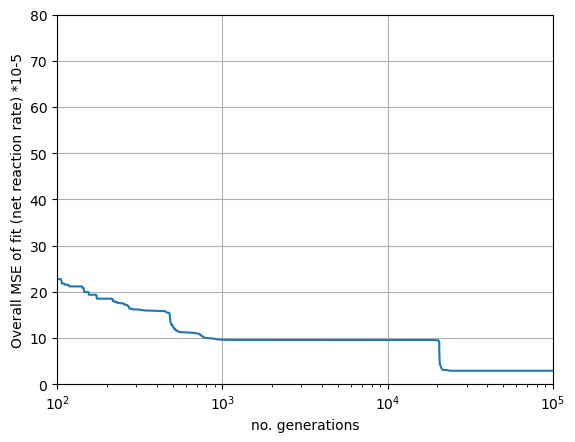

In [32]:
plt.plot(np.arange(len(f_min_log)), f_min_log)
#plt.yscale("log")
plt.xscale("log")
plt.xlabel("no. generations")
plt.ylabel("Overall MSE of fit (net reaction rate) *10-5")

plt.xlim([1e2, 1e5])
plt.ylim([0, 80])

plt.grid()
plt.show()

In [33]:
for i in range(len (res.X)):
    print (res.X[i])

-0.8001310597628635
-7.900486305957822
-1.1133740019187577
-1.2017292530411134
-7.806466608578288
-1.5914071944141583
10.82452819171329
-1.126577706425569
-7.292613400739358
6.446102184216767
-0.7345486359809725
-4.396817331961782
3.737514748790202
-0.34067921815683444
-6.546678263169759
-0.8957093120275849
-0.5106326919665205
-0.4193463158760025
-7.100098799136832
9.082119414360722
2.874475490863676
-1.2918440809783098
-1.8100305873868863
-6.404514180600331
1.8798523559048976
-5.1280900933501625
-1.301029998055443


In [34]:
res.X

array([-0.80013106, -7.90048631, -1.113374  , -1.20172925, -7.80646661,
       -1.59140719, 10.82452819, -1.12657771, -7.2926134 ,  6.44610218,
       -0.73454864, -4.39681733,  3.73751475, -0.34067922, -6.54667826,
       -0.89570931, -0.51063269, -0.41934632, -7.1000988 ,  9.08211941,
        2.87447549, -1.29184408, -1.81003059, -6.40451418,  1.87985236,
       -5.12809009, -1.30103   ])

In [35]:
logkr = [ 
    -0.8, -7.9,
    -1.1, -1.2, -7.8,
    -1.6, 7.6, -1.1, -7.3,
    7.1, -0.7, -10.9, 10.9,
    -0.3, -6.5,
    -0.9, -0.5, -0.4, -7.1,
    9.3, 3.1,
    -1.3, -1.8, -6.4,
    1.0, -6.0]

for i in range(len (logkr)):
    print (logkr[i])

-0.8
-7.9
-1.1
-1.2
-7.8
-1.6
7.6
-1.1
-7.3
7.1
-0.7
-10.9
10.9
-0.3
-6.5
-0.9
-0.5
-0.4
-7.1
9.3
3.1
-1.3
-1.8
-6.4
1.0
-6.0


In [36]:
# average of true log kr values excluding Vin
y_mean = np.mean(logkr)

resX=np.ndarray.tolist(res.X)
del resX[-1]

RSS = 0 # initiate residual sum of square
TSS = 0 # intiate total sum of square
for y,y_hat in zip(logkr,resX):
    print( str(y) + ': ' + str (y_hat) ) 
    RSS = RSS + (y - y_hat)**2
    TSS = TSS + (y - y_mean)**2

# coeff of determination for y = y_hat
R2= 1 -(RSS/TSS)
R=R2**(0.5)
print ('R-value: ' +str(R) )
print ('R2: ' +str(R2) )

-0.8: -0.8001310597628635
-7.9: -7.900486305957822
-1.1: -1.1133740019187577
-1.2: -1.2017292530411134
-7.8: -7.806466608578288
-1.6: -1.5914071944141583
7.6: 10.82452819171329
-1.1: -1.126577706425569
-7.3: -7.292613400739358
7.1: 6.446102184216767
-0.7: -0.7345486359809725
-10.9: -4.396817331961782
10.9: 3.737514748790202
-0.3: -0.34067921815683444
-6.5: -6.546678263169759
-0.9: -0.8957093120275849
-0.5: -0.5106326919665205
-0.4: -0.4193463158760025
-7.1: -7.100098799136832
9.3: 9.082119414360722
3.1: 2.874475490863676
-1.3: -1.2918440809783098
-1.8: -1.8100305873868863
-6.4: -6.404514180600331
1.0: 1.8798523559048976
-6.0: -5.1280900933501625
R-value: 0.9277989158361863
R2: 0.8608108282268028
